In [1]:
import wikipedia
import urllib
from urllib.error import HTTPError
import difflib
import spacy
import datetime
import numpy as np

nlp = spacy.load("en_core_web_md")

In [2]:
def get_sets(words_set, mode):
    good = set()
    bad = set()
    very_bad = set()
    
    for i, word in enumerate(words_set):
        try:
            url_suffix = (word.replace(" ", "_").replace("-", "_")).capitalize()
            url = "https://en.wikipedia.org/wiki/" + url_suffix
            status = 0
            try:
                code = urllib.request.urlopen(url).getcode()
                if code == 200:
                    good.add(word)
                    status = 1
            except HTTPError:
                if status == 0 and word[-1] == 's' and len(word.split(" ")) > 1:
                    url = url[:-1]
                    try:
                        code = urllib.request.urlopen(url).getcode()
                        if code == 200:
                            good.add(word)
                            status = 1
                    except HTTPError:
                        bad.add(word)
            print("Ran " + str(i + 1) + "... Keyword: " + word + " URL: " + url + " Status: " + str(status))
        except:
            very_bad.add(word)
    
    probably_good = set()
    for word in words_set.difference(good):
        query = word.replace("-", " ").lower()
        query_tok = nlp(query)
        values = []
        for result in wikipedia.search(query):
            result_tok = nlp(result.lower().replace("-", " "))
            d = result_tok.similarity(query_tok) * 100 
            values.append(d)
        if len(values) != 0:
            print("Rechecking... " + "Keyword: " + word + " Max Similarity: " + str(max(values)))
            if max(values) > 80.0:
                probably_good.add(word)

    return good, probably_good

def get_precision(words_set, mode, good=None, probably_good=None):
    if good is None or probably_good is None:
        good, probably_good = get_sets(words_set, mode)
    precision = ((len(good) + len(probably_good)) / len(words_set)) * 100.0
    return precision, good, probably_good

def get_recall(prdr_good_set, ap_good_set):
    if prdr_good_set is None or ap_good_set is None:
        return None
    prdr_recall = (len(prdr_good_set))/(len(prdr_good_set.union(ap_good_set))) * 100.0
    ap_recall = (len(prdr_good_set))/(len(prdr_good_set.union(ap_good_set))) * 100.0
    return prdr_recall, ap_recall

In [3]:
prdr_0 = [('neural networks', 3.3453559932726746e+17), ('neural network', 2.738454747280229e+17), ('net convnet', 3.4513753759001744e+16), ('framelet expansion', 3.1568661976886148e+16), ('neural model', 2.2008552333596388e+16), ('orthogonal networks', 1.980566815530766e+16), ('deterministic policy', 1.9063634849762544e+16), ('bidirectional lstm', 1.7397678120901048e+16), ('neural architecture', 1.672676829644046e+16), ('neural nets', 1.663658673882121e+16), ('neural architectures', 1.536312484629237e+16), ('neural models', 1.5128211310708492e+16), ('bayesian methods', 1.4776479378038004e+16), ('associative memory', 1.4708155285649396e+16), ('linear networks', 1.404664549328553e+16), ('compositional models', 1.3676713946252364e+16), ('neural language', 1.3361572584722284e+16), ('deep learning', 1.2772125379543132e+16), ('learning dl', 1.2758457878080312e+16), ('dynamical model', 1.2186808445521194e+16), ('dual stream', 1.2186808445521194e+16), ('residual network', 1.2186808445521194e+16), ('convolutional autoencoders', 1.1806649608310038e+16), ('convolutional autoencoder', 1.111814783883815e+16), ('residual learning', 1.0722891339666342e+16), ('nonlinear networks', 9944407293968516.0), ('generative models', 9782865112963406.0), ('adversarial networks', 9237405568558294.0), ('neural heart', 8912694213766541.0), ('active learning', 8912694213766541.0), ('linear models', 8746523365696848.0), ('neural operations', 8531012939359648.0), ('hiererchical features', 8427987295971319.0), ('deep networks', 7655090462747057.0), ('predictive coding', 7325751740577379.0), ('natural language', 7072264661462985.0), ('many task', 6877294165737507.0), ('metric learning', 6703787901159427.0), ('linear neural', 6379228939040156.0), ('adversarial nets', 6158270379038862.0), ('dynamical models', 5903324804155019.0), ('linguistic processing', 5903324804155019.0), ('speaker vectors', 5796363626710207.0), ('coral correlation', 5796363626710207.0), ('successor reinforcement', 5796363626710207.0), ('plant plant', 5796363626710207.0), ('recent years', 4971759298466490.0), ('visual question', 4378666345961071.0), ('real world', 4095719943364157.0), ('large scale', 3967229336666115.5), ('convolutional feature', 3822685437120592.0), ('convolutional networks', 3418332545307994.0), ('real time', 3246313160661825.5), ('deep reinforcement', 3017654456361606.5), ('seq2seq framework', 2772191279454129.0), ('deep network', 2397895788193201.5), ('time series', 2229696362345160.0), ('deep architecture', 2206974285570465.0), ('generative model', 2121510727445375.2), ('neural machine', 2103923938122271.0), ('unsupervised learning', 1809128058477612.5), ('linear regions', 1692996620188826.2), ('structured prediction', 1672408964091707.0), ('other words', 1657253099488829.8), ('high level', 1655845360024591.2), ('visual dialog', 1595181763492951.8), ('many applications', 1527274128223407.0), ('residual networks', 1513926952866531.2), ('extreme learning', 1428174671732784.5), ('automatic speech', 1374570641201806.0), ('many areas', 1325802479591064.0), ('single directions', 1319410531912278.0), ('nonlinear transformations', 1303488761312686.5), ('various applications', 1273954851594071.5), ('basic units', 1269747465141619.5), ('prior disambiguation', 1269747465141619.5), ('unlabeled data', 1269747465141619.5), ('natural images', 1269747465141619.5), ('high quality', 1269747465141619.5), ('higher level', 1231225377736239.2), ('unsupervised domain', 1216550100501864.5), ('stochastic gradient', 1189994572983524.0), ('statistical machine', 1179105470852447.2), ('probabilistic models', 1162614264725275.8), ('deep nets', 1147453616610398.5), ('synthetic images', 1147453616610398.5), ('small dnn', 1114191741965798.2), ('high speed', 1113719887354183.4), ('electronic health', 1099442174269380.8), ('n tuples', 1081830562931053.2), ('convolutional filters', 1081830562931053.2), ('adversarial training', 1081830562931053.2), ('high resolution', 1081830562931053.2), ('internal model', 1081830562931053.2), ('implicit distributions', 1081830562931053.2), ('supervised learning', 1068300243356043.1), ('large set', 1049192954835890.5), ('single bit', 1049192954835890.5), ('many tasks', 1041082353826927.2), ('such models', 1032536810151549.6), ('textual data', 1019441856257616.6), ('human perception', 1019441856257616.6), ('multi view', 1019441856257616.6), ('standard benchmark', 1015982392621889.4), ('differentiable memory', 994677938493000.1), ('many cases', 994351859693297.8), ('low level', 963436532534673.4), ('large amounts', 958231273986366.5), ('radial basis', 957851429150478.5), ('synthetic data', 946471698854395.0), ('back propagation', 939455617361689.8), ('medical imaging', 939455617361689.8), ('such networks', 938521882063649.0), ('super convergence', 938521882063649.0), ('downstream tasks', 922259253144826.2), ('syntactic kernels', 901668531351476.5), ('ensemble model', 901668531351476.5), ('quantitative results', 901668531351476.5), ('neural translation', 901668531351476.5), ('commercial speech', 901668531351476.5), ('recursive model', 901668531351476.5), ('recurrent model', 890068908060073.5), ('evolutionary algorithms', 866732367472460.4), ('discrete actions', 866732367472460.4), ('complex tasks', 857037686162988.1), ('basic structures', 846498310094413.1), ('hebbian plasticity', 846498310094413.1), ('strong baselines', 846498310094413.1), ('contrastive biclusters', 846498310094413.1), ('prior information', 846498310094413.1), ('temporal abstraction', 846498310094413.1), ('different types', 846498310094413.1), ('external factors', 846498310094413.1), ('synaptic clusters', 846498310094413.1), ('commercial advertisements', 846498310094413.1), ('initial conditions', 846498310094413.1), ('relevant text', 846498310094413.1), ('sensory information', 846498310094413.1), ('possible classes', 846498310094413.1), ('acoustic tokens', 846498310094413.1), ('inductive program', 846498310094413.1), ('real numbers', 846498310094413.1), ('visual stimuli', 846498310094413.1), ('intrinsic motivation', 846498310094413.1), ('future frames', 846498310094413.1), ('central importance', 846498310094413.1), ('next move', 846498310094413.1), ('complex behaviors', 846498310094413.1), ('novel data', 846498310094413.1), ('invariant classifiers', 846498310094413.1), ('soft attention', 846498310094413.1), ('patient notes', 846498310094413.1), ('morphological segmentation', 846498310094413.1), ('supervised separation', 846498310094413.1), ('hierarchical latent', 842826067574989.6), ('supervised data', 840200807358018.8), ('nonlinear pca', 840200807358018.8), ('future work', 833050482872504.9), ('long term', 818698803931071.0), ('large dnn', 797248038706142.9), ('dynamical systems', 796141153494455.1), ('universal perturbations', 795491214886367.1), ('patient note', 787747932285345.0), ('sequential data', 769418515358891.5), ('rough set', 768201853994915.8), ('mobile devices', 761986794466417.1), ('neural sequence', 755978058857125.5), ('multimodal sequences', 740062393821799.9), ('black box', 735720294757362.5), ('deep neural', 732762878889634.0), ('major challenge', 723965654936950.0), ('meta learning', 722716979915378.6), ('deep models', 722716979915378.6), ('deep rl', 722716979915378.6), ('open domain', 702015750033003.2), ('svms parameters', 700642373097312.2), ('long range', 688153546143517.1), ('differentiable approximation', 681997276582221.2), ('new data', 669596005630682.5), ('semantic segmentation', 664460810047200.6), ('extensive evaluations', 662901239795532.0), ('unstructured environments', 662901239795532.0), ('human language', 662901239795532.0), ('arbitrary orientations', 662901239795532.0), ('preliminary experiments', 662901239795532.0), ('many perception', 662901239795532.0), ('online stream', 662901239795532.0), ('structured output', 652966646808850.0), ('gradient descent', 652561093315547.8), ('structured self', 649241482700178.6), ('novel clustering', 649241482700178.6), ('compact dnn', 649241482700178.6), ('grand challenge', 649241482700178.6), ('promising paradigm', 649241482700178.6), ('general theory', 649241482700178.6), ('brief survey', 649241482700178.6), ('probabilistic framework', 649241482700178.6), ('neural transfer', 649241482700178.6), ('continuous relaxation', 649241482700178.6), ('novel representation', 649241482700178.6), ('new technique', 649241482700178.6), ('deep memory', 649241482700178.6), ('neuromorphic chip', 649241482700178.6), ('supervised approach', 649241482700178.6), ('unified perspective', 649241482700178.6), ('neural transducer', 649241482700178.6), ('joint model', 649241482700178.6), ('systematic study', 649241482700178.6), ('genetic algorithm', 649241482700178.6), ('comprehensive study', 649241482700178.6), ('physical metaphor', 649241482700178.6), ('major drawback', 649241482700178.6), ('bayesian model', 649241482700178.6), ('general framework', 649241482700178.6), ('key element', 649241482700178.6), ('geometric framework', 649241482700178.6), ('multi world', 649241482700178.6), ('probabilistic theory', 649241482700178.6), ('stochastic model', 649241482700178.6), ('new approach', 643153599543753.2), ('big data', 636170125260476.6), ('human intelligence', 636170125260476.6), ('adversarial perturbations', 634594187324953.4), ('parameterizable transfer', 632932441697655.1), ('interactive learning', 632932441697655.1), ('adversarial loss', 632932441697655.1), ('flexible approach', 632932441697655.1), ('spatial attention', 632932441697655.1), ('double articulation', 632932441697655.1), ('visual representation', 632932441697655.1), ('theoretical analysis', 632932441697655.1), ('interpretable cad', 632932441697655.1), ('probabilistic pooling', 632932441697655.1), ('alternative formulation', 632932441697655.1), ('probabilistic selection', 632932441697655.1), ('objective function', 632932441697655.1), ('spatial convolution', 632932441697655.1), ('progressive learning', 632932441697655.1), ('textual description', 632932441697655.1), ('scalable architecture', 632932441697655.1), ('interpretable model', 632932441697655.1), ('continuous approximation', 632932441697655.1), ('entropy loss', 632932441697655.1), ('learnable pooling', 632932441697655.1), ('geometric method', 632932441697655.1), ('evolutionary compression', 632932441697655.1), ('visual sentiment', 632932441697655.1), ('clear trade', 622285602859483.4), ('deeper networks', 622285602859483.4), ('multi layer', 622282369559483.4), ('dynamic programming', 621467712355537.0), ('sparse rewards', 618072165463664.2), ('high confidence', 618072165463664.2), ('visual recognition', 611734407950563.1), ('new tasks', 608259101302250.4), ('long sequences', 607066739584328.5), ('multi task', 606609136574750.8), ('gaussian processes', 588403681389615.8), ('softmax function', 588169160995280.0), ('discriminative loss', 588169160995280.0), ('individual units', 586464245178692.0), ('different forms', 586464245178692.0), ('semantic consistency', 586464245178692.0), ('bayesian optimization', 586464245178692.0), ('multiple layers', 586464245178692.0), ('convolutional network', 581261440400521.4), ('large span', 581261440400521.4), ('maximum likelihood', 579941922779868.8), ('short text', 578940313762341.9), ('graphical models', 578940313762341.9), ('defensive distillation', 572048682498027.8), ('deep features', 572048682498027.8), ('variational auto', 572048682498027.8), ('human annotators', 565034662653525.8), ('large number', 564560930595937.9), ('recurrent network', 550913483537968.2), ('adversarial examples', 547236336227683.1), ('factoid questions', 547236336227683.1), ('efficient training', 540880455550062.4), ('dense prediction', 539744730021108.0), ('such learning', 533557742957949.56), ('incremental learning', 533557742957949.56), ('bidirectional image', 533557742957949.56), ('multimodal image', 533557742957949.56), ('continual learning', 533557742957949.56), ('medical image', 533557742957949.56), ('continuous learning', 533557742957949.56), ('open response', 533557742957949.56), ('autonomous navigation', 533557742957949.56), ('sequential control', 533557742957949.56), ('gaussian process', 533557742957949.56), ('graphical web', 524596477417945.25), ('hidden layer', 524596477417945.25), ('unified framework', 524596477417945.25), ('novel explanation', 524596477417945.25), ('novel quantization', 524596477417945.25), ('related approximation', 524596477417945.25), ('novel communication', 524596477417945.25), ('stochastic loss', 524596477417945.25), ('fixed dropout', 524596477417945.25), ('single dnn', 524596477417945.25), ('linear regression', 524596477417945.25), ('joint optimization', 524596477417945.25), ('synthetic dataset', 524596477417945.25), ('simple k', 524596477417945.25), ('common set', 524596477417945.25), ('convolutional sequence', 524596477417945.25), ('multiplicative backpropagation', 524596477417945.25), ('unique combination', 524596477417945.25), ('single model', 524596477417945.25), ('warm restart', 524596477417945.25), ('latent representation', 524596477417945.25), ('small detector', 524596477417945.25), ('visual reasoning', 522531904491070.1), ('sparse pathways', 507991196310944.7), ('several benchmark', 507991196310944.7), ('different tasks', 507991196310944.7), ('abstractive sentence', 507991196310944.7), ('perceptual tasks', 507991196310944.7), ('recommender systems', 507991196310944.7), ('english language', 507991196310944.7), ('different sequence', 506484992259478.06), ('many machine', 506484992259478.06), ('multiple datasets', 503176807948243.4), ('prior knowledge', 503176807948243.4), ('large domains', 501002800961199.8), ('neural factors', 500259256567378.9), ('promising solutions', 500259256567378.9), ('trainable parameters', 500259256567378.9), ('abstract states', 500259256567378.9), ('adaptive computation', 500259256567378.9), ('convolutional layer', 500259256567378.9), ('visual attention', 500259256567378.9), ('structured learning', 500259256567378.9), ('high probability', 500259256567378.9), ('current cad', 500259256567378.9), ('clean labels', 500259256567378.9), ('new input', 497338969246500.06), ('quantum game', 497338969246500.06), ('generic coupling', 497338969246500.06), ('smaller subcomponent', 497338969246500.06), ('discrete speech', 497338969246500.06), ('good dataset', 497338969246500.06), ('traditional classifier', 497338969246500.06), ('phonetic recogniser', 497338969246500.06), ('general affine', 497338969246500.06), ('simple optimization', 497338969246500.06), ('maturational schedule', 497338969246500.06), ('spatial relation', 497338969246500.06), ('standard lstm', 497338969246500.06), ('common benchmarking', 497338969246500.06), ('modern system', 497338969246500.06), ('human demonstrator', 497338969246500.06), ('longer report', 497338969246500.06), ('computational block', 497338969246500.06), ('bayesian network', 497338969246500.06), ('similar model', 497338969246500.06), ('forward pass', 497338969246500.06), ('standard feed', 497338969246500.06), ('single machine', 497338969246500.06), ('statistical test', 497338969246500.06), ('balanced network', 497338969246500.06), ('clinical information', 497338969246500.06), ('universal image', 497338969246500.06), ('traditional turing', 497338969246500.06), ('single instance', 497338969246500.06), ('new task', 497338969246500.06), ('different policy', 497338969246500.06), ('single unit', 497338969246500.06), ('token history', 497338969246500.06), ('particular image', 497338969246500.06), ('multi target', 497338969246500.06), ('single parametrization', 497338969246500.06), ('real system', 497338969246500.06), ('universal neuron', 497338969246500.06), ('neural cache', 497338969246500.06), ('robust controller', 497338969246500.06), ('categorical cross', 497338969246500.06), ('deterministic function', 497338969246500.06), ('semantic descriptor', 497338969246500.06), ('plain net', 497338969246500.06), ('general family', 497338969246500.06), ('hierarchical reinforcement', 494178253944485.25), ('different languages', 494178253944485.25), ('raw sensor', 492862966959083.4), ('different application', 492862966959083.4), ('different domains', 476077072301402.8), ('negative biases', 475061673714918.25), ('algorithmic tasks', 473727682302231.06), ('adversarial samples', 473727682302231.06), ('different network', 473727682302231.06), ('human evaluation', 473727682302231.06), ('medical investigators', 473727682302231.06), ('semantic parsing', 473727682302231.06), ('such data', 473727682302231.06), ('previous work', 464820728402725.5), ('other state', 464820728402725.5), ('insufficient training', 463554124097748.25), ('hyperspectral images', 453575308500725.25), ('medical text', 453575308500725.25), ('multimodal sentiment', 453575308500725.25), ('practical applications', 453575308500725.25), ('human machine', 453575308500725.25), ('continuous state', 453575308500725.25), ('large datasets', 435923296051769.75), ('low latency', 434656916972030.94), ('traditional models', 434499856678899.1), ('unlabeled observations', 429668041294307.25), ('weak supervision', 429668041294307.25), ('computational models', 425567029211542.56), ('sequential screening', 425567029211542.56), ('abstract invariant', 425567029211542.56), ('cognitive economy', 423249155047206.56), ('standard classification', 423249155047206.56), ('singular values', 423249155047206.56), ('common man', 423249155047206.56), ('linear autoencoders', 423249155047206.56), ('boolean functions', 423249155047206.56), ('multiple child', 423249155047206.56), ('optical character', 423249155047206.56), ('linear functions', 423249155047206.56), ('cardiac dynamics', 423249155047206.56), ('lvcsr tasks', 423249155047206.56), ('multimodal learning', 423249155047206.56), ('different speakers', 423249155047206.56), ('neuronal spike', 423249155047206.56), ('important challenges', 423249155047206.56), ('random weights', 423249155047206.56), ('structured behaviors', 423249155047206.56), ('representative phrases', 423249155047206.56), ('optimal mutation', 423249155047206.56), ('correct solutions', 423249155047206.56), ('efficient structures', 423249155047206.56), ('statistical mechanics', 423249155047206.56), ('quantitative rhyme', 423249155047206.56), ('consistent groups', 423249155047206.56), ('many mammals', 423249155047206.56), ('psychological attributes', 423249155047206.56), ('uncertain knowledge', 423249155047206.56), ('several state', 423249155047206.56), ('combinatorial games', 423249155047206.56), ('unpaired output', 423249155047206.56), ('recent methods', 423249155047206.56), ('different training', 423249155047206.56), ('useful skill', 423249155047206.56), ('differentiable operations', 423249155047206.56), ('different discourse', 423249155047206.56), ('exact learning', 423249155047206.56), ('spatial knowledge', 423249155047206.56), ('artificial classes', 423249155047206.56), ('plausible answer', 423249155047206.56), ('similar symbols', 423249155047206.56), ('relevant invariances', 423249155047206.56), ('successive layers', 423249155047206.56), ('high value', 423249155047206.56), ('scientific publications', 423249155047206.56), ('larger text', 423249155047206.56), ('audio data', 423249155047206.56), ('different settings', 423249155047206.56), ('psychological phenomena', 423249155047206.56), ('baseline results', 423249155047206.56), ('such generators', 423249155047206.56), ('developmental visuomotor', 423249155047206.56), ('spectral factorization', 423249155047206.56), ('hemodynamic response', 423249155047206.56), ('cardiovascular disease', 423249155047206.56), ('unprecedented size', 423249155047206.56), ('differential equations', 423249155047206.56), ('deterministic discriminative', 423249155047206.56), ('local minima', 423249155047206.56), ('single tasks', 423249155047206.56), ('unlabeled target', 423249155047206.56), ('related domains', 423249155047206.56), ('different sets', 423249155047206.56), ('unknown amount', 423249155047206.56), ('conditional computation', 423249155047206.56), ('rigorous guarantee', 423249155047206.56), ('flexible activation', 423249155047206.56), ('variational posteriors', 423249155047206.56), ('other modules', 423249155047206.56), ('phonetic information', 423249155047206.56), ('long snake', 423249155047206.56), ('simple rnns', 423249155047206.56), ('nlp applications', 423249155047206.56), ('such similarities', 423249155047206.56), ('different order', 423249155047206.56), ('limited complexity', 423249155047206.56), ('traditional algorithms', 423249155047206.56), ('objective functions', 423249155047206.56), ('various state', 423249155047206.56), ('short phrases', 423249155047206.56), ('simulated tasks', 423249155047206.56), ('adjacent segments', 423249155047206.56), ('traditional context', 423249155047206.56), ('maxout units', 423249155047206.56), ('human vision', 423249155047206.56), ('biomedical literature', 423249155047206.56), ('pictorial scribbles', 423249155047206.56), ('conversational responses', 423249155047206.56), ('active interaction', 423249155047206.56), ('deep inference', 423249155047206.56), ('facial expression', 423249155047206.56), ('convolutional neural', 285286803301904.4), ('many nlp', 285286803301904.4), ('diabetic retinopathy', 254512421285699.34), ('universal recurrent', 249836032173310.6), ('rapid learning', 234304854742991.03), ('continuous speech', 196691869508233.0), ('multilayer neural', 179933075196367.8), ('various weather', 152972691954344.75), ('novel information', 152972691954344.75), ('such processes', 152972691954344.75), ('temporal difference', 152972691954344.75), ('standard architectures', 152972691954344.75), ('multiple objects', 152972691954344.75), ('multiple modules', 152972691954344.75), ('neural response', 152972691954344.75), ('practical goal', 152972691954344.75), ('composable modules', 152972691954344.75), ('lower dimension', 152972691954344.75), ('linguistic units', 152972691954344.75), ('inductive transfer', 152972691954344.75), ('human tool', 152972691954344.75), ('bayesian networks', 152972691954344.75), ('important regions', 152972691954344.75), ('intermediate data', 152972691954344.75), ('atrous convolutions', 152972691954344.75), ('human actions', 152972691954344.75), ('random indexing', 152972691954344.75), ('adversarial manipulation', 152972691954344.75), ('new vertices', 152972691954344.75), ('semantic drifts', 152972691954344.75), ('generalized haar', 152972691954344.75), ('vocabulary oov', 152972691954344.75), ('traditional auto', 152972691954344.75), ('different scales', 152972691954344.75), ('secondary analysis', 152972691954344.75), ('such systems', 152972691954344.75), ('complex data', 152972691954344.75), ('heuristic methods', 152972691954344.75), ('semantic labels', 152972691954344.75), ('previous classes', 152972691954344.75), ('good flow', 152972691954344.75), ('interactive fcns', 152972691954344.75), ('arbitrary length', 152972691954344.75), ('conditional entropy', 152972691954344.75), ('autonomous devices', 152972691954344.75), ('such regions', 152972691954344.75), ('online sparsification', 152972691954344.75), ('unstructured twitter', 152972691954344.75), ('different nature', 152972691954344.75), ('downstream language', 152972691954344.75), ('novel techniques', 152972691954344.75), ('complex learning', 152972691954344.75), ('varied data', 152972691954344.75), ('future nteractions', 152972691954344.75), ('rich environments', 152972691954344.75), ('translational invariance', 152972691954344.75), ('online convex', 152972691954344.75), ('unsupervised data', 152972691954344.75), ('best practices', 152972691954344.75), ('synaptic clustering', 152972691954344.75), ('different image', 152972691954344.75), ('local minimum', 152972691954344.75), ('intermediate problems', 152972691954344.75), ('isotropic variance', 152972691954344.75), ('arbitrary depth', 152972691954344.75), ('environmental resources', 152972691954344.75), ('token labels', 152972691954344.75), ('original resnet', 152972691954344.75), ('noisy estimation', 152972691954344.75), ('different dropping', 152972691954344.75), ('larger representation', 152972691954344.75), ('synaptic cluster', 152972691954344.75), ('sufficient quality', 152972691954344.75), ('large training', 152972691954344.75), ('deep inferences', 152972691954344.75), ('stale gradients', 152972691954344.75), ('different distributions', 152972691954344.75), ('traditional data', 152972691954344.75), ('linear transformations', 152972691954344.75), ('automatic video', 152972691954344.75), ('acoustic frames', 152972691954344.75), ('modern signal', 152972691954344.75), ('deep auto', 152972691954344.75), ('explicit decoupling', 152972691954344.75), ('historical documents', 152972691954344.75), ('gated activation', 152972691954344.75), ('individual spikes', 152972691954344.75), ('functional layers', 152972691954344.75), ('sound types', 152972691954344.75), ('unseen falls', 152972691954344.75), ('different parameter', 152972691954344.75), ('biological neuron', 152972691954344.75), ('deep convolution', 152972691954344.75), ('cognitive databases', 152972691954344.75), ('short texts', 152972691954344.75), ('semantic boundaries', 152972691954344.75), ('closest fit', 152972691954344.75), ('foveal image', 152972691954344.75), ('hierarchical trees', 152972691954344.75), ('visual turing', 152972691954344.75), ('distributional semantics', 152972691954344.75), ('broken records', 152972691954344.75), ('spatiotemporal activity', 152972691954344.75), ('linear chains', 152972691954344.75), ('disentangled representations', 152972691954344.75), ('sparse pathway', 152972691954344.75), ('nlp tasks', 152972691954344.75), ('full batch', 152972691954344.75), ('sophisticated baselines', 152972691954344.75), ('similar tasks', 152972691954344.75), ('interpretable cells', 152972691954344.75), ('high complexity', 152972691954344.75), ('various candidate', 152972691954344.75), ('generative process', 152972691954344.75), ('arbitrary size', 152972691954344.75), ('approximate size', 152972691954344.75), ('evolutionary product', 152972691954344.75), ('conventional machine', 152972691954344.75), ('next words', 152972691954344.75), ('various network', 152972691954344.75), ('recent output', 152972691954344.75), ('holistic processing', 152972691954344.75), ('finite datasets', 152972691954344.75), ('compositional queries', 152972691954344.75), ('various rnn', 152972691954344.75), ('common sense', 152972691954344.75), ('significant importance', 152972691954344.75), ('architectural modifications', 152972691954344.75), ('supervised classifications', 152972691954344.75), ('clinical outcomes', 152972691954344.75), ('entire sequences', 152972691954344.75), ('large population', 152972691954344.75), ('long outputs', 152972691954344.75), ('optical anomalies', 152972691954344.75), ('conventional rnns', 152972691954344.75), ('psychological experiments', 152972691954344.75), ('previous systems', 152972691954344.75), ('several thousands', 152972691954344.75), ('byte level', 152972691954344.75), ('single label', 152972691954344.75), ('cheap commodity', 152972691954344.75), ('massive datasets', 152972691954344.75), ('informative features', 152972691954344.75), ('human cognition', 152972691954344.75), ('multimodal data', 152972691954344.75), ('conceptual issues', 152972691954344.75), ('stochastic variables', 152972691954344.75), ('static neurons', 152972691954344.75), ('different networks', 152972691954344.75), ('conditional information', 152972691954344.75), ('successive events', 152972691954344.75), ('scientific papers', 152972691954344.75), ('raw laser', 152972691954344.75), ('effective designs', 152972691954344.75), ('high error', 152972691954344.75), ('individual apis', 152972691954344.75), ('large databases', 152972691954344.75), ('adversarial models', 152972691954344.75), ('neuromorphic hardware', 152972691954344.75), ('sparse windows', 152972691954344.75), ('simple word', 152972691954344.75), ('several methods', 152972691954344.75), ('many information', 152972691954344.75), ('bayesian models', 63763520.9502088), ('human similarity', 49332117.92847332), ('various scenarios', 44133770.48752974), ('practical scenarios', 44133770.48752974), ('crucial ways', 44133770.48752974), ('similar circumstances', 44133770.48752974), ('local optima', 44133770.48752974), ('scientific journals', 44133770.48752974), ('other areas', 44133770.48752974), ('visual scenes', 44133770.48752974), ('digital mammography', 44133770.48752974), ('multi layers', 44133770.48752974), ('suboptimal points', 44133770.48752974), ('unseen environments', 44133770.48752974), ('many situations', 44133770.48752974), ('short swa', 44133770.48752974), ('semantic space', 44133770.48752974), ('strong interaction', 44133770.48752974), ('high dimension', 44133770.48752974), ('several categories', 44133770.48752974), ('adjacent layers', 44133770.48752974), ('conventional nmt', 44133770.48752974), ('real transduction', 44133770.48752974), ('structural support', 44133770.48752974), ('previous hboa', 44133770.48752974), ('biological neurons', 44133770.48752974), ('exploratory behavior', 44133770.48752974), ('modern ides', 44133770.48752974), ('such applications', 44133770.48752974), ('specific forms', 44133770.48752974), ('close proximity', 44133770.48752974), ('causal accuracy', 44133770.48752974), ('superior performance', 44133770.48752974), ('adversarial sample', 44133770.48752974), ('constant time', 44133770.48752974), ('various domains', 44133770.48752974), ('inconsistent dimensions', 44133770.48752974), ('conditional language', 44133770.48752974), ('ensemble formulations', 44133770.48752974), ('international conferences', 44133770.48752974), ('particular feedback', 44133770.48752974), ('open domains', 44133770.48752974), ('scientific articles', 44133770.48752974), ('single utterances', 44133770.48752974), ('deep recurrent', 44133770.48752974), ('modern day', 44133770.48752974), ('relational databases', 44133770.48752974), ('different scripts', 44133770.48752974), ('many cheminformatics', 44133770.48752974), ('new texts', 44133770.48752974), ('first person', 44133770.48752974), ('redundant robots', 44133770.48752974), ('cluttered environments', 44133770.48752974), ('other languages', 44133770.48752974), ('ungrounded vocabulary', 44133770.48752974), ('medical abstracts', 44133770.48752974), ('dictionary elements', 44133770.48752974), ('computational intelligence', 44133770.48752974), ('american sign', 44133770.48752974), ('many recommender', 44133770.48752974), ('local neighbourhoods', 44133770.48752974), ('natural situation', 44133770.48752974), ('better correspondence', 44133770.48752974), ('residual propagation', 44133770.48752974), ('such cases', 44133770.48752974), ('average case', 44133770.48752974), ('further contrast', 44133770.48752974), ('small scale', 44133770.48752974), ('large recurrent', 44133770.48752974), ('remote sensing', 44133770.48752974), ('several dialogue', 44133770.48752974), ('simpler designs', 44133770.48752974), ('linear time', 44133770.48752974), ('other domains', 44133770.48752974), ('longitudinal scenarios', 44133770.48752974), ('genomic technologies', 44133770.48752974), ('unaligned text', 44133770.48752974), ('regular autoencoders', 44133770.48752974), ('complex environments', 44133770.48752974), ('recent image', 44133770.48752974), ('practical video', 44133770.48752974), ('human communication', 44133770.48752974), ('neural dialogue', 44133770.48752974), ('complicated environments', 44133770.48752974), ('simple lines', 44133770.48752974), ('many disciplines', 44133770.48752974), ('medical applications', 44133770.48752974), ('clinical text', 44133770.48752974), ('black drops', 44133770.48752974), ('logistic regression', 44133770.48752974), ('computational geometry', 44133770.48752974), ('numerous traffic', 44133770.48752974), ('particular feature', 44133770.48752974), ('statistical models', 44133770.48752974), ('different layers', 44133770.48752974), ('clinical data', 44133770.48752974), ('medical oncology', 44133770.48752974), ('noticeable accuracy', 44133770.48752974), ('clinical electroencephalograms', 44133770.48752974), ('high mountain', 44133770.48752974), ('computational efficiency', 44133770.48752974), ('variational inference', 44133770.48752974), ('artificial networks', 44133770.48752974), ('analog form', 44133770.48752974), ('previous studies', 44133770.48752974), ('particular one', 44133770.48752974), ('noisy environments', 44133770.48752974), ('competitive performance', 44133770.48752974), ('holistic architectures', 44133770.48752974), ('social interaction', 44133770.48752974), ('special cases', 44133770.48752974), ('slow learning', 44133770.48752974), ('computational cost', 44133770.48752974), ('recent work', 44133770.48752974), ('neural image', 44133770.48752974), ('perceptual inference', 44133770.48752974), ('classical machine', 44133770.48752974), ('formal language', 44133770.48752974), ('adversarial settings', 44133770.48752974), ('sharp contrast', 44133770.48752974), ('more tools', 44133770.48752974), ('several evaluation', 44133770.48752974), ('particular lstms', 44133770.48752974), ('slight decrease', 44133770.48752974), ('cognitive tasks', 44133770.48752974), ('several cases', 44133770.48752974), ('various forms', 44133770.48752974), ('separate papers', 44133770.48752974), ('better recognition', 44133770.48752974), ('substantial improvements', 44133770.48752974), ('suboptimal performance', 44133770.48752974), ('cognitive science', 44133770.48752974), ('supervised training', 44133770.48752974), ('supervised image', 44133770.48752974), ('different situations', 44133770.48752974), ('social media', 44133770.48752974), ('many recommendation', 44133770.48752974), ('conventional feed', 44133770.48752974), ('large storage', 44133770.48752974), ('cool networks', 44133770.48752974), ('turbid media', 44133770.48752974), ('medical paper', 44133770.48752974), ('richer characterizations', 44133770.48752974), ('great detail', 44133770.48752974), ('industrial applications', 44133770.48752974), ('small trees', 44133770.48752974), ('digital form', 44133770.48752974), ('challenging conditions', 44133770.48752974), ('sparse reconstruction', 44133770.48752974), ('general applications', 44133770.48752974), ('deep belief', 44133770.48752974), ('memristive networks', 44133770.48752974), ('noisy conditions', 44133770.48752974), ('ensemble level', 44133770.48752974), ('diverse applications', 44133770.48752974), ('probabilistic estimation', 44133770.48752974), ('stochastic estimates', 44133770.48752974), ('neurodevelopmental biology', 44133770.48752974), ('stark contrast', 44133770.48752974), ('contemporary fmri', 44133770.48752974), ('uncontrolled environments', 44133770.48752974), ('many ways', 44133770.48752974), ('extrinsic evaluations', 44133770.48752974), ('extreme cases', 44133770.48752974), ('social settings', 44133770.48752974), ('supervised digit', 44133770.48752974), ('supervised adaptation', 44133770.48752974), ('statistical dialogue', 44133770.48752974), ('new situations', 44133770.48752974), ('visual domain', 44133770.48752974), ('efficient learning', 44133770.48752974), ('cognitive neuroscience', 44133770.48752974), ('directional wavelet', 44133770.48752974), ('many classification', 44133770.48752974), ('polynomial time', 44133770.48752974), ('audio image', 44133770.48752974), ('open information', 44133770.48752974), ('standard computer', 44133770.48752974), ('previous conversion', 44133770.48752974), ('specific domains', 44133770.48752974), ('mammo grams', 44133770.48752974), ('complex matrices', 44133770.48752974), ('large cnns', 44133770.48752974), ('predictive performance', 44133770.48752974), ('intuitive theories', 44133770.48752974), ('recurrent networks', 43099014.119914755), ('mobile computing', 33226373.50098423), ('acoustic modelling', 33226373.50098423), ('joint distribution', 33226373.50098423), ('systematic design', 33226373.50098423), ('prior class', 33226373.50098423), ('other purposes', 33226373.50098423), ('acoustic modeling', 33226373.50098423), ('low resource', 33226373.50098423), ('nonlinear function', 33226373.50098423), ('dual sequence', 33226373.50098423), ('widespread deployment', 33226373.50098423), ('future development', 33226373.50098423), ('future research', 33226373.50098423), ('natural interaction', 31881760.4751044), ('online human', 31881760.4751044), ('logical reasoning', 31881760.4751044), ('neural dependency', 26609148.975590415), ('such classifiers', 25385036.29543981), ('regulatory processes', 22499093.407201402), ('such tasks', 22499093.407201402), ('different architectures', 22499093.407201402), ('cyclical learning', 22499093.407201402), ('biomedical question', 22499093.407201402), ('neural attention', 20408967.24662453), ('machine learning', 1.0), ('distributed database systems', 1.0), ('natural language processing', 1.0), ('artificial intelligence', 1.0), ('constraint programming', 1.0)]

In [4]:
prdr_0_v2 = [('networks dnns', 1.0384248027948146e+24), ('network dnn', 6.922832018632097e+23), ('networks dnn', 2.884513341096707e+23), ('network architectures', 2.86852929618709e+23), ('network accelerator', 1.153805336438683e+23), ('network classifiers', 1.153805336438683e+23), ('network model', 9.870353368744283e+22), ('network architecture', 8.043257332549133e+22), ('network training', 7.765190294900311e+22), ('network hdnn', 5.769026682193415e+22), ('networks studies', 5.769026682193415e+22), ('networks architectures', 5.769026682193415e+22), ('network arnet', 5.769026682193415e+22), ('network classifier', 5.769026682193415e+22), ('networks cd', 5.769026682193415e+22), ('heart rate', 5.769026682193415e+22), ('network adaptation', 5.769026682193415e+22), ('network models', 4.4531774966080935e+22), ('language modeling', 2.0681332970514253e+22), ('networks rnns', 1.1782567164803709e+22), ('network rnn', 7.893917830217996e+21), ('networks cnns', 3.680779669235622e+21), ('network language', 3.0374751502791853e+21), ('language model', 1.307270758013756e+21), ('network approach', 1.2781149375586113e+21), ('machine translation', 8.64338691727309e+20), ('language models', 7.948987210433471e+20), ('encoder decoder', 7.849891255776928e+20), ('network encoder', 6.896577644677946e+20), ('networks mdrnn', 6.896577644677946e+20), ('network dbrnn', 6.896577644677946e+20), ('network frameworks', 6.896577644677946e+20), ('networks models', 6.896577644677946e+20), ('network topologies', 6.896577644677946e+20), ('network predictions', 6.896577644677946e+20), ('world models', 6.581748190743288e+20), ('feature extractors', 5.834589585928737e+20), ('activation policies', 5.834589585928737e+20), ('network dcnn', 5.258256670336603e+20), ('networks lenet', 5.258256670336603e+20), ('architectures cnns', 5.258256670336603e+20), ('network functions', 4.1711531973242303e+20), ('network technique', 4.1711531973242303e+20), ('training model', 4.1711531973242303e+20), ('transfer function', 4.1711531973242303e+20), ('network conversation', 4.1711531973242303e+20), ('feedback relevance', 4.1711531973242303e+20), ('network classification', 3.935660935946395e+20), ('network synthesis', 3.921733816145942e+20), ('hyperparameter choices', 3.914145447736691e+20), ('time scales', 3.914145447736691e+20), ('networks rnn', 3.722868959804859e+20), ('qa system', 3.7214347403183646e+20), ('memory access', 3.6597806721898735e+20), ('attention model', 3.565493787088985e+20), ('sequence labeling', 3.451421659096861e+20), ('attention mechanism', 3.188870792914228e+20), ('rnn regularizers', 2.931088243189439e+20), ('bigram types', 2.931088243189439e+20), ('candidate answer', 2.7703078105949507e+20), ('network dqn', 2.0225881846873545e+20), ('network structure', 1.7494234933863055e+20), ('application areas', 1.680589364769036e+20), ('parameter settings', 1.680589364769036e+20), ('dropping probabilities', 1.680589364769036e+20), ('training methods', 1.680589364769036e+20), ('image patterns', 1.595149415576194e+20), ('learning problems', 1.5927402905096238e+20), ('networks compression', 1.477560099152166e+20), ('rnn language', 1.4583666286336836e+20), ('tuning size', 1.4144541290273484e+20), ('architecture search', 1.3842113611283672e+20), ('domain adaptation', 1.2652222194876387e+20), ('network grnn', 1.2409563199349526e+20), ('network trained', 1.2409563199349526e+20), ('architecture evolved', 1.2409563199349526e+20), ('network generates', 1.2409563199349526e+20), ('network enhanced', 1.2409563199349526e+20), ('questioner owing', 1.2409563199349526e+20), ('networks qrnns', 1.2409563199349526e+20), ('networks can', 1.2409563199349526e+20), ('networks called', 1.2409563199349526e+20), ('annotation rules', 1.233069375382792e+20), ('nlu architecture', 1.233069375382792e+20), ('transition system', 1.233069375382792e+20), ('policy training', 1.2254141029519447e+20), ('sensorimotor development', 1.2254141029519447e+20), ('test time', 1.1035683517417613e+20), ('network agent', 1.0112940923436773e+20), ('network dfdqn', 1.0112940923436773e+20), ('networks dqn', 1.0112940923436773e+20), ('move predictors', 9.97049282233601e+19), ('network sentence', 9.97049282233601e+19), ('network decisions', 9.97049282233601e+19), ('network layers', 9.97049282233601e+19), ('baseline systems', 9.97049282233601e+19), ('response properties', 9.97049282233601e+19), ('network translation', 9.85198921475153e+19), ('model state', 9.85198921475153e+19), ('network component', 9.85198921475153e+19), ('network components', 9.85198921475153e+19), ('style transfer', 9.85198921475153e+19), ('network design', 9.830346863214708e+19), ('turing machines', 9.830346863214708e+19), ('sequence models', 9.519469081941538e+19), ('dependency parsers', 9.43062657449794e+19), ('image description', 9.184693102010943e+19), ('reinforcement learning', 7.027910878307642e+19), ('penn treebank', 6.303026942685715e+19), ('penalty term', 5.761098473927183e+19), ('speech recognition', 5.697973569045093e+19), ('ctc word', 5.587272766140968e+19), ('source code', 4.874281457240543e+19), ('nse models', 4.874281457240543e+19), ('method perturb', 4.874281457240543e+19), ('generalization bounds', 4.874281457240543e+19), ('ablation studies', 4.874281457240543e+19), ('model benefits', 4.874281457240543e+19), ('analysis highlights', 4.874281457240543e+19), ('starting point', 4.596946162702682e+19), ('character level', 3.8718778968902705e+19), ('rl models', 3.6890813566769066e+19), ('image classification', 3.5341002986963014e+19), ('dialogue response', 3.4012436382714008e+19), ('knowledge transfer', 3.132076035340276e+19), ('response generation', 2.9888790161929347e+19), ('dialogue management', 2.9603782795594002e+19), ('morpheme level', 2.912597229701497e+19), ('matching results', 2.912597229701497e+19), ('studies words', 2.912597229701497e+19), ('language modelling', 2.8952484721972646e+19), ('sentence classification', 2.8574223532216357e+19), ('quantization scheme', 2.84074239784983e+19), ('training method', 2.84074239784983e+19), ('vector product', 2.84074239784983e+19), ('input module', 2.84074239784983e+19), ('acquisition function', 2.84074239784983e+19), ('search algorithm', 2.84074239784983e+19), ('eda framework', 2.84074239784983e+19), ('explanation method', 2.84074239784983e+19), ('network regularizer', 2.84074239784983e+19), ('weight regularization', 2.84074239784983e+19), ('communication strategy', 2.84074239784983e+19), ('pattern analysis', 2.7578731537244996e+19), ('learning method', 2.6940269401596695e+19), ('object recognition', 2.636226009899412e+19), ('beam search', 2.6048735116469453e+19), ('pattern completion', 2.558494470917553e+19), ('representation learning', 2.547013075951131e+19), ('training procedure', 2.5436411847073247e+19), ('sentiment analysis', 2.5330569493467537e+19), ('dialogue corpora', 2.4748271372672717e+19), ('scale data', 2.4748271372672717e+19), ('relation classification', 2.3864509439099077e+19), ('edge devices', 2.3864509439099077e+19), ('pattern recognition', 2.329585459136382e+19), ('concept drift', 2.272833847745266e+19), ('network complexity', 2.1697441247893066e+19), ('gradient descent', 2.1697441247893066e+19), ('list questions', 2.142400382132122e+19), ('graph time', 2.142400382132122e+19), ('object dynamics', 2.142400382132122e+19), ('classification performance', 2.142400382132122e+19), ('line feature', 2.142400382132122e+19), ('line planning', 2.142400382132122e+19), ('evaluation tasks', 2.142400382132122e+19), ('data mining', 2.1405791224657973e+19), ('auto encoders', 2.1405791224657973e+19), ('cost terms', 2.1405791224657973e+19), ('weight parameters', 2.1405791224657973e+19), ('gradient methods', 2.1405791224657973e+19), ('data poisoning', 2.1405791224657973e+19), ('model prediction', 2.1405791224657973e+19), ('step supervision', 2.1405791224657973e+19), ('layer composition', 2.1405791224657973e+19), ('step fashion', 2.1405791224657973e+19), ('language learners', 2.1405791224657973e+19), ('word matching', 2.1405791224657973e+19), ('stimulation avoidance', 2.1405791224657973e+19), ('layer transformations', 2.1405791224657973e+19), ('machines progresses', 2.1405791224657973e+19), ('question answering', 2.13423247157403e+19), ('image generation', 2.1246183703928254e+19), ('sequence modeling', 2.1102429024246895e+19), ('networks area', 2.0688812318485647e+19), ('language identification', 2.0576314410561667e+19), ('batch normalization', 2.039627744853429e+19), ('factoid questions', 2.015011677366784e+19), ('object detection', 1.944624545831058e+19), ('networks cnn', 1.901989325288663e+19), ('content information', 1.871063545489238e+19), ('level representations', 1.861964883214532e+19), ('level clock', 1.861964883214532e+19), ('composition part', 1.861964883214532e+19), ('training data', 1.8040222412227572e+19), ('training images', 1.6419308719524643e+19), ('feature extraction', 1.5121325866894918e+19), ('text classification', 1.4962711917722325e+19), ('text data', 1.4356459566759125e+19), ('word embeddings', 1.4148097216917377e+19), ('latent dirichlet', 1.41384753805695e+19), ('intrusion detection', 1.3797910578904297e+19), ('label shift', 1.3797910578904297e+19), ('equality constraints', 1.3797910578904297e+19), ('video prediction', 1.3797910578904297e+19), ('sentiment classification', 1.3717791025326068e+19), ('sample extension', 1.3480739418726773e+19), ('evaluation metrics', 1.3206166331981148e+19), ('cause update', 1.256169254478914e+19), ('paper surveys', 1.256169254478914e+19), ('error term', 1.256169254478914e+19), ('drug discovery', 1.2468255548995717e+19), ('image caption', 1.2370139626757652e+19), ('handwriting synthesis', 1.2370139626757652e+19), ('summarization question', 1.2370139626757652e+19), ('error detection', 1.2267973078451186e+19), ('image processing', 1.2113882208368833e+19), ('feature vectors', 1.2102540211580187e+19), ('gesture recognition', 1.1916316403459602e+19), ('program induction', 1.1916316403459602e+19), ('feature engineering', 1.164792729568191e+19), ('term proximity', 1.164792729568191e+19), ('knowledge base', 1.1423305793871567e+19), ('model performance', 1.1341067510185085e+19), ('image question', 1.1243172698937293e+19), ('mnist cifar', 1.071200191066061e+19), ('result accuracy', 1.071200191066061e+19), ('extraction patterns', 1.071200191066061e+19), ('gibbs sampling', 1.071200191066061e+19), ('substitute models', 1.071200191066061e+19), ('machine comprehension', 1.071200191066061e+19), ('face clustering', 1.071200191066061e+19), ('construction graph', 1.071200191066061e+19), ('vector representations', 1.071200191066061e+19), ('confidence scores', 1.071200191066061e+19), ('text summarization', 1.071200191066061e+19), ('image datasets', 1.071200191066061e+19), ('program synthesis', 1.071200191066061e+19), ('user click', 1.071200191066061e+19), ('sentence regions', 1.071200191066061e+19), ('pwl activation', 1.071200191066061e+19), ('music modeling', 1.071200191066061e+19), ('velocity inputs', 1.071200191066061e+19), ('state visitation', 1.071200191066061e+19), ('document feature', 1.071200191066061e+19), ('energy time', 1.071200191066061e+19), ('data transformations', 1.071200191066061e+19), ('mixture approaches', 1.071200191066061e+19), ('input images', 1.071200191066061e+19), ('separation algorithms', 1.071200191066061e+19), ('baggage scanner', 1.071200191066061e+19), ('movie synopses', 1.071200191066061e+19), ('sentence characteristics', 1.071200191066061e+19), ('consumer grade', 1.071200191066061e+19), ('line method', 1.071200191066061e+19), ('video action', 1.071200191066061e+19), ('topology preservation', 1.071200191066061e+19), ('model adaptation', 1.071200191066061e+19), ('layer depth', 1.071200191066061e+19), ('selection generation', 1.071200191066061e+19), ('error reduction', 1.071200191066061e+19), ('clinicians notes', 1.071200191066061e+19), ('line kernel', 1.071200191066061e+19), ('topic responses', 1.071200191066061e+19), ('class labels', 1.071200191066061e+19), ('runtime performance', 1.071200191066061e+19), ('caption syntax', 1.071200191066061e+19), ('story dialogs', 1.071200191066061e+19), ('particle swarm', 1.071200191066061e+19), ('word prediction', 1.071200191066061e+19), ('path finding', 1.071200191066061e+19), ('polygon vertices', 1.071200191066061e+19), ('earthquake time', 1.071200191066061e+19), ('tandem models', 1.071200191066061e+19), ('body representations', 1.071200191066061e+19), ('document analysis', 1.071200191066061e+19), ('sequence data', 1.071200191066061e+19), ('traffic flow', 1.071200191066061e+19), ('image preprocessing', 1.071200191066061e+19), ('policy methods', 1.071200191066061e+19), ('advantage values', 1.071200191066061e+19), ('bird images', 1.071200191066061e+19), ('auto encoding', 1.071200191066061e+19), ('discourse relations', 1.071200191066061e+19), ('latent feature', 1.071200191066061e+19), ('event successor', 1.071200191066061e+19), ('latent factor', 1.071200191066061e+19), ('type annotations', 1.071200191066061e+19), ('gradient estimators', 1.071200191066061e+19), ('gene expression', 1.071200191066061e+19), ('script scores', 1.071200191066061e+19), ('dialogue systems', 1.0625150739523305e+19), ('input data', 1.0528525671705293e+19), ('target language', 1.0501200227682226e+19), ('model parameters', 1.0447997591951266e+19), ('question representation', 1.0399818815274908e+19), ('recognition performance', 1.0399818815274908e+19), ('inception score', 1.0376604821152725e+19), ('ladder networks', 1.0220573672096612e+19), ('approximation error', 9.790732752037558e+18), ('network cnn', 9.312723503090321e+18), ('training samples', 8.820442791423447e+18), ('traffic scene', 8.598816391200219e+18), ('art results', 8.355179025966652e+18), ('sentence level', 8.065075424626907e+18), ('sequence labelling', 7.944210935639737e+18), ('mobile computing', 7.944210935639737e+18), ('caption generation', 7.944210935639737e+18), ('image annotation', 7.944210935639737e+18), ('edge device', 7.944210935639737e+18), ('relation extraction', 7.944210935639737e+18), ('web document', 7.944210935639737e+18), ('table querying', 7.944210935639737e+18), ('code generation', 7.7427733944635e+18), ('transfer learning', 7.679415205163748e+18), ('model selection', 7.590972551965859e+18), ('building blocks', 7.538766193470177e+18), ('word level', 7.226109909163625e+18), ('network mat', 7.192953400127004e+18), ('word error', 6.807294688306442e+18), ('information extraction', 6.634343239421898e+18), ('dnn model', 6.444517800407923e+18), ('accelerator chips', 6.444517800407923e+18), ('target sequence', 6.343978358980399e+18), ('source sentence', 6.343978358980399e+18), ('program representation', 6.343978358980399e+18), ('multimodal sequences', 6.279628244253771e+18), ('data science', 6.219993187752647e+18), ('image captioning', 6.204764289163484e+18), ('optimization problems', 6.190687344088205e+18), ('spiking networks', 6.141209193342194e+18), ('input samples', 6.070644779411419e+18), ('lid architecture', 5.987290629781399e+18), ('task completion', 5.767218502152078e+18), ('position evaluation', 5.767218502152078e+18), ('language understanding', 5.633929154731701e+18), ('data augmentation', 5.591061567700851e+18), ('sequence generation', 5.55529979423937e+18), ('data representation', 5.431517109619932e+18), ('dependency parser', 5.41766610298736e+18), ('code suggestion', 5.342329545459238e+18), ('policy gradient', 5.321786773440307e+18), ('training asr', 5.312575369761653e+18), ('svms parameters', 5.312575369761653e+18), ('source target', 5.312575369761653e+18), ('domain generalization', 5.312575369761653e+18), ('multimodal image', 5.312575369761653e+18), ('match srnn', 5.312575369761653e+18), ('translation systems', 5.209668519528255e+18), ('input features', 5.198404197295363e+18), ('sentence embeddings', 5.152441564416686e+18), ('classification problems', 5.146373857134054e+18), ('news articles', 5.127943357475878e+18), ('translation model', 5.075413693578107e+18), ('time steps', 5.055277282022541e+18), ('image data', 5.055277282022541e+18), ('label noise', 5.055277282022541e+18), ('move prediction', 5.023468591454215e+18), ('speaker verification', 5.005560492399105e+18), ('adult content', 5.005560492399105e+18), ('text comprehension', 5.005560492399105e+18), ('word sequence', 4.5621793204502845e+18), ('art performance', 4.433082171302013e+18), ('generator network', 4.395500292626472e+18), ('multimedia text', 4.3360291000348595e+18), ('speech perception', 4.3360291000348595e+18), ('information retrieval', 4.3360291000348595e+18), ('link prediction', 4.3058065944274053e+18), ('sentence representation', 4.126532717489994e+18), ('image cluster', 4.0843768129838653e+18), ('error rate', 4.0843768129838653e+18), ('word models', 3.9880341486080865e+18), ('dimensionality reduction', 3.9880341486080865e+18), ('language processing', 3.9721054678198687e+18), ('morphology classification', 3.9721054678198687e+18), ('script discrimination', 3.9721054678198687e+18), ('board games', 3.9721054678198687e+18), ('sentence relation', 3.9721054678198687e+18), ('activities recommendation', 3.9721054678198687e+18), ('domain experts', 3.9721054678198687e+18), ('source language', 3.9721054678198687e+18), ('typhoon eye', 3.9721054678198687e+18), ('sentence simplification', 3.9721054678198687e+18), ('tag prediction', 3.9721054678198687e+18), ('activity gradients', 3.9721054678198687e+18), ('vocabulary terms', 3.9721054678198687e+18), ('partition labels', 3.9721054678198687e+18), ('software developers', 3.9721054678198687e+18), ('analogy detection', 3.9721054678198687e+18), ('document understanding', 3.9721054678198687e+18), ('example copynet', 3.9721054678198687e+18), ('gene ontology', 3.9721054678198687e+18), ('discourse relation', 3.9721054678198687e+18), ('cross selling', 3.9721054678198687e+18), ('metaphor detection', 3.9721054678198687e+18), ('movies recommendation', 3.9721054678198687e+18), ('image classifier', 3.9721054678198687e+18), ('word grouping', 3.9721054678198687e+18), ('topic inference', 3.9721054678198687e+18), ('image analysis', 3.9721054678198687e+18), ('gender detection', 3.9721054678198687e+18), ('digit recognition', 3.9721054678198687e+18), ('text documents', 3.9721054678198687e+18), ('hyperparameter optimization', 3.9721054678198687e+18), ('text modeling', 3.9721054678198687e+18), ('commonsense reasoning', 3.9721054678198687e+18), ('mapping reviews', 3.9721054678198687e+18), ('character prediction', 3.9721054678198687e+18), ('accuracy improvement', 3.9721054678198687e+18), ('dialogue applications', 3.9721054678198687e+18), ('sentence meaning', 3.9721054678198687e+18), ('speech tasks', 3.9721054678198687e+18), ('weather observation', 3.9721054678198687e+18), ('mlp training', 3.9721054678198687e+18), ('multilabel classification', 3.9721054678198687e+18), ('text compounds', 3.9721054678198687e+18), ('input signals', 3.9721054678198687e+18), ('backpropagation training', 3.9721054678198687e+18), ('sentiment compression', 3.9721054678198687e+18), ('engineering applications', 3.9721054678198687e+18), ('face verification', 3.9721054678198687e+18), ('disaster management', 3.9721054678198687e+18), ('machine question', 3.9721054678198687e+18), ('desire fulfillment', 3.9721054678198687e+18), ('album summarization', 3.9721054678198687e+18), ('training chemnet', 3.9721054678198687e+18), ('sequence level', 3.9721054678198687e+18), ('system identification', 3.9721054678198687e+18), ('tree graphs', 3.9721054678198687e+18), ('rank approximation', 3.9721054678198687e+18), ('example humans', 3.9721054678198687e+18), ('brain imaging', 3.9721054678198687e+18), ('consistency performance', 3.9721054678198687e+18), ('computation resources', 3.9721054678198687e+18), ('objection detection', 3.9721054678198687e+18), ('credit assignment', 3.9721054678198687e+18), ('mode collapse', 3.9721054678198687e+18), ('video description', 3.9721054678198687e+18), ('translation selection', 3.9721054678198687e+18), ('work nsfw', 3.9721054678198687e+18), ('word ordering', 3.9721054678198687e+18), ('image domain', 3.9721054678198687e+18), ('safety reasons', 3.9721054678198687e+18), ('skin lesion', 3.9721054678198687e+18), ('understanding feed', 3.9721054678198687e+18), ('re tuning', 3.9721054678198687e+18), ('sequence transformation', 3.9721054678198687e+18), ('bioactivity prediction', 3.9721054678198687e+18), ('decision explanation', 3.9721054678198687e+18), ('dialogue model', 3.9721054678198687e+18), ('text query', 3.9721054678198687e+18), ('feature selection', 3.9721054678198687e+18), ('images identification', 3.9721054678198687e+18), ('cluster analysis', 3.9721054678198687e+18), ('malfunction compensation', 3.9721054678198687e+18), ('dialogue generation', 3.9721054678198687e+18), ('multimodal sentiment', 3.9721054678198687e+18), ('cross domain', 3.9721054678198687e+18), ('lstm networks', 3.9274268686399636e+18), ('sequence transduction', 3.9112474482051574e+18), ('community question', 3.859670834386293e+18), ('text processing', 3.859670834386293e+18), ('knowledge representation', 3.859670834386293e+18), ('language comprehension', 3.859670834386293e+18), ('classification tasks', 3.859670834386293e+18), ('authorship attribution', 3.748223167840962e+18), ('image segmentation', 3.6171641373674307e+18), ('target labels', 3.4703779238155756e+18), ('base space', 3.4427945927506693e+18), ('inverse models', 3.370184854681693e+18), ('object classification', 3.370184854681693e+18), ('words representation', 3.370184854681693e+18), ('model architecture', 3.370184854681693e+18), ('representation schemes', 3.370184854681693e+18), ('covariance functions', 3.370184854681693e+18), ('knowledge distillation', 3.370184854681693e+18), ('feature importance', 3.370184854681693e+18), ('loss functions', 3.370184854681693e+18), ('domains program', 3.370184854681693e+18), ('equivalence classes', 3.370184854681693e+18), ('dialog state', 3.370184854681693e+18), ('memristor synapses', 3.370184854681693e+18), ('speech tags', 3.370184854681693e+18), ('group actions', 3.370184854681693e+18), ('feature detectors', 3.370184854681693e+18), ('layer activations', 3.370184854681693e+18), ('speech tagging', 3.370184854681693e+18), ('paragraph vectors', 3.370184854681693e+18), ('start states', 3.370184854681693e+18), ('inference steps', 3.370184854681693e+18), ('distribution algorithms', 3.370184854681693e+18), ('graph embeddings', 3.370184854681693e+18), ('group theory', 3.358605187366509e+18), ('latent variables', 3.351112664789631e+18), ('class imbalance', 3.3164227091427533e+18), ('knowledge bases', 3.290794213320629e+18), ('input output', 3.23404216010588e+18), ('rnn architecture', 3.2222589002039613e+18), ('prednet architecture', 3.2222589002039613e+18), ('training software', 3.2222589002039613e+18), ('training code', 3.2222589002039613e+18), ('classification decisions', 3.2222589002039613e+18), ('classification method', 3.2222589002039613e+18), ('networks m', 2.113321472542959e+18), ('networks 3d', 2.113321472542959e+18), ('art methods', 8.580684023180283e+17), ('networks using', 7.107538126790834e+17), ('network srn', 5.7370543477464774e+17), ('networks lstm', 5.7370543477464774e+17), ('nets rnns', 5.7370543477464774e+17), ('networks pac', 5.7370543477464774e+17), ('network based', 5.671428104922757e+17), ('loss function', 3.9003109196274016e+17), ('art systems', 3.9003109196274016e+17), ('networks requires', 3.780952069948504e+17), ('networks trained', 3.607122935740278e+17), ('topic modeling', 3.232400997596387e+17), ('art algorithms', 3.120248735701921e+17), ('art techniques', 3.120248735701921e+17), ('art accuracy', 3.120248735701921e+17), ('output distributions', 2.6559664812036077e+17), ('vocabulary size', 2.6559664812036077e+17), ('art speech', 2.340186551776441e+17), ('art performances', 2.340186551776441e+17), ('art perplexity', 2.340186551776441e+17), ('art model', 2.340186551776441e+17), ('input text', 2.340186551776441e+17), ('art approaches', 2.340186551776441e+17), ('input space', 2.175128594534214e+17), ('networks anns', 2.0170783623936758e+17), ('networks based', 1.890476034974252e+17), ('networks remains', 1.890476034974252e+17), ('networks utilizing', 1.890476034974252e+17), ('network hidden', 1.890476034974252e+17), ('networks come', 1.890476034974252e+17), ('networks excel', 1.890476034974252e+17), ('model trained', 1.890476034974252e+17), ('networks require', 1.890476034974252e+17), ('architectures based', 1.890476034974252e+17), ('network need', 1.890476034974252e+17), ('networks evolve', 1.890476034974252e+17), ('networks focusing', 1.890476034974252e+17), ('learning approach', 1.8453716318147142e+17), ('reordering model', 1.8153510368927638e+17), ('machine reading', 1.696666965566342e+17), ('optimization problem', 1.5601243678509606e+17), ('end user', 1.5601243678509606e+17), ('art error', 1.5601243678509606e+17), ('weight matrix', 1.5601243678509606e+17), ('art classification', 1.5601243678509606e+17), ('art word', 1.5601243678509606e+17), ('art rnn', 1.5601243678509606e+17), ('art imagenet', 1.5601243678509606e+17), ('gradient estimate', 1.5601243678509606e+17), ('base model', 1.5601243678509606e+17), ('factorization matrices', 1.5601243678509606e+17), ('backpropagation algorithm', 1.5601243678509606e+17), ('target network', 1.5601243678509606e+17), ('input distribution', 1.5601243678509606e+17), ('art models', 1.4554142057071027e+17), ('activation functions', 1.4554142057071027e+17), ('networks treernns', 1.3279832406018038e+17), ('language architecture', 1.3279832406018038e+17), ('network parser', 1.2307619681819107e+17), ('input manipulation', 7.800621839254803e+16), ('art values', 7.800621839254803e+16), ('rnn store', 7.800621839254803e+16), ('play time', 7.800621839254803e+16), ('training algorithm', 7.800621839254803e+16), ('motor policy', 7.800621839254803e+16), ('art machine', 7.800621839254803e+16), ('target distribution', 7.800621839254803e+16), ('art part', 7.800621839254803e+16), ('body part', 7.800621839254803e+16), ('learning task', 7.800621839254803e+16), ('language information', 7.800621839254803e+16), ('pwl function', 7.800621839254803e+16), ('art dnn', 7.800621839254803e+16), ('art chess', 7.800621839254803e+16), ('art sentiment', 7.800621839254803e+16), ('testing segments', 7.800621839254803e+16), ('input sentence', 7.800621839254803e+16), ('training process', 7.800621839254803e+16), ('feedback connections', 7.800621839254803e+16), ('art range', 7.800621839254803e+16), ('particle filter', 7.800621839254803e+16), ('data e', 7.800621839254803e+16), ('latent codes', 7.800621839254803e+16), ('art neural', 7.800621839254803e+16), ('art recurrent', 7.800621839254803e+16), ('density advantages', 7.800621839254803e+16), ('art lstms', 7.800621839254803e+16), ('art accuracies', 7.800621839254803e+16), ('agent environment', 7.800621839254803e+16), ('mnist dataset', 7.800621839254803e+16), ('renormalization group', 7.800621839254803e+16), ('art dnns', 7.800621839254803e+16), ('box method', 7.800621839254803e+16), ('art bits', 7.800621839254803e+16), ('software baseline', 7.800621839254803e+16), ('ladder network', 7.800621839254803e+16), ('input pattern', 7.800621839254803e+16), ('question layer', 7.800621839254803e+16), ('dropout training', 7.800621839254803e+16), ('art alternatives', 7.800621839254803e+16), ('arts methods', 7.800621839254803e+16), ('art qa', 7.800621839254803e+16), ('art architectures', 7.800621839254803e+16), ('art networks', 7.800621839254803e+16), ('input pixels', 7.800621839254803e+16), ('internet web', 7.800621839254803e+16), ('research community', 7.800621839254803e+16), ('search space', 7.800621839254803e+16), ('classification types', 7.800621839254803e+16), ('art phrase', 7.800621839254803e+16), ('input sequence', 7.800621839254803e+16), ('art image', 7.800621839254803e+16), ('innermost layer', 7.800621839254803e+16), ('art algorithm', 7.800621839254803e+16), ('output tree', 7.800621839254803e+16), ('learning process', 7.800621839254803e+16), ('art trade', 7.800621839254803e+16), ('kidney loss', 7.800621839254803e+16), ('art teacher', 7.800621839254803e+16), ('latent segmentation', 7.800621839254803e+16), ('feature costs', 7.800621839254803e+16), ('weight vectors', 7.800621839254803e+16), ('pls latent', 7.800621839254803e+16), ('art features', 7.800621839254803e+16), ('art proximity', 7.800621839254803e+16), ('dissimilarity kernel', 7.800621839254803e+16), ('art dependency', 7.800621839254803e+16), ('art alternative', 7.800621839254803e+16), ('fire microarchitecture', 7.800621839254803e+16), ('art baselines', 7.800621839254803e+16), ('conditioning sequence', 7.800621839254803e+16), ('art solutions', 7.800621839254803e+16), ('art cldnn', 7.800621839254803e+16), ('art rl', 7.800621839254803e+16), ('stack contents', 7.800621839254803e+16), ('environment affordance', 7.800621839254803e+16), ('dropout strategy', 7.800621839254803e+16), ('data group', 7.800621839254803e+16), ('software package', 7.800621839254803e+16), ('art baseline', 7.800621839254803e+16), ('study panel', 7.800621839254803e+16), ('encoder output', 7.800621839254803e+16), ('seed voxels', 7.800621839254803e+16), ('arts techniques', 7.800621839254803e+16), ('target policy', 7.800621839254803e+16), ('plant species', 7.800621839254803e+16), ('art approximate', 7.800621839254803e+16), ('conditioning vector', 7.800621839254803e+16), ('art feature', 7.800621839254803e+16), ('locality principle', 7.800621839254803e+16), ('problem structure', 7.800621839254803e+16), ('art standard', 7.800621839254803e+16), ('art gans', 7.800621839254803e+16), ('data weights', 7.800621839254803e+16), ('input signal', 7.800621839254803e+16), ('mapping function', 7.800621839254803e+16), ('candidate intentions', 7.800621839254803e+16), ('art reinforcement', 7.800621839254803e+16), ('head pose', 7.800621839254803e+16), ('model complexity', 7.800621839254803e+16), ('value iteration', 7.800621839254803e+16), ('art system', 7.800621839254803e+16), ('neucube connectivity', 7.800621839254803e+16), ('network growth', 7.800621839254803e+16), ('dnn structure', 7.800621839254803e+16), ('art spam', 7.800621839254803e+16), ('self organizing', 7.800621839254803e+16), ('translation pair', 7.800621839254803e+16), ('art nmt', 7.800621839254803e+16), ('art building', 7.800621839254803e+16), ('label space', 7.800621839254803e+16), ('task pairs', 7.800621839254803e+16), ('intention process', 7.800621839254803e+16), ('art translation', 7.800621839254803e+16), ('cost function', 7.800621839254803e+16), ('art extensions', 7.800621839254803e+16), ('chain rule', 7.800621839254803e+16), ('memory state', 7.800621839254803e+16), ('representation space', 7.800621839254803e+16), ('probability model', 7.800621839254803e+16), ('art inception', 7.800621839254803e+16), ('sentiment algorithms', 7.800621839254803e+16), ('discriminator function', 7.800621839254803e+16), ('neurons activation', 7.800621839254803e+16), ('art sub', 7.800621839254803e+16), ('speech signal', 7.800621839254803e+16), ('penultimate layer', 7.800621839254803e+16), ('art classifiers', 7.800621839254803e+16), ('art end', 7.800621839254803e+16), ('attention layers', 7.800621839254803e+16), ('art spiking', 7.800621839254803e+16), ('loss gradients', 7.385966843084485e+16), ('value function', 7.385966843084485e+16), ('text samples', 7.356998093097853e+16), ('input variables', 7.356998093097853e+16), ('reconstruction error', 7.356998093097853e+16), ('networks graphs', 6.723594541312254e+16), ('observation period', 4.538483549740659e+16), ('network reservoirs', 4.272523142711516e+16), ('networks snns', 4.272523142711516e+16), ('network snn', 4.272523142711516e+16), ('networks deployed', 1.1505808708547888e+16), ('network rcnn', 1.1505808708547888e+16), ('network can', 1.1505808708547888e+16), ('networks achieve', 1.1505808708547888e+16), ('networks obtaining', 1.1505808708547888e+16), ('networks dcns', 1.1505808708547888e+16), ('networks demonstrated', 1.1505808708547888e+16), ('networks comprise', 1.1505808708547888e+16), ('network embedded', 1.1505808708547888e+16), ('networks specialized', 1.1505808708547888e+16), ('network designed', 1.1505808708547888e+16), ('networks learning', 1.1505808708547888e+16), ('recurrent model', 2403600522.2348194), ('adversarial nets', 1803884504.6641548), ('adversarial networks', 1445478683.194076), ('neural network', 835020844.7482113), ('recent years', 727594406.4790509), ('neural architecture', 600418643.5674819), ('associative memory', 590012286.734639), ('orthogonal networks', 486310069.7865167), ('neural model', 454949678.5827807), ('first time', 391627396.3918495), ('neural operations', 364732541.1553218), ('recurrent network', 253188198.92965415), ('other words', 242531468.82635027), ('convolutional feature', 236859779.7060332), ('rendering mixture', 236859779.7060332), ('novel approach', 227554354.96691063), ('convolutional autoencoders', 220989085.84672114), ('many areas', 194025175.06108022), ('adversarial network', 185130596.0778442), ('standard benchmark', 180379377.4508094), ('new method', 170665766.22518298), ('convolutional learning', 153800049.86992192), ('natural language', 150291879.07739636), ('open domain', 148955267.7638755), ('unsupervised domain', 148955267.7638755), ('close approximations', 146019493.66240892), ('many cases', 145518881.29581013), ('general framework', 142735016.38690987), ('visual question', 140399935.06967685), ('convolutional networks', 129978148.12215333), ('deterministic policy', 129441447.52938093), ('wide range', 126656477.72168294), ('neuromorphic architectures', 121577513.7475741), ('novel method', 116939420.49922271), ('real time', 116486758.12376374), ('new framework', 113777177.48345532), ('novel architecture', 113777177.48345532), ('novel algorithm', 113777177.48345532), ('new architecture', 113777177.48345532), ('new setting', 113777177.48345532), ('new model', 113777177.48345532), ('new metric', 113777177.48345532), ('real world', 111814766.56392778), ('graphical models', 111716450.82290663), ('low dose', 111716450.82290663), ('short text', 111716450.82290663), ('linguistic processing', 110494542.92336057), ('mobile devices', 108227626.47048561), ('nonlinear networks', 101148377.83046265), ('compositional models', 100580093.83677533), ('new approach', 99180864.75055988), ('unstructured environments', 97012587.53054011), ('online stream', 97012587.53054011), ('preliminary experiments', 97012587.53054011), ('situ hybridization', 97012587.53054011), ('human language', 97012587.53054011), ('medical imaging', 97012587.53054011), ('arbitrary orientations', 97012587.53054011), ('extensive evaluations', 97012587.53054011), ('many perception', 97012587.53054011), ('several benchmark', 96404898.08060074), ('neural approach', 94300002.39471044), ('theoretical framework', 94300002.39471044), ('hierarchical recurrent', 94300002.39471044), ('neural turing', 94300002.39471044), ('many task', 92732084.7685992), ('novel way', 92250959.93782514), ('deep architecture', 91719782.91124746), ('visual object', 91629156.13066368), ('statistical machine', 85745110.9212515), ('medical diagnosis', 84558005.71407817), ('many nlp', 83243579.4350815), ('black boxes', 81775693.12839346), ('benchmark datasets', 80917696.45843242), ('deep networks', 79707179.88856727), ('synthetic data', 78366960.29341392), ('extreme learning', 78228864.8756608), ('acoustic models', 78164736.22104365), ('patient note', 77744164.35193555), ('deep reinforcement', 77525541.3556524), ('many applications', 77436273.45245287), ('many tasks', 77275185.1080329), ('neural machine', 76277848.40052772), ('structured prediction', 74804129.7297219), ('nonlinear function', 74477633.88193776), ('other purposes', 74477633.88193776), ('acoustic modeling', 74477633.88193776), ('systematic design', 74477633.88193776), ('widespread deployment', 74477633.88193776), ('future development', 74477633.88193776), ('multi step', 74477633.88193776), ('prior class', 74477633.88193776), ('future research', 74477633.88193776), ('joint distribution', 73743690.89992522), ('dual sequence', 73743690.89992522), ('scalar values', 73009746.83120446), ('technical ingredients', 73009746.83120446), ('multi microphone', 73009746.83120446), ('mnist usps', 73009746.83120446), ('whole entities', 73009746.83120446), ('many programs', 73009746.83120446), ('continuous parameters', 73009746.83120446), ('mass friction', 73009746.83120446), ('multiple feature', 73009746.83120446), ('neural fields', 73009746.83120446), ('different ways', 73009746.83120446), ('different polices', 73009746.83120446), ('more input', 73009746.83120446), ('hierarchical softmax', 73009746.83120446), ('behavioral time', 73009746.83120446), ('stochastic textures', 73009746.83120446), ('competitive scenarios', 73009746.83120446), ('natural extensions', 73009746.83120446), ('patient names', 73009746.83120446), ('proper nouns', 73009746.83120446), ('logical deduction', 73009746.83120446), ('complex combinations', 73009746.83120446), ('spatial configuration', 73009746.83120446), ('spectral clustering', 73009746.83120446), ('such industries', 73009746.83120446), ('analogical reasoning', 73009746.83120446), ('stochastic sampling', 73009746.83120446), ('full batch', 73009746.83120446), ('scientific consistency', 73009746.83120446), ('mnist cifar10', 73009746.83120446), ('multi media', 73009746.83120446), ('such architectures', 73009746.83120446), ('acoustic units', 73009746.83120446), ('other researchers', 73009746.83120446), ('generative kernels', 73009746.83120446), ('statistical translation', 73009746.83120446), ('recent visualization', 73009746.83120446), ('longer paths', 73009746.83120446), ('contrastive divergence', 73009746.83120446), ('more learners', 73009746.83120446), ('accumulative elbo', 73009746.83120446), ('individual weights', 73009746.83120446), ('diverse paintings', 73009746.83120446), ('skip gram', 73009746.83120446), ('variable term', 73009746.83120446), ('variational autoencoders', 73009746.83120446), ('evolutionary strategies', 73009746.83120446), ('useful feature', 73009746.83120446), ('second order', 73009746.83120446), ('smart phones', 73009746.83120446), ('autonomous cars', 73009746.83120446), ('standalone components', 73009746.83120446), ('dynamic texture', 73009746.83120446), ('stacks queues', 73009746.83120446), ('perceptual tasks', 72151750.98032375), ('english language', 72151750.98032375), ('abstractive sentence', 72151750.98032375), ('sparse pathways', 72151750.98032375), ('successful instance', 71178089.4281674), ('visual chatbot', 71178089.4281674), ('quantitative analysis', 71178089.4281674), ('generic end', 71178089.4281674), ('linear regions', 70127562.18557538), ('french translation', 69289548.53409502), ('better generalization', 69289548.53409502), ('fine attention', 69289548.53409502), ('linear models', 67967904.8479217), ('gaussian process', 66930067.845146164), ('various applications', 66375549.29378472), ('dynamic memory', 64478259.43408659), ('meaningful way', 63328238.86084147), ('significant improvement', 63328238.86084147), ('automatic speech', 61606750.97912526), ('neural nets', 61518787.9757634), ('generative models', 61319523.69167348), ('multi label', 61149476.142490394), ('first person', 60758020.81646077), ('logistic regression', 60758020.81646077), ('dynamical models', 60292242.23801996), ('new tasks', 58897921.28971703), ('visual sentiment', 58494766.45497278), ('visual representation', 58494766.45497278), ('probabilistic pooling', 58494766.45497278), ('interpretable model', 58494766.45497278), ('adversarial loss', 58494766.45497278), ('double articulation', 58494766.45497278), ('neural reordering', 58494766.45497278), ('entropy loss', 58494766.45497278), ('theoretical analysis', 58494766.45497278), ('probabilistic selection', 58494766.45497278), ('scalable architecture', 58494766.45497278), ('spatial attention', 58494766.45497278), ('recurrent cell', 58494766.45497278), ('interpretable cad', 58494766.45497278), ('flexible approach', 58494766.45497278), ('evolutionary compression', 58494766.45497278), ('alternative formulation', 58494766.45497278), ('textual description', 58494766.45497278), ('parameterizable transfer', 58494766.45497278), ('spatial convolution', 58494766.45497278), ('learnable pooling', 58494766.45497278), ('continuous approximation', 58494766.45497278), ('interactive learning', 58494766.45497278), ('geometric method', 58494766.45497278), ('probabilistic theory', 57915676.15363513), ('constrained sequence', 57915676.15363513), ('joint model', 57915676.15363513), ('continuous relaxation', 57915676.15363513), ('flow model', 57915676.15363513), ('bayesian model', 57915676.15363513), ('general theory', 57915676.15363513), ('simplified speech', 57915676.15363513), ('grand challenge', 57915676.15363513), ('key element', 57915676.15363513), ('neuromorphic chip', 57915676.15363513), ('major drawback', 57915676.15363513), ('multi world', 57915676.15363513), ('systematic study', 57915676.15363513), ('supervised approach', 57915676.15363513), ('physical metaphor', 57915676.15363513), ('neural transducer', 57915676.15363513), ('major challenge', 57915676.15363513), ('structured self', 57915676.15363513), ('genetic algorithm', 57915676.15363513), ('brief survey', 57915676.15363513), ('compact dnn', 57915676.15363513), ('novel representation', 57915676.15363513), ('geometric framework', 57915676.15363513), ('new technique', 57915676.15363513), ('semisupervised approach', 57915676.15363513), ('promising paradigm', 57915676.15363513), ('comprehensive study', 57915676.15363513), ('convolutional autoencoder', 57915676.15363513), ('deep memory', 57915676.15363513), ('unified perspective', 57915676.15363513), ('neural transfer', 57915676.15363513), ('novel learning', 56888588.74172766), ('generative topic', 56888588.74172766), ('specific propagation', 56888588.74172766), ('neural feedback', 56888588.74172766), ('new sampling', 56888588.74172766), ('new activation', 56888588.74172766), ('reproducible method', 56888588.74172766), ('simple technique', 56888588.74172766), ('new variance', 56888588.74172766), ('novel word', 56888588.74172766), ('generic technique', 56888588.74172766), ('novel task', 56888588.74172766), ('new structure', 56888588.74172766), ('new synchronization', 56888588.74172766), ('new end', 56888588.74172766), ('simple kbqa', 56888588.74172766), ('new loss', 56888588.74172766), ('new pairwise', 56888588.74172766), ('basic model', 56888588.74172766), ('new task', 56888588.74172766), ('maximum margin', 56888588.74172766), ('recurrent extension', 56888588.74172766), ('novel entailment', 56888588.74172766), ('supervised feature', 56888588.74172766), ('thresholding approach', 56888588.74172766), ('novel eda', 56888588.74172766), ('new formulation', 56888588.74172766), ('continuous flow', 56888588.74172766), ('new feature', 56888588.74172766), ('simple framework', 56888588.74172766), ('novel dialogue', 56888588.74172766), ('new training', 56888588.74172766), ('causal regularizer', 56888588.74172766), ('new energy', 56888588.74172766), ('structured sparsity', 56888588.74172766), ('novel strategy', 56888588.74172766), ('systematic taxonomy', 56888588.74172766), ('new design', 56888588.74172766), ('simple language', 56888588.74172766), ('generative machine', 56888588.74172766), ('new algorithm', 56888588.74172766), ('systematic algorithm', 56888588.74172766), ('novel image', 56888588.74172766), ('novel interpretation', 56888588.74172766), ('novel kernel', 56888588.74172766), ('novel sequence', 56888588.74172766), ('general method', 56888588.74172766), ('novel framework', 56888588.74172766), ('symmetric skip', 56888588.74172766), ('neural attention', 56764558.802548036), ('remote sensing', 56453188.36109826), ('neural models', 55994284.37293901), ('underlying recognition', 55946770.91312136), ('simultaneous training', 55946770.91312136), ('final performance', 55946770.91312136), ('particular task', 55946770.91312136), ('specific requirements', 55946770.91312136), ('stochastic dnn', 55946770.91312136), ('same amount', 55946770.91312136), ('optimal implementation', 55946770.91312136), ('unsupervised training', 55946770.91312136), ('rich set', 55946770.91312136), ('optimal policy', 55946770.91312136), ('same drug', 55946770.91312136), ('wide adoption', 55946770.91312136), ('entire duration', 55946770.91312136), ('same network', 55946770.91312136), ('unsupervised feature', 55946770.91312136), ('semantic decoder', 55946770.91312136), ('continuous time', 55946770.91312136), ('recurrent autoencoder', 55946770.91312136), ('phonetic transcription', 55946770.91312136), ('dynamic integration', 55946770.91312136), ('audio synthesis', 55946770.91312136), ('final prediction', 55946770.91312136), ('reverb challenge', 55946770.91312136), ('feedforward pass', 55946770.91312136), ('french treebank', 55946770.91312136), ('neural dependency', 55915946.61121521), ('unsupervised learning', 55871128.74427948), ('spoken language', 55276754.840207994), ('universal perturbations', 54958977.78671697), ('long sequences', 54695284.10159038), ('more data', 54542811.64244487), ('visual inspection', 54542811.64244487), ('variational inference', 52697441.52491255), ('prior disambiguation', 52595671.63918153), ('unlabeled data', 52595671.63918153), ('deep neural networks', 1.0), ('recurrent neural networks', 1.0), ('computer vision', 1.0), ('distributed database systems', 1.0), ('natural language processing', 1.0), ('convolutional neural networks', 1.0), ('artificial intelligence', 1.0), ('constraint programming', 1.0), ('neural networks', 1.0), ('deep learning', 1.0), ('machine learning', 1.0)]

In [5]:
prdr_1 = [('recent years', 13057506995.135021), ('deep learning', 5072212802.578653), ('natural language', 4854536549.340403), ('neural networks', 4560447853.24798), ('other words', 4352502331.711674), ('many areas', 3482001865.369339), ('real time', 3410122973.135981), ('visual question', 3110276017.8576217), ('deep networks', 2911127135.4684954), ('many cases', 2611501399.0270042), ('real world', 2498567915.6150613), ('many perception', 1741000932.6846695), ('unstructured environments', 1741000932.6846695), ('human intelligence', 1741000932.6846695), ('online stream', 1741000932.6846695), ('extensive evaluations', 1741000932.6846695), ('preliminary experiments', 1741000932.6846695), ('arbitrary orientations', 1741000932.6846695), ('human language', 1741000932.6846695), ('linear regions', 1539324529.1485095), ('various applications', 1498166265.6570659), ('electronic health', 1498166265.6570659), ('structured prediction', 1447747164.7730258), ('many applications', 1377013541.627467), ('many tasks', 1371001515.3682897), ('open domain', 1334669464.0692134), ('unsupervised domain', 1334669464.0692134), ('unsupervised learning', 1270163313.6002097), ('large scale', 1265219408.6099606), ('deep reinforcement', 1250165784.0775697), ('automatic speech', 1221222421.1162462), ('statistical machine', 1204167832.3596382), ('bayesian models', 1194052521.0616808), ('big data', 1169013596.607755), ('unlabeled data', 1154493396.861382), ('natural images', 1154493396.861382), ('basic units', 1154493396.861382), ('single directions', 1154493396.861382), ('neural models', 1154493396.861382), ('prior disambiguation', 1154493396.861382), ('high quality', 1154493396.861382), ('probabilistic models', 1154493396.861382), ('neural architectures', 1154493396.861382), ('neural machine', 1088085777.5126028), ('back propagation', 1062916032.4858985), ('downstream tasks', 1062916032.4858985), ('medical imaging', 1062916032.4858985), ('visual dialog', 1042278054.3412356), ('multimodal sequences', 1037334149.3509865), ('short text', 1001002098.05191), ('graphical models', 1001002098.05191), ('patient note', 935751282.1971223), ('neural network', 901943325.8252329), ('higher level', 885332181.3130825), ('cognitive tasks', 870500466.3423347), ('complex environments', 870500466.3423347), ('exploratory behavior', 870500466.3423347), ('various scenarios', 870500466.3423347), ('complicated environments', 870500466.3423347), ('average case', 870500466.3423347), ('cognitive science', 870500466.3423347), ('cluttered environments', 870500466.3423347), ('modern day', 870500466.3423347), ('classical machine', 870500466.3423347), ('conventional nmt', 870500466.3423347), ('conventional feed', 870500466.3423347), ('contemporary fmri', 870500466.3423347), ('longitudinal scenarios', 870500466.3423347), ('better recognition', 870500466.3423347), ('dictionary elements', 870500466.3423347), ('audio image', 870500466.3423347), ('neurodevelopmental biology', 870500466.3423347), ('different situations', 870500466.3423347), ('synthetic data', 870500466.3423347), ('genomic technologies', 870500466.3423347), ('such applications', 870500466.3423347), ('constant time', 870500466.3423347), ('great detail', 870500466.3423347), ('recent image', 870500466.3423347), ('other languages', 870500466.3423347), ('adjacent layers', 870500466.3423347), ('different layers', 870500466.3423347), ('crucial ways', 870500466.3423347), ('deep belief', 870500466.3423347), ('stochastic estimates', 870500466.3423347), ('numerous traffic', 870500466.3423347), ('uncontrolled environments', 870500466.3423347), ('probabilistic estimation', 870500466.3423347), ('extrinsic evaluations', 870500466.3423347), ('formal language', 870500466.3423347), ('simpler designs', 870500466.3423347), ('previous hboa', 870500466.3423347), ('visual domain', 870500466.3423347), ('noticeable accuracy', 870500466.3423347), ('specific domains', 870500466.3423347), ('ungrounded vocabulary', 870500466.3423347), ('residual propagation', 870500466.3423347), ('polynomial time', 870500466.3423347), ('such cases', 870500466.3423347), ('computational geometry', 870500466.3423347), ('medical paper', 870500466.3423347), ('competitive performance', 870500466.3423347), ('medical oncology', 870500466.3423347), ('noisy conditions', 870500466.3423347), ('american sign', 870500466.3423347), ('social media', 870500466.3423347), ('several categories', 870500466.3423347), ('new situations', 870500466.3423347), ('close proximity', 870500466.3423347), ('artificial networks', 870500466.3423347), ('many recommender', 870500466.3423347), ('industrial applications', 870500466.3423347), ('efficient training', 870500466.3423347), ('large domains', 870500466.3423347), ('international conferences', 870500466.3423347), ('clinical data', 870500466.3423347), ('large storage', 870500466.3423347), ('ensemble formulations', 870500466.3423347), ('semantic space', 870500466.3423347), ('extreme cases', 870500466.3423347), ('complex matrices', 870500466.3423347), ('neural image', 870500466.3423347), ('many situations', 870500466.3423347), ('more tools', 870500466.3423347), ('particular one', 870500466.3423347), ('slow learning', 870500466.3423347), ('variational inference', 870500466.3423347), ('conditional language', 870500466.3423347), ('real transduction', 870500466.3423347), ('supervised digit', 870500466.3423347), ('analog form', 870500466.3423347), ('general applications', 870500466.3423347), ('computational cost', 870500466.3423347), ('social settings', 870500466.3423347), ('large cnns', 870500466.3423347), ('efficient learning', 870500466.3423347), ('redundant robots', 870500466.3423347), ('supervised adaptation', 870500466.3423347), ('particular feature', 870500466.3423347), ('intuitive theories', 870500466.3423347), ('open information', 870500466.3423347), ('several cases', 870500466.3423347), ('cognitive neuroscience', 870500466.3423347), ('computational efficiency', 870500466.3423347), ('simple lines', 870500466.3423347), ('large recurrent', 870500466.3423347), ('sparse reconstruction', 870500466.3423347), ('practical video', 870500466.3423347), ('supervised image', 870500466.3423347), ('various forms', 870500466.3423347), ('further contrast', 870500466.3423347), ('ensemble level', 870500466.3423347), ('noisy environments', 870500466.3423347), ('different sequence', 870500466.3423347), ('similar circumstances', 870500466.3423347), ('richer characterizations', 870500466.3423347), ('local neighbourhoods', 870500466.3423347), ('perceptual inference', 870500466.3423347), ('many machine', 870500466.3423347), ('scientific journals', 870500466.3423347), ('many recommendation', 870500466.3423347), ('open domains', 870500466.3423347), ('unaligned text', 870500466.3423347), ('turbid media', 870500466.3423347), ('biological neurons', 870500466.3423347), ('many disciplines', 870500466.3423347), ('high mountain', 870500466.3423347), ('various domains', 870500466.3423347), ('clinical electroencephalograms', 870500466.3423347), ('first person', 870500466.3423347), ('standard computer', 870500466.3423347), ('strong interaction', 870500466.3423347), ('deep recurrent', 870500466.3423347), ('relational databases', 870500466.3423347), ('different scripts', 870500466.3423347), ('many classification', 870500466.3423347), ('scientific articles', 870500466.3423347), ('previous studies', 870500466.3423347), ('other areas', 870500466.3423347), ('medical abstracts', 870500466.3423347), ('different domains', 870500466.3423347), ('inconsistent dimensions', 870500466.3423347), ('cool networks', 870500466.3423347), ('challenging conditions', 870500466.3423347), ('holistic architectures', 870500466.3423347), ('several evaluation', 870500466.3423347), ('specific forms', 870500466.3423347), ('remote sensing', 870500466.3423347), ('short swa', 870500466.3423347), ('black drops', 870500466.3423347), ('multi layers', 870500466.3423347), ('new texts', 870500466.3423347), ('particular lstms', 870500466.3423347), ('previous conversion', 870500466.3423347), ('supervised training', 870500466.3423347), ('neural dialogue', 870500466.3423347), ('computational intelligence', 870500466.3423347), ('particular feedback', 870500466.3423347), ('small trees', 870500466.3423347), ('substantial improvements', 870500466.3423347), ('superior performance', 870500466.3423347), ('human communication', 870500466.3423347), ('digital mammography', 870500466.3423347), ('causal accuracy', 870500466.3423347), ('better correspondence', 870500466.3423347), ('separate papers', 870500466.3423347), ('stark contrast', 870500466.3423347), ('mammo grams', 870500466.3423347), ('medical applications', 870500466.3423347), ('directional wavelet', 870500466.3423347), ('suboptimal points', 870500466.3423347), ('many cheminformatics', 870500466.3423347), ('modern ides', 870500466.3423347), ('linear time', 870500466.3423347), ('diverse applications', 870500466.3423347), ('statistical dialogue', 870500466.3423347), ('continuous speech', 870500466.3423347), ('natural situation', 870500466.3423347), ('single utterances', 870500466.3423347), ('regular autoencoders', 870500466.3423347), ('several dialogue', 870500466.3423347), ('clinical text', 870500466.3423347), ('special cases', 870500466.3423347), ('small scale', 870500466.3423347), ('social interaction', 870500466.3423347), ('visual scenes', 870500466.3423347), ('other domains', 870500466.3423347), ('suboptimal performance', 870500466.3423347), ('statistical models', 870500466.3423347), ('logistic regression', 870500466.3423347), ('recent work', 870500466.3423347), ('local optima', 870500466.3423347), ('new tasks', 870500466.3423347), ('hierarchical latent', 870500466.3423347), ('slight decrease', 870500466.3423347), ('sharp contrast', 870500466.3423347), ('adversarial sample', 870500466.3423347), ('high dimension', 870500466.3423347), ('digital form', 870500466.3423347), ('many ways', 870500466.3423347), ('adversarial settings', 870500466.3423347), ('structural support', 870500466.3423347), ('predictive performance', 870500466.3423347), ('practical scenarios', 870500466.3423347), ('memristive networks', 870500466.3423347), ('unseen environments', 870500466.3423347), ('high level', 846127021.8756021), ('human perception', 820081365.4582947), ('multi view', 820081365.4582947), ('residual networks', 769662264.5742548), ('nonlinear pca', 769662264.5742548), ('real numbers', 769662264.5742548), ('supervised separation', 769662264.5742548), ('inductive program', 769662264.5742548), ('invariant classifiers', 769662264.5742548), ('supervised data', 769662264.5742548), ('soft attention', 769662264.5742548), ('synaptic clusters', 769662264.5742548), ('temporal abstraction', 769662264.5742548), ('external factors', 769662264.5742548), ('different types', 769662264.5742548), ('morphological segmentation', 769662264.5742548), ('central importance', 769662264.5742548), ('prior information', 769662264.5742548), ('visual stimuli', 769662264.5742548), ('commercial advertisements', 769662264.5742548), ('future frames', 769662264.5742548), ('hebbian plasticity', 769662264.5742548), ('possible classes', 769662264.5742548), ('initial conditions', 769662264.5742548), ('relevant text', 769662264.5742548), ('sensory information', 769662264.5742548), ('basic structures', 769662264.5742548), ('complex behaviors', 769662264.5742548), ('contrastive biclusters', 769662264.5742548), ('novel data', 769662264.5742548), ('intrinsic motivation', 769662264.5742548), ('strong baselines', 769662264.5742548), ('acoustic tokens', 769662264.5742548), ('patient notes', 769662264.5742548), ('next move', 769662264.5742548), ('dynamical systems', 769662264.5742548), ('future work', 753179353.4960521), ('future research', 667334732.0346067), ('other purposes', 667334732.0346067), ('mobile computing', 667334732.0346067), ('joint distribution', 667334732.0346067), ('systematic design', 667334732.0346067), ('acoustic modeling', 667334732.0346067), ('future development', 667334732.0346067), ('prior class', 667334732.0346067), ('acoustic modelling', 667334732.0346067), ('dual sequence', 667334732.0346067), ('low resource', 667334732.0346067), ('widespread deployment', 667334732.0346067), ('nonlinear function', 667334732.0346067), ('neural language', 627665799.3147311), ('generative models', 627665799.3147311), ('complex tasks', 627665799.3147311), ('structured output', 627665799.3147311), ('sequential data', 627665799.3147311), ('low level', 627665799.3147311), ('multimodal sentiment', 602083916.1798191), ('different languages', 602083916.1798191), ('continuous state', 602083916.1798191), ('medical text', 602083916.1798191), ('practical applications', 602083916.1798191), ('hierarchical reinforcement', 602083916.1798191), ('hyperspectral images', 602083916.1798191), ('human machine', 602083916.1798191), ('logical reasoning', 597026260.5308404), ('natural interaction', 597026260.5308404), ('online human', 597026260.5308404), ('textual data', 574243271.8585985), ('deep rl', 529666321.5489219), ('deep models', 529666321.5489219), ('meta learning', 529666321.5489219), ('svms parameters', 526082932.16086704), ('high speed', 526082932.16086704), ('high confidence', 514224280.5438483), ('sparse rewards', 514224280.5438483), ('previous work', 499528268.2391484), ('other state', 499528268.2391484), ('human similarity', 499528268.2391484), ('super convergence', 477266013.18021905), ('such networks', 477266013.18021905), ('stochastic gradient', 450396648.7002077), ('discrete actions', 449109167.3551084), ('large amounts', 449109167.3551084), ('evolutionary algorithms', 449109167.3551084), ('recurrent networks', 435852929.1005327), ('neural sequence', 429388758.6956819), ('dense prediction', 426102246.910395), ('such models', 422652619.42752784), ('long term', 412624234.7428921), ('multi task', 397945401.08528435), ('black box', 393573978.1525654), ('insufficient training', 385668210.4078862), ('original resnet', 384831132.2871274), ('key sequence', 384831132.2871274), ('related domains', 384831132.2871274), ('digital documents', 384831132.2871274), ('artificial classes', 384831132.2871274), ('high error', 384831132.2871274), ('appropriate value', 384831132.2871274), ('individual entities', 384831132.2871274), ('medical events', 384831132.2871274), ('various rnn', 384831132.2871274), ('wearable sensor', 384831132.2871274), ('random variables', 384831132.2871274), ('significant importance', 384831132.2871274), ('standard classification', 384831132.2871274), ('finite datasets', 384831132.2871274), ('propositional logic', 384831132.2871274), ('short phrases', 384831132.2871274), ('semantic labels', 384831132.2871274), ('boolean functions', 384831132.2871274), ('unsupervised data', 384831132.2871274), ('translational invariance', 384831132.2871274), ('explicit background', 384831132.2871274), ('principal components', 384831132.2871274), ('medical investigators', 384831132.2871274), ('phonetic information', 384831132.2871274), ('linguistic phrases', 384831132.2871274), ('linear transformations', 384831132.2871274), ('practical goal', 384831132.2871274), ('distributional patterns', 384831132.2871274), ('optimal trading', 384831132.2871274), ('interpretable skills', 384831132.2871274), ('different networks', 384831132.2871274), ('recent methods', 384831132.2871274), ('simulated tasks', 384831132.2871274), ('lexical semantics', 384831132.2871274), ('linear autoencoders', 384831132.2871274), ('supervised classifications', 384831132.2871274), ('static neurons', 384831132.2871274), ('newtonian mechanics', 384831132.2871274), ('complex learning', 384831132.2871274), ('traditional auto', 384831132.2871274), ('recent output', 384831132.2871274), ('biomedical literature', 384831132.2871274), ('common sense', 384831132.2871274), ('implicit curriculum', 384831132.2871274), ('pure rl', 384831132.2871274), ('unknown amount', 384831132.2871274), ('spatial correlates', 384831132.2871274), ('local features', 384831132.2871274), ('discrete latent', 384831132.2871274), ('original models', 384831132.2871274), ('multimodal data', 384831132.2871274), ('unlabeled target', 384831132.2871274), ('human evaluation', 384831132.2871274), ('cortical neurons', 384831132.2871274), ('heuristic methods', 384831132.2871274), ('various network', 384831132.2871274), ('novel information', 384831132.2871274), ('individual units', 384831132.2871274), ('independent components', 384831132.2871274), ('parallel text', 384831132.2871274), ('whole image', 384831132.2871274), ('extensive simulations', 384831132.2871274), ('successful applications', 384831132.2871274), ('multiple choice', 384831132.2871274), ('atrous convolutions', 384831132.2871274), ('molecular drawings', 384831132.2871274), ('lvcsr tasks', 384831132.2871274), ('new terms', 384831132.2871274), ('computational algorithms', 384831132.2871274), ('cognitive databases', 384831132.2871274), ('different distributions', 384831132.2871274), ('generative model', 384831132.2871274), ('graphical processing', 384831132.2871274), ('architectural modifications', 384831132.2871274), ('principal graphs', 384831132.2871274), ('other agents', 384831132.2871274), ('larger size', 384831132.2871274), ('composable modules', 384831132.2871274), ('practical interest', 384831132.2871274), ('acoustic source', 384831132.2871274), ('rigorous guarantee', 384831132.2871274), ('arbitrary size', 384831132.2871274), ('simple parts', 384831132.2871274), ('noisy observations', 384831132.2871274), ('conversational responses', 384831132.2871274), ('predictive coding', 384831132.2871274), ('multiple objects', 384831132.2871274), ('local minima', 384831132.2871274), ('structured attention', 384831132.2871274), ('different speakers', 384831132.2871274), ('professional translators', 384831132.2871274), ('individual data', 384831132.2871274), ('clinical outcomes', 384831132.2871274), ('deterministic discriminative', 384831132.2871274), ('neural activity', 384831132.2871274), ('unique ground', 384831132.2871274), ('deductive reasoning', 384831132.2871274), ('secondary analysis', 384831132.2871274), ('simple rnns', 384831132.2871274), ('compositional queries', 384831132.2871274), ('universal noise', 384831132.2871274), ('different nature', 384831132.2871274), ('binary questions', 384831132.2871274), ('adjacent segments', 384831132.2871274), ('such connectivities', 384831132.2871274), ('computational resources', 384831132.2871274), ('synaptic connections', 384831132.2871274), ('previous systems', 384831132.2871274), ('byte level', 384831132.2871274), ('automatic video', 384831132.2871274), ('different sets', 384831132.2871274), ('bayesian optimization', 384831132.2871274), ('synaptic cluster', 384831132.2871274), ('different network', 384831132.2871274), ('standard architectures', 384831132.2871274), ('various state', 384831132.2871274), ('closest fit', 384831132.2871274), ('conditional information', 384831132.2871274), ('explicit decoupling', 384831132.2871274), ('deep auto', 384831132.2871274), ('human labor', 384831132.2871274), ('best practices', 384831132.2871274), ('such modifications', 384831132.2871274), ('traditional algorithms', 384831132.2871274), ('sufficient quality', 384831132.2871274), ('successive layers', 384831132.2871274), ('informative features', 384831132.2871274), ('crucial pieces', 384831132.2871274), ('unsupervised evaluation', 384831132.2871274), ('rapid learning', 384831132.2871274), ('unstructured twitter', 384831132.2871274), ('rich environments', 384831132.2871274), ('deep nets', 384831132.2871274), ('many information', 384831132.2871274), ('approximate size', 384831132.2871274), ('various noise', 384831132.2871274), ('real neurons', 384831132.2871274), ('traditional data', 384831132.2871274), ('convolutional nets', 384831132.2871274), ('physical properties', 384831132.2871274), ('vocabulary words', 384831132.2871274), ('objective functions', 384831132.2871274), ('such data', 384831132.2871274), ('new regularization', 384831132.2871274), ('temporal convolutions', 384831132.2871274), ('conditional entropy', 384831132.2871274), ('different size', 384831132.2871274), ('interesting applications', 384831132.2871274), ('different discourse', 384831132.2871274), ('generative tasks', 384831132.2871274), ('generative image', 384831132.2871274), ('partial reinitialization', 384831132.2871274), ('different learning', 384831132.2871274), ('massive datasets', 384831132.2871274), ('good flow', 384831132.2871274), ('human cognition', 384831132.2871274), ('submodular diversity', 384831132.2871274), ('several state', 384831132.2871274), ('multilingual recognition', 384831132.2871274), ('conventional rnns', 384831132.2871274), ('large dnn', 384831132.2871274), ('constraint programming', 1.0), ('natural language processing', 1.0), ('artificial intelligence', 1.0), ('distributed database systems', 1.0), ('machine learning', 1.0), ('deterministic policy', 0.0), ('linear neural', 0.0), ('speaker vectors', 0.0), ('neural model', 0.0), ('orthogonal networks', 0.0), ('learning dl', 0.0), ('net convnet', 0.0), ('compositional models', 0.0), ('linear models', 0.0), ('successor reinforcement', 0.0), ('dynamical models', 0.0), ('neural architecture', 0.0), ('metric learning', 0.0), ('associative memory', 0.0), ('neural operations', 0.0), ('coral correlation', 0.0), ('bayesian methods', 0.0), ('linguistic processing', 0.0), ('plant plant', 0.0), ('neural nets', 0.0), ('hiererchical features', 0.0), ('neural heart', 0.0), ('framelet expansion', 0.0), ('nonlinear networks', 0.0), ('linear networks', 0.0), ('convolutional autoencoders', 0.0), ('many task', 0.0), ('bidirectional lstm', 0.0), ('adversarial networks', 0.0), ('active learning', 0.0), ('adversarial nets', 0.0)]

In [6]:
prdr_2 = [('neural networks', 2.189612614064992e+18), ('neural network', 7.818380800771809e+17), ('deep learning', 1.5482713260041156e+16), ('net convnet', 1.4546961741234594e+16), ('framelet expansion', 1.427997473739488e+16), ('neural model', 1.2458014467167198e+16), ('neural language', 1.1025388851407176e+16), ('bidirectional lstm', 1.0649690381914436e+16), ('neural models', 1.0387537974948508e+16), ('deterministic policy', 1.0169091100117112e+16), ('orthogonal networks', 9145537441326506.0), ('neural architectures', 8307106473588768.0), ('bayesian methods', 7965446756881193.0), ('neural nets', 7773948541299105.0), ('compositional models', 7311885905159962.0), ('natural language', 7293803088226507.0), ('neural architecture', 7141610361775160.0), ('associative memory', 7139630918439806.0), ('generative models', 6658141520403671.0), ('linear networks', 6598436852769402.0), ('deep networks', 6240748561433422.0), ('learning dl', 6005014929630060.0), ('convolutional autoencoders', 5449714866448348.0), ('nonlinear networks', 5371461391065257.0), ('convolutional autoencoder', 5369012402545377.0), ('linear models', 5354862753958140.0), ('residual network', 5199847409591107.0), ('residual learning', 5181438971179064.0), ('dual stream', 5096440287586393.0), ('dynamical model', 5096440287586393.0), ('metric learning', 4560618516275551.0), ('predictive coding', 4483472275993897.0), ('adversarial networks', 4379890843285554.5), ('active learning', 4178689209175533.5), ('neural heart', 4178689209175533.5), ('hiererchical features', 3959062111661641.5), ('real world', 3806129388742045.0), ('neural operations', 3772541648167770.5), ('large scale', 3727765493439476.0), ('many task', 3236603817989143.0), ('linear neural', 3002507464815030.0), ('adversarial nets', 2919927228857036.5), ('dynamical models', 2724857433224174.0), ('linguistic processing', 2724857433224174.0), ('coral correlation', 2724093056036059.5), ('plant plant', 2724093056036059.5), ('speaker vectors', 2724093056036059.5), ('successor reinforcement', 2724093056036059.5), ('artificial intelligence', 2721273816849877.5), ('visual question', 2655228001624792.0), ('real time', 2294037933533970.5), ('recent years', 2255826715307692.0), ('deep reinforcement', 2223384155527223.5), ('deep network', 1845894855677258.0), ('convolutional networks', 1734837166742890.8), ('convolutional feature', 1677907991842674.5), ('neural machine', 1512196899998654.5), ('generative model', 1453064908480029.0), ('deep neural', 1339165170648934.0), ('unsupervised learning', 1191202939242858.8), ('visual dialog', 1164508604800502.5), ('seq2seq framework', 1100990775511641.1), ('high level', 1098961568406178.6), ('deep architecture', 1064089389939794.8), ('higher level', 911613630083396.2), ('many applications', 897337747316980.4), ('structured prediction', 875271542120623.8), ('stochastic gradient', 867484440660981.6), ('automatic speech', 812660925828969.2), ('new approach', 810392523313238.2), ('residual networks', 800233874230217.9), ('linear regions', 765992862328352.9), ('various applications', 755948409879902.4), ('extreme learning', 754131997082870.6), ('such models', 754094386271194.9), ('other words', 751942238435897.4), ('general framework', 733629293245504.2), ('electronic health', 732684265390918.2), ('nonlinear transformations', 695053256146190.5), ('single directions', 687779497982540.5), ('statistical machine', 679906784237858.5), ('neural sequence', 667800724923999.0), ('multi view', 648649173422986.0), ('supervised learning', 645482899056989.9), ('black box', 637031735367072.0), ('high speed', 634067697726414.6), ('long term', 625287056602624.5), ('many tasks', 612702121052589.2), ('synthetic images', 608735658648129.6), ('deep nets', 608735658648129.6), ('probabilistic models', 607586178593340.0), ('unsupervised domain', 603833826030955.6), ('many areas', 601553790748717.9), ('first time', 576280972921413.5), ('basic units', 574494646746264.8), ('prior disambiguation', 574494646746264.8), ('unlabeled data', 574494646746264.8), ('natural images', 574494646746264.8), ('high quality', 574494646746264.8), ('complex tasks', 569029864305976.0), ('low level', 568456365741819.2), ('large amounts', 565003190990665.8), ('multi task', 558818371021259.44), ('downstream tasks', 549204285856663.44), ('convolutional neural', 547375427363228.2), ('adversarial training', 546776975048305.44), ('small dnn', 543830874183308.56), ('meta learning', 542149641433569.1), ('textual data', 533384878851355.9), ('human perception', 533384878851355.9), ('previous work', 523145864627450.1), ('long range', 516706185414947.94), ('high resolution', 503555040564102.25), ('implicit distributions', 503555040564102.25), ('n tuples', 503555040564102.25), ('convolutional filters', 503555040564102.25), ('internal model', 503555040564102.25), ('medical imaging', 492275110956447.1), ('back propagation', 492275110956447.1), ('future work', 491953248851786.9), ('synthetic data', 490243001396006.6), ('such networks', 489174101048933.06), ('super convergence', 489174101048933.06), ('hierarchical latent', 479889737546379.5), ('patient note', 470694206230411.7), ('radial basis', 463414667447189.75), ('novel method', 461057178286520.5), ('novel approach', 461057178286520.5), ('multi layer', 458221600841339.56), ('continuous speech', 457662180571716.4), ('sequential data', 455171514505543.44), ('standard benchmark', 453139404945103.0), ('evolutionary algorithms', 451718339754390.0), ('discrete actions', 451718339754390.0), ('many cases', 451165343061538.4), ('many nlp', 448489052871046.06), ('single bit', 439927635611287.2), ('large set', 439927635611287.2), ('supervised data', 439925606064392.75), ('nonlinear pca', 439925606064392.75), ('recurrent model', 430719092805891.4), ('gradient descent', 430434150308793.9), ('deep rl', 426885346861939.0), ('deep models', 426885346861939.0), ('prior information', 420149931641673.75), ('visual stimuli', 420149931641673.75), ('possible classes', 420149931641673.75), ('universal perturbations', 419214915182953.5), ('differentiable memory', 418265043356313.7), ('commercial speech', 417237443066041.44), ('ensemble model', 417237443066041.44), ('quantitative results', 417237443066041.44), ('neural translation', 417237443066041.44), ('syntactic kernels', 417237443066041.44), ('recursive model', 417237443066041.44), ('dynamical systems', 416087963011251.75), ('wide range', 413628488018855.0), ('gaussian process', 407116314705196.0), ('large dnn', 400630737260245.06), ('diabetic retinopathy', 391289970228142.56), ('low resource', 390801846130361.9), ('semantic segmentation', 389781750411035.3), ('multimodal sequences', 385775578967030.25), ('relevant text', 382996431164176.44), ('initial conditions', 382996431164176.44), ('hebbian plasticity', 382996431164176.44), ('temporal abstraction', 382996431164176.44), ('central importance', 382996431164176.44), ('basic structures', 382996431164176.44), ('commercial advertisements', 382996431164176.44), ('sensory information', 382996431164176.44), ('acoustic tokens', 382996431164176.44), ('future frames', 382996431164176.44), ('real numbers', 382996431164176.44), ('synaptic clusters', 382996431164176.44), ('complex behaviors', 382996431164176.44), ('contrastive biclusters', 382996431164176.44), ('strong baselines', 382996431164176.44), ('novel data', 382996431164176.44), ('morphological segmentation', 382996431164176.44), ('inductive program', 382996431164176.44), ('soft attention', 382996431164176.44), ('supervised separation', 382996431164176.44), ('patient notes', 382996431164176.44), ('different types', 382996431164176.44), ('next move', 382996431164176.44), ('intrinsic motivation', 382996431164176.44), ('external factors', 382996431164176.44), ('invariant classifiers', 382996431164176.44), ('human experts', 381408874425017.75), ('maximum likelihood', 380863793219593.25), ('rough set', 377123942896546.1), ('clear trade', 366397794057058.4), ('deeper networks', 366397794057058.4), ('visual recognition', 361712241718580.3), ('svms parameters', 361495582767430.9), ('hidden layer', 360524440287854.6), ('rapid learning', 360060927420071.4), ('recurrent network', 354688236031145.1), ('major challenge', 351791574139457.0), ('new method', 345792883714890.4), ('novel way', 345792883714890.4), ('gaussian processes', 345218807764973.1), ('structured output', 341886663269267.7), ('incremental learning', 341806606939977.75), ('open domain', 339994734370685.3), ('mobile devices', 339854553708827.2), ('universal recurrent', 337125423675966.4), ('adversarial perturbations', 333894369485621.9), ('big data', 333868427221434.25), ('human intelligence', 333868427221434.25), ('human annotators', 333426074074975.9), ('differentiable approximation', 332561000250483.9), ('new data', 329501289859200.06), ('new task', 324396816249787.0), ('black boxes', 322117631112524.6), ('new tasks', 321175972387828.4), ('efficient training', 320602473823671.5), ('long sequences', 311568386065222.8), ('dynamic programming', 304962501398314.94), ('different forms', 304783066818364.0), ('semantic consistency', 304783066818364.0), ('bayesian optimization', 304783066818364.0), ('multiple layers', 304783066818364.0), ('individual units', 304783066818364.0), ('visual reasoning', 304461204713703.7), ('objective function', 300992592137767.6), ('progressive learning', 300992592137767.6), ('extensive evaluations', 300776895374358.94), ('unstructured environments', 300776895374358.94), ('human language', 300776895374358.94), ('many perception', 300776895374358.94), ('arbitrary orientations', 300776895374358.94), ('online stream', 300776895374358.94), ('preliminary experiments', 300776895374358.94), ('deep features', 297675885466844.8), ('variational auto', 297675885466844.8), ('defensive distillation', 297675885466844.8), ('convolutional layer', 297373624649799.1), ('different languages', 292316306180067.1), ('hierarchical reinforcement', 292316306180067.1), ('weak supervision', 289899455194381.7), ('temporal attention', 289861612229554.56), ('softmax function', 288685726395857.1), ('discriminative loss', 288685726395857.1), ('factoid questions', 283498877372767.8), ('adversarial examples', 283498877372767.8), ('multilayer neural', 279926341033062.88), ('large number', 277854430268370.4), ('continuous learning', 276496899174759.56), ('multimodal image', 276496899174759.56), ('such learning', 276496899174759.56), ('sequential control', 276496899174759.56), ('continual learning', 276496899174759.56), ('medical image', 276496899174759.56), ('open response', 276496899174759.56), ('autonomous navigation', 276496899174759.56), ('bidirectional image', 276496899174759.56), ('dense prediction', 276175037070099.25), ('other state', 276039531177609.34), ('high confidence', 274887634360854.25), ('sparse rewards', 274887634360854.25), ('joint model', 272572114958983.75), ('general theory', 272572114958983.75), ('continuous relaxation', 272572114958983.75), ('neural transfer', 272572114958983.75), ('novel representation', 272572114958983.75), ('physical metaphor', 272572114958983.75), ('supervised approach', 272572114958983.75), ('geometric framework', 272572114958983.75), ('probabilistic framework', 272572114958983.75), ('deep memory', 272572114958983.75), ('major drawback', 272572114958983.75), ('unified perspective', 272572114958983.75), ('neuromorphic chip', 272572114958983.75), ('brief survey', 272572114958983.75), ('systematic study', 272572114958983.75), ('multi world', 272572114958983.75), ('comprehensive study', 272572114958983.75), ('probabilistic theory', 272572114958983.75), ('genetic algorithm', 272572114958983.75), ('key element', 272572114958983.75), ('new technique', 272572114958983.75), ('grand challenge', 272572114958983.75), ('stochastic model', 272572114958983.75), ('promising paradigm', 272572114958983.75), ('structured self', 272572114958983.75), ('compact dnn', 272572114958983.75), ('bayesian model', 272572114958983.75), ('novel clustering', 272572114958983.75), ('neural transducer', 272572114958983.75), ('continuous state', 272540631757348.12), ('variational inference', 265652742258809.6), ('large domains', 264246797487612.1), ('scalable architecture', 263839091660270.34), ('continuous approximation', 263839091660270.34), ('probabilistic pooling', 263839091660270.34), ('adversarial loss', 263839091660270.34), ('visual sentiment', 263839091660270.34), ('alternative formulation', 263839091660270.34), ('flexible approach', 263839091660270.34), ('evolutionary compression', 263839091660270.34), ('theoretical analysis', 263839091660270.34), ('learnable pooling', 263839091660270.34), ('double articulation', 263839091660270.34), ('spatial convolution', 263839091660270.34), ('parameterizable transfer', 263839091660270.34), ('interpretable cad', 263839091660270.34), ('probabilistic selection', 263839091660270.34), ('geometric method', 263839091660270.34), ('spatial attention', 263839091660270.34), ('visual representation', 263839091660270.34), ('entropy loss', 263839091660270.34), ('textual description', 263839091660270.34), ('interpretable model', 263839091660270.34), ('interactive learning', 263839091660270.34), ('visual feature', 263743418909643.8), ('different sequence', 263673298923455.22), ('many machine', 263673298923455.22), ('adaptive computation', 260220124172301.78), ('promising solutions', 260220124172301.78), ('visual attention', 260220124172301.78), ('trainable parameters', 260220124172301.78), ('current cad', 260220124172301.78), ('abstract states', 260220124172301.78), ('clean labels', 260220124172301.78), ('high probability', 260220124172301.78), ('structured learning', 260220124172301.78), ('neural factors', 260220124172301.78), ('multiple datasets', 259661234319626.78), ('prior knowledge', 259661234319626.78), ('raw sensor', 257681279276238.78), ('different application', 257681279276238.78), ('new applications', 256807923347306.44), ('full batch', 256807923347306.44), ('large datasets', 255212709729163.38), ('graphical models', 254996050778014.0), ('short text', 254996050778014.0), ('semantic space', 253795569691893.22), ('different domains', 249663043228405.3), ('human evaluation', 248427390482304.53), ('medical investigators', 248427390482304.53), ('semantic parsing', 248427390482304.53), ('adversarial samples', 248427390482304.53), ('different network', 248427390482304.53), ('algorithmic tasks', 248427390482304.53), ('such data', 248427390482304.53), ('significant improvement', 246423973599664.12), ('convolutional network', 243450849641546.12), ('large span', 243450849641546.12), ('other domains', 240409154434471.06), ('current models', 236148612769829.72), ('inherent structure', 236148612769829.72), ('traditional sentence', 236148612769829.72), ('other branches', 236148612769829.72), ('standard data', 236148612769829.72), ('weaker domain', 236148612769829.72), ('real brains', 236148612769829.72), ('such methods', 236148612769829.72), ('typical cross', 236148612769829.72), ('standard imitation', 236148612769829.72), ('recent studies', 236148612769829.72), ('conventional attention', 236148612769829.72), ('true end', 236148612769829.72), ('multimodal sentiment', 235387131279850.8), ('human machine', 235387131279850.8), ('practical applications', 235387131279850.8), ('medical text', 235387131279850.8), ('hyperspectral images', 235387131279850.8), ('dual sequence', 235307074950560.88), ('joint distribution', 235307074950560.88), ('novel algorithm', 230528589143260.25), ('new model', 230528589143260.25), ('new architecture', 230528589143260.25), ('new metric', 230528589143260.25), ('new setting', 230528589143260.25), ('novel architecture', 230528589143260.25), ('new framework', 230528589143260.25), ('local minima', 228651716059585.53), ('unlabeled target', 228651716059585.53), ('traditional models', 227143201036708.38), ('abstractive sentence', 226569702472551.5), ('sparse pathways', 226569702472551.5), ('different tasks', 226569702472551.5), ('perceptual tasks', 226569702472551.5), ('english language', 226569702472551.5), ('recommender systems', 226569702472551.5), ('several benchmark', 226569702472551.5), ('low dose', 225491886738199.5), ('unlabeled observations', 224589747429163.5), ('low latency', 222442500773098.44), ('single dnn', 219963817805643.6), ('unified framework', 219963817805643.6), ('novel quantization', 219963817805643.6), ('simple k', 219963817805643.6), ('stochastic loss', 219963817805643.6), ('linear regression', 219963817805643.6), ('novel explanation', 219963817805643.6), ('fixed dropout', 219963817805643.6), ('related approximation', 219963817805643.6), ('latent representation', 219963817805643.6), ('convolutional sequence', 219963817805643.6), ('warm restart', 219963817805643.6), ('graphical web', 219963817805643.6), ('common set', 219963817805643.6), ('small detector', 219963817805643.6), ('synthetic dataset', 219963817805643.6), ('multiplicative backpropagation', 219963817805643.6), ('novel communication', 219963817805643.6), ('single model', 219963817805643.6), ('unique combination', 219963817805643.6), ('joint optimization', 219963817805643.6), ('computational models', 219462521121032.38), ('abstract invariant', 219462521121032.38), ('sequential screening', 219462521121032.38), ('human similarity', 219110356277393.03), ('clinical electroencephalograms', 216571511381330.03), ('vocabulary oov', 216219809205133.75), ('spectral clustering', 215748059478991.28), ('logistic regression', 215698155452397.7), ('first person', 215698155452397.7), ('visual object', 215618099123107.75), ('negative biases', 212355339769513.22), ('recurrent neural', 210133545795887.03), ('computational block', 209132521678156.84), ('multi target', 209132521678156.84), ('single parametrization', 209132521678156.84), ('traditional classifier', 209132521678156.84), ('statistical test', 209132521678156.84), ('real system', 209132521678156.84), ('general family', 209132521678156.84), ('longer report', 209132521678156.84), ('maturational schedule', 209132521678156.84), ('traditional turing', 209132521678156.84), ('clinical information', 209132521678156.84), ('forward pass', 209132521678156.84), ('common benchmarking', 209132521678156.84), ('generic coupling', 209132521678156.84), ('single instance', 209132521678156.84), ('single machine', 209132521678156.84), ('robust controller', 209132521678156.84), ('categorical cross', 209132521678156.84), ('single unit', 209132521678156.84), ('quantum game', 209132521678156.84), ('modern system', 209132521678156.84), ('discrete speech', 209132521678156.84), ('balanced network', 209132521678156.84), ('good dataset', 209132521678156.84), ('human demonstrator', 209132521678156.84), ('plain net', 209132521678156.84), ('similar model', 209132521678156.84), ('standard lstm', 209132521678156.84), ('simple optimization', 209132521678156.84), ('neural cache', 209132521678156.84), ('phonetic recogniser', 209132521678156.84), ('particular image', 209132521678156.84), ('deterministic function', 209132521678156.84), ('semantic descriptor', 209132521678156.84), ('different policy', 209132521678156.84), ('bayesian network', 209132521678156.84), ('token history', 209132521678156.84), ('universal neuron', 209132521678156.84), ('smaller subcomponent', 209132521678156.84), ('new input', 209132521678156.84), ('spatial relation', 209132521678156.84), ('universal image', 209132521678156.84), ('general affine', 209132521678156.84), ('standard feed', 209132521678156.84), ('limited training', 207371817365180.7), ('unseen environments', 207317622587395.78), ('new situations', 207317622587395.78), ('many classification', 207317622587395.78), ('meaningful way', 206814244009427.5), ('insufficient training', 206165725770640.7), ('multi agent', 200262978164301.44), ('generative modeling', 198283534828947.06), ('discrete memory', 198283534828947.06), ('few shot', 198283534828947.06), ('multi label', 196362312787751.0), ('neural dependency', 191498215582088.22), ('many paths', 191498215582088.22), ('cortical neurons', 191498215582088.22), ('submodular diversity', 191498215582088.22), ('broken records', 191498215582088.22), ('explicit decoupling', 191498215582088.22), ('different training', 191498215582088.22), ('universal noise', 191498215582088.22), ('useful skill', 191498215582088.22), ('holistic processing', 191498215582088.22), ('manifold embeddings', 191498215582088.22), ('high value', 191498215582088.22), ('digital documents', 191498215582088.22), ('cognitive economy', 191498215582088.22), ('several state', 191498215582088.22), ('implicit regularization', 191498215582088.22), ('phonetic information', 191498215582088.22), ('multimodal learning', 191498215582088.22), ('most models', 191498215582088.22), ('semantic parsers', 191498215582088.22), ('isotropic variance', 191498215582088.22), ('arbitrary length', 191498215582088.22), ('free text', 191498215582088.22), ('numerical values', 191498215582088.22), ('optical anomalies', 191498215582088.22), ('propositional logic', 191498215582088.22), ('adversarial manipulation', 191498215582088.22), ('best practices', 191498215582088.22), ('next words', 191498215582088.22), ('different speakers', 191498215582088.22), ('appropriate value', 191498215582088.22), ('random weights', 191498215582088.22), ('pure rl', 191498215582088.22), ('principal graphs', 191498215582088.22), ('novel applications', 191498215582088.22), ('biological neuron', 191498215582088.22), ('such processes', 191498215582088.22), ('single label', 191498215582088.22), ('deconvolutional operations', 191498215582088.22), ('different classes', 186773667239499.38), ('bayesian models', 32755732.236194868), ('recurrent networks', 22669908.901148446), ('sparse reconstruction', 22640380.821640626), ('different situations', 22640380.821640626), ('great detail', 22640380.821640626), ('such applications', 22640380.821640626), ('relational databases', 22640380.821640626), ('intuitive theories', 22640380.821640626), ('scientific articles', 22640380.821640626), ('specific domains', 22640380.821640626), ('competitive performance', 22640380.821640626), ('polynomial time', 22640380.821640626), ('many ways', 22640380.821640626), ('linear time', 22640380.821640626), ('previous hboa', 22640380.821640626), ('natural situation', 22640380.821640626), ('several evaluation', 22640380.821640626), ('specific forms', 22640380.821640626), ('simple lines', 22640380.821640626), ('neural dialogue', 22640380.821640626), ('large storage', 22640380.821640626), ('causal accuracy', 22640380.821640626), ('modern ides', 22640380.821640626), ('noisy conditions', 22640380.821640626), ('real transduction', 22640380.821640626), ('better correspondence', 22640380.821640626), ('different layers', 22640380.821640626), ('structural support', 22640380.821640626), ('complicated environments', 22640380.821640626), ('turbid media', 22640380.821640626), ('industrial applications', 22640380.821640626), ('suboptimal performance', 22640380.821640626), ('holistic architectures', 22640380.821640626), ('conventional nmt', 22640380.821640626), ('contemporary fmri', 22640380.821640626), ('various scenarios', 22640380.821640626), ('social settings', 22640380.821640626), ('redundant robots', 22640380.821640626), ('deep belief', 22640380.821640626), ('clinical data', 22640380.821640626), ('recent work', 22640380.821640626), ('particular feedback', 22640380.821640626), ('particular feature', 22640380.821640626), ('open domains', 22640380.821640626), ('directional wavelet', 22640380.821640626), ('digital form', 22640380.821640626), ('artificial networks', 22640380.821640626), ('neurodevelopmental biology', 22640380.821640626), ('uncontrolled environments', 22640380.821640626), ('many cheminformatics', 22640380.821640626), ('ensemble formulations', 22640380.821640626), ('diverse applications', 22640380.821640626), ('sharp contrast', 22640380.821640626), ('practical video', 22640380.821640626), ('black drops', 22640380.821640626), ('adjacent layers', 22640380.821640626), ('small trees', 22640380.821640626), ('small scale', 22640380.821640626), ('residual propagation', 22640380.821640626), ('extrinsic evaluations', 22640380.821640626), ('biological neurons', 22640380.821640626), ('mammo grams', 22640380.821640626), ('human communication', 22640380.821640626), ('conditional language', 22640380.821640626), ('genomic technologies', 22640380.821640626), ('supervised training', 22640380.821640626), ('stark contrast', 22640380.821640626), ('recent image', 22640380.821640626), ('visual domain', 22640380.821640626), ('high mountain', 22640380.821640626), ('international conferences', 22640380.821640626), ('many disciplines', 22640380.821640626), ('strong interaction', 22640380.821640626), ('particular lstms', 22640380.821640626), ('cognitive neuroscience', 22640380.821640626), ('special cases', 22640380.821640626), ('medical applications', 22640380.821640626), ('previous studies', 22640380.821640626), ('complex matrices', 22640380.821640626), ('classical machine', 22640380.821640626), ('deep recurrent', 22640380.821640626), ('formal language', 22640380.821640626), ('better recognition', 22640380.821640626), ('memristive networks', 22640380.821640626), ('other areas', 22640380.821640626), ('new texts', 22640380.821640626), ('noticeable accuracy', 22640380.821640626), ('scientific journals', 22640380.821640626), ('previous conversion', 22640380.821640626), ('adversarial settings', 22640380.821640626), ('particular one', 22640380.821640626), ('complex environments', 22640380.821640626), ('general applications', 22640380.821640626), ('longitudinal scenarios', 22640380.821640626), ('several categories', 22640380.821640626), ('slow learning', 22640380.821640626), ('close proximity', 22640380.821640626), ('similar circumstances', 22640380.821640626), ('medical oncology', 22640380.821640626), ('substantial improvements', 22640380.821640626), ('dictionary elements', 22640380.821640626), ('average case', 22640380.821640626), ('supervised image', 22640380.821640626), ('digital mammography', 22640380.821640626), ('large recurrent', 22640380.821640626), ('supervised adaptation', 22640380.821640626), ('computational intelligence', 22640380.821640626), ('social interaction', 22640380.821640626), ('single utterances', 22640380.821640626), ('computational geometry', 22640380.821640626), ('high dimension', 22640380.821640626), ('social media', 22640380.821640626), ('various forms', 22640380.821640626), ('unaligned text', 22640380.821640626), ('computational cost', 22640380.821640626), ('cognitive tasks', 22640380.821640626), ('conventional feed', 22640380.821640626), ('exploratory behavior', 22640380.821640626), ('local optima', 22640380.821640626), ('crucial ways', 22640380.821640626), ('efficient learning', 22640380.821640626), ('audio image', 22640380.821640626), ('visual scenes', 22640380.821640626), ('ensemble level', 22640380.821640626), ('cool networks', 22640380.821640626), ('open information', 22640380.821640626), ('many recommender', 22640380.821640626), ('predictive performance', 22640380.821640626), ('cognitive science', 22640380.821640626), ('statistical dialogue', 22640380.821640626), ('suboptimal points', 22640380.821640626), ('richer characterizations', 22640380.821640626), ('local neighbourhoods', 22640380.821640626), ('other languages', 22640380.821640626), ('simpler designs', 22640380.821640626), ('many situations', 22640380.821640626), ('computational efficiency', 22640380.821640626), ('further contrast', 22640380.821640626), ('constant time', 22640380.821640626), ('separate papers', 22640380.821640626), ('stochastic estimates', 22640380.821640626), ('modern day', 22640380.821640626), ('multi layers', 22640380.821640626), ('medical abstracts', 22640380.821640626), ('noisy environments', 22640380.821640626), ('medical paper', 22640380.821640626), ('challenging conditions', 22640380.821640626), ('clinical text', 22640380.821640626), ('several cases', 22640380.821640626), ('many recommendation', 22640380.821640626), ('inconsistent dimensions', 22640380.821640626), ('probabilistic estimation', 22640380.821640626), ('superior performance', 22640380.821640626), ('analog form', 22640380.821640626), ('practical scenarios', 22640380.821640626), ('american sign', 22640380.821640626), ('adversarial sample', 22640380.821640626), ('neural image', 22640380.821640626), ('numerous traffic', 22640380.821640626), ('several dialogue', 22640380.821640626), ('standard computer', 22640380.821640626), ('supervised digit', 22640380.821640626), ('short swa', 22640380.821640626), ('such cases', 22640380.821640626), ('remote sensing', 22640380.821640626), ('slight decrease', 22640380.821640626), ('various domains', 22640380.821640626), ('different scripts', 22640380.821640626), ('extreme cases', 22640380.821640626), ('ungrounded vocabulary', 22640380.821640626), ('large cnns', 22640380.821640626), ('statistical models', 22640380.821640626), ('perceptual inference', 22640380.821640626), ('cluttered environments', 22640380.821640626), ('regular autoencoders', 22640380.821640626), ('more tools', 22640380.821640626), ('systematic design', 17036995.98937837), ('other purposes', 17036995.98937837), ('acoustic modelling', 17036995.98937837), ('mobile computing', 17036995.98937837), ('acoustic modeling', 17036995.98937837), ('nonlinear function', 17036995.98937837), ('future development', 17036995.98937837), ('future research', 17036995.98937837), ('widespread deployment', 17036995.98937837), ('prior class', 17036995.98937837), ('online human', 16377866.118097434), ('logical reasoning', 16377866.118097434), ('natural interaction', 16377866.118097434), ('such classifiers', 13345606.10140959), ('different architectures', 11824914.403722897), ('cyclical learning', 11824914.403722897), ('biomedical question', 11824914.403722897), ('such tasks', 11824914.403722897), ('regulatory processes', 11824914.403722897), ('neural attention', 10784582.823875785), ('entire source', 9869483.204888158), ('available training', 9869483.204888158), ('cheap commodity', 9869483.204888158), ('stochastic optimization', 9869483.204888158), ('linguistic capacities', 9869483.204888158), ('prior program', 9869483.204888158), ('partial reinitialization', 9869483.204888158), ('various candidate', 9869483.204888158), ('rigorous guarantee', 9869483.204888158), ('future feature', 9869483.204888158), ('linguistic phrases', 9869483.204888158), ('facial action', 9869483.204888158), ('human response', 9869483.204888158), ('foveal image', 9869483.204888158), ('available corpora', 9869483.204888158), ('adversarial models', 9869483.204888158), ('several methods', 9869483.204888158), ('token labels', 9869483.204888158), ('clinical outcomes', 9869483.204888158), ('generative image', 9869483.204888158), ('primitive actions', 9869483.204888158), ('neural data', 9869483.204888158), ('linear chains', 9869483.204888158), ('byte level', 9869483.204888158), ('null space', 9869483.204888158), ('interpretable skills', 9869483.204888158), ('deep methods', 9869483.204888158), ('arbitrary depth', 9869483.204888158), ('consistent groups', 9869483.204888158), ('unique ground', 9869483.204888158), ('semantic drifts', 9869483.204888158), ('complex learning', 9869483.204888158), ('whole image', 9869483.204888158), ('practical reach', 9869483.204888158), ('smaller networks', 9869483.204888158), ('acoustic frames', 9869483.204888158), ('intermediate problems', 9869483.204888158), ('standard architectures', 9869483.204888158), ('high error', 9869483.204888158), ('hierarchical trees', 9869483.204888158), ('hierarchical memory', 9869483.204888158), ('neuronal spike', 9869483.204888158), ('recent output', 9869483.204888158), ('audio data', 9869483.204888158), ('previous classes', 9869483.204888158), ('human tool', 9869483.204888158), ('downstream language', 9869483.204888158), ('successful applications', 9869483.204888158), ('deductive reasoning', 9869483.204888158), ('heuristic methods', 9869483.204888158), ('different settings', 9869483.204888158), ('arbitrary size', 9869483.204888158), ('local features', 9869483.204888158), ('structured attention', 9869483.204888158), ('such regions', 9869483.204888158), ('psychological experiments', 9869483.204888158), ('other modules', 9869483.204888158), ('random variables', 9869483.204888158), ('various factors', 9869483.204888158), ('spatial knowledge', 9869483.204888158), ('neural move', 9869483.204888158), ('nonstationary data', 9869483.204888158), ('clinical decision', 9869483.204888158), ('different order', 9869483.204888158), ('important regions', 9869483.204888158), ('approximate size', 9869483.204888158), ('professional translators', 9869483.204888158), ('simple parts', 9869483.204888158), ('numerical features', 9869483.204888158), ('explicit background', 9869483.204888158), ('natural language processing', 1.0), ('constraint programming', 1.0), ('machine learning', 1.0), ('distributed database systems', 1.0)]

In [7]:
prdr_3 = [('neural network', 1.3853923616978246e+39), ('neural networks', 4.08458993076976e+38), ('net convnet', 1.9241622868974785e+37), ('neural model', 6.565189930622536e+36), ('framelet expansion', 4.2614030471583554e+36), ('associative memory', 4.2132423992480514e+36), ('neural architecture', 4.2132423992480514e+36), ('dual stream', 2.4679410122757755e+36), ('residual network', 2.4679410122757755e+36), ('residual learning', 2.4679410122757755e+36), ('dynamical model', 2.4679410122757755e+36), ('convolutional autoencoder', 2.4679410122757755e+36), ('orthogonal networks', 8.482082415816887e+35), ('neural operations', 5.347040838720925e+35), ('deterministic policy', 4.83440500840159e+35), ('deep learning', 4.5348032438669456e+35), ('neural nets', 3.1736266457168616e+35), ('convolutional autoencoders', 3.1138176309953097e+35), ('bidirectional lstm', 2.0446102725169474e+35), ('linear networks', 1.8481376894122243e+35), ('bayesian methods', 1.846486751978248e+35), ('compositional models', 1.8282593310227137e+35), ('neural language', 1.808307222766822e+35), ('neural architectures', 1.6232362986551289e+35), ('neural models', 1.5637856655237204e+35), ('learning dl', 1.4481738069916211e+35), ('natural language', 1.2061187078669778e+35), ('linear models', 1.1922148866835214e+35), ('generative models', 1.1745054286119884e+35), ('many task', 1.076437428769997e+35), ('deep networks', 8.272707808206063e+34), ('dynamical models', 7.784544077488274e+34), ('linguistic processing', 7.784544077488274e+34), ('neural heart', 7.650782966053955e+34), ('active learning', 7.650782966053955e+34), ('metric learning', 7.650782966053955e+34), ('nonlinear networks', 6.708828879493902e+34), ('hiererchical features', 6.653295681884008e+34), ('adversarial networks', 6.325757908363859e+34), ('predictive coding', 4.42879539355388e+34), ('recent years', 3.9643983849609236e+34), ('time series', 3.851262445008672e+34), ('linear neural', 3.620434517479053e+34), ('successor reinforcement', 3.1090146568385943e+34), ('coral correlation', 3.1090146568385943e+34), ('speaker vectors', 3.1090146568385943e+34), ('plant plant', 3.1090146568385943e+34), ('adversarial nets', 2.811447959272826e+34), ('real world', 2.3985707311025183e+34), ('visual question', 1.8523228860480085e+34), ('large scale', 1.8394322073759335e+34), ('small dnn', 1.3507392348991355e+34), ('real time', 1.1276510961666625e+34), ('unsupervised learning', 7.067069955731602e+33), ('linear regions', 7.067069955731602e+33), ('deep reinforcement', 6.118014375572955e+33), ('high level', 4.737676934831358e+33), ('other words', 4.4048870944010255e+33), ('neural machine', 4.014070715217899e+33), ('structured prediction', 4.014070715217899e+33), ('prior disambiguation', 3.9752268500990264e+33), ('single directions', 3.9752268500990264e+33), ('natural images', 3.9752268500990264e+33), ('probabilistic models', 3.9752268500990264e+33), ('high quality', 3.9752268500990264e+33), ('basic units', 3.9752268500990264e+33), ('unlabeled data', 3.9752268500990264e+33), ('stochastic gradient', 3.9752268500990264e+33), ('recurrent model', 3.7829940114489196e+33), ('radial basis', 3.3768480872478386e+33), ('deep network', 3.3768480872478386e+33), ('multi layer', 3.3768480872478386e+33), ('large span', 3.3768480872478386e+33), ('convolutional network', 3.3768480872478386e+33), ('generative model', 2.9773094043449213e+33), ('many areas', 2.8191277404166563e+33), ('various applications', 1.8507587744169492e+33), ('electronic health', 1.8507587744169492e+33), ('automatic speech', 1.8507587744169492e+33), ('higher level', 1.7667674889329004e+33), ('commercial advertisements', 1.7667674889329004e+33), ('supervised separation', 1.7667674889329004e+33), ('acoustic tokens', 1.7667674889329004e+33), ('contrastive biclusters', 1.7667674889329004e+33), ('different types', 1.7667674889329004e+33), ('strong baselines', 1.7667674889329004e+33), ('temporal abstraction', 1.7667674889329004e+33), ('possible classes', 1.7667674889329004e+33), ('relevant text', 1.7667674889329004e+33), ('initial conditions', 1.7667674889329004e+33), ('complex behaviors', 1.7667674889329004e+33), ('nonlinear pca', 1.7667674889329004e+33), ('external factors', 1.7667674889329004e+33), ('basic structures', 1.7667674889329004e+33), ('intrinsic motivation', 1.7667674889329004e+33), ('hebbian plasticity', 1.7667674889329004e+33), ('future frames', 1.7667674889329004e+33), ('invariant classifiers', 1.7667674889329004e+33), ('synaptic clusters', 1.7667674889329004e+33), ('dynamical systems', 1.7667674889329004e+33), ('soft attention', 1.7667674889329004e+33), ('supervised data', 1.7667674889329004e+33), ('next move', 1.7667674889329004e+33), ('morphological segmentation', 1.7667674889329004e+33), ('sensory information', 1.7667674889329004e+33), ('inductive program', 1.7667674889329004e+33), ('central importance', 1.7667674889329004e+33), ('patient notes', 1.7667674889329004e+33), ('residual networks', 1.7667674889329004e+33), ('real numbers', 1.7667674889329004e+33), ('prior information', 1.7667674889329004e+33), ('novel data', 1.7667674889329004e+33), ('visual stimuli', 1.7667674889329004e+33), ('such models', 1.7667674889329004e+33), ('super convergence', 1.7667674889329004e+33), ('such networks', 1.7667674889329004e+33), ('evolutionary algorithms', 1.7667674889329004e+33), ('discrete actions', 1.7667674889329004e+33), ('large amounts', 1.7667674889329004e+33), ('many cases', 1.5857593539843692e+33), ('many applications', 1.5857593539843692e+33), ('human perception', 1.5295035938932388e+33), ('multi view', 1.5295035938932388e+33), ('textual data', 1.5295035938932388e+33), ('visual dialog', 1.1312590112074624e+33), ('medical imaging', 1.1312590112074624e+33), ('downstream tasks', 1.1312590112074624e+33), ('back propagation', 1.1312590112074624e+33), ('many tasks', 7.047819351041641e+32), ('online stream', 7.047819351041641e+32), ('human intelligence', 7.047819351041641e+32), ('extensive evaluations', 7.047819351041641e+32), ('human language', 7.047819351041641e+32), ('arbitrary orientations', 7.047819351041641e+32), ('preliminary experiments', 7.047819351041641e+32), ('unstructured environments', 7.047819351041641e+32), ('many perception', 7.047819351041641e+32), ('statistical machine', 7.047819351041641e+32), ('big data', 7.047819351041641e+32), ('multimodal sequences', 7.047819351041641e+32), ('future work', 7.047819351041641e+32), ('deep rl', 5.8795473177401705e+32), ('deep models', 5.8795473177401705e+32), ('meta learning', 5.8795473177401705e+32), ('complex tasks', 5.8795473177401705e+32), ('structured output', 5.8795473177401705e+32), ('low level', 5.8795473177401705e+32), ('sequential data', 5.8795473177401705e+32), ('neural sequence', 5.8795473177401705e+32), ('high speed', 4.416918722332251e+32), ('black box', 4.416918722332251e+32), ('long range', 4.416918722332251e+32), ('continuous learning', 4.416918722332251e+32), ('open response', 4.416918722332251e+32), ('sequential control', 4.416918722332251e+32), ('incremental learning', 4.416918722332251e+32), ('multimodal image', 4.416918722332251e+32), ('continual learning', 4.416918722332251e+32), ('autonomous navigation', 4.416918722332251e+32), ('gaussian processes', 4.416918722332251e+32), ('deeper networks', 4.416918722332251e+32), ('variational auto', 4.416918722332251e+32), ('defensive distillation', 4.416918722332251e+32), ('deep features', 4.416918722332251e+32), ('representative phrases', 4.416918722332251e+32), ('different training', 4.416918722332251e+32), ('neuromorphic hardware', 4.416918722332251e+32), ('semantic parsing', 4.416918722332251e+32), ('internal state', 4.416918722332251e+32), ('higher concentration', 4.416918722332251e+32), ('visual concepts', 4.416918722332251e+32), ('acoustic source', 4.416918722332251e+32), ('finite datasets', 4.416918722332251e+32), ('local learning', 4.416918722332251e+32), ('online convex', 4.416918722332251e+32), ('high complexity', 4.416918722332251e+32), ('successful applications', 4.416918722332251e+32), ('temporal difference', 4.416918722332251e+32), ('sound types', 4.416918722332251e+32), ('future nteractions', 4.416918722332251e+32), ('simple preprocessing', 4.416918722332251e+32), ('professional translators', 4.416918722332251e+32), ('similar images', 4.416918722332251e+32), ('generative modules', 4.416918722332251e+32), ('important challenges', 4.416918722332251e+32), ('navigational instructions', 4.416918722332251e+32), ('molecular biology', 4.416918722332251e+32), ('generalized haar', 4.416918722332251e+32), ('isotropic variance', 4.416918722332251e+32), ('neuronal spike', 4.416918722332251e+32), ('pure rl', 4.416918722332251e+32), ('many paths', 4.416918722332251e+32), ('variational posteriors', 4.416918722332251e+32), ('larger text', 4.416918722332251e+32), ('unstructured twitter', 4.416918722332251e+32), ('multiple points', 4.416918722332251e+32), ('complex questions', 4.416918722332251e+32), ('combinatorial games', 4.416918722332251e+32), ('important regions', 4.416918722332251e+32), ('appropriate value', 4.416918722332251e+32), ('architectural modifications', 4.416918722332251e+32), ('synaptic clustering', 4.416918722332251e+32), ('equal parts', 4.416918722332251e+32), ('plausible answer', 4.416918722332251e+32), ('previous iterations', 4.416918722332251e+32), ('bayesian optimization', 4.416918722332251e+32), ('human evaluation', 4.416918722332251e+32), ('visual turing', 4.416918722332251e+32), ('small molecules', 4.416918722332251e+32), ('relevant invariances', 4.416918722332251e+32), ('hemodynamic response', 4.416918722332251e+32), ('evolutionary product', 4.416918722332251e+32), ('high error', 4.416918722332251e+32), ('convolutional nets', 4.416918722332251e+32), ('traditional auto', 4.416918722332251e+32), ('deep relu', 4.416918722332251e+32), ('flexible activation', 4.416918722332251e+32), ('such programs', 4.416918722332251e+32), ('byte level', 4.416918722332251e+32), ('traditional data', 4.416918722332251e+32), ('practical goal', 4.416918722332251e+32), ('valuable knowledge', 4.416918722332251e+32), ('new units', 4.416918722332251e+32), ('static neurons', 4.416918722332251e+32), ('various rnn', 4.416918722332251e+32), ('other agents', 4.416918722332251e+32), ('neural data', 4.416918722332251e+32), ('exact learning', 4.416918722332251e+32), ('different image', 4.416918722332251e+32), ('sophisticated baselines', 4.416918722332251e+32), ('deterministic discriminative', 4.416918722332251e+32), ('different nature', 4.416918722332251e+32), ('topical relevance', 4.416918722332251e+32), ('digital documents', 4.416918722332251e+32), ('such connectivities', 4.416918722332251e+32), ('new vertices', 4.416918722332251e+32), ('facial expression', 4.416918722332251e+32), ('facial action', 4.416918722332251e+32), ('new architectures', 4.416918722332251e+32), ('deep methods', 4.416918722332251e+32), ('adversarial manipulation', 4.416918722332251e+32), ('entire source', 4.416918722332251e+32), ('several state', 4.416918722332251e+32), ('clinical decision', 4.416918722332251e+32), ('many mammals', 4.416918722332251e+32), ('neural activity', 4.416918722332251e+32), ('simulated experience', 4.416918722332251e+32), ('individual spikes', 4.416918722332251e+32), ('sparse pathway', 4.416918722332251e+32), ('graphical processing', 4.416918722332251e+32), ('modern signal', 4.416918722332251e+32), ('foveal image', 4.416918722332251e+32), ('effective designs', 4.416918722332251e+32), ('online sparsification', 4.416918722332251e+32), ('useful skill', 4.416918722332251e+32), ('individual data', 4.416918722332251e+32), ('single tasks', 4.416918722332251e+32), ('cognitive economy', 4.416918722332251e+32), ('rich environments', 4.416918722332251e+32), ('different forms', 4.416918722332251e+32), ('human tool', 4.416918722332251e+32), ('polyphonic music', 4.416918722332251e+32), ('human gestures', 4.416918722332251e+32), ('random weights', 4.416918722332251e+32), ('composable modules', 4.416918722332251e+32), ('differential equations', 4.416918722332251e+32), ('interpretable skills', 4.416918722332251e+32), ('structured attention', 4.416918722332251e+32), ('human representations', 4.416918722332251e+32), ('holistic processing', 4.416918722332251e+32), ('distributional patterns', 4.416918722332251e+32), ('optical character', 4.416918722332251e+32), ('many information', 4.416918722332251e+32), ('next words', 4.416918722332251e+32), ('several methods', 4.416918722332251e+32), ('different parameter', 4.416918722332251e+32), ('meaningful regions', 4.416918722332251e+32), ('bayesian networks', 4.416918722332251e+32), ('linear transformations', 4.416918722332251e+32), ('complex hand', 4.416918722332251e+32), ('previous classes', 4.416918722332251e+32), ('significant importance', 4.416918722332251e+32), ('deep inferences', 4.416918722332251e+32), ('full batch', 4.416918722332251e+32), ('different complexity', 4.416918722332251e+32), ('active interaction', 4.416918722332251e+32), ('such generators', 4.416918722332251e+32), ('individual responses', 4.416918722332251e+32), ('smaller networks', 4.416918722332251e+32), ('structured exploration', 4.416918722332251e+32), ('synaptic connections', 4.416918722332251e+32), ('hierarchical memory', 4.416918722332251e+32), ('uncertain knowledge', 4.416918722332251e+32), ('random variables', 4.416918722332251e+32), ('various noise', 4.416918722332251e+32), ('independent components', 4.416918722332251e+32), ('psychological experiments', 4.416918722332251e+32), ('full utterances', 4.416918722332251e+32), ('massive datasets', 4.416918722332251e+32), ('approximate size', 4.416918722332251e+32), ('semantic boundaries', 4.416918722332251e+32), ('common man', 4.416918722332251e+32), ('singular values', 4.416918722332251e+32), ('different dropping', 4.416918722332251e+32), ('semantic roles', 4.416918722332251e+32), ('different speakers', 4.416918722332251e+32), ('baseline results', 4.416918722332251e+32), ('local minimum', 4.416918722332251e+32), ('complex data', 4.416918722332251e+32), ('such similarities', 4.416918722332251e+32), ('novel techniques', 4.416918722332251e+32), ('conditional information', 4.416918722332251e+32), ('finite samples', 4.416918722332251e+32), ('cardiac dynamics', 4.416918722332251e+32), ('parallel text', 4.416918722332251e+32), ('different order', 4.416918722332251e+32), ('statistical mechanics', 4.416918722332251e+32), ('supervised classifications', 4.416918722332251e+32), ('unlabeled target', 4.416918722332251e+32), ('simple word', 4.416918722332251e+32), ('representative applications', 4.416918722332251e+32), ('high probability', 4.416918722332251e+32), ('synaptic traits', 4.416918722332251e+32), ('gated activation', 4.416918722332251e+32), ('computational resources', 4.416918722332251e+32), ('vocabulary oov', 4.416918722332251e+32), ('auxiliary tasks', 4.416918722332251e+32), ('artificial agents', 4.416918722332251e+32), ('different scales', 4.416918722332251e+32), ('generative process', 4.416918722332251e+32), ('differentiable operations', 4.416918722332251e+32), ('new applications', 4.416918722332251e+32), ('discrete latent', 4.416918722332251e+32), ('diagnostic grading', 4.416918722332251e+32), ('such processes', 4.416918722332251e+32), ('current cad', 4.416918722332251e+32), ('linguistic phrases', 4.416918722332251e+32), ('optical anomalies', 4.416918722332251e+32), ('promising solutions', 4.416918722332251e+32), ('individual apis', 4.416918722332251e+32), ('conversational responses', 4.416918722332251e+32), ('semantic drifts', 4.416918722332251e+32), ('multiple child', 4.416918722332251e+32), ('long snake', 4.416918722332251e+32), ('computational algorithms', 4.416918722332251e+32), ('syntactical symbols', 4.416918722332251e+32), ('adversarial models', 4.416918722332251e+32), ('potential actions', 4.416918722332251e+32), ('recurrent network', 4.416918722332251e+32), ('different size', 4.416918722332251e+32), ('spatial correlates', 4.416918722332251e+32), ('holistic face', 4.416918722332251e+32), ('implicit regularization', 4.416918722332251e+32), ('temporal convolutions', 4.416918722332251e+32), ('prime importance', 4.416918722332251e+32), ('conversational telephone', 4.416918722332251e+32), ('rapid learning', 4.416918722332251e+32), ('incoming words', 4.416918722332251e+32), ('short texts', 4.416918722332251e+32), ('synthetic images', 4.416918722332251e+32), ('3d data', 4.416918722332251e+32), ('artificial classes', 4.416918722332251e+32), ('numerical values', 4.416918722332251e+32), ('high value', 4.416918722332251e+32), ('semantic consistency', 4.416918722332251e+32), ('previous systems', 4.416918722332251e+32), ('deep nets', 4.416918722332251e+32), ('unsupervised data', 4.416918722332251e+32), ('similar symbols', 4.416918722332251e+32), ('free text', 4.416918722332251e+32), ('linguistic units', 4.416918722332251e+32), ('discrete action', 4.416918722332251e+32), ('individual units', 4.416918722332251e+32), ('generative image', 4.416918722332251e+32), ('future feature', 4.416918722332251e+32), ('best practices', 4.416918722332251e+32), ('related domains', 4.416918722332251e+32), ('deep convolution', 4.416918722332251e+32), ('global optimization', 4.416918722332251e+32), ('automatic video', 4.416918722332251e+32), ('human response', 4.416918722332251e+32), ('several thousands', 4.416918722332251e+32), ('novel information', 4.416918722332251e+32), ('explicit background', 4.416918722332251e+32), ('scientific publications', 4.416918722332251e+32), ('large training', 4.416918722332251e+32), ('arbitrary size', 4.416918722332251e+32), ('new regularization', 4.416918722332251e+32), ('common sense', 4.416918722332251e+32), ('complex learning', 4.416918722332251e+32), ('newtonian mechanics', 4.416918722332251e+32), ('unknown amount', 4.416918722332251e+32), ('nonlinear transformations', 4.416918722332251e+32), ('acoustic frames', 4.416918722332251e+32), ('individual test', 4.416918722332251e+32), ('reasonable dimension', 4.416918722332251e+32), ('deep auto', 4.416918722332251e+32), ('large dnn', 4.416918722332251e+32), ('conditional entropy', 4.416918722332251e+32), ('conceptual issues', 4.416918722332251e+32), ('semantic parsers', 4.416918722332251e+32), ('larger size', 4.416918722332251e+32), ('cortical neurons', 4.416918722332251e+32), ('simple parts', 4.416918722332251e+32), ('various candidate', 4.416918722332251e+32), ('simulated tasks', 4.416918722332251e+32), ('heuristic methods', 4.416918722332251e+32), ('neural factors', 4.416918722332251e+32), ('scientific papers', 4.416918722332251e+32), ('most models', 4.416918722332251e+32), ('local minima', 4.416918722332251e+32), ('hierarchical trees', 4.416918722332251e+32), ('broken records', 4.416918722332251e+32), ('real neurons', 4.416918722332251e+32), ('good flow', 4.416918722332251e+32), ('intermediate problems', 4.416918722332251e+32), ('practical reach', 4.416918722332251e+32), ('biological neuron', 4.416918722332251e+32), ('individual entities', 4.416918722332251e+32), ('optimal complexity', 4.416918722332251e+32), ('long history', 4.416918722332251e+32), ('pictorial scribbles', 4.416918722332251e+32), ('interesting applications', 4.416918722332251e+32), ('different networks', 4.416918722332251e+32), ('propositional logic', 4.416918722332251e+32), ('parameterized tasks', 4.416918722332251e+32), ('universal perturbations', 4.416918722332251e+32), ('optimal mutation', 4.416918722332251e+32), ('successive events', 4.416918722332251e+32), ('nonstationary data', 4.416918722332251e+32), ('deconvolutional operations', 4.416918722332251e+32), ('visual recognition', 4.416918722332251e+32), ('such data', 4.416918722332251e+32), ('extensive simulations', 4.416918722332251e+32), ('noisy estimation', 4.416918722332251e+32), ('environmental resources', 4.416918722332251e+32), ('different sets', 4.416918722332251e+32), ('autonomous devices', 4.416918722332251e+32), ('explicit decoupling', 4.416918722332251e+32), ('multimodal data', 4.416918722332251e+32), ('deductive reasoning', 4.416918722332251e+32), ('quantitative rhyme', 4.416918722332251e+32), ('cognitive databases', 4.416918722332251e+32), ('raw sensor', 4.416918722332251e+32), ('developmental visuomotor', 4.416918722332251e+32), ('limited complexity', 4.416918722332251e+32), ('medical investigators', 4.416918722332251e+32), ('traditional algorithms', 4.416918722332251e+32), ('compositional queries', 4.416918722332251e+32), ('atrous convolutions', 4.416918722332251e+32), ('multilayer feed', 4.416918722332251e+32), ('adjacent segments', 4.416918722332251e+32), ('lower bounds', 4.416918722332251e+32), ('synaptic cluster', 4.416918722332251e+32), ('wearable sensor', 4.416918722332251e+32), ('generative tasks', 4.416918722332251e+32), ('conventional machine', 4.416918722332251e+32), ('intermediate data', 4.416918722332251e+32), ('solvable problems', 4.416918722332251e+32), ('large population', 4.416918722332251e+32), ('further advantages', 4.416918722332251e+32), ('different application', 4.416918722332251e+32), ('linguistic interactions', 4.416918722332251e+32), ('simple rnns', 4.416918722332251e+32), ('external knowledge', 4.416918722332251e+32), ('different distributions', 4.416918722332251e+32), ('various weather', 4.416918722332251e+32), ('spectral factorization', 4.416918722332251e+32), ('cardiovascular disease', 4.416918722332251e+32), ('larger representation', 4.416918722332251e+32), ('lower dimension', 4.416918722332251e+32), ('maxout units', 4.416918722332251e+32), ('clinical outcomes', 4.416918722332251e+32), ('great challenge', 4.416918722332251e+32), ('mnist classifiers', 4.416918722332251e+32), ('propositional rules', 4.416918722332251e+32), ('focused research', 4.416918722332251e+32), ('various bigram', 4.416918722332251e+32), ('informative features', 4.416918722332251e+32), ('human cognition', 4.416918722332251e+32), ('unseen falls', 4.416918722332251e+32), ('multilingual recognition', 4.416918722332251e+32), ('online viewer', 4.416918722332251e+32), ('arbitrary depth', 4.416918722332251e+32), ('medical events', 4.416918722332251e+32), ('sufficient quality', 4.416918722332251e+32), ('multimodal learning', 4.416918722332251e+32), ('prior program', 4.416918722332251e+32), ('linguistic capacities', 4.416918722332251e+32), ('neural dependency', 4.416918722332251e+32), ('local features', 4.416918722332251e+32), ('multiple layers', 4.416918722332251e+32), ('rigorous guarantee', 4.416918722332251e+32), ('null space', 4.416918722332251e+32), ('human actions', 4.416918722332251e+32), ('principal graphs', 4.416918722332251e+32), ('crucial pieces', 4.416918722332251e+32), ('large databases', 4.416918722332251e+32), ('different notions', 4.416918722332251e+32), ('original vectors', 4.416918722332251e+32), ('objective functions', 4.416918722332251e+32), ('individual neurons', 4.416918722332251e+32), ('interpretable cells', 4.416918722332251e+32), ('linear support', 4.416918722332251e+32), ('unwanted bias', 4.416918722332251e+32), ('black boxes', 4.416918722332251e+32), ('imdb movie', 4.416918722332251e+32), ('unsupervised domain', 4.547790478006791e+16), ('open domain', 4.547790478006791e+16), ('patient note', 4.509973657022561e+16), ('bayesian models', 3.911239846888759e+16), ('short text', 2.5581321438788196e+16), ('graphical models', 2.5581321438788196e+16), ('modern day', 1.9708630268191404e+16), ('recent work', 1.9708630268191404e+16), ('various scenarios', 1.9708630268191404e+16), ('clinical text', 1.9708630268191404e+16), ('more tools', 1.9708630268191404e+16), ('cognitive neuroscience', 1.9708630268191404e+16), ('extrinsic evaluations', 1.9708630268191404e+16), ('regular autoencoders', 1.9708630268191404e+16), ('scientific articles', 1.9708630268191404e+16), ('supervised image', 1.9708630268191404e+16), ('high dimension', 1.9708630268191404e+16), ('numerous traffic', 1.9708630268191404e+16), ('suboptimal performance', 1.9708630268191404e+16), ('complex matrices', 1.9708630268191404e+16), ('polynomial time', 1.9708630268191404e+16), ('small scale', 1.9708630268191404e+16), ('real transduction', 1.9708630268191404e+16), ('particular lstms', 1.9708630268191404e+16), ('noticeable accuracy', 1.9708630268191404e+16), ('ensemble level', 1.9708630268191404e+16), ('better correspondence', 1.9708630268191404e+16), ('continuous speech', 1.9708630268191404e+16), ('ensemble formulations', 1.9708630268191404e+16), ('supervised adaptation', 1.9708630268191404e+16), ('variational inference', 1.9708630268191404e+16), ('international conferences', 1.9708630268191404e+16), ('causal accuracy', 1.9708630268191404e+16), ('superior performance', 1.9708630268191404e+16), ('strong interaction', 1.9708630268191404e+16), ('large storage', 1.9708630268191404e+16), ('unseen environments', 1.9708630268191404e+16), ('multi layers', 1.9708630268191404e+16), ('short swa', 1.9708630268191404e+16), ('contemporary fmri', 1.9708630268191404e+16), ('many ways', 1.9708630268191404e+16), ('cognitive tasks', 1.9708630268191404e+16), ('remote sensing', 1.9708630268191404e+16), ('various forms', 1.9708630268191404e+16), ('uncontrolled environments', 1.9708630268191404e+16), ('close proximity', 1.9708630268191404e+16), ('noisy environments', 1.9708630268191404e+16), ('many disciplines', 1.9708630268191404e+16), ('computational cost', 1.9708630268191404e+16), ('holistic architectures', 1.9708630268191404e+16), ('social media', 1.9708630268191404e+16), ('directional wavelet', 1.9708630268191404e+16), ('audio image', 1.9708630268191404e+16), ('neurodevelopmental biology', 1.9708630268191404e+16), ('large cnns', 1.9708630268191404e+16), ('memristive networks', 1.9708630268191404e+16), ('particular one', 1.9708630268191404e+16), ('other domains', 1.9708630268191404e+16), ('competitive performance', 1.9708630268191404e+16), ('several dialogue', 1.9708630268191404e+16), ('classical machine', 1.9708630268191404e+16), ('challenging conditions', 1.9708630268191404e+16), ('special cases', 1.9708630268191404e+16), ('mammo grams', 1.9708630268191404e+16), ('medical paper', 1.9708630268191404e+16), ('exploratory behavior', 1.9708630268191404e+16), ('previous studies', 1.9708630268191404e+16), ('supervised digit', 1.9708630268191404e+16), ('probabilistic estimation', 1.9708630268191404e+16), ('digital form', 1.9708630268191404e+16), ('turbid media', 1.9708630268191404e+16), ('medical oncology', 1.9708630268191404e+16), ('general applications', 1.9708630268191404e+16), ('different scripts', 1.9708630268191404e+16), ('scientific journals', 1.9708630268191404e+16), ('medical abstracts', 1.9708630268191404e+16), ('hierarchical latent', 1.9708630268191404e+16), ('such cases', 1.9708630268191404e+16), ('dictionary elements', 1.9708630268191404e+16), ('cluttered environments', 1.9708630268191404e+16), ('adjacent layers', 1.9708630268191404e+16), ('many recommendation', 1.9708630268191404e+16), ('many classification', 1.9708630268191404e+16), ('new tasks', 1.9708630268191404e+16), ('crucial ways', 1.9708630268191404e+16), ('several categories', 1.9708630268191404e+16), ('simple lines', 1.9708630268191404e+16), ('ungrounded vocabulary', 1.9708630268191404e+16), ('linear time', 1.9708630268191404e+16), ('practical video', 1.9708630268191404e+16), ('redundant robots', 1.9708630268191404e+16), ('different domains', 1.9708630268191404e+16), ('computational intelligence', 1.9708630268191404e+16), ('industrial applications', 1.9708630268191404e+16), ('statistical dialogue', 1.9708630268191404e+16), ('black drops', 1.9708630268191404e+16), ('visual domain', 1.9708630268191404e+16), ('digital mammography', 1.9708630268191404e+16), ('adversarial sample', 1.9708630268191404e+16), ('other areas', 1.9708630268191404e+16), ('conditional language', 1.9708630268191404e+16), ('specific domains', 1.9708630268191404e+16), ('new texts', 1.9708630268191404e+16), ('cognitive science', 1.9708630268191404e+16), ('diverse applications', 1.9708630268191404e+16), ('substantial improvements', 1.9708630268191404e+16), ('relational databases', 1.9708630268191404e+16), ('small trees', 1.9708630268191404e+16), ('large recurrent', 1.9708630268191404e+16), ('neural dialogue', 1.9708630268191404e+16), ('slight decrease', 1.9708630268191404e+16), ('previous hboa', 1.9708630268191404e+16), ('human communication', 1.9708630268191404e+16), ('open domains', 1.9708630268191404e+16), ('previous conversion', 1.9708630268191404e+16), ('single utterances', 1.9708630268191404e+16), ('open information', 1.9708630268191404e+16), ('deep belief', 1.9708630268191404e+16), ('statistical models', 1.9708630268191404e+16), ('separate papers', 1.9708630268191404e+16), ('perceptual inference', 1.9708630268191404e+16), ('several cases', 1.9708630268191404e+16), ('suboptimal points', 1.9708630268191404e+16), ('standard computer', 1.9708630268191404e+16), ('social settings', 1.9708630268191404e+16), ('american sign', 1.9708630268191404e+16), ('average case', 1.9708630268191404e+16), ('clinical electroencephalograms', 1.9708630268191404e+16), ('large domains', 1.9708630268191404e+16), ('various domains', 1.9708630268191404e+16), ('different situations', 1.9708630268191404e+16), ('many cheminformatics', 1.9708630268191404e+16), ('computational efficiency', 1.9708630268191404e+16), ('analog form', 1.9708630268191404e+16), ('other languages', 1.9708630268191404e+16), ('new situations', 1.9708630268191404e+16), ('residual propagation', 1.9708630268191404e+16), ('conventional nmt', 1.9708630268191404e+16), ('slow learning', 1.9708630268191404e+16), ('richer characterizations', 1.9708630268191404e+16), ('many recommender', 1.9708630268191404e+16), ('complex environments', 1.9708630268191404e+16), ('practical scenarios', 1.9708630268191404e+16), ('intuitive theories', 1.9708630268191404e+16), ('stochastic estimates', 1.9708630268191404e+16), ('great detail', 1.9708630268191404e+16), ('efficient training', 1.9708630268191404e+16), ('natural situation', 1.9708630268191404e+16), ('extreme cases', 1.9708630268191404e+16), ('many situations', 1.9708630268191404e+16), ('noisy conditions', 1.9708630268191404e+16), ('sparse reconstruction', 1.9708630268191404e+16), ('particular feedback', 1.9708630268191404e+16), ('first person', 1.9708630268191404e+16), ('complicated environments', 1.9708630268191404e+16), ('sharp contrast', 1.9708630268191404e+16), ('social interaction', 1.9708630268191404e+16), ('semantic space', 1.9708630268191404e+16), ('unaligned text', 1.9708630268191404e+16), ('longitudinal scenarios', 1.9708630268191404e+16), ('high mountain', 1.9708630268191404e+16), ('such applications', 1.9708630268191404e+16), ('neural image', 1.9708630268191404e+16), ('specific forms', 1.9708630268191404e+16), ('computational geometry', 1.9708630268191404e+16), ('constant time', 1.9708630268191404e+16), ('predictive performance', 1.9708630268191404e+16), ('visual scenes', 1.9708630268191404e+16), ('structural support', 1.9708630268191404e+16), ('supervised training', 1.9708630268191404e+16), ('genomic technologies', 1.9708630268191404e+16), ('different sequence', 1.9708630268191404e+16), ('local neighbourhoods', 1.9708630268191404e+16), ('recent image', 1.9708630268191404e+16), ('simpler designs', 1.9708630268191404e+16), ('cool networks', 1.9708630268191404e+16), ('conventional feed', 1.9708630268191404e+16), ('many machine', 1.9708630268191404e+16), ('clinical data', 1.9708630268191404e+16), ('medical applications', 1.9708630268191404e+16), ('inconsistent dimensions', 1.9708630268191404e+16), ('adversarial settings', 1.9708630268191404e+16), ('further contrast', 1.9708630268191404e+16), ('logistic regression', 1.9708630268191404e+16), ('formal language', 1.9708630268191404e+16), ('deep recurrent', 1.9708630268191404e+16), ('different layers', 1.9708630268191404e+16), ('better recognition', 1.9708630268191404e+16), ('modern ides', 1.9708630268191404e+16), ('several evaluation', 1.9708630268191404e+16), ('stark contrast', 1.9708630268191404e+16), ('similar circumstances', 1.9708630268191404e+16), ('synthetic data', 1.9708630268191404e+16), ('artificial networks', 1.9708630268191404e+16), ('particular feature', 1.9708630268191404e+16), ('biological neurons', 1.9708630268191404e+16), ('efficient learning', 1.9708630268191404e+16), ('local optima', 1.9708630268191404e+16), ('hierarchical reinforcement', 1.8760419897384764e+16), ('different languages', 1.8760419897384764e+16), ('continuous state', 1.8760419897384764e+16), ('hyperspectral images', 1.8760419897384764e+16), ('human machine', 1.8760419897384764e+16), ('practical applications', 1.8760419897384764e+16), ('multimodal sentiment', 1.8760419897384764e+16), ('medical text', 1.8760419897384764e+16), ('svms parameters', 1.4155160311962402e+16), ('long term', 1.311469381937655e+16), ('human similarity', 1.2961269321037898e+16), ('previous work', 1.2961269321037898e+16), ('other state', 1.2961269321037898e+16), ('future research', 1.1369476195016978e+16), ('acoustic modelling', 1.1369476195016978e+16), ('future development', 1.1369476195016978e+16), ('prior class', 1.1369476195016978e+16), ('mobile computing', 1.1369476195016978e+16), ('low resource', 1.1369476195016978e+16), ('joint distribution', 1.1369476195016978e+16), ('other purposes', 1.1369476195016978e+16), ('widespread deployment', 1.1369476195016978e+16), ('systematic design', 1.1369476195016978e+16), ('acoustic modeling', 1.1369476195016978e+16), ('nonlinear function', 1.1369476195016978e+16), ('dual sequence', 1.1369476195016978e+16), ('recurrent networks', 9880835680303936.0), ('online human', 9778099617221898.0), ('natural interaction', 9778099617221898.0), ('logical reasoning', 9778099617221898.0), ('dense prediction', 9316423405124976.0), ('multi task', 8095636516036154.0), ('sparse rewards', 6801016502501890.0), ('high confidence', 6801016502501890.0), ('bidirectional image', 6605924839875660.0), ('semantic segmentation', 6605924839875660.0), ('such learning', 6605924839875660.0), ('human annotators', 6605924839875660.0), ('medical image', 6605924839875660.0), ('gaussian process', 6605924839875660.0), ('low latency', 4469678240014340.0), ('clear trade', 4190277624553707.5), ('insufficient training', 3825571782657313.0), ('closest fit', 3798116833086321.0), ('various factors', 3798116833086321.0), ('nlp applications', 3798116833086321.0), ('distributional semantics', 3798116833086321.0), ('downstream language', 3798116833086321.0), ('translational invariance', 3798116833086321.0), ('such regions', 3798116833086321.0), ('lexical semantics', 3798116833086321.0), ('temporal variables', 3798116833086321.0), ('single label', 3798116833086321.0), ('implicit curriculum', 3798116833086321.0), ('primitive actions', 3798116833086321.0), ('neural encoder', 3798116833086321.0), ('weak supervision', 3798116833086321.0), ('original models', 3798116833086321.0), ('historical documents', 3798116833086321.0), ('sparse outlier', 3798116833086321.0), ('unpaired output', 3798116833086321.0), ('vocabulary words', 3798116833086321.0), ('lvcsr tasks', 3798116833086321.0), ('varied data', 3798116833086321.0), ('various state', 3798116833086321.0), ('noisy observations', 3798116833086321.0), ('consistent groups', 3798116833086321.0), ('such systems', 3798116833086321.0), ('trainable weights', 3798116833086321.0), ('recent methods', 3798116833086321.0), ('constraint programming', 1.0), ('artificial intelligence', 1.0), ('distributed database systems', 1.0), ('machine learning', 1.0), ('natural language processing', 1.0)]

In [8]:
prdr_4 = [('neural network', 4.0184343864991816e+20), ('neural networks', 3.735511318710283e+20), ('net convnet', 1.9554858920882156e+19), ('neural model', 1.1935263273770738e+19), ('associative memory', 9.119449047373511e+18), ('neural architecture', 9.119449047373511e+18), ('framelet expansion', 8.717109211616827e+18), ('residual network', 6.989042242705951e+18), ('dynamical model', 6.989042242705951e+18), ('convolutional autoencoder', 6.989042242705951e+18), ('residual learning', 6.989042242705951e+18), ('dual stream', 6.989042242705951e+18), ('orthogonal networks', 3.7055493779058493e+18), ('deep learning', 3.2985699129558927e+18), ('neural operations', 3.172879846023802e+18), ('neural nets', 2.2504085725791227e+18), ('deterministic policy', 2.2504085725791227e+18), ('convolutional autoencoders', 2.2475297565708728e+18), ('bidirectional lstm', 1.9563265545705275e+18), ('bayesian methods', 1.737284492015131e+18), ('compositional models', 1.733061940960142e+18), ('neural language', 1.7041886642470374e+18), ('neural models', 1.6771713619608694e+18), ('neural architectures', 1.58810846312157e+18), ('linear networks', 1.5757691603675822e+18), ('deep networks', 1.4136728198382397e+18), ('learning dl', 1.3855840673365699e+18), ('many task', 1.3256781705112218e+18), ('linear models', 1.2657983511749652e+18), ('natural language', 1.1309382558705916e+18), ('linguistic processing', 1.1237648782854364e+18), ('dynamical models', 1.1237648782854364e+18), ('metric learning', 1.0133502947379507e+18), ('active learning', 1.0133502947379507e+18), ('neural heart', 1.0133502947379507e+18), ('nonlinear networks', 1.0077567634135899e+18), ('hiererchical features', 9.454614962205491e+17), ('predictive coding', 8.207089977440749e+17), ('generative models', 7.584499706552347e+17), ('linear neural', 6.927920336682849e+17), ('speaker vectors', 6.452728951636424e+17), ('coral correlation', 6.452728951636424e+17), ('successor reinforcement', 6.452728951636424e+17), ('plant plant', 6.452728951636424e+17), ('visual question', 5.654691279352958e+17), ('real world', 5.654691279352958e+17), ('large scale', 4.712242732794132e+17), ('linear regions', 3.769794186235305e+17), ('deep reinforcement', 3.769794186235305e+17), ('unsupervised learning', 3.769794186235305e+17), ('high level', 3.769794186235305e+17), ('structured prediction', 2.827345639676479e+17), ('neural machine', 2.827345639676479e+17), ('basic units', 2.827345639676479e+17), ('single directions', 2.827345639676479e+17), ('unlabeled data', 2.827345639676479e+17), ('natural images', 2.827345639676479e+17), ('probabilistic models', 2.827345639676479e+17), ('prior disambiguation', 2.827345639676479e+17), ('high quality', 2.827345639676479e+17), ('stochastic gradient', 2.827345639676479e+17), ('adversarial networks', 2.716757954501138e+17), ('artificial intelligence', 2.276113545518686e+17), ('higher level', 1.8848970931176525e+17), ('multi view', 1.8848970931176525e+17), ('human perception', 1.8848970931176525e+17), ('acoustic tokens', 1.8848970931176525e+17), ('soft attention', 1.8848970931176525e+17), ('central importance', 1.8848970931176525e+17), ('morphological segmentation', 1.8848970931176525e+17), ('relevant text', 1.8848970931176525e+17), ('patient notes', 1.8848970931176525e+17), ('basic structures', 1.8848970931176525e+17), ('supervised separation', 1.8848970931176525e+17), ('visual stimuli', 1.8848970931176525e+17), ('future frames', 1.8848970931176525e+17), ('intrinsic motivation', 1.8848970931176525e+17), ('real numbers', 1.8848970931176525e+17), ('commercial advertisements', 1.8848970931176525e+17), ('sensory information', 1.8848970931176525e+17), ('possible classes', 1.8848970931176525e+17), ('novel data', 1.8848970931176525e+17), ('next move', 1.8848970931176525e+17), ('strong baselines', 1.8848970931176525e+17), ('synaptic clusters', 1.8848970931176525e+17), ('supervised data', 1.8848970931176525e+17), ('temporal abstraction', 1.8848970931176525e+17), ('invariant classifiers', 1.8848970931176525e+17), ('prior information', 1.8848970931176525e+17), ('initial conditions', 1.8848970931176525e+17), ('inductive program', 1.8848970931176525e+17), ('different types', 1.8848970931176525e+17), ('hebbian plasticity', 1.8848970931176525e+17), ('residual networks', 1.8848970931176525e+17), ('dynamical systems', 1.8848970931176525e+17), ('nonlinear pca', 1.8848970931176525e+17), ('complex behaviors', 1.8848970931176525e+17), ('contrastive biclusters', 1.8848970931176525e+17), ('external factors', 1.8848970931176525e+17), ('textual data', 1.8848970931176525e+17), ('super convergence', 1.8848970931176525e+17), ('such networks', 1.8848970931176525e+17), ('large amounts', 1.8848970931176525e+17), ('discrete actions', 1.8848970931176525e+17), ('evolutionary algorithms', 1.8848970931176525e+17), ('such models', 1.8848970931176525e+17), ('adversarial nets', 1.8111719696674253e+17), ('electronic health', 9.424485465588262e+16), ('various applications', 9.424485465588262e+16), ('automatic speech', 9.424485465588262e+16), ('visual dialog', 9.424485465588262e+16), ('medical imaging', 9.424485465588262e+16), ('back propagation', 9.424485465588262e+16), ('sequential data', 9.424485465588262e+16), ('low level', 9.424485465588262e+16), ('complex tasks', 9.424485465588262e+16), ('deep models', 9.424485465588262e+16), ('deep rl', 9.424485465588262e+16), ('high speed', 9.424485465588262e+16), ('black box', 9.424485465588262e+16), ('different learning', 9.424485465588262e+16), ('unprecedented size', 9.424485465588262e+16), ('human tool', 9.424485465588262e+16), ('navigational instructions', 9.424485465588262e+16), ('individual entities', 9.424485465588262e+16), ('distributional patterns', 9.424485465588262e+16), ('linear chains', 9.424485465588262e+16), ('local features', 9.424485465588262e+16), ('sparse windows', 9.424485465588262e+16), ('semantic consistency', 9.424485465588262e+16), ('lower bounds', 9.424485465588262e+16), ('sufficient quality', 9.424485465588262e+16), ('many paths', 9.424485465588262e+16), ('independent components', 9.424485465588262e+16), ('high value', 9.424485465588262e+16), ('patient sleep', 9.424485465588262e+16), ('unwanted bias', 9.424485465588262e+16), ('optimal mutation', 9.424485465588262e+16), ('solvable problems', 9.424485465588262e+16), ('interesting applications', 9.424485465588262e+16), ('efficient structures', 9.424485465588262e+16), ('implicit curriculum', 9.424485465588262e+16), ('multiple child', 9.424485465588262e+16), ('various rnn', 9.424485465588262e+16), ('deep methods', 9.424485465588262e+16), ('different notions', 9.424485465588262e+16), ('correct solutions', 9.424485465588262e+16), ('linear transformations', 9.424485465588262e+16), ('simple preprocessing', 9.424485465588262e+16), ('historical documents', 9.424485465588262e+16), ('combinatorial games', 9.424485465588262e+16), ('bayesian networks', 9.424485465588262e+16), ('potential actions', 9.424485465588262e+16), ('interpretable skills', 9.424485465588262e+16), ('unseen falls', 9.424485465588262e+16), ('differential equations', 9.424485465588262e+16), ('conditional entropy', 9.424485465588262e+16), ('best practices', 9.424485465588262e+16), ('pictorial scribbles', 9.424485465588262e+16), ('long outputs', 9.424485465588262e+16), ('large training', 9.424485465588262e+16), ('intermediate problems', 9.424485465588262e+16), ('limited complexity', 9.424485465588262e+16), ('high error', 9.424485465588262e+16), ('computational algorithms', 9.424485465588262e+16), ('sophisticated baselines', 9.424485465588262e+16), ('clinical outcomes', 9.424485465588262e+16), ('different speakers', 9.424485465588262e+16), ('simulated tasks', 9.424485465588262e+16), ('functional gene', 9.424485465588262e+16), ('temporal convolutions', 9.424485465588262e+16), ('consistent groups', 9.424485465588262e+16), ('various candidate', 9.424485465588262e+16), ('linguistic capacities', 9.424485465588262e+16), ('facial action', 9.424485465588262e+16), ('stochastic variables', 9.424485465588262e+16), ('different complexity', 9.424485465588262e+16), ('unsupervised data', 9.424485465588262e+16), ('vocabulary oov', 9.424485465588262e+16), ('novel techniques', 9.424485465588262e+16), ('interactive fcns', 9.424485465588262e+16), ('different discourse', 9.424485465588262e+16), ('neural move', 9.424485465588262e+16), ('semantic drifts', 9.424485465588262e+16), ('polyphonic music', 9.424485465588262e+16), ('multiple choice', 9.424485465588262e+16), ('focused research', 9.424485465588262e+16), ('synaptic connections', 9.424485465588262e+16), ('digital documents', 9.424485465588262e+16), ('next words', 9.424485465588262e+16), ('explicit delexicalisation', 9.424485465588262e+16), ('deductive reasoning', 9.424485465588262e+16), ('linear functions', 9.424485465588262e+16), ('such regions', 9.424485465588262e+16), ('modest sizes', 9.424485465588262e+16), ('recent methods', 9.424485465588262e+16), ('uncertain knowledge', 9.424485465588262e+16), ('local minimum', 9.424485465588262e+16), ('visual recognition', 9.424485465588262e+16), ('smaller networks', 9.424485465588262e+16), ('different parameter', 9.424485465588262e+16), ('objective functions', 9.424485465588262e+16), ('random weights', 9.424485465588262e+16), ('token labels', 9.424485465588262e+16), ('larger text', 9.424485465588262e+16), ('spectral factorization', 9.424485465588262e+16), ('conversational responses', 9.424485465588262e+16), ('cortical neurons', 9.424485465588262e+16), ('higher concentration', 9.424485465588262e+16), ('single tasks', 9.424485465588262e+16), ('lower dimension', 9.424485465588262e+16), ('supervised classifications', 9.424485465588262e+16), ('partial reinitialization', 9.424485465588262e+16), ('simple parts', 9.424485465588262e+16), ('spatiotemporal activity', 9.424485465588262e+16), ('optimal complexity', 9.424485465588262e+16), ('generative tasks', 9.424485465588262e+16), ('significant importance', 9.424485465588262e+16), ('professional translators', 9.424485465588262e+16), ('multilingual recognition', 9.424485465588262e+16), ('such systems', 9.424485465588262e+16), ('visual turing', 9.424485465588262e+16), ('different sets', 9.424485465588262e+16), ('deep convolution', 9.424485465588262e+16), ('multilayer feed', 9.424485465588262e+16), ('weak supervision', 9.424485465588262e+16), ('interpretable cells', 9.424485465588262e+16), ('static neurons', 9.424485465588262e+16), ('informative features', 9.424485465588262e+16), ('unique ground', 9.424485465588262e+16), ('local learning', 9.424485465588262e+16), ('real neurons', 9.424485465588262e+16), ('computational resources', 9.424485465588262e+16), ('plausible answer', 9.424485465588262e+16), ('unlabeled target', 9.424485465588262e+16), ('null space', 9.424485465588262e+16), ('newtonian mechanics', 9.424485465588262e+16), ('quantitative rhyme', 9.424485465588262e+16), ('full utterances', 9.424485465588262e+16), ('sensory motor', 9.424485465588262e+16), ('adjacent segments', 9.424485465588262e+16), ('linear support', 9.424485465588262e+16), ('molecular drawings', 9.424485465588262e+16), ('original models', 9.424485465588262e+16), ('various factors', 9.424485465588262e+16), ('universal perturbations', 9.424485465588262e+16), ('various bigram', 9.424485465588262e+16), ('effective designs', 9.424485465588262e+16), ('deep inferences', 9.424485465588262e+16), ('generative model', 9.424485465588262e+16), ('holistic processing', 9.424485465588262e+16), ('environmental resources', 9.424485465588262e+16), ('important regions', 9.424485465588262e+16), ('developmental visuomotor', 9.424485465588262e+16), ('singular values', 9.424485465588262e+16), ('traditional data', 9.424485465588262e+16), ('meaningful regions', 9.424485465588262e+16), ('different order', 9.424485465588262e+16), ('multiple layers', 9.424485465588262e+16), ('important challenges', 9.424485465588262e+16), ('variational posteriors', 9.424485465588262e+16), ('prior program', 9.424485465588262e+16), ('such data', 9.424485465588262e+16), ('such connectivities', 9.424485465588262e+16), ('mnist classifiers', 9.424485465588262e+16), ('different training', 9.424485465588262e+16), ('human evaluation', 9.424485465588262e+16), ('defensive distillation', 9.424485465588262e+16), ('practical interest', 9.424485465588262e+16), ('traditional context', 9.424485465588262e+16), ('human vision', 9.424485465588262e+16), ('various state', 9.424485465588262e+16), ('representative phrases', 9.424485465588262e+16), ('long snake', 9.424485465588262e+16), ('convolutional layer', 9.424485465588262e+16), ('propositional rules', 9.424485465588262e+16), ('such similarities', 9.424485465588262e+16), ('local minima', 9.424485465588262e+16), ('current cad', 9.424485465588262e+16), ('visual attention', 9.424485465588262e+16), ('hierarchical trees', 9.424485465588262e+16), ('multimodal image', 9.424485465588262e+16), ('physical properties', 9.424485465588262e+16), ('spatial correlates', 9.424485465588262e+16), ('black boxes', 9.424485465588262e+16), ('artificial agents', 9.424485465588262e+16), ('deterministic discriminative', 9.424485465588262e+16), ('previous iterations', 9.424485465588262e+16), ('trainable parameters', 9.424485465588262e+16), ('trainable weights', 9.424485465588262e+16), ('synaptic cluster', 9.424485465588262e+16), ('individual apis', 9.424485465588262e+16), ('different distributions', 9.424485465588262e+16), ('adaptive computation', 9.424485465588262e+16), ('optical anomalies', 9.424485465588262e+16), ('such processes', 9.424485465588262e+16), ('adversarial manipulation', 9.424485465588262e+16), ('audio data', 9.424485465588262e+16), ('conditional computation', 9.424485465588262e+16), ('byte level', 9.424485465588262e+16), ('digital memcomputing', 9.424485465588262e+16), ('evolutionary product', 9.424485465588262e+16), ('inductive transfer', 9.424485465588262e+16), ('nonstationary data', 9.424485465588262e+16), ('novel information', 9.424485465588262e+16), ('standard architectures', 9.424485465588262e+16), ('clear trade', 9.424485465588262e+16), ('external knowledge', 9.424485465588262e+16), ('architectural modifications', 9.424485465588262e+16), ('high probability', 9.424485465588262e+16), ('manifold embeddings', 9.424485465588262e+16), ('baseline results', 9.424485465588262e+16), ('structured attention', 9.424485465588262e+16), ('primitive actions', 9.424485465588262e+16), ('cognitive economy', 9.424485465588262e+16), ('autonomous navigation', 9.424485465588262e+16), ('individual spikes', 9.424485465588262e+16), ('continuous learning', 9.424485465588262e+16), ('large population', 9.424485465588262e+16), ('temporal pattern', 9.424485465588262e+16), ('semantic parsing', 9.424485465588262e+16), ('principal components', 9.424485465588262e+16), ('unstructured twitter', 9.424485465588262e+16), ('biomedical literature', 9.424485465588262e+16), ('valuable knowledge', 9.424485465588262e+16), ('foveal image', 9.424485465588262e+16), ('pure rl', 9.424485465588262e+16), ('optimal trading', 9.424485465588262e+16), ('3d data', 9.424485465588262e+16), ('such modifications', 9.424485465588262e+16), ('lexical semantics', 9.424485465588262e+16), ('successful applications', 9.424485465588262e+16), ('rapid learning', 9.424485465588262e+16), ('complex questions', 9.424485465588262e+16), ('autonomous devices', 9.424485465588262e+16), ('multiple points', 9.424485465588262e+16), ('cognitive databases', 9.424485465588262e+16), ('different size', 9.424485465588262e+16), ('human actions', 9.424485465588262e+16), ('different dropping', 9.424485465588262e+16), ('synaptic clustering', 9.424485465588262e+16), ('visual saliency', 9.424485465588262e+16), ('simple word', 9.424485465588262e+16), ('neuromorphic hardware', 9.424485465588262e+16), ('actual fitness', 9.424485465588262e+16), ('cardiovascular disease', 9.424485465588262e+16), ('individual units', 9.424485465588262e+16), ('such generators', 9.424485465588262e+16), ('neuronal spike', 9.424485465588262e+16), ('previous systems', 9.424485465588262e+16), ('new regularization', 9.424485465588262e+16), ('open response', 9.424485465588262e+16), ('stale gradients', 9.424485465588262e+16), ('psychological phenomena', 9.424485465588262e+16), ('atrous convolutions', 9.424485465588262e+16), ('gaussian processes', 9.424485465588262e+16), ('visual concepts', 9.424485465588262e+16), ('appropriate value', 9.424485465588262e+16), ('finite samples', 9.424485465588262e+16), ('such programs', 9.424485465588262e+16), ('different application', 9.424485465588262e+16), ('boolean functions', 9.424485465588262e+16), ('human annotators', 9.424485465588262e+16), ('approximate size', 9.424485465588262e+16), ('vocabulary words', 9.424485465588262e+16), ('linguistic phrases', 9.424485465588262e+16), ('different network', 9.424485465588262e+16), ('reasonable dimension', 9.424485465588262e+16), ('individual responses', 9.424485465588262e+16), ('spatial knowledge', 9.424485465588262e+16), ('topological structures', 9.424485465588262e+16), ('multiple modules', 9.424485465588262e+16), ('high complexity', 9.424485465588262e+16), ('neural activity', 9.424485465588262e+16), ('incremental learning', 9.424485465588262e+16), ('new applications', 9.424485465588262e+16), ('noisy observations', 9.424485465588262e+16), ('heuristic methods', 9.424485465588262e+16), ('novel applications', 9.424485465588262e+16), ('long range', 9.424485465588262e+16), ('differentiable operations', 9.424485465588262e+16), ('various noise', 9.424485465588262e+16), ('several methods', 9.424485465588262e+16), ('neural encoder', 9.424485465588262e+16), ('translational invariance', 9.424485465588262e+16), ('large databases', 9.424485465588262e+16), ('several state', 9.424485465588262e+16), ('great challenge', 9.424485465588262e+16), ('traditional auto', 9.424485465588262e+16), ('massive datasets', 9.424485465588262e+16), ('free text', 9.424485465588262e+16), ('rich environments', 9.424485465588262e+16), ('practical reach', 9.424485465588262e+16), ('sparse pathway', 9.424485465588262e+16), ('small molecules', 9.424485465588262e+16), ('deep features', 9.424485465588262e+16), ('many mammals', 9.424485465588262e+16), ('deep nets', 9.424485465588262e+16), ('available training', 9.424485465588262e+16), ('online convex', 9.424485465588262e+16), ('gated activation', 9.424485465588262e+16), ('optical character', 9.424485465588262e+16), ('crucial pieces', 9.424485465588262e+16), ('internal state', 9.424485465588262e+16), ('new terms', 9.424485465588262e+16), ('random variables', 9.424485465588262e+16), ('multimodal data', 9.424485465588262e+16), ('entire sequences', 9.424485465588262e+16), ('neural dependency', 9.424485465588262e+16), ('similar tasks', 9.424485465588262e+16), ('gradient descent', 9.424485465588262e+16), ('discrete action', 9.424485465588262e+16), ('whole image', 9.424485465588262e+16), ('recurrent regularization', 9.424485465588262e+16), ('flexible activation', 9.424485465588262e+16), ('binary questions', 9.424485465588262e+16), ('common man', 9.424485465588262e+16), ('syntactical symbols', 9.424485465588262e+16), ('synaptic traits', 9.424485465588262e+16), ('unsupervised evaluation', 9.424485465588262e+16), ('bayesian optimization', 9.424485465588262e+16), ('variational auto', 9.424485465588262e+16), ('raw laser', 9.424485465588262e+16), ('arbitrary size', 9.424485465588262e+16), ('new units', 9.424485465588262e+16), ('parallel text', 9.424485465588262e+16), ('sequential control', 9.424485465588262e+16), ('intermediate data', 9.424485465588262e+16), ('equal parts', 9.424485465588262e+16), ('promising solutions', 9.424485465588262e+16), ('relevant invariances', 9.424485465588262e+16), ('parameterized tasks', 9.424485465588262e+16), ('deeper networks', 9.424485465588262e+16), ('graphical processing', 9.424485465588262e+16), ('other agents', 9.424485465588262e+16), ('individual data', 9.424485465588262e+16), ('discrete latent', 9.424485465588262e+16), ('semantic labels', 9.424485465588262e+16), ('isotropic variance', 9.424485465588262e+16), ('unpaired output', 9.424485465588262e+16), ('future nteractions', 9.424485465588262e+16), ('wearable sensor', 9.424485465588262e+16), ('raw sensor', 9.424485465588262e+16), ('submodular diversity', 9.424485465588262e+16), ('explicit decoupling', 9.424485465588262e+16), ('large dnn', 9.424485465588262e+16), ('numerical features', 9.424485465588262e+16), ('nlp applications', 9.424485465588262e+16), ('sparse outlier', 9.424485465588262e+16), ('key sequence', 9.424485465588262e+16), ('propositional logic', 9.424485465588262e+16), ('noisy estimation', 9.424485465588262e+16), ('phonetic information', 9.424485465588262e+16), ('varied data', 9.424485465588262e+16), ('human cognition', 9.424485465588262e+16), ('algorithmic tasks', 9.424485465588262e+16), ('biological neuron', 9.424485465588262e+16), ('many information', 9.424485465588262e+16), ('good flow', 9.424485465588262e+16), ('exact learning', 9.424485465588262e+16), ('individual test', 9.424485465588262e+16), ('rigorous guarantee', 9.424485465588262e+16), ('neural factors', 9.424485465588262e+16), ('human labor', 9.424485465588262e+16), ('abstract states', 9.424485465588262e+16), ('future feature', 9.424485465588262e+16), ('broken records', 9.424485465588262e+16), ('prime importance', 9.424485465588262e+16), ('scientific publications', 9.424485465588262e+16), ('implicit regularization', 9.424485465588262e+16), ('finite datasets', 9.424485465588262e+16), ('entire source', 9.424485465588262e+16), ('representative applications', 9.424485465588262e+16), ('sufficient conditions', 9.424485465588262e+16), ('statistical mechanics', 9.424485465588262e+16), ('larger representation', 9.424485465588262e+16), ('human response', 9.424485465588262e+16), ('short texts', 9.424485465588262e+16), ('numerical values', 9.424485465588262e+16), ('larger size', 9.424485465588262e+16), ('structured learning', 9.424485465588262e+16), ('different image', 9.424485465588262e+16), ('modern signal', 9.424485465588262e+16), ('other modules', 9.424485465588262e+16), ('holistic face', 9.424485465588262e+16), ('global optimization', 9.424485465588262e+16), ('conversational telephone', 9.424485465588262e+16), ('similar symbols', 9.424485465588262e+16), ('different scales', 9.424485465588262e+16), ('new architectures', 9.424485465588262e+16), ('maxout units', 9.424485465588262e+16), ('functional layers', 9.424485465588262e+16), ('conventional rnns', 9.424485465588262e+16), ('arbitrary sounds', 9.424485465588262e+16), ('complex data', 9.424485465588262e+16), ('psychological experiments', 9.424485465588262e+16), ('neural response', 9.424485465588262e+16), ('semantic boundaries', 9.424485465588262e+16), ('neural data', 9.424485465588262e+16), ('composable modules', 9.424485465588262e+16), ('nonlinear transformations', 9.424485465588262e+16), ('related domains', 9.424485465588262e+16), ('downstream language', 2.562606903965928e+16), ('acoustic source', 2.562606903965928e+16), ('medical image', 2.562606903965928e+16), ('recent years', 13397112707.45962), ('other words', 4465704235.819874), ('real time', 3675771869.784715), ('many areas', 3572563388.655899), ('many cases', 2679422541.4919243), ('human intelligence', 1786281694.3279495), ('human language', 1786281694.3279495), ('extensive evaluations', 1786281694.3279495), ('many perception', 1786281694.3279495), ('preliminary experiments', 1786281694.3279495), ('unstructured environments', 1786281694.3279495), ('online stream', 1786281694.3279495), ('arbitrary orientations', 1786281694.3279495), ('many applications', 1483835784.1778653), ('many tasks', 1441837770.995638), ('unsupervised domain', 1368743456.0479698), ('open domain', 1368743456.0479698), ('statistical machine', 1266485589.9922972), ('big data', 1230672224.3691318), ('bayesian models', 1226808253.2978709), ('downstream tasks', 1118066277.3340669), ('multimodal sequences', 1091133408.9889562), ('short text', 1026557592.0359772), ('graphical models', 1026557592.0359772), ('patient note', 983947157.0028301), ('supervised training', 893140847.1639748), ('many ways', 893140847.1639748), ('cognitive neuroscience', 893140847.1639748), ('scientific articles', 893140847.1639748), ('medical applications', 893140847.1639748), ('digital form', 893140847.1639748), ('linear time', 893140847.1639748), ('neural image', 893140847.1639748), ('sharp contrast', 893140847.1639748), ('previous studies', 893140847.1639748), ('recent image', 893140847.1639748), ('efficient training', 893140847.1639748), ('small scale', 893140847.1639748), ('slow learning', 893140847.1639748), ('great detail', 893140847.1639748), ('redundant robots', 893140847.1639748), ('stochastic estimates', 893140847.1639748), ('exploratory behavior', 893140847.1639748), ('specific forms', 893140847.1639748), ('large storage', 893140847.1639748), ('natural situation', 893140847.1639748), ('simpler designs', 893140847.1639748), ('american sign', 893140847.1639748), ('diverse applications', 893140847.1639748), ('relational databases', 893140847.1639748), ('constant time', 893140847.1639748), ('new texts', 893140847.1639748), ('multi layers', 893140847.1639748), ('social settings', 893140847.1639748), ('unseen environments', 893140847.1639748), ('classical machine', 893140847.1639748), ('international conferences', 893140847.1639748), ('clinical electroencephalograms', 893140847.1639748), ('variational inference', 893140847.1639748), ('special cases', 893140847.1639748), ('biological neurons', 893140847.1639748), ('hierarchical latent', 893140847.1639748), ('many recommendation', 893140847.1639748), ('ungrounded vocabulary', 893140847.1639748), ('strong interaction', 893140847.1639748), ('better recognition', 893140847.1639748), ('several evaluation', 893140847.1639748), ('different sequence', 893140847.1639748), ('black drops', 893140847.1639748), ('conventional nmt', 893140847.1639748), ('cluttered environments', 893140847.1639748), ('artificial networks', 893140847.1639748), ('perceptual inference', 893140847.1639748), ('new tasks', 893140847.1639748), ('directional wavelet', 893140847.1639748), ('human communication', 893140847.1639748), ('deep belief', 893140847.1639748), ('clinical data', 893140847.1639748), ('visual domain', 893140847.1639748), ('more tools', 893140847.1639748), ('genomic technologies', 893140847.1639748), ('practical scenarios', 893140847.1639748), ('crucial ways', 893140847.1639748), ('adjacent layers', 893140847.1639748), ('inconsistent dimensions', 893140847.1639748), ('regular autoencoders', 893140847.1639748), ('structural support', 893140847.1639748), ('deep recurrent', 893140847.1639748), ('real transduction', 893140847.1639748), ('extrinsic evaluations', 893140847.1639748), ('many recommender', 893140847.1639748), ('large domains', 893140847.1639748), ('particular feature', 893140847.1639748), ('mammo grams', 893140847.1639748), ('modern ides', 893140847.1639748), ('extreme cases', 893140847.1639748), ('cool networks', 893140847.1639748), ('general applications', 893140847.1639748), ('social interaction', 893140847.1639748), ('challenging conditions', 893140847.1639748), ('open domains', 893140847.1639748), ('supervised image', 893140847.1639748), ('better correspondence', 893140847.1639748), ('probabilistic estimation', 893140847.1639748), ('audio image', 893140847.1639748), ('stark contrast', 893140847.1639748), ('medical oncology', 893140847.1639748), ('medical abstracts', 893140847.1639748), ('noisy environments', 893140847.1639748), ('holistic architectures', 893140847.1639748), ('such applications', 893140847.1639748), ('various domains', 893140847.1639748), ('large recurrent', 893140847.1639748), ('ensemble formulations', 893140847.1639748), ('other languages', 893140847.1639748), ('digital mammography', 893140847.1639748), ('many disciplines', 893140847.1639748), ('neurodevelopmental biology', 893140847.1639748), ('different layers', 893140847.1639748), ('particular one', 893140847.1639748), ('local neighbourhoods', 893140847.1639748), ('superior performance', 893140847.1639748), ('complex matrices', 893140847.1639748), ('scientific journals', 893140847.1639748), ('supervised digit', 893140847.1639748), ('complex environments', 893140847.1639748), ('suboptimal performance', 893140847.1639748), ('high mountain', 893140847.1639748), ('longitudinal scenarios', 893140847.1639748), ('computational intelligence', 893140847.1639748), ('further contrast', 893140847.1639748), ('statistical dialogue', 893140847.1639748), ('polynomial time', 893140847.1639748), ('various forms', 893140847.1639748), ('previous hboa', 893140847.1639748), ('adversarial sample', 893140847.1639748), ('high dimension', 893140847.1639748), ('different domains', 893140847.1639748), ('new situations', 893140847.1639748), ('substantial improvements', 893140847.1639748), ('cognitive tasks', 893140847.1639748), ('turbid media', 893140847.1639748), ('simple lines', 893140847.1639748), ('synthetic data', 893140847.1639748), ('statistical models', 893140847.1639748), ('formal language', 893140847.1639748), ('specific domains', 893140847.1639748), ('adversarial settings', 893140847.1639748), ('computational cost', 893140847.1639748), ('ensemble level', 893140847.1639748), ('residual propagation', 893140847.1639748), ('different situations', 893140847.1639748), ('many situations', 893140847.1639748), ('various scenarios', 893140847.1639748), ('several categories', 893140847.1639748), ('medical paper', 893140847.1639748), ('previous conversion', 893140847.1639748), ('intuitive theories', 893140847.1639748), ('complicated environments', 893140847.1639748), ('conventional feed', 893140847.1639748), ('remote sensing', 893140847.1639748), ('several dialogue', 893140847.1639748), ('practical video', 893140847.1639748), ('clinical text', 893140847.1639748), ('analog form', 893140847.1639748), ('supervised adaptation', 893140847.1639748), ('contemporary fmri', 893140847.1639748), ('average case', 893140847.1639748), ('close proximity', 893140847.1639748), ('competitive performance', 893140847.1639748), ('uncontrolled environments', 893140847.1639748), ('many machine', 893140847.1639748), ('open information', 893140847.1639748), ('richer characterizations', 893140847.1639748), ('neural dialogue', 893140847.1639748), ('noticeable accuracy', 893140847.1639748), ('many classification', 893140847.1639748), ('separate papers', 893140847.1639748), ('computational geometry', 893140847.1639748), ('cognitive science', 893140847.1639748), ('predictive performance', 893140847.1639748), ('continuous speech', 893140847.1639748), ('modern day', 893140847.1639748), ('computational efficiency', 893140847.1639748), ('standard computer', 893140847.1639748), ('short swa', 893140847.1639748), ('visual scenes', 893140847.1639748), ('conditional language', 893140847.1639748), ('such cases', 893140847.1639748), ('several cases', 893140847.1639748), ('sparse reconstruction', 893140847.1639748), ('many cheminformatics', 893140847.1639748), ('small trees', 893140847.1639748), ('other domains', 893140847.1639748), ('unaligned text', 893140847.1639748), ('different scripts', 893140847.1639748), ('efficient learning', 893140847.1639748), ('logistic regression', 893140847.1639748), ('first person', 893140847.1639748), ('single utterances', 893140847.1639748), ('dictionary elements', 893140847.1639748), ('local optima', 893140847.1639748), ('memristive networks', 893140847.1639748), ('noisy conditions', 893140847.1639748), ('causal accuracy', 893140847.1639748), ('suboptimal points', 893140847.1639748), ('slight decrease', 893140847.1639748), ('other areas', 893140847.1639748), ('similar circumstances', 893140847.1639748), ('social media', 893140847.1639748), ('industrial applications', 893140847.1639748), ('semantic space', 893140847.1639748), ('large cnns', 893140847.1639748), ('particular feedback', 893140847.1639748), ('particular lstms', 893140847.1639748), ('recent work', 893140847.1639748), ('numerous traffic', 893140847.1639748), ('future work', 811805721.2407423), ('prior class', 684371728.0239849), ('systematic design', 684371728.0239849), ('future research', 684371728.0239849), ('mobile computing', 684371728.0239849), ('future development', 684371728.0239849), ('widespread deployment', 684371728.0239849), ('nonlinear function', 684371728.0239849), ('joint distribution', 684371728.0239849), ('other purposes', 684371728.0239849), ('acoustic modelling', 684371728.0239849), ('dual sequence', 684371728.0239849), ('low resource', 684371728.0239849), ('acoustic modeling', 684371728.0239849), ('structured output', 660175663.3412592), ('multimodal sentiment', 633242794.9961486), ('different languages', 633242794.9961486), ('human machine', 633242794.9961486), ('hierarchical reinforcement', 633242794.9961486), ('medical text', 633242794.9961486), ('continuous state', 633242794.9961486), ('practical applications', 633242794.9961486), ('hyperspectral images', 633242794.9961486), ('natural interaction', 613404126.6489354), ('online human', 613404126.6489354), ('logical reasoning', 613404126.6489354), ('meta learning', 570694683.5701394), ('svms parameters', 552989411.3551332), ('sparse rewards', 527449946.17998165), ('high confidence', 527449946.17998165), ('previous work', 525475065.4698223), ('other state', 525475065.4698223), ('human similarity', 525475065.4698223), ('neural sequence', 473723537.12593323), ('recurrent networks', 458522838.00168085), ('dense prediction', 447966351.00649345), ('long term', 444407588.06609136), ('multi task', 418288813.48369616), ('insufficient training', 395587459.6349862), ('individual neurons', 394700615.49201494), ('generative modules', 394700615.49201494), ('medical investigators', 394700615.49201494), ('generative process', 394700615.49201494), ('original vectors', 394700615.49201494), ('incoming words', 394700615.49201494), ('multimodal learning', 394700615.49201494), ('sound types', 394700615.49201494), ('linguistic interactions', 394700615.49201494), ('semantic structures', 394700615.49201494), ('successive events', 394700615.49201494), ('acoustic frames', 394700615.49201494), ('extensive simulations', 394700615.49201494), ('similar images', 394700615.49201494), ('standard classification', 394700615.49201494), ('semantic roles', 394700615.49201494), ('unlabeled observations', 394700615.49201494), ('useful skill', 394700615.49201494), ('adversarial models', 394700615.49201494), ('complex hand', 394700615.49201494), ('available corpora', 394700615.49201494), ('synthetic images', 394700615.49201494), ('distributed database systems', 1.0), ('machine learning', 1.0), ('natural language processing', 1.0), ('constraint programming', 1.0)]

In [10]:
prdr_0 = [word for (word, score) in prdr_0]
prdr_0_v2 = [word for (word, score) in prdr_0_v2]
prdr_1 = [word for (word, score) in prdr_1]
prdr_2 = [word for (word, score) in prdr_2]
prdr_3 = [word for (word, score) in prdr_3]
prdr_4 = [word for (word, score) in prdr_4]

In [31]:
([len(x) for x in [prdr_0, prdr_0_v2, prdr_1, prdr_2, prdr_3, prdr_4]])

[880, 1048, 536, 789, 780, 787]

In [21]:
with open("../final_stuff/data/AutoPhrase.txt", "r") as f:
    ap_words = []
    for i, line in enumerate(f.readlines()):
        ap_words.append(line[:-1].split('\t')[1])
        if i > 1500:
            break

In [26]:
import math
x = (sum([len(x) for x in [prdr_0, prdr_0_v2, prdr_1, prdr_2, prdr_3, prdr_4]])/6)
x = x - (x % 100)
x

800.0

In [29]:
[10, 20, 30, 40, 50]/10

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [34]:
def get_precision_and_recall_values(words_matrix, upper_limit=1100, step_size=100):
    
    num_lists = len(words_matrix)
    num_doc_values = np.arange(100, upper_limit, step_size)
    
    precision = [[] for i in range(num_lists)]
    recall = [[] for i in range(num_lists)]
    
    for threshold in num_doc_values:
        
        good_set = [set() for i in range(num_lists)]
        prolly_good_set = [set() for i in range(num_lists)]
        combined_results_set = set()
        
        for i in range(num_lists):
            prec, good_set[i], prolly_good_set[i] = get_precision(set(words_matrix[i][0:threshold]), 0, None, None)
            precision[i].append(prec)
            combined_results_set = combined_results_set.union(good_set[i], prolly_good_set[i])
        
        for i in range(num_lists):
            recall[i].append((100 * len(good_set[i].union(prolly_good_set[i])))/(len(combined_results_set)))

    
    return num_doc_values, precision, recall

In [38]:
num_doc_values, precision, recall = get_precision_and_recall_values([prdr_0, prdr_0_v2, prdr_1, prdr_2, prdr_3, prdr_4, ap_words], 600, 100)

Ran 1... Keyword: convolutional autoencoders URL: https://en.wikipedia.org/wiki/Convolutional_autoencoder Status: 0
Ran 2... Keyword: nonlinear networks URL: https://en.wikipedia.org/wiki/Nonlinear_network Status: 0
Ran 3... Keyword: basic units URL: https://en.wikipedia.org/wiki/Basic_unit Status: 0
Ran 4... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 5... Keyword: small dnn URL: https://en.wikipedia.org/wiki/Small_dnn Status: 0
Ran 6... Keyword: time series URL: https://en.wikipedia.org/wiki/Time_series Status: 1
Ran 7... Keyword: neural operations URL: https://en.wikipedia.org/wiki/Neural_operation Status: 0
Ran 8... Keyword: bayesian methods URL: https://en.wikipedia.org/wiki/Bayesian_methods Status: 1
Ran 9... Keyword: plant plant URL: https://en.wikipedia.org/wiki/Plant_plant Status: 0
Ran 10... Keyword: neural language URL: https://en.wikipedia.org/wiki/Neural_language Status: 0
Ran 11... Keyword: many areas URL: https://en.wikipedia.org

Ran 86... Keyword: deep architecture URL: https://en.wikipedia.org/wiki/Deep_architecture Status: 0
Ran 87... Keyword: deep network URL: https://en.wikipedia.org/wiki/Deep_network Status: 1
Ran 88... Keyword: convolutional feature URL: https://en.wikipedia.org/wiki/Convolutional_feature Status: 0
Ran 89... Keyword: recent years URL: https://en.wikipedia.org/wiki/Recent_year Status: 0
Ran 90... Keyword: linear neural URL: https://en.wikipedia.org/wiki/Linear_neural Status: 0
Ran 91... Keyword: visual question URL: https://en.wikipedia.org/wiki/Visual_question Status: 0
Ran 92... Keyword: linear networks URL: https://en.wikipedia.org/wiki/Linear_network Status: 0
Ran 93... Keyword: high quality URL: https://en.wikipedia.org/wiki/High_quality Status: 1
Ran 94... Keyword: such models URL: https://en.wikipedia.org/wiki/Such_model Status: 0
Ran 95... Keyword: structured prediction URL: https://en.wikipedia.org/wiki/Structured_prediction Status: 1
Ran 96... Keyword: associative memory URL: ht

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional autoencoders Max Similarity: 67.51247175520965
Rechecking... Keyword: nonlinear networks Max Similarity: 80.47874572411041
Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: successor reinforcement Max Similarity: 35.99115986683376


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201
Rechecking... Keyword: many tasks Max Similarity: 84.10747616517453
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: speaker vectors Max Similarity: 67.47514952215187
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833
Rechecking... Keyword: coral correlation Max Similarity: 78.21602951412652
Rechecking... Keyword: dynamical model Max Similarity: 87.97156113134666


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: small dnn Max Similarity: 35.38030446510394
Rechecking... Keyword: neural operations Max Similarity: 79.58281746422854


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial training Max Similarity: 73.53395262283084
Rechecking... Keyword: dynamical models Max Similarity: 84.77718447764822


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dual stream Max Similarity: 70.1186619190556
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107
Rechecking... Keyword: synthetic images Max Similarity: 75.39687996408216
Rechecking... Keyword: plant plant Max Similarity: 83.66856988309715
Rechecking... Keyword: implicit distributions Max Similarity: 79.48609187396907
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444
Rechecking... Keyword: many applications Max Similarity: 72.63245515069094
Rechecking... Keyword: n tuples Max Similarity: 85.92779652866142


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174
Rechecking... Keyword: seq2seq framework Max Similarity: 46.035961520910014
Rechecking... Keyword: deep architecture Max Similarity: 70.94592370930707
Rechecking... Keyword: neural model Max Similarity: 75.87051694039886
Rechecking... Keyword: extreme learning Max Similarity: 88.10415469313523
Rechecking... Keyword: convolutional feature Max Similarity: 71.18328183016759


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many areas Max Similarity: 72.56145496531325
Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782
Rechecking... Keyword: recent years Max Similarity: 80.44751846265224


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional autoencoder Max Similarity: 67.51247175520965
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: statistical machine Max Similarity: 89.86039417342559
Rechecking... Keyword: convolutional filters Max Similarity: 76.21034824636526
Rechecking... Keyword: linear neural Max Similarity: 80.84281100217245
Rechecking... Keyword: other words Max Similarity: 92.81735925643484
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: linear networks Max Similarity: 87.94389267209485
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: unsupervised domain Max Similarity: 67.90155856910943
Rechecking... Keyword: many task Max Similarity: 87.08018332168737
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034
Rechecking... Keyword: neural archi

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: such models Max Similarity: 75.57815052363289
Rechecking... Keyword: residual learning Max Similarity: 66.02136472777676


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial nets Max Similarity: 56.58697179509991
Rechecking... Keyword: orthogonal networks Max Similarity: 73.99225981394977
Rechecking... Keyword: nonlinear transformations Max Similarity: 82.3290571595881
Rechecking... Keyword: learning dl Max Similarity: 66.60010087814896


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: compositional models Max Similarity: 79.5519505968171
Rechecking... Keyword: neural heart Max Similarity: 76.58143557619908


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial networks Max Similarity: 86.19995071220659
Rechecking... Keyword: single bit Max Similarity: 81.17723875130798
Rechecking... Keyword: linguistic processing Max Similarity: 89.85268982180786


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deterministic policy Max Similarity: 72.9770254481282
Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918
Ran 1... Keyword: networks models URL: https://en.wikipedia.org/wiki/Networks_model Status: 0
Ran 2... Keyword: network rnn URL: https://en.wikipedia.org/wiki/Network_rnn Status: 0
Ran 3... Keyword: parameter settings URL: https://en.wikipedia.org/wiki/Parameter_setting Status: 0
Ran 4... Keyword: model state URL: https://en.wikipedia.org/wiki/Model_state Status: 0
Ran 5... Keyword: network decisions URL: https://en.wikipedia.org/wiki/Network_decision Status: 0
Ran 6... Keyword: network functions URL: https://en.wikipedia.org/wiki/Network_function Status: 1
Ran 7... Keyword: nlu architecture URL: https://en.wikipedia.org/wiki/Nlu_architecture Status: 0
Ran 8... Keyword: network architecture URL: https://en.wikipedia.org/wiki/Network_architecture Status: 1
R

Ran 84... Keyword: networks cnns URL: https://en.wikipedia.org/wiki/Networks_cnn Status: 0
Ran 85... Keyword: tuning size URL: https://en.wikipedia.org/wiki/Tuning_size Status: 0
Ran 86... Keyword: architecture search URL: https://en.wikipedia.org/wiki/Architecture_search Status: 1
Ran 87... Keyword: network generates URL: https://en.wikipedia.org/wiki/Network_generate Status: 0
Ran 88... Keyword: transition system URL: https://en.wikipedia.org/wiki/Transition_system Status: 1
Ran 89... Keyword: networks dqn URL: https://en.wikipedia.org/wiki/Networks_dqn Status: 0
Ran 90... Keyword: networks mdrnn URL: https://en.wikipedia.org/wiki/Networks_mdrnn Status: 0
Ran 91... Keyword: networks lenet URL: https://en.wikipedia.org/wiki/Networks_lenet Status: 0
Ran 92... Keyword: world models URL: https://en.wikipedia.org/wiki/World_model Status: 1
Ran 93... Keyword: network translation URL: https://en.wikipedia.org/wiki/Network_translation Status: 0
Ran 94... Keyword: network dqn URL: https://en.

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: qa system Max Similarity: 72.85194546921731
Rechecking... Keyword: architectures cnns Max Similarity: 78.9911627071022
Rechecking... Keyword: networks models Max Similarity: 88.46711948264502


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network rnn Max Similarity: 62.70538770691022
Rechecking... Keyword: network arnet Max Similarity: 36.005601172198695
Rechecking... Keyword: parameter settings Max Similarity: 87.70798824089212
Rechecking... Keyword: model state Max Similarity: 90.98933898461448
Rechecking... Keyword: application areas Max Similarity: 85.50091018558793
Rechecking... Keyword: network decisions Max Similarity: 77.58520205166201


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nlu architecture Max Similarity: 42.86097222007284
Rechecking... Keyword: network language Max Similarity: 94.0038624176953
Rechecking... Keyword: feature extractors Max Similarity: 55.83141441061289


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: networks dnn Max Similarity: 73.16507005617449
Rechecking... Keyword: network accelerator Max Similarity: 79.25881557196807
Rechecking... Keyword: networks compression Max Similarity: 100.00000533466708
Rechecking... Keyword: test time Max Similarity: 93.75746998353166
Rechecking... Keyword: network classifiers Max Similarity: 100.000004099959
Rechecking... Keyword: activation policies Max Similarity: 75.02885322542987
Rechecking... Keyword: baseline systems Max Similarity: 79.64959256379149
Rechecking... Keyword: architecture evolved Max Similarity: 87.66946880047988


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: networks cd Max Similarity: 70.54741983637517
Rechecking... Keyword: feedback relevance Max Similarity: 99.99998905204835
Rechecking... Keyword: networks qrnns Max Similarity: 23.504403443904113
Rechecking... Keyword: network agent Max Similarity: 79.44587634457707
Rechecking... Keyword: dropping probabilities Max Similarity: 73.90921296863078
Rechecking... Keyword: annotation rules Max Similarity: 74.76563242516208


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: encoder decoder Max Similarity: 99.99999546764708
Rechecking... Keyword: bigram types Max Similarity: 52.214966292111576
Rechecking... Keyword: network enhanced Max Similarity: 91.47800167953957
Rechecking... Keyword: network classification Max Similarity: 77.13274700814104
Rechecking... Keyword: network dnn Max Similarity: 73.42520185242738


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network technique Max Similarity: 89.52597103133336
Rechecking... Keyword: network grnn Max Similarity: 68.41099594738029
Rechecking... Keyword: network adaptation Max Similarity: 77.47571255526198


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: networks studies Max Similarity: 82.78040879667
Rechecking... Keyword: networks rnn Max Similarity: 63.0075253815735
Rechecking... Keyword: network component Max Similarity: 80.30708713425564
Rechecking... Keyword: move predictors Max Similarity: 68.47124841412355
Rechecking... Keyword: questioner owing Max Similarity: 46.165636123137666
Rechecking... Keyword: network sentence Max Similarity: 74.03840501249543
Rechecking... Keyword: image patterns Max Similarity: 80.02564237853078


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: networks rnns Max Similarity: 72.31253894273407
Rechecking... Keyword: network frameworks Max Similarity: 75.14188118150797
Rechecking... Keyword: networks can Max Similarity: 76.30237095495667
Rechecking... Keyword: attention mechanism Max Similarity: 73.72347362252295


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: networks cnns Max Similarity: 76.12079860649763
Rechecking... Keyword: training model Max Similarity: 69.52162751722686
Rechecking... Keyword: network conversation Max Similarity: 95.37884228373017
Rechecking... Keyword: tuning size Max Similarity: 70.70862168245804
Rechecking... Keyword: network trained Max Similarity: 81.24014616006936
Rechecking... Keyword: policy training Max Similarity: 84.35402188858426
Rechecking... Keyword: hyperparameter choices Max Similarity: 44.34744366701455
Rechecking... Keyword: network generates Max Similarity: 72.6860100119454
Rechecking... Keyword: attention model Max Similarity: 74.28512451257134


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: networks dqn Max Similarity: 69.09196501514458
Rechecking... Keyword: networks called Max Similarity: 74.05931350298273
Rechecking... Keyword: network classifier Max Similarity: 96.66227470659236


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: networks dnns Max Similarity: 69.27685202093059
Rechecking... Keyword: rnn language Max Similarity: 66.39920261933945
Rechecking... Keyword: networks lenet Max Similarity: 69.27685202093059
Rechecking... Keyword: response properties Max Similarity: 72.24161988986134


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: rnn regularizers Max Similarity: 4.618257813601331


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network encoder Max Similarity: 74.52227352619263
Rechecking... Keyword: network translation Max Similarity: 92.59659202243482
Rechecking... Keyword: network dqn Max Similarity: 67.8791439332244
Rechecking... Keyword: network training Max Similarity: 84.25049978778752
Rechecking... Keyword: network predictions Max Similarity: 69.21630686211144
Rechecking... Keyword: memory access Max Similarity: 93.46294646406483
Rechecking... Keyword: networks architectures Max Similarity: 95.57250964122555
Rechecking... Keyword: network approach Max Similarity: 83.3295963088704
Rechecking... Keyword: candidate answer Max Similarity: 72.08391955276059
Ran 1... Keyword: basic units URL: https://en.wikipedia.org/wiki/Basic_unit Status: 0
Ran 2... Keyword: many cases URL: https://en.wikipedia.org/wiki/Many_case Status: 0
Ran 3... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 4... Keyword: noticeable accuracy URL: https://en.wikipedia.org/wiki

Ran 79... Keyword: downstream tasks URL: https://en.wikipedia.org/wiki/Downstream_task Status: 0
Ran 80... Keyword: back propagation URL: https://en.wikipedia.org/wiki/Back_propagation Status: 1
Ran 81... Keyword: different layers URL: https://en.wikipedia.org/wiki/Different_layer Status: 0
Ran 82... Keyword: visual domain URL: https://en.wikipedia.org/wiki/Visual_domain Status: 0
Ran 83... Keyword: human language URL: https://en.wikipedia.org/wiki/Human_language Status: 1
Ran 84... Keyword: uncontrolled environments URL: https://en.wikipedia.org/wiki/Uncontrolled_environment Status: 0
Ran 85... Keyword: unstructured environments URL: https://en.wikipedia.org/wiki/Unstructured_environment Status: 0
Ran 86... Keyword: extrinsic evaluations URL: https://en.wikipedia.org/wiki/Extrinsic_evaluation Status: 0
Ran 87... Keyword: cluttered environments URL: https://en.wikipedia.org/wiki/Cluttered_environment Status: 0
Ran 88... Keyword: genomic technologies URL: https://en.wikipedia.org/wiki/G

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: extensive evaluations Max Similarity: 72.59367841603289


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different layers Max Similarity: 77.65464972449577
Rechecking... Keyword: visual domain Max Similarity: 80.24164532751018
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: many applications Max Similarity: 72.63245515069094
Rechecking... Keyword: uncontrolled environments Max Similarity: 71.43875866519002
Rechecking... Keyword: multimodal sequences Max Similarity: 72.19684268348648
Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: longitudinal scenarios Max Similarity: 42.989236880868795
Rechecking... Keyword: adjacent layers Max Similarity: 67.34365624087097
Rechecking... Keyword: unstructured environments Max Similarity: 62.625036987199955
Rechecking... Keyword: extrinsic evaluations Max Similarity: 78.01147423067144
Rechecking... Keyword: cluttered environments Max Similarity: 66.95372511107261
Rechecking... Keyword: simpler designs Max Similarity: 48.97925810946249


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: genomic technologies Max Similarity: 79.84050903096991
Rechecking... Keyword: exploratory behavior Max Similarity: 77.38138086962022


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: contemporary fmri Max Similarity: 26.157044490095448
Rechecking... Keyword: various scenarios Max Similarity: 72.72405837505211
Rechecking... Keyword: dictionary elements Max Similarity: 80.22722577645442
Rechecking... Keyword: many areas Max Similarity: 72.56145496531325
Rechecking... Keyword: neurodevelopmental biology Max Similarity: 86.12449643214688
Rechecking... Keyword: recent years Max Similarity: 80.44751846265224


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782
Rechecking... Keyword: great detail Max Similarity: 79.62944207205625
Rechecking... Keyword: recent image Max Similarity: 70.92970422023421


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: crucial ways Max Similarity: 61.593157198143324
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: statistical machine Max Similarity: 89.86039417342559
Rechecking... Keyword: such cases Max Similarity: 78.05452377185611


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: conventional nmt Max Similarity: 32.99492851615455
Rechecking... Keyword: other words Max Similarity: 92.81735925643484
Rechecking... Keyword: stochastic estimates Max Similarity: 84.57717645127583
Rechecking... Keyword: numerous traffic Max Similarity: 80.49295722978758
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: unsupervised domain Max Similarity: 67.90155856910943
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: other languages Max Similarity: 90.1487559071989
Rechecking... Keyword: preliminary experiments Max Similarity: 71.95008770937022


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: ungrounded vocabulary Max Similarity: 45.78453726725661
Rechecking... Keyword: specific domains Max Similarity: 88.10756445603282
Rechecking... Keyword: patient note Max Similarity: 86.80555140617533
Rechecking... Keyword: arbitrary orientations Max Similarity: 81.47161161586152
Rechecking... Keyword: online stream Max Similarity: 80.13860826311313
Rechecking... Keyword: short text Max Similarity: 86.00346255373131
Rechecking... Keyword: classical machine Max Similarity: 75.46523069408452
Rechecking... Keyword: audio image Max Similarity: 80.941702263151


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: complex environments Max Similarity: 71.29171607478082
Rechecking... Keyword: probabilistic estimation Max Similarity: 98.0829158806165
Rechecking... Keyword: many perception Max Similarity: 83.56158896670321
Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918
Ran 1... Keyword: convolutional autoencoders URL: https://en.wikipedia.org/wiki/Convolutional_autoencoder Status: 0
Ran 2... Keyword: nonlinear networks URL: https://en.wikipedia.org/wiki/Nonlinear_network Status: 0
Ran 3... Keyword: basic units URL: https://en.wikipedia.org/wiki/Basic_unit Status: 0
Ran 4... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 5... Keyword: neural operations URL: https://en.wikipedia.org/wiki/Neural_operation Status: 0
Ran 6... Keyword: bayesian methods URL: https://en.wikipedia.org/wiki/Bayesian_methods Status: 1
Ran 7... Keyword: plant 

Ran 83... Keyword: first time URL: https://en.wikipedia.org/wiki/First_time Status: 0
Ran 84... Keyword: deep architecture URL: https://en.wikipedia.org/wiki/Deep_architecture Status: 0
Ran 85... Keyword: artificial intelligence URL: https://en.wikipedia.org/wiki/Artificial_intelligence Status: 1
Ran 86... Keyword: deep network URL: https://en.wikipedia.org/wiki/Deep_network Status: 1
Ran 87... Keyword: convolutional feature URL: https://en.wikipedia.org/wiki/Convolutional_feature Status: 0
Ran 88... Keyword: recent years URL: https://en.wikipedia.org/wiki/Recent_year Status: 0
Ran 89... Keyword: linear neural URL: https://en.wikipedia.org/wiki/Linear_neural Status: 0
Ran 90... Keyword: visual question URL: https://en.wikipedia.org/wiki/Visual_question Status: 0
Ran 91... Keyword: linear networks URL: https://en.wikipedia.org/wiki/Linear_network Status: 0
Ran 92... Keyword: neural sequence URL: https://en.wikipedia.org/wiki/Neural_sequence Status: 0
Ran 93... Keyword: high quality URL:

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nonlinear networks Max Similarity: 80.47874572411041
Rechecking... Keyword: new approach Max Similarity: 100.0
Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: successor reinforcement Max Similarity: 35.99115986683376


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201
Rechecking... Keyword: many tasks Max Similarity: 84.10747616517453
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: speaker vectors Max Similarity: 67.47514952215187
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833
Rechecking... Keyword: coral correlation Max Similarity: 78.21602951412652
Rechecking... Keyword: dynamical model Max Similarity: 87.97156113134666
Rechecking... Keyword: neural operations Max Similarity: 79.58281746422854
Rechecking... Keyword: dynamical models Max Similarity: 84.77718447764822
Rechecking... Keyword: deep neural Max Similarity: 72.64310472566584


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dual stream Max Similarity: 70.1186619190556
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107
Rechecking... Keyword: synthetic images Max Similarity: 75.39687996408216
Rechecking... Keyword: plant plant Max Similarity: 83.66856988309715
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: many applications Max Similarity: 72.63245515069094
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444
Rechecking... Keyword: first time Max Similarity: 100.0
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918
Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: seq2seq framework Max Similarity: 46.035961520910014
Rechecking... Keyword: multi view Max Similarity: 62.374951508869025


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep architecture Max Similarity: 70.94592370930707
Rechecking... Keyword: neural model Max Similarity: 75.87051694039886
Rechecking... Keyword: extreme learning Max Similarity: 88.10415469313523


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional feature Max Similarity: 71.18328183016759
Rechecking... Keyword: many areas Max Similarity: 72.56145496531325
Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: recent years Max Similarity: 80.44751846265224
Rechecking... Keyword: convolutional autoencoder Max Similarity: 67.51247175520965
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: statistical machine Max Similarity: 89.86039417342559
Rechecking... Keyword: linear neural Max Similarity: 80.84281100217245
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: other words Max Similarity: 92.81735925643484
Rechecking... Keyword: linear networks Max Similarity: 87.94389267209485


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: complex tasks Max Similarity: 65.23370318167085
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: unsupervised domain Max Similarity: 67.90155856910943
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: many task Max Similarity: 87.08018332168737
Rechecking... Keyword: neural sequence Max Similarity: 82.90375166573017
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034
Rechecking... Keyword: neural architecture Max Similarity: 90.55343396517269
Rechecking... Keyword: net convnet Max Similarity: 31.657266338891677


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional networks Max Similarity: 88.80338450546245
Rechecking... Keyword: such models Max Similarity: 75.57815052363289
Rechecking... Keyword: general framework Max Similarity: 86.01005512658688


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: residual learning Max Similarity: 66.02136472777676
Rechecking... Keyword: adversarial nets Max Similarity: 56.58697179509991
Rechecking... Keyword: orthogonal networks Max Similarity: 73.99225981394977
Rechecking... Keyword: nonlinear transformations Max Similarity: 82.3290571595881
Rechecking... Keyword: learning dl Max Similarity: 66.60010087814896
Rechecking... Keyword: compositional models Max Similarity: 79.5519505968171


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural heart Max Similarity: 76.58143557619908
Rechecking... Keyword: linguistic processing Max Similarity: 89.85268982180786
Rechecking... Keyword: deterministic policy Max Similarity: 72.9770254481282
Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: adversarial networks Max Similarity: 86.19995071220659


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Ran 1... Keyword: convolutional autoencoders URL: https://en.wikipedia.org/wiki/Convolutional_autoencoder Status: 0
Ran 2... Keyword: nonlinear networks URL: https://en.wikipedia.org/wiki/Nonlinear_network Status: 0
Ran 3... Keyword: basic units URL: https://en.wikipedia.org/wiki/Basic_unit Status: 0
Ran 4... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 5... Keyword: recurrent model URL: https://en.wikipedia.org/wiki/Recurrent_model Status: 0
Ran 6... Keyword: future frames URL: https://en.wikipedia.org/wiki/Future_frame Status: 0
Ran 7... Keyword: external factors URL: https://en.wikipedia.org/wiki/External_factor Status: 0
Ran 8... Keyword: contrastive biclusters URL: https://en.wikipedia.org/wiki/Contrastive_bicluster Status: 0
Ran 9... Keyword: small dnn URL: https://en.wikipedia.org/wiki/Small_dnn Status: 0
Ran 10... Keyword: time series URL: https://en.wikipedia.org/wiki/Time_series Status: 1
Ran 11... Keyword: neural operations URL: https

Ran 86... Keyword: radial basis URL: https://en.wikipedia.org/wiki/Radial_basi Status: 0
Ran 87... Keyword: deep network URL: https://en.wikipedia.org/wiki/Deep_network Status: 1
Ran 88... Keyword: recent years URL: https://en.wikipedia.org/wiki/Recent_year Status: 0
Ran 89... Keyword: linear neural URL: https://en.wikipedia.org/wiki/Linear_neural Status: 0
Ran 90... Keyword: visual question URL: https://en.wikipedia.org/wiki/Visual_question Status: 0
Ran 91... Keyword: linear networks URL: https://en.wikipedia.org/wiki/Linear_network Status: 0
Ran 92... Keyword: high quality URL: https://en.wikipedia.org/wiki/High_quality Status: 1
Ran 93... Keyword: structured prediction URL: https://en.wikipedia.org/wiki/Structured_prediction Status: 1
Ran 94... Keyword: associative memory URL: https://en.wikipedia.org/wiki/Associative_memory Status: 1
Ran 95... Keyword: predictive coding URL: https://en.wikipedia.org/wiki/Predictive_coding Status: 1
Ran 96... Keyword: adversarial nets URL: https://

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nonlinear networks Max Similarity: 80.47874572411041
Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nonlinear pca Max Similarity: 61.02104363211267
Rechecking... Keyword: recurrent model Max Similarity: 70.84549304726767
Rechecking... Keyword: successor reinforcement Max Similarity: 35.99115986683376
Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201
Rechecking... Keyword: future frames Max Similarity: 64.25870075772956
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: multi layer Max Similarity: 90.16362534072285
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833
Rechecking... Keyword: external factors Max Similarity: 77.77390683141483
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0
Rechecking... Keyword: dynamical model Max Similarity: 87.97156113134666


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: speaker vectors Max Similarity: 67.47514952215187
Rechecking... Keyword: coral correlation Max Similarity: 78.21602951412652
Rechecking... Keyword: small dnn Max Similarity: 35.38030446510394


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural operations Max Similarity: 79.58281746422854
Rechecking... Keyword: dynamical models Max Similarity: 84.77718447764822
Rechecking... Keyword: dual stream Max Similarity: 70.1186619190556


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107
Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692
Rechecking... Keyword: plant plant Max Similarity: 83.66856988309715
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444
Rechecking... Keyword: radial basis Max Similarity: 90.48847122842936


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174
Rechecking... Keyword: neural model Max Similarity: 75.87051694039886
Rechecking... Keyword: convolutional network Max Similarity: 90.11589180284528


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many areas Max Similarity: 72.56145496531325
Rechecking... Keyword: recent years Max Similarity: 80.44751846265224


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional autoencoder Max Similarity: 67.51247175520965
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: linear neural Max Similarity: 80.84281100217245
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: other words Max Similarity: 92.81735925643484
Rechecking... Keyword: linear networks Max Similarity: 87.94389267209485
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: many task Max Similarity: 87.08018332168737
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034
Rechecking... Keyword: neural architecture Max Similarity: 90.55343396517269
Rechecking... Keyword: net convnet Max Similarity: 31.657266338891677
Rechecking... Keyword: relevant text Max Similar

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: residual learning Max Similarity: 66.02136472777676
Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086
Rechecking... Keyword: adversarial nets Max Similarity: 56.58697179509991
Rechecking... Keyword: orthogonal networks Max Similarity: 73.99225981394977
Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: learning dl Max Similarity: 66.60010087814896


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: compositional models Max Similarity: 79.5519505968171
Rechecking... Keyword: neural heart Max Similarity: 76.58143557619908


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial networks Max Similarity: 86.19995071220659
Rechecking... Keyword: different types Max Similarity: 69.88314245715382
Rechecking... Keyword: temporal abstraction Max Similarity: 81.16028536188513


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388
Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713
Rechecking... Keyword: linguistic processing Max Similarity: 89.85268982180786


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deterministic policy Max Similarity: 72.9770254481282
Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918
Ran 1... Keyword: convolutional autoencoders URL: https://en.wikipedia.org/wiki/Convolutional_autoencoder Status: 0
Ran 2... Keyword: nonlinear networks URL: https://en.wikipedia.org/wiki/Nonlinear_network Status: 0
Ran 3... Keyword: basic units URL: https://en.wikipedia.org/wiki/Basic_unit Status: 0
Ran 4... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 5... Keyword: future frames URL: https://en.wikipedia.org/wiki/Future_frame Status: 0
Ran 6... Keyword: prior information URL: https://en.wikipedia.org/wiki/Prior_information Status: 1
Ran 7... Keyword: external factors URL: https://en.wikipedia.org/wiki/External_factor Status: 0
Ran 8... Keyword: contrastive biclusters URL: https://en.wikipedia.org/wiki/Contrastive_b

Ran 83... Keyword: active learning URL: https://en.wikipedia.org/wiki/Active_learning Status: 1
Ran 84... Keyword: dual stream URL: https://en.wikipedia.org/wiki/Dual_stream Status: 0
Ran 85... Keyword: possible classes URL: https://en.wikipedia.org/wiki/Possible_classe Status: 0
Ran 86... Keyword: artificial intelligence URL: https://en.wikipedia.org/wiki/Artificial_intelligence Status: 1
Ran 87... Keyword: morphological segmentation URL: https://en.wikipedia.org/wiki/Morphological_segmentation Status: 0
Ran 88... Keyword: linear neural URL: https://en.wikipedia.org/wiki/Linear_neural Status: 0
Ran 89... Keyword: visual question URL: https://en.wikipedia.org/wiki/Visual_question Status: 0
Ran 90... Keyword: linear networks URL: https://en.wikipedia.org/wiki/Linear_network Status: 0
Ran 91... Keyword: high quality URL: https://en.wikipedia.org/wiki/High_quality Status: 1
Ran 92... Keyword: textual data URL: https://en.wikipedia.org/wiki/Textual_data Status: 1
Ran 93... Keyword: structu

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional autoencoders Max Similarity: 67.51247175520965
Rechecking... Keyword: nonlinear networks Max Similarity: 80.47874572411041
Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: next move Max Similarity: 100.0
Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807
Rechecking... Keyword: nonlinear pca Max Similarity: 61.02104363211267


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: successor reinforcement Max Similarity: 35.99115986683376
Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201
Rechecking... Keyword: future frames Max Similarity: 64.25870075772956
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: speaker vectors Max Similarity: 67.47514952215187
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833
Rechecking... Keyword: external factors Max Similarity: 77.77390683141483
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: soft attention Max Similarity: 78.89264162010701
Rechecking... Keyword: supervised data Max Similarity: 77.83633077683425
Rechecking... Keyword: dynamical model Max Similarity: 87.97156113134666
Rechecking... Keyword: coral correlation Max Similarity: 78.21602951412652
Rechecking... Keyword: neural operations Max Similarity: 79.58281746422854
Rechecking... Keyword: inductive program Max Similarity: 80.91159761835637
Rechecking... Keyword: dynamical models Max Similarity: 84.77718447764822
Rechecking... Keyword: dual stream Max Similarity: 70.1186619190556
Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: central importance Max Similarity: 70.0579314146625
Rechecking... Keyword: plant plant Max Similarity: 83.66856988309715
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444
Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multi view Max Similarity: 62.374951508869025
Rechecking... Keyword: neural model Max Similarity: 75.87051694039886
Rechecking... Keyword: morphological segmentation Max Similarity: 73.27001534427811
Rechecking... Keyword: patient notes Max Similarity: 79.11797820544791
Rechecking... Keyword: convolutional autoencoder Max Similarity: 67.51247175520965
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: linear neural Max Similarity: 80.84281100217245
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: linear networks Max Similarity: 87.94389267209485
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: many task Max Similarity: 87.08018332168737
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034
Rechecking... Keyword: neural architecture Max Similarity: 90.55343396517269
Rechecking... Keyword: net convnet Max Similarity: 31.657266338891677
Rechecking... Keyword: relevant text Max Similarity: 79.26017737392404


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: residual learning Max Similarity: 66.02136472777676
Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086
Rechecking... Keyword: orthogonal networks Max Similarity: 73.99225981394977
Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: learning dl Max Similarity: 66.60010087814896
Rechecking... Keyword: compositional models Max Similarity: 79.5519505968171


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural heart Max Similarity: 76.58143557619908
Rechecking... Keyword: different types Max Similarity: 69.88314245715382
Rechecking... Keyword: novel data Max Similarity: 74.40397027065187
Rechecking... Keyword: temporal abstraction Max Similarity: 81.16028536188513
Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713
Rechecking... Keyword: linguistic processing Max Similarity: 89.85268982180786
Rechecking... Keyword: deterministic policy Max Similarity: 72.9770254481282


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: adversarial networks Max Similarity: 86.19995071220659


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Ran 1... Keyword: dependency parsing URL: https://en.wikipedia.org/wiki/Dependency_parsing Status: 0
Ran 2... Keyword: bregman divergence URL: https://en.wikipedia.org/wiki/Bregman_divergence Status: 1
Ran 3... Keyword: kl divergence URL: https://en.wikipedia.org/wiki/Kl_divergence Status: 0
Ran 4... Keyword: wavelet transform URL: https://en.wikipedia.org/wiki/Wavelet_transform Status: 1
Ran 5... Keyword: cellular automata URL: https://en.wikipedia.org/wiki/Cellular_automata Status: 1
Ran 6... Keyword: mobile phone URL: https://en.wikipedia.org/wiki/Mobile_phone Status: 1
Ran 7... Keyword: optimal transport URL: https://en.wikipedia.org/wiki/Optimal_transport Status: 1
Ran 8... Keyword: referring expressions URL: https://en.wikipedia.org/wiki/Referring_expression Status: 1
Ran 9... Keyword: extractive summarization URL: https://en.wikipedia.org/wiki/Extractive_summarization Status: 0
Ran 10... Keyword: video clips URL: https://en.wikipedia.org/wiki/Video_clips Status: 1
Ran 11... Keyw

Ran 87... Keyword: granger causality URL: https://en.wikipedia.org/wiki/Granger_causality Status: 1
Ran 88... Keyword: collision avoidance URL: https://en.wikipedia.org/wiki/Collision_avoidance Status: 1
Ran 89... Keyword: max pooling URL: https://en.wikipedia.org/wiki/Max_pooling Status: 1
Ran 90... Keyword: synaptic plasticity URL: https://en.wikipedia.org/wiki/Synaptic_plasticity Status: 1
Ran 91... Keyword: persistent homology URL: https://en.wikipedia.org/wiki/Persistent_homology Status: 1
Ran 92... Keyword: stock market URL: https://en.wikipedia.org/wiki/Stock_market Status: 1
Ran 93... Keyword: augmented reality URL: https://en.wikipedia.org/wiki/Augmented_reality Status: 1
Ran 94... Keyword: marginal likelihood URL: https://en.wikipedia.org/wiki/Marginal_likelihood Status: 1
Ran 95... Keyword: photometric stereo URL: https://en.wikipedia.org/wiki/Photometric_stereo Status: 1
Ran 96... Keyword: lip reading URL: https://en.wikipedia.org/wiki/Lip_reading Status: 1
Ran 97... Keywor

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: tensor factorization Max Similarity: 75.68221316065498
Rechecking... Keyword: covariate shift Max Similarity: 65.65785319477213
Rechecking... Keyword: max min Max Similarity: 93.1381403797971
Rechecking... Keyword: lp relaxation Max Similarity: 50.06757587219428


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: privacy preserving Max Similarity: 72.95627716734916
Rechecking... Keyword: alternating minimization Max Similarity: 80.82644488415191


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dependency parsing Max Similarity: 82.38434451239274
Rechecking... Keyword: max margin Max Similarity: 69.78884775124381
Rechecking... Keyword: slot filling Max Similarity: 65.98236437029854


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: skip gram Max Similarity: 72.07523086180605
Rechecking... Keyword: extractive summarization Max Similarity: 67.90322609913895


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: abstractive summarization Max Similarity: 79.73029717740567
Rechecking... Keyword: late fusion Max Similarity: 77.0881197021148
Rechecking... Keyword: kl divergence Max Similarity: 69.46189819688283
Rechecking... Keyword: infinite horizon Max Similarity: 81.98163940713674


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dl lite Max Similarity: 35.04297819613596
Rechecking... Keyword: ego motion Max Similarity: 58.68078267214294


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: question answering qa Max Similarity: 84.2636559876247
Ran 1... Keyword: convolutional autoencoders URL: https://en.wikipedia.org/wiki/Convolutional_autoencoder Status: 0
Ran 2... Keyword: nonlinear networks URL: https://en.wikipedia.org/wiki/Nonlinear_network Status: 0
Ran 3... Keyword: basic units URL: https://en.wikipedia.org/wiki/Basic_unit Status: 0
Ran 4... Keyword: many cases URL: https://en.wikipedia.org/wiki/Many_case Status: 0
Ran 5... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 6... Keyword: recurrent model URL: https://en.wikipedia.org/wiki/Recurrent_model Status: 0
Ran 7... Keyword: deep models URL: https://en.wikipedia.org/wiki/Deep_model Status: 0
Ran 8... Keyword: future frames URL: https://en.wikipedia.org/wiki/Future_frame Status: 0
Ran 9... Keyword: prior information URL: https://en.wikipedia.org/wiki/Prior_information Status: 1
Ran 10... Keyword: external factors URL: https://en.wikipedia.org/wiki/Exte

Ran 84... Keyword: universal perturbations URL: https://en.wikipedia.org/wiki/Universal_perturbation Status: 0
Ran 85... Keyword: complex tasks URL: https://en.wikipedia.org/wiki/Complex_task Status: 0
Ran 86... Keyword: acoustic tokens URL: https://en.wikipedia.org/wiki/Acoustic_token Status: 0
Ran 87... Keyword: many task URL: https://en.wikipedia.org/wiki/Many_task Status: 0
Ran 88... Keyword: intrinsic motivation URL: https://en.wikipedia.org/wiki/Intrinsic_motivation Status: 1
Ran 89... Keyword: internal model URL: https://en.wikipedia.org/wiki/Internal_model Status: 1
Ran 90... Keyword: preliminary experiments URL: https://en.wikipedia.org/wiki/Preliminary_experiment Status: 0
Ran 91... Keyword: neural network URL: https://en.wikipedia.org/wiki/Neural_network Status: 1
Ran 92... Keyword: residual learning URL: https://en.wikipedia.org/wiki/Residual_learning Status: 0
Ran 93... Keyword: supervised separation URL: https://en.wikipedia.org/wiki/Supervised_separation Status: 0
Ran 94

Ran 169... Keyword: human language URL: https://en.wikipedia.org/wiki/Human_language Status: 1
Ran 170... Keyword: possible classes URL: https://en.wikipedia.org/wiki/Possible_classe Status: 0
Ran 171... Keyword: n tuples URL: https://en.wikipedia.org/wiki/N_tuple Status: 0
Ran 172... Keyword: radial basis URL: https://en.wikipedia.org/wiki/Radial_basi Status: 0
Ran 173... Keyword: deep architecture URL: https://en.wikipedia.org/wiki/Deep_architecture Status: 0
Ran 174... Keyword: semantic segmentation URL: https://en.wikipedia.org/wiki/Semantic_segmentation Status: 0
Ran 175... Keyword: unstructured environments URL: https://en.wikipedia.org/wiki/Unstructured_environment Status: 0
Ran 176... Keyword: deep network URL: https://en.wikipedia.org/wiki/Deep_network Status: 1
Ran 177... Keyword: convolutional feature URL: https://en.wikipedia.org/wiki/Convolutional_feature Status: 0
Ran 178... Keyword: general theory URL: https://en.wikipedia.org/wiki/General_theory Status: 1
Ran 179... Key

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nonlinear networks Max Similarity: 80.47874572411041
Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: many cases Max Similarity: 69.79461318752823
Rechecking... Keyword: recurrent model Max Similarity: 70.84549304726767
Rechecking... Keyword: deep models Max Similarity: 68.50773735130001
Rechecking... Keyword: future frames Max Similarity: 64.25870075772956
Rechecking... Keyword: external factors Max Similarity: 77.77390683141483
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0
Rechecking... Keyword: small dnn Max Similarity: 35.38030446510394


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural operations Max Similarity: 79.58281746422854
Rechecking... Keyword: syntactic kernels Max Similarity: 66.50321007695334
Rechecking... Keyword: plant plant Max Similarity: 83.66856988309715
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444
Rechecking... Keyword: deep rl Max Similarity: 53.11092492326719


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: standard benchmark Max Similarity: 85.07081558586536
Rechecking... Keyword: many areas Max Similarity: 72.56145496531325
Rechecking... Keyword: probabilistic framework Max Similarity: 82.3649809043198


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: compact dnn Max Similarity: 30.851422189800733
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: statistical machine Max Similarity: 89.86039417342559
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: unsupervised domain Max Similarity: 67.90155856910943
Rechecking... Keyword: net convnet Max Similarity: 31.657266338891677
Rechecking... Keyword: convolutional networks Max Similarity: 88.80338450546245
Rechecking... Keyword: super convergence Max Similarity: 77.08319353535454


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: patient note Max Similarity: 86.80555140617533
Rechecking... Keyword: structured self Max Similarity: 79.08847364574278
Rechecking... Keyword: nonlinear transformations Max Similarity: 82.3290571595881
Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: arbitrary orientations Max Similarity: 81.47161161586152
Rechecking... Keyword: temporal abstraction Max Similarity: 81.16028536188513
Rechecking... Keyword: single bit Max Similarity: 81.17723875130798
Rechecking... Keyword: differentiable approximation Max Similarity: 89.03742873320198
Rechecking... Keyword: linguistic processing Max Similarity: 89.85268982180786


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: adversarial networks Max Similarity: 86.19995071220659


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: various applications Max Similarity: 77.15078198892918
Rechecking... Keyword: neural transfer Max Similarity: 88.43368757747422
Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: successor reinforcement Max Similarity: 35.99115986683376
Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201
Rechecking... Keyword: many tasks Max Similarity: 84.10747616517453
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: recursive model Max Similarity: 81.74434062783524
Rechecking... Keyword: soft attention Max Similarity: 78.89264162010701


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: supervised data Max Similarity: 77.83633077683425
Rechecking... Keyword: inductive program Max Similarity: 80.91159761835637
Rechecking... Keyword: adversarial training Max Similarity: 73.53395262283084


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: extensive evaluations Max Similarity: 72.59367841603289
Rechecking... Keyword: large amounts Max Similarity: 69.0890914976213
Rechecking... Keyword: synthetic images Max Similarity: 75.39687996408216


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: implicit distributions Max Similarity: 79.48609187396907
Rechecking... Keyword: central importance Max Similarity: 70.0579314146625
Rechecking... Keyword: grand challenge Max Similarity: 92.58544216905736


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: extreme learning Max Similarity: 88.10415469313523
Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782
Rechecking... Keyword: promising paradigm Max Similarity: 45.774273171557866


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: novel representation Max Similarity: 52.02381590730617
Rechecking... Keyword: convolutional filters Max Similarity: 76.21034824636526
Rechecking... Keyword: universal perturbations Max Similarity: 80.97164093130897


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: complex tasks Max Similarity: 65.23370318167085
Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: many task Max Similarity: 87.08018332168737


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: preliminary experiments Max Similarity: 71.95008770937022
Rechecking... Keyword: residual learning Max Similarity: 66.02136472777676


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086
Rechecking... Keyword: learning dl Max Similarity: 66.60010087814896
Rechecking... Keyword: compositional models Max Similarity: 79.5519505968171
Rechecking... Keyword: different types Max Similarity: 69.88314245715382
Rechecking... Keyword: novel data Max Similarity: 74.40397027065187
Rechecking... Keyword: such networks Max Similarity: 77.33287917269891


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: hierarchical latent Max Similarity: 67.80974373223394
Rechecking... Keyword: next move Max Similarity: 100.0
Rechecking... Keyword: structured output Max Similarity: 77.16418674948494
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833
Rechecking... Keyword: svms parameters Max Similarity: 63.06059592642579
Rechecking... Keyword: dynamical model Max Similarity: 87.97156113134666
Rechecking... Keyword: sequential data Max Similarity: 83.90038771883506
Rechecking... Keyword: dynamical models Max Similarity: 84.77718447764822


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep neural Max Similarity: 72.64310472566584
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: many applications Max Similarity: 72.63245515069094
Rechecking... Keyword: multimodal sequences Max Similarity: 72.19684268348648
Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: seq2seq framework Max Similarity: 46.035961520910014
Rechecking... Keyword: multi view Max Similarity: 62.374951508869025
Rechecking... Keyword: neural model Max Similarity: 75.87051694039886


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional autoencoder Max Similarity: 67.51247175520965
Rechecking... Keyword: other words Max Similarity: 92.81735925643484
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034
Rechecking... Keyword: neural architecture Max Similarity: 90.55343396517269
Rechecking... Keyword: major challenge Max Similarity: 82.51977693650352
Rechecking... Keyword: relevant text Max Similarity: 79.26017737392404
Rechecking... Keyword: new data Max Similarity: 86.6136362281516
Rechecking... Keyword: orthogonal networks Max Similarity: 73.99225981394977
Rechecking... Keyword: neural translation Max Similarity: 88.876828792055


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural heart Max Similarity: 76.58143557619908
Rechecking... Keyword: differentiable memory Max Similarity: 74.42731817531885
Rechecking... Keyword: continuous relaxation Max Similarity: 71.21554010677286
Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713
Rechecking... Keyword: quantitative results Max Similarity: 81.94378417557098
Rechecking... Keyword: large dnn Max Similarity: 54.92587098964841


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: future work Max Similarity: 86.5559557413714
Rechecking... Keyword: nonlinear pca Max Similarity: 61.02104363211267
Rechecking... Keyword: speaker vectors Max Similarity: 67.47514952215187


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: downstream tasks Max Similarity: 49.134206359713225
Rechecking... Keyword: coral correlation Max Similarity: 78.21602951412652
Rechecking... Keyword: ensemble model Max Similarity: 70.47513254444038


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: novel clustering Max Similarity: 71.600092600736
Rechecking... Keyword: dual stream Max Similarity: 70.1186619190556
Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692
Rechecking... Keyword: n tuples Max Similarity: 85.92779652866142
Rechecking... Keyword: radial basis Max Similarity: 90.48847122842936
Rechecking... Keyword: deep architecture Max Similarity: 70.94592370930707


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: semantic segmentation Max Similarity: 90.06336542995794
Rechecking... Keyword: unstructured environments Max Similarity: 62.625036987199955
Rechecking... Keyword: brief survey Max Similarity: 65.81086002832767


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional feature Max Similarity: 71.18328183016759
Rechecking... Keyword: morphological segmentation Max Similarity: 73.27001534427811
Rechecking... Keyword: recent years Max Similarity: 80.44751846265224
Rechecking... Keyword: linear neural Max Similarity: 80.84281100217245
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: linear networks Max Similarity: 87.94389267209485
Rechecking... Keyword: neural sequence Max Similarity: 82.90375166573017
Rechecking... Keyword: such models Max Similarity: 75.57815052363289
Rechecking... Keyword: adversarial nets Max Similarity: 56.58697179509991
Rechecking... Keyword: online stream Max Similarity: 80.13860826311313
Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388
Rechecking... Keyword: patient notes Max Similarity: 79.11797820544791


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many perception Max Similarity: 83.56158896670321
Rechecking... Keyword: deterministic policy Max Similarity: 72.9770254481282
Ran 1... Keyword: factoid questions URL: https://en.wikipedia.org/wiki/Factoid_question Status: 0
Ran 2... Keyword: data mining URL: https://en.wikipedia.org/wiki/Data_mining Status: 1
Ran 3... Keyword: networks models URL: https://en.wikipedia.org/wiki/Networks_model Status: 0
Ran 4... Keyword: network rnn URL: https://en.wikipedia.org/wiki/Network_rnn Status: 0
Ran 5... Keyword: parameter settings URL: https://en.wikipedia.org/wiki/Parameter_setting Status: 0
Ran 6... Keyword: model state URL: https://en.wikipedia.org/wiki/Model_state Status: 0
Ran 7... Keyword: content information URL: https://en.wikipedia.org/wiki/Content_information Status: 0
Ran 8... Keyword: feature extraction URL: https://en.wikipedia.org/wiki/Feature_extraction Status: 1
Ran 9... Keyword: network decisions URL: https://en.wikipedia.org/wiki/Network_decision Statu

Ran 84... Keyword: rnn language URL: https://en.wikipedia.org/wiki/Rnn_language Status: 0
Ran 85... Keyword: network design URL: https://en.wikipedia.org/wiki/Network_design Status: 1
Ran 86... Keyword: sequence models URL: https://en.wikipedia.org/wiki/Sequence_model Status: 0
Ran 87... Keyword: network complexity URL: https://en.wikipedia.org/wiki/Network_complexity Status: 1
Ran 88... Keyword: response properties URL: https://en.wikipedia.org/wiki/Response_propertie Status: 0
Ran 89... Keyword: rl models URL: https://en.wikipedia.org/wiki/Rl_model Status: 0
Ran 90... Keyword: rnn regularizers URL: https://en.wikipedia.org/wiki/Rnn_regularizer Status: 0
Ran 91... Keyword: network encoder URL: https://en.wikipedia.org/wiki/Network_encoder Status: 0
Ran 92... Keyword: style transfer URL: https://en.wikipedia.org/wiki/Style_transfer Status: 0
Ran 93... Keyword: graph time URL: https://en.wikipedia.org/wiki/Graph_time Status: 0
Ran 94... Keyword: training images URL: https://en.wikipedia

Ran 169... Keyword: networks dqn URL: https://en.wikipedia.org/wiki/Networks_dqn Status: 0
Ran 170... Keyword: networks mdrnn URL: https://en.wikipedia.org/wiki/Networks_mdrnn Status: 0
Ran 171... Keyword: eda framework URL: https://en.wikipedia.org/wiki/Eda_framework Status: 0
Ran 172... Keyword: ablation studies URL: https://en.wikipedia.org/wiki/Ablation_studie Status: 0
Ran 173... Keyword: networks lenet URL: https://en.wikipedia.org/wiki/Networks_lenet Status: 0
Ran 174... Keyword: networks cnn URL: https://en.wikipedia.org/wiki/Networks_cnn Status: 0
Ran 175... Keyword: line planning URL: https://en.wikipedia.org/wiki/Line_planning Status: 0
Ran 176... Keyword: matching results URL: https://en.wikipedia.org/wiki/Matching_result Status: 0
Ran 177... Keyword: object detection URL: https://en.wikipedia.org/wiki/Object_detection Status: 1
Ran 178... Keyword: morpheme level URL: https://en.wikipedia.org/wiki/Morpheme_level Status: 0
Ran 179... Keyword: world models URL: https://en.wik

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: factoid questions Max Similarity: 74.94961401908
Rechecking... Keyword: networks models Max Similarity: 88.46711948264502
Rechecking... Keyword: network rnn Max Similarity: 62.70538770691022


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: parameter settings Max Similarity: 87.70798824089212
Rechecking... Keyword: model state Max Similarity: 90.98933898461448
Rechecking... Keyword: content information Max Similarity: 100.0000024228985
Rechecking... Keyword: network decisions Max Similarity: 77.58520205166201
Rechecking... Keyword: nlu architecture Max Similarity: 42.86097222007284
Rechecking... Keyword: starting point Max Similarity: 100.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: list questions Max Similarity: 80.98056932556894
Rechecking... Keyword: feature extractors Max Similarity: 55.83141441061289
Rechecking... Keyword: learning method Max Similarity: 93.08518996358013


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network accelerator Max Similarity: 79.25881557196807
Rechecking... Keyword: networks compression Max Similarity: 100.00000533466708
Rechecking... Keyword: network components Max Similarity: 81.50749452275042
Rechecking... Keyword: object dynamics Max Similarity: 70.06208786367093
Rechecking... Keyword: relation classification Max Similarity: 81.60602571355884
Rechecking... Keyword: activation policies Max Similarity: 75.02885322542987
Rechecking... Keyword: layer composition Max Similarity: 80.31723110341264
Rechecking... Keyword: cost terms Max Similarity: 81.01554611214468
Rechecking... Keyword: line feature Max Similarity: 70.46446314907887


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: feedback relevance Max Similarity: 99.99998905204835
Rechecking... Keyword: step fashion Max Similarity: 83.24461275399477
Rechecking... Keyword: network agent Max Similarity: 79.44587634457707


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: input module Max Similarity: 76.09397201760129
Rechecking... Keyword: annotation rules Max Similarity: 74.76563242516208
Rechecking... Keyword: classification performance Max Similarity: 75.73836778390502
Rechecking... Keyword: encoder decoder Max Similarity: 99.99999546764708


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network classification Max Similarity: 77.13274700814104
Rechecking... Keyword: network dnn Max Similarity: 73.42520185242738


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network technique Max Similarity: 89.52597103133336
Rechecking... Keyword: layer transformations Max Similarity: 82.249966845757


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network grnn Max Similarity: 68.41099594738029
Rechecking... Keyword: network adaptation Max Similarity: 77.47571255526198
Rechecking... Keyword: networks studies Max Similarity: 82.78040879667
Rechecking... Keyword: networks rnn Max Similarity: 63.0075253815735
Rechecking... Keyword: network component Max Similarity: 80.30708713425564
Rechecking... Keyword: generalization bounds Max Similarity: 76.4439565088193
Rechecking... Keyword: move predictors Max Similarity: 68.47124841412355
Rechecking... Keyword: questioner owing Max Similarity: 46.165636123137666
Rechecking... Keyword: network sentence Max Similarity: 74.03840501249543
Rechecking... Keyword: network frameworks Max Similarity: 75.14188118150797
Rechecking... Keyword: attention mechanism Max Similarity: 73.72347362252295
Rechecking... Keyword: training model Max Similarity: 69.52162751722686
Rechecking... Keyword: network conversation Max Similarity: 95.37884228373017
Rechecking... Keyword: network train

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: penn treebank Max Similarity: 30.717448568164663
Rechecking... Keyword: weight regularization Max Similarity: 76.67036173248204
Rechecking... Keyword: data poisoning Max Similarity: 67.05329389342825


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: evaluation tasks Max Similarity: 79.25335797565613
Rechecking... Keyword: networks called Max Similarity: 74.05931350298273
Rechecking... Keyword: network classifier Max Similarity: 96.66227470659236
Rechecking... Keyword: word matching Max Similarity: 67.27565447014287
Rechecking... Keyword: networks dnns Max Similarity: 69.27685202093059
Rechecking... Keyword: rnn language Max Similarity: 66.39920261933945


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sequence models Max Similarity: 72.44105458116657
Rechecking... Keyword: response properties Max Similarity: 72.24161988986134
Rechecking... Keyword: rl models Max Similarity: 56.78828116153425


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: rnn regularizers Max Similarity: 4.618257813601331
Rechecking... Keyword: network encoder Max Similarity: 74.52227352619263


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: style transfer Max Similarity: 82.84040270455452
Rechecking... Keyword: graph time Max Similarity: 79.04982341175328
Rechecking... Keyword: training images Max Similarity: 72.19728905294787
Rechecking... Keyword: networks architectures Max Similarity: 95.57250964122555
Rechecking... Keyword: network approach Max Similarity: 83.3295963088704
Rechecking... Keyword: sentence classification Max Similarity: 76.5016680231124
Rechecking... Keyword: candidate answer Max Similarity: 72.08391955276059
Rechecking... Keyword: qa system Max Similarity: 72.85194546921731
Rechecking... Keyword: architectures cnns Max Similarity: 78.9911627071022


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: ctc word Max Similarity: 20.34883767938732
Rechecking... Keyword: network arnet Max Similarity: 36.005601172198695
Rechecking... Keyword: weight parameters Max Similarity: 74.54307375690358


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: application areas Max Similarity: 85.50091018558793
Rechecking... Keyword: dialogue response Max Similarity: 84.69026760253897
Rechecking... Keyword: level representations Max Similarity: 74.22932948149571


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nse models Max Similarity: 60.3003057907751
Rechecking... Keyword: model benefits Max Similarity: 85.60819035254997
Rechecking... Keyword: studies words Max Similarity: 93.32549179090344


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network language Max Similarity: 94.0038624176953
Rechecking... Keyword: networks dnn Max Similarity: 73.16507005617449
Rechecking... Keyword: test time Max Similarity: 93.75746998353166
Rechecking... Keyword: network classifiers Max Similarity: 100.000004099959
Rechecking... Keyword: response generation Max Similarity: 80.09002734690527
Rechecking... Keyword: baseline systems Max Similarity: 79.64959256379149


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: architecture evolved Max Similarity: 87.66946880047988
Rechecking... Keyword: analysis highlights Max Similarity: 76.17671387293723
Rechecking... Keyword: machines progresses Max Similarity: 58.88018334569437
Rechecking... Keyword: networks cd Max Similarity: 70.54741983637517
Rechecking... Keyword: networks qrnns Max Similarity: 23.504403443904113
Rechecking... Keyword: dropping probabilities Max Similarity: 73.90921296863078
Rechecking... Keyword: networks area Max Similarity: 89.11951843252729


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network regularizer Max Similarity: 68.45904212270625
Rechecking... Keyword: training procedure Max Similarity: 81.02091753002132
Rechecking... Keyword: image generation Max Similarity: 76.46996775555364
Rechecking... Keyword: image description Max Similarity: 88.58958952008705
Rechecking... Keyword: bigram types Max Similarity: 52.214966292111576
Rechecking... Keyword: network enhanced Max Similarity: 91.47800167953957


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: image patterns Max Similarity: 80.02564237853078
Rechecking... Keyword: networks rnns Max Similarity: 72.31253894273407
Rechecking... Keyword: stimulation avoidance Max Similarity: 77.63880425545257
Rechecking... Keyword: networks can Max Similarity: 76.30237095495667
Rechecking... Keyword: networks cnns Max Similarity: 76.12079860649763
Rechecking... Keyword: tuning size Max Similarity: 70.70862168245804


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: step supervision Max Similarity: 67.220138552992
Rechecking... Keyword: dependency parsers Max Similarity: 82.38434451239274
Rechecking... Keyword: network generates Max Similarity: 72.6860100119454


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: networks dqn Max Similarity: 69.09196501514458
Rechecking... Keyword: eda framework Max Similarity: 59.642660203341116
Rechecking... Keyword: ablation studies Max Similarity: 84.79511019285145
Rechecking... Keyword: networks lenet Max Similarity: 69.27685202093059
Rechecking... Keyword: networks cnn Max Similarity: 76.16569286080656
Rechecking... Keyword: line planning Max Similarity: 72.95727771332217
Rechecking... Keyword: matching results Max Similarity: 72.49694177747311
Rechecking... Keyword: morpheme level Max Similarity: 51.55508589054142
Rechecking... Keyword: composition part Max Similarity: 79.49807766465291


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: explanation method Max Similarity: 84.8230312151311
Rechecking... Keyword: level clock Max Similarity: 83.0132010011296
Rechecking... Keyword: network translation Max Similarity: 92.59659202243482


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network dqn Max Similarity: 67.8791439332244
Rechecking... Keyword: model prediction Max Similarity: 81.79370918233886
Rechecking... Keyword: quantization scheme Max Similarity: 79.47229747457378
Rechecking... Keyword: network training Max Similarity: 84.25049978778752
Rechecking... Keyword: language learners Max Similarity: 93.70928673758802
Rechecking... Keyword: sequence modeling Max Similarity: 81.53458724739035
Rechecking... Keyword: network predictions Max Similarity: 69.21630686211144
Rechecking... Keyword: memory access Max Similarity: 93.46294646406483
Rechecking... Keyword: acquisition function Max Similarity: 80.82758389688257
Rechecking... Keyword: penalty term Max Similarity: 85.40382735798865
Ran 1... Keyword: medical paper URL: https://en.wikipedia.org/wiki/Medical_paper Status: 0
Ran 2... Keyword: basic units URL: https://en.wikipedia.org/wiki/Basic_unit Status: 0
Ran 3... Keyword: many cases URL: https://en.wikipedia.org/wiki/Many_case Status: 0


Ran 77... Keyword: competitive performance URL: https://en.wikipedia.org/wiki/Competitive_performance Status: 0
Ran 78... Keyword: crucial ways URL: https://en.wikipedia.org/wiki/Crucial_way Status: 0
Ran 79... Keyword: real world URL: https://en.wikipedia.org/wiki/Real_world Status: 1
Ran 80... Keyword: synthetic data URL: https://en.wikipedia.org/wiki/Synthetic_data Status: 1
Ran 81... Keyword: such cases URL: https://en.wikipedia.org/wiki/Such_case Status: 0
Ran 82... Keyword: other languages URL: https://en.wikipedia.org/wiki/Other_language Status: 0
Ran 83... Keyword: modern day URL: https://en.wikipedia.org/wiki/Modern_day Status: 1
Ran 84... Keyword: complex matrices URL: https://en.wikipedia.org/wiki/Complex_matrices Status: 1
Ran 85... Keyword: simple lines URL: https://en.wikipedia.org/wiki/Simple_line Status: 0
Ran 86... Keyword: biological neurons URL: https://en.wikipedia.org/wiki/Biological_neuron Status: 0
Ran 87... Keyword: similar circumstances URL: https://en.wikipedi

Ran 161... Keyword: multi layers URL: https://en.wikipedia.org/wiki/Multi_layer Status: 0
Ran 162... Keyword: relational databases URL: https://en.wikipedia.org/wiki/Relational_databases Status: 1
Ran 163... Keyword: scientific journals URL: https://en.wikipedia.org/wiki/Scientific_journals Status: 1
Ran 164... Keyword: back propagation URL: https://en.wikipedia.org/wiki/Back_propagation Status: 1
Ran 165... Keyword: different layers URL: https://en.wikipedia.org/wiki/Different_layer Status: 0
Ran 166... Keyword: further contrast URL: https://en.wikipedia.org/wiki/Further_contrast Status: 0
Ran 167... Keyword: artificial networks URL: https://en.wikipedia.org/wiki/Artificial_network Status: 0
Ran 168... Keyword: visual domain URL: https://en.wikipedia.org/wiki/Visual_domain Status: 0
Ran 169... Keyword: human language URL: https://en.wikipedia.org/wiki/Human_language Status: 1
Ran 170... Keyword: strong interaction URL: https://en.wikipedia.org/wiki/Strong_interaction Status: 1
Ran 171

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: medical paper Max Similarity: 69.47435165257335
Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: many cases Max Similarity: 69.79461318752823
Rechecking... Keyword: noticeable accuracy Max Similarity: 71.92730756124867
Rechecking... Keyword: large domains Max Similarity: 75.0987705215333
Rechecking... Keyword: different situations Max Similarity: 58.83638297575423
Rechecking... Keyword: cognitive tasks Max Similarity: 84.90809731724619
Rechecking... Keyword: complicated environments Max Similarity: 67.21543812126339
Rechecking... Keyword: other areas Max Similarity: 79.33157540577857
Rechecking... Keyword: clinical data Max Similarity: 94.58789518236176
Rechecking... Keyword: substantial improvements Max Similarity: 76.90232310602177
Rechecking... Keyword: longitudinal scenarios Max Similarity: 42.989236880868795
Rechecking... Keyword: adjacent layers Max Similarity: 67.34365624087097


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural image Max Similarity: 72.63875147544933
Rechecking... Keyword: contemporary fmri Max Similarity: 26.157044490095448
Rechecking... Keyword: various scenarios Max Similarity: 72.72405837505211
Rechecking... Keyword: many classification Max Similarity: 76.1382355167813
Rechecking... Keyword: many areas Max Similarity: 72.56145496531325
Rechecking... Keyword: neurodevelopmental biology Max Similarity: 86.12449643214688


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different scripts Max Similarity: 86.9603351806088
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: statistical machine Max Similarity: 89.86039417342559
Rechecking... Keyword: stochastic estimates Max Similarity: 84.57717645127583
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: unsupervised domain Max Similarity: 67.90155856910943
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: slow learning Max Similarity: 86.7371398416402
Rechecking... Keyword: patient note Max Similarity: 86.80555140617533


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: various domains Max Similarity: 72.67941725855857
Rechecking... Keyword: supervised training Max Similarity: 87.6900899093983
Rechecking... Keyword: noisy conditions Max Similarity: 80.18557638261521
Rechecking... Keyword: arbitrary orientations Max Similarity: 81.47161161586152


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: perceptual inference Max Similarity: 78.58746091637816
Rechecking... Keyword: several categories Max Similarity: 59.77953847203583
Rechecking... Keyword: challenging conditions Max Similarity: 76.98705510502212


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sparse reconstruction Max Similarity: 64.57270648486846
Rechecking... Keyword: probabilistic estimation Max Similarity: 98.0829158806165
Rechecking... Keyword: conditional language Max Similarity: 87.91982482549123
Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many situations Max Similarity: 77.20123802604456
Rechecking... Keyword: many recommender Max Similarity: 77.52840812331262


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: unaligned text Max Similarity: 62.177477636176434
Rechecking... Keyword: many tasks Max Similarity: 84.10747616517453
Rechecking... Keyword: better recognition Max Similarity: 77.290088205644
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: such applications Max Similarity: 87.05551766903625


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: real transduction Max Similarity: 59.07377036957716
Rechecking... Keyword: local neighbourhoods Max Similarity: 77.28090691627241
Rechecking... Keyword: medical abstracts Max Similarity: 73.59216851261947
Rechecking... Keyword: extensive evaluations Max Similarity: 72.59367841603289


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: particular one Max Similarity: 92.7953239249737
Rechecking... Keyword: many machine Max Similarity: 87.08110392560242
Rechecking... Keyword: new situations Max Similarity: 71.27875533296076


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: close proximity Max Similarity: 72.64550942769328
Rechecking... Keyword: particular feedback Max Similarity: 86.9116753779651
Rechecking... Keyword: simpler designs Max Similarity: 48.97925810946249
Rechecking... Keyword: exploratory behavior Max Similarity: 77.38138086962022
Rechecking... Keyword: supervised adaptation Max Similarity: 61.70650689583796
Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782
Rechecking... Keyword: competitive performance Max Similarity: 80.9243862345199
Rechecking... Keyword: crucial ways Max Similarity: 61.593157198143324


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: such cases Max Similarity: 78.05452377185611
Rechecking... Keyword: other languages Max Similarity: 90.1487559071989


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simple lines Max Similarity: 71.7296426375875
Rechecking... Keyword: biological neurons Max Similarity: 91.31621719357447
Rechecking... Keyword: similar circumstances Max Similarity: 51.672322150140815
Rechecking... Keyword: new texts Max Similarity: 81.82894178866611
Rechecking... Keyword: preliminary experiments Max Similarity: 71.95008770937022


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: general applications Max Similarity: 78.20075056962949
Rechecking... Keyword: ungrounded vocabulary Max Similarity: 45.78453726725661


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: analog form Max Similarity: 78.44930890056342
Rechecking... Keyword: large storage Max Similarity: 79.35413032573919
Rechecking... Keyword: intuitive theories Max Similarity: 74.41973425012628
Rechecking... Keyword: previous conversion Max Similarity: 81.934097706984
Rechecking... Keyword: american sign Max Similarity: 88.31749745348748


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: supervised digit Max Similarity: 68.55315489805113
Rechecking... Keyword: complex environments Max Similarity: 71.29171607478082
Rechecking... Keyword: inconsistent dimensions Max Similarity: 65.01210978409927


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: turbid media Max Similarity: 38.26235222938584


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: short swa Max Similarity: 77.63109059671702


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: particular lstms Max Similarity: 46.92982104065736
Rechecking... Keyword: different domains Max Similarity: 77.83152676407266
Rechecking... Keyword: ensemble level Max Similarity: 80.52546508514766
Rechecking... Keyword: residual propagation Max Similarity: 73.1628143968663
Rechecking... Keyword: international conferences Max Similarity: 90.80319429094604
Rechecking... Keyword: many disciplines Max Similarity: 84.36924478732017
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural dialogue Max Similarity: 55.65335583738602
Rechecking... Keyword: conventional feed Max Similarity: 68.04025537014614
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: many applications Max Similarity: 72.63245515069094
Rechecking... Keyword: ensemble formulations Max Similarity: 69.83272911952444
Rechecking... Keyword: multimodal sequences Max Similarity: 72.19684268348648


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: standard computer Max Similarity: 91.79846713441417
Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: high mountain Max Similarity: 100.00000869613285
Rechecking... Keyword: great detail Max Similarity: 79.62944207205625


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: several cases Max Similarity: 71.93066233139662
Rechecking... Keyword: other words Max Similarity: 92.81735925643484
Rechecking... Keyword: conventional nmt Max Similarity: 32.99492851615455
Rechecking... Keyword: numerous traffic Max Similarity: 80.49295722978758
Rechecking... Keyword: more tools Max Similarity: 79.12336389069297
Rechecking... Keyword: extreme cases Max Similarity: 73.24036571677753
Rechecking... Keyword: computational efficiency Max Similarity: 84.34591352094205
Rechecking... Keyword: specific forms Max Similarity: 85.09107670638102


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: richer characterizations Max Similarity: 74.09077814135286
Rechecking... Keyword: practical video Max Similarity: 78.91781812521299
Rechecking... Keyword: short text Max Similarity: 86.00346255373131
Rechecking... Keyword: various forms Max Similarity: 76.35386035684394
Rechecking... Keyword: classical machine Max Similarity: 75.46523069408452
Rechecking... Keyword: audio image Max Similarity: 80.941702263151
Rechecking... Keyword: efficient learning Max Similarity: 81.42090238409577


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: holistic architectures Max Similarity: 73.61328307537363
Rechecking... Keyword: deep recurrent Max Similarity: 76.54956322222776


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: previous studies Max Similarity: 80.41048977216835
Rechecking... Keyword: clinical electroencephalograms Max Similarity: 59.64075729618261
Rechecking... Keyword: deep belief Max Similarity: 86.1023029519422


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many recommendation Max Similarity: 75.79946306167257
Rechecking... Keyword: downstream tasks Max Similarity: 49.134206359713225
Rechecking... Keyword: multi layers Max Similarity: 85.49335018694116
Rechecking... Keyword: different layers Max Similarity: 77.65464972449577


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: further contrast Max Similarity: 83.74801567888456
Rechecking... Keyword: artificial networks Max Similarity: 90.13591422045334
Rechecking... Keyword: visual domain Max Similarity: 80.24164532751018
Rechecking... Keyword: uncontrolled environments Max Similarity: 71.43875866519002


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: noisy environments Max Similarity: 58.340753766795174
Rechecking... Keyword: unstructured environments Max Similarity: 62.625036987199955
Rechecking... Keyword: extrinsic evaluations Max Similarity: 78.01147423067144
Rechecking... Keyword: cluttered environments Max Similarity: 66.95372511107261
Rechecking... Keyword: genomic technologies Max Similarity: 79.84050903096991
Rechecking... Keyword: dictionary elements Max Similarity: 80.22722577645442


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: recent years Max Similarity: 80.44751846265224
Rechecking... Keyword: recent image Max Similarity: 70.92970422023421
Rechecking... Keyword: different sequence Max Similarity: 88.72681965737864
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: efficient training Max Similarity: 75.59837687600978


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: cool networks Max Similarity: 60.47006359895438


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: particular feature Max Similarity: 85.57424181417792
Rechecking... Keyword: large recurrent Max Similarity: 75.80644028864778


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: large cnns Max Similarity: 39.57055834686938
Rechecking... Keyword: supervised image Max Similarity: 69.19247000850545
Rechecking... Keyword: specific domains Max Similarity: 88.10756445603282
Rechecking... Keyword: open information Max Similarity: 88.54318147067708


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: redundant robots Max Similarity: 68.55744220407752
Rechecking... Keyword: online stream Max Similarity: 80.13860826311313
Rechecking... Keyword: several evaluation Max Similarity: 83.94898740687327
Rechecking... Keyword: many perception Max Similarity: 83.56158896670321
Rechecking... Keyword: small trees Max Similarity: 87.33228958182727
Ran 1... Keyword: convolutional autoencoders URL: https://en.wikipedia.org/wiki/Convolutional_autoencoder Status: 0
Ran 2... Keyword: nonlinear networks URL: https://en.wikipedia.org/wiki/Nonlinear_network Status: 0
Ran 3... Keyword: basic units URL: https://en.wikipedia.org/wiki/Basic_unit Status: 0
Ran 4... Keyword: many cases URL: https://en.wikipedia.org/wiki/Many_case Status: 0
Ran 5... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 6... Keyword: visual recognition URL: https://en.wikipedia.org/wiki/Visual_recognition Status: 1
Ran 7... Keyword: rapid learning URL: https://en.wikipedia.

Ran 82... Keyword: acoustic tokens URL: https://en.wikipedia.org/wiki/Acoustic_token Status: 0
Ran 83... Keyword: many task URL: https://en.wikipedia.org/wiki/Many_task Status: 0
Ran 84... Keyword: intrinsic motivation URL: https://en.wikipedia.org/wiki/Intrinsic_motivation Status: 1
Ran 85... Keyword: internal model URL: https://en.wikipedia.org/wiki/Internal_model Status: 1
Ran 86... Keyword: neural network URL: https://en.wikipedia.org/wiki/Neural_network Status: 1
Ran 87... Keyword: residual learning URL: https://en.wikipedia.org/wiki/Residual_learning Status: 0
Ran 88... Keyword: supervised separation URL: https://en.wikipedia.org/wiki/Supervised_separation Status: 0
Ran 89... Keyword: high speed URL: https://en.wikipedia.org/wiki/High_speed Status: 1
Ran 90... Keyword: metric learning URL: https://en.wikipedia.org/wiki/Metric_learning Status: 1
Ran 91... Keyword: learning dl URL: https://en.wikipedia.org/wiki/Learning_dl Status: 0
Ran 92... Keyword: compositional models URL: http

Ran 168... Keyword: continuous speech URL: https://en.wikipedia.org/wiki/Continuous_speech Status: 0
Ran 169... Keyword: possible classes URL: https://en.wikipedia.org/wiki/Possible_classe Status: 0
Ran 170... Keyword: wide range URL: https://en.wikipedia.org/wiki/Wide_range Status: 0
Ran 171... Keyword: first time URL: https://en.wikipedia.org/wiki/First_time Status: 0
Ran 172... Keyword: n tuples URL: https://en.wikipedia.org/wiki/N_tuple Status: 0
Ran 173... Keyword: radial basis URL: https://en.wikipedia.org/wiki/Radial_basi Status: 0
Ran 174... Keyword: deep architecture URL: https://en.wikipedia.org/wiki/Deep_architecture Status: 0
Ran 175... Keyword: artificial intelligence URL: https://en.wikipedia.org/wiki/Artificial_intelligence Status: 1
Ran 176... Keyword: semantic segmentation URL: https://en.wikipedia.org/wiki/Semantic_segmentation Status: 0
Ran 177... Keyword: deep network URL: https://en.wikipedia.org/wiki/Deep_network Status: 1
Ran 178... Keyword: convolutional feature

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional autoencoders Max Similarity: 67.51247175520965
Rechecking... Keyword: nonlinear networks Max Similarity: 80.47874572411041
Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: many cases Max Similarity: 69.79461318752823
Rechecking... Keyword: recurrent model Max Similarity: 70.84549304726767
Rechecking... Keyword: deep models Max Similarity: 68.50773735130001
Rechecking... Keyword: future frames Max Similarity: 64.25870075772956
Rechecking... Keyword: external factors Max Similarity: 77.77390683141483
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: small dnn Max Similarity: 35.38030446510394
Rechecking... Keyword: neural operations Max Similarity: 79.58281746422854
Rechecking... Keyword: syntactic kernels Max Similarity: 66.50321007695334
Rechecking... Keyword: plant plant Max Similarity: 83.66856988309715
Rechecking... Keyword: low resource Max Similarity: 78.74034354090142
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444
Rechecking... Keyword: deep rl Max Similarity: 53.11092492326719


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: standard benchmark Max Similarity: 85.07081558586536
Rechecking... Keyword: many areas Max Similarity: 72.56145496531325


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: novel approach Max Similarity: 86.44662988401473
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: statistical machine Max Similarity: 89.86039417342559
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: unsupervised domain Max Similarity: 67.90155856910943
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: net convnet Max Similarity: 31.657266338891677


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: previous work Max Similarity: 83.73634155084609
Rechecking... Keyword: convolutional networks Max Similarity: 88.80338450546245
Rechecking... Keyword: general framework Max Similarity: 86.01005512658688


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: super convergence Max Similarity: 77.08319353535454
Rechecking... Keyword: patient note Max Similarity: 86.80555140617533
Rechecking... Keyword: nonlinear transformations Max Similarity: 82.3290571595881
Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: temporal abstraction Max Similarity: 81.16028536188513
Rechecking... Keyword: single bit Max Similarity: 81.17723875130798


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: linguistic processing Max Similarity: 89.85268982180786
Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: adversarial networks Max Similarity: 86.19995071220659
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918
Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807
Rechecking... Keyword: successor reinforcement Max Similarity: 35.99115986683376


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201
Rechecking... Keyword: many tasks Max Similarity: 84.10747616517453
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: recursive model Max Similarity: 81.74434062783524
Rechecking... Keyword: supervised data Max Similarity: 77.83633077683425
Rechecking... Keyword: soft attention Max Similarity: 78.89264162010701


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: inductive program Max Similarity: 80.91159761835637
Rechecking... Keyword: adversarial training Max Similarity: 73.53395262283084


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: large amounts Max Similarity: 69.0890914976213
Rechecking... Keyword: synthetic images Max Similarity: 75.39687996408216
Rechecking... Keyword: implicit distributions Max Similarity: 79.48609187396907


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: central importance Max Similarity: 70.0579314146625
Rechecking... Keyword: extreme learning Max Similarity: 88.10415469313523
Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782
Rechecking... Keyword: convolutional filters Max Similarity: 76.21034824636526
Rechecking... Keyword: universal perturbations Max Similarity: 80.97164093130897


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional neural Max Similarity: 89.91240603953364
Rechecking... Keyword: complex tasks Max Similarity: 65.23370318167085
Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: many task Max Similarity: 87.08018332168737
Rechecking... Keyword: residual learning Max Similarity: 66.02136472777676


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086
Rechecking... Keyword: learning dl Max Similarity: 66.60010087814896
Rechecking... Keyword: compositional models Max Similarity: 79.5519505968171


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different types Max Similarity: 69.88314245715382
Rechecking... Keyword: novel data Max Similarity: 74.40397027065187
Rechecking... Keyword: hidden layer Max Similarity: 79.83518495558025


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: such networks Max Similarity: 77.33287917269891
Rechecking... Keyword: hierarchical latent Max Similarity: 67.80974373223394


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: next move Max Similarity: 100.0
Rechecking... Keyword: multi layer Max Similarity: 90.16362534072285
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833
Rechecking... Keyword: svms parameters Max Similarity: 63.06059592642579
Rechecking... Keyword: dynamical model Max Similarity: 87.97156113134666
Rechecking... Keyword: sequential data Max Similarity: 83.90038771883506
Rechecking... Keyword: dynamical models Max Similarity: 84.77718447764822
Rechecking... Keyword: deep neural Max Similarity: 72.64310472566584
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: novel method Max Similarity: 92.15116322105499
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: many applications Max Similarity: 72.63245515069094


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multimodal sequences Max Similarity: 72.19684268348648
Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174
Rechecking... Keyword: seq2seq framework Max Similarity: 46.035961520910014


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multi view Max Similarity: 62.374951508869025
Rechecking... Keyword: neural model Max Similarity: 75.87051694039886
Rechecking... Keyword: convolutional autoencoder Max Similarity: 67.51247175520965
Rechecking... Keyword: other words Max Similarity: 92.81735925643484
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034
Rechecking... Keyword: neural architecture Max Similarity: 90.55343396517269
Rechecking... Keyword: major challenge Max Similarity: 82.51977693650352
Rechecking... Keyword: relevant text Max Similarity: 79.26017737392404
Rechecking... Keyword: orthogonal networks Max Similarity: 73.99225981394977
Rechecking... Keyword: clear trade Max Similarity: 77.75792443784887
Rechecking... Keyword: neural translation Max Similarity: 88.876828792055
Rechecking... Keyword: neural heart Max Similarity: 76.58143557619908


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: differentiable memory Max Similarity: 74.42731817531885
Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713
Rechecking... Keyword: new approach Max Similarity: 100.0
Rechecking... Keyword: quantitative results Max Similarity: 81.94378417557098
Rechecking... Keyword: large dnn Max Similarity: 54.92587098964841
Rechecking... Keyword: future work Max Similarity: 86.5559557413714


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nonlinear pca Max Similarity: 61.02104363211267
Rechecking... Keyword: multi task Max Similarity: 89.56143235136196
Rechecking... Keyword: recurrent network Max Similarity: 90.85172141985758
Rechecking... Keyword: speaker vectors Max Similarity: 67.47514952215187
Rechecking... Keyword: downstream tasks Max Similarity: 49.134206359713225
Rechecking... Keyword: coral correlation Max Similarity: 78.21602951412652


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: ensemble model Max Similarity: 70.47513254444038


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dual stream Max Similarity: 70.1186619190556
Rechecking... Keyword: continuous speech Max Similarity: 79.63519908608359
Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: wide range Max Similarity: 92.5952679414301
Rechecking... Keyword: first time Max Similarity: 100.0
Rechecking... Keyword: n tuples Max Similarity: 85.92779652866142
Rechecking... Keyword: radial basis Max Similarity: 90.48847122842936


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep architecture Max Similarity: 70.94592370930707
Rechecking... Keyword: semantic segmentation Max Similarity: 90.06336542995794
Rechecking... Keyword: convolutional feature Max Similarity: 71.18328183016759


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: morphological segmentation Max Similarity: 73.27001534427811
Rechecking... Keyword: recent years Max Similarity: 80.44751846265224
Rechecking... Keyword: linear neural Max Similarity: 80.84281100217245
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: deeper networks Max Similarity: 82.73595131132588
Rechecking... Keyword: linear networks Max Similarity: 87.94389267209485


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural sequence Max Similarity: 82.90375166573017
Rechecking... Keyword: human experts Max Similarity: 83.89975154011967
Rechecking... Keyword: such models Max Similarity: 75.57815052363289
Rechecking... Keyword: adversarial nets Max Similarity: 56.58697179509991
Rechecking... Keyword: many nlp Max Similarity: 49.31526727722459
Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: patient notes Max Similarity: 79.11797820544791
Rechecking... Keyword: deterministic policy Max Similarity: 72.9770254481282
Ran 1... Keyword: convolutional autoencoders URL: https://en.wikipedia.org/wiki/Convolutional_autoencoder Status: 0
Ran 2... Keyword: nonlinear networks URL: https://en.wikipedia.org/wiki/Nonlinear_network Status: 0
Ran 3... Keyword: basic units URL: https://en.wikipedia.org/wiki/Basic_unit Status: 0
Ran 4... Keyword: many cases URL: https://en.wikipedia.org/wiki/Many_case Status: 0
Ran 5... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 6... Keyword: higher concentration URL: https://en.wikipedia.org/wiki/Higher_concentration Status: 0
Ran 7... Keyword: recurrent model URL: https://en.wikipedia.org/wiki/Recurrent_model Status: 0
Ran 8... Keyword: deep models URL: https://en.wikipedia.org/wiki/Deep_model Status: 0
Ran 9... Keyword: future frames URL: https://en.wikipedia.org/wiki/Future_frame Status: 0

Ran 84... Keyword: metric learning URL: https://en.wikipedia.org/wiki/Metric_learning Status: 1
Ran 85... Keyword: learning dl URL: https://en.wikipedia.org/wiki/Learning_dl Status: 0
Ran 86... Keyword: compositional models URL: https://en.wikipedia.org/wiki/Compositional_model Status: 0
Ran 87... Keyword: different types URL: https://en.wikipedia.org/wiki/Different_type Status: 0
Ran 88... Keyword: novel data URL: https://en.wikipedia.org/wiki/Novel_data Status: 0
Ran 89... Keyword: unstructured twitter URL: https://en.wikipedia.org/wiki/Unstructured_twitter Status: 0
Ran 90... Keyword: representative phrases URL: https://en.wikipedia.org/wiki/Representative_phrase Status: 0
Ran 91... Keyword: multiple points URL: https://en.wikipedia.org/wiki/Multiple_point Status: 0
Ran 92... Keyword: acoustic source URL: https://en.wikipedia.org/wiki/Acoustic_source Status: 0
Ran 93... Keyword: neural nets URL: https://en.wikipedia.org/wiki/Neural_nets Status: 1
Ran 94... Keyword: such networks URL

Ran 168... Keyword: variational posteriors URL: https://en.wikipedia.org/wiki/Variational_posterior Status: 0
Ran 169... Keyword: similar images URL: https://en.wikipedia.org/wiki/Similar_image Status: 0
Ran 170... Keyword: morphological segmentation URL: https://en.wikipedia.org/wiki/Morphological_segmentation Status: 0
Ran 171... Keyword: recent years URL: https://en.wikipedia.org/wiki/Recent_year Status: 0
Ran 172... Keyword: linear neural URL: https://en.wikipedia.org/wiki/Linear_neural Status: 0
Ran 173... Keyword: visual question URL: https://en.wikipedia.org/wiki/Visual_question Status: 0
Ran 174... Keyword: low level URL: https://en.wikipedia.org/wiki/Low_level Status: 1
Ran 175... Keyword: deeper networks URL: https://en.wikipedia.org/wiki/Deeper_network Status: 0
Ran 176... Keyword: linear networks URL: https://en.wikipedia.org/wiki/Linear_network Status: 0
Ran 177... Keyword: appropriate value URL: https://en.wikipedia.org/wiki/Appropriate_value Status: 0
Ran 178... Keyword:

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: many cases Max Similarity: 69.79461318752823
Rechecking... Keyword: higher concentration Max Similarity: 75.27271222620914
Rechecking... Keyword: recurrent model Max Similarity: 70.84549304726767
Rechecking... Keyword: deep models Max Similarity: 68.50773735130001
Rechecking... Keyword: future frames Max Similarity: 64.25870075772956
Rechecking... Keyword: neuromorphic hardware Max Similarity: 78.35391097777008
Rechecking... Keyword: external factors Max Similarity: 77.77390683141483
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: small dnn Max Similarity: 35.38030446510394
Rechecking... Keyword: neural operations Max Similarity: 79.58281746422854
Rechecking... Keyword: plant plant Max Similarity: 83.66856988309715
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444
Rechecking... Keyword: deep rl Max Similarity: 53.11092492326719


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: future nteractions Max Similarity: -3.692265791658612
Rechecking... Keyword: convolutional network Max Similarity: 90.11589180284528


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: internal state Max Similarity: 84.31738678326158
Rechecking... Keyword: many areas Max Similarity: 72.56145496531325
Rechecking... Keyword: defensive distillation Max Similarity: 30.283599597874765


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sound types Max Similarity: 82.269062097328
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: statistical machine Max Similarity: 89.86039417342559


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: isotropic variance Max Similarity: 69.60593926123137
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: net convnet Max Similarity: 31.657266338891677


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: super convergence Max Similarity: 77.08319353535454
Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: arbitrary orientations Max Similarity: 81.47161161586152
Rechecking... Keyword: temporal abstraction Max Similarity: 81.16028536188513


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: larger text Max Similarity: 78.67022545655196
Rechecking... Keyword: linguistic processing Max Similarity: 89.85268982180786
Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial networks Max Similarity: 86.19995071220659
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918
Rechecking... Keyword: important regions Max Similarity: 80.99534510485981
Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807
Rechecking... Keyword: successor reinforcement Max Similarity: 35.99115986683376


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201
Rechecking... Keyword: many tasks Max Similarity: 84.10747616517453
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multimodal image Max Similarity: 74.52322730273345
Rechecking... Keyword: soft attention Max Similarity: 78.89264162010701
Rechecking... Keyword: supervised data Max Similarity: 77.83633077683425
Rechecking... Keyword: inductive program Max Similarity: 80.91159761835637
Rechecking... Keyword: extensive evaluations Max Similarity: 72.59367841603289
Rechecking... Keyword: large amounts Max Similarity: 69.0890914976213


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: central importance Max Similarity: 70.0579314146625


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different training Max Similarity: 82.00209588331896
Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782
Rechecking... Keyword: complex tasks Max Similarity: 65.23370318167085
Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: many task Max Similarity: 87.08018332168737
Rechecking... Keyword: preliminary experiments Max Similarity: 71.95008770937022


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: large span Max Similarity: 73.32000376791777
Rechecking... Keyword: residual learning Max Similarity: 66.02136472777676
Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: learning dl Max Similarity: 66.60010087814896
Rechecking... Keyword: compositional models Max Similarity: 79.5519505968171
Rechecking... Keyword: different types Max Similarity: 69.88314245715382
Rechecking... Keyword: novel data Max Similarity: 74.40397027065187


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: unstructured twitter Max Similarity: 61.988816309910845
Rechecking... Keyword: representative phrases Max Similarity: 53.47370610088076


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multiple points Max Similarity: 84.65915254781514
Rechecking... Keyword: acoustic source Max Similarity: 76.36294115717277
Rechecking... Keyword: such networks Max Similarity: 77.33287917269891
Rechecking... Keyword: variational auto Max Similarity: 54.53969938810228


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: next move Max Similarity: 100.0
Rechecking... Keyword: structured output Max Similarity: 77.16418674948494
Rechecking... Keyword: multi layer Max Similarity: 90.16362534072285
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833
Rechecking... Keyword: dynamical model Max Similarity: 87.97156113134666
Rechecking... Keyword: sequential data Max Similarity: 83.90038771883506
Rechecking... Keyword: dynamical models Max Similarity: 84.77718447764822
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: many applications Max Similarity: 72.63245515069094
Rechecking... Keyword: multimodal sequences Max Similarity: 72.19684268348648


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174
Rechecking... Keyword: multi view Max Similarity: 62.374951508869025
Rechecking... Keyword: neural model Max Similarity: 75.87051694039886
Rechecking... Keyword: many paths Max Similarity: 82.7891843822508
Rechecking... Keyword: convolutional autoencoder Max Similarity: 67.51247175520965
Rechecking... Keyword: other words Max Similarity: 92.81735925643484


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: high complexity Max Similarity: 82.16111988894954


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: finite datasets Max Similarity: 94.53544141746745


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simple preprocessing Max Similarity: 77.41765811795696
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034
Rechecking... Keyword: continuous learning Max Similarity: 83.06833003563092
Rechecking... Keyword: neural architecture Max Similarity: 90.55343396517269
Rechecking... Keyword: relevant text Max Similarity: 79.26017737392404
Rechecking... Keyword: orthogonal networks Max Similarity: 73.99225981394977
Rechecking... Keyword: pure rl Max Similarity: 51.4924263356346
Rechecking... Keyword: professional translators Max Similarity: 84.69281263290154
Rechecking... Keyword: neural heart Max Similarity: 76.58143557619908


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: successful applications Max Similarity: 75.7295848253926
Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713
Rechecking... Keyword: important challenges Max Similarity: 73.97704559494179
Rechecking... Keyword: generalized haar Max Similarity: 68.90591005819054
Rechecking... Keyword: future work Max Similarity: 86.5559557413714
Rechecking... Keyword: nonlinear pca Max Similarity: 61.02104363211267


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: open response Max Similarity: 85.39520165873358
Rechecking... Keyword: speaker vectors Max Similarity: 67.47514952215187
Rechecking... Keyword: downstream tasks Max Similarity: 49.134206359713225


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: navigational instructions Max Similarity: 74.0430218229758
Rechecking... Keyword: coral correlation Max Similarity: 78.21602951412652
Rechecking... Keyword: dual stream Max Similarity: 70.1186619190556


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692
Rechecking... Keyword: continual learning Max Similarity: 82.5547449660673
Rechecking... Keyword: local learning Max Similarity: 74.4430877436466
Rechecking... Keyword: radial basis Max Similarity: 90.48847122842936
Rechecking... Keyword: unstructured environments Max Similarity: 62.625036987199955


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: variational posteriors Max Similarity: 61.65897428566901
Rechecking... Keyword: similar images Max Similarity: 78.30420912927046
Rechecking... Keyword: morphological segmentation Max Similarity: 73.27001534427811
Rechecking... Keyword: recent years Max Similarity: 80.44751846265224


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: linear neural Max Similarity: 80.84281100217245
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: deeper networks Max Similarity: 82.73595131132588


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: linear networks Max Similarity: 87.94389267209485
Rechecking... Keyword: appropriate value Max Similarity: 78.6853485221153
Rechecking... Keyword: neural sequence Max Similarity: 82.90375166573017
Rechecking... Keyword: deep features Max Similarity: 72.56225772762012


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: visual concepts Max Similarity: 100.0
Rechecking... Keyword: such models Max Similarity: 75.57815052363289
Rechecking... Keyword: generative modules Max Similarity: 65.92801457829421
Rechecking... Keyword: adversarial nets Max Similarity: 56.58697179509991
Rechecking... Keyword: online convex Max Similarity: 68.7646550108988
Rechecking... Keyword: neuronal spike Max Similarity: 100.00000095737556
Rechecking... Keyword: online stream Max Similarity: 80.13860826311313


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388
Rechecking... Keyword: patient notes Max Similarity: 79.11797820544791
Rechecking... Keyword: many perception Max Similarity: 83.56158896670321
Rechecking... Keyword: deterministic policy Max Similarity: 72.9770254481282
Ran 1... Keyword: convolutional autoencoders URL: https://en.wikipedia.org/wiki/Convolutional_autoencoder Status: 0
Ran 2... Keyword: nonlinear networks URL: https://en.wikipedia.org/wiki/Nonlinear_network Status: 0
Ran 3... Keyword: historical documents URL: https://en.wikipedia.org/wiki/Historical_documents Status: 1
Ran 4... Keyword: basic units URL: https://en.wikipedia.org/wiki/Basic_unit Status: 0
Ran 5... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 6... Keyword: visual recognition URL: https://en.wikipedia.org/wiki/Visual_recognition Status: 1
Ran 7... Keyword: different notions URL: https://en.wikipedia.org/wiki/Different_notion Status: 0
Ran 8...

Ran 82... Keyword: real world URL: https://en.wikipedia.org/wiki/Real_world Status: 1
Ran 83... Keyword: hebbian plasticity URL: https://en.wikipedia.org/wiki/Hebbian_plasticity Status: 1
Ran 84... Keyword: complex tasks URL: https://en.wikipedia.org/wiki/Complex_task Status: 0
Ran 85... Keyword: acoustic tokens URL: https://en.wikipedia.org/wiki/Acoustic_token Status: 0
Ran 86... Keyword: many task URL: https://en.wikipedia.org/wiki/Many_task Status: 0
Ran 87... Keyword: intrinsic motivation URL: https://en.wikipedia.org/wiki/Intrinsic_motivation Status: 1
Ran 88... Keyword: various rnn URL: https://en.wikipedia.org/wiki/Various_rnn Status: 0
Ran 89... Keyword: interactive fcns URL: https://en.wikipedia.org/wiki/Interactive_fcn Status: 0
Ran 90... Keyword: solvable problems URL: https://en.wikipedia.org/wiki/Solvable_problem Status: 1
Ran 91... Keyword: different complexity URL: https://en.wikipedia.org/wiki/Different_complexity Status: 0
Ran 92... Keyword: neural network URL: https:/

Ran 166... Keyword: semantic consistency URL: https://en.wikipedia.org/wiki/Semantic_consistency Status: 0
Ran 167... Keyword: back propagation URL: https://en.wikipedia.org/wiki/Back_propagation Status: 1
Ran 168... Keyword: conditional entropy URL: https://en.wikipedia.org/wiki/Conditional_entropy Status: 1
Ran 169... Keyword: independent components URL: https://en.wikipedia.org/wiki/Independent_component Status: 0
Ran 170... Keyword: stochastic variables URL: https://en.wikipedia.org/wiki/Stochastic_variable Status: 1
Ran 171... Keyword: dual stream URL: https://en.wikipedia.org/wiki/Dual_stream Status: 0
Ran 172... Keyword: possible classes URL: https://en.wikipedia.org/wiki/Possible_classe Status: 0
Ran 173... Keyword: optimal mutation URL: https://en.wikipedia.org/wiki/Optimal_mutation Status: 0
Ran 174... Keyword: next words URL: https://en.wikipedia.org/wiki/Next_word Status: 0
Ran 175... Keyword: linear transformations URL: https://en.wikipedia.org/wiki/Linear_transformations 

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional autoencoders Max Similarity: 67.51247175520965
Rechecking... Keyword: nonlinear networks Max Similarity: 80.47874572411041
Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: different notions Max Similarity: 83.57198891426658
Rechecking... Keyword: deep models Max Similarity: 68.50773735130001
Rechecking... Keyword: future frames Max Similarity: 64.25870075772956
Rechecking... Keyword: external factors Max Similarity: 77.77390683141483
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: unseen falls Max Similarity: 68.82105649032265
Rechecking... Keyword: different learning Max Similarity: 89.08610042558853
Rechecking... Keyword: neural operations Max Similarity: 79.58281746422854
Rechecking... Keyword: plant plant Max Similarity: 83.66856988309715
Rechecking... Keyword: intermediate problems Max Similarity: 70.94845058365011
Rechecking... Keyword: high error Max Similarity: 80.90609159569331
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444
Rechecking... Keyword: deep rl Max Similarity: 53.11092492326719


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: consistent groups Max Similarity: 73.64553623743684
Rechecking... Keyword: limited complexity Max Similarity: 86.11398709975415


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: distributional patterns Max Similarity: 68.84890740625617
Rechecking... Keyword: simulated tasks Max Similarity: 69.6716103663231
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: high value Max Similarity: 92.41593991535035
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: facial action Max Similarity: 81.62284653591185
Rechecking... Keyword: net convnet Max Similarity: 31.657266338891677
Rechecking... Keyword: sophisticated baselines Max Similarity: 68.32561494332873


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: local features Max Similarity: 78.83019719037515


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sufficient quality Max Similarity: 77.7577751624714
Rechecking... Keyword: super convergence Max Similarity: 77.08319353535454
Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: such regions Max Similarity: 77.69014420870467
Rechecking... Keyword: temporal abstraction Max Similarity: 81.16028536188513
Rechecking... Keyword: deep methods Max Similarity: 77.8103323935393
Rechecking... Keyword: unprecedented size Max Similarity: 53.875136164238235
Rechecking... Keyword: unsupervised data Max Similarity: 78.7875095836399
Rechecking... Keyword: linguistic processing Max Similarity: 89.85268982180786
Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: temporal convolutions Max Similarity: 63.71722846511515
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918
Rechecking... Keyword: linear chains Max Similarity: 72.45696296521575
Rechecking... Keyword: adversarial networks Max Similarity: 86.19995071220659
Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: successor reinforcement Max Similarity: 35.99115986683376
Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: vocabulary oov Max Similarity: 18.903091656260436
Rechecking... Keyword: soft attention Max Similarity: 78.89264162010701
Rechecking... Keyword: supervised data Max Similarity: 77.83633077683425
Rechecking... Keyword: novel techniques Max Similarity: 80.10111324290516
Rechecking... Keyword: inductive program Max Similarity: 80.91159761835637
Rechecking... Keyword: potential actions Max Similarity: 89.16532173134273


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: pictorial scribbles Max Similarity: 61.9365377997043
Rechecking... Keyword: large amounts Max Similarity: 69.0890914976213


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: central importance Max Similarity: 70.0579314146625
Rechecking... Keyword: patient sleep Max Similarity: 84.20831524536067
Rechecking... Keyword: efficient structures Max Similarity: 76.26761008542837
Rechecking... Keyword: synaptic connections Max Similarity: 85.71644751778047
Rechecking... Keyword: individual entities Max Similarity: 84.71086781926472
Rechecking... Keyword: different discourse Max Similarity: 84.17801264457127
Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782
Rechecking... Keyword: complex tasks Max Similarity: 65.23370318167085


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: many task Max Similarity: 87.08018332168737


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: various rnn Max Similarity: 36.37368640950553


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: interactive fcns Max Similarity: 26.60514212093455
Rechecking... Keyword: different complexity Max Similarity: 87.50347570938419
Rechecking... Keyword: residual learning Max Similarity: 66.02136472777676
Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: interesting applications Max Similarity: 64.50889677921306
Rechecking... Keyword: learning dl Max Similarity: 66.60010087814896
Rechecking... Keyword: compositional models Max Similarity: 79.5519505968171
Rechecking... Keyword: different types Max Similarity: 69.88314245715382
Rechecking... Keyword: novel data Max Similarity: 74.40397027065187
Rechecking... Keyword: correct solutions Max Similarity: 91.69107193944093
Rechecking... Keyword: long outputs Max Similarity: 81.80498063434412
Rechecking... Keyword: such networks Max Similarity: 77.33287917269891
Rechecking... Keyword: next move Max Similarity: 100.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different speakers Max Similarity: 83.28497887360581


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural move Max Similarity: 83.43091767157283
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833
Rechecking... Keyword: dynamical model Max Similarity: 87.97156113134666
Rechecking... Keyword: sequential data Max Similarity: 83.90038771883506
Rechecking... Keyword: human tool Max Similarity: 81.17441625496305
Rechecking... Keyword: dynamical models Max Similarity: 84.77718447764822
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: various candidate Max Similarity: 71.0892036358635


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sparse windows Max Similarity: 68.8265104971362
Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174
Rechecking... Keyword: multi view Max Similarity: 62.374951508869025
Rechecking... Keyword: neural model Max Similarity: 75.87051694039886
Rechecking... Keyword: focused research Max Similarity: 90.77370536769367
Rechecking... Keyword: many paths Max Similarity: 82.7891843822508
Rechecking... Keyword: convolutional autoencoder Max Similarity: 67.51247175520965


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simple preprocessing Max Similarity: 77.41765811795696
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034
Rechecking... Keyword: neural architecture Max Similarity: 90.55343396517269
Rechecking... Keyword: relevant text Max Similarity: 79.26017737392404
Rechecking... Keyword: recent methods Max Similarity: 74.88453731205664


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: modest sizes Max Similarity: 50.107159473936726
Rechecking... Keyword: orthogonal networks Max Similarity: 73.99225981394977


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: functional gene Max Similarity: 88.91189193111617
Rechecking... Keyword: neural heart Max Similarity: 76.58143557619908
Rechecking... Keyword: large training Max Similarity: 87.21157807539504
Rechecking... Keyword: interpretable skills Max Similarity: 71.76310015308286
Rechecking... Keyword: multiple child Max Similarity: 82.3542808555618
Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713
Rechecking... Keyword: uncertain knowledge Max Similarity: 63.99521656635932


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: implicit curriculum Max Similarity: 80.4874655731135
Rechecking... Keyword: nonlinear pca Max Similarity: 61.02104363211267
Rechecking... Keyword: speaker vectors Max Similarity: 67.47514952215187
Rechecking... Keyword: navigational instructions Max Similarity: 74.0430218229758
Rechecking... Keyword: coral correlation Max Similarity: 78.21602951412652
Rechecking... Keyword: semantic consistency Max Similarity: 80.83222920507114
Rechecking... Keyword: independent components Max Similarity: 86.85795338814572
Rechecking... Keyword: dual stream Max Similarity: 70.1186619190556
Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: optimal mutation Max Similarity: 77.80954707561737
Rechecking... Keyword: next words Max Similarity: 85.0519755282799
Rechecking... Keyword: morphological segmentation Max Similarity: 73.27001534427811
Rechecking... Keyword: linear neural Max Similarity: 80.84281100217245
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: smaller networks Max Similarity: 78.8107821876115
Rechecking... Keyword: linear networks Max Similarity: 87.94389267209485
Rechecking... Keyword: such models Max Similarity: 75.57815052363289
Rechecking... Keyword: adversarial nets Max Similarity: 56.58697179509991


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: unwanted bias Max Similarity: 76.86113431152003
Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388
Rechecking... Keyword: linguistic capacities Max Similarity: 76.80288796716675
Rechecking... Keyword: patient notes Max Similarity: 79.11797820544791
Rechecking... Keyword: deterministic policy Max Similarity: 72.9770254481282
Ran 1... Keyword: resource allocation URL: https://en.wikipedia.org/wiki/Resource_allocation Status: 1
Ran 2... Keyword: dependency parsing URL: https://en.wikipedia.org/wiki/Dependency_parsing Status: 0
Ran 3... Keyword: bregman divergence URL: https://en.wikipedia.org/wiki/Bregman_divergence Status: 1
Ran 4... Keyword: kl divergence URL: https://en.wikipedia.org/wiki/Kl_divergence Status: 0
Ran 5... Keyword: wavelet transform URL: https://en.wikipedia.org/wiki/Wavelet_transform Status: 1
Ran 6... Keyword: electroencephalogram eeg URL: https://en.wikipedia.org/wiki/Electroencephalogram_eeg Status: 0
Ran 7... Keyword: ne

Ran 82... Keyword: f1 score URL: https://en.wikipedia.org/wiki/F1_score Status: 1
Ran 83... Keyword: news articles URL: https://en.wikipedia.org/wiki/News_article Status: 1
Ran 84... Keyword: concept drift URL: https://en.wikipedia.org/wiki/Concept_drift Status: 1
Ran 85... Keyword: bregman divergences URL: https://en.wikipedia.org/wiki/Bregman_divergence Status: 1
Ran 86... Keyword: conditional independence URL: https://en.wikipedia.org/wiki/Conditional_independence Status: 1
Ran 87... Keyword: early stopping URL: https://en.wikipedia.org/wiki/Early_stopping Status: 1
Ran 88... Keyword: pair wise URL: https://en.wikipedia.org/wiki/Pair_wise Status: 0
Ran 89... Keyword: facial expressions URL: https://en.wikipedia.org/wiki/Facial_expressions Status: 1
Ran 90... Keyword: eye movements URL: https://en.wikipedia.org/wiki/Eye_movements Status: 1
Ran 91... Keyword: haar wavelet URL: https://en.wikipedia.org/wiki/Haar_wavelet Status: 1
Ran 92... Keyword: lp relaxation URL: https://en.wikiped

Ran 166... Keyword: description logics URL: https://en.wikipedia.org/wiki/Description_logics Status: 1
Ran 167... Keyword: late fusion URL: https://en.wikipedia.org/wiki/Late_fusion Status: 0
Ran 168... Keyword: cosine similarity URL: https://en.wikipedia.org/wiki/Cosine_similarity Status: 1
Ran 169... Keyword: skip gram URL: https://en.wikipedia.org/wiki/Skip_gram Status: 0
Ran 170... Keyword: adversarial perturbations URL: https://en.wikipedia.org/wiki/Adversarial_perturbation Status: 0
Ran 171... Keyword: autonomous vehicles URL: https://en.wikipedia.org/wiki/Autonomous_vehicles Status: 1
Ran 172... Keyword: theorem prover URL: https://en.wikipedia.org/wiki/Theorem_prover Status: 1
Ran 173... Keyword: granger causality URL: https://en.wikipedia.org/wiki/Granger_causality Status: 1
Ran 174... Keyword: collision avoidance URL: https://en.wikipedia.org/wiki/Collision_avoidance Status: 1
Ran 175... Keyword: congestive heart failure URL: https://en.wikipedia.org/wiki/Congestive_heart_fai

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: game theoretic Max Similarity: 87.80012062319747
Rechecking... Keyword: max min Max Similarity: 93.1381403797971
Rechecking... Keyword: hamiltonian monte carlo Max Similarity: 100.00000468946477
Rechecking... Keyword: late fusion Max Similarity: 77.0881197021148
Rechecking... Keyword: skip gram Max Similarity: 72.07523086180605


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dependency parsing Max Similarity: 82.38434451239274
Rechecking... Keyword: class imbalance Max Similarity: 68.56976302810305
Rechecking... Keyword: cp nets Max Similarity: 40.9793184895151
Rechecking... Keyword: distant supervision Max Similarity: 60.31138366601388
Rechecking... Keyword: abstractive summarization Max Similarity: 79.73029717740567
Rechecking... Keyword: kl divergence Max Similarity: 69.46189819688283


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: inception v3 Max Similarity: 55.7647265146005
Rechecking... Keyword: electroencephalogram eeg Max Similarity: 72.78850867926764
Rechecking... Keyword: neuromorphic hardware Max Similarity: 78.35391097777008


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: pos tagging Max Similarity: 38.57389685862101
Rechecking... Keyword: gauss newton Max Similarity: 81.33824172317642
Rechecking... Keyword: question answering qa Max Similarity: 84.2636559876247


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: ell infty Max Similarity: 51.004731036911856
Rechecking... Keyword: covariate shift Max Similarity: 65.65785319477213
Rechecking... Keyword: chest ct Max Similarity: 78.55086322096892
Rechecking... Keyword: extractive summarization Max Similarity: 67.90322609913895
Rechecking... Keyword: mode collapse Max Similarity: 74.42639955823752
Rechecking... Keyword: pair wise Max Similarity: 60.29016735002051
Rechecking... Keyword: bilinear pooling Max Similarity: 72.02479118883424
Rechecking... Keyword: lp relaxation Max Similarity: 50.06757587219428
Rechecking... Keyword: missing entries Max Similarity: 74.16087273648787
Rechecking... Keyword: privacy preserving Max Similarity: 72.95627716734916
Rechecking... Keyword: alternating minimization Max Similarity: 80.82644488415191


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: max margin Max Similarity: 69.78884775124381
Rechecking... Keyword: gumbel softmax Max Similarity: -5.921223906719928
Rechecking... Keyword: nk landscapes Max Similarity: 63.645314921705776


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: euphonic conjunctions Max Similarity: 61.522691155575956
Rechecking... Keyword: min max Max Similarity: 93.1381403797971
Rechecking... Keyword: adversarial perturbations Max Similarity: 29.31735054659627


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: eligibility traces Max Similarity: 47.81982596347735
Rechecking... Keyword: hyperspectral unmixing Max Similarity: 86.32661094924555
Rechecking... Keyword: ego motion Max Similarity: 58.68078267214294
Rechecking... Keyword: tensor factorization Max Similarity: 75.68221316065498


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: word spotting Max Similarity: 72.81892272145633
Rechecking... Keyword: experience replay Max Similarity: 73.79173740264521
Rechecking... Keyword: neuro fuzzy Max Similarity: 100.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: pos tagger Max Similarity: 38.57389685862101
Rechecking... Keyword: infinite horizon Max Similarity: 81.98163940713674


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sat solvers Max Similarity: 76.80240066123936
Rechecking... Keyword: dl lite Max Similarity: 35.04297819613596
Ran 1... Keyword: convolutional autoencoders URL: https://en.wikipedia.org/wiki/Convolutional_autoencoder Status: 0
Ran 2... Keyword: nonlinear networks URL: https://en.wikipedia.org/wiki/Nonlinear_network Status: 0
Ran 3... Keyword: basic units URL: https://en.wikipedia.org/wiki/Basic_unit Status: 0
Ran 4... Keyword: factoid questions URL: https://en.wikipedia.org/wiki/Factoid_question Status: 0
Ran 5... Keyword: many cases URL: https://en.wikipedia.org/wiki/Many_case Status: 0
Ran 6... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 7... Keyword: visual recognition URL: https://en.wikipedia.org/wiki/Visual_recognition Status: 1
Ran 8... Keyword: evolutionary compression URL: https://en.wikipedia.org/wiki/Evolutionary_compression Status: 0
Ran 9... Keyword: recurrent model URL: https://en.wikipedia.org/wiki/Recurren

Ran 83... Keyword: invariant classifiers URL: https://en.wikipedia.org/wiki/Invariant_classifier Status: 0
Ran 84... Keyword: automatic speech URL: https://en.wikipedia.org/wiki/Automatic_speech Status: 1
Ran 85... Keyword: open domain URL: https://en.wikipedia.org/wiki/Open_domain Status: 1
Ran 86... Keyword: successor reinforcement URL: https://en.wikipedia.org/wiki/Successor_reinforcement Status: 0
Ran 87... Keyword: bidirectional lstm URL: https://en.wikipedia.org/wiki/Bidirectional_lstm Status: 0
Ran 88... Keyword: many tasks URL: https://en.wikipedia.org/wiki/Many_task Status: 0
Ran 89... Keyword: neural models URL: https://en.wikipedia.org/wiki/Neural_model Status: 0
Ran 90... Keyword: medical imaging URL: https://en.wikipedia.org/wiki/Medical_imaging Status: 1
Ran 91... Keyword: recursive model URL: https://en.wikipedia.org/wiki/Recursive_model Status: 0
Ran 92... Keyword: multimodal image URL: https://en.wikipedia.org/wiki/Multimodal_image Status: 0
Ran 93... Keyword: related 

Ran 166... Keyword: black box URL: https://en.wikipedia.org/wiki/Black_box Status: 1
Ran 167... Keyword: high resolution URL: https://en.wikipedia.org/wiki/High_resolution Status: 1
Ran 168... Keyword: dynamical model URL: https://en.wikipedia.org/wiki/Dynamical_model Status: 0
Ran 169... Keyword: svms parameters URL: https://en.wikipedia.org/wiki/Svms_parameter Status: 0
Ran 170... Keyword: sequential data URL: https://en.wikipedia.org/wiki/Sequential_data Status: 0
Ran 171... Keyword: dynamical models URL: https://en.wikipedia.org/wiki/Dynamical_model Status: 0
Ran 172... Keyword: deep neural URL: https://en.wikipedia.org/wiki/Deep_neural Status: 0
Ran 173... Keyword: comprehensive study URL: https://en.wikipedia.org/wiki/Comprehensive_study Status: 0
Ran 174... Keyword: electronic health URL: https://en.wikipedia.org/wiki/Electronic_health Status: 0
Ran 175... Keyword: linear regions URL: https://en.wikipedia.org/wiki/Linear_region Status: 0
Ran 176... Keyword: many applications URL

Ran 251... Keyword: ensemble model URL: https://en.wikipedia.org/wiki/Ensemble_model Status: 0
Ran 252... Keyword: novel clustering URL: https://en.wikipedia.org/wiki/Novel_clustering Status: 0
Ran 253... Keyword: dual stream URL: https://en.wikipedia.org/wiki/Dual_stream Status: 0
Ran 254... Keyword: human language URL: https://en.wikipedia.org/wiki/Human_language Status: 1
Ran 255... Keyword: probabilistic theory URL: https://en.wikipedia.org/wiki/Probabilistic_theory Status: 0
Ran 256... Keyword: possible classes URL: https://en.wikipedia.org/wiki/Possible_classe Status: 0
Ran 257... Keyword: discriminative loss URL: https://en.wikipedia.org/wiki/Discriminative_los Status: 0
Ran 258... Keyword: continual learning URL: https://en.wikipedia.org/wiki/Continual_learning Status: 0
Ran 259... Keyword: textual description URL: https://en.wikipedia.org/wiki/Textual_description Status: 0
Ran 260... Keyword: n tuples URL: https://en.wikipedia.org/wiki/N_tuple Status: 0
Ran 261... Keyword: rad

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nonlinear networks Max Similarity: 80.47874572411041
Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: factoid questions Max Similarity: 74.94961401908


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many cases Max Similarity: 69.79461318752823
Rechecking... Keyword: evolutionary compression Max Similarity: 54.653224098661354
Rechecking... Keyword: recurrent model Max Similarity: 70.84549304726767
Rechecking... Keyword: deep models Max Similarity: 68.50773735130001
Rechecking... Keyword: future frames Max Similarity: 64.25870075772956
Rechecking... Keyword: flexible approach Max Similarity: 82.74964838053916
Rechecking... Keyword: external factors Max Similarity: 77.77390683141483
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: visual sentiment Max Similarity: 75.28539030854711


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: small dnn Max Similarity: 35.38030446510394


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: joint model Max Similarity: 76.53971589560133
Rechecking... Keyword: neural operations Max Similarity: 79.58281746422854
Rechecking... Keyword: syntactic kernels Max Similarity: 66.50321007695334
Rechecking... Keyword: bidirectional image Max Similarity: 73.04470677815873
Rechecking... Keyword: plant plant Max Similarity: 83.66856988309715
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444
Rechecking... Keyword: deep rl Max Similarity: 53.11092492326719


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: spatial attention Max Similarity: 92.69646020282133
Rechecking... Keyword: new technique Max Similarity: 83.42440484458967


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: standard benchmark Max Similarity: 85.07081558586536
Rechecking... Keyword: multiple layers Max Similarity: 100.00001137441983


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional network Max Similarity: 90.11589180284528
Rechecking... Keyword: many areas Max Similarity: 72.56145496531325


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: probabilistic framework Max Similarity: 82.3649809043198
Rechecking... Keyword: defensive distillation Max Similarity: 30.283599597874765
Rechecking... Keyword: compact dnn Max Similarity: 30.851422189800733
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: statistical machine Max Similarity: 89.86039417342559
Rechecking... Keyword: theoretical analysis Max Similarity: 88.39568046760598
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: unsupervised domain Max Similarity: 67.90155856910943
Rechecking... Keyword: net convnet Max Similarity: 31.657266338891677
Rechecking... Keyword: scalable architecture Max Similarity: 86.6778274825425
Rechecking... Keyword: entropy loss Max Similarity: 76.7415333996794
Rechecking... Keyword: convolutional networks Max Similarity: 88.80338450546245
Rechecking... Keyword

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: general framework Max Similarity: 86.01005512658688
Rechecking... Keyword: super convergence Max Similarity: 77.08319353535454
Rechecking... Keyword: patient note Max Similarity: 86.80555140617533
Rechecking... Keyword: systematic study Max Similarity: 78.73506171744981
Rechecking... Keyword: geometric method Max Similarity: 91.99243528208582
Rechecking... Keyword: structured self Max Similarity: 79.08847364574278
Rechecking... Keyword: nonlinear transformations Max Similarity: 82.3290571595881
Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: key element Max Similarity: 78.97839587451706
Rechecking... Keyword: arbitrary orientations Max Similarity: 81.47161161586152
Rechecking... Keyword: temporal abstraction Max Similarity: 81.16028536188513
Rechecking... Keyword: single bit Max Similarity: 81.17723875130798
Rechecking... Keyword: differentiable approximation Max Similarity: 89.03742873320198


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: linguistic processing Max Similarity: 89.85268982180786
Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial networks Max Similarity: 86.19995071220659
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918
Rechecking... Keyword: neural transfer Max Similarity: 88.43368757747422
Rechecking... Keyword: learnable pooling Max Similarity: 68.97003865394971
Rechecking... Keyword: dense prediction Max Similarity: 63.089416353100425
Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: successor reinforcement Max Similarity: 35.99115986683376
Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201
Rechecking... Keyword: many tasks Max Similarity: 84.10747616517453
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: related approximation Max Similarity: 86.07761120996408
Rechecking... Keyword: recursive model Max Similarity: 81.74434062783524
Rechecking... Keyword: multimodal image Max Similarity: 74.52322730273345
Rechecking... Keyword: soft attention Max Similarity: 78.89264162010701


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: supervised data Max Similarity: 77.83633077683425
Rechecking... Keyword: different forms Max Similarity: 81.30974712350012
Rechecking... Keyword: inductive program Max Similarity: 80.91159761835637


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial training Max Similarity: 73.53395262283084
Rechecking... Keyword: extensive evaluations Max Similarity: 72.59367841603289


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: large amounts Max Similarity: 69.0890914976213
Rechecking... Keyword: synthetic images Max Similarity: 75.39687996408216
Rechecking... Keyword: implicit distributions Max Similarity: 79.48609187396907


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: central importance Max Similarity: 70.0579314146625
Rechecking... Keyword: individual units Max Similarity: 82.13841718794818
Rechecking... Keyword: grand challenge Max Similarity: 92.58544216905736
Rechecking... Keyword: probabilistic pooling Max Similarity: 62.06711226038683
Rechecking... Keyword: extreme learning Max Similarity: 88.10415469313523
Rechecking... Keyword: patient notes Max Similarity: 79.11797820544791
Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: promising paradigm Max Similarity: 45.774273171557866


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: novel representation Max Similarity: 52.02381590730617
Rechecking... Keyword: convolutional filters Max Similarity: 76.21034824636526
Rechecking... Keyword: supervised approach Max Similarity: 83.37061915321054
Rechecking... Keyword: universal perturbations Max Similarity: 80.97164093130897
Rechecking... Keyword: alternative formulation Max Similarity: 68.5079215979297
Rechecking... Keyword: complex tasks Max Similarity: 65.23370318167085


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: many task Max Similarity: 87.08018332168737


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: major drawback Max Similarity: 54.57934977456226
Rechecking... Keyword: preliminary experiments Max Similarity: 71.95008770937022


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: large span Max Similarity: 73.32000376791777


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: residual learning Max Similarity: 66.02136472777676
Rechecking... Keyword: human annotators Max Similarity: 84.70481093801844


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086
Rechecking... Keyword: learning dl Max Similarity: 66.60010087814896
Rechecking... Keyword: compositional models Max Similarity: 79.5519505968171
Rechecking... Keyword: new tasks Max Similarity: 70.6080854361672
Rechecking... Keyword: different types Max Similarity: 69.88314245715382
Rechecking... Keyword: novel data Max Similarity: 74.40397027065187
Rechecking... Keyword: sparse rewards Max Similarity: 63.63787360465872
Rechecking... Keyword: such learning Max Similarity: 85.52335018349673
Rechecking... Keyword: hidden layer Max Similarity: 79.83518495558025


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: continuous approximation Max Similarity: 86.196487681121
Rechecking... Keyword: such networks Max Similarity: 77.33287917269891


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: variational auto Max Similarity: 54.53969938810228
Rechecking... Keyword: hierarchical latent Max Similarity: 67.80974373223394
Rechecking... Keyword: adversarial examples Max Similarity: 76.10400452007757
Rechecking... Keyword: novel communication Max Similarity: 72.52396139578504
Rechecking... Keyword: next move Max Similarity: 100.0
Rechecking... Keyword: structured output Max Similarity: 77.16418674948494
Rechecking... Keyword: multi layer Max Similarity: 90.16362534072285
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833
Rechecking... Keyword: svms parameters Max Similarity: 63.06059592642579
Rechecking... Keyword: dynamical model Max Similarity: 87.97156113134666
Rechecking... Keyword: sequential data Max Similarity: 83.90038771883506
Rechecking... Keyword: dynamical models Max Similarity: 84.77718447764822


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep neural Max Similarity: 72.64310472566584
Rechecking... Keyword: comprehensive study Max Similarity: 84.3622082001429
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: many applications Max Similarity: 72.63245515069094
Rechecking... Keyword: neural transducer Max Similarity: 76.517089349765


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multimodal sequences Max Similarity: 72.19684268348648
Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: seq2seq framework Max Similarity: 46.035961520910014
Rechecking... Keyword: multi view Max Similarity: 62.374951508869025
Rechecking... Keyword: multi world Max Similarity: 77.31140881316882
Rechecking... Keyword: neural model Max Similarity: 75.87051694039886
Rechecking... Keyword: convolutional autoencoder Max Similarity: 67.51247175520965


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: other words Max Similarity: 92.81735925643484
Rechecking... Keyword: unified perspective Max Similarity: 67.16391336391203
Rechecking... Keyword: interpretable model Max Similarity: 78.03145255778823
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034
Rechecking... Keyword: continuous learning Max Similarity: 83.06833003563092
Rechecking... Keyword: fixed dropout Max Similarity: 70.83567052840056
Rechecking... Keyword: neural architecture Max Similarity: 90.55343396517269
Rechecking... Keyword: geometric framework Max Similarity: 78.08357602541753
Rechecking... Keyword: major challenge Max Similarity: 82.51977693650352
Rechecking... Keyword: relevant text Max Similarity: 79.26017737392404
Rechecking... Keyword: new data Max Similarity: 86.6136362281516
Rechecking... Keyword: orthogonal networks Max Similarity: 73.99225981394977
Rechecking... Keyword: clear trade Max Similarity: 77.75792443784887
Rechecking... Keyword: neural translation M

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural heart Max Similarity: 76.58143557619908
Rechecking... Keyword: deep memory Max Similarity: 75.8000791875941
Rechecking... Keyword: differentiable memory Max Similarity: 74.42731817531885
Rechecking... Keyword: continuous relaxation Max Similarity: 71.21554010677286
Rechecking... Keyword: short text Max Similarity: 86.00346255373131
Rechecking... Keyword: adversarial loss Max Similarity: 56.48661561429124
Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713
Rechecking... Keyword: quantitative results Max Similarity: 81.94378417557098
Rechecking... Keyword: new approach Max Similarity: 100.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial perturbations Max Similarity: 29.31735054659627
Rechecking... Keyword: large dnn Max Similarity: 54.92587098964841
Rechecking... Keyword: future work Max Similarity: 86.5559557413714


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nonlinear pca Max Similarity: 61.02104363211267
Rechecking... Keyword: interpretable cad Max Similarity: 73.38495811802646
Rechecking... Keyword: multi task Max Similarity: 89.56143235136196
Rechecking... Keyword: recurrent network Max Similarity: 90.85172141985758
Rechecking... Keyword: open response Max Similarity: 85.39520165873358
Rechecking... Keyword: novel quantization Max Similarity: 51.58785478044579
Rechecking... Keyword: speaker vectors Max Similarity: 67.47514952215187
Rechecking... Keyword: downstream tasks Max Similarity: 49.134206359713225
Rechecking... Keyword: novel explanation Max Similarity: 68.18169496483668


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: coral correlation Max Similarity: 78.21602951412652
Rechecking... Keyword: semantic consistency Max Similarity: 80.83222920507114
Rechecking... Keyword: ensemble model Max Similarity: 70.47513254444038


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: novel clustering Max Similarity: 71.600092600736
Rechecking... Keyword: dual stream Max Similarity: 70.1186619190556
Rechecking... Keyword: probabilistic theory Max Similarity: 93.02479561149778
Rechecking... Keyword: discriminative loss Max Similarity: 63.33332947438319
Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692
Rechecking... Keyword: continual learning Max Similarity: 82.5547449660673


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: textual description Max Similarity: 77.12389815934854
Rechecking... Keyword: n tuples Max Similarity: 85.92779652866142
Rechecking... Keyword: radial basis Max Similarity: 90.48847122842936


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep architecture Max Similarity: 70.94592370930707
Rechecking... Keyword: semantic segmentation Max Similarity: 90.06336542995794
Rechecking... Keyword: graphical web Max Similarity: 82.42257256675752
Rechecking... Keyword: unstructured environments Max Similarity: 62.625036987199955
Rechecking... Keyword: brief survey Max Similarity: 65.81086002832767
Rechecking... Keyword: convolutional feature Max Similarity: 71.18328183016759


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: morphological segmentation Max Similarity: 73.27001534427811
Rechecking... Keyword: recent years Max Similarity: 80.44751846265224
Rechecking... Keyword: linear neural Max Similarity: 80.84281100217245
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: deeper networks Max Similarity: 82.73595131132588
Rechecking... Keyword: long sequences Max Similarity: 75.89841200037235


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: linear networks Max Similarity: 87.94389267209485
Rechecking... Keyword: efficient training Max Similarity: 75.59837687600978
Rechecking... Keyword: neural sequence Max Similarity: 82.90375166573017


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep features Max Similarity: 72.56225772762012
Rechecking... Keyword: such models Max Similarity: 75.57815052363289
Rechecking... Keyword: adversarial nets Max Similarity: 56.58697179509991
Rechecking... Keyword: online stream Max Similarity: 80.13860826311313
Rechecking... Keyword: stochastic loss Max Similarity: 78.19529847604868
Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: visual representation Max Similarity: 83.80348214070504
Rechecking... Keyword: many perception Max Similarity: 83.56158896670321
Rechecking... Keyword: deterministic policy Max Similarity: 72.9770254481282
Rechecking... Keyword: probabilistic selection Max Similarity: 79.17398747461418
Ran 1... Keyword: word prediction URL: https://en.wikipedia.org/wiki/Word_prediction Status: 1
Ran 2... Keyword: factoid questions URL: https://en.wikipedia.org/wiki/Factoid_question Status: 0
Ran 3... Keyword: data mining URL: https://en.wikipedia.org/wiki/Data_mining Status: 1
Ran 4... Keyword: image preprocessing URL: https://en.wikipedia.org/wiki/Image_preprocessing Status: 0
Ran 5... Keyword: networks models URL: https://en.wikipedia.org/wiki/Networks_model Status: 0
Ran 6... Keyword: intrusion detection URL: https://en.wikipedia.org/wiki/Intrusion_detection Status: 1
Ran 7... Keyword: earthquake time URL: https://en.wikipedia.org/wiki/Earthquake_time Status: 0
Ran 8... Keywor

Ran 82... Keyword: turing machines URL: https://en.wikipedia.org/wiki/Turing_machines Status: 1
Ran 83... Keyword: generalization bounds URL: https://en.wikipedia.org/wiki/Generalization_bound Status: 0
Ran 84... Keyword: word embeddings URL: https://en.wikipedia.org/wiki/Word_embedding Status: 1
Ran 85... Keyword: network frameworks URL: https://en.wikipedia.org/wiki/Network_framework Status: 0
Ran 86... Keyword: search algorithm URL: https://en.wikipedia.org/wiki/Search_algorithm Status: 1
Ran 87... Keyword: attention mechanism URL: https://en.wikipedia.org/wiki/Attention_mechanism Status: 0
Ran 88... Keyword: state visitation URL: https://en.wikipedia.org/wiki/State_visitation Status: 0
Ran 89... Keyword: separation algorithms URL: https://en.wikipedia.org/wiki/Separation_algorithm Status: 0
Ran 90... Keyword: baggage scanner URL: https://en.wikipedia.org/wiki/Baggage_scanner Status: 0
Ran 91... Keyword: policy methods URL: https://en.wikipedia.org/wiki/Policy_method Status: 0
Ran 9

Ran 166... Keyword: application areas URL: https://en.wikipedia.org/wiki/Application_area Status: 0
Ran 167... Keyword: velocity inputs URL: https://en.wikipedia.org/wiki/Velocity_input Status: 0
Ran 168... Keyword: topology preservation URL: https://en.wikipedia.org/wiki/Topology_preservation Status: 0
Ran 169... Keyword: sequence data URL: https://en.wikipedia.org/wiki/Sequence_data Status: 0
Ran 170... Keyword: time scales URL: https://en.wikipedia.org/wiki/Time_scales Status: 1
Ran 171... Keyword: document feature URL: https://en.wikipedia.org/wiki/Document_feature Status: 0
Ran 172... Keyword: sensorimotor development URL: https://en.wikipedia.org/wiki/Sensorimotor_development Status: 1
Ran 173... Keyword: dialogue response URL: https://en.wikipedia.org/wiki/Dialogue_response Status: 0
Ran 174... Keyword: level representations URL: https://en.wikipedia.org/wiki/Level_representation Status: 0
Ran 175... Keyword: gesture recognition URL: https://en.wikipedia.org/wiki/Gesture_recogni

Ran 251... Keyword: program synthesis URL: https://en.wikipedia.org/wiki/Program_synthesis Status: 1
Ran 252... Keyword: architecture search URL: https://en.wikipedia.org/wiki/Architecture_search Status: 1
Ran 253... Keyword: network generates URL: https://en.wikipedia.org/wiki/Network_generate Status: 0
Ran 254... Keyword: transition system URL: https://en.wikipedia.org/wiki/Transition_system Status: 1
Ran 255... Keyword: networks dqn URL: https://en.wikipedia.org/wiki/Networks_dqn Status: 0
Ran 256... Keyword: networks mdrnn URL: https://en.wikipedia.org/wiki/Networks_mdrnn Status: 0
Ran 257... Keyword: eda framework URL: https://en.wikipedia.org/wiki/Eda_framework Status: 0
Ran 258... Keyword: ablation studies URL: https://en.wikipedia.org/wiki/Ablation_studie Status: 0
Ran 259... Keyword: networks lenet URL: https://en.wikipedia.org/wiki/Networks_lenet Status: 0
Ran 260... Keyword: networks cnn URL: https://en.wikipedia.org/wiki/Networks_cnn Status: 0
Ran 261... Keyword: line plann

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: networks models Max Similarity: 88.46711948264502
Rechecking... Keyword: earthquake time Max Similarity: 86.4978231017838
Rechecking... Keyword: vector representations Max Similarity: 80.96671400774194


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network rnn Max Similarity: 62.70538770691022
Rechecking... Keyword: parameter settings Max Similarity: 87.70798824089212
Rechecking... Keyword: model state Max Similarity: 90.98933898461448
Rechecking... Keyword: line kernel Max Similarity: 84.91547132952762
Rechecking... Keyword: pwl activation Max Similarity: 52.96830676420413
Rechecking... Keyword: substitute models Max Similarity: 94.66950731678767
Rechecking... Keyword: model performance Max Similarity: 80.73631517678406


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: content information Max Similarity: 100.0000024228985
Rechecking... Keyword: face clustering Max Similarity: 71.97462361112922
Rechecking... Keyword: construction graph Max Similarity: 77.71987036377568


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network decisions Max Similarity: 77.58520205166201
Rechecking... Keyword: movie synopses Max Similarity: 65.47664607683964
Rechecking... Keyword: body representations Max Similarity: 79.75058201305262
Rechecking... Keyword: nlu architecture Max Similarity: 42.86097222007284
Rechecking... Keyword: starting point Max Similarity: 100.0
Rechecking... Keyword: list questions Max Similarity: 80.98056932556894


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: feature extractors Max Similarity: 55.83141441061289
Rechecking... Keyword: learning method Max Similarity: 93.08518996358013
Rechecking... Keyword: machine comprehension Max Similarity: 74.90365094088357


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network accelerator Max Similarity: 79.25881557196807
Rechecking... Keyword: networks compression Max Similarity: 100.00000533466708
Rechecking... Keyword: network components Max Similarity: 81.50749452275042
Rechecking... Keyword: cause update Max Similarity: 73.0453161584366
Rechecking... Keyword: object dynamics Max Similarity: 70.06208786367093
Rechecking... Keyword: activation policies Max Similarity: 75.02885322542987
Rechecking... Keyword: relation classification Max Similarity: 81.60602571355884
Rechecking... Keyword: layer composition Max Similarity: 80.31723110341264
Rechecking... Keyword: cost terms Max Similarity: 81.01554611214468


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: line feature Max Similarity: 70.46446314907887
Rechecking... Keyword: feedback relevance Max Similarity: 99.99998905204835
Rechecking... Keyword: step fashion Max Similarity: 83.24461275399477
Rechecking... Keyword: network agent Max Similarity: 79.44587634457707
Rechecking... Keyword: input module Max Similarity: 76.09397201760129


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: annotation rules Max Similarity: 74.76563242516208
Rechecking... Keyword: classification performance Max Similarity: 75.73836778390502
Rechecking... Keyword: encoder decoder Max Similarity: 99.99999546764708


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sentence characteristics Max Similarity: 74.75302458164994
Rechecking... Keyword: tandem models Max Similarity: 67.85548997883033
Rechecking... Keyword: extraction patterns Max Similarity: 75.50529814119254
Rechecking... Keyword: network classification Max Similarity: 77.13274700814104
Rechecking... Keyword: inception score Max Similarity: 70.2563324761043
Rechecking... Keyword: network dnn Max Similarity: 73.42520185242738


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network technique Max Similarity: 89.52597103133336
Rechecking... Keyword: layer transformations Max Similarity: 82.249966845757
Rechecking... Keyword: paper surveys Max Similarity: 67.94372888089912
Rechecking... Keyword: network grnn Max Similarity: 68.41099594738029


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network adaptation Max Similarity: 77.47571255526198
Rechecking... Keyword: networks studies Max Similarity: 82.78040879667
Rechecking... Keyword: networks rnn Max Similarity: 63.0075253815735
Rechecking... Keyword: network component Max Similarity: 80.30708713425564
Rechecking... Keyword: generalization bounds Max Similarity: 76.4439565088193
Rechecking... Keyword: move predictors Max Similarity: 68.47124841412355
Rechecking... Keyword: questioner owing Max Similarity: 46.165636123137666
Rechecking... Keyword: network sentence Max Similarity: 74.03840501249543
Rechecking... Keyword: state visitation Max Similarity: 77.460255055078
Rechecking... Keyword: separation algorithms Max Similarity: 78.26327047405032
Rechecking... Keyword: network frameworks Max Similarity: 75.14188118150797
Rechecking... Keyword: attention mechanism Max Similarity: 73.72347362252295
Rechecking... Keyword: baggage scanner Max Similarity: 63.09825876536359
Rechecking... Keyword: policy me

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: training model Max Similarity: 69.52162751722686
Rechecking... Keyword: network conversation Max Similarity: 95.37884228373017
Rechecking... Keyword: advantage values Max Similarity: 74.81480999943983
Rechecking... Keyword: network trained Max Similarity: 81.24014616006936
Rechecking... Keyword: mnist cifar Max Similarity: 0.0
Rechecking... Keyword: policy training Max Similarity: 84.35402188858426


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: method perturb Max Similarity: 66.42860986575144
Rechecking... Keyword: latent factor Max Similarity: 76.43396070745338
Rechecking... Keyword: scale data Max Similarity: 84.06987002325718
Rechecking... Keyword: gradient estimators Max Similarity: 75.80468006681154
Rechecking... Keyword: hyperparameter choices Max Similarity: 44.34744366701455
Rechecking... Keyword: attention model Max Similarity: 74.28512451257134
Rechecking... Keyword: dialogue corpora Max Similarity: 68.02240551562676
Rechecking... Keyword: penn treebank Max Similarity: 30.717448568164663
Rechecking... Keyword: weight regularization Max Similarity: 76.67036173248204


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: data poisoning Max Similarity: 67.05329389342825
Rechecking... Keyword: sample extension Max Similarity: 67.97883037407382
Rechecking... Keyword: evaluation tasks Max Similarity: 79.25335797565613


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: caption syntax Max Similarity: 38.047887702393346
Rechecking... Keyword: networks called Max Similarity: 74.05931350298273
Rechecking... Keyword: network classifier Max Similarity: 96.66227470659236
Rechecking... Keyword: word matching Max Similarity: 67.27565447014287
Rechecking... Keyword: networks dnns Max Similarity: 69.27685202093059
Rechecking... Keyword: rnn language Max Similarity: 66.39920261933945


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sequence models Max Similarity: 72.44105458116657
Rechecking... Keyword: response properties Max Similarity: 72.24161988986134
Rechecking... Keyword: rl models Max Similarity: 56.78828116153425
Rechecking... Keyword: evaluation metrics Max Similarity: 85.91612228992808
Rechecking... Keyword: question representation Max Similarity: 80.69815632510075
Rechecking... Keyword: rnn regularizers Max Similarity: 4.618257813601331


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: latent feature Max Similarity: 69.31931085925234
Rechecking... Keyword: consumer grade Max Similarity: 68.30331492069614
Rechecking... Keyword: network encoder Max Similarity: 74.52227352619263


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: style transfer Max Similarity: 82.84040270455452
Rechecking... Keyword: graph time Max Similarity: 79.04982341175328
Rechecking... Keyword: training images Max Similarity: 72.19728905294787


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: selection generation Max Similarity: 70.08955189971705
Rechecking... Keyword: networks architectures Max Similarity: 95.57250964122555
Rechecking... Keyword: error reduction Max Similarity: 87.0863992272246
Rechecking... Keyword: network approach Max Similarity: 83.3295963088704
Rechecking... Keyword: bird images Max Similarity: 79.43128422255646
Rechecking... Keyword: sentence classification Max Similarity: 76.5016680231124


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: candidate answer Max Similarity: 72.08391955276059
Rechecking... Keyword: sentiment classification Max Similarity: 76.86367792071378
Rechecking... Keyword: qa system Max Similarity: 72.85194546921731


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: equality constraints Max Similarity: 81.41616754242243
Rechecking... Keyword: architectures cnns Max Similarity: 78.9911627071022
Rechecking... Keyword: label shift Max Similarity: 69.45210954302512


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: image question Max Similarity: 75.29542823889402
Rechecking... Keyword: ctc word Max Similarity: 20.34883767938732
Rechecking... Keyword: network arnet Max Similarity: 36.005601172198695


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: weight parameters Max Similarity: 74.54307375690358
Rechecking... Keyword: sequence data Max Similarity: 84.72114492070497
Rechecking... Keyword: application areas Max Similarity: 85.50091018558793


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: velocity inputs Max Similarity: 73.07527232025275
Rechecking... Keyword: topology preservation Max Similarity: 76.27341826339712
Rechecking... Keyword: document feature Max Similarity: 78.14128955255559


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dialogue response Max Similarity: 84.69026760253897
Rechecking... Keyword: level representations Max Similarity: 74.22932948149571
Rechecking... Keyword: polygon vertices Max Similarity: 83.4180676929604


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nse models Max Similarity: 60.3003057907751
Rechecking... Keyword: model benefits Max Similarity: 85.60819035254997


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: user click Max Similarity: 74.22807705007962
Rechecking... Keyword: sentence regions Max Similarity: 68.76827927144674
Rechecking... Keyword: event successor Max Similarity: 70.50206445259613


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: studies words Max Similarity: 93.32549179090344
Rechecking... Keyword: network language Max Similarity: 94.0038624176953
Rechecking... Keyword: clinicians notes Max Similarity: 61.94426079270616
Rechecking... Keyword: recognition performance Max Similarity: 75.06049037268698
Rechecking... Keyword: networks dnn Max Similarity: 73.16507005617449
Rechecking... Keyword: test time Max Similarity: 93.75746998353166


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: video prediction Max Similarity: 73.00104713877434
Rechecking... Keyword: network classifiers Max Similarity: 100.000004099959
Rechecking... Keyword: response generation Max Similarity: 80.09002734690527
Rechecking... Keyword: model adaptation Max Similarity: 81.8603579574474
Rechecking... Keyword: image caption Max Similarity: 88.75250885458952
Rechecking... Keyword: baseline systems Max Similarity: 79.64959256379149


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: architecture evolved Max Similarity: 87.66946880047988
Rechecking... Keyword: analysis highlights Max Similarity: 76.17671387293723
Rechecking... Keyword: machines progresses Max Similarity: 58.88018334569437
Rechecking... Keyword: networks cd Max Similarity: 70.54741983637517
Rechecking... Keyword: networks qrnns Max Similarity: 23.504403443904113
Rechecking... Keyword: dropping probabilities Max Similarity: 73.90921296863078
Rechecking... Keyword: video action Max Similarity: 80.3741461779217
Rechecking... Keyword: networks area Max Similarity: 89.11951843252729
Rechecking... Keyword: network regularizer Max Similarity: 68.45904212270625


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: training procedure Max Similarity: 81.02091753002132
Rechecking... Keyword: layer depth Max Similarity: 86.64501109633355
Rechecking... Keyword: topic responses Max Similarity: 70.38187618330137


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: image generation Max Similarity: 76.46996775555364
Rechecking... Keyword: image description Max Similarity: 88.58958952008705


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: bigram types Max Similarity: 52.214966292111576
Rechecking... Keyword: network enhanced Max Similarity: 91.47800167953957
Rechecking... Keyword: script scores Max Similarity: 75.022142531784


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: image patterns Max Similarity: 80.02564237853078
Rechecking... Keyword: networks rnns Max Similarity: 72.31253894273407


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: image datasets Max Similarity: 66.99063257741228
Rechecking... Keyword: stimulation avoidance Max Similarity: 77.63880425545257
Rechecking... Keyword: networks can Max Similarity: 76.30237095495667
Rechecking... Keyword: class labels Max Similarity: 69.28325345672273
Rechecking... Keyword: networks cnns Max Similarity: 76.12079860649763


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: tuning size Max Similarity: 70.70862168245804
Rechecking... Keyword: summarization question Max Similarity: 73.47271925416167
Rechecking... Keyword: confidence scores Max Similarity: 80.96536817497342
Rechecking... Keyword: step supervision Max Similarity: 67.220138552992
Rechecking... Keyword: input images Max Similarity: 76.04499597885777


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: result accuracy Max Similarity: 82.69765153132248
Rechecking... Keyword: dependency parsers Max Similarity: 82.38434451239274
Rechecking... Keyword: network generates Max Similarity: 72.6860100119454


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: networks dqn Max Similarity: 69.09196501514458
Rechecking... Keyword: eda framework Max Similarity: 59.642660203341116
Rechecking... Keyword: ablation studies Max Similarity: 84.79511019285145
Rechecking... Keyword: networks lenet Max Similarity: 69.27685202093059
Rechecking... Keyword: networks cnn Max Similarity: 76.16569286080656
Rechecking... Keyword: line planning Max Similarity: 72.95727771332217
Rechecking... Keyword: energy time Max Similarity: 88.65890351732499
Rechecking... Keyword: matching results Max Similarity: 72.49694177747311


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: story dialogs Max Similarity: 70.95991237261887
Rechecking... Keyword: morpheme level Max Similarity: 51.55508589054142
Rechecking... Keyword: composition part Max Similarity: 79.49807766465291
Rechecking... Keyword: explanation method Max Similarity: 84.8230312151311
Rechecking... Keyword: level clock Max Similarity: 83.0132010011296
Rechecking... Keyword: program induction Max Similarity: 85.01560353380266
Rechecking... Keyword: music modeling Max Similarity: 78.30735561046885
Rechecking... Keyword: network translation Max Similarity: 92.59659202243482
Rechecking... Keyword: mixture approaches Max Similarity: 82.6181562987266


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network dqn Max Similarity: 67.8791439332244
Rechecking... Keyword: model prediction Max Similarity: 81.79370918233886
Rechecking... Keyword: quantization scheme Max Similarity: 79.47229747457378
Rechecking... Keyword: term proximity Max Similarity: 77.0441290554529
Rechecking... Keyword: network training Max Similarity: 84.25049978778752


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: auto encoding Max Similarity: 62.993376578780435
Rechecking... Keyword: language learners Max Similarity: 93.70928673758802
Rechecking... Keyword: sequence modeling Max Similarity: 81.53458724739035
Rechecking... Keyword: network predictions Max Similarity: 69.21630686211144
Rechecking... Keyword: memory access Max Similarity: 93.46294646406483
Rechecking... Keyword: acquisition function Max Similarity: 80.82758389688257
Rechecking... Keyword: penalty term Max Similarity: 85.40382735798865
Rechecking... Keyword: line method Max Similarity: 92.95744952961145
Rechecking... Keyword: latent dirichlet Max Similarity: 84.16592289317144


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Ran 1... Keyword: medical paper URL: https://en.wikipedia.org/wiki/Medical_paper Status: 0
Ran 2... Keyword: visual scenes URL: https://en.wikipedia.org/wiki/Visual_scene Status: 0
Ran 3... Keyword: basic units URL: https://en.wikipedia.org/wiki/Basic_unit Status: 0
Ran 4... Keyword: many cases URL: https://en.wikipedia.org/wiki/Many_case Status: 0
Ran 5... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 6... Keyword: noticeable accuracy URL: https://en.wikipedia.org/wiki/Noticeable_accuracy Status: 0
Ran 7... Keyword: better correspondence URL: https://en.wikipedia.org/wiki/Better_correspondence Status: 0
Ran 8... Keyword: large domains URL: https://en.wikipedia.org/wiki/Large_domain Status: 0
Ran 9... Keyword: different situations URL: https://en.wikipedia.org/wiki/Different_situation Status: 0
Ran 10... Keyword: cognitive tasks URL: https://en.wikipedia.org/wiki/Cognitive_task Status: 0
Ran 11... Keyword: complicated environments URL: https://en

Ran 84... Keyword: acoustic modeling URL: https://en.wikipedia.org/wiki/Acoustic_modeling Status: 0
Ran 85... Keyword: many tasks URL: https://en.wikipedia.org/wiki/Many_task Status: 0
Ran 86... Keyword: better recognition URL: https://en.wikipedia.org/wiki/Better_recognition Status: 0
Ran 87... Keyword: neural models URL: https://en.wikipedia.org/wiki/Neural_model Status: 0
Ran 88... Keyword: medical imaging URL: https://en.wikipedia.org/wiki/Medical_imaging Status: 1
Ran 89... Keyword: such applications URL: https://en.wikipedia.org/wiki/Such_application Status: 0
Ran 90... Keyword: real transduction URL: https://en.wikipedia.org/wiki/Real_transduction Status: 0
Ran 91... Keyword: local neighbourhoods URL: https://en.wikipedia.org/wiki/Local_neighbourhood Status: 0
Ran 92... Keyword: separate papers URL: https://en.wikipedia.org/wiki/Separate_paper Status: 0
Ran 93... Keyword: medical abstracts URL: https://en.wikipedia.org/wiki/Medical_abstract Status: 0
Ran 94... Keyword: supervise

Ran 168... Keyword: recent work URL: https://en.wikipedia.org/wiki/Recent_work Status: 0
Ran 169... Keyword: future research URL: https://en.wikipedia.org/wiki/Future_research Status: 0
Ran 170... Keyword: structured output URL: https://en.wikipedia.org/wiki/Structured_output Status: 0
Ran 171... Keyword: many disciplines URL: https://en.wikipedia.org/wiki/Many_discipline Status: 0
Ran 172... Keyword: polynomial time URL: https://en.wikipedia.org/wiki/Polynomial_time Status: 1
Ran 173... Keyword: neural architectures URL: https://en.wikipedia.org/wiki/Neural_architecture Status: 0
Ran 174... Keyword: unlabeled data URL: https://en.wikipedia.org/wiki/Unlabeled_data Status: 0
Ran 175... Keyword: neural dialogue URL: https://en.wikipedia.org/wiki/Neural_dialogue Status: 0
Ran 176... Keyword: conventional feed URL: https://en.wikipedia.org/wiki/Conventional_feed Status: 0
Ran 177... Keyword: residual networks URL: https://en.wikipedia.org/wiki/Residual_network Status: 1
Ran 178... Keyword:

Ran 253... Keyword: human language URL: https://en.wikipedia.org/wiki/Human_language Status: 1
Ran 254... Keyword: digital mammography URL: https://en.wikipedia.org/wiki/Digital_mammography Status: 1
Ran 255... Keyword: strong interaction URL: https://en.wikipedia.org/wiki/Strong_interaction Status: 1
Ran 256... Keyword: continuous speech URL: https://en.wikipedia.org/wiki/Continuous_speech Status: 0
Ran 257... Keyword: possible classes URL: https://en.wikipedia.org/wiki/Possible_classe Status: 0
Ran 258... Keyword: clinical text URL: https://en.wikipedia.org/wiki/Clinical_text Status: 0
Ran 259... Keyword: uncontrolled environments URL: https://en.wikipedia.org/wiki/Uncontrolled_environment Status: 0
Ran 260... Keyword: noisy environments URL: https://en.wikipedia.org/wiki/Noisy_environment Status: 0
Ran 261... Keyword: unstructured environments URL: https://en.wikipedia.org/wiki/Unstructured_environment Status: 0
Ran 262... Keyword: extrinsic evaluations URL: https://en.wikipedia.org

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: visual scenes Max Similarity: 79.90763779684397
Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: many cases Max Similarity: 69.79461318752823
Rechecking... Keyword: noticeable accuracy Max Similarity: 71.92730756124867
Rechecking... Keyword: better correspondence Max Similarity: 74.28045881399672
Rechecking... Keyword: large domains Max Similarity: 75.0987705215333
Rechecking... Keyword: different situations Max Similarity: 58.83638297575423
Rechecking... Keyword: cognitive tasks Max Similarity: 84.90809731724619
Rechecking... Keyword: complicated environments Max Similarity: 67.21543812126339
Rechecking... Keyword: future frames Max Similarity: 64.25870075772956
Rechecking... Keyword: external factors Max Similarity: 77.77390683141483
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0
Rechecking... Keyword: other areas Max Similarity: 79.33157540577857


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: unseen environments Max Similarity: 54.82832168373729
Rechecking... Keyword: low resource Max Similarity: 78.74034354090142
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444
Rechecking... Keyword: clinical data Max Similarity: 94.58789518236176
Rechecking... Keyword: substantial improvements Max Similarity: 76.90232310602177
Rechecking... Keyword: longitudinal scenarios Max Similarity: 42.989236880868795
Rechecking... Keyword: adjacent layers Max Similarity: 67.34365624087097
Rechecking... Keyword: neural image Max Similarity: 72.63875147544933
Rechecking... Keyword: contemporary fmri Max Similarity: 26.157044490095448


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: various scenarios Max Similarity: 72.72405837505211
Rechecking... Keyword: many classification Max Similarity: 76.1382355167813
Rechecking... Keyword: many areas Max Similarity: 72.56145496531325
Rechecking... Keyword: neurodevelopmental biology Max Similarity: 86.12449643214688
Rechecking... Keyword: different scripts Max Similarity: 86.9603351806088
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: statistical machine Max Similarity: 89.86039417342559
Rechecking... Keyword: stochastic estimates Max Similarity: 84.57717645127583
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: unsupervised domain Max Similarity: 67.90155856910943
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: slow learning Max Similarity: 86.7371398416402
Rechecking... Keyword: widespread deployment Max Similarity: 63.95382681027303


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial sample Max Similarity: 58.72527646013212
Rechecking... Keyword: patient note Max Similarity: 86.80555140617533


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: various domains Max Similarity: 72.67941725855857
Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: suboptimal performance Max Similarity: 50.14405376511776
Rechecking... Keyword: supervised training Max Similarity: 87.6900899093983
Rechecking... Keyword: noisy conditions Max Similarity: 80.18557638261521
Rechecking... Keyword: arbitrary orientations Max Similarity: 81.47161161586152
Rechecking... Keyword: perceptual inference Max Similarity: 78.58746091637816


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: natural situation Max Similarity: 84.75584925910236
Rechecking... Keyword: several categories Max Similarity: 59.77953847203583
Rechecking... Keyword: challenging conditions Max Similarity: 76.98705510502212
Rechecking... Keyword: modern ides Max Similarity: 64.96560138853756
Rechecking... Keyword: sparse reconstruction Max Similarity: 64.57270648486846
Rechecking... Keyword: temporal abstraction Max Similarity: 81.16028536188513


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: conditional language Max Similarity: 87.91982482549123
Rechecking... Keyword: probabilistic estimation Max Similarity: 98.0829158806165
Rechecking... Keyword: many situations Max Similarity: 77.20123802604456


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918
Rechecking... Keyword: many recommender Max Similarity: 77.52840812331262
Rechecking... Keyword: adversarial settings Max Similarity: 61.02047175656485
Rechecking... Keyword: unaligned text Max Similarity: 62.177477636176434
Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: digital form Max Similarity: 83.9841692363938
Rechecking... Keyword: acoustic modeling Max Similarity: 87.11679130371462
Rechecking... Keyword: many tasks Max Similarity: 84.10747616517453
Rechecking... Keyword: better recognition Max Similarity: 77.290088205644
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: real transduction Max Similarity: 59.07377036957716


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: such applications Max Similarity: 87.05551766903625
Rechecking... Keyword: separate papers Max Similarity: 70.12387630852025
Rechecking... Keyword: local neighbourhoods Max Similarity: 77.28090691627241
Rechecking... Keyword: medical abstracts Max Similarity: 73.59216851261947
Rechecking... Keyword: supervised data Max Similarity: 77.83633077683425
Rechecking... Keyword: soft attention Max Similarity: 78.89264162010701


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: extensive evaluations Max Similarity: 72.59367841603289
Rechecking... Keyword: inductive program Max Similarity: 80.91159761835637
Rechecking... Keyword: particular one Max Similarity: 92.7953239249737


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: central importance Max Similarity: 70.0579314146625
Rechecking... Keyword: many machine Max Similarity: 87.08110392560242


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: diverse applications Max Similarity: 66.95795458471295
Rechecking... Keyword: several dialogue Max Similarity: 85.05557974019231
Rechecking... Keyword: new situations Max Similarity: 71.27875533296076
Rechecking... Keyword: close proximity Max Similarity: 72.64550942769328


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: future development Max Similarity: 100.0
Rechecking... Keyword: particular feedback Max Similarity: 86.9116753779651
Rechecking... Keyword: simpler designs Max Similarity: 48.97925810946249
Rechecking... Keyword: exploratory behavior Max Similarity: 77.38138086962022
Rechecking... Keyword: prior class Max Similarity: 73.20118800874451
Rechecking... Keyword: single utterances Max Similarity: 56.05228765052919
Rechecking... Keyword: supervised adaptation Max Similarity: 61.70650689583796
Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782
Rechecking... Keyword: competitive performance Max Similarity: 80.9243862345199
Rechecking... Keyword: crucial ways Max Similarity: 61.593157198143324
Rechecking... Keyword: such cases Max Similarity: 78.05452377185611


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: complex tasks Max Similarity: 65.23370318167085
Rechecking... Keyword: systematic design Max Similarity: 82.78088253297692
Rechecking... Keyword: other languages Max Similarity: 90.1487559071989
Rechecking... Keyword: simple lines Max Similarity: 71.7296426375875


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: biological neurons Max Similarity: 91.31621719357447
Rechecking... Keyword: new texts Max Similarity: 81.82894178866611
Rechecking... Keyword: similar circumstances Max Similarity: 51.672322150140815
Rechecking... Keyword: suboptimal points Max Similarity: 59.45537924173061
Rechecking... Keyword: preliminary experiments Max Similarity: 71.95008770937022
Rechecking... Keyword: general applications Max Similarity: 78.20075056962949


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: ungrounded vocabulary Max Similarity: 45.78453726725661
Rechecking... Keyword: analog form Max Similarity: 78.44930890056342
Rechecking... Keyword: large storage Max Similarity: 79.35413032573919
Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: intuitive theories Max Similarity: 74.41973425012628
Rechecking... Keyword: previous conversion Max Similarity: 81.934097706984


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: regular autoencoders Max Similarity: 44.234955033979034


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: other domains Max Similarity: 79.15432163006247
Rechecking... Keyword: new tasks Max Similarity: 70.6080854361672
Rechecking... Keyword: different types Max Similarity: 69.88314245715382
Rechecking... Keyword: american sign Max Similarity: 88.31749745348748
Rechecking... Keyword: novel data Max Similarity: 74.40397027065187
Rechecking... Keyword: supervised digit Max Similarity: 68.55315489805113


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: high dimension Max Similarity: 89.38361121819578
Rechecking... Keyword: complex environments Max Similarity: 71.29171607478082
Rechecking... Keyword: inconsistent dimensions Max Similarity: 65.01210978409927


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: hierarchical latent Max Similarity: 67.80974373223394
Rechecking... Keyword: turbid media Max Similarity: 38.26235222938584


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: short swa Max Similarity: 77.63109059671702
Rechecking... Keyword: medical applications Max Similarity: 80.62435699800844
Rechecking... Keyword: particular lstms Max Similarity: 46.92982104065736
Rechecking... Keyword: different domains Max Similarity: 77.83152676407266


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: next move Max Similarity: 100.0
Rechecking... Keyword: ensemble level Max Similarity: 80.52546508514766
Rechecking... Keyword: recent work Max Similarity: 76.74465515895655
Rechecking... Keyword: future research Max Similarity: 89.59414280411345
Rechecking... Keyword: residual propagation Max Similarity: 73.1628143968663
Rechecking... Keyword: international conferences Max Similarity: 90.80319429094604
Rechecking... Keyword: structured output Max Similarity: 77.16418674948494
Rechecking... Keyword: many disciplines Max Similarity: 84.36924478732017
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural dialogue Max Similarity: 55.65335583738602
Rechecking... Keyword: conventional feed Max Similarity: 68.04025537014614
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: many applications Max Similarity: 72.63245515069094
Rechecking... Keyword: ensemble formulations Max Similarity: 69.83272911952444


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multimodal sequences Max Similarity: 72.19684268348648
Rechecking... Keyword: standard computer Max Similarity: 91.79846713441417
Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multi view Max Similarity: 62.374951508869025
Rechecking... Keyword: other purposes Max Similarity: 64.72769238553113
Rechecking... Keyword: high mountain Max Similarity: 100.00000869613285
Rechecking... Keyword: superior performance Max Similarity: 87.03147809912015
Rechecking... Keyword: great detail Max Similarity: 79.62944207205625
Rechecking... Keyword: several cases Max Similarity: 71.93066233139662


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: conventional nmt Max Similarity: 32.99492851615455
Rechecking... Keyword: other words Max Similarity: 92.81735925643484
Rechecking... Keyword: numerous traffic Max Similarity: 80.49295722978758
Rechecking... Keyword: more tools Max Similarity: 79.12336389069297
Rechecking... Keyword: extreme cases Max Similarity: 73.24036571677753


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: stark contrast Max Similarity: 61.204145610016624
Rechecking... Keyword: computational efficiency Max Similarity: 84.34591352094205
Rechecking... Keyword: relevant text Max Similarity: 79.26017737392404
Rechecking... Keyword: specific forms Max Similarity: 85.09107670638102


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: richer characterizations Max Similarity: 74.09077814135286
Rechecking... Keyword: practical video Max Similarity: 78.91781812521299
Rechecking... Keyword: short text Max Similarity: 86.00346255373131
Rechecking... Keyword: various forms Max Similarity: 76.35386035684394
Rechecking... Keyword: classical machine Max Similarity: 75.46523069408452
Rechecking... Keyword: audio image Max Similarity: 80.941702263151
Rechecking... Keyword: predictive performance Max Similarity: 80.75242128906743
Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713
Rechecking... Keyword: efficient learning Max Similarity: 81.42090238409577


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: holistic architectures Max Similarity: 73.61328307537363
Rechecking... Keyword: deep recurrent Max Similarity: 76.54956322222776
Rechecking... Keyword: statistical dialogue Max Similarity: 73.05114041732733


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: directional wavelet Max Similarity: 79.27753694172132
Rechecking... Keyword: previous studies Max Similarity: 80.41048977216835
Rechecking... Keyword: clinical electroencephalograms Max Similarity: 59.64075729618261
Rechecking... Keyword: causal accuracy Max Similarity: 70.9314142594689
Rechecking... Keyword: nonlinear pca Max Similarity: 61.02104363211267
Rechecking... Keyword: future work Max Similarity: 86.5559557413714


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep belief Max Similarity: 86.1023029519422
Rechecking... Keyword: many recommendation Max Similarity: 75.79946306167257
Rechecking... Keyword: downstream tasks Max Similarity: 49.134206359713225


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dual sequence Max Similarity: 80.10516778157525
Rechecking... Keyword: multi layers Max Similarity: 85.49335018694116
Rechecking... Keyword: mammo grams Max Similarity: 12.916782110608164
Rechecking... Keyword: sharp contrast Max Similarity: 65.29083837225107
Rechecking... Keyword: different layers Max Similarity: 77.65464972449577
Rechecking... Keyword: further contrast Max Similarity: 83.74801567888456


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: artificial networks Max Similarity: 90.13591422045334
Rechecking... Keyword: visual domain Max Similarity: 80.24164532751018
Rechecking... Keyword: continuous speech Max Similarity: 79.63519908608359
Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692
Rechecking... Keyword: clinical text Max Similarity: 80.66005709969983
Rechecking... Keyword: uncontrolled environments Max Similarity: 71.43875866519002


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: noisy environments Max Similarity: 58.340753766795174
Rechecking... Keyword: unstructured environments Max Similarity: 62.625036987199955
Rechecking... Keyword: extrinsic evaluations Max Similarity: 78.01147423067144
Rechecking... Keyword: cluttered environments Max Similarity: 66.95372511107261


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: genomic technologies Max Similarity: 79.84050903096991


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many cheminformatics Max Similarity: 42.667451724591196
Rechecking... Keyword: dictionary elements Max Similarity: 80.22722577645442
Rechecking... Keyword: morphological segmentation Max Similarity: 73.27001534427811


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: recent years Max Similarity: 80.44751846265224
Rechecking... Keyword: slight decrease Max Similarity: 56.015516351037796
Rechecking... Keyword: many ways Max Similarity: 96.78868897077658
Rechecking... Keyword: recent image Max Similarity: 70.92970422023421
Rechecking... Keyword: different sequence Max Similarity: 88.72681965737864
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: efficient training Max Similarity: 75.59837687600978
Rechecking... Keyword: cool networks Max Similarity: 60.47006359895438


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: particular feature Max Similarity: 85.57424181417792
Rechecking... Keyword: small scale Max Similarity: 87.85634302970612
Rechecking... Keyword: large recurrent Max Similarity: 75.80644028864778
Rechecking... Keyword: practical scenarios Max Similarity: 73.71950835313682
Rechecking... Keyword: large cnns Max Similarity: 39.57055834686938


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: memristive networks Max Similarity: 78.81786063828483
Rechecking... Keyword: supervised image Max Similarity: 69.19247000850545
Rechecking... Keyword: specific domains Max Similarity: 88.10756445603282
Rechecking... Keyword: open information Max Similarity: 88.54318147067708
Rechecking... Keyword: redundant robots Max Similarity: 68.55744220407752


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: online stream Max Similarity: 80.13860826311313
Rechecking... Keyword: several evaluation Max Similarity: 83.94898740687327


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388
Rechecking... Keyword: patient notes Max Similarity: 79.11797820544791
Rechecking... Keyword: many perception Max Similarity: 83.56158896670321
Rechecking... Keyword: small trees Max Similarity: 87.33228958182727
Ran 1... Keyword: convolutional autoencoders URL: https://en.wikipedia.org/wiki/Convolutional_autoencoder Status: 0
Ran 2... Keyword: nonlinear networks URL: https://en.wikipedia.org/wiki/Nonlinear_network Status: 0
Ran 3... Keyword: basic units URL: https://en.wikipedia.org/wiki/Basic_unit Status: 0
Ran 4... Keyword: factoid questions URL: https://en.wikipedia.org/wiki/Factoid_question Status: 0
Ran 5... Keyword: many cases URL: https://en.wikipedia.org/wiki/Many_case Status: 0
Ran 6... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 7... Keyword: visual recognition URL: https://en.wikipedia.org/wiki/Visual_recognition Status: 1
Ran 8... Keyword: rapid learning URL:

Ran 83... Keyword: large number URL: https://en.wikipedia.org/wiki/Large_number Status: 1
Ran 84... Keyword: other state URL: https://en.wikipedia.org/wiki/Other_state Status: 0
Ran 85... Keyword: dense prediction URL: https://en.wikipedia.org/wiki/Dense_prediction Status: 0
Ran 86... Keyword: invariant classifiers URL: https://en.wikipedia.org/wiki/Invariant_classifier Status: 0
Ran 87... Keyword: automatic speech URL: https://en.wikipedia.org/wiki/Automatic_speech Status: 1
Ran 88... Keyword: open domain URL: https://en.wikipedia.org/wiki/Open_domain Status: 1
Ran 89... Keyword: successor reinforcement URL: https://en.wikipedia.org/wiki/Successor_reinforcement Status: 0
Ran 90... Keyword: bidirectional lstm URL: https://en.wikipedia.org/wiki/Bidirectional_lstm Status: 0
Ran 91... Keyword: many tasks URL: https://en.wikipedia.org/wiki/Many_task Status: 0
Ran 92... Keyword: neural models URL: https://en.wikipedia.org/wiki/Neural_model Status: 0
Ran 93... Keyword: medical imaging URL: h

Ran 168... Keyword: dynamical model URL: https://en.wikipedia.org/wiki/Dynamical_model Status: 0
Ran 169... Keyword: svms parameters URL: https://en.wikipedia.org/wiki/Svms_parameter Status: 0
Ran 170... Keyword: black boxes URL: https://en.wikipedia.org/wiki/Black_boxes Status: 1
Ran 171... Keyword: sequential data URL: https://en.wikipedia.org/wiki/Sequential_data Status: 0
Ran 172... Keyword: dynamical models URL: https://en.wikipedia.org/wiki/Dynamical_model Status: 0
Ran 173... Keyword: deep neural URL: https://en.wikipedia.org/wiki/Deep_neural Status: 0
Ran 174... Keyword: comprehensive study URL: https://en.wikipedia.org/wiki/Comprehensive_study Status: 0
Ran 175... Keyword: electronic health URL: https://en.wikipedia.org/wiki/Electronic_health Status: 0
Ran 176... Keyword: novel method URL: https://en.wikipedia.org/wiki/Novel_method Status: 0
Ran 177... Keyword: linear regions URL: https://en.wikipedia.org/wiki/Linear_region Status: 0
Ran 178... Keyword: many applications URL: 

Ran 253... Keyword: probabilistic theory URL: https://en.wikipedia.org/wiki/Probabilistic_theory Status: 0
Ran 254... Keyword: wide range URL: https://en.wikipedia.org/wiki/Wide_range Status: 0
Ran 255... Keyword: first time URL: https://en.wikipedia.org/wiki/First_time Status: 0
Ran 256... Keyword: novel clustering URL: https://en.wikipedia.org/wiki/Novel_clustering Status: 0
Ran 257... Keyword: n tuples URL: https://en.wikipedia.org/wiki/N_tuple Status: 0
Ran 258... Keyword: radial basis URL: https://en.wikipedia.org/wiki/Radial_basi Status: 0
Ran 259... Keyword: deep architecture URL: https://en.wikipedia.org/wiki/Deep_architecture Status: 0
Ran 260... Keyword: artificial intelligence URL: https://en.wikipedia.org/wiki/Artificial_intelligence Status: 1
Ran 261... Keyword: semantic segmentation URL: https://en.wikipedia.org/wiki/Semantic_segmentation Status: 0
Ran 262... Keyword: unstructured environments URL: https://en.wikipedia.org/wiki/Unstructured_environment Status: 0
Ran 263..

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: factoid questions Max Similarity: 74.94961401908
Rechecking... Keyword: many cases Max Similarity: 69.79461318752823


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: recurrent model Max Similarity: 70.84549304726767
Rechecking... Keyword: deep models Max Similarity: 68.50773735130001
Rechecking... Keyword: large domains Max Similarity: 75.0987705215333
Rechecking... Keyword: future frames Max Similarity: 64.25870075772956
Rechecking... Keyword: external factors Max Similarity: 77.77390683141483
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0
Rechecking... Keyword: visual sentiment Max Similarity: 75.28539030854711


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: small dnn Max Similarity: 35.38030446510394
Rechecking... Keyword: joint model Max Similarity: 76.53971589560133
Rechecking... Keyword: neural operations Max Similarity: 79.58281746422854


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: syntactic kernels Max Similarity: 66.50321007695334
Rechecking... Keyword: bidirectional image Max Similarity: 73.04470677815873
Rechecking... Keyword: universal recurrent Max Similarity: 70.24846320798122
Rechecking... Keyword: plant plant Max Similarity: 83.66856988309715
Rechecking... Keyword: low resource Max Similarity: 78.74034354090142
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444
Rechecking... Keyword: deep rl Max Similarity: 53.11092492326719


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: new method Max Similarity: 85.1139374200089
Rechecking... Keyword: new technique Max Similarity: 83.42440484458967


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: standard benchmark Max Similarity: 85.07081558586536
Rechecking... Keyword: multiple layers Max Similarity: 100.00001137441983
Rechecking... Keyword: many areas Max Similarity: 72.56145496531325
Rechecking... Keyword: probabilistic framework Max Similarity: 82.3649809043198
Rechecking... Keyword: novel approach Max Similarity: 86.44662988401473


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: defensive distillation Max Similarity: 30.283599597874765
Rechecking... Keyword: different languages Max Similarity: 81.17256236708702
Rechecking... Keyword: compact dnn Max Similarity: 30.851422189800733
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: statistical machine Max Similarity: 89.86039417342559
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: unsupervised domain Max Similarity: 67.90155856910943
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: multilayer neural Max Similarity: 99.99999881161699
Rechecking... Keyword: net convnet Max Similarity: 31.657266338891677
Rechecking... Keyword: scalable architecture Max Similarity: 86.6778274825425


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: previous work Max Similarity: 83.73634155084609
Rechecking... Keyword: convolutional networks Max Similarity: 88.80338450546245
Rechecking... Keyword: progressive learning Max Similarity: 89.23758183633286
Rechecking... Keyword: general framework Max Similarity: 86.01005512658688
Rechecking... Keyword: super convergence Max Similarity: 77.08319353535454


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: patient note Max Similarity: 86.80555140617533
Rechecking... Keyword: systematic study Max Similarity: 78.73506171744981
Rechecking... Keyword: structured self Max Similarity: 79.08847364574278
Rechecking... Keyword: nonlinear transformations Max Similarity: 82.3290571595881
Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: key element Max Similarity: 78.97839587451706
Rechecking... Keyword: arbitrary orientations Max Similarity: 81.47161161586152
Rechecking... Keyword: temporal abstraction Max Similarity: 81.16028536188513
Rechecking... Keyword: single bit Max Similarity: 81.17723875130798
Rechecking... Keyword: differentiable approximation Max Similarity: 89.03742873320198
Rechecking... Keyword: linguistic processing Max Similarity: 89.85268982180786


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: adversarial networks Max Similarity: 86.19995071220659
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918
Rechecking... Keyword: neural transfer Max Similarity: 88.43368757747422
Rechecking... Keyword: other state Max Similarity: 76.90893358393089
Rechecking... Keyword: dense prediction Max Similarity: 63.089416353100425
Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807
Rechecking... Keyword: successor reinforcement Max Similarity: 35.99115986683376
Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many tasks Max Similarity: 84.10747616517453
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: recursive model Max Similarity: 81.74434062783524


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multimodal image Max Similarity: 74.52322730273345
Rechecking... Keyword: supervised data Max Similarity: 77.83633077683425
Rechecking... Keyword: soft attention Max Similarity: 78.89264162010701


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different forms Max Similarity: 81.30974712350012
Rechecking... Keyword: inductive program Max Similarity: 80.91159761835637
Rechecking... Keyword: adversarial training Max Similarity: 73.53395262283084


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: extensive evaluations Max Similarity: 72.59367841603289
Rechecking... Keyword: large amounts Max Similarity: 69.0890914976213
Rechecking... Keyword: synthetic images Max Similarity: 75.39687996408216
Rechecking... Keyword: implicit distributions Max Similarity: 79.48609187396907
Rechecking... Keyword: central importance Max Similarity: 70.0579314146625
Rechecking... Keyword: individual units Max Similarity: 82.13841718794818


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: grand challenge Max Similarity: 92.58544216905736
Rechecking... Keyword: probabilistic pooling Max Similarity: 62.06711226038683
Rechecking... Keyword: extreme learning Max Similarity: 88.10415469313523
Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782
Rechecking... Keyword: promising paradigm Max Similarity: 45.774273171557866
Rechecking... Keyword: novel representation Max Similarity: 52.02381590730617


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional filters Max Similarity: 76.21034824636526
Rechecking... Keyword: supervised approach Max Similarity: 83.37061915321054
Rechecking... Keyword: universal perturbations Max Similarity: 80.97164093130897


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional neural Max Similarity: 89.91240603953364
Rechecking... Keyword: complex tasks Max Similarity: 65.23370318167085
Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: many task Max Similarity: 87.08018332168737
Rechecking... Keyword: major drawback Max Similarity: 54.57934977456226
Rechecking... Keyword: alternative formulation Max Similarity: 68.5079215979297


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: preliminary experiments Max Similarity: 71.95008770937022
Rechecking... Keyword: residual learning Max Similarity: 66.02136472777676
Rechecking... Keyword: human annotators Max Similarity: 84.70481093801844


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086
Rechecking... Keyword: learning dl Max Similarity: 66.60010087814896
Rechecking... Keyword: compositional models Max Similarity: 79.5519505968171
Rechecking... Keyword: new tasks Max Similarity: 70.6080854361672
Rechecking... Keyword: different types Max Similarity: 69.88314245715382
Rechecking... Keyword: novel data Max Similarity: 74.40397027065187


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: hidden layer Max Similarity: 79.83518495558025
Rechecking... Keyword: temporal attention Max Similarity: 91.31108333454236
Rechecking... Keyword: such learning Max Similarity: 85.52335018349673
Rechecking... Keyword: sparse rewards Max Similarity: 63.63787360465872
Rechecking... Keyword: continuous approximation Max Similarity: 86.196487681121
Rechecking... Keyword: such networks Max Similarity: 77.33287917269891
Rechecking... Keyword: variational auto Max Similarity: 54.53969938810228


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: hierarchical latent Max Similarity: 67.80974373223394
Rechecking... Keyword: adversarial examples Max Similarity: 76.10400452007757
Rechecking... Keyword: next move Max Similarity: 100.0
Rechecking... Keyword: structured output Max Similarity: 77.16418674948494
Rechecking... Keyword: multi layer Max Similarity: 90.16362534072285
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833
Rechecking... Keyword: svms parameters Max Similarity: 63.06059592642579
Rechecking... Keyword: dynamical model Max Similarity: 87.97156113134666
Rechecking... Keyword: sequential data Max Similarity: 83.90038771883506
Rechecking... Keyword: dynamical models Max Similarity: 84.77718447764822
Rechecking... Keyword: deep neural Max Similarity: 72.64310472566584


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: comprehensive study Max Similarity: 84.3622082001429
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107
Rechecking... Keyword: novel method Max Similarity: 92.15116322105499


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: many applications Max Similarity: 72.63245515069094
Rechecking... Keyword: neural transducer Max Similarity: 76.517089349765


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multimodal sequences Max Similarity: 72.19684268348648
Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174
Rechecking... Keyword: seq2seq framework Max Similarity: 46.035961520910014


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multi view Max Similarity: 62.374951508869025
Rechecking... Keyword: multi world Max Similarity: 77.31140881316882
Rechecking... Keyword: neural model Max Similarity: 75.87051694039886


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional autoencoder Max Similarity: 67.51247175520965
Rechecking... Keyword: hierarchical reinforcement Max Similarity: 80.58931206349598
Rechecking... Keyword: other words Max Similarity: 92.81735925643484
Rechecking... Keyword: unified perspective Max Similarity: 67.16391336391203
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034
Rechecking... Keyword: continuous learning Max Similarity: 83.06833003563092
Rechecking... Keyword: neural architecture Max Similarity: 90.55343396517269
Rechecking... Keyword: geometric framework Max Similarity: 78.08357602541753
Rechecking... Keyword: major challenge Max Similarity: 82.51977693650352
Rechecking... Keyword: relevant text Max Similarity: 79.26017737392404
Rechecking... Keyword: new data Max Similarity: 86.6136362281516
Rechecking... Keyword: orthogonal networks Max Similarity: 73.99225981394977
Rechecking... Keyword: clear trade Max Similarity: 77.75792443784887
Rechecking... Keyword: n

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep memory Max Similarity: 75.8000791875941
Rechecking... Keyword: differentiable memory Max Similarity: 74.42731817531885
Rechecking... Keyword: continuous relaxation Max Similarity: 71.21554010677286
Rechecking... Keyword: adversarial loss Max Similarity: 56.48661561429124
Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713
Rechecking... Keyword: new approach Max Similarity: 100.0
Rechecking... Keyword: quantitative results Max Similarity: 81.94378417557098
Rechecking... Keyword: adversarial perturbations Max Similarity: 29.31735054659627
Rechecking... Keyword: large dnn Max Similarity: 54.92587098964841


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: future work Max Similarity: 86.5559557413714
Rechecking... Keyword: nonlinear pca Max Similarity: 61.02104363211267
Rechecking... Keyword: multi task Max Similarity: 89.56143235136196
Rechecking... Keyword: recurrent network Max Similarity: 90.85172141985758
Rechecking... Keyword: open response Max Similarity: 85.39520165873358
Rechecking... Keyword: speaker vectors Max Similarity: 67.47514952215187


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: downstream tasks Max Similarity: 49.134206359713225
Rechecking... Keyword: coral correlation Max Similarity: 78.21602951412652
Rechecking... Keyword: semantic consistency Max Similarity: 80.83222920507114
Rechecking... Keyword: ensemble model Max Similarity: 70.47513254444038
Rechecking... Keyword: discriminative loss Max Similarity: 63.33332947438319
Rechecking... Keyword: dual stream Max Similarity: 70.1186619190556


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: probabilistic theory Max Similarity: 93.02479561149778
Rechecking... Keyword: continuous speech Max Similarity: 79.63519908608359
Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: continual learning Max Similarity: 82.5547449660673
Rechecking... Keyword: novel clustering Max Similarity: 71.600092600736
Rechecking... Keyword: wide range Max Similarity: 92.5952679414301
Rechecking... Keyword: first time Max Similarity: 100.0
Rechecking... Keyword: n tuples Max Similarity: 85.92779652866142
Rechecking... Keyword: radial basis Max Similarity: 90.48847122842936


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep architecture Max Similarity: 70.94592370930707
Rechecking... Keyword: semantic segmentation Max Similarity: 90.06336542995794
Rechecking... Keyword: unstructured environments Max Similarity: 62.625036987199955
Rechecking... Keyword: brief survey Max Similarity: 65.81086002832767
Rechecking... Keyword: convolutional feature Max Similarity: 71.18328183016759
Rechecking... Keyword: morphological segmentation Max Similarity: 73.27001534427811


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: recent years Max Similarity: 80.44751846265224
Rechecking... Keyword: novel way Max Similarity: 88.69248134280635
Rechecking... Keyword: linear neural Max Similarity: 80.84281100217245
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deeper networks Max Similarity: 82.73595131132588
Rechecking... Keyword: efficient training Max Similarity: 75.59837687600978
Rechecking... Keyword: linear networks Max Similarity: 87.94389267209485
Rechecking... Keyword: long sequences Max Similarity: 75.89841200037235
Rechecking... Keyword: neural sequence Max Similarity: 82.90375166573017
Rechecking... Keyword: new task Max Similarity: 73.50919410794636
Rechecking... Keyword: human experts Max Similarity: 83.89975154011967
Rechecking... Keyword: deep features Max Similarity: 72.56225772762012


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: continuous state Max Similarity: 76.15036349549811
Rechecking... Keyword: such models Max Similarity: 75.57815052363289
Rechecking... Keyword: adversarial nets Max Similarity: 56.58697179509991
Rechecking... Keyword: online stream Max Similarity: 80.13860826311313
Rechecking... Keyword: many nlp Max Similarity: 49.31526727722459
Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: patient notes Max Similarity: 79.11797820544791
Rechecking... Keyword: many perception Max Similarity: 83.56158896670321
Rechecking... Keyword: deterministic policy Max Similarity: 72.9770254481282
Ran 1... Keyword: convolutional autoencoders URL: https://en.wikipedia.org/wiki/Convolutional_autoencoder Status: 0
Ran 2... Keyword: nonlinear networks URL: https://en.wikipedia.org/wiki/Nonlinear_network Status: 0
Ran 3... Keyword: such connectivities URL: https://en.wikipedia.org/wiki/Such_connectivitie Status: 0
Ran 4... Keyword: basic units URL: https://en.wikipedia.org/wiki/Basic_unit Status: 0
Ran 5... Keyword: many cases URL: https://en.wikipedia.org/wiki/Many_case Status: 0
Ran 6... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 7... Keyword: higher concentration URL: https://en.wikipedia.org/wiki/Higher_concentration Status: 0
Ran 8... Keyword: recurrent model URL: https://en.wikipedia.org/wiki/Recurrent_model Status: 0


Ran 83... Keyword: many tasks URL: https://en.wikipedia.org/wiki/Many_task Status: 0
Ran 84... Keyword: neural models URL: https://en.wikipedia.org/wiki/Neural_model Status: 0
Ran 85... Keyword: medical imaging URL: https://en.wikipedia.org/wiki/Medical_imaging Status: 1
Ran 86... Keyword: traditional data URL: https://en.wikipedia.org/wiki/Traditional_data Status: 0
Ran 87... Keyword: multimodal image URL: https://en.wikipedia.org/wiki/Multimodal_image Status: 0
Ran 88... Keyword: hierarchical memory URL: https://en.wikipedia.org/wiki/Hierarchical_memory Status: 0
Ran 89... Keyword: soft attention URL: https://en.wikipedia.org/wiki/Soft_attention Status: 0
Ran 90... Keyword: supervised data URL: https://en.wikipedia.org/wiki/Supervised_data Status: 0
Ran 91... Keyword: different forms URL: https://en.wikipedia.org/wiki/Different_form Status: 0
Ran 92... Keyword: hemodynamic response URL: https://en.wikipedia.org/wiki/Hemodynamic_response Status: 1
Ran 93... Keyword: hiererchical featu

Ran 169... Keyword: linear regions URL: https://en.wikipedia.org/wiki/Linear_region Status: 0
Ran 170... Keyword: many applications URL: https://en.wikipedia.org/wiki/Many_application Status: 0
Ran 171... Keyword: multimodal sequences URL: https://en.wikipedia.org/wiki/Multimodal_sequence Status: 0
Ran 172... Keyword: deep reinforcement URL: https://en.wikipedia.org/wiki/Deep_reinforcement Status: 0
Ran 173... Keyword: multi view URL: https://en.wikipedia.org/wiki/Multi_view Status: 0
Ran 174... Keyword: evolutionary product URL: https://en.wikipedia.org/wiki/Evolutionary_product Status: 0
Ran 175... Keyword: neural model URL: https://en.wikipedia.org/wiki/Neural_model Status: 0
Ran 176... Keyword: single tasks URL: https://en.wikipedia.org/wiki/Single_task Status: 0
Ran 177... Keyword: higher level URL: https://en.wikipedia.org/wiki/Higher_level Status: 1
Ran 178... Keyword: neural networks URL: https://en.wikipedia.org/wiki/Neural_networks Status: 1
Ran 179... Keyword: individual spi

Ran 252... Keyword: combinatorial games URL: https://en.wikipedia.org/wiki/Combinatorial_game Status: 1
Ran 253... Keyword: deep network URL: https://en.wikipedia.org/wiki/Deep_network Status: 1
Ran 254... Keyword: variational posteriors URL: https://en.wikipedia.org/wiki/Variational_posterior Status: 0
Ran 255... Keyword: similar images URL: https://en.wikipedia.org/wiki/Similar_image Status: 0
Ran 256... Keyword: morphological segmentation URL: https://en.wikipedia.org/wiki/Morphological_segmentation Status: 0
Ran 257... Keyword: optical character URL: https://en.wikipedia.org/wiki/Optical_character Status: 1
Ran 258... Keyword: recent years URL: https://en.wikipedia.org/wiki/Recent_year Status: 0
Ran 259... Keyword: new units URL: https://en.wikipedia.org/wiki/New_unit Status: 0
Ran 260... Keyword: linear neural URL: https://en.wikipedia.org/wiki/Linear_neural Status: 0
Ran 261... Keyword: visual question URL: https://en.wikipedia.org/wiki/Visual_question Status: 0
Ran 262... Keywor

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: distributional patterns Max Similarity: 68.84890740625617


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: foveal image Max Similarity: 85.81734754289899
Rechecking... Keyword: many areas Max Similarity: 72.56145496531325
Rechecking... Keyword: defensive distillation Max Similarity: 30.283599597874765
Rechecking... Keyword: individual data Max Similarity: 93.26441189458315
Rechecking... Keyword: several state Max Similarity: 75.33630271238155
Rechecking... Keyword: visual turing Max Similarity: 85.10679457959728
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: net convnet Max Similarity: 31.657266338891677
Rechecking... Keyword: sophisticated baselines Max Similarity: 68.32561494332873
Rechecking... Keyword: approximate size Max Similarity: 86.61316191673254
Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: arbitrary orientations Max Similarity: 81.47161161586152
Rechecking... Keyword: effective designs M

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: important regions Max Similarity: 80.99534510485981
Rechecking... Keyword: exact learning Max Similarity: 77.109108897792
Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807
Rechecking... Keyword: successor reinforcement Max Similarity: 35.99115986683376


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many tasks Max Similarity: 84.10747616517453
Rechecking... Keyword: traditional data Max Similarity: 76.16717746768462
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: multimodal image Max Similarity: 74.52322730273345


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: supervised data Max Similarity: 77.83633077683425
Rechecking... Keyword: cognitive economy Max Similarity: 92.7377697950885
Rechecking... Keyword: complex tasks Max Similarity: 65.23370318167085


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural data Max Similarity: 85.32234445272823
Rechecking... Keyword: new vertices Max Similarity: 57.049873161667094
Rechecking... Keyword: many mammals Max Similarity: 86.73806029300653
Rechecking... Keyword: different complexity Max Similarity: 87.50347570938419
Rechecking... Keyword: large span Max Similarity: 73.32000376791777


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086
Rechecking... Keyword: learning dl Max Similarity: 66.60010087814896
Rechecking... Keyword: compositional models Max Similarity: 79.5519505968171
Rechecking... Keyword: different types Max Similarity: 69.88314245715382
Rechecking... Keyword: novel data Max Similarity: 74.40397027065187
Rechecking... Keyword: unstructured twitter Max Similarity: 61.988816309910845


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: representative phrases Max Similarity: 53.47370610088076
Rechecking... Keyword: topical relevance Max Similarity: 41.86143138050497
Rechecking... Keyword: such networks Max Similarity: 77.33287917269891
Rechecking... Keyword: variational auto Max Similarity: 54.53969938810228


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: next move Max Similarity: 100.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: complex hand Max Similarity: 72.80701494328737


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: equal parts Max Similarity: 59.7747099172528
Rechecking... Keyword: individual responses Max Similarity: 66.72486388631982
Rechecking... Keyword: meaningful regions Max Similarity: 65.49910488524273
Rechecking... Keyword: human tool Max Similarity: 81.17441625496305
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multimodal sequences Max Similarity: 72.19684268348648
Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174
Rechecking... Keyword: neural model Max Similarity: 75.87051694039886


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: single tasks Max Similarity: 77.98100238967535
Rechecking... Keyword: individual spikes Max Similarity: 74.81952317134578
Rechecking... Keyword: many paths Max Similarity: 82.7891843822508
Rechecking... Keyword: convolutional autoencoder Max Similarity: 67.51247175520965


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: other words Max Similarity: 92.81735925643484
Rechecking... Keyword: finite datasets Max Similarity: 94.53544141746745


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: previous iterations Max Similarity: 87.07936944011155
Rechecking... Keyword: professional translators Max Similarity: 84.69281263290154


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep relu Max Similarity: 79.58649561192144
Rechecking... Keyword: plausible answer Max Similarity: 54.426345132135125
Rechecking... Keyword: neural heart Max Similarity: 76.58143557619908
Rechecking... Keyword: interpretable skills Max Similarity: 71.76310015308286


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: important challenges Max Similarity: 73.97704559494179
Rechecking... Keyword: relevant invariances Max Similarity: 50.06131475470218
Rechecking... Keyword: uncertain knowledge Max Similarity: 63.99521656635932
Rechecking... Keyword: such programs Max Similarity: 82.07168879335765
Rechecking... Keyword: nonlinear pca Max Similarity: 61.02104363211267


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: valuable knowledge Max Similarity: 90.25736142147858
Rechecking... Keyword: other agents Max Similarity: 83.25098838804934
Rechecking... Keyword: dual stream Max Similarity: 70.1186619190556
Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: next words Max Similarity: 85.0519755282799
Rechecking... Keyword: variational posteriors Max Similarity: 61.65897428566901
Rechecking... Keyword: similar images Max Similarity: 78.30420912927046


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: appropriate value Max Similarity: 78.6853485221153
Rechecking... Keyword: neural sequence Max Similarity: 82.90375166573017
Rechecking... Keyword: random weights Max Similarity: 67.59139824387401
Rechecking... Keyword: modern signal Max Similarity: 80.2849990051269
Rechecking... Keyword: adversarial nets Max Similarity: 56.58697179509991
Rechecking... Keyword: online convex Max Similarity: 68.7646550108988
Rechecking... Keyword: online stream Max Similarity: 80.13860826311313
Rechecking... Keyword: neuronal spike Max Similarity: 100.00000095737556
Rechecking... Keyword: many perception Max Similarity: 83.56158896670321


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: online sparsification Max Similarity: 40.09355810507893


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: human representations Max Similarity: 79.18208637589528
Rechecking... Keyword: convolutional autoencoders Max Similarity: 67.51247175520965


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: such connectivities Max Similarity: 41.377518529301085
Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: many cases Max Similarity: 69.79461318752823
Rechecking... Keyword: higher concentration Max Similarity: 75.27271222620914
Rechecking... Keyword: recurrent model Max Similarity: 70.84549304726767


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial manipulation Max Similarity: 72.29302092838164
Rechecking... Keyword: simulated experience Max Similarity: 78.02113508876432
Rechecking... Keyword: future frames Max Similarity: 64.25870075772956
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: small dnn Max Similarity: 35.38030446510394
Rechecking... Keyword: plant plant Max Similarity: 83.66856988309715
Rechecking... Keyword: traditional auto Max Similarity: 72.16093842902292
Rechecking... Keyword: deep rl Max Similarity: 53.11092492326719


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: flexible activation Max Similarity: 78.47546035144492
Rechecking... Keyword: human gestures Max Similarity: 71.35001150501415
Rechecking... Keyword: future nteractions Max Similarity: -3.692265791658612
Rechecking... Keyword: internal state Max Similarity: 84.31738678326158
Rechecking... Keyword: sound types Max Similarity: 82.269062097328
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: statistical machine Max Similarity: 89.86039417342559
Rechecking... Keyword: isotropic variance Max Similarity: 69.60593926123137


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: massive datasets Max Similarity: 69.41139824553626
Rechecking... Keyword: facial action Max Similarity: 81.62284653591185


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: full utterances Max Similarity: 63.675962732853485
Rechecking... Keyword: super convergence Max Similarity: 77.08319353535454
Rechecking... Keyword: such generators Max Similarity: 86.43545765990042
Rechecking... Keyword: deep methods Max Similarity: 77.8103323935393
Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918
Rechecking... Keyword: adversarial networks Max Similarity: 86.19995071220659


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: practical goal Max Similarity: 84.48466292627313
Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201
Rechecking... Keyword: hierarchical memory Max Similarity: 100.00000353684666
Rechecking... Keyword: soft attention Max Similarity: 78.89264162010701
Rechecking... Keyword: different forms Max Similarity: 81.30974712350012


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: inductive program Max Similarity: 80.91159761835637
Rechecking... Keyword: extensive evaluations Max Similarity: 72.59367841603289


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sparse pathway Max Similarity: 78.36550228144684
Rechecking... Keyword: large amounts Max Similarity: 69.0890914976213


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: central importance Max Similarity: 70.0579314146625
Rechecking... Keyword: synaptic connections Max Similarity: 85.71644751778047
Rechecking... Keyword: clinical decision Max Similarity: 86.04034805532733
Rechecking... Keyword: different training Max Similarity: 82.00209588331896


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: rich environments Max Similarity: 54.07208794927868
Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: static neurons Max Similarity: 79.29286289397058
Rechecking... Keyword: entire source Max Similarity: 79.72535212453953
Rechecking... Keyword: neural activity Max Similarity: 80.19742547037457
Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: many task Max Similarity: 87.08018332168737


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: various rnn Max Similarity: 36.37368640950553
Rechecking... Keyword: different image Max Similarity: 93.34684077472846
Rechecking... Keyword: preliminary experiments Max Similarity: 71.95008770937022


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: residual learning Max Similarity: 66.02136472777676
Rechecking... Keyword: many information Max Similarity: 86.6038786950697
Rechecking... Keyword: graphical processing Max Similarity: 83.16648740412295
Rechecking... Keyword: multiple points Max Similarity: 84.65915254781514


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: holistic processing Max Similarity: 71.14890546597586
Rechecking... Keyword: acoustic source Max Similarity: 76.36294115717277
Rechecking... Keyword: structured output Max Similarity: 77.16418674948494
Rechecking... Keyword: multi layer Max Similarity: 90.16362534072285
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833
Rechecking... Keyword: dynamical model Max Similarity: 87.97156113134666
Rechecking... Keyword: sequential data Max Similarity: 83.90038771883506
Rechecking... Keyword: dynamical models Max Similarity: 84.77718447764822
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: many applications Max Similarity: 72.63245515069094
Rechecking... Keyword: multi view Max Similarity: 62.374951508869025


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: evolutionary product Max Similarity: 74.56286082094755


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: composable modules Max Similarity: 63.69084809183022
Rechecking... Keyword: byte level Max Similarity: 81.29292974136465
Rechecking... Keyword: high complexity Max Similarity: 82.16111988894954


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: significant importance Max Similarity: 83.5690754450845
Rechecking... Keyword: simple preprocessing Max Similarity: 77.41765811795696
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034
Rechecking... Keyword: continuous learning Max Similarity: 83.06833003563092
Rechecking... Keyword: neural architecture Max Similarity: 90.55343396517269
Rechecking... Keyword: relevant text Max Similarity: 79.26017737392404
Rechecking... Keyword: orthogonal networks Max Similarity: 73.99225981394977
Rechecking... Keyword: pure rl Max Similarity: 51.4924263356346
Rechecking... Keyword: useful skill Max Similarity: 72.67162166718492
Rechecking... Keyword: successful applications Max Similarity: 75.7295848253926
Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713
Rechecking... Keyword: generalized haar Max Similarity: 68.90591005819054
Rechecking... Keyword: future work Max Similarity: 86.5559557413714
Rechecking... Keyword: human eval

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: open response Max Similarity: 85.39520165873358
Rechecking... Keyword: speaker vectors Max Similarity: 67.47514952215187
Rechecking... Keyword: downstream tasks Max Similarity: 49.134206359713225


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: navigational instructions Max Similarity: 74.0430218229758
Rechecking... Keyword: coral correlation Max Similarity: 78.21602951412652
Rechecking... Keyword: active interaction Max Similarity: 86.77259235471776
Rechecking... Keyword: structured exploration Max Similarity: 74.53848419993608
Rechecking... Keyword: independent components Max Similarity: 86.85795338814572
Rechecking... Keyword: previous classes Max Similarity: 70.89874430194769
Rechecking... Keyword: continual learning Max Similarity: 82.5547449660673
Rechecking... Keyword: local learning Max Similarity: 74.4430877436466


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: full batch Max Similarity: 76.95114161921919
Rechecking... Keyword: radial basis Max Similarity: 90.48847122842936


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different nature Max Similarity: 87.37877094677864
Rechecking... Keyword: structured attention Max Similarity: 76.30399956348427
Rechecking... Keyword: unstructured environments Max Similarity: 62.625036987199955
Rechecking... Keyword: morphological segmentation Max Similarity: 73.27001534427811


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: recent years Max Similarity: 80.44751846265224
Rechecking... Keyword: new units Max Similarity: 86.2409650138718
Rechecking... Keyword: linear neural Max Similarity: 80.84281100217245
Rechecking... Keyword: deeper networks Max Similarity: 82.73595131132588


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: smaller networks Max Similarity: 78.8107821876115
Rechecking... Keyword: linear networks Max Similarity: 87.94389267209485
Rechecking... Keyword: deep features Max Similarity: 72.56225772762012


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: visual concepts Max Similarity: 100.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: new architectures Max Similarity: 90.31647761655398
Rechecking... Keyword: such models Max Similarity: 75.57815052363289
Rechecking... Keyword: generative modules Max Similarity: 65.92801457829421
Rechecking... Keyword: deterministic discriminative Max Similarity: 54.88695102250705
Rechecking... Keyword: several methods Max Similarity: 74.72767913358405


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: synaptic clustering Max Similarity: 85.23704593382713


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional nets Max Similarity: 62.877574319456066
Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388
Rechecking... Keyword: patient notes Max Similarity: 79.11797820544791
Rechecking... Keyword: deterministic policy Max Similarity: 72.9770254481282
Ran 1... Keyword: convolutional autoencoders URL: https://en.wikipedia.org/wiki/Convolutional_autoencoder Status: 0
Ran 2... Keyword: nonlinear networks URL: https://en.wikipedia.org/wiki/Nonlinear_network Status: 0
Ran 3... Keyword: historical documents URL: https://en.wikipedia.org/wiki/Historical_documents Status: 1
Ran 4... Keyword: basic units URL: https://en.wikipedia.org/wiki/Basic_unit Status: 0
Ran 5... Keyword: such connectivities URL: https://en.wikipedia.org/wiki/Such_connectivitie Status: 0
Ran 6... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 7... Keyword: visual recognition URL: https://en.wikipedia.org/wiki/Visual_recognition Status: 1


Ran 81... Keyword: linear chains URL: https://en.wikipedia.org/wiki/Linear_chain Status: 0
Ran 82... Keyword: temporal convolutions URL: https://en.wikipedia.org/wiki/Temporal_convolution Status: 0
Ran 83... Keyword: important regions URL: https://en.wikipedia.org/wiki/Important_region Status: 0
Ran 84... Keyword: artificial agents URL: https://en.wikipedia.org/wiki/Artificial_agents Status: 1
Ran 85... Keyword: traditional context URL: https://en.wikipedia.org/wiki/Traditional_context Status: 0
Ran 86... Keyword: linear models URL: https://en.wikipedia.org/wiki/Linear_models Status: 1
Ran 87... Keyword: adaptive computation URL: https://en.wikipedia.org/wiki/Adaptive_computation Status: 0
Ran 88... Keyword: invariant classifiers URL: https://en.wikipedia.org/wiki/Invariant_classifier Status: 0
Ran 89... Keyword: automatic speech URL: https://en.wikipedia.org/wiki/Automatic_speech Status: 1
Ran 90... Keyword: successor reinforcement URL: https://en.wikipedia.org/wiki/Successor_reinforc

Ran 164... Keyword: residual networks URL: https://en.wikipedia.org/wiki/Residual_network Status: 1
Ran 165... Keyword: adjacent segments URL: https://en.wikipedia.org/wiki/Adjacent_segment Status: 0
Ran 166... Keyword: neural architectures URL: https://en.wikipedia.org/wiki/Neural_architecture Status: 0
Ran 167... Keyword: unlabeled data URL: https://en.wikipedia.org/wiki/Unlabeled_data Status: 0
Ran 168... Keyword: black box URL: https://en.wikipedia.org/wiki/Black_box Status: 1
Ran 169... Keyword: black boxes URL: https://en.wikipedia.org/wiki/Black_boxes Status: 1
Ran 170... Keyword: dynamical model URL: https://en.wikipedia.org/wiki/Dynamical_model Status: 0
Ran 171... Keyword: meaningful regions URL: https://en.wikipedia.org/wiki/Meaningful_region Status: 0
Ran 172... Keyword: sequential data URL: https://en.wikipedia.org/wiki/Sequential_data Status: 0
Ran 173... Keyword: human tool URL: https://en.wikipedia.org/wiki/Human_tool Status: 0
Ran 174... Keyword: prior program URL: htt

Ran 247... Keyword: various state URL: https://en.wikipedia.org/wiki/Various_state Status: 0
Ran 248... Keyword: active learning URL: https://en.wikipedia.org/wiki/Active_learning Status: 1
Ran 249... Keyword: semantic consistency URL: https://en.wikipedia.org/wiki/Semantic_consistency Status: 0
Ran 250... Keyword: back propagation URL: https://en.wikipedia.org/wiki/Back_propagation Status: 1
Ran 251... Keyword: conditional entropy URL: https://en.wikipedia.org/wiki/Conditional_entropy Status: 1
Ran 252... Keyword: local minima URL: https://en.wikipedia.org/wiki/Local_minima Status: 1
Ran 253... Keyword: independent components URL: https://en.wikipedia.org/wiki/Independent_component Status: 0
Ran 254... Keyword: stochastic variables URL: https://en.wikipedia.org/wiki/Stochastic_variable Status: 1
Ran 255... Keyword: dual stream URL: https://en.wikipedia.org/wiki/Dual_stream Status: 0
Ran 256... Keyword: possible classes URL: https://en.wikipedia.org/wiki/Possible_classe Status: 0
Ran 2

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional autoencoders Max Similarity: 67.51247175520965
Rechecking... Keyword: nonlinear networks Max Similarity: 80.47874572411041
Rechecking... Keyword: such connectivities Max Similarity: 41.377518529301085


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: multilingual recognition Max Similarity: 70.90186812569708
Rechecking... Keyword: different notions Max Similarity: 83.57198891426658
Rechecking... Keyword: higher concentration Max Similarity: 75.27271222620914
Rechecking... Keyword: informative features Max Similarity: 70.09854367779444
Rechecking... Keyword: deep models Max Similarity: 68.50773735130001
Rechecking... Keyword: adversarial manipulation Max Similarity: 72.29302092838164


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: future frames Max Similarity: 64.25870075772956
Rechecking... Keyword: optimal complexity Max Similarity: 84.94511173964331
Rechecking... Keyword: external factors Max Similarity: 77.77390683141483
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: quantitative rhyme Max Similarity: 73.2985265786715
Rechecking... Keyword: unseen falls Max Similarity: 68.82105649032265
Rechecking... Keyword: different learning Max Similarity: 89.08610042558853
Rechecking... Keyword: neural operations Max Similarity: 79.58281746422854
Rechecking... Keyword: visual attention Max Similarity: 89.91729743547695
Rechecking... Keyword: plant plant Max Similarity: 83.66856988309715


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: intermediate problems Max Similarity: 70.94845058365011
Rechecking... Keyword: high error Max Similarity: 80.90609159569331
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep rl Max Similarity: 53.11092492326719
Rechecking... Keyword: consistent groups Max Similarity: 73.64553623743684
Rechecking... Keyword: limited complexity Max Similarity: 86.11398709975415
Rechecking... Keyword: different parameter Max Similarity: 89.64088666828746


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep convolution Max Similarity: 66.93364640658305
Rechecking... Keyword: multiple layers Max Similarity: 100.00001137441983


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: distributional patterns Max Similarity: 68.84890740625617
Rechecking... Keyword: defensive distillation Max Similarity: 30.283599597874765
Rechecking... Keyword: simulated tasks Max Similarity: 69.6716103663231
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: high value Max Similarity: 92.41593991535035
Rechecking... Keyword: visual turing Max Similarity: 85.10679457959728
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: facial action Max Similarity: 81.62284653591185


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: full utterances Max Similarity: 63.675962732853485
Rechecking... Keyword: net convnet Max Similarity: 31.657266338891677
Rechecking... Keyword: sophisticated baselines Max Similarity: 68.32561494332873
Rechecking... Keyword: local features Max Similarity: 78.83019719037515
Rechecking... Keyword: sufficient quality Max Similarity: 77.7577751624714
Rechecking... Keyword: super convergence Max Similarity: 77.08319353535454


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: token labels Max Similarity: 65.99787825657448


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: developmental visuomotor Max Similarity: 52.701421586706346
Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: effective designs Max Similarity: 64.62096025998156
Rechecking... Keyword: such regions Max Similarity: 77.69014420870467
Rechecking... Keyword: unlabeled target Max Similarity: 44.681878528628616
Rechecking... Keyword: temporal abstraction Max Similarity: 81.16028536188513
Rechecking... Keyword: deep methods Max Similarity: 77.8103323935393
Rechecking... Keyword: original models Max Similarity: 64.34836709760842
Rechecking... Keyword: unprecedented size Max Similarity: 53.875136164238235
Rechecking... Keyword: conversational responses Max Similarity: 81.74469355752069
Rechecking... Keyword: unsupervised data Max Similarity: 78.7875095836399
Rechecking... Keyword: larger text Max Similarity: 78.67022545655196


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: linguistic processing Max Similarity: 89.85268982180786
Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: temporal convolutions Max Similarity: 63.71722846511515
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918
Rechecking... Keyword: important regions Max Similarity: 80.99534510485981
Rechecking... Keyword: linear chains Max Similarity: 72.45696296521575


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial networks Max Similarity: 86.19995071220659
Rechecking... Keyword: traditional context Max Similarity: 79.02185387794061
Rechecking... Keyword: adaptive computation Max Similarity: 79.67801020201917
Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: successor reinforcement Max Similarity: 35.99115986683376
Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201
Rechecking... Keyword: traditional data Max Similarity: 76.16717746768462
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: vocabulary oov Max Similarity: 18.903091656260436


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: spatiotemporal activity Max Similarity: 94.7406666578187
Rechecking... Keyword: multimodal image Max Similarity: 74.52322730273345


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: molecular drawings Max Similarity: 77.54894445373722
Rechecking... Keyword: spatial correlates Max Similarity: 90.75540362725758
Rechecking... Keyword: soft attention Max Similarity: 78.89264162010701
Rechecking... Keyword: supervised data Max Similarity: 77.83633077683425


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: novel techniques Max Similarity: 80.10111324290516
Rechecking... Keyword: inductive program Max Similarity: 80.91159761835637
Rechecking... Keyword: potential actions Max Similarity: 89.16532173134273


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: pictorial scribbles Max Similarity: 61.9365377997043
Rechecking... Keyword: large amounts Max Similarity: 69.0890914976213


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: central importance Max Similarity: 70.0579314146625
Rechecking... Keyword: patient sleep Max Similarity: 84.20831524536067
Rechecking... Keyword: efficient structures Max Similarity: 76.26761008542837
Rechecking... Keyword: trainable parameters Max Similarity: 59.335148542281914
Rechecking... Keyword: synaptic connections Max Similarity: 85.71644751778047
Rechecking... Keyword: individual entities Max Similarity: 84.71086781926472
Rechecking... Keyword: propositional rules Max Similarity: 76.7876002137831
Rechecking... Keyword: different training Max Similarity: 82.00209588331896
Rechecking... Keyword: different discourse Max Similarity: 84.17801264457127


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782
Rechecking... Keyword: simple parts Max Similarity: 75.09189868297848
Rechecking... Keyword: static neurons Max Similarity: 79.29286289397058
Rechecking... Keyword: universal perturbations Max Similarity: 80.97164093130897


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: complex tasks Max Similarity: 65.23370318167085
Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: many task Max Similarity: 87.08018332168737


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: various rnn Max Similarity: 36.37368640950553
Rechecking... Keyword: interactive fcns Max Similarity: 26.60514212093455
Rechecking... Keyword: different complexity Max Similarity: 87.50347570938419
Rechecking... Keyword: environmental resources Max Similarity: 91.53174937932306
Rechecking... Keyword: residual learning Max Similarity: 66.02136472777676


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086
Rechecking... Keyword: interesting applications Max Similarity: 64.50889677921306


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: learning dl Max Similarity: 66.60010087814896
Rechecking... Keyword: compositional models Max Similarity: 79.5519505968171
Rechecking... Keyword: different types Max Similarity: 69.88314245715382
Rechecking... Keyword: novel data Max Similarity: 74.40397027065187
Rechecking... Keyword: correct solutions Max Similarity: 91.69107193944093
Rechecking... Keyword: representative phrases Max Similarity: 53.47370610088076
Rechecking... Keyword: long outputs Max Similarity: 81.80498063434412
Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: holistic processing Max Similarity: 71.14890546597586
Rechecking... Keyword: such networks Max Similarity: 77.33287917269891


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: trainable weights Max Similarity: 58.699645984498396
Rechecking... Keyword: next move Max Similarity: 100.0
Rechecking... Keyword: generative tasks Max Similarity: 76.23881159968874
Rechecking... Keyword: hierarchical trees Max Similarity: 81.84946534937197
Rechecking... Keyword: different speakers Max Similarity: 83.28497887360581
Rechecking... Keyword: neural move Max Similarity: 83.43091767157283


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adjacent segments Max Similarity: 66.7628284389925
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833
Rechecking... Keyword: dynamical model Max Similarity: 87.97156113134666
Rechecking... Keyword: meaningful regions Max Similarity: 65.49910488524273
Rechecking... Keyword: sequential data Max Similarity: 83.90038771883506
Rechecking... Keyword: human tool Max Similarity: 81.17441625496305
Rechecking... Keyword: prior program Max Similarity: 73.36431343984607
Rechecking... Keyword: linear support Max Similarity: 77.88393322946025
Rechecking... Keyword: dynamical models Max Similarity: 84.77718447764822
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: various candidate Max Similarity: 71.0892036358635
Rechecking... Keyword: sparse windows Max Simil

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174
Rechecking... Keyword: multi view Max Similarity: 62.374951508869025
Rechecking... Keyword: neural model Max Similarity: 75.87051694039886
Rechecking... Keyword: different sets Max Similarity: 74.03283830203694
Rechecking... Keyword: single tasks Max Similarity: 77.98100238967535
Rechecking... Keyword: focused research Max Similarity: 90.77370536769367


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many paths Max Similarity: 82.7891843822508
Rechecking... Keyword: current cad Max Similarity: 79.31644302292288


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: individual apis Max Similarity: 77.87337337030363
Rechecking... Keyword: convolutional autoencoder Max Similarity: 67.51247175520965
Rechecking... Keyword: partial reinitialization Max Similarity: 43.98463506032757


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: long snake Max Similarity: 89.31487523541975
Rechecking... Keyword: byte level Max Similarity: 81.29292974136465
Rechecking... Keyword: significant importance Max Similarity: 83.5690754450845
Rechecking... Keyword: practical interest Max Similarity: 82.08168099033625
Rechecking... Keyword: different order Max Similarity: 87.03210113008096
Rechecking... Keyword: simple preprocessing Max Similarity: 77.41765811795696
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural architecture Max Similarity: 90.55343396517269
Rechecking... Keyword: such data Max Similarity: 87.53760018769971
Rechecking... Keyword: relevant text Max Similarity: 79.26017737392404


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: mnist classifiers Max Similarity: 62.224552435772786
Rechecking... Keyword: recent methods Max Similarity: 74.88453731205664
Rechecking... Keyword: previous iterations Max Similarity: 87.07936944011155


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: modest sizes Max Similarity: 50.107159473936726
Rechecking... Keyword: orthogonal networks Max Similarity: 73.99225981394977
Rechecking... Keyword: functional gene Max Similarity: 88.91189193111617


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: professional translators Max Similarity: 84.69281263290154


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multilayer feed Max Similarity: 40.068973181045386
Rechecking... Keyword: plausible answer Max Similarity: 54.426345132135125
Rechecking... Keyword: neural heart Max Similarity: 76.58143557619908
Rechecking... Keyword: large training Max Similarity: 87.21157807539504
Rechecking... Keyword: synaptic cluster Max Similarity: 85.23704593382713
Rechecking... Keyword: interpretable skills Max Similarity: 71.76310015308286
Rechecking... Keyword: multiple child Max Similarity: 82.3542808555618
Rechecking... Keyword: such similarities Max Similarity: 78.12360146244288
Rechecking... Keyword: conditional computation Max Similarity: 78.45508374789259
Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713
Rechecking... Keyword: important challenges Max Similarity: 73.97704559494179
Rechecking... Keyword: uncertain knowledge Max Similarity: 63.99521656635932
Rechecking... Keyword: implicit curriculum Max Similarity: 80.4874655731135
Rechecking... Keyword: n

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: human evaluation Max Similarity: 84.23284200920276
Rechecking... Keyword: speaker vectors Max Similarity: 67.47514952215187
Rechecking... Keyword: navigational instructions Max Similarity: 74.0430218229758
Rechecking... Keyword: interpretable cells Max Similarity: 83.85177960980718
Rechecking... Keyword: coral correlation Max Similarity: 78.21602951412652
Rechecking... Keyword: various state Max Similarity: 79.80271166166753
Rechecking... Keyword: real neurons Max Similarity: 75.9586471697773
Rechecking... Keyword: semantic consistency Max Similarity: 80.83222920507114
Rechecking... Keyword: independent components Max Similarity: 86.85795338814572


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dual stream Max Similarity: 70.1186619190556
Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692
Rechecking... Keyword: local learning Max Similarity: 74.4430877436466
Rechecking... Keyword: optimal mutation Max Similarity: 77.80954707561737
Rechecking... Keyword: next words Max Similarity: 85.0519755282799
Rechecking... Keyword: optical anomalies Max Similarity: 78.25053785407913
Rechecking... Keyword: variational posteriors Max Similarity: 61.65897428566901


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: lower dimension Max Similarity: 79.19293219242546
Rechecking... Keyword: morphological segmentation Max Similarity: 73.27001534427811
Rechecking... Keyword: unique ground Max Similarity: 71.20969809550618
Rechecking... Keyword: such systems Max Similarity: 79.69718898835886
Rechecking... Keyword: linear neural Max Similarity: 80.84281100217245
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: smaller networks Max Similarity: 78.8107821876115
Rechecking... Keyword: linear networks Max Similarity: 87.94389267209485
Rechecking... Keyword: random weights Max Similarity: 67.59139824387401
Rechecking... Keyword: such models Max Similarity: 75.57815052363289
Rechecking... Keyword: deterministic discriminative Max Similarity: 54.88695102250705
Rechecking... Keyword: various factors Max Similarity: 79.83435465012631
Rechecking... Keyword: adversarial nets Max Similarity: 56.58697179509991
Rechecking... Keyword: sensory motor M

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different distributions Max Similarity: 85.20945288458647
Rechecking... Keyword: such processes Max Similarity: 81.64802776339049
Rechecking... Keyword: linguistic capacities Max Similarity: 76.80288796716675
Rechecking... Keyword: patient notes Max Similarity: 79.11797820544791


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: various bigram Max Similarity: 49.697909166742235
Rechecking... Keyword: deterministic policy Max Similarity: 72.9770254481282
Ran 1... Keyword: resource allocation URL: https://en.wikipedia.org/wiki/Resource_allocation Status: 1
Ran 2... Keyword: dependency parsing URL: https://en.wikipedia.org/wiki/Dependency_parsing Status: 0
Ran 3... Keyword: bregman divergence URL: https://en.wikipedia.org/wiki/Bregman_divergence Status: 1
Ran 4... Keyword: kl divergence URL: https://en.wikipedia.org/wiki/Kl_divergence Status: 0
Ran 5... Keyword: wavelet transform URL: https://en.wikipedia.org/wiki/Wavelet_transform Status: 1
Ran 6... Keyword: electroencephalogram eeg URL: https://en.wikipedia.org/wiki/Electroencephalogram_eeg Status: 0
Ran 7... Keyword: neuromorphic hardware URL: https://en.wikipedia.org/wiki/Neuromorphic_hardware Status: 0
Ran 8... Keyword: cellular automata URL: https://en.wikipedia.org/wiki/Cellular_automata Status: 1
Ran 9... Keyword: multiarmed bandit 

Ran 85... Keyword: lung nodule URL: https://en.wikipedia.org/wiki/Lung_nodule Status: 1
Ran 86... Keyword: turing machines URL: https://en.wikipedia.org/wiki/Turing_machines Status: 1
Ran 87... Keyword: abstractive summarization URL: https://en.wikipedia.org/wiki/Abstractive_summarization Status: 0
Ran 88... Keyword: surface normals URL: https://en.wikipedia.org/wiki/Surface_normals Status: 1
Ran 89... Keyword: inception v3 URL: https://en.wikipedia.org/wiki/Inception_v3 Status: 0
Ran 90... Keyword: prostate cancer URL: https://en.wikipedia.org/wiki/Prostate_cancer Status: 1
Ran 91... Keyword: lymph node URL: https://en.wikipedia.org/wiki/Lymph_node Status: 1
Ran 92... Keyword: exponential family URL: https://en.wikipedia.org/wiki/Exponential_family Status: 1
Ran 93... Keyword: preference elicitation URL: https://en.wikipedia.org/wiki/Preference_elicitation Status: 1
Ran 94... Keyword: referring expression URL: https://en.wikipedia.org/wiki/Referring_expression Status: 1
Ran 95... Keyw

Ran 171... Keyword: integer programming URL: https://en.wikipedia.org/wiki/Integer_programming Status: 1
Ran 172... Keyword: apache spark URL: https://en.wikipedia.org/wiki/Apache_spark Status: 1
Ran 173... Keyword: nonmonotonic reasoning URL: https://en.wikipedia.org/wiki/Nonmonotonic_reasoning Status: 1
Ran 174... Keyword: cognitive radio URL: https://en.wikipedia.org/wiki/Cognitive_radio Status: 1
Ran 175... Keyword: sequent calculus URL: https://en.wikipedia.org/wiki/Sequent_calculus Status: 1
Ran 176... Keyword: pos tagging URL: https://en.wikipedia.org/wiki/Pos_tagging Status: 0
Ran 177... Keyword: point clouds URL: https://en.wikipedia.org/wiki/Point_clouds Status: 1
Ran 178... Keyword: random projections URL: https://en.wikipedia.org/wiki/Random_projections Status: 1
Ran 179... Keyword: kalman filter URL: https://en.wikipedia.org/wiki/Kalman_filter Status: 1
Ran 180... Keyword: wasserstein distance URL: https://en.wikipedia.org/wiki/Wasserstein_distance Status: 1
Ran 181... Key

Ran 254... Keyword: random walk URL: https://en.wikipedia.org/wiki/Random_walk Status: 1
Ran 255... Keyword: nearest neighbour URL: https://en.wikipedia.org/wiki/Nearest_neighbour Status: 1
Ran 256... Keyword: mass spectrometry URL: https://en.wikipedia.org/wiki/Mass_spectrometry Status: 1
Ran 257... Keyword: delaunay triangulation URL: https://en.wikipedia.org/wiki/Delaunay_triangulation Status: 1
Ran 258... Keyword: quantum mechanics URL: https://en.wikipedia.org/wiki/Quantum_mechanics Status: 1
Ran 259... Keyword: supply chain URL: https://en.wikipedia.org/wiki/Supply_chain Status: 1
Ran 260... Keyword: compressive sensing URL: https://en.wikipedia.org/wiki/Compressive_sensing Status: 1
Ran 261... Keyword: massively parallel URL: https://en.wikipedia.org/wiki/Massively_parallel Status: 1
Ran 262... Keyword: keyword spotting URL: https://en.wikipedia.org/wiki/Keyword_spotting Status: 1
Ran 263... Keyword: representer theorem URL: https://en.wikipedia.org/wiki/Representer_theorem Stat

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: game theoretic Max Similarity: 87.80012062319747
Rechecking... Keyword: max min Max Similarity: 93.1381403797971


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sat solver Max Similarity: 76.80240066123936
Rechecking... Keyword: hamiltonian monte carlo Max Similarity: 100.00000468946477
Rechecking... Keyword: restricted boltzmann machines Max Similarity: 96.31417945606267
Rechecking... Keyword: dependency parsing Max Similarity: 82.38434451239274
Rechecking... Keyword: class imbalance Max Similarity: 68.56976302810305


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: object detectors Max Similarity: 89.41096965437234
Rechecking... Keyword: distant supervision Max Similarity: 60.31138366601388
Rechecking... Keyword: cp nets Max Similarity: 40.9793184895151


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: abstractive summarization Max Similarity: 79.73029717740567


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: face verification Max Similarity: 73.69369225018929
Rechecking... Keyword: kl divergence Max Similarity: 69.46189819688283
Rechecking... Keyword: inception v3 Max Similarity: 55.7647265146005


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: differentially private Max Similarity: 79.01591402444073
Rechecking... Keyword: electroencephalogram eeg Max Similarity: 72.78850867926764
Rechecking... Keyword: skip thought Max Similarity: 81.99415595394677
Rechecking... Keyword: neuromorphic hardware Max Similarity: 78.35391097777008
Rechecking... Keyword: pos tagging Max Similarity: 38.57389685862101


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: video captioning Max Similarity: 84.17183445733396
Rechecking... Keyword: gauss newton Max Similarity: 81.33824172317642
Rechecking... Keyword: convex relaxation Max Similarity: 66.62130894035802
Rechecking... Keyword: question answering qa Max Similarity: 84.2636559876247
Rechecking... Keyword: ell infty Max Similarity: 51.004731036911856


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: faster rcnn Max Similarity: 32.06096267254865
Rechecking... Keyword: covariate shift Max Similarity: 65.65785319477213
Rechecking... Keyword: vector valued Max Similarity: 90.52420301032454
Rechecking... Keyword: chest ct Max Similarity: 78.55086322096892
Rechecking... Keyword: skip gram Max Similarity: 72.07523086180605


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dilated convolution Max Similarity: 47.18797729551628
Rechecking... Keyword: naming game Max Similarity: 83.22604724765486
Rechecking... Keyword: extractive summarization Max Similarity: 67.90322609913895
Rechecking... Keyword: mode collapse Max Similarity: 74.42639955823752
Rechecking... Keyword: dec pomdps Max Similarity: 15.463137608918537
Rechecking... Keyword: pair wise Max Similarity: 60.29016735002051
Rechecking... Keyword: bilinear pooling Max Similarity: 72.02479118883424
Rechecking... Keyword: nuclear norm minimization Max Similarity: 63.98873364331706
Rechecking... Keyword: lp relaxation Max Similarity: 50.06757587219428
Rechecking... Keyword: missing entries Max Similarity: 74.16087273648787
Rechecking... Keyword: privacy preserving Max Similarity: 72.95627716734916


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: alternating minimization Max Similarity: 80.82644488415191
Rechecking... Keyword: max margin Max Similarity: 69.78884775124381
Rechecking... Keyword: cma es Max Similarity: 100.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: spike timing Max Similarity: 81.65930566694668
Rechecking... Keyword: gumbel softmax Max Similarity: -5.921223906719928
Rechecking... Keyword: nk landscapes Max Similarity: 63.645314921705776
Rechecking... Keyword: euphonic conjunctions Max Similarity: 61.522691155575956
Rechecking... Keyword: min max Max Similarity: 93.1381403797971
Rechecking... Keyword: pac bayes Max Similarity: 55.86200344116473
Rechecking... Keyword: adversarial perturbations Max Similarity: 29.31735054659627


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: lattice rescoring Max Similarity: 22.930943156706494


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: tf idf Max Similarity: 91.08521045064046
Rechecking... Keyword: eligibility traces Max Similarity: 47.81982596347735
Rechecking... Keyword: hyperspectral unmixing Max Similarity: 86.32661094924555
Rechecking... Keyword: multi agent Max Similarity: 90.3347160785864
Rechecking... Keyword: ego motion Max Similarity: 58.68078267214294


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: tensor factorization Max Similarity: 75.68221316065498
Rechecking... Keyword: word spotting Max Similarity: 72.81892272145633
Rechecking... Keyword: viola jones Max Similarity: 89.6750962828537
Rechecking... Keyword: mid level Max Similarity: 93.7064996112611
Rechecking... Keyword: experience replay Max Similarity: 73.79173740264521
Rechecking... Keyword: youtube 8m Max Similarity: 67.07277055059507


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: frequent itemsets Max Similarity: 32.73759373622258
Rechecking... Keyword: neuro fuzzy Max Similarity: 100.0
Rechecking... Keyword: pos tagger Max Similarity: 38.57389685862101
Rechecking... Keyword: late fusion Max Similarity: 77.0881197021148
Rechecking... Keyword: weakly supervised Max Similarity: 59.771794512418275
Rechecking... Keyword: infinite horizon Max Similarity: 81.98163940713674
Rechecking... Keyword: sat solvers Max Similarity: 76.80240066123936


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: mini batch Max Similarity: 59.94702758281678
Rechecking... Keyword: grossly corrupted Max Similarity: 52.78729727406064


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: semidefinite relaxation Max Similarity: 49.70168990060162


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nsga ii Max Similarity: 26.645730151560514
Rechecking... Keyword: dl lite Max Similarity: 35.04297819613596


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: hyper parameters Max Similarity: 59.6428022026667
Rechecking... Keyword: head mounted Max Similarity: 90.69122325755869
Ran 1... Keyword: warm restart URL: https://en.wikipedia.org/wiki/Warm_restart Status: 1
Ran 2... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 3... Keyword: evolutionary compression URL: https://en.wikipedia.org/wiki/Evolutionary_compression Status: 0
Ran 4... Keyword: real system URL: https://en.wikipedia.org/wiki/Real_system Status: 0
Ran 5... Keyword: external factors URL: https://en.wikipedia.org/wiki/External_factor Status: 0
Ran 6... Keyword: visual sentiment URL: https://en.wikipedia.org/wiki/Visual_sentiment Status: 0
Ran 7... Keyword: neural operations URL: https://en.wikipedia.org/wiki/Neural_operation Status: 0
Ran 8... Keyword: bidirectional image URL: https://en.wikipedia.org/wiki/Bidirectional_image Status: 0
Ran 9... Keyword: generic coupling URL: https://en.wikipedia.org/wiki/Generic_coupl

Ran 86... Keyword: interpretable cad URL: https://en.wikipedia.org/wiki/Interpretable_cad Status: 0
Ran 87... Keyword: multi task URL: https://en.wikipedia.org/wiki/Multi_task Status: 0
Ran 88... Keyword: novel explanation URL: https://en.wikipedia.org/wiki/Novel_explanation Status: 0
Ran 89... Keyword: dynamical systems URL: https://en.wikipedia.org/wiki/Dynamical_systems Status: 1
Ran 90... Keyword: phonetic recogniser URL: https://en.wikipedia.org/wiki/Phonetic_recogniser Status: 0
Ran 91... Keyword: semantic consistency URL: https://en.wikipedia.org/wiki/Semantic_consistency Status: 0
Ran 92... Keyword: back propagation URL: https://en.wikipedia.org/wiki/Back_propagation Status: 1
Ran 93... Keyword: ensemble model URL: https://en.wikipedia.org/wiki/Ensemble_model Status: 0
Ran 94... Keyword: novel clustering URL: https://en.wikipedia.org/wiki/Novel_clustering Status: 0
Ran 95... Keyword: dual stream URL: https://en.wikipedia.org/wiki/Dual_stream Status: 0
Ran 96... Keyword: human l

Ran 170... Keyword: dynamical models URL: https://en.wikipedia.org/wiki/Dynamical_model Status: 0
Ran 171... Keyword: synthetic dataset URL: https://en.wikipedia.org/wiki/Synthetic_dataset Status: 0
Ran 172... Keyword: linear regions URL: https://en.wikipedia.org/wiki/Linear_region Status: 0
Ran 173... Keyword: many applications URL: https://en.wikipedia.org/wiki/Many_application Status: 0
Ran 174... Keyword: supervised learning URL: https://en.wikipedia.org/wiki/Supervised_learning Status: 1
Ran 175... Keyword: multi view URL: https://en.wikipedia.org/wiki/Multi_view Status: 0
Ran 176... Keyword: deterministic function URL: https://en.wikipedia.org/wiki/Deterministic_function Status: 0
Ran 177... Keyword: hyperspectral images URL: https://en.wikipedia.org/wiki/Hyperspectral_image Status: 1
Ran 178... Keyword: longer report URL: https://en.wikipedia.org/wiki/Longer_report Status: 0
Ran 179... Keyword: unsupervised learning URL: https://en.wikipedia.org/wiki/Unsupervised_learning Status

Ran 254... Keyword: novel representation URL: https://en.wikipedia.org/wiki/Novel_representation Status: 0
Ran 255... Keyword: supervised approach URL: https://en.wikipedia.org/wiki/Supervised_approach Status: 0
Ran 256... Keyword: common benchmarking URL: https://en.wikipedia.org/wiki/Common_benchmarking Status: 0
Ran 257... Keyword: several benchmark URL: https://en.wikipedia.org/wiki/Several_benchmark Status: 0
Ran 258... Keyword: human annotators URL: https://en.wikipedia.org/wiki/Human_annotator Status: 0
Ran 259... Keyword: high speed URL: https://en.wikipedia.org/wiki/High_speed Status: 1
Ran 260... Keyword: single parametrization URL: https://en.wikipedia.org/wiki/Single_parametrization Status: 0
Ran 261... Keyword: learning dl URL: https://en.wikipedia.org/wiki/Learning_dl Status: 0
Ran 262... Keyword: compositional models URL: https://en.wikipedia.org/wiki/Compositional_model Status: 0
Ran 263... Keyword: sparse rewards URL: https://en.wikipedia.org/wiki/Sparse_reward Status:

Ran 337... Keyword: hiererchical features URL: https://en.wikipedia.org/wiki/Hiererchical_feature Status: 0
Ran 338... Keyword: inductive program URL: https://en.wikipedia.org/wiki/Inductive_program Status: 0
Ran 339... Keyword: trainable parameters URL: https://en.wikipedia.org/wiki/Trainable_parameter Status: 0
Ran 340... Keyword: dynamic programming URL: https://en.wikipedia.org/wiki/Dynamic_programming Status: 1
Ran 341... Keyword: synthetic data URL: https://en.wikipedia.org/wiki/Synthetic_data Status: 1
Ran 342... Keyword: convolutional filters URL: https://en.wikipedia.org/wiki/Convolutional_filter Status: 0
Ran 343... Keyword: universal perturbations URL: https://en.wikipedia.org/wiki/Universal_perturbation Status: 0
Ran 344... Keyword: preliminary experiments URL: https://en.wikipedia.org/wiki/Preliminary_experiment Status: 0
Ran 345... Keyword: residual learning URL: https://en.wikipedia.org/wiki/Residual_learning Status: 0
Ran 346... Keyword: perceptual tasks URL: https://en

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional autoencoders Max Similarity: 67.51247175520965
Rechecking... Keyword: nonlinear networks Max Similarity: 80.47874572411041
Rechecking... Keyword: abstract states Max Similarity: 82.47502911969903
Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: factoid questions Max Similarity: 74.94961401908
Rechecking... Keyword: many cases Max Similarity: 69.79461318752823


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: real system Max Similarity: 91.62121274656191
Rechecking... Keyword: evolutionary compression Max Similarity: 54.653224098661354
Rechecking... Keyword: recurrent model Max Similarity: 70.84549304726767
Rechecking... Keyword: deep models Max Similarity: 68.50773735130001
Rechecking... Keyword: large domains Max Similarity: 75.0987705215333
Rechecking... Keyword: future frames Max Similarity: 64.25870075772956
Rechecking... Keyword: flexible approach Max Similarity: 82.74964838053916
Rechecking... Keyword: external factors Max Similarity: 77.77390683141483
Rechecking... Keyword: traditional classifier Max Similarity: 76.15719170172527
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: visual sentiment Max Similarity: 75.28539030854711
Rechecking... Keyword: small dnn Max Similarity: 35.38030446510394
Rechecking... Keyword: joint model Max Similarity: 76.53971589560133


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural operations Max Similarity: 79.58281746422854
Rechecking... Keyword: good dataset Max Similarity: 81.16369637319042
Rechecking... Keyword: syntactic kernels Max Similarity: 66.50321007695334


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: visual attention Max Similarity: 89.91729743547695
Rechecking... Keyword: bidirectional image Max Similarity: 73.04470677815873
Rechecking... Keyword: generic coupling Max Similarity: 69.70288255240727


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different tasks Max Similarity: 72.54396757553859
Rechecking... Keyword: plant plant Max Similarity: 83.66856988309715
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep rl Max Similarity: 53.11092492326719
Rechecking... Keyword: single unit Max Similarity: 90.38275754272462
Rechecking... Keyword: spatial attention Max Similarity: 92.69646020282133
Rechecking... Keyword: new technique Max Similarity: 83.42440484458967
Rechecking... Keyword: human demonstrator Max Similarity: 70.93177615786497
Rechecking... Keyword: clinical information Max Similarity: 86.52897402228015


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: standard benchmark Max Similarity: 85.07081558586536
Rechecking... Keyword: multiple layers Max Similarity: 100.00001137441983
Rechecking... Keyword: convolutional network Max Similarity: 90.11589180284528


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: probabilistic framework Max Similarity: 82.3649809043198
Rechecking... Keyword: many areas Max Similarity: 72.56145496531325
Rechecking... Keyword: defensive distillation Max Similarity: 30.283599597874765
Rechecking... Keyword: compact dnn Max Similarity: 30.851422189800733
Rechecking... Keyword: different languages Max Similarity: 81.17256236708702
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: statistical machine Max Similarity: 89.86039417342559
Rechecking... Keyword: theoretical analysis Max Similarity: 88.39568046760598
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: unsupervised domain Max Similarity: 67.90155856910943
Rechecking... Keyword: general family Max Similarity: 86.10948709554046
Rechecking... Keyword: net convnet Max Similarity: 31.657266338891677
Rechecking... Keyword: scalable

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: progressive learning Max Similarity: 89.23758183633286
Rechecking... Keyword: entropy loss Max Similarity: 76.7415333996794
Rechecking... Keyword: previous work Max Similarity: 83.73634155084609


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: smaller subcomponent Max Similarity: 67.67770819947532
Rechecking... Keyword: general framework Max Similarity: 86.01005512658688
Rechecking... Keyword: systematic study Max Similarity: 78.73506171744981


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: super convergence Max Similarity: 77.08319353535454
Rechecking... Keyword: patient note Max Similarity: 86.80555140617533
Rechecking... Keyword: geometric method Max Similarity: 91.99243528208582
Rechecking... Keyword: structured self Max Similarity: 79.08847364574278
Rechecking... Keyword: nonlinear transformations Max Similarity: 82.3290571595881
Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: small detector Max Similarity: 76.69274205789922
Rechecking... Keyword: key element Max Similarity: 78.97839587451706
Rechecking... Keyword: arbitrary orientations Max Similarity: 81.47161161586152
Rechecking... Keyword: quantum game Max Similarity: 93.73133246806525
Rechecking... Keyword: temporal abstraction Max Similarity: 81.16028536188513
Rechecking... Keyword: single bit Max Similarity: 81.17723875130798
Rechecking... Keyword: differentiable approximation Max Similarity: 89.03742873320198
Rechecking... Keyword: adver

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial networks Max Similarity: 86.19995071220659
Rechecking... Keyword: neural cache Max Similarity: 66.14891488438181
Rechecking... Keyword: neural transfer Max Similarity: 88.43368757747422
Rechecking... Keyword: learnable pooling Max Similarity: 68.97003865394971
Rechecking... Keyword: other state Max Similarity: 76.90893358393089
Rechecking... Keyword: adaptive computation Max Similarity: 79.67801020201917


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807
Rechecking... Keyword: dense prediction Max Similarity: 63.089416353100425
Rechecking... Keyword: neural factors Max Similarity: 83.24057474657418
Rechecking... Keyword: universal neuron Max Similarity: 69.0973609725787
Rechecking... Keyword: recursive model Max Similarity: 81.74434062783524
Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: successor reinforcement Max Similarity: 35.99115986683376
Rechecking... Keyword: many tasks Max Similarity: 84.10747616517453
Rechecking... Keyword: related approximation Max Similarity: 86.07761120996408
Rechecking... Keyword: abstractive sentence Max Similarity: 76.1207823596139
Rechecking... Keyword: discrete speech Max Similarity: 75.33346118792814
Rechecking... Keyword: particular image Max Similarity: 86.27190373287222
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: supervised data Max Similarity: 77.83633077683425
Rechecking... Keyword: multimodal image Max Similarity: 74.52322730273345


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: insufficient training Max Similarity: 74.44862442569121
Rechecking... Keyword: soft attention Max Similarity: 78.89264162010701
Rechecking... Keyword: different forms Max Similarity: 81.30974712350012


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: extensive evaluations Max Similarity: 72.59367841603289
Rechecking... Keyword: adversarial training Max Similarity: 73.53395262283084
Rechecking... Keyword: inductive program Max Similarity: 80.91159761835637


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: standard feed Max Similarity: 77.92267109640568
Rechecking... Keyword: large amounts Max Similarity: 69.0890914976213


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: central importance Max Similarity: 70.0579314146625
Rechecking... Keyword: implicit distributions Max Similarity: 79.48609187396907
Rechecking... Keyword: prior knowledge Max Similarity: 83.79501003525715


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: synthetic images Max Similarity: 75.39687996408216
Rechecking... Keyword: general affine Max Similarity: 82.73379488568149
Rechecking... Keyword: many machine Max Similarity: 87.08110392560242
Rechecking... Keyword: grand challenge Max Similarity: 92.58544216905736
Rechecking... Keyword: categorical cross Max Similarity: 75.9615430519072
Rechecking... Keyword: probabilistic pooling Max Similarity: 62.06711226038683
Rechecking... Keyword: individual units Max Similarity: 82.13841718794818
Rechecking... Keyword: trainable parameters Max Similarity: 59.335148542281914
Rechecking... Keyword: extreme learning Max Similarity: 88.10415469313523
Rechecking... Keyword: algorithmic tasks Max Similarity: 79.14194539063814
Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782
Rechecking... Keyword: promising paradigm Max Similarity: 45.774273171557866


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: novel representation Max Similarity: 52.02381590730617
Rechecking... Keyword: convolutional filters Max Similarity: 76.21034824636526
Rechecking... Keyword: supervised approach Max Similarity: 83.37061915321054
Rechecking... Keyword: alternative formulation Max Similarity: 68.5079215979297
Rechecking... Keyword: universal perturbations Max Similarity: 80.97164093130897
Rechecking... Keyword: complex tasks Max Similarity: 65.23370318167085


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: major drawback Max Similarity: 54.57934977456226
Rechecking... Keyword: joint optimization Max Similarity: 74.73966041686229
Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: many task Max Similarity: 87.08018332168737
Rechecking... Keyword: preliminary experiments Max Similarity: 71.95008770937022
Rechecking... Keyword: common benchmarking Max Similarity: 79.83672186689341


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: several benchmark Max Similarity: 71.4460019806108
Rechecking... Keyword: raw sensor Max Similarity: 74.77504048460266
Rechecking... Keyword: large span Max Similarity: 73.32000376791777


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: human annotators Max Similarity: 84.70481093801844
Rechecking... Keyword: residual learning Max Similarity: 66.02136472777676
Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: perceptual tasks Max Similarity: 83.054350594079
Rechecking... Keyword: single parametrization Max Similarity: 72.26134463739139
Rechecking... Keyword: learning dl Max Similarity: 66.60010087814896


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: compositional models Max Similarity: 79.5519505968171
Rechecking... Keyword: new tasks Max Similarity: 70.6080854361672
Rechecking... Keyword: different types Max Similarity: 69.88314245715382
Rechecking... Keyword: novel data Max Similarity: 74.40397027065187
Rechecking... Keyword: hidden layer Max Similarity: 79.83518495558025
Rechecking... Keyword: sparse rewards Max Similarity: 63.63787360465872


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: such learning Max Similarity: 85.52335018349673
Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388
Rechecking... Keyword: continuous approximation Max Similarity: 86.196487681121


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: single dnn Max Similarity: 56.240566022091734
Rechecking... Keyword: such networks Max Similarity: 77.33287917269891
Rechecking... Keyword: novel communication Max Similarity: 72.52396139578504


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: hierarchical latent Max Similarity: 67.80974373223394
Rechecking... Keyword: variational auto Max Similarity: 54.53969938810228
Rechecking... Keyword: traditional turing Max Similarity: 56.370242724741715


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial examples Max Similarity: 76.10400452007757
Rechecking... Keyword: different policy Max Similarity: 85.91506631339398
Rechecking... Keyword: next move Max Similarity: 100.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different domains Max Similarity: 77.83152676407266
Rechecking... Keyword: single model Max Similarity: 87.80745728995105
Rechecking... Keyword: structured output Max Similarity: 77.16418674948494
Rechecking... Keyword: semantic descriptor Max Similarity: 82.05560727776925
Rechecking... Keyword: computational block Max Similarity: 70.72414944809888
Rechecking... Keyword: multi layer Max Similarity: 90.16362534072285
Rechecking... Keyword: visual representation Max Similarity: 83.80348214070504
Rechecking... Keyword: convolutional sequence Max Similarity: 76.1383170644702
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833
Rechecking... Keyword: svms parameters Max Similarity: 63.06059592642579
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: dynamical model Max Similarity: 87.97156113134666
Rechecking... Keyword: sequential data Max Similarity: 83.90038771883506
Rechecking... Keyword: dynami

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: synthetic dataset Max Similarity: 99.99999512269166
Rechecking... Keyword: comprehensive study Max Similarity: 84.3622082001429
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: many applications Max Similarity: 72.63245515069094
Rechecking... Keyword: robust controller Max Similarity: 81.8071417635082


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural transducer Max Similarity: 76.517089349765
Rechecking... Keyword: multimodal sequences Max Similarity: 72.19684268348648
Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: seq2seq framework Max Similarity: 46.035961520910014
Rechecking... Keyword: multi view Max Similarity: 62.374951508869025
Rechecking... Keyword: deterministic function Max Similarity: 84.20769499724064
Rechecking... Keyword: neural model Max Similarity: 75.87051694039886
Rechecking... Keyword: multi world Max Similarity: 77.31140881316882
Rechecking... Keyword: standard lstm Max Similarity: 41.50770673687531


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: longer report Max Similarity: 78.37825677774136
Rechecking... Keyword: current cad Max Similarity: 79.31644302292288


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional autoencoder Max Similarity: 67.51247175520965
Rechecking... Keyword: hierarchical reinforcement Max Similarity: 80.58931206349598
Rechecking... Keyword: other words Max Similarity: 92.81735925643484
Rechecking... Keyword: unified perspective Max Similarity: 67.16391336391203
Rechecking... Keyword: interpretable model Max Similarity: 78.03145255778823
Rechecking... Keyword: latent representation Max Similarity: 72.21701777773632


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different application Max Similarity: 81.54095063738359
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034
Rechecking... Keyword: continuous learning Max Similarity: 83.06833003563092
Rechecking... Keyword: fixed dropout Max Similarity: 70.83567052840056
Rechecking... Keyword: single machine Max Similarity: 88.38193011358484
Rechecking... Keyword: neural architecture Max Similarity: 90.55343396517269
Rechecking... Keyword: such data Max Similarity: 87.53760018769971
Rechecking... Keyword: major challenge Max Similarity: 82.51977693650352
Rechecking... Keyword: geometric framework Max Similarity: 78.08357602541753
Rechecking... Keyword: relevant text Max Similarity: 79.26017737392404
Rechecking... Keyword: new data Max Similarity: 86.6136362281516
Rechecking... Keyword: orthogonal networks Max Similarity: 73.99225981394977
Rechecking... Keyword: clear trade Max Similarity: 77.75792443784887
Rechecking... Keyword: neural translation Max Si

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep memory Max Similarity: 75.8000791875941
Rechecking... Keyword: continuous relaxation Max Similarity: 71.21554010677286
Rechecking... Keyword: short text Max Similarity: 86.00346255373131


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simple optimization Max Similarity: 86.11090233918192
Rechecking... Keyword: differentiable memory Max Similarity: 74.42731817531885
Rechecking... Keyword: adversarial loss Max Similarity: 56.48661561429124
Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713
Rechecking... Keyword: negative biases Max Similarity: 82.63473285618743
Rechecking... Keyword: multiple datasets Max Similarity: 77.11679924231639


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial perturbations Max Similarity: 29.31735054659627
Rechecking... Keyword: quantitative results Max Similarity: 81.94378417557098
Rechecking... Keyword: new approach Max Similarity: 100.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: large dnn Max Similarity: 54.92587098964841
Rechecking... Keyword: future work Max Similarity: 86.5559557413714
Rechecking... Keyword: nonlinear pca Max Similarity: 61.02104363211267


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: interpretable cad Max Similarity: 73.38495811802646
Rechecking... Keyword: multi task Max Similarity: 89.56143235136196
Rechecking... Keyword: recurrent network Max Similarity: 90.85172141985758
Rechecking... Keyword: human evaluation Max Similarity: 84.23284200920276
Rechecking... Keyword: novel quantization Max Similarity: 51.58785478044579
Rechecking... Keyword: open response Max Similarity: 85.39520165873358
Rechecking... Keyword: speaker vectors Max Similarity: 67.47514952215187
Rechecking... Keyword: novel explanation Max Similarity: 68.18169496483668
Rechecking... Keyword: downstream tasks Max Similarity: 49.134206359713225


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: phonetic recogniser Max Similarity: 76.01389879914203
Rechecking... Keyword: similar model Max Similarity: 75.6142715956356
Rechecking... Keyword: coral correlation Max Similarity: 78.21602951412652
Rechecking... Keyword: semantic consistency Max Similarity: 80.83222920507114
Rechecking... Keyword: ensemble model Max Similarity: 70.47513254444038
Rechecking... Keyword: novel clustering Max Similarity: 71.600092600736


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dual stream Max Similarity: 70.1186619190556
Rechecking... Keyword: discriminative loss Max Similarity: 63.33332947438319
Rechecking... Keyword: probabilistic theory Max Similarity: 93.02479561149778
Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692
Rechecking... Keyword: continual learning Max Similarity: 82.5547449660673
Rechecking... Keyword: textual description Max Similarity: 77.12389815934854


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: n tuples Max Similarity: 85.92779652866142
Rechecking... Keyword: radial basis Max Similarity: 90.48847122842936
Rechecking... Keyword: deep architecture Max Similarity: 70.94592370930707


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: semantic segmentation Max Similarity: 90.06336542995794
Rechecking... Keyword: graphical web Max Similarity: 82.42257256675752
Rechecking... Keyword: unstructured environments Max Similarity: 62.625036987199955
Rechecking... Keyword: brief survey Max Similarity: 65.81086002832767
Rechecking... Keyword: promising solutions Max Similarity: 76.88884541685427
Rechecking... Keyword: convolutional feature Max Similarity: 71.18328183016759


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: balanced network Max Similarity: 86.45244706747293
Rechecking... Keyword: different network Max Similarity: 84.32489065975508
Rechecking... Keyword: morphological segmentation Max Similarity: 73.27001534427811


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: recent years Max Similarity: 80.44751846265224
Rechecking... Keyword: different sequence Max Similarity: 88.72681965737864
Rechecking... Keyword: linear neural Max Similarity: 80.84281100217245
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: long sequences Max Similarity: 75.89841200037235
Rechecking... Keyword: deeper networks Max Similarity: 82.73595131132588


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: efficient training Max Similarity: 75.59837687600978
Rechecking... Keyword: linear networks Max Similarity: 87.94389267209485
Rechecking... Keyword: high probability Max Similarity: 93.61309608670243


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multi target Max Similarity: 69.21355972057962
Rechecking... Keyword: neural sequence Max Similarity: 82.90375166573017
Rechecking... Keyword: maturational schedule Max Similarity: 38.6997174912512
Rechecking... Keyword: new task Max Similarity: 73.50919410794636
Rechecking... Keyword: simple k Max Similarity: 66.57864952320047
Rechecking... Keyword: deep features Max Similarity: 72.56225772762012


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: common set Max Similarity: 88.00440112763084
Rechecking... Keyword: medical investigators Max Similarity: 99.99999897962721
Rechecking... Keyword: such models Max Similarity: 75.57815052363289
Rechecking... Keyword: sparse pathways Max Similarity: 59.92202792862076
Rechecking... Keyword: unique combination Max Similarity: 56.38589351532737
Rechecking... Keyword: adversarial nets Max Similarity: 56.58697179509991


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: token history Max Similarity: 72.22526012917542
Rechecking... Keyword: plain net Max Similarity: 75.27203320490257
Rechecking... Keyword: online stream Max Similarity: 80.13860826311313


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: stochastic loss Max Similarity: 78.19529847604868
Rechecking... Keyword: multiplicative backpropagation Max Similarity: 84.8129503509598
Rechecking... Keyword: medical text Max Similarity: 74.53350785029905


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: patient notes Max Similarity: 79.11797820544791
Rechecking... Keyword: many perception Max Similarity: 83.56158896670321
Rechecking... Keyword: deterministic policy Max Similarity: 72.9770254481282
Rechecking... Keyword: probabilistic selection Max Similarity: 79.17398747461418
Ran 1... Keyword: language processing URL: https://en.wikipedia.org/wiki/Language_processing Status: 1
Ran 2... Keyword: activity gradients URL: https://en.wikipedia.org/wiki/Activity_gradient Status: 0
Ran 3... Keyword: software developers URL: https://en.wikipedia.org/wiki/Software_developers Status: 1
Ran 4... Keyword: intrusion detection URL: https://en.wikipedia.org/wiki/Intrusion_detection Status: 1
Ran 5... Keyword: earthquake time URL: https://en.wikipedia.org/wiki/Earthquake_time Status: 0
Ran 6... Keyword: pwl activation URL: https://en.wikipedia.org/wiki/Pwl_activation Status: 0
Ran 7... Keyword: training asr URL: https://en.wikipedia.org/wiki/Training_asr Status: 0
Ran 8... Key

Ran 82... Keyword: text classification URL: https://en.wikipedia.org/wiki/Text_classification Status: 1
Ran 83... Keyword: network generates URL: https://en.wikipedia.org/wiki/Network_generate Status: 0
Ran 84... Keyword: transition system URL: https://en.wikipedia.org/wiki/Transition_system Status: 1
Ran 85... Keyword: eda framework URL: https://en.wikipedia.org/wiki/Eda_framework Status: 0
Ran 86... Keyword: ablation studies URL: https://en.wikipedia.org/wiki/Ablation_studie Status: 0
Ran 87... Keyword: networks lenet URL: https://en.wikipedia.org/wiki/Networks_lenet Status: 0
Ran 88... Keyword: networks cnn URL: https://en.wikipedia.org/wiki/Networks_cnn Status: 0
Ran 89... Keyword: line planning URL: https://en.wikipedia.org/wiki/Line_planning Status: 0
Ran 90... Keyword: story dialogs URL: https://en.wikipedia.org/wiki/Story_dialog Status: 0
Ran 91... Keyword: target sequence URL: https://en.wikipedia.org/wiki/Target_sequence Status: 1
Ran 92... Keyword: program induction URL: htt

Ran 166... Keyword: network layers URL: https://en.wikipedia.org/wiki/Network_layers Status: 1
Ran 167... Keyword: user click URL: https://en.wikipedia.org/wiki/User_click Status: 0
Ran 168... Keyword: gene expression URL: https://en.wikipedia.org/wiki/Gene_expression Status: 1
Ran 169... Keyword: network language URL: https://en.wikipedia.org/wiki/Network_language Status: 0
Ran 170... Keyword: clinicians notes URL: https://en.wikipedia.org/wiki/Clinicians_note Status: 0
Ran 171... Keyword: networks dnn URL: https://en.wikipedia.org/wiki/Networks_dnn Status: 0
Ran 172... Keyword: test time URL: https://en.wikipedia.org/wiki/Test_time Status: 0
Ran 173... Keyword: training methods URL: https://en.wikipedia.org/wiki/Training_method Status: 1
Ran 174... Keyword: model adaptation URL: https://en.wikipedia.org/wiki/Model_adaptation Status: 0
Ran 175... Keyword: analysis highlights URL: https://en.wikipedia.org/wiki/Analysis_highlight Status: 0
Ran 176... Keyword: dropping probabilities URL:

Ran 250... Keyword: gradient descent URL: https://en.wikipedia.org/wiki/Gradient_descent Status: 1
Ran 251... Keyword: word sequence URL: https://en.wikipedia.org/wiki/Word_sequence Status: 0
Ran 252... Keyword: network arnet URL: https://en.wikipedia.org/wiki/Network_arnet Status: 0
Ran 253... Keyword: image analysis URL: https://en.wikipedia.org/wiki/Image_analysis Status: 1
Ran 254... Keyword: time scales URL: https://en.wikipedia.org/wiki/Time_scales Status: 1
Ran 255... Keyword: image classification URL: https://en.wikipedia.org/wiki/Image_classification Status: 1
Ran 256... Keyword: nse models URL: https://en.wikipedia.org/wiki/Nse_model Status: 0
Ran 257... Keyword: sentence regions URL: https://en.wikipedia.org/wiki/Sentence_region Status: 0
Ran 258... Keyword: video prediction URL: https://en.wikipedia.org/wiki/Video_prediction Status: 0
Ran 259... Keyword: network classifiers URL: https://en.wikipedia.org/wiki/Network_classifier Status: 0
Ran 260... Keyword: architecture evol

Ran 333... Keyword: model parameters URL: https://en.wikipedia.org/wiki/Model_parameter Status: 1
Ran 334... Keyword: network model URL: https://en.wikipedia.org/wiki/Network_model Status: 1
Ran 335... Keyword: sentence embeddings URL: https://en.wikipedia.org/wiki/Sentence_embedding Status: 1
Ran 336... Keyword: mnist cifar URL: https://en.wikipedia.org/wiki/Mnist_cifar Status: 0
Ran 337... Keyword: move prediction URL: https://en.wikipedia.org/wiki/Move_prediction Status: 0
Ran 338... Keyword: caption syntax URL: https://en.wikipedia.org/wiki/Caption_syntax Status: 0
Ran 339... Keyword: weight regularization URL: https://en.wikipedia.org/wiki/Weight_regularization Status: 0
Ran 340... Keyword: word matching URL: https://en.wikipedia.org/wiki/Word_matching Status: 0
Ran 341... Keyword: evaluation metrics URL: https://en.wikipedia.org/wiki/Evaluation_metric Status: 0
Ran 342... Keyword: rnn regularizers URL: https://en.wikipedia.org/wiki/Rnn_regularizer Status: 0
Ran 343... Keyword: co

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: activity gradients Max Similarity: 81.4855224240723
Rechecking... Keyword: factoid questions Max Similarity: 74.94961401908
Rechecking... Keyword: word level Max Similarity: 70.85299331242562


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: image preprocessing Max Similarity: 70.38564517773656
Rechecking... Keyword: networks models Max Similarity: 88.46711948264502
Rechecking... Keyword: earthquake time Max Similarity: 86.4978231017838


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: vector representations Max Similarity: 80.96671400774194
Rechecking... Keyword: network rnn Max Similarity: 62.70538770691022
Rechecking... Keyword: partition labels Max Similarity: 79.77170649267227
Rechecking... Keyword: parameter settings Max Similarity: 87.70798824089212
Rechecking... Keyword: model state Max Similarity: 90.98933898461448
Rechecking... Keyword: line kernel Max Similarity: 84.91547132952762
Rechecking... Keyword: pwl activation Max Similarity: 52.96830676420413


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: training asr Max Similarity: 76.09915694866824
Rechecking... Keyword: face clustering Max Similarity: 71.97462361112922
Rechecking... Keyword: substitute models Max Similarity: 94.66950731678767
Rechecking... Keyword: content information Max Similarity: 100.0000024228985
Rechecking... Keyword: construction graph Max Similarity: 77.71987036377568
Rechecking... Keyword: model performance Max Similarity: 80.73631517678406


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network decisions Max Similarity: 77.58520205166201
Rechecking... Keyword: domain generalization Max Similarity: 82.49359750185792
Rechecking... Keyword: movie synopses Max Similarity: 65.47664607683964
Rechecking... Keyword: body representations Max Similarity: 79.75058201305262
Rechecking... Keyword: nlu architecture Max Similarity: 42.86097222007284
Rechecking... Keyword: starting point Max Similarity: 100.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: list questions Max Similarity: 80.98056932556894
Rechecking... Keyword: learning method Max Similarity: 93.08518996358013
Rechecking... Keyword: feature extractors Max Similarity: 55.83141441061289


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: machine comprehension Max Similarity: 74.90365094088357
Rechecking... Keyword: generator network Max Similarity: 77.81498041716347
Rechecking... Keyword: accelerator chips Max Similarity: 61.79838503058191


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: input samples Max Similarity: 70.15826511551909
Rechecking... Keyword: analogy detection Max Similarity: 75.1475771174244
Rechecking... Keyword: network accelerator Max Similarity: 79.25881557196807


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: cause update Max Similarity: 73.0453161584366
Rechecking... Keyword: networks compression Max Similarity: 100.00000533466708
Rechecking... Keyword: network components Max Similarity: 81.50749452275042
Rechecking... Keyword: object dynamics Max Similarity: 70.06208786367093
Rechecking... Keyword: relation classification Max Similarity: 81.60602571355884
Rechecking... Keyword: activation policies Max Similarity: 75.02885322542987
Rechecking... Keyword: layer composition Max Similarity: 80.31723110341264
Rechecking... Keyword: input features Max Similarity: 67.447558247962
Rechecking... Keyword: cost terms Max Similarity: 81.01554611214468


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: line feature Max Similarity: 70.46446314907887
Rechecking... Keyword: feedback relevance Max Similarity: 99.99998905204835
Rechecking... Keyword: step fashion Max Similarity: 83.24461275399477


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: input module Max Similarity: 76.09397201760129
Rechecking... Keyword: network agent Max Similarity: 79.44587634457707
Rechecking... Keyword: annotation rules Max Similarity: 74.76563242516208


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: classification performance Max Similarity: 75.73836778390502
Rechecking... Keyword: sentence characteristics Max Similarity: 74.75302458164994
Rechecking... Keyword: encoder decoder Max Similarity: 99.99999546764708


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sentence representation Max Similarity: 80.56767295944687
Rechecking... Keyword: tandem models Max Similarity: 67.85548997883033
Rechecking... Keyword: extraction patterns Max Similarity: 75.50529814119254
Rechecking... Keyword: network classification Max Similarity: 77.13274700814104
Rechecking... Keyword: network dnn Max Similarity: 73.42520185242738
Rechecking... Keyword: inception score Max Similarity: 70.2563324761043


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network technique Max Similarity: 89.52597103133336
Rechecking... Keyword: layer transformations Max Similarity: 82.249966845757
Rechecking... Keyword: paper surveys Max Similarity: 67.94372888089912
Rechecking... Keyword: network grnn Max Similarity: 68.41099594738029


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sequence labelling Max Similarity: 100.00000104582733
Rechecking... Keyword: network adaptation Max Similarity: 77.47571255526198
Rechecking... Keyword: networks rnn Max Similarity: 63.0075253815735
Rechecking... Keyword: networks studies Max Similarity: 82.78040879667
Rechecking... Keyword: network component Max Similarity: 80.30708713425564
Rechecking... Keyword: generalization bounds Max Similarity: 76.4439565088193
Rechecking... Keyword: move predictors Max Similarity: 68.47124841412355
Rechecking... Keyword: network sentence Max Similarity: 74.03840501249543
Rechecking... Keyword: state visitation Max Similarity: 77.460255055078
Rechecking... Keyword: separation algorithms Max Similarity: 78.26327047405032
Rechecking... Keyword: questioner owing Max Similarity: 46.165636123137666
Rechecking... Keyword: network frameworks Max Similarity: 75.14188118150797
Rechecking... Keyword: baggage scanner Max Similarity: 63.09825876536359
Rechecking... Keyword: multimoda

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: policy methods Max Similarity: 83.58666478169728
Rechecking... Keyword: art performance Max Similarity: 100.00000342343738
Rechecking... Keyword: policy gradient Max Similarity: 60.56115289045173


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: handwriting synthesis Max Similarity: 53.30893729977095
Rechecking... Keyword: training model Max Similarity: 69.52162751722686
Rechecking... Keyword: network conversation Max Similarity: 95.37884228373017
Rechecking... Keyword: advantage values Max Similarity: 74.81480999943983
Rechecking... Keyword: network trained Max Similarity: 81.24014616006936
Rechecking... Keyword: adult content Max Similarity: 73.99276408933626


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: mnist cifar Max Similarity: 0.0
Rechecking... Keyword: policy training Max Similarity: 84.35402188858426
Rechecking... Keyword: method perturb Max Similarity: 66.42860986575144
Rechecking... Keyword: latent factor Max Similarity: 76.43396070745338
Rechecking... Keyword: movies recommendation Max Similarity: 68.07126860175232
Rechecking... Keyword: scale data Max Similarity: 84.06987002325718


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: gradient estimators Max Similarity: 75.80468006681154
Rechecking... Keyword: hyperparameter choices Max Similarity: 44.34744366701455
Rechecking... Keyword: traffic scene Max Similarity: 84.23111287637104
Rechecking... Keyword: move prediction Max Similarity: 74.45018702204229
Rechecking... Keyword: data poisoning Max Similarity: 67.05329389342825
Rechecking... Keyword: dialogue corpora Max Similarity: 68.02240551562676
Rechecking... Keyword: attention model Max Similarity: 74.28512451257134
Rechecking... Keyword: penn treebank Max Similarity: 30.717448568164663
Rechecking... Keyword: sample extension Max Similarity: 67.97883037407382


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: caption syntax Max Similarity: 38.047887702393346
Rechecking... Keyword: evaluation tasks Max Similarity: 79.25335797565613
Rechecking... Keyword: weight regularization Max Similarity: 76.67036173248204
Rechecking... Keyword: morphology classification Max Similarity: 80.64279552813719
Rechecking... Keyword: networks called Max Similarity: 74.05931350298273
Rechecking... Keyword: network classifier Max Similarity: 96.66227470659236
Rechecking... Keyword: word matching Max Similarity: 67.27565447014287
Rechecking... Keyword: vocabulary terms Max Similarity: 88.21123237633813
Rechecking... Keyword: networks dnns Max Similarity: 69.27685202093059


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: rnn language Max Similarity: 66.39920261933945
Rechecking... Keyword: sequence models Max Similarity: 72.44105458116657
Rechecking... Keyword: rl models Max Similarity: 56.78828116153425
Rechecking... Keyword: question representation Max Similarity: 80.69815632510075
Rechecking... Keyword: response properties Max Similarity: 72.24161988986134
Rechecking... Keyword: evaluation metrics Max Similarity: 85.91612228992808


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: rnn regularizers Max Similarity: 4.618257813601331
Rechecking... Keyword: latent feature Max Similarity: 69.31931085925234
Rechecking... Keyword: consumer grade Max Similarity: 68.30331492069614


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network encoder Max Similarity: 74.52227352619263
Rechecking... Keyword: style transfer Max Similarity: 82.84040270455452
Rechecking... Keyword: training images Max Similarity: 72.19728905294787


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: graph time Max Similarity: 79.04982341175328
Rechecking... Keyword: selection generation Max Similarity: 70.08955189971705
Rechecking... Keyword: dnn model Max Similarity: 53.34165495479149


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: word error Max Similarity: 88.38233244909785
Rechecking... Keyword: networks architectures Max Similarity: 95.57250964122555
Rechecking... Keyword: error reduction Max Similarity: 87.0863992272246
Rechecking... Keyword: network approach Max Similarity: 83.3295963088704
Rechecking... Keyword: caption generation Max Similarity: 60.903119668795945
Rechecking... Keyword: bird images Max Similarity: 79.43128422255646


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sentence classification Max Similarity: 76.5016680231124
Rechecking... Keyword: candidate answer Max Similarity: 72.08391955276059
Rechecking... Keyword: sentiment classification Max Similarity: 76.86367792071378
Rechecking... Keyword: position evaluation Max Similarity: 81.95571572255554
Rechecking... Keyword: qa system Max Similarity: 72.85194546921731
Rechecking... Keyword: equality constraints Max Similarity: 81.41616754242243


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: architectures cnns Max Similarity: 78.9911627071022
Rechecking... Keyword: label shift Max Similarity: 69.45210954302512
Rechecking... Keyword: typhoon eye Max Similarity: 85.78506340086093


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: image question Max Similarity: 75.29542823889402
Rechecking... Keyword: ctc word Max Similarity: 20.34883767938732
Rechecking... Keyword: word sequence Max Similarity: 83.90645422331036


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network arnet Max Similarity: 36.005601172198695
Rechecking... Keyword: svms parameters Max Similarity: 63.06059592642579
Rechecking... Keyword: lid architecture Max Similarity: 57.39223487502895


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: weight parameters Max Similarity: 74.54307375690358
Rechecking... Keyword: sequence data Max Similarity: 84.72114492070497
Rechecking... Keyword: topology preservation Max Similarity: 76.27341826339712


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: application areas Max Similarity: 85.50091018558793
Rechecking... Keyword: velocity inputs Max Similarity: 73.07527232025275
Rechecking... Keyword: document feature Max Similarity: 78.14128955255559
Rechecking... Keyword: dialogue response Max Similarity: 84.69026760253897
Rechecking... Keyword: level representations Max Similarity: 74.22932948149571
Rechecking... Keyword: multimodal sequences Max Similarity: 72.19684268348648


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: polygon vertices Max Similarity: 83.4180676929604
Rechecking... Keyword: network mat Max Similarity: 71.76128838418475
Rechecking... Keyword: model benefits Max Similarity: 85.60819035254997
Rechecking... Keyword: event successor Max Similarity: 70.50206445259613
Rechecking... Keyword: user click Max Similarity: 74.22807705007962


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nse models Max Similarity: 60.3003057907751
Rechecking... Keyword: sentence regions Max Similarity: 68.76827927144674
Rechecking... Keyword: studies words Max Similarity: 93.32549179090344


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network language Max Similarity: 94.0038624176953
Rechecking... Keyword: clinicians notes Max Similarity: 61.94426079270616
Rechecking... Keyword: recognition performance Max Similarity: 75.06049037268698
Rechecking... Keyword: topic inference Max Similarity: 76.92606675204226
Rechecking... Keyword: networks dnn Max Similarity: 73.16507005617449
Rechecking... Keyword: test time Max Similarity: 93.75746998353166


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: video prediction Max Similarity: 73.00104713877434
Rechecking... Keyword: network classifiers Max Similarity: 100.000004099959
Rechecking... Keyword: response generation Max Similarity: 80.09002734690527
Rechecking... Keyword: model adaptation Max Similarity: 81.8603579574474
Rechecking... Keyword: image caption Max Similarity: 88.75250885458952
Rechecking... Keyword: baseline systems Max Similarity: 79.64959256379149


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: architecture evolved Max Similarity: 87.66946880047988
Rechecking... Keyword: analysis highlights Max Similarity: 76.17671387293723
Rechecking... Keyword: machines progresses Max Similarity: 58.88018334569437
Rechecking... Keyword: networks cd Max Similarity: 70.54741983637517
Rechecking... Keyword: task completion Max Similarity: 88.37287697648198
Rechecking... Keyword: sentence relation Max Similarity: 82.3525746400733
Rechecking... Keyword: networks qrnns Max Similarity: 23.504403443904113


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dropping probabilities Max Similarity: 73.90921296863078
Rechecking... Keyword: video action Max Similarity: 80.3741461779217
Rechecking... Keyword: program representation Max Similarity: 77.36168234468089
Rechecking... Keyword: networks area Max Similarity: 89.11951843252729
Rechecking... Keyword: network regularizer Max Similarity: 68.45904212270625
Rechecking... Keyword: training procedure Max Similarity: 81.02091753002132


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: topic responses Max Similarity: 70.38187618330137
Rechecking... Keyword: layer depth Max Similarity: 86.64501109633355
Rechecking... Keyword: sentence level Max Similarity: 78.92981594326123
Rechecking... Keyword: image generation Max Similarity: 76.46996775555364
Rechecking... Keyword: activities recommendation Max Similarity: 71.08092376187709
Rechecking... Keyword: network enhanced Max Similarity: 91.47800167953957
Rechecking... Keyword: image description Max Similarity: 88.58958952008705
Rechecking... Keyword: bigram types Max Similarity: 52.214966292111576
Rechecking... Keyword: label noise Max Similarity: 75.39721940166059


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: script scores Max Similarity: 75.022142531784
Rechecking... Keyword: word grouping Max Similarity: 70.3707266884875
Rechecking... Keyword: image patterns Max Similarity: 80.02564237853078


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: networks rnns Max Similarity: 72.31253894273407
Rechecking... Keyword: image datasets Max Similarity: 66.99063257741228
Rechecking... Keyword: stimulation avoidance Max Similarity: 77.63880425545257


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: networks can Max Similarity: 76.30237095495667
Rechecking... Keyword: class labels Max Similarity: 69.28325345672273
Rechecking... Keyword: multimedia text Max Similarity: 83.480401289666


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: source target Max Similarity: 79.94357431463582
Rechecking... Keyword: tag prediction Max Similarity: 69.07189353564135
Rechecking... Keyword: dependency parser Max Similarity: 82.38434451239274


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: networks cnns Max Similarity: 76.12079860649763
Rechecking... Keyword: document understanding Max Similarity: 84.75298709731779
Rechecking... Keyword: tuning size Max Similarity: 70.70862168245804
Rechecking... Keyword: link prediction Max Similarity: 68.35360158009753
Rechecking... Keyword: confidence scores Max Similarity: 80.96536817497342
Rechecking... Keyword: summarization question Max Similarity: 73.47271925416167
Rechecking... Keyword: training samples Max Similarity: 68.78617333943521
Rechecking... Keyword: step supervision Max Similarity: 67.220138552992
Rechecking... Keyword: input images Max Similarity: 76.04499597885777


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: result accuracy Max Similarity: 82.69765153132248
Rechecking... Keyword: code suggestion Max Similarity: 74.44692036233845
Rechecking... Keyword: dependency parsers Max Similarity: 82.38434451239274
Rechecking... Keyword: word models Max Similarity: 82.7116303191228
Rechecking... Keyword: translation model Max Similarity: 75.72110767371677
Rechecking... Keyword: source sentence Max Similarity: 71.75869699226968


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: image data Max Similarity: 85.33448627319072
Rechecking... Keyword: network generates Max Similarity: 72.6860100119454
Rechecking... Keyword: networks dqn Max Similarity: 69.09196501514458


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: eda framework Max Similarity: 59.642660203341116
Rechecking... Keyword: ablation studies Max Similarity: 84.79511019285145
Rechecking... Keyword: script discrimination Max Similarity: 64.21695205838225
Rechecking... Keyword: networks lenet Max Similarity: 69.27685202093059
Rechecking... Keyword: networks cnn Max Similarity: 76.16569286080656
Rechecking... Keyword: line planning Max Similarity: 72.95727771332217
Rechecking... Keyword: energy time Max Similarity: 88.65890351732499
Rechecking... Keyword: matching results Max Similarity: 72.49694177747311
Rechecking... Keyword: story dialogs Max Similarity: 70.95991237261887


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: morpheme level Max Similarity: 51.55508589054142
Rechecking... Keyword: composition part Max Similarity: 79.49807766465291
Rechecking... Keyword: network cnn Max Similarity: 76.93437882038533
Rechecking... Keyword: explanation method Max Similarity: 84.8230312151311
Rechecking... Keyword: image cluster Max Similarity: 73.53355327543036
Rechecking... Keyword: level clock Max Similarity: 83.0132010011296
Rechecking... Keyword: spiking networks Max Similarity: 86.922919629319
Rechecking... Keyword: text comprehension Max Similarity: 82.09216480784167
Rechecking... Keyword: program induction Max Similarity: 85.01560353380266
Rechecking... Keyword: table querying Max Similarity: 75.08078106227497
Rechecking... Keyword: music modeling Max Similarity: 78.30735561046885
Rechecking... Keyword: mixture approaches Max Similarity: 82.6181562987266
Rechecking... Keyword: network translation Max Similarity: 92.59659202243482
Rechecking... Keyword: model prediction Max Similari

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: term proximity Max Similarity: 77.0441290554529
Rechecking... Keyword: sequence generation Max Similarity: 91.53202256890006
Rechecking... Keyword: art results Max Similarity: 79.39321033901291
Rechecking... Keyword: quantization scheme Max Similarity: 79.47229747457378
Rechecking... Keyword: network training Max Similarity: 84.25049978778752
Rechecking... Keyword: language learners Max Similarity: 93.70928673758802
Rechecking... Keyword: sequence modeling Max Similarity: 81.53458724739035
Rechecking... Keyword: auto encoding Max Similarity: 62.993376578780435
Rechecking... Keyword: network predictions Max Similarity: 69.21630686211144


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: memory access Max Similarity: 93.46294646406483
Rechecking... Keyword: acquisition function Max Similarity: 80.82758389688257
Rechecking... Keyword: line method Max Similarity: 92.95744952961145


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: penalty term Max Similarity: 85.40382735798865
Rechecking... Keyword: metaphor detection Max Similarity: 61.25916177380872
Rechecking... Keyword: latent dirichlet Max Similarity: 84.16592289317144
Ran 1... Keyword: medical paper URL: https://en.wikipedia.org/wiki/Medical_paper Status: 0
Ran 2... Keyword: visual scenes URL: https://en.wikipedia.org/wiki/Visual_scene Status: 0
Ran 3... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 4... Keyword: better correspondence URL: https://en.wikipedia.org/wiki/Better_correspondence Status: 0
Ran 5... Keyword: translational invariance URL: https://en.wikipedia.org/wiki/Translational_invariance Status: 1
Ran 6... Keyword: external factors URL: https://en.wikipedia.org/wiki/External_factor Status: 0
Ran 7... Keyword: wearable sensor URL: https://en.wikipedia.org/wiki/Wearable_sensor Status: 0
Ran 8... Keyword: high error URL: https://en.wikipedia.org/wiki/High_error Status: 0
Ran 9... Key

Ran 84... Keyword: supervised classifications URL: https://en.wikipedia.org/wiki/Supervised_classification Status: 1
Ran 85... Keyword: back propagation URL: https://en.wikipedia.org/wiki/Back_propagation Status: 1
Ran 86... Keyword: visual domain URL: https://en.wikipedia.org/wiki/Visual_domain Status: 0
Ran 87... Keyword: human language URL: https://en.wikipedia.org/wiki/Human_language Status: 1
Ran 88... Keyword: digital mammography URL: https://en.wikipedia.org/wiki/Digital_mammography Status: 1
Ran 89... Keyword: possible classes URL: https://en.wikipedia.org/wiki/Possible_classe Status: 0
Ran 90... Keyword: semantic labels URL: https://en.wikipedia.org/wiki/Semantic_label Status: 0
Ran 91... Keyword: many cheminformatics URL: https://en.wikipedia.org/wiki/Many_cheminformatic Status: 0
Ran 92... Keyword: different sequence URL: https://en.wikipedia.org/wiki/Different_sequence Status: 0
Ran 93... Keyword: cool networks URL: https://en.wikipedia.org/wiki/Cool_network Status: 0
Ran 9

Ran 169... Keyword: unsupervised learning URL: https://en.wikipedia.org/wiki/Unsupervised_learning Status: 1
Ran 170... Keyword: probabilistic models URL: https://en.wikipedia.org/wiki/Probabilistic_model Status: 1
Ran 171... Keyword: more tools URL: https://en.wikipedia.org/wiki/More_tool Status: 0
Ran 172... Keyword: stochastic gradient URL: https://en.wikipedia.org/wiki/Stochastic_gradient Status: 0
Ran 173... Keyword: computational efficiency URL: https://en.wikipedia.org/wiki/Computational_efficiency Status: 0
Ran 174... Keyword: relevant text URL: https://en.wikipedia.org/wiki/Relevant_text Status: 0
Ran 175... Keyword: recent methods URL: https://en.wikipedia.org/wiki/Recent_method Status: 0
Ran 176... Keyword: average case URL: https://en.wikipedia.org/wiki/Average_case Status: 1
Ran 177... Keyword: big data URL: https://en.wikipedia.org/wiki/Big_data Status: 1
Ran 178... Keyword: synaptic clusters URL: https://en.wikipedia.org/wiki/Synaptic_cluster Status: 0
Ran 179... Keyword

Ran 251... Keyword: human similarity URL: https://en.wikipedia.org/wiki/Human_similarity Status: 0
Ran 252... Keyword: electronic health URL: https://en.wikipedia.org/wiki/Electronic_health Status: 0
Ran 253... Keyword: ensemble formulations URL: https://en.wikipedia.org/wiki/Ensemble_formulation Status: 0
Ran 254... Keyword: newtonian mechanics URL: https://en.wikipedia.org/wiki/Newtonian_mechanics Status: 1
Ran 255... Keyword: local optima URL: https://en.wikipedia.org/wiki/Local_optima Status: 1
Ran 256... Keyword: hierarchical reinforcement URL: https://en.wikipedia.org/wiki/Hierarchical_reinforcement Status: 0
Ran 257... Keyword: other words URL: https://en.wikipedia.org/wiki/Other_word Status: 0
Ran 258... Keyword: extreme cases URL: https://en.wikipedia.org/wiki/Extreme_case Status: 0
Ran 259... Keyword: finite datasets URL: https://en.wikipedia.org/wiki/Finite_dataset Status: 0
Ran 260... Keyword: stark contrast URL: https://en.wikipedia.org/wiki/Stark_contrast Status: 0
Ran 26

Ran 334... Keyword: prior class URL: https://en.wikipedia.org/wiki/Prior_clas Status: 0
Ran 335... Keyword: synthetic data URL: https://en.wikipedia.org/wiki/Synthetic_data Status: 1
Ran 336... Keyword: complex matrices URL: https://en.wikipedia.org/wiki/Complex_matrices Status: 1
Ran 337... Keyword: various rnn URL: https://en.wikipedia.org/wiki/Various_rnn Status: 0
Ran 338... Keyword: preliminary experiments URL: https://en.wikipedia.org/wiki/Preliminary_experiment Status: 0
Ran 339... Keyword: general applications URL: https://en.wikipedia.org/wiki/General_application Status: 0
Ran 340... Keyword: heuristic methods URL: https://en.wikipedia.org/wiki/Heuristic_method Status: 0
Ran 341... Keyword: analog form URL: https://en.wikipedia.org/wiki/Analog_form Status: 0
Ran 342... Keyword: large storage URL: https://en.wikipedia.org/wiki/Large_storage Status: 0
Ran 343... Keyword: joint distribution URL: https://en.wikipedia.org/wiki/Joint_distribution Status: 1
Ran 344... Keyword: intuit

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: better correspondence Max Similarity: 74.28045881399672
Rechecking... Keyword: deep models Max Similarity: 68.50773735130001
Rechecking... Keyword: large domains Max Similarity: 75.0987705215333
Rechecking... Keyword: external factors Max Similarity: 77.77390683141483
Rechecking... Keyword: wearable sensor Max Similarity: 74.63895077158985
Rechecking... Keyword: unseen environments Max Similarity: 54.82832168373729
Rechecking... Keyword: high error Max Similarity: 80.90609159569331
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444
Rechecking... Keyword: clinical data Max Similarity: 94.58789518236176
Rechecking... Keyword: substantial improvements Max Similarity: 76.90232310602177
Rechecking... Keyword: adjacent layers Max Similarity: 67.34365624087097
Rechecking... Keyword: various scenarios Max Similarity: 72.72405837505211
Rechecking... Keyword: distributional patterns Max Similarity: 68.84890740625617


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many areas Max Similarity: 72.56145496531325
Rechecking... Keyword: online human Max Similarity: 78.29439753980569
Rechecking... Keyword: discrete latent Max Similarity: 71.28511967801025
Rechecking... Keyword: simulated tasks Max Similarity: 69.6716103663231
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: unsupervised domain Max Similarity: 67.90155856910943


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: natural interaction Max Similarity: 81.27382430969122
Rechecking... Keyword: widespread deployment Max Similarity: 63.95382681027303
Rechecking... Keyword: local features Max Similarity: 78.83019719037515


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: various domains Max Similarity: 72.67941725855857
Rechecking... Keyword: different networks Max Similarity: 82.03496062981017
Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: suboptimal performance Max Similarity: 50.14405376511776
Rechecking... Keyword: supervised training Max Similarity: 87.6900899093983
Rechecking... Keyword: noisy conditions Max Similarity: 80.18557638261521
Rechecking... Keyword: arbitrary orientations Max Similarity: 81.47161161586152


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: perceptual inference Max Similarity: 78.58746091637816
Rechecking... Keyword: natural situation Max Similarity: 84.75584925910236
Rechecking... Keyword: original models Max Similarity: 64.34836709760842
Rechecking... Keyword: temporal abstraction Max Similarity: 81.16028536188513
Rechecking... Keyword: conditional language Max Similarity: 87.91982482549123
Rechecking... Keyword: unaligned text Max Similarity: 62.177477636176434


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807
Rechecking... Keyword: many tasks Max Similarity: 84.10747616517453
Rechecking... Keyword: better recognition Max Similarity: 77.290088205644
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: such applications Max Similarity: 87.05551766903625


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: real transduction Max Similarity: 59.07377036957716
Rechecking... Keyword: spatial correlates Max Similarity: 90.75540362725758
Rechecking... Keyword: supervised data Max Similarity: 77.83633077683425
Rechecking... Keyword: medical abstracts Max Similarity: 73.59216851261947
Rechecking... Keyword: individual units Max Similarity: 82.13841718794818
Rechecking... Keyword: diverse applications Max Similarity: 66.95795458471295


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: several dialogue Max Similarity: 85.05557974019231
Rechecking... Keyword: future development Max Similarity: 100.0
Rechecking... Keyword: particular feedback Max Similarity: 86.9116753779651
Rechecking... Keyword: simpler designs Max Similarity: 48.97925810946249
Rechecking... Keyword: single utterances Max Similarity: 56.05228765052919
Rechecking... Keyword: supervised adaptation Max Similarity: 61.70650689583796
Rechecking... Keyword: competitive performance Max Similarity: 80.9243862345199
Rechecking... Keyword: such cases Max Similarity: 78.05452377185611
Rechecking... Keyword: crucial ways Max Similarity: 61.593157198143324


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: various network Max Similarity: 86.66846388580798
Rechecking... Keyword: complex tasks Max Similarity: 65.23370318167085
Rechecking... Keyword: other languages Max Similarity: 90.1487559071989


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: similar circumstances Max Similarity: 51.672322150140815
Rechecking... Keyword: ungrounded vocabulary Max Similarity: 45.78453726725661
Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: previous conversion Max Similarity: 81.934097706984
Rechecking... Keyword: other domains Max Similarity: 79.15432163006247
Rechecking... Keyword: different types Max Similarity: 69.88314245715382


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: american sign Max Similarity: 88.31749745348748
Rechecking... Keyword: novel data Max Similarity: 74.40397027065187
Rechecking... Keyword: sparse rewards Max Similarity: 63.63787360465872


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: supervised digit Max Similarity: 68.55315489805113
Rechecking... Keyword: high dimension Max Similarity: 89.38361121819578
Rechecking... Keyword: complex environments Max Similarity: 71.29171607478082


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: such networks Max Similarity: 77.33287917269891
Rechecking... Keyword: hierarchical latent Max Similarity: 67.80974373223394
Rechecking... Keyword: short swa Max Similarity: 77.63109059671702
Rechecking... Keyword: medical applications Max Similarity: 80.62435699800844
Rechecking... Keyword: next move Max Similarity: 100.0
Rechecking... Keyword: different domains Max Similarity: 77.83152676407266


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: future research Max Similarity: 89.59414280411345
Rechecking... Keyword: recurrent networks Max Similarity: 89.96147064768184
Rechecking... Keyword: recent work Max Similarity: 76.74465515895655
Rechecking... Keyword: international conferences Max Similarity: 90.80319429094604


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: phonetic information Max Similarity: 79.62511243759941
Rechecking... Keyword: neural dialogue Max Similarity: 55.65335583738602
Rechecking... Keyword: svms parameters Max Similarity: 63.06059592642579
Rechecking... Keyword: recent output Max Similarity: 81.16348361613926
Rechecking... Keyword: human similarity Max Similarity: 85.45054470798993
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107
Rechecking... Keyword: ensemble formulations Max Similarity: 69.83272911952444


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multimodal sequences Max Similarity: 72.19684268348648
Rechecking... Keyword: standard computer Max Similarity: 91.79846713441417
Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174
Rechecking... Keyword: other purposes Max Similarity: 64.72769238553113
Rechecking... Keyword: high mountain Max Similarity: 100.00000869613285
Rechecking... Keyword: hierarchical reinforcement Max Similarity: 80.58931206349598
Rechecking... Keyword: other words Max Similarity: 92.81735925643484
Rechecking... Keyword: extreme cases Max Similarity: 73.24036571677753
Rechecking... Keyword: finite datasets Max Similarity: 94.53544141746745


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: stark contrast Max Similarity: 61.204145610016624
Rechecking... Keyword: specific forms Max Similarity: 85.09107670638102
Rechecking... Keyword: original resnet Max Similarity: 45.10789042037027
Rechecking... Keyword: richer characterizations Max Similarity: 74.09077814135286
Rechecking... Keyword: practical video Max Similarity: 78.91781812521299


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: short text Max Similarity: 86.00346255373131
Rechecking... Keyword: classical machine Max Similarity: 75.46523069408452
Rechecking... Keyword: standard classification Max Similarity: 89.43232764977796
Rechecking... Keyword: interpretable skills Max Similarity: 71.76310015308286
Rechecking... Keyword: audio image Max Similarity: 80.941702263151
Rechecking... Keyword: predictive performance Max Similarity: 80.75242128906743
Rechecking... Keyword: efficient learning Max Similarity: 81.42090238409577
Rechecking... Keyword: statistical dialogue Max Similarity: 73.05114041732733


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: implicit curriculum Max Similarity: 80.4874655731135
Rechecking... Keyword: directional wavelet Max Similarity: 79.27753694172132
Rechecking... Keyword: nonlinear pca Max Similarity: 61.02104363211267


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multi task Max Similarity: 89.56143235136196
Rechecking... Keyword: dual sequence Max Similarity: 80.10516778157525
Rechecking... Keyword: mammo grams Max Similarity: 12.916782110608164
Rechecking... Keyword: sharp contrast Max Similarity: 65.29083837225107


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different layers Max Similarity: 77.65464972449577
Rechecking... Keyword: visual domain Max Similarity: 80.24164532751018
Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692
Rechecking... Keyword: semantic labels Max Similarity: 78.38248329329068
Rechecking... Keyword: clinical text Max Similarity: 80.66005709969983
Rechecking... Keyword: extrinsic evaluations Max Similarity: 78.01147423067144


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: genomic technologies Max Similarity: 79.84050903096991
Rechecking... Keyword: many cheminformatics Max Similarity: 42.667451724591196
Rechecking... Keyword: dictionary elements Max Similarity: 80.22722577645442
Rechecking... Keyword: slight decrease Max Similarity: 56.015516351037796
Rechecking... Keyword: many ways Max Similarity: 96.78868897077658
Rechecking... Keyword: recent image Max Similarity: 70.92970422023421
Rechecking... Keyword: different sequence Max Similarity: 88.72681965737864
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: cool networks Max Similarity: 60.47006359895438


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: appropriate value Max Similarity: 78.6853485221153
Rechecking... Keyword: neural sequence Max Similarity: 82.90375166573017
Rechecking... Keyword: memristive networks Max Similarity: 78.81786063828483


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: medical investigators Max Similarity: 99.99999897962721
Rechecking... Keyword: supervised image Max Similarity: 69.19247000850545
Rechecking... Keyword: continuous state Max Similarity: 76.15036349549811
Rechecking... Keyword: specific domains Max Similarity: 88.10756445603282
Rechecking... Keyword: multimodal sentiment Max Similarity: 91.31170306299772
Rechecking... Keyword: open information Max Similarity: 88.54318147067708
Rechecking... Keyword: redundant robots Max Similarity: 68.55744220407752


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: online stream Max Similarity: 80.13860826311313
Rechecking... Keyword: medical text Max Similarity: 74.53350785029905
Rechecking... Keyword: many perception Max Similarity: 83.56158896670321


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: small trees Max Similarity: 87.33228958182727
Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: many cases Max Similarity: 69.79461318752823
Rechecking... Keyword: noticeable accuracy Max Similarity: 71.92730756124867
Rechecking... Keyword: different situations Max Similarity: 58.83638297575423
Rechecking... Keyword: cognitive tasks Max Similarity: 84.90809731724619
Rechecking... Keyword: complicated environments Max Similarity: 67.21543812126339
Rechecking... Keyword: future frames Max Similarity: 64.25870075772956


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multimodal data Max Similarity: 81.30029126676239
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0
Rechecking... Keyword: other areas Max Similarity: 79.33157540577857
Rechecking... Keyword: low resource Max Similarity: 78.74034354090142
Rechecking... Keyword: traditional auto Max Similarity: 72.16093842902292


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep rl Max Similarity: 53.11092492326719
Rechecking... Keyword: longitudinal scenarios Max Similarity: 42.989236880868795
Rechecking... Keyword: neural image Max Similarity: 72.63875147544933


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: optimal trading Max Similarity: 77.27757424833887
Rechecking... Keyword: contemporary fmri Max Similarity: 26.157044490095448
Rechecking... Keyword: many classification Max Similarity: 76.1382355167813


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neurodevelopmental biology Max Similarity: 86.12449643214688
Rechecking... Keyword: different scripts Max Similarity: 86.9603351806088


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different languages Max Similarity: 81.17256236708702
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: statistical machine Max Similarity: 89.86039417342559
Rechecking... Keyword: stochastic estimates Max Similarity: 84.57717645127583
Rechecking... Keyword: slow learning Max Similarity: 86.7371398416402
Rechecking... Keyword: previous work Max Similarity: 83.73634155084609


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial sample Max Similarity: 58.72527646013212
Rechecking... Keyword: patient note Max Similarity: 86.80555140617533
Rechecking... Keyword: super convergence Max Similarity: 77.08319353535454


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: unlabeled target Max Similarity: 44.681878528628616
Rechecking... Keyword: key sequence Max Similarity: 88.39091835075743
Rechecking... Keyword: several categories Max Similarity: 59.77953847203583
Rechecking... Keyword: challenging conditions Max Similarity: 76.98705510502212
Rechecking... Keyword: modern ides Max Similarity: 64.96560138853756
Rechecking... Keyword: artificial classes Max Similarity: 66.22223942292447
Rechecking... Keyword: sparse reconstruction Max Similarity: 64.57270648486846


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: unsupervised data Max Similarity: 78.7875095836399
Rechecking... Keyword: probabilistic estimation Max Similarity: 98.0829158806165
Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many situations Max Similarity: 77.20123802604456
Rechecking... Keyword: practical applications Max Similarity: 61.26594610822422
Rechecking... Keyword: human machine Max Similarity: 94.97375648085833
Rechecking... Keyword: many recommender Max Similarity: 77.52840812331262


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: practical goal Max Similarity: 84.48466292627313
Rechecking... Keyword: adversarial settings Max Similarity: 61.02047175656485
Rechecking... Keyword: other state Max Similarity: 76.90893358393089
Rechecking... Keyword: dense prediction Max Similarity: 63.089416353100425
Rechecking... Keyword: digital form Max Similarity: 83.9841692363938
Rechecking... Keyword: unknown amount Max Similarity: 64.18487416338196
Rechecking... Keyword: acoustic modeling Max Similarity: 87.11679130371462
Rechecking... Keyword: separate papers Max Similarity: 70.12387630852025
Rechecking... Keyword: local neighbourhoods Max Similarity: 77.28090691627241
Rechecking... Keyword: insufficient training Max Similarity: 74.44862442569121
Rechecking... Keyword: soft attention Max Similarity: 78.89264162010701


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: extensive evaluations Max Similarity: 72.59367841603289
Rechecking... Keyword: inductive program Max Similarity: 80.91159761835637
Rechecking... Keyword: particular one Max Similarity: 92.7953239249737


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: central importance Max Similarity: 70.0579314146625
Rechecking... Keyword: large amounts Max Similarity: 69.0890914976213
Rechecking... Keyword: many machine Max Similarity: 87.08110392560242


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: close proximity Max Similarity: 72.64550942769328
Rechecking... Keyword: new situations Max Similarity: 71.27875533296076
Rechecking... Keyword: individual entities Max Similarity: 84.71086781926472
Rechecking... Keyword: exploratory behavior Max Similarity: 77.38138086962022
Rechecking... Keyword: prior class Max Similarity: 73.20118800874451
Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: static neurons Max Similarity: 79.29286289397058
Rechecking... Keyword: systematic design Max Similarity: 82.78088253297692
Rechecking... Keyword: new texts Max Similarity: 81.82894178866611


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simple lines Max Similarity: 71.7296426375875
Rechecking... Keyword: biological neurons Max Similarity: 91.31621719357447
Rechecking... Keyword: suboptimal points Max Similarity: 59.45537924173061
Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: various rnn Max Similarity: 36.37368640950553
Rechecking... Keyword: preliminary experiments Max Similarity: 71.95008770937022


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: general applications Max Similarity: 78.20075056962949


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: heuristic methods Max Similarity: 88.41061464258058
Rechecking... Keyword: analog form Max Similarity: 78.44930890056342
Rechecking... Keyword: large storage Max Similarity: 79.35413032573919
Rechecking... Keyword: intuitive theories Max Similarity: 74.41973425012628
Rechecking... Keyword: regular autoencoders Max Similarity: 44.234955033979034


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: logistic regression Max Similarity: 100.0
Rechecking... Keyword: new tasks Max Similarity: 70.6080854361672
Rechecking... Keyword: whole image Max Similarity: 76.76407599610125
Rechecking... Keyword: short phrases Max Similarity: 74.73585685071154
Rechecking... Keyword: inconsistent dimensions Max Similarity: 65.01210978409927
Rechecking... Keyword: turbid media Max Similarity: 38.26235222938584


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: particular lstms Max Similarity: 46.92982104065736
Rechecking... Keyword: ensemble level Max Similarity: 80.52546508514766
Rechecking... Keyword: structured output Max Similarity: 77.16418674948494
Rechecking... Keyword: residual propagation Max Similarity: 73.1628143968663
Rechecking... Keyword: many disciplines Max Similarity: 84.36924478732017
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: conventional feed Max Similarity: 68.04025537014614
Rechecking... Keyword: linguistic phrases Max Similarity: 77.41441644006095
Rechecking... Keyword: sequential data Max Similarity: 83.90038771883506
Rechecking... Keyword: novel information Max Similarity: 77.51419908852614


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: related domains Max Similarity: 78.45218416556817
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: many applications Max Similarity: 72.63245515069094


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multi view Max Similarity: 62.374951508869025
Rechecking... Keyword: medical events Max Similarity: 80.9564794135727
Rechecking... Keyword: superior performance Max Similarity: 87.03147809912015
Rechecking... Keyword: great detail Max Similarity: 79.62944207205625


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: several cases Max Similarity: 71.93066233139662
Rechecking... Keyword: conventional nmt Max Similarity: 32.99492851615455
Rechecking... Keyword: numerous traffic Max Similarity: 80.49295722978758
Rechecking... Keyword: more tools Max Similarity: 79.12336389069297
Rechecking... Keyword: significant importance Max Similarity: 83.5690754450845
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: computational efficiency Max Similarity: 84.34591352094205
Rechecking... Keyword: relevant text Max Similarity: 79.26017737392404
Rechecking... Keyword: recent methods Max Similarity: 74.88453731205664
Rechecking... Keyword: pure rl Max Similarity: 51.4924263356346
Rechecking... Keyword: various forms Max Similarity: 76.35386035684394
Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: holistic architectures Max Similarity: 73.61328307537363
Rechecking... Keyword: deep recurrent Max Similarity: 76.54956322222776
Rechecking... Keyword: previous studies Max Similarity: 80.41048977216835
Rechecking... Keyword: clinical electroencephalograms Max Similarity: 59.64075729618261
Rechecking... Keyword: causal accuracy Max Similarity: 70.9314142594689
Rechecking... Keyword: future work Max Similarity: 86.5559557413714


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: human evaluation Max Similarity: 84.23284200920276
Rechecking... Keyword: many recommendation Max Similarity: 75.79946306167257
Rechecking... Keyword: deep belief Max Similarity: 86.1023029519422


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: downstream tasks Max Similarity: 49.134206359713225
Rechecking... Keyword: multi layers Max Similarity: 85.49335018694116
Rechecking... Keyword: further contrast Max Similarity: 83.74801567888456
Rechecking... Keyword: independent components Max Similarity: 86.85795338814572
Rechecking... Keyword: artificial networks Max Similarity: 90.13591422045334
Rechecking... Keyword: continuous speech Max Similarity: 79.63519908608359
Rechecking... Keyword: uncontrolled environments Max Similarity: 71.43875866519002


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: linear autoencoders Max Similarity: 67.06711345163176
Rechecking... Keyword: noisy environments Max Similarity: 58.340753766795174
Rechecking... Keyword: unstructured environments Max Similarity: 62.625036987199955
Rechecking... Keyword: cluttered environments Max Similarity: 66.95372511107261
Rechecking... Keyword: morphological segmentation Max Similarity: 73.27001534427811
Rechecking... Keyword: recent years Max Similarity: 80.44751846265224


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: efficient training Max Similarity: 75.59837687600978
Rechecking... Keyword: explicit background Max Similarity: 70.4168499284882
Rechecking... Keyword: particular feature Max Similarity: 85.57424181417792
Rechecking... Keyword: small scale Max Similarity: 87.85634302970612


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: large recurrent Max Similarity: 75.80644028864778
Rechecking... Keyword: practical scenarios Max Similarity: 73.71950835313682
Rechecking... Keyword: complex learning Max Similarity: 81.54534738062421
Rechecking... Keyword: large cnns Max Similarity: 39.57055834686938
Rechecking... Keyword: such models Max Similarity: 75.57815052363289


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: several evaluation Max Similarity: 83.94898740687327
Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388
Rechecking... Keyword: patient notes Max Similarity: 79.11797820544791


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Ran 1... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 2... Keyword: evolutionary compression URL: https://en.wikipedia.org/wiki/Evolutionary_compression Status: 0
Ran 3... Keyword: low dose URL: https://en.wikipedia.org/wiki/Low_dose Status: 0
Ran 4... Keyword: external factors URL: https://en.wikipedia.org/wiki/External_factor Status: 0
Ran 5... Keyword: visual sentiment URL: https://en.wikipedia.org/wiki/Visual_sentiment Status: 0
Ran 6... Keyword: diabetic retinopathy URL: https://en.wikipedia.org/wiki/Diabetic_retinopathy Status: 1
Ran 7... Keyword: neural operations URL: https://en.wikipedia.org/wiki/Neural_operation Status: 0
Ran 8... Keyword: bidirectional image URL: https://en.wikipedia.org/wiki/Bidirectional_image Status: 0
Ran 9... Keyword: bayesian methods URL: https://en.wikipedia.org/wiki/Bayesian_methods Status: 1
Ran 10... Keyword: neural language URL: https://en.wikipedia.org/wiki/Neural_language Status: 0
Ran 11... Keyword: stan

Ran 87... Keyword: human language URL: https://en.wikipedia.org/wiki/Human_language Status: 1
Ran 88... Keyword: novel clustering URL: https://en.wikipedia.org/wiki/Novel_clustering Status: 0
Ran 89... Keyword: possible classes URL: https://en.wikipedia.org/wiki/Possible_classe Status: 0
Ran 90... Keyword: wide range URL: https://en.wikipedia.org/wiki/Wide_range Status: 0
Ran 91... Keyword: brief survey URL: https://en.wikipedia.org/wiki/Brief_survey Status: 0
Ran 92... Keyword: promising solutions URL: https://en.wikipedia.org/wiki/Promising_solution Status: 0
Ran 93... Keyword: novel way URL: https://en.wikipedia.org/wiki/Novel_way Status: 0
Ran 94... Keyword: different sequence URL: https://en.wikipedia.org/wiki/Different_sequence Status: 0
Ran 95... Keyword: high probability URL: https://en.wikipedia.org/wiki/High_probability Status: 0
Ran 96... Keyword: textual data URL: https://en.wikipedia.org/wiki/Textual_data Status: 1
Ran 97... Keyword: structured prediction URL: https://en.w

Ran 172... Keyword: probabilistic models URL: https://en.wikipedia.org/wiki/Probabilistic_model Status: 1
Ran 173... Keyword: unified perspective URL: https://en.wikipedia.org/wiki/Unified_perspective Status: 0
Ran 174... Keyword: interpretable model URL: https://en.wikipedia.org/wiki/Interpretable_model Status: 0
Ran 175... Keyword: different application URL: https://en.wikipedia.org/wiki/Different_application Status: 0
Ran 176... Keyword: stochastic gradient URL: https://en.wikipedia.org/wiki/Stochastic_gradient Status: 0
Ran 177... Keyword: continuous learning URL: https://en.wikipedia.org/wiki/Continuous_learning Status: 0
Ran 178... Keyword: weaker domain URL: https://en.wikipedia.org/wiki/Weaker_domain Status: 0
Ran 179... Keyword: fixed dropout URL: https://en.wikipedia.org/wiki/Fixed_dropout Status: 0
Ran 180... Keyword: neural architecture URL: https://en.wikipedia.org/wiki/Neural_architecture Status: 0
Ran 181... Keyword: relevant text URL: https://en.wikipedia.org/wiki/Relev

Ran 255... Keyword: sparse rewards URL: https://en.wikipedia.org/wiki/Sparse_reward Status: 0
Ran 256... Keyword: double articulation URL: https://en.wikipedia.org/wiki/Double_articulation Status: 1
Ran 257... Keyword: long range URL: https://en.wikipedia.org/wiki/Long_range Status: 1
Ran 258... Keyword: gradient descent URL: https://en.wikipedia.org/wiki/Gradient_descent Status: 1
Ran 259... Keyword: black box URL: https://en.wikipedia.org/wiki/Black_box Status: 1
Ran 260... Keyword: deep neural URL: https://en.wikipedia.org/wiki/Deep_neural Status: 0
Ran 261... Keyword: comprehensive study URL: https://en.wikipedia.org/wiki/Comprehensive_study Status: 0
Ran 262... Keyword: electronic health URL: https://en.wikipedia.org/wiki/Electronic_health Status: 0
Ran 263... Keyword: new applications URL: https://en.wikipedia.org/wiki/New_application Status: 0
Ran 264... Keyword: neuromorphic chip URL: https://en.wikipedia.org/wiki/Neuromorphic_chip Status: 1
Ran 265... Keyword: multi world URL:

Ran 340... Keyword: synthetic data URL: https://en.wikipedia.org/wiki/Synthetic_data Status: 1
Ran 341... Keyword: convolutional filters URL: https://en.wikipedia.org/wiki/Convolutional_filter Status: 0
Ran 342... Keyword: universal perturbations URL: https://en.wikipedia.org/wiki/Universal_perturbation Status: 0
Ran 343... Keyword: convolutional neural URL: https://en.wikipedia.org/wiki/Convolutional_neural Status: 0
Ran 344... Keyword: preliminary experiments URL: https://en.wikipedia.org/wiki/Preliminary_experiment Status: 0
Ran 345... Keyword: residual learning URL: https://en.wikipedia.org/wiki/Residual_learning Status: 0
Ran 346... Keyword: perceptual tasks URL: https://en.wikipedia.org/wiki/Perceptual_task Status: 0
Ran 347... Keyword: joint distribution URL: https://en.wikipedia.org/wiki/Joint_distribution Status: 1
Ran 348... Keyword: current models URL: https://en.wikipedia.org/wiki/Current_model Status: 0
Ran 349... Keyword: such learning URL: https://en.wikipedia.org/wiki/S

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional autoencoders Max Similarity: 67.51247175520965
Rechecking... Keyword: nonlinear networks Max Similarity: 80.47874572411041
Rechecking... Keyword: abstract states Max Similarity: 82.47502911969903
Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: factoid questions Max Similarity: 74.94961401908
Rechecking... Keyword: many cases Max Similarity: 69.79461318752823


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: new metric Max Similarity: 78.69785949585803
Rechecking... Keyword: evolutionary compression Max Similarity: 54.653224098661354
Rechecking... Keyword: recurrent model Max Similarity: 70.84549304726767
Rechecking... Keyword: deep models Max Similarity: 68.50773735130001
Rechecking... Keyword: large domains Max Similarity: 75.0987705215333
Rechecking... Keyword: future frames Max Similarity: 64.25870075772956
Rechecking... Keyword: flexible approach Max Similarity: 82.74964838053916
Rechecking... Keyword: low dose Max Similarity: 90.94780211524584
Rechecking... Keyword: external factors Max Similarity: 77.77390683141483
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0
Rechecking... Keyword: visual sentiment Max Similarity: 75.28539030854711


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: small dnn Max Similarity: 35.38030446510394
Rechecking... Keyword: joint model Max Similarity: 76.53971589560133
Rechecking... Keyword: neural operations Max Similarity: 79.58281746422854


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: large datasets Max Similarity: 73.7381037296081
Rechecking... Keyword: syntactic kernels Max Similarity: 66.50321007695334
Rechecking... Keyword: visual attention Max Similarity: 89.91729743547695
Rechecking... Keyword: bidirectional image Max Similarity: 73.04470677815873
Rechecking... Keyword: different tasks Max Similarity: 72.54396757553859
Rechecking... Keyword: universal recurrent Max Similarity: 70.24846320798122


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: plant plant Max Similarity: 83.66856988309715
Rechecking... Keyword: low resource Max Similarity: 78.74034354090142
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep rl Max Similarity: 53.11092492326719
Rechecking... Keyword: other branches Max Similarity: 77.58005731269694
Rechecking... Keyword: new method Max Similarity: 85.1139374200089
Rechecking... Keyword: spatial attention Max Similarity: 92.69646020282133


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: new technique Max Similarity: 83.42440484458967
Rechecking... Keyword: standard benchmark Max Similarity: 85.07081558586536
Rechecking... Keyword: multiple layers Max Similarity: 100.00001137441983


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional network Max Similarity: 90.11589180284528
Rechecking... Keyword: probabilistic framework Max Similarity: 82.3649809043198
Rechecking... Keyword: many areas Max Similarity: 72.56145496531325


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: defensive distillation Max Similarity: 30.283599597874765
Rechecking... Keyword: compact dnn Max Similarity: 30.851422189800733
Rechecking... Keyword: novel approach Max Similarity: 86.44662988401473


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different languages Max Similarity: 81.17256236708702
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: statistical machine Max Similarity: 89.86039417342559
Rechecking... Keyword: theoretical analysis Max Similarity: 88.39568046760598
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: unsupervised domain Max Similarity: 67.90155856910943
Rechecking... Keyword: multilayer neural Max Similarity: 99.99999881161699
Rechecking... Keyword: net convnet Max Similarity: 31.657266338891677
Rechecking... Keyword: scalable architecture Max Similarity: 86.6778274825425


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: previous work Max Similarity: 83.73634155084609
Rechecking... Keyword: convolutional networks Max Similarity: 88.80338450546245
Rechecking... Keyword: progressive learning Max Similarity: 89.23758183633286
Rechecking... Keyword: entropy loss Max Similarity: 76.7415333996794


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: recent studies Max Similarity: 76.03640572724295
Rechecking... Keyword: general framework Max Similarity: 86.01005512658688
Rechecking... Keyword: systematic study Max Similarity: 78.73506171744981
Rechecking... Keyword: super convergence Max Similarity: 77.08319353535454
Rechecking... Keyword: patient note Max Similarity: 86.80555140617533
Rechecking... Keyword: geometric method Max Similarity: 91.99243528208582
Rechecking... Keyword: structured self Max Similarity: 79.08847364574278
Rechecking... Keyword: nonlinear transformations Max Similarity: 82.3290571595881
Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: key element Max Similarity: 78.97839587451706
Rechecking... Keyword: arbitrary orientations Max Similarity: 81.47161161586152
Rechecking... Keyword: unlabeled target Max Similarity: 44.681878528628616
Rechecking... Keyword: temporal abstraction Max Similarity: 81.16028536188513
Rechecking... Keyword: singl

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: linguistic processing Max Similarity: 89.85268982180786
Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial networks Max Similarity: 86.19995071220659
Rechecking... Keyword: practical applications Max Similarity: 61.26594610822422
Rechecking... Keyword: human machine Max Similarity: 94.97375648085833
Rechecking... Keyword: neural transfer Max Similarity: 88.43368757747422
Rechecking... Keyword: learnable pooling Max Similarity: 68.97003865394971
Rechecking... Keyword: other state Max Similarity: 76.90893358393089
Rechecking... Keyword: standard data Max Similarity: 91.80895884001364
Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807
Rechecking... Keyword: adaptive computation Max Similarity: 79.67801020201917


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dense prediction Max Similarity: 63.089416353100425
Rechecking... Keyword: neural factors Max Similarity: 83.24057474657418
Rechecking... Keyword: visual feature Max Similarity: 91.4442946987048
Rechecking... Keyword: recursive model Max Similarity: 81.74434062783524
Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: successor reinforcement Max Similarity: 35.99115986683376
Rechecking... Keyword: many tasks Max Similarity: 84.10747616517453
Rechecking... Keyword: abstractive sentence Max Similarity: 76.1207823596139
Rechecking... Keyword: related approximation Max Similarity: 86.07761120996408
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: multimodal image Max Similarity: 74.52322730273345


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: new model Max Similarity: 87.81655896807847
Rechecking... Keyword: supervised data Max Similarity: 77.83633077683425
Rechecking... Keyword: soft attention Max Similarity: 78.89264162010701


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different forms Max Similarity: 81.30974712350012
Rechecking... Keyword: extensive evaluations Max Similarity: 72.59367841603289
Rechecking... Keyword: adversarial training Max Similarity: 73.53395262283084


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: inductive program Max Similarity: 80.91159761835637
Rechecking... Keyword: large amounts Max Similarity: 69.0890914976213


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: central importance Max Similarity: 70.0579314146625
Rechecking... Keyword: implicit distributions Max Similarity: 79.48609187396907
Rechecking... Keyword: prior knowledge Max Similarity: 83.79501003525715
Rechecking... Keyword: synthetic images Max Similarity: 75.39687996408216
Rechecking... Keyword: many machine Max Similarity: 87.08110392560242
Rechecking... Keyword: grand challenge Max Similarity: 92.58544216905736
Rechecking... Keyword: new setting Max Similarity: 89.40415497513203
Rechecking... Keyword: probabilistic pooling Max Similarity: 62.06711226038683
Rechecking... Keyword: individual units Max Similarity: 82.13841718794818
Rechecking... Keyword: trainable parameters Max Similarity: 59.335148542281914
Rechecking... Keyword: extreme learning Max Similarity: 88.10415469313523
Rechecking... Keyword: algorithmic tasks Max Similarity: 79.14194539063814
Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782
Rechecking... Keyword: promising p

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: significant improvement Max Similarity: 79.25193852716092
Rechecking... Keyword: novel representation Max Similarity: 52.02381590730617
Rechecking... Keyword: convolutional filters Max Similarity: 76.21034824636526
Rechecking... Keyword: supervised approach Max Similarity: 83.37061915321054
Rechecking... Keyword: alternative formulation Max Similarity: 68.5079215979297
Rechecking... Keyword: universal perturbations Max Similarity: 80.97164093130897


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: complex tasks Max Similarity: 65.23370318167085
Rechecking... Keyword: major drawback Max Similarity: 54.57934977456226
Rechecking... Keyword: true end Max Similarity: 86.76533848666558
Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: many task Max Similarity: 87.08018332168737


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional neural Max Similarity: 89.91240603953364
Rechecking... Keyword: novel architecture Max Similarity: 72.70431703627594
Rechecking... Keyword: preliminary experiments Max Similarity: 71.95008770937022
Rechecking... Keyword: several benchmark Max Similarity: 71.4460019806108


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: raw sensor Max Similarity: 74.77504048460266
Rechecking... Keyword: large span Max Similarity: 73.32000376791777
Rechecking... Keyword: traditional sentence Max Similarity: 76.92592826397642
Rechecking... Keyword: human annotators Max Similarity: 84.70481093801844
Rechecking... Keyword: residual learning Max Similarity: 66.02136472777676


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086
Rechecking... Keyword: perceptual tasks Max Similarity: 83.054350594079
Rechecking... Keyword: learning dl Max Similarity: 66.60010087814896


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: compositional models Max Similarity: 79.5519505968171
Rechecking... Keyword: other domains Max Similarity: 79.15432163006247
Rechecking... Keyword: new tasks Max Similarity: 70.6080854361672
Rechecking... Keyword: different types Max Similarity: 69.88314245715382
Rechecking... Keyword: novel data Max Similarity: 74.40397027065187
Rechecking... Keyword: hidden layer Max Similarity: 79.83518495558025


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: temporal attention Max Similarity: 91.31108333454236
Rechecking... Keyword: sparse rewards Max Similarity: 63.63787360465872
Rechecking... Keyword: current models Max Similarity: 73.87283405530253
Rechecking... Keyword: such learning Max Similarity: 85.52335018349673
Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: continuous approximation Max Similarity: 86.196487681121
Rechecking... Keyword: typical cross Max Similarity: 75.25390568901727
Rechecking... Keyword: single dnn Max Similarity: 56.240566022091734
Rechecking... Keyword: such networks Max Similarity: 77.33287917269891


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: variational auto Max Similarity: 54.53969938810228
Rechecking... Keyword: hierarchical latent Max Similarity: 67.80974373223394
Rechecking... Keyword: adversarial examples Max Similarity: 76.10400452007757
Rechecking... Keyword: next move Max Similarity: 100.0
Rechecking... Keyword: different domains Max Similarity: 77.83152676407266


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: standard imitation Max Similarity: 78.49425629922382
Rechecking... Keyword: structured output Max Similarity: 77.16418674948494
Rechecking... Keyword: multi layer Max Similarity: 90.16362534072285
Rechecking... Keyword: visual representation Max Similarity: 83.80348214070504
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833
Rechecking... Keyword: svms parameters Max Similarity: 63.06059592642579
Rechecking... Keyword: dynamical model Max Similarity: 87.97156113134666
Rechecking... Keyword: conventional attention Max Similarity: 50.13239305643782
Rechecking... Keyword: sequential data Max Similarity: 83.90038771883506
Rechecking... Keyword: dynamical models Max Similarity: 84.77718447764822


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep neural Max Similarity: 72.64310472566584
Rechecking... Keyword: comprehensive study Max Similarity: 84.3622082001429
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: novel method Max Similarity: 92.15116322105499
Rechecking... Keyword: new applications Max Similarity: 79.46576895074479
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: many applications Max Similarity: 72.63245515069094


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural transducer Max Similarity: 76.517089349765
Rechecking... Keyword: multimodal sequences Max Similarity: 72.19684268348648
Rechecking... Keyword: novel algorithm Max Similarity: 73.68994588290066
Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174
Rechecking... Keyword: seq2seq framework Max Similarity: 46.035961520910014


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multi view Max Similarity: 62.374951508869025
Rechecking... Keyword: multi world Max Similarity: 77.31140881316882
Rechecking... Keyword: neural model Max Similarity: 75.87051694039886


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: current cad Max Similarity: 79.31644302292288
Rechecking... Keyword: convolutional autoencoder Max Similarity: 67.51247175520965
Rechecking... Keyword: hierarchical reinforcement Max Similarity: 80.58931206349598
Rechecking... Keyword: other words Max Similarity: 92.81735925643484
Rechecking... Keyword: unified perspective Max Similarity: 67.16391336391203
Rechecking... Keyword: interpretable model Max Similarity: 78.03145255778823
Rechecking... Keyword: different application Max Similarity: 81.54095063738359
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034
Rechecking... Keyword: continuous learning Max Similarity: 83.06833003563092
Rechecking... Keyword: weaker domain Max Similarity: 79.21018466578485
Rechecking... Keyword: fixed dropout Max Similarity: 70.83567052840056
Rechecking... Keyword: neural architecture Max Similarity: 90.55343396517269
Rechecking... Keyword: such data Max Similarity: 87.53760018769971
Rechecking... Keyword:

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep memory Max Similarity: 75.8000791875941
Rechecking... Keyword: differentiable memory Max Similarity: 74.42731817531885
Rechecking... Keyword: continuous relaxation Max Similarity: 71.21554010677286
Rechecking... Keyword: short text Max Similarity: 86.00346255373131
Rechecking... Keyword: unlabeled observations Max Similarity: 46.73456281494345
Rechecking... Keyword: adversarial loss Max Similarity: 56.48661561429124
Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multiple datasets Max Similarity: 77.11679924231639
Rechecking... Keyword: adversarial perturbations Max Similarity: 29.31735054659627
Rechecking... Keyword: new approach Max Similarity: 100.0
Rechecking... Keyword: quantitative results Max Similarity: 81.94378417557098
Rechecking... Keyword: large dnn Max Similarity: 54.92587098964841


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: future work Max Similarity: 86.5559557413714
Rechecking... Keyword: nonlinear pca Max Similarity: 61.02104363211267
Rechecking... Keyword: multi task Max Similarity: 89.56143235136196


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: interpretable cad Max Similarity: 73.38495811802646
Rechecking... Keyword: recurrent network Max Similarity: 90.85172141985758
Rechecking... Keyword: human evaluation Max Similarity: 84.23284200920276
Rechecking... Keyword: novel quantization Max Similarity: 51.58785478044579
Rechecking... Keyword: open response Max Similarity: 85.39520165873358
Rechecking... Keyword: speaker vectors Max Similarity: 67.47514952215187
Rechecking... Keyword: novel explanation Max Similarity: 68.18169496483668
Rechecking... Keyword: dual sequence Max Similarity: 80.10516778157525
Rechecking... Keyword: downstream tasks Max Similarity: 49.134206359713225


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: coral correlation Max Similarity: 78.21602951412652
Rechecking... Keyword: semantic consistency Max Similarity: 80.83222920507114
Rechecking... Keyword: ensemble model Max Similarity: 70.47513254444038
Rechecking... Keyword: discriminative loss Max Similarity: 63.33332947438319
Rechecking... Keyword: dual stream Max Similarity: 70.1186619190556
Rechecking... Keyword: novel clustering Max Similarity: 71.600092600736


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: continuous speech Max Similarity: 79.63519908608359
Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692
Rechecking... Keyword: continual learning Max Similarity: 82.5547449660673


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: probabilistic theory Max Similarity: 93.02479561149778
Rechecking... Keyword: wide range Max Similarity: 92.5952679414301
Rechecking... Keyword: first time Max Similarity: 100.0
Rechecking... Keyword: textual description Max Similarity: 77.12389815934854
Rechecking... Keyword: full batch Max Similarity: 76.95114161921919
Rechecking... Keyword: n tuples Max Similarity: 85.92779652866142
Rechecking... Keyword: radial basis Max Similarity: 90.48847122842936
Rechecking... Keyword: deep architecture Max Similarity: 70.94592370930707
Rechecking... Keyword: semantic segmentation Max Similarity: 90.06336542995794


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: unstructured environments Max Similarity: 62.625036987199955
Rechecking... Keyword: brief survey Max Similarity: 65.81086002832767
Rechecking... Keyword: promising solutions Max Similarity: 76.88884541685427


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional feature Max Similarity: 71.18328183016759
Rechecking... Keyword: different network Max Similarity: 84.32489065975508
Rechecking... Keyword: morphological segmentation Max Similarity: 73.27001534427811


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: recent years Max Similarity: 80.44751846265224
Rechecking... Keyword: real brains Max Similarity: 84.16668969440217
Rechecking... Keyword: novel way Max Similarity: 88.69248134280635
Rechecking... Keyword: different sequence Max Similarity: 88.72681965737864
Rechecking... Keyword: linear neural Max Similarity: 80.84281100217245
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: long sequences Max Similarity: 75.89841200037235


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deeper networks Max Similarity: 82.73595131132588
Rechecking... Keyword: efficient training Max Similarity: 75.59837687600978
Rechecking... Keyword: linear networks Max Similarity: 87.94389267209485
Rechecking... Keyword: high probability Max Similarity: 93.61309608670243
Rechecking... Keyword: neural sequence Max Similarity: 82.90375166573017
Rechecking... Keyword: new task Max Similarity: 73.50919410794636
Rechecking... Keyword: human experts Max Similarity: 83.89975154011967
Rechecking... Keyword: simple k Max Similarity: 66.57864952320047
Rechecking... Keyword: deep features Max Similarity: 72.56225772762012


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: medical investigators Max Similarity: 99.99999897962721
Rechecking... Keyword: continuous state Max Similarity: 76.15036349549811
Rechecking... Keyword: such models Max Similarity: 75.57815052363289
Rechecking... Keyword: sparse pathways Max Similarity: 59.92202792862076
Rechecking... Keyword: multimodal sentiment Max Similarity: 91.31170306299772
Rechecking... Keyword: adversarial nets Max Similarity: 56.58697179509991
Rechecking... Keyword: online stream Max Similarity: 80.13860826311313
Rechecking... Keyword: many nlp Max Similarity: 49.31526727722459
Rechecking... Keyword: stochastic loss Max Similarity: 78.19529847604868


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: medical text Max Similarity: 74.53350785029905
Rechecking... Keyword: patient notes Max Similarity: 79.11797820544791
Rechecking... Keyword: many perception Max Similarity: 83.56158896670321
Rechecking... Keyword: inherent structure Max Similarity: 76.9284277746646
Rechecking... Keyword: deterministic policy Max Similarity: 72.9770254481282
Rechecking... Keyword: probabilistic selection Max Similarity: 79.17398747461418
Ran 1... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 2... Keyword: neuromorphic hardware URL: https://en.wikipedia.org/wiki/Neuromorphic_hardware Status: 0
Ran 3... Keyword: external factors URL: https://en.wikipedia.org/wiki/External_factor Status: 0
Ran 4... Keyword: neural operations URL: https://en.wikipedia.org/wiki/Neural_operation Status: 0
Ran 5... Keyword: bayesian methods URL: https://en.wikipedia.org/wiki/Bayesian_methods Status: 1
Ran 6... Keyword: deep auto URL: https://en.wikipedia.org/wiki/D

Ran 81... Keyword: local minimum URL: https://en.wikipedia.org/wiki/Local_minimum Status: 1
Ran 82... Keyword: supervised classifications URL: https://en.wikipedia.org/wiki/Supervised_classification Status: 1
Ran 83... Keyword: dynamical systems URL: https://en.wikipedia.org/wiki/Dynamical_systems Status: 1
Ran 84... Keyword: previous systems URL: https://en.wikipedia.org/wiki/Previous_system Status: 0
Ran 85... Keyword: auxiliary tasks URL: https://en.wikipedia.org/wiki/Auxiliary_task Status: 0
Ran 86... Keyword: back propagation URL: https://en.wikipedia.org/wiki/Back_propagation Status: 1
Ran 87... Keyword: semantic consistency URL: https://en.wikipedia.org/wiki/Semantic_consistency Status: 0
Ran 88... Keyword: dual stream URL: https://en.wikipedia.org/wiki/Dual_stream Status: 0
Ran 89... Keyword: human language URL: https://en.wikipedia.org/wiki/Human_language Status: 1
Ran 90... Keyword: possible classes URL: https://en.wikipedia.org/wiki/Possible_classe Status: 0
Ran 91... Keywor

Ran 165... Keyword: finite samples URL: https://en.wikipedia.org/wiki/Finite_sample Status: 0
Ran 166... Keyword: holistic processing URL: https://en.wikipedia.org/wiki/Holistic_processing Status: 0
Ran 167... Keyword: free text URL: https://en.wikipedia.org/wiki/Free_text Status: 0
Ran 168... Keyword: natural language URL: https://en.wikipedia.org/wiki/Natural_language Status: 1
Ran 169... Keyword: semantic parsing URL: https://en.wikipedia.org/wiki/Semantic_parsing Status: 1
Ran 170... Keyword: unlabeled data URL: https://en.wikipedia.org/wiki/Unlabeled_data Status: 0
Ran 171... Keyword: linguistic phrases URL: https://en.wikipedia.org/wiki/Linguistic_phrase Status: 0
Ran 172... Keyword: dynamical model URL: https://en.wikipedia.org/wiki/Dynamical_model Status: 0
Ran 173... Keyword: dynamical models URL: https://en.wikipedia.org/wiki/Dynamical_model Status: 0
Ran 174... Keyword: implicit regularization URL: https://en.wikipedia.org/wiki/Implicit_regularization Status: 0
Ran 175... Ke

Ran 248... Keyword: neural models URL: https://en.wikipedia.org/wiki/Neural_model Status: 0
Ran 249... Keyword: vocabulary oov URL: https://en.wikipedia.org/wiki/Vocabulary_oov Status: 0
Ran 250... Keyword: spatial correlates URL: https://en.wikipedia.org/wiki/Spatial_correlate Status: 0
Ran 251... Keyword: multimodal image URL: https://en.wikipedia.org/wiki/Multimodal_image Status: 0
Ran 252... Keyword: polyphonic music URL: https://en.wikipedia.org/wiki/Polyphonic_music Status: 1
Ran 253... Keyword: several thousands URL: https://en.wikipedia.org/wiki/Several_thousand Status: 0
Ran 254... Keyword: synthetic images URL: https://en.wikipedia.org/wiki/Synthetic_image Status: 0
Ran 255... Keyword: individual units URL: https://en.wikipedia.org/wiki/Individual_unit Status: 0
Ran 256... Keyword: incoming words URL: https://en.wikipedia.org/wiki/Incoming_word Status: 0
Ran 257... Keyword: new vertices URL: https://en.wikipedia.org/wiki/New_vertice Status: 0
Ran 258... Keyword: different com

Ran 332... Keyword: various applications URL: https://en.wikipedia.org/wiki/Various_application Status: 0
Ran 333... Keyword: adversarial networks URL: https://en.wikipedia.org/wiki/Adversarial_network Status: 0
Ran 334... Keyword: artificial agents URL: https://en.wikipedia.org/wiki/Artificial_agents Status: 1
Ran 335... Keyword: unknown amount URL: https://en.wikipedia.org/wiki/Unknown_amount Status: 0
Ran 336... Keyword: soft attention URL: https://en.wikipedia.org/wiki/Soft_attention Status: 0
Ran 337... Keyword: different forms URL: https://en.wikipedia.org/wiki/Different_form Status: 0
Ran 338... Keyword: hiererchical features URL: https://en.wikipedia.org/wiki/Hiererchical_feature Status: 0
Ran 339... Keyword: inductive program URL: https://en.wikipedia.org/wiki/Inductive_program Status: 0
Ran 340... Keyword: sparse pathway URL: https://en.wikipedia.org/wiki/Sparse_pathway Status: 0
Ran 341... Keyword: synaptic connections URL: https://en.wikipedia.org/wiki/Synaptic_connection S

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep auto Max Similarity: 70.73911790311303
Rechecking... Keyword: high error Max Similarity: 80.90609159569331
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444
Rechecking... Keyword: different parameter Max Similarity: 89.64088666828746
Rechecking... Keyword: convolutional network Max Similarity: 90.11589180284528


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: distributional patterns Max Similarity: 68.84890740625617
Rechecking... Keyword: foveal image Max Similarity: 85.81734754289899
Rechecking... Keyword: many areas Max Similarity: 72.56145496531325


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: defensive distillation Max Similarity: 30.283599597874765
Rechecking... Keyword: discrete latent Max Similarity: 71.28511967801025
Rechecking... Keyword: high value Max Similarity: 92.41593991535035
Rechecking... Keyword: individual data Max Similarity: 93.26441189458315
Rechecking... Keyword: several state Max Similarity: 75.33630271238155
Rechecking... Keyword: visual turing Max Similarity: 85.10679457959728
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: sophisticated baselines Max Similarity: 68.32561494332873
Rechecking... Keyword: approximate size Max Similarity: 86.61316191673254
Rechecking... Keyword: net convnet Max Similarity: 31.657266338891677
Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: nonlinear transformations Max Similarity: 82.3290571595881
Rechecking... Keyword: reasonable dim

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: larger text Max Similarity: 78.67022545655196
Rechecking... Keyword: linguistic processing Max Similarity: 89.85268982180786
Rechecking... Keyword: temporal convolutions Max Similarity: 63.71722846511515
Rechecking... Keyword: important regions Max Similarity: 80.99534510485981
Rechecking... Keyword: exact learning Max Similarity: 77.109108897792
Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: successor reinforcement Max Similarity: 35.99115986683376
Rechecking... Keyword: many tasks Max Similarity: 84.10747616517453
Rechecking... Keyword: traditional data Max Similarity: 76.16717746768462
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: vocabulary oov Max Similarity: 18.903091656260436
Rechecking... Keyword: spatial correlates Max Similarity: 90.75540362725758


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multimodal image Max Similarity: 74.52322730273345
Rechecking... Keyword: supervised data Max Similarity: 77.83633077683425
Rechecking... Keyword: several thousands Max Similarity: 73.14823493899156
Rechecking... Keyword: cognitive economy Max Similarity: 92.7377697950885
Rechecking... Keyword: synthetic images Max Similarity: 75.39687996408216
Rechecking... Keyword: individual units Max Similarity: 82.13841718794818


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: generative image Max Similarity: 77.13174369125684
Rechecking... Keyword: complex tasks Max Similarity: 65.23370318167085
Rechecking... Keyword: new regularization Max Similarity: 84.57503755711076
Rechecking... Keyword: incoming words Max Similarity: 62.074491319413816
Rechecking... Keyword: neural data Max Similarity: 85.32234445272823
Rechecking... Keyword: new vertices Max Similarity: 57.049873161667094
Rechecking... Keyword: many mammals Max Similarity: 86.73806029300653
Rechecking... Keyword: different complexity Max Similarity: 87.50347570938419
Rechecking... Keyword: large span Max Similarity: 73.32000376791777
Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: learning dl Max Similarity: 66.60010087814896
Rechecking... Keyword: compositional models Max Similarity: 79.5519505968171
Rechecking... Keyword: different types Max Similarity: 69.88314245715382
Rechecking... Keyword: novel data Max Similarity: 74.40397027065187
Rechecking... Keyword: unstructured twitter Max Similarity: 61.988816309910845
Rechecking... Keyword: representative phrases Max Similarity: 53.47370610088076


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: topical relevance Max Similarity: 41.86143138050497


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: baseline results Max Similarity: 72.0295972184865
Rechecking... Keyword: such networks Max Similarity: 77.33287917269891
Rechecking... Keyword: variational auto Max Similarity: 54.53969938810228
Rechecking... Keyword: semantic boundaries Max Similarity: 81.47697292814607
Rechecking... Keyword: next move Max Similarity: 100.0
Rechecking... Keyword: complex hand Max Similarity: 72.80701494328737


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: equal parts Max Similarity: 59.7747099172528
Rechecking... Keyword: different speakers Max Similarity: 83.28497887360581
Rechecking... Keyword: individual responses Max Similarity: 66.72486388631982
Rechecking... Keyword: meaningful regions Max Similarity: 65.49910488524273
Rechecking... Keyword: human tool Max Similarity: 81.17441625496305
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107
Rechecking... Keyword: new applications Max Similarity: 79.46576895074479
Rechecking... Keyword: gated activation Max Similarity: 70.49833857690983
Rechecking... Keyword: multimodal sequences Max Similarity: 72.19684268348648


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174
Rechecking... Keyword: neural model Max Similarity: 75.87051694039886
Rechecking... Keyword: single tasks Max Similarity: 77.98100238967535


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: individual spikes Max Similarity: 74.81952317134578


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: linguistic units Max Similarity: 67.02338299614365
Rechecking... Keyword: many paths Max Similarity: 82.7891843822508


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: current cad Max Similarity: 79.31644302292288
Rechecking... Keyword: convolutional autoencoder Max Similarity: 67.51247175520965
Rechecking... Keyword: other words Max Similarity: 92.81735925643484


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: finite datasets Max Similarity: 94.53544141746745
Rechecking... Keyword: different size Max Similarity: 86.97219164994505
Rechecking... Keyword: previous iterations Max Similarity: 87.07936944011155
Rechecking... Keyword: professional translators Max Similarity: 84.69281263290154


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep relu Max Similarity: 79.58649561192144
Rechecking... Keyword: plausible answer Max Similarity: 54.426345132135125
Rechecking... Keyword: neural heart Max Similarity: 76.58143557619908
Rechecking... Keyword: large training Max Similarity: 87.21157807539504
Rechecking... Keyword: interpretable skills Max Similarity: 71.76310015308286
Rechecking... Keyword: such similarities Max Similarity: 78.12360146244288
Rechecking... Keyword: important challenges Max Similarity: 73.97704559494179
Rechecking... Keyword: relevant invariances Max Similarity: 50.06131475470218
Rechecking... Keyword: uncertain knowledge Max Similarity: 63.99521656635932
Rechecking... Keyword: such programs Max Similarity: 82.07168879335765
Rechecking... Keyword: large dnn Max Similarity: 54.92587098964841
Rechecking... Keyword: nonlinear pca Max Similarity: 61.02104363211267


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: similar symbols Max Similarity: 79.83867189286062
Rechecking... Keyword: previous systems Max Similarity: 77.41275352419599
Rechecking... Keyword: auxiliary tasks Max Similarity: 69.45709301143174
Rechecking... Keyword: semantic consistency Max Similarity: 80.83222920507114
Rechecking... Keyword: valuable knowledge Max Similarity: 90.25736142147858
Rechecking... Keyword: other agents Max Similarity: 83.25098838804934
Rechecking... Keyword: dual stream Max Similarity: 70.1186619190556
Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: conceptual issues Max Similarity: 79.58113931677623
Rechecking... Keyword: next words Max Similarity: 85.0519755282799
Rechecking... Keyword: complex data Max Similarity: 93.39125837896164
Rechecking... Keyword: variational posteriors Max Similarity: 61.65897428566901
Rechecking... Keyword: promising solutions Max Similarity: 76.88884541685427


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: similar images Max Similarity: 78.30420912927046
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: appropriate value Max Similarity: 78.6853485221153
Rechecking... Keyword: 3d data Max Similarity: 83.38669415644912
Rechecking... Keyword: high probability Max Similarity: 93.61309608670243
Rechecking... Keyword: neural sequence Max Similarity: 82.90375166573017
Rechecking... Keyword: individual test Max Similarity: 87.85169707902755
Rechecking... Keyword: random weights Max Similarity: 67.59139824387401
Rechecking... Keyword: modern signal Max Similarity: 80.2849990051269
Rechecking... Keyword: adversarial nets Max Similarity: 56.58697179509991
Rechecking... Keyword: online convex Max Similarity: 68.7646550108988
Rechecking... Keyword: neuronal spike Max Similarity: 100.00000095737556
Rechecking... Keyword: online stream Max Similarity: 80.13860826311313
Rechecking... Keyword: simple word Max Similarity: 96.150150237387

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: online sparsification Max Similarity: 40.09355810507893
Rechecking... Keyword: human representations Max Similarity: 79.18208637589528


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional autoencoders Max Similarity: 67.51247175520965
Rechecking... Keyword: such connectivities Max Similarity: 41.377518529301085
Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: many cases Max Similarity: 69.79461318752823
Rechecking... Keyword: higher concentration Max Similarity: 75.27271222620914
Rechecking... Keyword: recurrent model Max Similarity: 70.84549304726767


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial manipulation Max Similarity: 72.29302092838164
Rechecking... Keyword: simulated experience Max Similarity: 78.02113508876432


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: acoustic frames Max Similarity: 70.79289551887086
Rechecking... Keyword: future frames Max Similarity: 64.25870075772956
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0
Rechecking... Keyword: differentiable operations Max Similarity: 72.33131703848618
Rechecking... Keyword: small dnn Max Similarity: 35.38030446510394


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: arbitrary size Max Similarity: 77.35011998552721
Rechecking... Keyword: plant plant Max Similarity: 83.66856988309715
Rechecking... Keyword: traditional auto Max Similarity: 72.16093842902292


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep rl Max Similarity: 53.11092492326719
Rechecking... Keyword: human gestures Max Similarity: 71.35001150501415
Rechecking... Keyword: flexible activation Max Similarity: 78.47546035144492
Rechecking... Keyword: future nteractions Max Similarity: -3.692265791658612


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep convolution Max Similarity: 66.93364640658305


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: generative process Max Similarity: 82.2397642545791
Rechecking... Keyword: internal state Max Similarity: 84.31738678326158
Rechecking... Keyword: representative applications Max Similarity: 66.63091583797348
Rechecking... Keyword: sound types Max Similarity: 82.269062097328
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: statistical machine Max Similarity: 89.86039417342559
Rechecking... Keyword: isotropic variance Max Similarity: 69.60593926123137
Rechecking... Keyword: massive datasets Max Similarity: 69.41139824553626


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: facial action Max Similarity: 81.62284653591185
Rechecking... Keyword: full utterances Max Similarity: 63.675962732853485
Rechecking... Keyword: super convergence Max Similarity: 77.08319353535454


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: such generators Max Similarity: 86.43545765990042
Rechecking... Keyword: unlabeled target Max Similarity: 44.681878528628616
Rechecking... Keyword: different dropping Max Similarity: 83.49256968438463
Rechecking... Keyword: deep methods Max Similarity: 77.8103323935393


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: prime importance Max Similarity: 78.17257787115423
Rechecking... Keyword: artificial classes Max Similarity: 66.22223942292447


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: conversational telephone Max Similarity: 61.94316241100684
Rechecking... Keyword: conversational responses Max Similarity: 81.74469355752069
Rechecking... Keyword: unsupervised data Max Similarity: 78.7875095836399
Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918
Rechecking... Keyword: adversarial networks Max Similarity: 86.19995071220659


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different scales Max Similarity: 73.15407712055664
Rechecking... Keyword: practical goal Max Similarity: 84.48466292627313
Rechecking... Keyword: unknown amount Max Similarity: 64.18487416338196


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201
Rechecking... Keyword: hierarchical memory Max Similarity: 100.00000353684666
Rechecking... Keyword: soft attention Max Similarity: 78.89264162010701


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: novel techniques Max Similarity: 80.10111324290516
Rechecking... Keyword: different forms Max Similarity: 81.30974712350012
Rechecking... Keyword: extensive evaluations Max Similarity: 72.59367841603289


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: potential actions Max Similarity: 89.16532173134273
Rechecking... Keyword: inductive program Max Similarity: 80.91159761835637
Rechecking... Keyword: sparse pathway Max Similarity: 78.36550228144684


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: large amounts Max Similarity: 69.0890914976213
Rechecking... Keyword: central importance Max Similarity: 70.0579314146625
Rechecking... Keyword: synaptic connections Max Similarity: 85.71644751778047
Rechecking... Keyword: clinical decision Max Similarity: 86.04034805532733
Rechecking... Keyword: different training Max Similarity: 82.00209588331896


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: rich environments Max Similarity: 54.07208794927868


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: automatic video Max Similarity: 77.42523585225946
Rechecking... Keyword: syntactical symbols Max Similarity: 65.3132995373117
Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782
Rechecking... Keyword: static neurons Max Similarity: 79.29286289397058


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: entire source Max Similarity: 79.72535212453953
Rechecking... Keyword: neural activity Max Similarity: 80.19742547037457
Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: many task Max Similarity: 87.08018332168737
Rechecking... Keyword: different image Max Similarity: 93.34684077472846


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: various rnn Max Similarity: 36.37368640950553
Rechecking... Keyword: preliminary experiments Max Similarity: 71.95008770937022
Rechecking... Keyword: short texts Max Similarity: 73.4685704604318
Rechecking... Keyword: residual learning Max Similarity: 66.02136472777676
Rechecking... Keyword: many information Max Similarity: 86.6038786950697


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: graphical processing Max Similarity: 83.16648740412295
Rechecking... Keyword: finite samples Max Similarity: 73.06370985583135
Rechecking... Keyword: holistic processing Max Similarity: 71.14890546597586
Rechecking... Keyword: multiple points Max Similarity: 84.65915254781514


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: acoustic source Max Similarity: 76.36294115717277
Rechecking... Keyword: free text Max Similarity: 83.20600880575691
Rechecking... Keyword: structured output Max Similarity: 77.16418674948494
Rechecking... Keyword: multi layer Max Similarity: 90.16362534072285
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833
Rechecking... Keyword: linguistic phrases Max Similarity: 77.41441644006095
Rechecking... Keyword: dynamical model Max Similarity: 87.97156113134666
Rechecking... Keyword: sequential data Max Similarity: 83.90038771883506
Rechecking... Keyword: novel information Max Similarity: 77.51419908852614
Rechecking... Keyword: dynamical models Max Similarity: 84.77718447764822


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: implicit regularization Max Similarity: 87.15894718517441
Rechecking... Keyword: related domains Max Similarity: 78.45218416556817
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: many applications Max Similarity: 72.63245515069094
Rechecking... Keyword: multi view Max Similarity: 62.374951508869025
Rechecking... Keyword: evolutionary product Max Similarity: 74.56286082094755


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: composable modules Max Similarity: 63.69084809183022
Rechecking... Keyword: diagnostic grading Max Similarity: 76.26952513730704
Rechecking... Keyword: holistic face Max Similarity: 69.25487172754877
Rechecking... Keyword: individual apis Max Similarity: 77.87337337030363
Rechecking... Keyword: long snake Max Similarity: 89.31487523541975


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: byte level Max Similarity: 81.29292974136465
Rechecking... Keyword: high complexity Max Similarity: 82.16111988894954
Rechecking... Keyword: significant importance Max Similarity: 83.5690754450845


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different order Max Similarity: 87.03210113008096
Rechecking... Keyword: simple preprocessing Max Similarity: 77.41765811795696
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: continuous learning Max Similarity: 83.06833003563092
Rechecking... Keyword: neural architecture Max Similarity: 90.55343396517269
Rechecking... Keyword: relevant text Max Similarity: 79.26017737392404
Rechecking... Keyword: synaptic traits Max Similarity: 72.52892056701408
Rechecking... Keyword: cardiac dynamics Max Similarity: 78.84683089373384
Rechecking... Keyword: orthogonal networks Max Similarity: 73.99225981394977
Rechecking... Keyword: pure rl Max Similarity: 51.4924263356346
Rechecking... Keyword: human response Max Similarity: 90.25103508315732
Rechecking... Keyword: useful skill Max Similarity: 72.67162166718492
Rechecking... Keyword: successful applications Max Similarity: 75.7295848253926
Rechecking... Keyword: multiple child Max Similarity: 82.3542808555618
Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713
Rechecking... Keyword: generalized haar Max Similarity: 68.90591005819054


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: future work Max Similarity: 86.5559557413714
Rechecking... Keyword: human evaluation Max Similarity: 84.23284200920276
Rechecking... Keyword: recurrent network Max Similarity: 90.85172141985758
Rechecking... Keyword: open response Max Similarity: 85.39520165873358
Rechecking... Keyword: speaker vectors Max Similarity: 67.47514952215187
Rechecking... Keyword: downstream tasks Max Similarity: 49.134206359713225


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: navigational instructions Max Similarity: 74.0430218229758
Rechecking... Keyword: active interaction Max Similarity: 86.77259235471776
Rechecking... Keyword: coral correlation Max Similarity: 78.21602951412652
Rechecking... Keyword: structured exploration Max Similarity: 74.53848419993608
Rechecking... Keyword: independent components Max Similarity: 86.85795338814572
Rechecking... Keyword: previous classes Max Similarity: 70.89874430194769
Rechecking... Keyword: future feature Max Similarity: 79.46051245758878
Rechecking... Keyword: continual learning Max Similarity: 82.5547449660673
Rechecking... Keyword: local learning Max Similarity: 74.4430877436466


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: optical anomalies Max Similarity: 78.25053785407913
Rechecking... Keyword: full batch Max Similarity: 76.95114161921919
Rechecking... Keyword: radial basis Max Similarity: 90.48847122842936


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different nature Max Similarity: 87.37877094677864
Rechecking... Keyword: structured attention Max Similarity: 76.30399956348427
Rechecking... Keyword: unstructured environments Max Similarity: 62.625036987199955
Rechecking... Keyword: morphological segmentation Max Similarity: 73.27001534427811
Rechecking... Keyword: recent years Max Similarity: 80.44751846265224
Rechecking... Keyword: new units Max Similarity: 86.2409650138718


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: linear neural Max Similarity: 80.84281100217245
Rechecking... Keyword: smaller networks Max Similarity: 78.8107821876115


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deeper networks Max Similarity: 82.73595131132588
Rechecking... Keyword: explicit background Max Similarity: 70.4168499284882
Rechecking... Keyword: linear networks Max Similarity: 87.94389267209485
Rechecking... Keyword: deep features Max Similarity: 72.56225772762012


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: new architectures Max Similarity: 90.31647761655398
Rechecking... Keyword: visual concepts Max Similarity: 100.0
Rechecking... Keyword: complex learning Max Similarity: 81.54534738062421
Rechecking... Keyword: such models Max Similarity: 75.57815052363289
Rechecking... Keyword: generative modules Max Similarity: 65.92801457829421
Rechecking... Keyword: deterministic discriminative Max Similarity: 54.88695102250705
Rechecking... Keyword: several methods Max Similarity: 74.72767913358405
Rechecking... Keyword: synaptic clustering Max Similarity: 85.23704593382713


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional nets Max Similarity: 62.877574319456066
Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: patient notes Max Similarity: 79.11797820544791
Rechecking... Keyword: deterministic policy Max Similarity: 72.9770254481282
Ran 1... Keyword: historical documents URL: https://en.wikipedia.org/wiki/Historical_documents Status: 1
Ran 2... Keyword: novel applications URL: https://en.wikipedia.org/wiki/Novel_application Status: 0
Ran 3... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 4... Keyword: translational invariance URL: https://en.wikipedia.org/wiki/Translational_invariance Status: 1
Ran 5... Keyword: neuromorphic hardware URL: https://en.wikipedia.org/wiki/Neuromorphic_hardware Status: 0
Ran 6... Keyword: external factors URL: https://en.wikipedia.org/wiki/External_factor Status: 0
Ran 7... Keyword: neural operations URL: https://en.wikipedia.org/wiki/Neural_operation Status: 0
Ran 8... Keyword: bayesian methods URL: https://en.wikipedia.org/wiki/Bayesian_methods Status: 1
Ran 9... Keyword: high error URL: https://en.

Ran 84... Keyword: such similarities URL: https://en.wikipedia.org/wiki/Such_similaritie Status: 0
Ran 85... Keyword: implicit curriculum URL: https://en.wikipedia.org/wiki/Implicit_curriculum Status: 0
Ran 86... Keyword: such programs URL: https://en.wikipedia.org/wiki/Such_program Status: 0
Ran 87... Keyword: nonlinear pca URL: https://en.wikipedia.org/wiki/Nonlinear_pca Status: 0
Ran 88... Keyword: local minimum URL: https://en.wikipedia.org/wiki/Local_minimum Status: 1
Ran 89... Keyword: supervised classifications URL: https://en.wikipedia.org/wiki/Supervised_classification Status: 1
Ran 90... Keyword: dynamical systems URL: https://en.wikipedia.org/wiki/Dynamical_systems Status: 1
Ran 91... Keyword: previous systems URL: https://en.wikipedia.org/wiki/Previous_system Status: 0
Ran 92... Keyword: semantic consistency URL: https://en.wikipedia.org/wiki/Semantic_consistency Status: 0
Ran 93... Keyword: back propagation URL: https://en.wikipedia.org/wiki/Back_propagation Status: 1
Ran 

Ran 168... Keyword: large databases URL: https://en.wikipedia.org/wiki/Large_database Status: 0
Ran 169... Keyword: linear support URL: https://en.wikipedia.org/wiki/Linear_support Status: 0
Ran 170... Keyword: dynamical models URL: https://en.wikipedia.org/wiki/Dynamical_model Status: 0
Ran 171... Keyword: linear regions URL: https://en.wikipedia.org/wiki/Linear_region Status: 0
Ran 172... Keyword: digital memcomputing URL: https://en.wikipedia.org/wiki/Digital_memcomputing Status: 0
Ran 173... Keyword: multi view URL: https://en.wikipedia.org/wiki/Multi_view Status: 0
Ran 174... Keyword: multiple modules URL: https://en.wikipedia.org/wiki/Multiple_module Status: 0
Ran 175... Keyword: unsupervised learning URL: https://en.wikipedia.org/wiki/Unsupervised_learning Status: 1
Ran 176... Keyword: partial reinitialization URL: https://en.wikipedia.org/wiki/Partial_reinitialization Status: 0
Ran 177... Keyword: probabilistic models URL: https://en.wikipedia.org/wiki/Probabilistic_model Statu

Ran 251... Keyword: human annotators URL: https://en.wikipedia.org/wiki/Human_annotator Status: 0
Ran 252... Keyword: high speed URL: https://en.wikipedia.org/wiki/High_speed Status: 1
Ran 253... Keyword: learning dl URL: https://en.wikipedia.org/wiki/Learning_dl Status: 0
Ran 254... Keyword: compositional models URL: https://en.wikipedia.org/wiki/Compositional_model Status: 0
Ran 255... Keyword: baseline results URL: https://en.wikipedia.org/wiki/Baseline_result Status: 0
Ran 256... Keyword: long range URL: https://en.wikipedia.org/wiki/Long_range Status: 1
Ran 257... Keyword: hierarchical trees URL: https://en.wikipedia.org/wiki/Hierarchical_tree Status: 0
Ran 258... Keyword: biomedical literature URL: https://en.wikipedia.org/wiki/Biomedical_literature Status: 1
Ran 259... Keyword: deep inferences URL: https://en.wikipedia.org/wiki/Deep_inference Status: 1
Ran 260... Keyword: different speakers URL: https://en.wikipedia.org/wiki/Different_speaker Status: 0
Ran 261... Keyword: black 

Ran 334... Keyword: principal components URL: https://en.wikipedia.org/wiki/Principal_components Status: 1
Ran 335... Keyword: rich environments URL: https://en.wikipedia.org/wiki/Rich_environment Status: 0
Ran 336... Keyword: great challenge URL: https://en.wikipedia.org/wiki/Great_challenge Status: 0
Ran 337... Keyword: simple parts URL: https://en.wikipedia.org/wiki/Simple_part Status: 0
Ran 338... Keyword: universal perturbations URL: https://en.wikipedia.org/wiki/Universal_perturbation Status: 0
Ran 339... Keyword: neural activity URL: https://en.wikipedia.org/wiki/Neural_activity Status: 0
Ran 340... Keyword: various rnn URL: https://en.wikipedia.org/wiki/Various_rnn Status: 0
Ran 341... Keyword: large population URL: https://en.wikipedia.org/wiki/Large_population Status: 0
Ran 342... Keyword: heuristic methods URL: https://en.wikipedia.org/wiki/Heuristic_method Status: 0
Ran 343... Keyword: environmental resources URL: https://en.wikipedia.org/wiki/Environmental_resource Status:

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural encoder Max Similarity: 72.85304302541462
Rechecking... Keyword: convolutional autoencoders Max Similarity: 67.51247175520965


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: such connectivities Max Similarity: 41.377518529301085
Rechecking... Keyword: nonlinear networks Max Similarity: 80.47874572411041
Rechecking... Keyword: basic units Max Similarity: 83.7150070123487


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: novel applications Max Similarity: 72.59211009338605
Rechecking... Keyword: multilingual recognition Max Similarity: 70.90186812569708
Rechecking... Keyword: different notions Max Similarity: 83.57198891426658
Rechecking... Keyword: higher concentration Max Similarity: 75.27271222620914
Rechecking... Keyword: informative features Max Similarity: 70.09854367779444
Rechecking... Keyword: adversarial manipulation Max Similarity: 72.29302092838164


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep models Max Similarity: 68.50773735130001
Rechecking... Keyword: future frames Max Similarity: 64.25870075772956
Rechecking... Keyword: optimal complexity Max Similarity: 84.94511173964331


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nonstationary data Max Similarity: 76.58273765549873
Rechecking... Keyword: neuromorphic hardware Max Similarity: 78.35391097777008
Rechecking... Keyword: external factors Max Similarity: 77.77390683141483
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0
Rechecking... Keyword: differentiable operations Max Similarity: 72.33131703848618
Rechecking... Keyword: quantitative rhyme Max Similarity: 73.2985265786715
Rechecking... Keyword: different learning Max Similarity: 89.08610042558853


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: vocabulary words Max Similarity: 88.28840778682459
Rechecking... Keyword: standard architectures Max Similarity: 91.34618109484614
Rechecking... Keyword: neural operations Max Similarity: 79.58281746422854
Rechecking... Keyword: unseen falls Max Similarity: 68.82105649032265


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: visual attention Max Similarity: 89.91729743547695
Rechecking... Keyword: plant plant Max Similarity: 83.66856988309715
Rechecking... Keyword: intermediate problems Max Similarity: 70.94845058365011
Rechecking... Keyword: high error Max Similarity: 80.90609159569331
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444
Rechecking... Keyword: traditional auto Max Similarity: 72.16093842902292


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep rl Max Similarity: 53.11092492326719
Rechecking... Keyword: consistent groups Max Similarity: 73.64553623743684
Rechecking... Keyword: limited complexity Max Similarity: 86.11398709975415
Rechecking... Keyword: different parameter Max Similarity: 89.64088666828746
Rechecking... Keyword: deep convolution Max Similarity: 66.93364640658305
Rechecking... Keyword: optimal trading Max Similarity: 77.27757424833887


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multiple layers Max Similarity: 100.00001137441983
Rechecking... Keyword: distributional patterns Max Similarity: 68.84890740625617
Rechecking... Keyword: foveal image Max Similarity: 85.81734754289899


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: defensive distillation Max Similarity: 30.283599597874765
Rechecking... Keyword: simulated tasks Max Similarity: 69.6716103663231
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: high value Max Similarity: 92.41593991535035
Rechecking... Keyword: external knowledge Max Similarity: 80.92471194605757
Rechecking... Keyword: several state Max Similarity: 75.33630271238155
Rechecking... Keyword: massive datasets Max Similarity: 69.41139824553626
Rechecking... Keyword: visual turing Max Similarity: 85.10679457959728
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: facial action Max Similarity: 81.62284653591185
Rechecking... Keyword: full utterances Max Similarity: 63.675962732853485
Rechecking... Keyword: approximate size Max Similarity: 86.61316191673254


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sophisticated baselines Max Similarity: 68.32561494332873
Rechecking... Keyword: local features Max Similarity: 78.83019719037515
Rechecking... Keyword: net convnet Max Similarity: 31.657266338891677


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sufficient quality Max Similarity: 77.7577751624714
Rechecking... Keyword: super convergence Max Similarity: 77.08319353535454
Rechecking... Keyword: token labels Max Similarity: 65.99787825657448


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: developmental visuomotor Max Similarity: 52.701421586706346
Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: reasonable dimension Max Similarity: 58.507951836575934
Rechecking... Keyword: such generators Max Similarity: 86.43545765990042
Rechecking... Keyword: unlabeled target Max Similarity: 44.681878528628616
Rechecking... Keyword: effective designs Max Similarity: 64.62096025998156
Rechecking... Keyword: various noise Max Similarity: 79.66363874760918
Rechecking... Keyword: original models Max Similarity: 64.34836709760842
Rechecking... Keyword: such regions Max Similarity: 77.69014420870467
Rechecking... Keyword: architectural modifications Max Similarity: 69.96607073482937
Rechecking... Keyword: temporal abstraction Max Similarity: 81.16028536188513
Rechecking... Keyword: unprecedented size Max Similarity: 53.875136164238235
Rechecking... Keyword: deep methods Max Similarity: 77.8103323935393
Rechecking... Key

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: larger text Max Similarity: 78.67022545655196
Rechecking... Keyword: visual saliency Max Similarity: 76.37865673083745
Rechecking... Keyword: linguistic processing Max Similarity: 89.85268982180786
Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: temporal convolutions Max Similarity: 63.71722846511515
Rechecking... Keyword: adversarial networks Max Similarity: 86.19995071220659
Rechecking... Keyword: important regions Max Similarity: 80.99534510485981


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: various applications Max Similarity: 77.15078198892918
Rechecking... Keyword: linear chains Max Similarity: 72.45696296521575
Rechecking... Keyword: traditional context Max Similarity: 79.02185387794061


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adaptive computation Max Similarity: 79.67801020201917
Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807
Rechecking... Keyword: successor reinforcement Max Similarity: 35.99115986683376
Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201
Rechecking... Keyword: traditional data Max Similarity: 76.16717746768462
Rechecking... Keyword: spatiotemporal activity Max Similarity: 94.7406666578187
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: molecular drawings Max Similarity: 77.54894445373722
Rechecking... Keyword: vocabulary oov Max Similarity: 18.903091656260436
Rechecking... Keyword: spatial correlates Max Similarity: 90.75540362725758


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multimodal image Max Similarity: 74.52322730273345
Rechecking... Keyword: supervised data Max Similarity: 77.83633077683425
Rechecking... Keyword: novel techniques Max Similarity: 80.10111324290516


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: actual fitness Max Similarity: 76.26820032869155
Rechecking... Keyword: available training Max Similarity: 84.58494128742072
Rechecking... Keyword: soft attention Max Similarity: 78.89264162010701
Rechecking... Keyword: cognitive economy Max Similarity: 92.7377697950885


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: inductive program Max Similarity: 80.91159761835637
Rechecking... Keyword: potential actions Max Similarity: 89.16532173134273
Rechecking... Keyword: sparse pathway Max Similarity: 78.36550228144684


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: pictorial scribbles Max Similarity: 61.9365377997043
Rechecking... Keyword: large amounts Max Similarity: 69.0890914976213


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: central importance Max Similarity: 70.0579314146625
Rechecking... Keyword: individual units Max Similarity: 82.13841718794818
Rechecking... Keyword: patient sleep Max Similarity: 84.20831524536067
Rechecking... Keyword: efficient structures Max Similarity: 76.26761008542837
Rechecking... Keyword: trainable parameters Max Similarity: 59.335148542281914
Rechecking... Keyword: synaptic connections Max Similarity: 85.71644751778047
Rechecking... Keyword: individual entities Max Similarity: 84.71086781926472
Rechecking... Keyword: propositional rules Max Similarity: 76.7876002137831
Rechecking... Keyword: different training Max Similarity: 82.00209588331896


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different discourse Max Similarity: 84.17801264457127
Rechecking... Keyword: rich environments Max Similarity: 54.07208794927868


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: great challenge Max Similarity: 83.3348377162712
Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782
Rechecking... Keyword: simple parts Max Similarity: 75.09189868297848


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: static neurons Max Similarity: 79.29286289397058
Rechecking... Keyword: universal perturbations Max Similarity: 80.97164093130897
Rechecking... Keyword: complex tasks Max Similarity: 65.23370318167085
Rechecking... Keyword: new regularization Max Similarity: 84.57503755711076
Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: many task Max Similarity: 87.08018332168737
Rechecking... Keyword: neural activity Max Similarity: 80.19742547037457
Rechecking... Keyword: interactive fcns Max Similarity: 26.60514212093455
Rechecking... Keyword: various rnn Max Similarity: 36.37368640950553


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: large population Max Similarity: 86.82102956953209
Rechecking... Keyword: many mammals Max Similarity: 86.73806029300653
Rechecking... Keyword: different complexity Max Similarity: 87.50347570938419


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: heuristic methods Max Similarity: 88.41061464258058
Rechecking... Keyword: environmental resources Max Similarity: 91.53174937932306
Rechecking... Keyword: human annotators Max Similarity: 84.70481093801844
Rechecking... Keyword: residual learning Max Similarity: 66.02136472777676


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086
Rechecking... Keyword: interesting applications Max Similarity: 64.50889677921306


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: learning dl Max Similarity: 66.60010087814896
Rechecking... Keyword: compositional models Max Similarity: 79.5519505968171
Rechecking... Keyword: different types Max Similarity: 69.88314245715382
Rechecking... Keyword: novel data Max Similarity: 74.40397027065187
Rechecking... Keyword: unstructured twitter Max Similarity: 61.988816309910845
Rechecking... Keyword: correct solutions Max Similarity: 91.69107193944093


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: representative phrases Max Similarity: 53.47370610088076
Rechecking... Keyword: long outputs Max Similarity: 81.80498063434412
Rechecking... Keyword: baseline results Max Similarity: 72.0295972184865


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388
Rechecking... Keyword: finite samples Max Similarity: 73.06370985583135
Rechecking... Keyword: holistic processing Max Similarity: 71.14890546597586


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multiple points Max Similarity: 84.65915254781514
Rechecking... Keyword: such networks Max Similarity: 77.33287917269891
Rechecking... Keyword: trainable weights Max Similarity: 58.699645984498396
Rechecking... Keyword: psychological phenomena Max Similarity: 79.5615162202981
Rechecking... Keyword: spatial knowledge Max Similarity: 85.74588172182605
Rechecking... Keyword: free text Max Similarity: 83.20600880575691
Rechecking... Keyword: stale gradients Max Similarity: 42.469994397593865
Rechecking... Keyword: next move Max Similarity: 100.0
Rechecking... Keyword: generative tasks Max Similarity: 76.23881159968874
Rechecking... Keyword: hierarchical trees Max Similarity: 81.84946534937197
Rechecking... Keyword: different speakers Max Similarity: 83.28497887360581


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural move Max Similarity: 83.43091767157283
Rechecking... Keyword: adjacent segments Max Similarity: 66.7628284389925
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833
Rechecking... Keyword: individual responses Max Similarity: 66.72486388631982
Rechecking... Keyword: linguistic phrases Max Similarity: 77.41441644006095
Rechecking... Keyword: dynamical model Max Similarity: 87.97156113134666
Rechecking... Keyword: meaningful regions Max Similarity: 65.49910488524273
Rechecking... Keyword: large databases Max Similarity: 88.3432032907602
Rechecking... Keyword: sequential data Max Similarity: 83.90038771883506
Rechecking... Keyword: human tool Max Similarity: 81.17441625496305
Rechecking... Keyword: prior program Max Similarity: 73.36431343984607
Rechecking... Keyword: linear support Max Similarity: 77.88393322946025
Rechecking... Keyword: dynamical models Max Sim

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multi view Max Similarity: 62.374951508869025
Rechecking... Keyword: evolutionary product Max Similarity: 74.56286082094755
Rechecking... Keyword: neural model Max Similarity: 75.87051694039886
Rechecking... Keyword: different sets Max Similarity: 74.03283830203694
Rechecking... Keyword: single tasks Max Similarity: 77.98100238967535
Rechecking... Keyword: individual spikes Max Similarity: 74.81952317134578


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: focused research Max Similarity: 90.77370536769367
Rechecking... Keyword: many paths Max Similarity: 82.7891843822508


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multiple modules Max Similarity: 75.50073343356468
Rechecking... Keyword: current cad Max Similarity: 79.31644302292288


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: individual apis Max Similarity: 77.87337337030363
Rechecking... Keyword: partial reinitialization Max Similarity: 43.98463506032757
Rechecking... Keyword: convolutional autoencoder Max Similarity: 67.51247175520965


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: long snake Max Similarity: 89.31487523541975
Rechecking... Keyword: byte level Max Similarity: 81.29292974136465
Rechecking... Keyword: manifold embeddings Max Similarity: 100.00000512761906
Rechecking... Keyword: high complexity Max Similarity: 82.16111988894954


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: significant importance Max Similarity: 83.5690754450845
Rechecking... Keyword: practical interest Max Similarity: 82.08168099033625
Rechecking... Keyword: different order Max Similarity: 87.03210113008096


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simple preprocessing Max Similarity: 77.41765811795696
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034
Rechecking... Keyword: continuous learning Max Similarity: 83.06833003563092
Rechecking... Keyword: different application Max Similarity: 81.54095063738359
Rechecking... Keyword: neural architecture Max Similarity: 90.55343396517269
Rechecking... Keyword: such data Max Similarity: 87.53760018769971
Rechecking... Keyword: relevant text Max Similarity: 79.26017737392404
Rechecking... Keyword: mnist classifiers Max Similarity: 62.224552435772786
Rechecking... Keyword: different size Max Similarity: 86.97219164994505


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: recent methods Max Similarity: 74.88453731205664
Rechecking... Keyword: previous iterations Max Similarity: 87.07936944011155
Rechecking... Keyword: modest sizes Max Similarity: 50.107159473936726


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: orthogonal networks Max Similarity: 73.99225981394977
Rechecking... Keyword: pure rl Max Similarity: 51.4924263356346
Rechecking... Keyword: professional translators Max Similarity: 84.69281263290154


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: functional gene Max Similarity: 88.91189193111617
Rechecking... Keyword: clear trade Max Similarity: 77.75792443784887
Rechecking... Keyword: plausible answer Max Similarity: 54.426345132135125
Rechecking... Keyword: multilayer feed Max Similarity: 40.068973181045386


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural heart Max Similarity: 76.58143557619908
Rechecking... Keyword: large training Max Similarity: 87.21157807539504
Rechecking... Keyword: synaptic cluster Max Similarity: 85.23704593382713
Rechecking... Keyword: interpretable skills Max Similarity: 71.76310015308286
Rechecking... Keyword: such similarities Max Similarity: 78.12360146244288
Rechecking... Keyword: successful applications Max Similarity: 75.7295848253926
Rechecking... Keyword: multiple child Max Similarity: 82.3542808555618
Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713
Rechecking... Keyword: conditional computation Max Similarity: 78.45508374789259
Rechecking... Keyword: important challenges Max Similarity: 73.97704559494179


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: autonomous devices Max Similarity: 77.09414059008137
Rechecking... Keyword: uncertain knowledge Max Similarity: 63.99521656635932
Rechecking... Keyword: implicit curriculum Max Similarity: 80.4874655731135
Rechecking... Keyword: cognitive databases Max Similarity: 75.02953672568806
Rechecking... Keyword: such programs Max Similarity: 82.07168879335765
Rechecking... Keyword: nonlinear pca Max Similarity: 61.02104363211267


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: human evaluation Max Similarity: 84.23284200920276
Rechecking... Keyword: open response Max Similarity: 85.39520165873358
Rechecking... Keyword: speaker vectors Max Similarity: 67.47514952215187
Rechecking... Keyword: navigational instructions Max Similarity: 74.0430218229758
Rechecking... Keyword: different dropping Max Similarity: 83.49256968438463
Rechecking... Keyword: interpretable cells Max Similarity: 83.85177960980718
Rechecking... Keyword: coral correlation Max Similarity: 78.21602951412652
Rechecking... Keyword: various state Max Similarity: 79.80271166166753
Rechecking... Keyword: previous systems Max Similarity: 77.41275352419599
Rechecking... Keyword: real neurons Max Similarity: 75.9586471697773
Rechecking... Keyword: valuable knowledge Max Similarity: 90.25736142147858
Rechecking... Keyword: semantic consistency Max Similarity: 80.83222920507114
Rechecking... Keyword: independent components Max Similarity: 86.85795338814572
Rechecking... Keyword: d

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692
Rechecking... Keyword: local learning Max Similarity: 74.4430877436466
Rechecking... Keyword: next words Max Similarity: 85.0519755282799
Rechecking... Keyword: optical anomalies Max Similarity: 78.25053785407913
Rechecking... Keyword: optimal mutation Max Similarity: 77.80954707561737
Rechecking... Keyword: structured attention Max Similarity: 76.30399956348427


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: variational posteriors Max Similarity: 61.65897428566901
Rechecking... Keyword: different network Max Similarity: 84.32489065975508
Rechecking... Keyword: lower dimension Max Similarity: 79.19293219242546
Rechecking... Keyword: morphological segmentation Max Similarity: 73.27001534427811
Rechecking... Keyword: unique ground Max Similarity: 71.20969809550618
Rechecking... Keyword: practical reach Max Similarity: 77.75555521578784
Rechecking... Keyword: such systems Max Similarity: 79.69718898835886
Rechecking... Keyword: linear neural Max Similarity: 80.84281100217245
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: smaller networks Max Similarity: 78.8107821876115
Rechecking... Keyword: appropriate value Max Similarity: 78.6853485221153
Rechecking... Keyword: such modifications Max Similarity: 75.05303061159997
Rechecking... Keyword: 3d data Max Similarity: 83.38669415644912
Rechecking... Keyword: linear networks Max

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep features Max Similarity: 72.56225772762012
Rechecking... Keyword: noisy observations Max Similarity: 55.89714472887006
Rechecking... Keyword: visual concepts Max Similarity: 100.0
Rechecking... Keyword: such models Max Similarity: 75.57815052363289
Rechecking... Keyword: deterministic discriminative Max Similarity: 54.88695102250705
Rechecking... Keyword: various factors Max Similarity: 79.83435465012631
Rechecking... Keyword: several methods Max Similarity: 74.72767913358405
Rechecking... Keyword: adversarial nets Max Similarity: 56.58697179509991
Rechecking... Keyword: online convex Max Similarity: 68.7646550108988


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: synaptic clustering Max Similarity: 85.23704593382713
Rechecking... Keyword: neuronal spike Max Similarity: 100.00000095737556
Rechecking... Keyword: simple word Max Similarity: 96.15015023738769
Rechecking... Keyword: sensory motor Max Similarity: 93.55880158921813


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: unwanted bias Max Similarity: 76.86113431152003
Rechecking... Keyword: different distributions Max Similarity: 85.20945288458647
Rechecking... Keyword: such processes Max Similarity: 81.64802776339049
Rechecking... Keyword: linguistic capacities Max Similarity: 76.80288796716675
Rechecking... Keyword: patient notes Max Similarity: 79.11797820544791
Rechecking... Keyword: various bigram Max Similarity: 49.697909166742235


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deterministic policy Max Similarity: 72.9770254481282
Ran 1... Keyword: belief revision URL: https://en.wikipedia.org/wiki/Belief_revision Status: 1
Ran 2... Keyword: electroencephalogram eeg URL: https://en.wikipedia.org/wiki/Electroencephalogram_eeg Status: 0
Ran 3... Keyword: template matching URL: https://en.wikipedia.org/wiki/Template_matching Status: 1
Ran 4... Keyword: neuromorphic hardware URL: https://en.wikipedia.org/wiki/Neuromorphic_hardware Status: 0
Ran 5... Keyword: image restoration URL: https://en.wikipedia.org/wiki/Image_restoration Status: 1
Ran 6... Keyword: multiarmed bandit URL: https://en.wikipedia.org/wiki/Multiarmed_bandit Status: 1
Ran 7... Keyword: mobile phone URL: https://en.wikipedia.org/wiki/Mobile_phone Status: 1
Ran 8... Keyword: diabetic retinopathy URL: https://en.wikipedia.org/wiki/Diabetic_retinopathy Status: 1
Ran 9... Keyword: rademacher complexity URL: https://en.wikipedia.org/wiki/Rademacher_complexity Status: 1
Ran 10... 

Ran 87... Keyword: differentially private URL: https://en.wikipedia.org/wiki/Differentially_private Status: 0
Ran 88... Keyword: random walk URL: https://en.wikipedia.org/wiki/Random_walk Status: 1
Ran 89... Keyword: noun phrases URL: https://en.wikipedia.org/wiki/Noun_phrases Status: 1
Ran 90... Keyword: compressive sensing URL: https://en.wikipedia.org/wiki/Compressive_sensing Status: 1
Ran 91... Keyword: colorectal cancer URL: https://en.wikipedia.org/wiki/Colorectal_cancer Status: 1
Ran 92... Keyword: synaptic plasticity URL: https://en.wikipedia.org/wiki/Synaptic_plasticity Status: 1
Ran 93... Keyword: nuclear norm URL: https://en.wikipedia.org/wiki/Nuclear_norm Status: 1
Ran 94... Keyword: persistent homology URL: https://en.wikipedia.org/wiki/Persistent_homology Status: 1
Ran 95... Keyword: dec pomdps URL: https://en.wikipedia.org/wiki/Dec_pomdp Status: 0
Ran 96... Keyword: stock market URL: https://en.wikipedia.org/wiki/Stock_market Status: 1
Ran 97... Keyword: augmented realit

Ran 173... Keyword: boltzmann machines URL: https://en.wikipedia.org/wiki/Boltzmann_machine Status: 1
Ran 174... Keyword: constraint satisfaction URL: https://en.wikipedia.org/wiki/Constraint_satisfaction Status: 1
Ran 175... Keyword: triangle inequality URL: https://en.wikipedia.org/wiki/Triangle_inequality Status: 1
Ran 176... Keyword: situational awareness URL: https://en.wikipedia.org/wiki/Situational_awareness Status: 1
Ran 177... Keyword: license plate URL: https://en.wikipedia.org/wiki/License_plate Status: 1
Ran 178... Keyword: color constancy URL: https://en.wikipedia.org/wiki/Color_constancy Status: 1
Ran 179... Keyword: confidence intervals URL: https://en.wikipedia.org/wiki/Confidence_intervals Status: 1
Ran 180... Keyword: fake news URL: https://en.wikipedia.org/wiki/Fake_news Status: 1
Ran 181... Keyword: word spotting URL: https://en.wikipedia.org/wiki/Word_spotting Status: 0
Ran 182... Keyword: frequent itemsets URL: https://en.wikipedia.org/wiki/Frequent_itemset Status

Ran 258... Keyword: piecewise constant URL: https://en.wikipedia.org/wiki/Piecewise_constant Status: 1
Ran 259... Keyword: grossly corrupted URL: https://en.wikipedia.org/wiki/Grossly_corrupted Status: 0
Ran 260... Keyword: product reviews URL: https://en.wikipedia.org/wiki/Product_review Status: 1
Ran 261... Keyword: face verification URL: https://en.wikipedia.org/wiki/Face_verification Status: 0
Ran 262... Keyword: crowd counting URL: https://en.wikipedia.org/wiki/Crowd_counting Status: 1
Ran 263... Keyword: risk aversion URL: https://en.wikipedia.org/wiki/Risk_aversion Status: 1
Ran 264... Keyword: random projections URL: https://en.wikipedia.org/wiki/Random_projections Status: 1
Ran 265... Keyword: question answering qa URL: https://en.wikipedia.org/wiki/Question_answering_qa Status: 0
Ran 266... Keyword: regret bounds URL: https://en.wikipedia.org/wiki/Regret_bound Status: 0
Ran 267... Keyword: wind farm URL: https://en.wikipedia.org/wiki/Wind_farm Status: 1
Ran 268... Keyword: po

Ran 341... Keyword: caenorhabditis elegans URL: https://en.wikipedia.org/wiki/Caenorhabditis_elegans Status: 1
Ran 342... Keyword: opinion mining URL: https://en.wikipedia.org/wiki/Opinion_mining Status: 1
Ran 343... Keyword: logistic regression URL: https://en.wikipedia.org/wiki/Logistic_regression Status: 1
Ran 344... Keyword: hash codes URL: https://en.wikipedia.org/wiki/Hash_code Status: 1
Ran 345... Keyword: epipolar geometry URL: https://en.wikipedia.org/wiki/Epipolar_geometry Status: 1
Ran 346... Keyword: variational autoencoders URL: https://en.wikipedia.org/wiki/Variational_autoencoder Status: 1
Ran 347... Keyword: breast cancer URL: https://en.wikipedia.org/wiki/Breast_cancer Status: 1
Ran 348... Keyword: distant supervision URL: https://en.wikipedia.org/wiki/Distant_supervision Status: 0
Ran 349... Keyword: indus script URL: https://en.wikipedia.org/wiki/Indus_script Status: 1
Ran 350... Keyword: nearest neighbour URL: https://en.wikipedia.org/wiki/Nearest_neighbour Status: 

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: named entity recognition ner Max Similarity: 88.63272740203078
Rechecking... Keyword: electroencephalogram eeg Max Similarity: 72.78850867926764
Rechecking... Keyword: neuromorphic hardware Max Similarity: 78.35391097777008
Rechecking... Keyword: convex relaxation Max Similarity: 66.62130894035802
Rechecking... Keyword: faster rcnn Max Similarity: 32.06096267254865
Rechecking... Keyword: extractive summarization Max Similarity: 67.90322609913895
Rechecking... Keyword: bilinear pooling Max Similarity: 72.02479118883424
Rechecking... Keyword: nuclear norm minimization Max Similarity: 63.98873364331706
Rechecking... Keyword: privacy preserving Max Similarity: 72.95627716734916
Rechecking... Keyword: alternating minimization Max Similarity: 80.82644488415191


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: machine comprehension Max Similarity: 74.90365094088357
Rechecking... Keyword: tilde omega Max Similarity: 47.29228692175562
Rechecking... Keyword: contextual bandit Max Similarity: 64.06745227051584
Rechecking... Keyword: euphonic conjunctions Max Similarity: 61.522691155575956


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: hawkes processes Max Similarity: 53.449917396361165
Rechecking... Keyword: nk landscapes Max Similarity: 63.645314921705776
Rechecking... Keyword: multi agent Max Similarity: 90.3347160785864
Rechecking... Keyword: viola jones Max Similarity: 89.6750962828537
Rechecking... Keyword: experience replay Max Similarity: 73.79173740264521
Rechecking... Keyword: prioritized sweeping Max Similarity: 40.72607153617231
Rechecking... Keyword: infinite horizon Max Similarity: 81.98163940713674
Rechecking... Keyword: encoder decoder Max Similarity: 99.99999546764708


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sat solvers Max Similarity: 76.80240066123936


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nonnegative matrix factorization nmf Max Similarity: 70.05657987521583
Rechecking... Keyword: semidefinite relaxation Max Similarity: 49.70168990060162
Rechecking... Keyword: monocular slam Max Similarity: 45.63215427506207
Rechecking... Keyword: head mounted Max Similarity: 90.69122325755869
Rechecking... Keyword: catastrophic forgetting Max Similarity: 71.86051452255117
Rechecking... Keyword: disjunctive logic programs Max Similarity: 75.59889629027444
Rechecking... Keyword: game theoretic Max Similarity: 87.80012062319747
Rechecking... Keyword: max min Max Similarity: 93.1381403797971


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: bi directional Max Similarity: 87.14851077628116
Rechecking... Keyword: class imbalance Max Similarity: 68.56976302810305
Rechecking... Keyword: abstractive summarization Max Similarity: 79.73029717740567


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: inception v3 Max Similarity: 55.7647265146005
Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201
Rechecking... Keyword: skip thought Max Similarity: 81.99415595394677
Rechecking... Keyword: gauss newton Max Similarity: 81.33824172317642
Rechecking... Keyword: covariate shift Max Similarity: 65.65785319477213
Rechecking... Keyword: haze removal Max Similarity: 46.17839598913595
Rechecking... Keyword: vector valued Max Similarity: 90.52420301032454
Rechecking... Keyword: reject option Max Similarity: 67.5573235978485
Rechecking... Keyword: dilated convolution Max Similarity: 47.18797729551628
Rechecking... Keyword: pair wise Max Similarity: 60.29016735002051


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: lp relaxation Max Similarity: 50.06757587219428
Rechecking... Keyword: max margin Max Similarity: 69.78884775124381
Rechecking... Keyword: min max Max Similarity: 93.1381403797971
Rechecking... Keyword: lattice rescoring Max Similarity: 22.930943156706494
Rechecking... Keyword: eligibility traces Max Similarity: 47.81982596347735
Rechecking... Keyword: ego motion Max Similarity: 58.68078267214294


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: tensor factorization Max Similarity: 75.68221316065498
Rechecking... Keyword: mid level Max Similarity: 93.7064996112611


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sina weibo Max Similarity: 100.0
Rechecking... Keyword: grossly corrupted Max Similarity: 52.78729727406064
Rechecking... Keyword: mini batch Max Similarity: 59.94702758281678


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nsga ii Max Similarity: 26.645730151560514
Rechecking... Keyword: slot filling Max Similarity: 65.98236437029854
Rechecking... Keyword: sat solver Max Similarity: 76.80240066123936
Rechecking... Keyword: hamiltonian monte carlo Max Similarity: 100.00000468946477
Rechecking... Keyword: object detectors Max Similarity: 89.41096965437234
Rechecking... Keyword: cp nets Max Similarity: 40.9793184895151
Rechecking... Keyword: distant supervision Max Similarity: 60.31138366601388
Rechecking... Keyword: face verification Max Similarity: 73.69369225018929
Rechecking... Keyword: pos tagging Max Similarity: 38.57389685862101


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: video captioning Max Similarity: 84.17183445733396
Rechecking... Keyword: ell infty Max Similarity: 51.004731036911856
Rechecking... Keyword: question answering qa Max Similarity: 84.2636559876247


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: regret bounds Max Similarity: 28.498965667126047
Rechecking... Keyword: chest ct Max Similarity: 78.55086322096892
Rechecking... Keyword: positron emission tomography pet Max Similarity: 92.8965285772002
Rechecking... Keyword: mode collapse Max Similarity: 74.42639955823752
Rechecking... Keyword: group lasso Max Similarity: 66.02589415617018
Rechecking... Keyword: missing entries Max Similarity: 74.16087273648787
Rechecking... Keyword: cma es Max Similarity: 100.0
Rechecking... Keyword: gumbel softmax Max Similarity: -5.921223906719928
Rechecking... Keyword: la langue Max Similarity: 95.33581926598683
Rechecking... Keyword: tf idf Max Similarity: 91.08521045064046
Rechecking... Keyword: word spotting Max Similarity: 72.81892272145633


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: frequent itemsets Max Similarity: 32.73759373622258
Rechecking... Keyword: fisher vector Max Similarity: 79.31053883506422
Rechecking... Keyword: restricted boltzmann machines Max Similarity: 96.31417945606267
Rechecking... Keyword: dl lite Max Similarity: 35.04297819613596


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: late fusion Max Similarity: 77.0881197021148
Rechecking... Keyword: adversarial perturbations Max Similarity: 29.31735054659627
Rechecking... Keyword: skip gram Max Similarity: 72.07523086180605


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: hyper parameters Max Similarity: 59.6428022026667
Rechecking... Keyword: convex relaxations Max Similarity: 62.17748203229413


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: morphological analyzer Max Similarity: 54.151584587788356
Rechecking... Keyword: differentially private Max Similarity: 79.01591402444073
Rechecking... Keyword: naming game Max Similarity: 83.22604724765486
Rechecking... Keyword: dec pomdps Max Similarity: 15.463137608918537
Rechecking... Keyword: dialogue act Max Similarity: 78.27777590911128


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: denoising autoencoders Max Similarity: 74.40459814233901
Rechecking... Keyword: forward backward Max Similarity: 84.22189863219887
Rechecking... Keyword: spike timing Max Similarity: 81.65930566694668
Rechecking... Keyword: pac bayes Max Similarity: 55.86200344116473


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: collaborative filtering cf Max Similarity: 85.43967926288293
Rechecking... Keyword: hyperspectral unmixing Max Similarity: 86.32661094924555
Rechecking... Keyword: youtube 8m Max Similarity: 67.07277055059507
Rechecking... Keyword: mini batches Max Similarity: 51.34089078896137
Rechecking... Keyword: neuro fuzzy Max Similarity: 100.0
Rechecking... Keyword: pos tagger Max Similarity: 38.57389685862101


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: weakly supervised Max Similarity: 59.771794512418275
Ran 1... Keyword: warm restart URL: https://en.wikipedia.org/wiki/Warm_restart Status: 1
Ran 2... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 3... Keyword: evolutionary compression URL: https://en.wikipedia.org/wiki/Evolutionary_compression Status: 0
Ran 4... Keyword: real system URL: https://en.wikipedia.org/wiki/Real_system Status: 0
Ran 5... Keyword: external factors URL: https://en.wikipedia.org/wiki/External_factor Status: 0
Ran 6... Keyword: visual sentiment URL: https://en.wikipedia.org/wiki/Visual_sentiment Status: 0
Ran 7... Keyword: neural operations URL: https://en.wikipedia.org/wiki/Neural_operation Status: 0
Ran 8... Keyword: bidirectional image URL: https://en.wikipedia.org/wiki/Bidirectional_image Status: 0
Ran 9... Keyword: generic coupling URL: https://en.wikipedia.org/wiki/Generic_coupling Status: 0
Ran 10... Keyword: bayesian methods URL: https://en.w

Ran 85... Keyword: single tasks URL: https://en.wikipedia.org/wiki/Single_task Status: 0
Ran 86... Keyword: higher level URL: https://en.wikipedia.org/wiki/Higher_level Status: 1
Ran 87... Keyword: neural networks URL: https://en.wikipedia.org/wiki/Neural_networks Status: 1
Ran 88... Keyword: recommender systems URL: https://en.wikipedia.org/wiki/Recommender_systems Status: 1
Ran 89... Keyword: current cad URL: https://en.wikipedia.org/wiki/Current_cad Status: 0
Ran 90... Keyword: basic structures URL: https://en.wikipedia.org/wiki/Basic_structure Status: 1
Ran 91... Keyword: such data URL: https://en.wikipedia.org/wiki/Such_data Status: 0
Ran 92... Keyword: major challenge URL: https://en.wikipedia.org/wiki/Major_challenge Status: 0
Ran 93... Keyword: spatial convolution URL: https://en.wikipedia.org/wiki/Spatial_convolution Status: 0
Ran 94... Keyword: universal image URL: https://en.wikipedia.org/wiki/Universal_image Status: 0
Ran 95... Keyword: generative models URL: https://en.wik

Ran 169... Keyword: traditional context URL: https://en.wikipedia.org/wiki/Traditional_context Status: 0
Ran 170... Keyword: cardiovascular disease URL: https://en.wikipedia.org/wiki/Cardiovascular_disease Status: 1
Ran 171... Keyword: large number URL: https://en.wikipedia.org/wiki/Large_number Status: 1
Ran 172... Keyword: other state URL: https://en.wikipedia.org/wiki/Other_state Status: 0
Ran 173... Keyword: recursive model URL: https://en.wikipedia.org/wiki/Recursive_model Status: 0
Ran 174... Keyword: bidirectional lstm URL: https://en.wikipedia.org/wiki/Bidirectional_lstm Status: 0
Ran 175... Keyword: related approximation URL: https://en.wikipedia.org/wiki/Related_approximation Status: 0
Ran 176... Keyword: abstractive sentence URL: https://en.wikipedia.org/wiki/Abstractive_sentence Status: 0
Ran 177... Keyword: discrete speech URL: https://en.wikipedia.org/wiki/Discrete_speech Status: 0
Ran 178... Keyword: hemodynamic response URL: https://en.wikipedia.org/wiki/Hemodynamic_res

Ran 252... Keyword: textual description URL: https://en.wikipedia.org/wiki/Textual_description Status: 0
Ran 253... Keyword: unstructured environments URL: https://en.wikipedia.org/wiki/Unstructured_environment Status: 0
Ran 254... Keyword: combinatorial games URL: https://en.wikipedia.org/wiki/Combinatorial_game Status: 1
Ran 255... Keyword: lvcsr tasks URL: https://en.wikipedia.org/wiki/Lvcsr_task Status: 0
Ran 256... Keyword: recent years URL: https://en.wikipedia.org/wiki/Recent_year Status: 0
Ran 257... Keyword: linear neural URL: https://en.wikipedia.org/wiki/Linear_neural Status: 0
Ran 258... Keyword: low level URL: https://en.wikipedia.org/wiki/Low_level Status: 1
Ran 259... Keyword: new task URL: https://en.wikipedia.org/wiki/New_task Status: 0
Ran 260... Keyword: simple k URL: https://en.wikipedia.org/wiki/Simple_k Status: 0
Ran 261... Keyword: human intelligence URL: https://en.wikipedia.org/wiki/Human_intelligence Status: 1
Ran 262... Keyword: gaussian processes URL: https:

Ran 336... Keyword: comprehensive study URL: https://en.wikipedia.org/wiki/Comprehensive_study Status: 0
Ran 337... Keyword: electronic health URL: https://en.wikipedia.org/wiki/Electronic_health Status: 0
Ran 338... Keyword: neuromorphic chip URL: https://en.wikipedia.org/wiki/Neuromorphic_chip Status: 1
Ran 339... Keyword: multi world URL: https://en.wikipedia.org/wiki/Multi_world Status: 0
Ran 340... Keyword: different sets URL: https://en.wikipedia.org/wiki/Different_set Status: 0
Ran 341... Keyword: medical image URL: https://en.wikipedia.org/wiki/Medical_image Status: 1
Ran 342... Keyword: large set URL: https://en.wikipedia.org/wiki/Large_set Status: 1
Ran 343... Keyword: convolutional autoencoder URL: https://en.wikipedia.org/wiki/Convolutional_autoencoder Status: 0
Ran 344... Keyword: hierarchical reinforcement URL: https://en.wikipedia.org/wiki/Hierarchical_reinforcement Status: 0
Ran 345... Keyword: other words URL: https://en.wikipedia.org/wiki/Other_word Status: 0
Ran 346.

Ran 419... Keyword: soft attention URL: https://en.wikipedia.org/wiki/Soft_attention Status: 0
Ran 420... Keyword: different forms URL: https://en.wikipedia.org/wiki/Different_form Status: 0
Ran 421... Keyword: hiererchical features URL: https://en.wikipedia.org/wiki/Hiererchical_feature Status: 0
Ran 422... Keyword: inductive program URL: https://en.wikipedia.org/wiki/Inductive_program Status: 0
Ran 423... Keyword: trainable parameters URL: https://en.wikipedia.org/wiki/Trainable_parameter Status: 0
Ran 424... Keyword: dynamic programming URL: https://en.wikipedia.org/wiki/Dynamic_programming Status: 1
Ran 425... Keyword: synthetic data URL: https://en.wikipedia.org/wiki/Synthetic_data Status: 1
Ran 426... Keyword: convolutional filters URL: https://en.wikipedia.org/wiki/Convolutional_filter Status: 0
Ran 427... Keyword: universal perturbations URL: https://en.wikipedia.org/wiki/Universal_perturbation Status: 0
Ran 428... Keyword: preliminary experiments URL: https://en.wikipedia.org/

Rechecking... Keyword: real system Max Similarity: 91.62121274656191
Rechecking... Keyword: deep models Max Similarity: 68.50773735130001
Rechecking... Keyword: large domains Max Similarity: 75.0987705215333
Rechecking... Keyword: flexible approach Max Similarity: 82.74964838053916
Rechecking... Keyword: external factors Max Similarity: 77.77390683141483
Rechecking... Keyword: traditional classifier Max Similarity: 76.15719170172527


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: visual sentiment Max Similarity: 75.28539030854711
Rechecking... Keyword: good dataset Max Similarity: 81.16369637319042
Rechecking... Keyword: neural operations Max Similarity: 79.58281746422854
Rechecking... Keyword: bidirectional image Max Similarity: 73.04470677815873
Rechecking... Keyword: generic coupling Max Similarity: 69.70288255240727
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444
Rechecking... Keyword: consistent groups Max Similarity: 73.64553623743684
Rechecking... Keyword: human demonstrator Max Similarity: 70.93177615786497
Rechecking... Keyword: standard benchmark Max Similarity: 85.07081558586536


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional network Max Similarity: 90.11589180284528
Rechecking... Keyword: many areas Max Similarity: 72.56145496531325
Rechecking... Keyword: defensive distillation Max Similarity: 30.283599597874765
Rechecking... Keyword: compact dnn Max Similarity: 30.851422189800733
Rechecking... Keyword: simulated tasks Max Similarity: 69.6716103663231
Rechecking... Keyword: high value Max Similarity: 92.41593991535035
Rechecking... Keyword: several state Max Similarity: 75.33630271238155
Rechecking... Keyword: theoretical analysis Max Similarity: 88.39568046760598
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: unsupervised domain Max Similarity: 67.90155856910943
Rechecking... Keyword: net convnet Max Similarity: 31.657266338891677


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: new input Max Similarity: 78.30432679198813
Rechecking... Keyword: systematic study Max Similarity: 78.73506171744981
Rechecking... Keyword: developmental visuomotor Max Similarity: 52.701421586706346


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nonlinear transformations Max Similarity: 82.3290571595881
Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: small detector Max Similarity: 76.69274205789922
Rechecking... Keyword: arbitrary orientations Max Similarity: 81.47161161586152
Rechecking... Keyword: quantum game Max Similarity: 93.73133246806525
Rechecking... Keyword: temporal abstraction Max Similarity: 81.16028536188513
Rechecking... Keyword: single bit Max Similarity: 81.17723875130798
Rechecking... Keyword: unprecedented size Max Similarity: 53.875136164238235
Rechecking... Keyword: larger text Max Similarity: 78.67022545655196


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial samples Max Similarity: 55.27610950042258
Rechecking... Keyword: sequential screening Max Similarity: 56.273201079095095
Rechecking... Keyword: linguistic processing Max Similarity: 89.85268982180786
Rechecking... Keyword: exact learning Max Similarity: 77.109108897792


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural cache Max Similarity: 66.14891488438181
Rechecking... Keyword: learnable pooling Max Similarity: 68.97003865394971
Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807
Rechecking... Keyword: universal neuron Max Similarity: 69.0973609725787
Rechecking... Keyword: successor reinforcement Max Similarity: 35.99115986683376
Rechecking... Keyword: many tasks Max Similarity: 84.10747616517453


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: particular image Max Similarity: 86.27190373287222
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: multimodal image Max Similarity: 74.52322730273345


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: supervised data Max Similarity: 77.83633077683425
Rechecking... Keyword: cognitive economy Max Similarity: 92.7377697950885
Rechecking... Keyword: standard feed Max Similarity: 77.92267109640568
Rechecking... Keyword: synthetic images Max Similarity: 75.39687996408216
Rechecking... Keyword: individual units Max Similarity: 82.13841718794818
Rechecking... Keyword: general affine Max Similarity: 82.73379488568149
Rechecking... Keyword: efficient structures Max Similarity: 76.26761008542837
Rechecking... Keyword: different discourse Max Similarity: 84.17801264457127
Rechecking... Keyword: extreme learning Max Similarity: 88.10415469313523
Rechecking... Keyword: algorithmic tasks Max Similarity: 79.14194539063814
Rechecking... Keyword: novel representation Max Similarity: 52.02381590730617
Rechecking... Keyword: supervised approach Max Similarity: 83.37061915321054


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: alternative formulation Max Similarity: 68.5079215979297
Rechecking... Keyword: complex tasks Max Similarity: 65.23370318167085
Rechecking... Keyword: major drawback Max Similarity: 54.57934977456226


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: common benchmarking Max Similarity: 79.83672186689341
Rechecking... Keyword: several benchmark Max Similarity: 71.4460019806108
Rechecking... Keyword: raw sensor Max Similarity: 74.77504048460266


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many mammals Max Similarity: 86.73806029300653
Rechecking... Keyword: large span Max Similarity: 73.32000376791777
Rechecking... Keyword: human annotators Max Similarity: 84.70481093801844


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086
Rechecking... Keyword: single parametrization Max Similarity: 72.26134463739139
Rechecking... Keyword: learning dl Max Similarity: 66.60010087814896
Rechecking... Keyword: compositional models Max Similarity: 79.5519505968171
Rechecking... Keyword: different types Max Similarity: 69.88314245715382
Rechecking... Keyword: novel data Max Similarity: 74.40397027065187


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: hidden layer Max Similarity: 79.83518495558025
Rechecking... Keyword: sparse rewards Max Similarity: 63.63787360465872
Rechecking... Keyword: representative phrases Max Similarity: 53.47370610088076


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: baseline results Max Similarity: 72.0295972184865
Rechecking... Keyword: continuous approximation Max Similarity: 86.196487681121
Rechecking... Keyword: such networks Max Similarity: 77.33287917269891


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: variational auto Max Similarity: 54.53969938810228
Rechecking... Keyword: hierarchical latent Max Similarity: 67.80974373223394
Rechecking... Keyword: novel communication Max Similarity: 72.52396139578504
Rechecking... Keyword: psychological phenomena Max Similarity: 79.5615162202981
Rechecking... Keyword: traditional turing Max Similarity: 56.370242724741715
Rechecking... Keyword: next move Max Similarity: 100.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different domains Max Similarity: 77.83152676407266
Rechecking... Keyword: computational block Max Similarity: 70.72414944809888
Rechecking... Keyword: different speakers Max Similarity: 83.28497887360581


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: phonetic information Max Similarity: 79.62511243759941
Rechecking... Keyword: convolutional sequence Max Similarity: 76.1383170644702
Rechecking... Keyword: svms parameters Max Similarity: 63.06059592642579
Rechecking... Keyword: rigorous guarantee Max Similarity: 48.16029214486545


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different settings Max Similarity: 81.38280521170852


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: unpaired output Max Similarity: 42.7923421659667
Rechecking... Keyword: deep neural Max Similarity: 72.64310472566584
Rechecking... Keyword: comprehensive study Max Similarity: 84.3622082001429
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107
Rechecking... Keyword: robust controller Max Similarity: 81.8071417635082
Rechecking... Keyword: neural transducer Max Similarity: 76.517089349765


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multimodal sequences Max Similarity: 72.19684268348648
Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174
Rechecking... Keyword: seq2seq framework Max Similarity: 46.035961520910014


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multi world Max Similarity: 77.31140881316882
Rechecking... Keyword: neural model Max Similarity: 75.87051694039886
Rechecking... Keyword: different sets Max Similarity: 74.03283830203694


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: single tasks Max Similarity: 77.98100238967535
Rechecking... Keyword: current cad Max Similarity: 79.31644302292288
Rechecking... Keyword: convolutional autoencoder Max Similarity: 67.51247175520965
Rechecking... Keyword: hierarchical reinforcement Max Similarity: 80.58931206349598
Rechecking... Keyword: other words Max Similarity: 92.81735925643484


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: latent representation Max Similarity: 72.21701777773632
Rechecking... Keyword: geometric framework Max Similarity: 78.08357602541753
Rechecking... Keyword: such data Max Similarity: 87.53760018769971
Rechecking... Keyword: major challenge Max Similarity: 82.51977693650352
Rechecking... Keyword: new data Max Similarity: 86.6136362281516
Rechecking... Keyword: plausible answer Max Similarity: 54.426345132135125
Rechecking... Keyword: spatial convolution Max Similarity: 83.23547658114846
Rechecking... Keyword: universal image Max Similarity: 81.16379482810972
Rechecking... Keyword: neural heart Max Similarity: 76.58143557619908


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: continuous relaxation Max Similarity: 71.21554010677286
Rechecking... Keyword: short text Max Similarity: 86.00346255373131
Rechecking... Keyword: standard classification Max Similarity: 89.43232764977796
Rechecking... Keyword: unlabeled observations Max Similarity: 46.73456281494345
Rechecking... Keyword: such similarities Max Similarity: 78.12360146244288
Rechecking... Keyword: important challenges Max Similarity: 73.97704559494179
Rechecking... Keyword: relevant invariances Max Similarity: 50.06131475470218
Rechecking... Keyword: adversarial perturbations Max Similarity: 29.31735054659627
Rechecking... Keyword: uncertain knowledge Max Similarity: 63.99521656635932


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: large dnn Max Similarity: 54.92587098964841
Rechecking... Keyword: nonlinear pca Max Similarity: 61.02104363211267


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: interpretable cad Max Similarity: 73.38495811802646
Rechecking... Keyword: multi task Max Similarity: 89.56143235136196
Rechecking... Keyword: similar symbols Max Similarity: 79.83867189286062


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: novel explanation Max Similarity: 68.18169496483668
Rechecking... Keyword: phonetic recogniser Max Similarity: 76.01389879914203
Rechecking... Keyword: semantic consistency Max Similarity: 80.83222920507114
Rechecking... Keyword: ensemble model Max Similarity: 70.47513254444038
Rechecking... Keyword: novel clustering Max Similarity: 71.600092600736
Rechecking... Keyword: dual stream Max Similarity: 70.1186619190556


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: discriminative loss Max Similarity: 63.33332947438319
Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692
Rechecking... Keyword: probabilistic theory Max Similarity: 93.02479561149778
Rechecking... Keyword: optimal mutation Max Similarity: 77.80954707561737
Rechecking... Keyword: deep architecture Max Similarity: 70.94592370930707


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: structured behaviors Max Similarity: 82.46421955569036
Rechecking... Keyword: brief survey Max Similarity: 65.81086002832767
Rechecking... Keyword: promising solutions Max Similarity: 76.88884541685427


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: variational posteriors Max Similarity: 61.65897428566901
Rechecking... Keyword: convolutional feature Max Similarity: 71.18328183016759
Rechecking... Keyword: balanced network Max Similarity: 86.45244706747293
Rechecking... Keyword: different network Max Similarity: 84.32489065975508
Rechecking... Keyword: different sequence Max Similarity: 88.72681965737864
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: long sequences Max Similarity: 75.89841200037235
Rechecking... Keyword: traditional algorithms Max Similarity: 72.56024273175888
Rechecking... Keyword: psychological attributes Max Similarity: 77.86813411933326
Rechecking... Keyword: high probability Max Similarity: 93.61309608670243
Rechecking... Keyword: multi target Max Similarity: 69.21355972057962


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural sequence Max Similarity: 82.90375166573017
Rechecking... Keyword: maturational schedule Max Similarity: 38.6997174912512
Rechecking... Keyword: random weights Max Similarity: 67.59139824387401
Rechecking... Keyword: medical investigators Max Similarity: 99.99999897962721
Rechecking... Keyword: continuous state Max Similarity: 76.15036349549811
Rechecking... Keyword: sparse pathways Max Similarity: 59.92202792862076
Rechecking... Keyword: multimodal sentiment Max Similarity: 91.31170306299772
Rechecking... Keyword: adversarial nets Max Similarity: 56.58697179509991
Rechecking... Keyword: plain net Max Similarity: 75.27203320490257


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neuronal spike Max Similarity: 100.00000095737556
Rechecking... Keyword: online stream Max Similarity: 80.13860826311313
Rechecking... Keyword: medical text Max Similarity: 74.53350785029905


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: visual representation Max Similarity: 83.80348214070504
Rechecking... Keyword: many perception Max Similarity: 83.56158896670321
Rechecking... Keyword: convolutional autoencoders Max Similarity: 67.51247175520965


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: abstract states Max Similarity: 82.47502911969903
Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: factoid questions Max Similarity: 74.94961401908


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many cases Max Similarity: 69.79461318752823
Rechecking... Keyword: recurrent model Max Similarity: 70.84549304726767
Rechecking... Keyword: future frames Max Similarity: 64.25870075772956
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: differentiable operations Max Similarity: 72.33131703848618
Rechecking... Keyword: quantitative rhyme Max Similarity: 73.2985265786715


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: small dnn Max Similarity: 35.38030446510394
Rechecking... Keyword: joint model Max Similarity: 76.53971589560133
Rechecking... Keyword: large datasets Max Similarity: 73.7381037296081


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: syntactic kernels Max Similarity: 66.50321007695334
Rechecking... Keyword: visual attention Max Similarity: 89.91729743547695
Rechecking... Keyword: different tasks Max Similarity: 72.54396757553859


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: plant plant Max Similarity: 83.66856988309715
Rechecking... Keyword: deep rl Max Similarity: 53.11092492326719
Rechecking... Keyword: abstract invariant Max Similarity: 78.4862032667616
Rechecking... Keyword: simple rnns Max Similarity: 50.23818252192876
Rechecking... Keyword: flexible activation Max Similarity: 78.47546035144492
Rechecking... Keyword: single unit Max Similarity: 90.38275754272462
Rechecking... Keyword: spatial attention Max Similarity: 92.69646020282133
Rechecking... Keyword: new technique Max Similarity: 83.42440484458967
Rechecking... Keyword: limited complexity Max Similarity: 86.11398709975415
Rechecking... Keyword: clinical information Max Similarity: 86.52897402228015
Rechecking... Keyword: multiple layers Max Similarity: 100.00001137441983
Rechecking... Keyword: probabilistic framework Max Similarity: 82.3649809043198


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different languages Max Similarity: 81.17256236708702
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: statistical machine Max Similarity: 89.86039417342559
Rechecking... Keyword: general family Max Similarity: 86.10948709554046
Rechecking... Keyword: scalable architecture Max Similarity: 86.6778274825425
Rechecking... Keyword: entropy loss Max Similarity: 76.7415333996794


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional networks Max Similarity: 88.80338450546245
Rechecking... Keyword: progressive learning Max Similarity: 89.23758183633286
Rechecking... Keyword: previous work Max Similarity: 83.73634155084609
Rechecking... Keyword: general framework Max Similarity: 86.01005512658688
Rechecking... Keyword: smaller subcomponent Max Similarity: 67.67770819947532
Rechecking... Keyword: super convergence Max Similarity: 77.08319353535454


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: patient note Max Similarity: 86.80555140617533
Rechecking... Keyword: geometric method Max Similarity: 91.99243528208582
Rechecking... Keyword: structured self Max Similarity: 79.08847364574278
Rechecking... Keyword: key element Max Similarity: 78.97839587451706
Rechecking... Keyword: such generators Max Similarity: 86.43545765990042
Rechecking... Keyword: unlabeled target Max Similarity: 44.681878528628616
Rechecking... Keyword: artificial classes Max Similarity: 66.22223942292447
Rechecking... Keyword: traditional models Max Similarity: 68.51053148572478
Rechecking... Keyword: conversational responses Max Similarity: 81.74469355752069
Rechecking... Keyword: differentiable approximation Max Similarity: 89.03742873320198
Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial networks Max Similarity: 86.19995071220659
Rechecking... Keyword: practical applications Max Similarity: 61.26594610822422
Rechecking... Keyword: human machine Max Similarity: 94.97375648085833
Rechecking... Keyword: neural transfer Max Similarity: 88.43368757747422
Rechecking... Keyword: traditional context Max Similarity: 79.02185387794061
Rechecking... Keyword: other state Max Similarity: 76.90893358393089


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adaptive computation Max Similarity: 79.67801020201917
Rechecking... Keyword: dense prediction Max Similarity: 63.089416353100425
Rechecking... Keyword: unknown amount Max Similarity: 64.18487416338196
Rechecking... Keyword: neural factors Max Similarity: 83.24057474657418


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: other modules Max Similarity: 72.91208778310333
Rechecking... Keyword: recursive model Max Similarity: 81.74434062783524
Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201
Rechecking... Keyword: related approximation Max Similarity: 86.07761120996408
Rechecking... Keyword: abstractive sentence Max Similarity: 76.1207823596139
Rechecking... Keyword: discrete speech Max Similarity: 75.33346118792814
Rechecking... Keyword: insufficient training Max Similarity: 74.44862442569121
Rechecking... Keyword: soft attention Max Similarity: 78.89264162010701
Rechecking... Keyword: different forms Max Similarity: 81.30974712350012


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: extensive evaluations Max Similarity: 72.59367841603289
Rechecking... Keyword: adversarial training Max Similarity: 73.53395262283084
Rechecking... Keyword: pictorial scribbles Max Similarity: 61.9365377997043
Rechecking... Keyword: inductive program Max Similarity: 80.91159761835637
Rechecking... Keyword: large amounts Max Similarity: 69.0890914976213


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: central importance Max Similarity: 70.0579314146625
Rechecking... Keyword: implicit distributions Max Similarity: 79.48609187396907
Rechecking... Keyword: prior knowledge Max Similarity: 83.79501003525715


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many machine Max Similarity: 87.08110392560242
Rechecking... Keyword: grand challenge Max Similarity: 92.58544216905736
Rechecking... Keyword: categorical cross Max Similarity: 75.9615430519072
Rechecking... Keyword: probabilistic pooling Max Similarity: 62.06711226038683
Rechecking... Keyword: trainable parameters Max Similarity: 59.335148542281914
Rechecking... Keyword: different training Max Similarity: 82.00209588331896


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782
Rechecking... Keyword: promising paradigm Max Similarity: 45.774273171557866
Rechecking... Keyword: convolutional filters Max Similarity: 76.21034824636526


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: universal perturbations Max Similarity: 80.97164093130897
Rechecking... Keyword: joint optimization Max Similarity: 74.73966041686229
Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: many task Max Similarity: 87.08018332168737
Rechecking... Keyword: preliminary experiments Max Similarity: 71.95008770937022
Rechecking... Keyword: residual learning Max Similarity: 66.02136472777676


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: perceptual tasks Max Similarity: 83.054350594079
Rechecking... Keyword: new tasks Max Similarity: 70.6080854361672
Rechecking... Keyword: such learning Max Similarity: 85.52335018349673
Rechecking... Keyword: correct solutions Max Similarity: 91.69107193944093
Rechecking... Keyword: single dnn Max Similarity: 56.240566022091734
Rechecking... Keyword: short phrases Max Similarity: 74.73585685071154
Rechecking... Keyword: adversarial examples Max Similarity: 76.10400452007757
Rechecking... Keyword: spatial knowledge Max Similarity: 85.74588172182605
Rechecking... Keyword: different policy Max Similarity: 85.91506631339398
Rechecking... Keyword: single model Max Similarity: 87.80745728995105
Rechecking... Keyword: structured output Max Similarity: 77.16418674948494
Rechecking... Keyword: semantic descriptor Max Similarity: 82.05560727776925
Rechecking... Keyword: multi layer Max Similarity: 90.16362534072285
Rechecking... Keyword: adjacent segments Max Similarity: 6

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: many applications Max Similarity: 72.63245515069094
Rechecking... Keyword: multi view Max Similarity: 62.374951508869025


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deterministic function Max Similarity: 84.20769499724064
Rechecking... Keyword: standard lstm Max Similarity: 41.50770673687531
Rechecking... Keyword: longer report Max Similarity: 78.37825677774136


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: long snake Max Similarity: 89.31487523541975
Rechecking... Keyword: unified perspective Max Similarity: 67.16391336391203
Rechecking... Keyword: interpretable model Max Similarity: 78.03145255778823
Rechecking... Keyword: different order Max Similarity: 87.03210113008096
Rechecking... Keyword: different application Max Similarity: 81.54095063738359
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034
Rechecking... Keyword: continuous learning Max Similarity: 83.06833003563092
Rechecking... Keyword: fixed dropout Max Similarity: 70.83567052840056
Rechecking... Keyword: single machine Max Similarity: 88.38193011358484
Rechecking... Keyword: neural architecture Max Similarity: 90.55343396517269


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nlp applications Max Similarity: 58.75280176963178
Rechecking... Keyword: relevant text Max Similarity: 79.26017737392404
Rechecking... Keyword: recent methods Max Similarity: 74.88453731205664
Rechecking... Keyword: cardiac dynamics Max Similarity: 78.84683089373384
Rechecking... Keyword: orthogonal networks Max Similarity: 73.99225981394977
Rechecking... Keyword: clear trade Max Similarity: 77.75792443784887
Rechecking... Keyword: useful skill Max Similarity: 72.67162166718492
Rechecking... Keyword: neural translation Max Similarity: 88.876828792055
Rechecking... Keyword: deep memory Max Similarity: 75.8000791875941
Rechecking... Keyword: modern system Max Similarity: 88.96599403789806
Rechecking... Keyword: simple optimization Max Similarity: 86.11090233918192
Rechecking... Keyword: differentiable memory Max Similarity: 74.42731817531885


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: maxout units Max Similarity: 14.23654177123449
Rechecking... Keyword: multiple child Max Similarity: 82.3542808555618
Rechecking... Keyword: adversarial loss Max Similarity: 56.48661561429124
Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713
Rechecking... Keyword: negative biases Max Similarity: 82.63473285618743
Rechecking... Keyword: conditional computation Max Similarity: 78.45508374789259


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multiple datasets Max Similarity: 77.11679924231639
Rechecking... Keyword: quantitative results Max Similarity: 81.94378417557098
Rechecking... Keyword: new approach Max Similarity: 100.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: future work Max Similarity: 86.5559557413714
Rechecking... Keyword: recurrent network Max Similarity: 90.85172141985758
Rechecking... Keyword: human evaluation Max Similarity: 84.23284200920276
Rechecking... Keyword: novel quantization Max Similarity: 51.58785478044579
Rechecking... Keyword: open response Max Similarity: 85.39520165873358
Rechecking... Keyword: speaker vectors Max Similarity: 67.47514952215187


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: downstream tasks Max Similarity: 49.134206359713225
Rechecking... Keyword: similar model Max Similarity: 75.6142715956356
Rechecking... Keyword: active interaction Max Similarity: 86.77259235471776
Rechecking... Keyword: coral correlation Max Similarity: 78.21602951412652
Rechecking... Keyword: various state Max Similarity: 79.80271166166753
Rechecking... Keyword: continual learning Max Similarity: 82.5547449660673


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: textual description Max Similarity: 77.12389815934854
Rechecking... Keyword: linear autoencoders Max Similarity: 67.06711345163176
Rechecking... Keyword: n tuples Max Similarity: 85.92779652866142
Rechecking... Keyword: radial basis Max Similarity: 90.48847122842936
Rechecking... Keyword: semantic segmentation Max Similarity: 90.06336542995794
Rechecking... Keyword: graphical web Max Similarity: 82.42257256675752


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: unstructured environments Max Similarity: 62.625036987199955
Rechecking... Keyword: lvcsr tasks Max Similarity: 46.937164546312964
Rechecking... Keyword: morphological segmentation Max Similarity: 73.27001534427811
Rechecking... Keyword: recent years Max Similarity: 80.44751846265224


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: successive layers Max Similarity: 38.672411202291975
Rechecking... Keyword: linear neural Max Similarity: 80.84281100217245
Rechecking... Keyword: deeper networks Max Similarity: 82.73595131132588
Rechecking... Keyword: efficient training Max Similarity: 75.59837687600978
Rechecking... Keyword: linear networks Max Similarity: 87.94389267209485
Rechecking... Keyword: new task Max Similarity: 73.50919410794636
Rechecking... Keyword: simple k Max Similarity: 66.57864952320047
Rechecking... Keyword: deep features Max Similarity: 72.56225772762012
Rechecking... Keyword: common set Max Similarity: 88.00440112763084


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: such models Max Similarity: 75.57815052363289
Rechecking... Keyword: unique combination Max Similarity: 56.38589351532737
Rechecking... Keyword: deterministic discriminative Max Similarity: 54.88695102250705
Rechecking... Keyword: token history Max Similarity: 72.22526012917542
Rechecking... Keyword: stochastic loss Max Similarity: 78.19529847604868
Rechecking... Keyword: multiplicative backpropagation Max Similarity: 84.8129503509598


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388
Rechecking... Keyword: patient notes Max Similarity: 79.11797820544791
Rechecking... Keyword: deterministic policy Max Similarity: 72.9770254481282
Rechecking... Keyword: probabilistic selection Max Similarity: 79.17398747461418
Ran 1... Keyword: language processing URL: https://en.wikipedia.org/wiki/Language_processing Status: 1
Ran 2... Keyword: activity gradients URL: https://en.wikipedia.org/wiki/Activity_gradient Status: 0
Ran 3... Keyword: software developers URL: https://en.wikipedia.org/wiki/Software_developers Status: 1
Ran 4... Keyword: disaster management URL: https://en.wikipedia.org/wiki/Disaster_management Status: 1
Ran 5... Keyword: intrusion detection URL: https://en.wikipedia.org/wiki/Intrusion_detection Status: 1
Ran 6... Keyword: earthquake time URL: https://en.wikipedia.org/wiki/Earthquake_time Status: 0
Ran 7... Keyword: pwl activation URL: https://en.wikipedia.org/wiki/Pwl_activation Status:

Ran 82... Keyword: network architectures URL: https://en.wikipedia.org/wiki/Network_architecture Status: 1
Ran 83... Keyword: network dcnn URL: https://en.wikipedia.org/wiki/Network_dcnn Status: 0
Ran 84... Keyword: networks cd URL: https://en.wikipedia.org/wiki/Networks_cd Status: 0
Ran 85... Keyword: sentence relation URL: https://en.wikipedia.org/wiki/Sentence_relation Status: 0
Ran 86... Keyword: domain experts URL: https://en.wikipedia.org/wiki/Domain_expert Status: 1
Ran 87... Keyword: document analysis URL: https://en.wikipedia.org/wiki/Document_analysis Status: 1
Ran 88... Keyword: machine translation URL: https://en.wikipedia.org/wiki/Machine_translation Status: 1
Ran 89... Keyword: network regularizer URL: https://en.wikipedia.org/wiki/Network_regularizer Status: 0
Ran 90... Keyword: topic responses URL: https://en.wikipedia.org/wiki/Topic_response Status: 0
Ran 91... Keyword: safety reasons URL: https://en.wikipedia.org/wiki/Safety_reason Status: 0
Ran 92... Keyword: activit

Ran 165... Keyword: network grnn URL: https://en.wikipedia.org/wiki/Network_grnn Status: 0
Ran 166... Keyword: move predictors URL: https://en.wikipedia.org/wiki/Move_predictor Status: 0
Ran 167... Keyword: network sentence URL: https://en.wikipedia.org/wiki/Network_sentence Status: 0
Ran 168... Keyword: state visitation URL: https://en.wikipedia.org/wiki/State_visitation Status: 0
Ran 169... Keyword: target labels URL: https://en.wikipedia.org/wiki/Target_label Status: 0
Ran 170... Keyword: separation algorithms URL: https://en.wikipedia.org/wiki/Separation_algorithm Status: 0
Ran 171... Keyword: search algorithm URL: https://en.wikipedia.org/wiki/Search_algorithm Status: 1
Ran 172... Keyword: memristor synapses URL: https://en.wikipedia.org/wiki/Memristor_synapse Status: 0
Ran 173... Keyword: policy methods URL: https://en.wikipedia.org/wiki/Policy_method Status: 0
Ran 174... Keyword: vector product URL: https://en.wikipedia.org/wiki/Vector_product Status: 1
Ran 175... Keyword: text 

Ran 249... Keyword: accuracy improvement URL: https://en.wikipedia.org/wiki/Accuracy_improvement Status: 0
Ran 250... Keyword: script discrimination URL: https://en.wikipedia.org/wiki/Script_discrimination Status: 0
Ran 251... Keyword: energy time URL: https://en.wikipedia.org/wiki/Energy_time Status: 0
Ran 252... Keyword: object detection URL: https://en.wikipedia.org/wiki/Object_detection Status: 1
Ran 253... Keyword: path finding URL: https://en.wikipedia.org/wiki/Path_finding Status: 1
Ran 254... Keyword: world models URL: https://en.wikipedia.org/wiki/World_model Status: 1
Ran 255... Keyword: character level URL: https://en.wikipedia.org/wiki/Character_level Status: 1
Ran 256... Keyword: image cluster URL: https://en.wikipedia.org/wiki/Image_cluster Status: 0
Ran 257... Keyword: object classification URL: https://en.wikipedia.org/wiki/Object_classification Status: 0
Ran 258... Keyword: network dqn URL: https://en.wikipedia.org/wiki/Network_dqn Status: 0
Ran 259... Keyword: art res

Ran 333... Keyword: rnn architecture URL: https://en.wikipedia.org/wiki/Rnn_architecture Status: 0
Ran 334... Keyword: video prediction URL: https://en.wikipedia.org/wiki/Video_prediction Status: 0
Ran 335... Keyword: network classifiers URL: https://en.wikipedia.org/wiki/Network_classifier Status: 0
Ran 336... Keyword: architecture evolved URL: https://en.wikipedia.org/wiki/Architecture_evolved Status: 0
Ran 337... Keyword: machines progresses URL: https://en.wikipedia.org/wiki/Machines_progresse Status: 0
Ran 338... Keyword: network structure URL: https://en.wikipedia.org/wiki/Network_structure Status: 1
Ran 339... Keyword: video action URL: https://en.wikipedia.org/wiki/Video_action Status: 0
Ran 340... Keyword: program representation URL: https://en.wikipedia.org/wiki/Program_representation Status: 0
Ran 341... Keyword: model selection URL: https://en.wikipedia.org/wiki/Model_selection Status: 1
Ran 342... Keyword: sentence level URL: https://en.wikipedia.org/wiki/Sentence_level St

Ran 416... Keyword: network frameworks URL: https://en.wikipedia.org/wiki/Network_framework Status: 0
Ran 417... Keyword: attention mechanism URL: https://en.wikipedia.org/wiki/Attention_mechanism Status: 0
Ran 418... Keyword: art performance URL: https://en.wikipedia.org/wiki/Art_performance Status: 0
Ran 419... Keyword: authorship attribution URL: https://en.wikipedia.org/wiki/Authorship_attribution Status: 1
Ran 420... Keyword: handwriting synthesis URL: https://en.wikipedia.org/wiki/Handwriting_synthesi Status: 0
Ran 421... Keyword: training model URL: https://en.wikipedia.org/wiki/Training_model Status: 0
Ran 422... Keyword: network conversation URL: https://en.wikipedia.org/wiki/Network_conversation Status: 0
Ran 423... Keyword: model parameters URL: https://en.wikipedia.org/wiki/Model_parameter Status: 1
Ran 424... Keyword: speech tagging URL: https://en.wikipedia.org/wiki/Speech_tagging Status: 0
Ran 425... Keyword: network model URL: https://en.wikipedia.org/wiki/Network_model

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: activity gradients Max Similarity: 81.4855224240723
Rechecking... Keyword: earthquake time Max Similarity: 86.4978231017838
Rechecking... Keyword: pwl activation Max Similarity: 52.96830676420413


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: words representation Max Similarity: 70.59894935973028
Rechecking... Keyword: training asr Max Similarity: 76.09915694866824
Rechecking... Keyword: face clustering Max Similarity: 71.97462361112922
Rechecking... Keyword: content information Max Similarity: 100.0000024228985
Rechecking... Keyword: construction graph Max Similarity: 77.71987036377568
Rechecking... Keyword: network decisions Max Similarity: 77.58520205166201


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: starting point Max Similarity: 100.0
Rechecking... Keyword: generator network Max Similarity: 77.81498041716347
Rechecking... Keyword: analogy detection Max Similarity: 75.1475771174244
Rechecking... Keyword: relation classification Max Similarity: 81.60602571355884
Rechecking... Keyword: layer composition Max Similarity: 80.31723110341264
Rechecking... Keyword: domains program Max Similarity: 79.735380350171
Rechecking... Keyword: line feature Max Similarity: 70.46446314907887
Rechecking... Keyword: feedback relevance Max Similarity: 99.99998905204835
Rechecking... Keyword: step fashion Max Similarity: 83.24461275399477


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: feature importance Max Similarity: 75.17224840370206


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: lstm networks Max Similarity: 70.66303124803765
Rechecking... Keyword: network dnn Max Similarity: 73.42520185242738
Rechecking... Keyword: network technique Max Similarity: 89.52597103133336
Rechecking... Keyword: sequence labelling Max Similarity: 100.00000104582733
Rechecking... Keyword: baggage scanner Max Similarity: 63.09825876536359
Rechecking... Keyword: advantage values Max Similarity: 74.81480999943983
Rechecking... Keyword: latent factor Max Similarity: 76.43396070745338
Rechecking... Keyword: gender detection Max Similarity: 72.78530214319142
Rechecking... Keyword: gradient estimators Max Similarity: 75.80468006681154
Rechecking... Keyword: hyperparameter choices Max Similarity: 44.34744366701455
Rechecking... Keyword: traffic scene Max Similarity: 84.23111287637104
Rechecking... Keyword: sample extension Max Similarity: 67.97883037407382
Rechecking... Keyword: rl models Max Similarity: 56.78828116153425
Rechecking... Keyword: question representation 

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: desire fulfillment Max Similarity: 88.36312456181587
Rechecking... Keyword: inverse models Max Similarity: 76.58243137969788
Rechecking... Keyword: network encoder Max Similarity: 74.52227352619263


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sentence classification Max Similarity: 76.5016680231124
Rechecking... Keyword: label shift Max Similarity: 69.45210954302512
Rechecking... Keyword: ctc word Max Similarity: 20.34883767938732


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: svms parameters Max Similarity: 63.06059592642579
Rechecking... Keyword: topology preservation Max Similarity: 76.27341826339712
Rechecking... Keyword: dialogue response Max Similarity: 84.69026760253897


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multimodal sequences Max Similarity: 72.19684268348648
Rechecking... Keyword: mode collapse Max Similarity: 74.42639955823752
Rechecking... Keyword: polygon vertices Max Similarity: 83.4180676929604
Rechecking... Keyword: model benefits Max Similarity: 85.60819035254997
Rechecking... Keyword: event successor Max Similarity: 70.50206445259613


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: representation schemes Max Similarity: 73.9557442932783
Rechecking... Keyword: multilabel classification Max Similarity: 70.79899449020088


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: bioactivity prediction Max Similarity: 54.50005208899547
Rechecking... Keyword: image caption Max Similarity: 88.75250885458952
Rechecking... Keyword: baseline systems Max Similarity: 79.64959256379149


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: networks cd Max Similarity: 70.54741983637517
Rechecking... Keyword: sentence relation Max Similarity: 82.3525746400733
Rechecking... Keyword: network regularizer Max Similarity: 68.45904212270625


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: topic responses Max Similarity: 70.38187618330137


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: safety reasons Max Similarity: 75.47809901205828
Rechecking... Keyword: activities recommendation Max Similarity: 71.08092376187709
Rechecking... Keyword: sequence level Max Similarity: 82.27342593062842
Rechecking... Keyword: image patterns Max Similarity: 80.02564237853078
Rechecking... Keyword: networks rnns Max Similarity: 72.31253894273407


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: tag prediction Max Similarity: 69.07189353564135
Rechecking... Keyword: dependency parser Max Similarity: 82.38434451239274
Rechecking... Keyword: document understanding Max Similarity: 84.75298709731779


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: text modeling Max Similarity: 81.4458928137967


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: layer activations Max Similarity: 81.57681880513027
Rechecking... Keyword: result accuracy Max Similarity: 82.69765153132248
Rechecking... Keyword: network generates Max Similarity: 72.6860100119454
Rechecking... Keyword: rank approximation Max Similarity: 92.67045785150927
Rechecking... Keyword: eda framework Max Similarity: 59.642660203341116
Rechecking... Keyword: ablation studies Max Similarity: 84.79511019285145
Rechecking... Keyword: networks lenet Max Similarity: 69.27685202093059
Rechecking... Keyword: networks cnn Max Similarity: 76.16569286080656
Rechecking... Keyword: line planning Max Similarity: 72.95727771332217
Rechecking... Keyword: cross domain Max Similarity: 89.72412628817608
Rechecking... Keyword: story dialogs Max Similarity: 70.95991237261887


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sequence transduction Max Similarity: 83.41157769216575
Rechecking... Keyword: model architecture Max Similarity: 99.9999965066729
Rechecking... Keyword: program induction Max Similarity: 85.01560353380266
Rechecking... Keyword: music modeling Max Similarity: 78.30735561046885
Rechecking... Keyword: model prediction Max Similarity: 81.79370918233886
Rechecking... Keyword: multimodal sentiment Max Similarity: 91.31170306299772
Rechecking... Keyword: network predictions Max Similarity: 69.21630686211144


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: line method Max Similarity: 92.95744952961145


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: backpropagation training Max Similarity: 80.20084084327257
Rechecking... Keyword: networks models Max Similarity: 88.46711948264502
Rechecking... Keyword: vector representations Max Similarity: 80.96671400774194


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network rnn Max Similarity: 62.70538770691022
Rechecking... Keyword: model state Max Similarity: 90.98933898461448
Rechecking... Keyword: line kernel Max Similarity: 84.91547132952762
Rechecking... Keyword: substitute models Max Similarity: 94.66950731678767
Rechecking... Keyword: consistency performance Max Similarity: 75.05273450658733
Rechecking... Keyword: domain generalization Max Similarity: 82.49359750185792
Rechecking... Keyword: movie synopses Max Similarity: 65.47664607683964
Rechecking... Keyword: body representations Max Similarity: 79.75058201305262
Rechecking... Keyword: list questions Max Similarity: 80.98056932556894
Rechecking... Keyword: learning method Max Similarity: 93.08518996358013


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: machine comprehension Max Similarity: 74.90365094088357
Rechecking... Keyword: input samples Max Similarity: 70.15826511551909
Rechecking... Keyword: cause update Max Similarity: 73.0453161584366
Rechecking... Keyword: object dynamics Max Similarity: 70.06208786367093
Rechecking... Keyword: cost terms Max Similarity: 81.01554611214468
Rechecking... Keyword: sentence representation Max Similarity: 80.56767295944687


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: credit assignment Max Similarity: 77.32060958736608
Rechecking... Keyword: tandem models Max Similarity: 67.85548997883033
Rechecking... Keyword: network classification Max Similarity: 77.13274700814104
Rechecking... Keyword: layer transformations Max Similarity: 82.249966845757
Rechecking... Keyword: network grnn Max Similarity: 68.41099594738029
Rechecking... Keyword: move predictors Max Similarity: 68.47124841412355
Rechecking... Keyword: network sentence Max Similarity: 74.03840501249543


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: state visitation Max Similarity: 77.460255055078
Rechecking... Keyword: target labels Max Similarity: 69.45941057019834
Rechecking... Keyword: separation algorithms Max Similarity: 78.26327047405032


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: memristor synapses Max Similarity: 71.92068550653678
Rechecking... Keyword: policy methods Max Similarity: 83.58666478169728
Rechecking... Keyword: adult content Max Similarity: 73.99276408933626


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: policy training Max Similarity: 84.35402188858426
Rechecking... Keyword: method perturb Max Similarity: 66.42860986575144
Rechecking... Keyword: movies recommendation Max Similarity: 68.07126860175232


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: data poisoning Max Similarity: 67.05329389342825
Rechecking... Keyword: dialogue corpora Max Similarity: 68.02240551562676
Rechecking... Keyword: evaluation tasks Max Similarity: 79.25335797565613


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: networks dnns Max Similarity: 69.27685202093059
Rechecking... Keyword: rnn language Max Similarity: 66.39920261933945
Rechecking... Keyword: sequence models Max Similarity: 72.44105458116657


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: word ordering Max Similarity: 90.37654185990974
Rechecking... Keyword: latent feature Max Similarity: 69.31931085925234


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: training images Max Similarity: 72.19728905294787
Rechecking... Keyword: character prediction Max Similarity: 74.48740454183856
Rechecking... Keyword: caption generation Max Similarity: 60.903119668795945
Rechecking... Keyword: candidate answer Max Similarity: 72.08391955276059
Rechecking... Keyword: position evaluation Max Similarity: 81.95571572255554
Rechecking... Keyword: qa system Max Similarity: 72.85194546921731
Rechecking... Keyword: equality constraints Max Similarity: 81.41616754242243


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dialogue generation Max Similarity: 77.75127160898565
Rechecking... Keyword: image question Max Similarity: 75.29542823889402


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: lid architecture Max Similarity: 57.39223487502895
Rechecking... Keyword: sequence data Max Similarity: 84.72114492070497


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: application areas Max Similarity: 85.50091018558793
Rechecking... Keyword: document feature Max Similarity: 78.14128955255559


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: user click Max Similarity: 74.22807705007962
Rechecking... Keyword: album summarization Max Similarity: 44.61522143142291
Rechecking... Keyword: network language Max Similarity: 94.0038624176953
Rechecking... Keyword: clinicians notes Max Similarity: 61.94426079270616


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: networks dnn Max Similarity: 73.16507005617449
Rechecking... Keyword: training chemnet Max Similarity: 29.30408646880026
Rechecking... Keyword: test time Max Similarity: 93.75746998353166


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: paragraph vectors Max Similarity: 45.16648411332314
Rechecking... Keyword: model adaptation Max Similarity: 81.8603579574474
Rechecking... Keyword: classification tasks Max Similarity: 75.6961845558368
Rechecking... Keyword: analysis highlights Max Similarity: 76.17671387293723
Rechecking... Keyword: dropping probabilities Max Similarity: 73.90921296863078
Rechecking... Keyword: networks area Max Similarity: 89.11951843252729
Rechecking... Keyword: example humans Max Similarity: 76.74532333114792
Rechecking... Keyword: layer depth Max Similarity: 86.64501109633355
Rechecking... Keyword: network enhanced Max Similarity: 91.47800167953957
Rechecking... Keyword: label noise Max Similarity: 75.39721940166059
Rechecking... Keyword: images identification Max Similarity: 77.45155635994237
Rechecking... Keyword: stimulation avoidance Max Similarity: 77.63880425545257
Rechecking... Keyword: understanding feed Max Similarity: 68.02870139621353
Rechecking... Keyword: class 

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: community question Max Similarity: 77.04156057789747
Rechecking... Keyword: step supervision Max Similarity: 67.220138552992
Rechecking... Keyword: distribution algorithms Max Similarity: 88.4817152370092
Rechecking... Keyword: networks dqn Max Similarity: 69.09196501514458


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: digit recognition Max Similarity: 71.70361906387568
Rechecking... Keyword: accuracy improvement Max Similarity: 58.335425320146314
Rechecking... Keyword: script discrimination Max Similarity: 64.21695205838225
Rechecking... Keyword: energy time Max Similarity: 88.65890351732499
Rechecking... Keyword: image cluster Max Similarity: 73.53355327543036
Rechecking... Keyword: object classification Max Similarity: 81.1082323518902
Rechecking... Keyword: network dqn Max Similarity: 67.8791439332244
Rechecking... Keyword: art results Max Similarity: 79.39321033901291


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: language learners Max Similarity: 93.70928673758802
Rechecking... Keyword: sequence modeling Max Similarity: 81.53458724739035
Rechecking... Keyword: image domain Max Similarity: 85.54219640688079
Rechecking... Keyword: inference steps Max Similarity: 75.140370387589
Rechecking... Keyword: latent dirichlet Max Similarity: 84.16592289317144


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: speech tasks Max Similarity: 77.685356337609
Rechecking... Keyword: word level Max Similarity: 70.85299331242562
Rechecking... Keyword: image preprocessing Max Similarity: 70.38564517773656
Rechecking... Keyword: feature extractors Max Similarity: 55.83141441061289


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: mlp training Max Similarity: 70.81367916395192
Rechecking... Keyword: activation policies Max Similarity: 75.02885322542987
Rechecking... Keyword: input features Max Similarity: 67.447558247962
Rechecking... Keyword: machine question Max Similarity: 94.0866913091409
Rechecking... Keyword: input module Max Similarity: 76.09397201760129


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sentence characteristics Max Similarity: 74.75302458164994
Rechecking... Keyword: inception score Max Similarity: 70.2563324761043
Rechecking... Keyword: paper surveys Max Similarity: 67.94372888089912
Rechecking... Keyword: class imbalance Max Similarity: 68.56976302810305
Rechecking... Keyword: networks rnn Max Similarity: 63.0075253815735
Rechecking... Keyword: re tuning Max Similarity: 72.5829758599639
Rechecking... Keyword: network component Max Similarity: 80.30708713425564
Rechecking... Keyword: generalization bounds Max Similarity: 76.4439565088193


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multimodal image Max Similarity: 74.52322730273345
Rechecking... Keyword: policy gradient Max Similarity: 60.56115289045173
Rechecking... Keyword: network trained Max Similarity: 81.24014616006936
Rechecking... Keyword: scale data Max Similarity: 84.06987002325718
Rechecking... Keyword: attention model Max Similarity: 74.28512451257134
Rechecking... Keyword: penn treebank Max Similarity: 30.717448568164663


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: morphology classification Max Similarity: 80.64279552813719
Rechecking... Keyword: networks called Max Similarity: 74.05931350298273
Rechecking... Keyword: network classifier Max Similarity: 96.66227470659236
Rechecking... Keyword: vocabulary terms Max Similarity: 88.21123237633813
Rechecking... Keyword: response properties Max Similarity: 72.24161988986134
Rechecking... Keyword: style transfer Max Similarity: 82.84040270455452


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: selection generation Max Similarity: 70.08955189971705
Rechecking... Keyword: sentiment classification Max Similarity: 76.86367792071378
Rechecking... Keyword: face verification Max Similarity: 73.69369225018929


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dialog state Max Similarity: 70.61839501110317
Rechecking... Keyword: objection detection Max Similarity: 52.30273208685051
Rechecking... Keyword: word sequence Max Similarity: 83.90645422331036
Rechecking... Keyword: network arnet Max Similarity: 36.005601172198695


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: decision explanation Max Similarity: 81.29164242597594
Rechecking... Keyword: translation selection Max Similarity: 69.61215616723776
Rechecking... Keyword: nse models Max Similarity: 60.3003057907751


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sentence regions Max Similarity: 68.76827927144674


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sentiment compression Max Similarity: 30.997341487265462
Rechecking... Keyword: rnn architecture Max Similarity: 34.862124197112635
Rechecking... Keyword: video prediction Max Similarity: 73.00104713877434
Rechecking... Keyword: network classifiers Max Similarity: 100.000004099959
Rechecking... Keyword: architecture evolved Max Similarity: 87.66946880047988
Rechecking... Keyword: machines progresses Max Similarity: 58.88018334569437
Rechecking... Keyword: video action Max Similarity: 80.3741461779217
Rechecking... Keyword: program representation Max Similarity: 77.36168234468089
Rechecking... Keyword: sentence level Max Similarity: 78.92981594326123
Rechecking... Keyword: image description Max Similarity: 88.58958952008705
Rechecking... Keyword: text compounds Max Similarity: 69.51397249452623
Rechecking... Keyword: engineering applications Max Similarity: 87.25276677948978


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: text query Max Similarity: 83.23496162803451
Rechecking... Keyword: image datasets Max Similarity: 66.99063257741228
Rechecking... Keyword: code suggestion Max Similarity: 74.44692036233845
Rechecking... Keyword: translation model Max Similarity: 75.72110767371677
Rechecking... Keyword: source sentence Max Similarity: 71.75869699226968


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: image data Max Similarity: 85.33448627319072


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: computation resources Max Similarity: 75.02836948937149
Rechecking... Keyword: speech tags Max Similarity: 84.76657624513139
Rechecking... Keyword: matching results Max Similarity: 72.49694177747311
Rechecking... Keyword: morpheme level Max Similarity: 51.55508589054142


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: explanation method Max Similarity: 84.8230312151311
Rechecking... Keyword: level clock Max Similarity: 83.0132010011296
Rechecking... Keyword: table querying Max Similarity: 75.08078106227497
Rechecking... Keyword: mixture approaches Max Similarity: 82.6181562987266
Rechecking... Keyword: network translation Max Similarity: 92.59659202243482
Rechecking... Keyword: term proximity Max Similarity: 77.0441290554529
Rechecking... Keyword: penalty term Max Similarity: 85.40382735798865
Rechecking... Keyword: metaphor detection Max Similarity: 61.25916177380872
Rechecking... Keyword: malfunction compensation Max Similarity: 47.27290803494812
Rechecking... Keyword: factoid questions Max Similarity: 74.94961401908
Rechecking... Keyword: partition labels Max Similarity: 79.77170649267227


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: parameter settings Max Similarity: 87.70798824089212
Rechecking... Keyword: model performance Max Similarity: 80.73631517678406
Rechecking... Keyword: nlu architecture Max Similarity: 42.86097222007284


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: accelerator chips Max Similarity: 61.79838503058191
Rechecking... Keyword: dialogue applications Max Similarity: 77.99984173386345
Rechecking... Keyword: network accelerator Max Similarity: 79.25881557196807
Rechecking... Keyword: networks compression Max Similarity: 100.00000533466708


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: network components Max Similarity: 81.50749452275042
Rechecking... Keyword: network agent Max Similarity: 79.44587634457707
Rechecking... Keyword: annotation rules Max Similarity: 74.76563242516208


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: classification performance Max Similarity: 75.73836778390502
Rechecking... Keyword: encoder decoder Max Similarity: 99.99999546764708
Rechecking... Keyword: extraction patterns Max Similarity: 75.50529814119254
Rechecking... Keyword: network adaptation Max Similarity: 77.47571255526198
Rechecking... Keyword: networks studies Max Similarity: 82.78040879667
Rechecking... Keyword: questioner owing Max Similarity: 46.165636123137666
Rechecking... Keyword: sentence meaning Max Similarity: 93.32351988984382
Rechecking... Keyword: network frameworks Max Similarity: 75.14188118150797
Rechecking... Keyword: attention mechanism Max Similarity: 73.72347362252295
Rechecking... Keyword: art performance Max Similarity: 100.00000342343738
Rechecking... Keyword: handwriting synthesis Max Similarity: 53.30893729977095


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: training model Max Similarity: 69.52162751722686
Rechecking... Keyword: network conversation Max Similarity: 95.37884228373017
Rechecking... Keyword: speech tagging Max Similarity: 83.29592824550812
Rechecking... Keyword: mnist cifar Max Similarity: 0.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: move prediction Max Similarity: 74.45018702204229
Rechecking... Keyword: caption syntax Max Similarity: 38.047887702393346
Rechecking... Keyword: weight regularization Max Similarity: 76.67036173248204
Rechecking... Keyword: word matching Max Similarity: 67.27565447014287
Rechecking... Keyword: dialogue model Max Similarity: 74.77202038518573
Rechecking... Keyword: evaluation metrics Max Similarity: 85.91612228992808


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: rnn regularizers Max Similarity: 4.618257813601331
Rechecking... Keyword: consumer grade Max Similarity: 68.30331492069614
Rechecking... Keyword: graph time Max Similarity: 79.04982341175328


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dnn model Max Similarity: 53.34165495479149
Rechecking... Keyword: word error Max Similarity: 88.38233244909785
Rechecking... Keyword: networks architectures Max Similarity: 95.57250964122555
Rechecking... Keyword: error reduction Max Similarity: 87.0863992272246
Rechecking... Keyword: network approach Max Similarity: 83.3295963088704
Rechecking... Keyword: bird images Max Similarity: 79.43128422255646


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: architectures cnns Max Similarity: 78.9911627071022
Rechecking... Keyword: typhoon eye Max Similarity: 85.78506340086093
Rechecking... Keyword: weight parameters Max Similarity: 74.54307375690358
Rechecking... Keyword: velocity inputs Max Similarity: 73.07527232025275
Rechecking... Keyword: level representations Max Similarity: 74.22932948149571
Rechecking... Keyword: network mat Max Similarity: 71.76128838418475


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: studies words Max Similarity: 93.32549179090344
Rechecking... Keyword: recognition performance Max Similarity: 75.06049037268698
Rechecking... Keyword: topic inference Max Similarity: 76.92606675204226


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: work nsfw Max Similarity: 50.50457703077582
Rechecking... Keyword: response generation Max Similarity: 80.09002734690527
Rechecking... Keyword: task completion Max Similarity: 88.37287697648198


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: networks qrnns Max Similarity: 23.504403443904113
Rechecking... Keyword: training procedure Max Similarity: 81.02091753002132
Rechecking... Keyword: mapping reviews Max Similarity: 64.1703012100824
Rechecking... Keyword: image generation Max Similarity: 76.46996775555364
Rechecking... Keyword: bigram types Max Similarity: 52.214966292111576


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: script scores Max Similarity: 75.022142531784
Rechecking... Keyword: word grouping Max Similarity: 70.3707266884875


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: training software Max Similarity: 83.36106456802555
Rechecking... Keyword: networks can Max Similarity: 76.30237095495667
Rechecking... Keyword: source target Max Similarity: 79.94357431463582


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: networks cnns Max Similarity: 76.12079860649763
Rechecking... Keyword: confidence scores Max Similarity: 80.96536817497342
Rechecking... Keyword: summarization question Max Similarity: 73.47271925416167
Rechecking... Keyword: training samples Max Similarity: 68.78617333943521
Rechecking... Keyword: input images Max Similarity: 76.04499597885777
Rechecking... Keyword: dependency parsers Max Similarity: 82.38434451239274


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: word models Max Similarity: 82.7116303191228
Rechecking... Keyword: input signals Max Similarity: 82.24179670711334
Rechecking... Keyword: composition part Max Similarity: 79.49807766465291
Rechecking... Keyword: network cnn Max Similarity: 76.93437882038533
Rechecking... Keyword: spiking networks Max Similarity: 86.922919629319
Rechecking... Keyword: text comprehension Max Similarity: 82.09216480784167
Rechecking... Keyword: sequence generation Max Similarity: 91.53202256890006
Rechecking... Keyword: quantization scheme Max Similarity: 79.47229747457378
Rechecking... Keyword: network training Max Similarity: 84.25049978778752
Rechecking... Keyword: auto encoding Max Similarity: 62.993376578780435


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: memory access Max Similarity: 93.46294646406483
Rechecking... Keyword: acquisition function Max Similarity: 80.82758389688257
Ran 1... Keyword: medical paper URL: https://en.wikipedia.org/wiki/Medical_paper Status: 0
Ran 2... Keyword: visual scenes URL: https://en.wikipedia.org/wiki/Visual_scene Status: 0
Ran 3... Keyword: unsupervised evaluation URL: https://en.wikipedia.org/wiki/Unsupervised_evaluation Status: 0
Ran 4... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 5... Keyword: better correspondence URL: https://en.wikipedia.org/wiki/Better_correspondence Status: 0
Ran 6... Keyword: translational invariance URL: https://en.wikipedia.org/wiki/Translational_invariance Status: 1
Ran 7... Keyword: external factors URL: https://en.wikipedia.org/wiki/External_factor Status: 0
Ran 8... Keyword: wearable sensor URL: https://en.wikipedia.org/wiki/Wearable_sensor Status: 0
Ran 9... Keyword: deep auto URL: https://en.wikipedia.org

Ran 83... Keyword: neural networks URL: https://en.wikipedia.org/wiki/Neural_networks Status: 1
Ran 84... Keyword: black drops URL: https://en.wikipedia.org/wiki/Black_drops Status: 1
Ran 85... Keyword: basic structures URL: https://en.wikipedia.org/wiki/Basic_structure Status: 1
Ran 86... Keyword: atrous convolutions URL: https://en.wikipedia.org/wiki/Atrous_convolution Status: 0
Ran 87... Keyword: such data URL: https://en.wikipedia.org/wiki/Such_data Status: 0
Ran 88... Keyword: professional translators URL: https://en.wikipedia.org/wiki/Professional_translator Status: 0
Ran 89... Keyword: computational cost URL: https://en.wikipedia.org/wiki/Computational_cost Status: 1
Ran 90... Keyword: practical video URL: https://en.wikipedia.org/wiki/Practical_video Status: 0
Ran 91... Keyword: short text URL: https://en.wikipedia.org/wiki/Short_text Status: 0
Ran 92... Keyword: generative models URL: https://en.wikipedia.org/wiki/Generative_model Status: 1
Ran 93... Keyword: standard classifi

Ran 166... Keyword: practical goal URL: https://en.wikipedia.org/wiki/Practical_goal Status: 0
Ran 167... Keyword: other state URL: https://en.wikipedia.org/wiki/Other_state Status: 0
Ran 168... Keyword: universal noise URL: https://en.wikipedia.org/wiki/Universal_noise Status: 0
Ran 169... Keyword: computational intelligence URL: https://en.wikipedia.org/wiki/Computational_intelligence Status: 1
Ran 170... Keyword: digital form URL: https://en.wikipedia.org/wiki/Digital_form Status: 0
Ran 171... Keyword: parallel text URL: https://en.wikipedia.org/wiki/Parallel_text Status: 1
Ran 172... Keyword: extensive evaluations URL: https://en.wikipedia.org/wiki/Extensive_evaluation Status: 0
Ran 173... Keyword: particular one URL: https://en.wikipedia.org/wiki/Particular_one Status: 0
Ran 174... Keyword: central importance URL: https://en.wikipedia.org/wiki/Central_importance Status: 0
Ran 175... Keyword: large amounts URL: https://en.wikipedia.org/wiki/Large_amount Status: 0
Ran 176... Keyword

Ran 250... Keyword: particular feature URL: https://en.wikipedia.org/wiki/Particular_feature Status: 0
Ran 251... Keyword: small scale URL: https://en.wikipedia.org/wiki/Small_scale Status: 0
Ran 252... Keyword: human intelligence URL: https://en.wikipedia.org/wiki/Human_intelligence Status: 1
Ran 253... Keyword: semantic space URL: https://en.wikipedia.org/wiki/Semantic_space Status: 1
Ran 254... Keyword: deterministic discriminative URL: https://en.wikipedia.org/wiki/Deterministic_discriminative Status: 0
Ran 255... Keyword: convolutional nets URL: https://en.wikipedia.org/wiki/Convolutional_net Status: 0
Ran 256... Keyword: strong baselines URL: https://en.wikipedia.org/wiki/Strong_baseline Status: 0
Ran 257... Keyword: patient notes URL: https://en.wikipedia.org/wiki/Patient_note Status: 0
Ran 258... Keyword: deep models URL: https://en.wikipedia.org/wiki/Deep_model Status: 0
Ran 259... Keyword: large domains URL: https://en.wikipedia.org/wiki/Large_domain Status: 0
Ran 260... Keyw

Ran 333... Keyword: original resnet URL: https://en.wikipedia.org/wiki/Original_resnet Status: 0
Ran 334... Keyword: richer characterizations URL: https://en.wikipedia.org/wiki/Richer_characterization Status: 0
Ran 335... Keyword: classical machine URL: https://en.wikipedia.org/wiki/Classical_machine Status: 0
Ran 336... Keyword: synaptic cluster URL: https://en.wikipedia.org/wiki/Synaptic_cluster Status: 0
Ran 337... Keyword: predictive performance URL: https://en.wikipedia.org/wiki/Predictive_performance Status: 0
Ran 338... Keyword: directional wavelet URL: https://en.wikipedia.org/wiki/Directional_wavelet Status: 0
Ran 339... Keyword: bayesian models URL: https://en.wikipedia.org/wiki/Bayesian_models Status: 1
Ran 340... Keyword: large dnn URL: https://en.wikipedia.org/wiki/Large_dnn Status: 0
Ran 341... Keyword: remote sensing URL: https://en.wikipedia.org/wiki/Remote_sensing Status: 1
Ran 342... Keyword: multiple choice URL: https://en.wikipedia.org/wiki/Multiple_choice Status: 1

Ran 416... Keyword: synaptic connections URL: https://en.wikipedia.org/wiki/Synaptic_connection Status: 0
Ran 417... Keyword: individual entities URL: https://en.wikipedia.org/wiki/Individual_entitie Status: 0
Ran 418... Keyword: principal components URL: https://en.wikipedia.org/wiki/Principal_components Status: 1
Ran 419... Keyword: exploratory behavior URL: https://en.wikipedia.org/wiki/Exploratory_behavior Status: 0
Ran 420... Keyword: prior class URL: https://en.wikipedia.org/wiki/Prior_clas Status: 0
Ran 421... Keyword: rich environments URL: https://en.wikipedia.org/wiki/Rich_environment Status: 0
Ran 422... Keyword: simple parts URL: https://en.wikipedia.org/wiki/Simple_part Status: 0
Ran 423... Keyword: synthetic data URL: https://en.wikipedia.org/wiki/Synthetic_data Status: 1
Ran 424... Keyword: neural activity URL: https://en.wikipedia.org/wiki/Neural_activity Status: 0
Ran 425... Keyword: complex matrices URL: https://en.wikipedia.org/wiki/Complex_matrices Status: 1
Ran 426

Ran 500... Keyword: random variables URL: https://en.wikipedia.org/wiki/Random_variables Status: 1
Rechecking... Keyword: medical paper Max Similarity: 69.47435165257335
Rechecking... Keyword: visual scenes Max Similarity: 79.90763779684397


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: unsupervised evaluation Max Similarity: 51.53170749735303
Rechecking... Keyword: better correspondence Max Similarity: 74.28045881399672
Rechecking... Keyword: deep models Max Similarity: 68.50773735130001
Rechecking... Keyword: large domains Max Similarity: 75.0987705215333
Rechecking... Keyword: external factors Max Similarity: 77.77390683141483
Rechecking... Keyword: wearable sensor Max Similarity: 74.63895077158985
Rechecking... Keyword: standard architectures Max Similarity: 91.34618109484614
Rechecking... Keyword: deep auto Max Similarity: 70.73911790311303
Rechecking... Keyword: unseen environments Max Similarity: 54.82832168373729


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: high error Max Similarity: 80.90609159569331
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444
Rechecking... Keyword: human cognition Max Similarity: 86.78372951094947
Rechecking... Keyword: clinical data Max Similarity: 94.58789518236176
Rechecking... Keyword: substantial improvements Max Similarity: 76.90232310602177
Rechecking... Keyword: adjacent layers Max Similarity: 67.34365624087097
Rechecking... Keyword: various scenarios Max Similarity: 72.72405837505211
Rechecking... Keyword: distributional patterns Max Similarity: 68.84890740625617


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many areas Max Similarity: 72.56145496531325
Rechecking... Keyword: online human Max Similarity: 78.29439753980569
Rechecking... Keyword: discrete latent Max Similarity: 71.28511967801025
Rechecking... Keyword: simulated tasks Max Similarity: 69.6716103663231
Rechecking... Keyword: individual data Max Similarity: 93.26441189458315
Rechecking... Keyword: several state Max Similarity: 75.33630271238155
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: unsupervised domain Max Similarity: 67.90155856910943
Rechecking... Keyword: extensive simulations Max Similarity: 83.73595632820029
Rechecking... Keyword: natural interaction Max Similarity: 81.27382430969122
Rechecking... Keyword: widespread deployment Max Similarity: 63.95382681027303


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: approximate size Max Similarity: 86.61316191673254
Rechecking... Keyword: local features Max Similarity: 78.83019719037515
Rechecking... Keyword: sufficient quality Max Similarity: 77.7577751624714


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: various domains Max Similarity: 72.67941725855857
Rechecking... Keyword: different networks Max Similarity: 82.03496062981017
Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: suboptimal performance Max Similarity: 50.14405376511776
Rechecking... Keyword: supervised training Max Similarity: 87.6900899093983
Rechecking... Keyword: noisy conditions Max Similarity: 80.18557638261521
Rechecking... Keyword: arbitrary orientations Max Similarity: 81.47161161586152
Rechecking... Keyword: perceptual inference Max Similarity: 78.58746091637816
Rechecking... Keyword: various noise Max Similarity: 79.66363874760918


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: original models Max Similarity: 64.34836709760842
Rechecking... Keyword: natural situation Max Similarity: 84.75584925910236
Rechecking... Keyword: architectural modifications Max Similarity: 69.96607073482937
Rechecking... Keyword: temporal abstraction Max Similarity: 81.16028536188513
Rechecking... Keyword: conditional language Max Similarity: 87.91982482549123
Rechecking... Keyword: temporal convolutions Max Similarity: 63.71722846511515
Rechecking... Keyword: unaligned text Max Similarity: 62.177477636176434
Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: traditional data Max Similarity: 76.16717746768462
Rechecking... Keyword: many tasks Max Similarity: 84.10747616517453
Rechecking... Keyword: better recognition Max Similarity: 77.290088205644
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: such applications Max Similarity: 87.05551766903625
Rechecking... Keyword: real transduction Max Similarity: 59.07377036957716


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: molecular drawings Max Similarity: 77.54894445373722
Rechecking... Keyword: spatial correlates Max Similarity: 90.75540362725758
Rechecking... Keyword: supervised data Max Similarity: 77.83633077683425
Rechecking... Keyword: good flow Max Similarity: 78.73013540833355
Rechecking... Keyword: medical abstracts Max Similarity: 73.59216851261947
Rechecking... Keyword: individual units Max Similarity: 82.13841718794818


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: diverse applications Max Similarity: 66.95795458471295
Rechecking... Keyword: several dialogue Max Similarity: 85.05557974019231
Rechecking... Keyword: future development Max Similarity: 100.0
Rechecking... Keyword: particular feedback Max Similarity: 86.9116753779651
Rechecking... Keyword: simpler designs Max Similarity: 48.97925810946249
Rechecking... Keyword: different discourse Max Similarity: 84.17801264457127
Rechecking... Keyword: single utterances Max Similarity: 56.05228765052919
Rechecking... Keyword: supervised adaptation Max Similarity: 61.70650689583796


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: generative image Max Similarity: 77.13174369125684
Rechecking... Keyword: competitive performance Max Similarity: 80.9243862345199
Rechecking... Keyword: such cases Max Similarity: 78.05452377185611


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: crucial ways Max Similarity: 61.593157198143324
Rechecking... Keyword: various network Max Similarity: 86.66846388580798
Rechecking... Keyword: complex tasks Max Similarity: 65.23370318167085
Rechecking... Keyword: other languages Max Similarity: 90.1487559071989
Rechecking... Keyword: new regularization Max Similarity: 84.57503755711076
Rechecking... Keyword: similar circumstances Max Similarity: 51.672322150140815


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: ungrounded vocabulary Max Similarity: 45.78453726725661
Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086
Rechecking... Keyword: interesting applications Max Similarity: 64.50889677921306


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: previous conversion Max Similarity: 81.934097706984
Rechecking... Keyword: other domains Max Similarity: 79.15432163006247
Rechecking... Keyword: different types Max Similarity: 69.88314245715382
Rechecking... Keyword: american sign Max Similarity: 88.31749745348748
Rechecking... Keyword: novel data Max Similarity: 74.40397027065187
Rechecking... Keyword: unstructured twitter Max Similarity: 61.988816309910845


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sparse rewards Max Similarity: 63.63787360465872
Rechecking... Keyword: supervised digit Max Similarity: 68.55315489805113
Rechecking... Keyword: high dimension Max Similarity: 89.38361121819578


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: complex environments Max Similarity: 71.29171607478082
Rechecking... Keyword: such networks Max Similarity: 77.33287917269891
Rechecking... Keyword: hierarchical latent Max Similarity: 67.80974373223394


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: short swa Max Similarity: 77.63109059671702
Rechecking... Keyword: medical applications Max Similarity: 80.62435699800844
Rechecking... Keyword: next move Max Similarity: 100.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different domains Max Similarity: 77.83152676407266
Rechecking... Keyword: future research Max Similarity: 89.59414280411345
Rechecking... Keyword: recurrent networks Max Similarity: 89.96147064768184
Rechecking... Keyword: recent work Max Similarity: 76.74465515895655
Rechecking... Keyword: international conferences Max Similarity: 90.80319429094604
Rechecking... Keyword: different speakers Max Similarity: 83.28497887360581


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: phonetic information Max Similarity: 79.62511243759941
Rechecking... Keyword: rigorous guarantee Max Similarity: 48.16029214486545
Rechecking... Keyword: neural dialogue Max Similarity: 55.65335583738602
Rechecking... Keyword: svms parameters Max Similarity: 63.06059592642579
Rechecking... Keyword: submodular diversity Max Similarity: 29.18104748643045
Rechecking... Keyword: recent output Max Similarity: 81.16348361613926
Rechecking... Keyword: human similarity Max Similarity: 85.45054470798993
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107
Rechecking... Keyword: ensemble formulations Max Similarity: 69.83272911952444
Rechecking... Keyword: multimodal sequences Max Similarity: 72.19684268348648


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: standard computer Max Similarity: 91.79846713441417
Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174
Rechecking... Keyword: other purposes Max Similarity: 64.72769238553113
Rechecking... Keyword: different sets Max Similarity: 74.03283830203694
Rechecking... Keyword: high mountain Max Similarity: 100.00000869613285
Rechecking... Keyword: hierarchical reinforcement Max Similarity: 80.58931206349598
Rechecking... Keyword: other words Max Similarity: 92.81735925643484
Rechecking... Keyword: extreme cases Max Similarity: 73.24036571677753
Rechecking... Keyword: finite datasets Max Similarity: 94.53544141746745


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: stark contrast Max Similarity: 61.204145610016624
Rechecking... Keyword: such data Max Similarity: 87.53760018769971
Rechecking... Keyword: different size Max Similarity: 86.97219164994505
Rechecking... Keyword: specific forms Max Similarity: 85.09107670638102
Rechecking... Keyword: professional translators Max Similarity: 84.69281263290154
Rechecking... Keyword: original resnet Max Similarity: 45.10789042037027


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: richer characterizations Max Similarity: 74.09077814135286
Rechecking... Keyword: practical video Max Similarity: 78.91781812521299
Rechecking... Keyword: short text Max Similarity: 86.00346255373131
Rechecking... Keyword: classical machine Max Similarity: 75.46523069408452
Rechecking... Keyword: synaptic cluster Max Similarity: 85.23704593382713
Rechecking... Keyword: standard classification Max Similarity: 89.43232764977796
Rechecking... Keyword: interpretable skills Max Similarity: 71.76310015308286
Rechecking... Keyword: audio image Max Similarity: 80.941702263151
Rechecking... Keyword: predictive performance Max Similarity: 80.75242128906743
Rechecking... Keyword: efficient learning Max Similarity: 81.42090238409577


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: conventional rnns Max Similarity: 52.43155515912652
Rechecking... Keyword: statistical dialogue Max Similarity: 73.05114041732733
Rechecking... Keyword: implicit curriculum Max Similarity: 80.4874655731135


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: directional wavelet Max Similarity: 79.27753694172132
Rechecking... Keyword: large dnn Max Similarity: 54.92587098964841
Rechecking... Keyword: nonlinear pca Max Similarity: 61.02104363211267


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multi task Max Similarity: 89.56143235136196
Rechecking... Keyword: dual sequence Max Similarity: 80.10516778157525
Rechecking... Keyword: mammo grams Max Similarity: 12.916782110608164
Rechecking... Keyword: previous systems Max Similarity: 77.41275352419599
Rechecking... Keyword: sharp contrast Max Similarity: 65.29083837225107
Rechecking... Keyword: different layers Max Similarity: 77.65464972449577
Rechecking... Keyword: other agents Max Similarity: 83.25098838804934


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: visual domain Max Similarity: 80.24164532751018
Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692
Rechecking... Keyword: semantic labels Max Similarity: 78.38248329329068
Rechecking... Keyword: clinical text Max Similarity: 80.66005709969983
Rechecking... Keyword: extrinsic evaluations Max Similarity: 78.01147423067144


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: genomic technologies Max Similarity: 79.84050903096991
Rechecking... Keyword: many cheminformatics Max Similarity: 42.667451724591196
Rechecking... Keyword: different network Max Similarity: 84.32489065975508
Rechecking... Keyword: dictionary elements Max Similarity: 80.22722577645442
Rechecking... Keyword: unique ground Max Similarity: 71.20969809550618
Rechecking... Keyword: slight decrease Max Similarity: 56.015516351037796
Rechecking... Keyword: many ways Max Similarity: 96.78868897077658
Rechecking... Keyword: recent image Max Similarity: 70.92970422023421
Rechecking... Keyword: different sequence Max Similarity: 88.72681965737864
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: cool networks Max Similarity: 60.47006359895438


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: traditional algorithms Max Similarity: 72.56024273175888
Rechecking... Keyword: appropriate value Max Similarity: 78.6853485221153
Rechecking... Keyword: such modifications Max Similarity: 75.05303061159997
Rechecking... Keyword: neural sequence Max Similarity: 82.90375166573017
Rechecking... Keyword: explicit decoupling Max Similarity: 62.686290070828264
Rechecking... Keyword: noisy observations Max Similarity: 55.89714472887006
Rechecking... Keyword: memristive networks Max Similarity: 78.81786063828483


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: medical investigators Max Similarity: 99.99999897962721
Rechecking... Keyword: supervised image Max Similarity: 69.19247000850545
Rechecking... Keyword: continuous state Max Similarity: 76.15036349549811
Rechecking... Keyword: specific domains Max Similarity: 88.10756445603282
Rechecking... Keyword: multimodal sentiment Max Similarity: 91.31170306299772
Rechecking... Keyword: open information Max Similarity: 88.54318147067708
Rechecking... Keyword: redundant robots Max Similarity: 68.55744220407752
Rechecking... Keyword: online stream Max Similarity: 80.13860826311313


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: closest fit Max Similarity: 60.78617126082171
Rechecking... Keyword: medical text Max Similarity: 74.53350785029905
Rechecking... Keyword: many perception Max Similarity: 83.56158896670321


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: small trees Max Similarity: 87.33228958182727
Rechecking... Keyword: such connectivities Max Similarity: 41.377518529301085
Rechecking... Keyword: basic units Max Similarity: 83.7150070123487


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many cases Max Similarity: 69.79461318752823
Rechecking... Keyword: multilingual recognition Max Similarity: 70.90186812569708
Rechecking... Keyword: informative features Max Similarity: 70.09854367779444
Rechecking... Keyword: noticeable accuracy Max Similarity: 71.92730756124867
Rechecking... Keyword: different situations Max Similarity: 58.83638297575423
Rechecking... Keyword: cognitive tasks Max Similarity: 84.90809731724619
Rechecking... Keyword: complicated environments Max Similarity: 67.21543812126339
Rechecking... Keyword: future frames Max Similarity: 64.25870075772956
Rechecking... Keyword: binary questions Max Similarity: 77.1337561832277
Rechecking... Keyword: multimodal data Max Similarity: 81.30029126676239
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: other areas Max Similarity: 79.33157540577857
Rechecking... Keyword: different learning Max Similarity: 89.08610042558853
Rechecking... Keyword: vocabulary words Max Similarity: 88.28840778682459
Rechecking... Keyword: arbitrary size Max Similarity: 77.35011998552721
Rechecking... Keyword: low resource Max Similarity: 78.74034354090142
Rechecking... Keyword: traditional auto Max Similarity: 72.16093842902292
Rechecking... Keyword: deep rl Max Similarity: 53.11092492326719


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simple rnns Max Similarity: 50.23818252192876
Rechecking... Keyword: longitudinal scenarios Max Similarity: 42.989236880868795


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural image Max Similarity: 72.63875147544933
Rechecking... Keyword: optimal trading Max Similarity: 77.27757424833887
Rechecking... Keyword: contemporary fmri Max Similarity: 26.157044490095448


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many classification Max Similarity: 76.1382355167813
Rechecking... Keyword: neurodevelopmental biology Max Similarity: 86.12449643214688


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different scripts Max Similarity: 86.9603351806088
Rechecking... Keyword: different languages Max Similarity: 81.17256236708702
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: statistical machine Max Similarity: 89.86039417342559
Rechecking... Keyword: massive datasets Max Similarity: 69.41139824553626
Rechecking... Keyword: stochastic estimates Max Similarity: 84.57717645127583
Rechecking... Keyword: slow learning Max Similarity: 86.7371398416402
Rechecking... Keyword: previous work Max Similarity: 83.73634155084609


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial sample Max Similarity: 58.72527646013212
Rechecking... Keyword: patient note Max Similarity: 86.80555140617533
Rechecking... Keyword: super convergence Max Similarity: 77.08319353535454


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multiple objects Max Similarity: 86.3466846211237
Rechecking... Keyword: unlabeled target Max Similarity: 44.681878528628616
Rechecking... Keyword: key sequence Max Similarity: 88.39091835075743
Rechecking... Keyword: several categories Max Similarity: 59.77953847203583
Rechecking... Keyword: challenging conditions Max Similarity: 76.98705510502212
Rechecking... Keyword: modern ides Max Similarity: 64.96560138853756
Rechecking... Keyword: artificial classes Max Similarity: 66.22223942292447
Rechecking... Keyword: sparse reconstruction Max Similarity: 64.57270648486846


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: conversational responses Max Similarity: 81.74469355752069
Rechecking... Keyword: unsupervised data Max Similarity: 78.7875095836399
Rechecking... Keyword: probabilistic estimation Max Similarity: 98.0829158806165
Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many situations Max Similarity: 77.20123802604456
Rechecking... Keyword: practical applications Max Similarity: 61.26594610822422
Rechecking... Keyword: human machine Max Similarity: 94.97375648085833
Rechecking... Keyword: many recommender Max Similarity: 77.52840812331262
Rechecking... Keyword: practical goal Max Similarity: 84.48466292627313
Rechecking... Keyword: adversarial settings Max Similarity: 61.02047175656485


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: other state Max Similarity: 76.90893358393089
Rechecking... Keyword: universal noise Max Similarity: 70.90789726885757
Rechecking... Keyword: dense prediction Max Similarity: 63.089416353100425
Rechecking... Keyword: digital form Max Similarity: 83.9841692363938
Rechecking... Keyword: unknown amount Max Similarity: 64.18487416338196
Rechecking... Keyword: acoustic modeling Max Similarity: 87.11679130371462
Rechecking... Keyword: separate papers Max Similarity: 70.12387630852025
Rechecking... Keyword: local neighbourhoods Max Similarity: 77.28090691627241
Rechecking... Keyword: insufficient training Max Similarity: 74.44862442569121
Rechecking... Keyword: soft attention Max Similarity: 78.89264162010701


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: extensive evaluations Max Similarity: 72.59367841603289
Rechecking... Keyword: inductive program Max Similarity: 80.91159761835637
Rechecking... Keyword: particular one Max Similarity: 92.7953239249737


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: central importance Max Similarity: 70.0579314146625
Rechecking... Keyword: large amounts Max Similarity: 69.0890914976213
Rechecking... Keyword: compositional queries Max Similarity: 60.767903688533096
Rechecking... Keyword: many machine Max Similarity: 87.08110392560242
Rechecking... Keyword: crucial pieces Max Similarity: 75.93953015601709
Rechecking... Keyword: close proximity Max Similarity: 72.64550942769328
Rechecking... Keyword: new situations Max Similarity: 71.27875533296076


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: synaptic connections Max Similarity: 85.71644751778047
Rechecking... Keyword: individual entities Max Similarity: 84.71086781926472
Rechecking... Keyword: exploratory behavior Max Similarity: 77.38138086962022
Rechecking... Keyword: prior class Max Similarity: 73.20118800874451
Rechecking... Keyword: rich environments Max Similarity: 54.07208794927868


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: automatic video Max Similarity: 77.42523585225946
Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782
Rechecking... Keyword: simple parts Max Similarity: 75.09189868297848


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: static neurons Max Similarity: 79.29286289397058
Rechecking... Keyword: systematic design Max Similarity: 82.78088253297692
Rechecking... Keyword: new texts Max Similarity: 81.82894178866611


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simple lines Max Similarity: 71.7296426375875
Rechecking... Keyword: biological neurons Max Similarity: 91.31621719357447
Rechecking... Keyword: suboptimal points Max Similarity: 59.45537924173061
Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: neural activity Max Similarity: 80.19742547037457
Rechecking... Keyword: various rnn Max Similarity: 36.37368640950553


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: preliminary experiments Max Similarity: 71.95008770937022
Rechecking... Keyword: general applications Max Similarity: 78.20075056962949
Rechecking... Keyword: heuristic methods Max Similarity: 88.41061464258058


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: analog form Max Similarity: 78.44930890056342
Rechecking... Keyword: large storage Max Similarity: 79.35413032573919
Rechecking... Keyword: intuitive theories Max Similarity: 74.41973425012628


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: regular autoencoders Max Similarity: 44.234955033979034
Rechecking... Keyword: many information Max Similarity: 86.6038786950697
Rechecking... Keyword: new tasks Max Similarity: 70.6080854361672
Rechecking... Keyword: graphical processing Max Similarity: 83.16648740412295
Rechecking... Keyword: acoustic source Max Similarity: 76.36294115717277
Rechecking... Keyword: whole image Max Similarity: 76.76407599610125
Rechecking... Keyword: short phrases Max Similarity: 74.73585685071154
Rechecking... Keyword: larger size Max Similarity: 92.73724660953106
Rechecking... Keyword: inconsistent dimensions Max Similarity: 65.01210978409927


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: turbid media Max Similarity: 38.26235222938584
Rechecking... Keyword: particular lstms Max Similarity: 46.92982104065736
Rechecking... Keyword: generative tasks Max Similarity: 76.23881159968874
Rechecking... Keyword: ensemble level Max Similarity: 80.52546508514766
Rechecking... Keyword: structured output Max Similarity: 77.16418674948494
Rechecking... Keyword: residual propagation Max Similarity: 73.1628143968663
Rechecking... Keyword: many disciplines Max Similarity: 84.36924478732017
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: conventional feed Max Similarity: 68.04025537014614
Rechecking... Keyword: linguistic phrases Max Similarity: 77.41441644006095
Rechecking... Keyword: adjacent segments Max Similarity: 66.7628284389925
Rechecking... Keyword: sequential data Max Similarity: 83.90038771883506
Rechecking... Keyword: novel inform

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: related domains Max Similarity: 78.45218416556817
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: many applications Max Similarity: 72.63245515069094


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multi view Max Similarity: 62.374951508869025
Rechecking... Keyword: medical events Max Similarity: 80.9564794135727
Rechecking... Keyword: composable modules Max Similarity: 63.69084809183022
Rechecking... Keyword: superior performance Max Similarity: 87.03147809912015
Rechecking... Keyword: great detail Max Similarity: 79.62944207205625
Rechecking... Keyword: partial reinitialization Max Similarity: 43.98463506032757


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: several cases Max Similarity: 71.93066233139662
Rechecking... Keyword: byte level Max Similarity: 81.29292974136465


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: principal graphs Max Similarity: 71.83043958598351
Rechecking... Keyword: more tools Max Similarity: 79.12336389069297
Rechecking... Keyword: practical interest Max Similarity: 82.08168099033625


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: conventional nmt Max Similarity: 32.99492851615455
Rechecking... Keyword: numerous traffic Max Similarity: 80.49295722978758
Rechecking... Keyword: significant importance Max Similarity: 83.5690754450845
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034
Rechecking... Keyword: computational efficiency Max Similarity: 84.34591352094205
Rechecking... Keyword: relevant text Max Similarity: 79.26017737392404
Rechecking... Keyword: recent methods Max Similarity: 74.88453731205664
Rechecking... Keyword: pure rl Max Similarity: 51.4924263356346
Rechecking... Keyword: new terms Max Similarity: 82.9638730251409
Rechecking... Keyword: various forms Max Similarity: 76.35386035684394
Rechecking... Keyword: successful applications Max Similarity: 75.7295848253926
Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713
Rechecking... Keyword: holistic architectures Max Similarity: 73.61328307537363
Rechecking... Keyword: deep recurre

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: cognitive databases Max Similarity: 75.02953672568806
Rechecking... Keyword: previous studies Max Similarity: 80.41048977216835
Rechecking... Keyword: clinical electroencephalograms Max Similarity: 59.64075729618261


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: causal accuracy Max Similarity: 70.9314142594689
Rechecking... Keyword: future work Max Similarity: 86.5559557413714


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: secondary analysis Max Similarity: 83.1425955602102
Rechecking... Keyword: human evaluation Max Similarity: 84.23284200920276
Rechecking... Keyword: many recommendation Max Similarity: 75.79946306167257
Rechecking... Keyword: deep belief Max Similarity: 86.1023029519422
Rechecking... Keyword: downstream tasks Max Similarity: 49.134206359713225
Rechecking... Keyword: multi layers Max Similarity: 85.49335018694116


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: various state Max Similarity: 79.80271166166753
Rechecking... Keyword: real neurons Max Similarity: 75.9586471697773
Rechecking... Keyword: further contrast Max Similarity: 83.74801567888456
Rechecking... Keyword: independent components Max Similarity: 86.85795338814572
Rechecking... Keyword: artificial networks Max Similarity: 90.13591422045334
Rechecking... Keyword: continuous speech Max Similarity: 79.63519908608359
Rechecking... Keyword: uncontrolled environments Max Similarity: 71.43875866519002
Rechecking... Keyword: linear autoencoders Max Similarity: 67.06711345163176
Rechecking... Keyword: noisy environments Max Similarity: 58.340753766795174


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different nature Max Similarity: 87.37877094677864
Rechecking... Keyword: structured attention Max Similarity: 76.30399956348427
Rechecking... Keyword: unstructured environments Max Similarity: 62.625036987199955
Rechecking... Keyword: cluttered environments Max Similarity: 66.95372511107261
Rechecking... Keyword: lvcsr tasks Max Similarity: 46.937164546312964
Rechecking... Keyword: morphological segmentation Max Similarity: 73.27001534427811
Rechecking... Keyword: recent years Max Similarity: 80.44751846265224


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: successive layers Max Similarity: 38.672411202291975
Rechecking... Keyword: efficient training Max Similarity: 75.59837687600978
Rechecking... Keyword: explicit background Max Similarity: 70.4168499284882


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: particular feature Max Similarity: 85.57424181417792
Rechecking... Keyword: small scale Max Similarity: 87.85634302970612
Rechecking... Keyword: large recurrent Max Similarity: 75.80644028864778
Rechecking... Keyword: practical scenarios Max Similarity: 73.71950835313682
Rechecking... Keyword: complex learning Max Similarity: 81.54534738062421
Rechecking... Keyword: large cnns Max Similarity: 39.57055834686938


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: such models Max Similarity: 75.57815052363289
Rechecking... Keyword: deterministic discriminative Max Similarity: 54.88695102250705


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional nets Max Similarity: 62.877574319456066
Rechecking... Keyword: several evaluation Max Similarity: 83.94898740687327
Rechecking... Keyword: different distributions Max Similarity: 85.20945288458647


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388
Rechecking... Keyword: patient notes Max Similarity: 79.11797820544791
Ran 1... Keyword: warm restart URL: https://en.wikipedia.org/wiki/Warm_restart Status: 1
Ran 2... Keyword: neural dependency URL: https://en.wikipedia.org/wiki/Neural_dependency Status: 0
Ran 3... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 4... Keyword: evolutionary compression URL: https://en.wikipedia.org/wiki/Evolutionary_compression Status: 0
Ran 5... Keyword: real system URL: https://en.wikipedia.org/wiki/Real_system Status: 0
Ran 6... Keyword: low dose URL: https://en.wikipedia.org/wiki/Low_dose Status: 0
Ran 7... Keyword: external factors URL: https://en.wikipedia.org/wiki/External_factor Status: 0
Ran 8... Keyword: visual sentiment URL: https://en.wikipedia.org/wiki/Visual_sentiment Status: 0
Ran 9... Keyword: diabetic retinopathy URL: https://en.wikipedia.org/wiki/Diabetic_retinopathy Status:

Ran 86... Keyword: many paths URL: https://en.wikipedia.org/wiki/Many_path Status: 0
Ran 87... Keyword: current cad URL: https://en.wikipedia.org/wiki/Current_cad Status: 0
Ran 88... Keyword: basic structures URL: https://en.wikipedia.org/wiki/Basic_structure Status: 1
Ran 89... Keyword: such data URL: https://en.wikipedia.org/wiki/Such_data Status: 0
Ran 90... Keyword: major challenge URL: https://en.wikipedia.org/wiki/Major_challenge Status: 0
Ran 91... Keyword: new architecture URL: https://en.wikipedia.org/wiki/New_architecture Status: 0
Ran 92... Keyword: discrete memory URL: https://en.wikipedia.org/wiki/Discrete_memory Status: 0
Ran 93... Keyword: spatial convolution URL: https://en.wikipedia.org/wiki/Spatial_convolution Status: 0
Ran 94... Keyword: universal image URL: https://en.wikipedia.org/wiki/Universal_image Status: 0
Ran 95... Keyword: generative models URL: https://en.wikipedia.org/wiki/Generative_model Status: 1
Ran 96... Keyword: continuous relaxation URL: https://en.

Ran 171... Keyword: related approximation URL: https://en.wikipedia.org/wiki/Related_approximation Status: 0
Ran 172... Keyword: discrete speech URL: https://en.wikipedia.org/wiki/Discrete_speech Status: 0
Ran 173... Keyword: extensive evaluations URL: https://en.wikipedia.org/wiki/Extensive_evaluation Status: 0
Ran 174... Keyword: adversarial training URL: https://en.wikipedia.org/wiki/Adversarial_training Status: 0
Ran 175... Keyword: bayesian model URL: https://en.wikipedia.org/wiki/Bayesian_model Status: 1
Ran 176... Keyword: linear regression URL: https://en.wikipedia.org/wiki/Linear_regression Status: 1
Ran 177... Keyword: large amounts URL: https://en.wikipedia.org/wiki/Large_amount Status: 0
Ran 178... Keyword: central importance URL: https://en.wikipedia.org/wiki/Central_importance Status: 0
Ran 179... Keyword: implicit distributions URL: https://en.wikipedia.org/wiki/Implicit_distribution Status: 0
Ran 180... Keyword: prior knowledge URL: https://en.wikipedia.org/wiki/Prior_k

Ran 254... Keyword: unstructured environments URL: https://en.wikipedia.org/wiki/Unstructured_environment Status: 0
Ran 255... Keyword: recent years URL: https://en.wikipedia.org/wiki/Recent_year Status: 0
Ran 256... Keyword: linear neural URL: https://en.wikipedia.org/wiki/Linear_neural Status: 0
Ran 257... Keyword: low level URL: https://en.wikipedia.org/wiki/Low_level Status: 1
Ran 258... Keyword: new task URL: https://en.wikipedia.org/wiki/New_task Status: 0
Ran 259... Keyword: human experts URL: https://en.wikipedia.org/wiki/Human_expert Status: 0
Ran 260... Keyword: simple k URL: https://en.wikipedia.org/wiki/Simple_k Status: 0
Ran 261... Keyword: human intelligence URL: https://en.wikipedia.org/wiki/Human_intelligence Status: 1
Ran 262... Keyword: gaussian processes URL: https://en.wikipedia.org/wiki/Gaussian_processes Status: 1
Ran 263... Keyword: semantic space URL: https://en.wikipedia.org/wiki/Semantic_space Status: 1
Ran 264... Keyword: visual reasoning URL: https://en.wiki

Ran 338... Keyword: medical image URL: https://en.wikipedia.org/wiki/Medical_image Status: 1
Ran 339... Keyword: large set URL: https://en.wikipedia.org/wiki/Large_set Status: 1
Ran 340... Keyword: convolutional autoencoder URL: https://en.wikipedia.org/wiki/Convolutional_autoencoder Status: 0
Ran 341... Keyword: hierarchical reinforcement URL: https://en.wikipedia.org/wiki/Hierarchical_reinforcement Status: 0
Ran 342... Keyword: other words URL: https://en.wikipedia.org/wiki/Other_word Status: 0
Ran 343... Keyword: manifold embeddings URL: https://en.wikipedia.org/wiki/Manifold_embedding Status: 0
Ran 344... Keyword: latent representation URL: https://en.wikipedia.org/wiki/Latent_representation Status: 0
Ran 345... Keyword: statistical test URL: https://en.wikipedia.org/wiki/Statistical_test Status: 1
Ran 346... Keyword: recurrent neural URL: https://en.wikipedia.org/wiki/Recurrent_neural Status: 0
Ran 347... Keyword: geometric framework URL: https://en.wikipedia.org/wiki/Geometric_fr

Ran 423... Keyword: trainable parameters URL: https://en.wikipedia.org/wiki/Trainable_parameter Status: 0
Ran 424... Keyword: new situations URL: https://en.wikipedia.org/wiki/New_situation Status: 0
Ran 425... Keyword: dynamic programming URL: https://en.wikipedia.org/wiki/Dynamic_programming Status: 1
Ran 426... Keyword: synthetic data URL: https://en.wikipedia.org/wiki/Synthetic_data Status: 1
Ran 427... Keyword: convolutional filters URL: https://en.wikipedia.org/wiki/Convolutional_filter Status: 0
Ran 428... Keyword: universal perturbations URL: https://en.wikipedia.org/wiki/Universal_perturbation Status: 0
Ran 429... Keyword: convolutional neural URL: https://en.wikipedia.org/wiki/Convolutional_neural Status: 0
Ran 430... Keyword: preliminary experiments URL: https://en.wikipedia.org/wiki/Preliminary_experiment Status: 0
Ran 431... Keyword: residual learning URL: https://en.wikipedia.org/wiki/Residual_learning Status: 0
Ran 432... Keyword: perceptual tasks URL: https://en.wikiped

Rechecking... Keyword: traditional classifier Max Similarity: 76.15719170172527
Rechecking... Keyword: visual sentiment Max Similarity: 75.28539030854711
Rechecking... Keyword: neural operations Max Similarity: 79.58281746422854


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: good dataset Max Similarity: 81.16369637319042
Rechecking... Keyword: bidirectional image Max Similarity: 73.04470677815873
Rechecking... Keyword: generic coupling Max Similarity: 69.70288255240727
Rechecking... Keyword: unseen environments Max Similarity: 54.82832168373729
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444
Rechecking... Keyword: human demonstrator Max Similarity: 70.93177615786497


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: standard benchmark Max Similarity: 85.07081558586536
Rechecking... Keyword: convolutional network Max Similarity: 90.11589180284528
Rechecking... Keyword: many areas Max Similarity: 72.56145496531325


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: defensive distillation Max Similarity: 30.283599597874765
Rechecking... Keyword: compact dnn Max Similarity: 30.851422189800733
Rechecking... Keyword: high value Max Similarity: 92.41593991535035
Rechecking... Keyword: several state Max Similarity: 75.33630271238155
Rechecking... Keyword: theoretical analysis Max Similarity: 88.39568046760598
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: unsupervised domain Max Similarity: 67.90155856910943
Rechecking... Keyword: net convnet Max Similarity: 31.657266338891677


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: new input Max Similarity: 78.30432679198813
Rechecking... Keyword: systematic study Max Similarity: 78.73506171744981
Rechecking... Keyword: nonlinear transformations Max Similarity: 82.3290571595881
Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: small detector Max Similarity: 76.69274205789922
Rechecking... Keyword: arbitrary orientations Max Similarity: 81.47161161586152
Rechecking... Keyword: quantum game Max Similarity: 93.73133246806525
Rechecking... Keyword: temporal abstraction Max Similarity: 81.16028536188513
Rechecking... Keyword: single bit Max Similarity: 81.17723875130798


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial samples Max Similarity: 55.27610950042258
Rechecking... Keyword: sequential screening Max Similarity: 56.273201079095095


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: linguistic processing Max Similarity: 89.85268982180786
Rechecking... Keyword: neural cache Max Similarity: 66.14891488438181
Rechecking... Keyword: learnable pooling Max Similarity: 68.97003865394971
Rechecking... Keyword: standard data Max Similarity: 91.80895884001364
Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807
Rechecking... Keyword: universal neuron Max Similarity: 69.0973609725787
Rechecking... Keyword: successor reinforcement Max Similarity: 35.99115986683376


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many tasks Max Similarity: 84.10747616517453
Rechecking... Keyword: particular image Max Similarity: 86.27190373287222
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: vocabulary oov Max Similarity: 18.903091656260436


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multimodal image Max Similarity: 74.52322730273345
Rechecking... Keyword: supervised data Max Similarity: 77.83633077683425
Rechecking... Keyword: cognitive economy Max Similarity: 92.7377697950885
Rechecking... Keyword: standard feed Max Similarity: 77.92267109640568
Rechecking... Keyword: synthetic images Max Similarity: 75.39687996408216
Rechecking... Keyword: new setting Max Similarity: 89.40415497513203
Rechecking... Keyword: individual units Max Similarity: 82.13841718794818
Rechecking... Keyword: general affine Max Similarity: 82.73379488568149
Rechecking... Keyword: extreme learning Max Similarity: 88.10415469313523
Rechecking... Keyword: algorithmic tasks Max Similarity: 79.14194539063814
Rechecking... Keyword: novel representation Max Similarity: 52.02381590730617
Rechecking... Keyword: supervised approach Max Similarity: 83.37061915321054


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: alternative formulation Max Similarity: 68.5079215979297
Rechecking... Keyword: complex tasks Max Similarity: 65.23370318167085
Rechecking... Keyword: major drawback Max Similarity: 54.57934977456226


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: common benchmarking Max Similarity: 79.83672186689341
Rechecking... Keyword: several benchmark Max Similarity: 71.4460019806108
Rechecking... Keyword: raw sensor Max Similarity: 74.77504048460266


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: large span Max Similarity: 73.32000376791777
Rechecking... Keyword: traditional sentence Max Similarity: 76.92592826397642
Rechecking... Keyword: human annotators Max Similarity: 84.70481093801844


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086
Rechecking... Keyword: single parametrization Max Similarity: 72.26134463739139
Rechecking... Keyword: learning dl Max Similarity: 66.60010087814896
Rechecking... Keyword: compositional models Max Similarity: 79.5519505968171
Rechecking... Keyword: other domains Max Similarity: 79.15432163006247
Rechecking... Keyword: different types Max Similarity: 69.88314245715382


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: novel data Max Similarity: 74.40397027065187
Rechecking... Keyword: hidden layer Max Similarity: 79.83518495558025
Rechecking... Keyword: sparse rewards Max Similarity: 63.63787360465872


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: continuous approximation Max Similarity: 86.196487681121
Rechecking... Keyword: such networks Max Similarity: 77.33287917269891
Rechecking... Keyword: variational auto Max Similarity: 54.53969938810228


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: hierarchical latent Max Similarity: 67.80974373223394
Rechecking... Keyword: novel communication Max Similarity: 72.52396139578504
Rechecking... Keyword: traditional turing Max Similarity: 56.370242724741715


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: meaningful way Max Similarity: 88.37137247379003
Rechecking... Keyword: next move Max Similarity: 100.0
Rechecking... Keyword: different domains Max Similarity: 77.83152676407266
Rechecking... Keyword: visual object Max Similarity: 94.43558464906808
Rechecking... Keyword: computational block Max Similarity: 70.72414944809888
Rechecking... Keyword: phonetic information Max Similarity: 79.62511243759941


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional sequence Max Similarity: 76.1383170644702
Rechecking... Keyword: svms parameters Max Similarity: 63.06059592642579
Rechecking... Keyword: submodular diversity Max Similarity: 29.18104748643045
Rechecking... Keyword: deep neural Max Similarity: 72.64310472566584


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: human similarity Max Similarity: 85.45054470798993
Rechecking... Keyword: comprehensive study Max Similarity: 84.3622082001429
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: novel method Max Similarity: 92.15116322105499
Rechecking... Keyword: new applications Max Similarity: 79.46576895074479
Rechecking... Keyword: most models Max Similarity: 78.62312395354489
Rechecking... Keyword: robust controller Max Similarity: 81.8071417635082
Rechecking... Keyword: neural transducer Max Similarity: 76.517089349765


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multimodal sequences Max Similarity: 72.19684268348648
Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174
Rechecking... Keyword: seq2seq framework Max Similarity: 46.035961520910014


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multi world Max Similarity: 77.31140881316882
Rechecking... Keyword: neural model Max Similarity: 75.87051694039886
Rechecking... Keyword: many paths Max Similarity: 82.7891843822508


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: current cad Max Similarity: 79.31644302292288
Rechecking... Keyword: convolutional autoencoder Max Similarity: 67.51247175520965
Rechecking... Keyword: hierarchical reinforcement Max Similarity: 80.58931206349598
Rechecking... Keyword: other words Max Similarity: 92.81735925643484
Rechecking... Keyword: manifold embeddings Max Similarity: 100.00000512761906
Rechecking... Keyword: latent representation Max Similarity: 72.21701777773632


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: recurrent neural Max Similarity: 90.89875147488203
Rechecking... Keyword: geometric framework Max Similarity: 78.08357602541753
Rechecking... Keyword: such data Max Similarity: 87.53760018769971
Rechecking... Keyword: major challenge Max Similarity: 82.51977693650352
Rechecking... Keyword: new architecture Max Similarity: 90.31647761655398
Rechecking... Keyword: new data Max Similarity: 86.6136362281516
Rechecking... Keyword: discrete memory Max Similarity: 77.82994972689843
Rechecking... Keyword: spatial convolution Max Similarity: 83.23547658114846
Rechecking... Keyword: universal image Max Similarity: 81.16379482810972


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural heart Max Similarity: 76.58143557619908
Rechecking... Keyword: continuous relaxation Max Similarity: 71.21554010677286
Rechecking... Keyword: short text Max Similarity: 86.00346255373131
Rechecking... Keyword: unlabeled observations Max Similarity: 46.73456281494345
Rechecking... Keyword: adversarial perturbations Max Similarity: 29.31735054659627
Rechecking... Keyword: large dnn Max Similarity: 54.92587098964841


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nonlinear pca Max Similarity: 61.02104363211267
Rechecking... Keyword: multi task Max Similarity: 89.56143235136196


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: interpretable cad Max Similarity: 73.38495811802646
Rechecking... Keyword: novel explanation Max Similarity: 68.18169496483668
Rechecking... Keyword: dual sequence Max Similarity: 80.10516778157525
Rechecking... Keyword: phonetic recogniser Max Similarity: 76.01389879914203
Rechecking... Keyword: semantic consistency Max Similarity: 80.83222920507114
Rechecking... Keyword: ensemble model Max Similarity: 70.47513254444038
Rechecking... Keyword: discriminative loss Max Similarity: 63.33332947438319
Rechecking... Keyword: dual stream Max Similarity: 70.1186619190556
Rechecking... Keyword: novel clustering Max Similarity: 71.600092600736


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692
Rechecking... Keyword: probabilistic theory Max Similarity: 93.02479561149778
Rechecking... Keyword: wide range Max Similarity: 92.5952679414301


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep architecture Max Similarity: 70.94592370930707
Rechecking... Keyword: brief survey Max Similarity: 65.81086002832767
Rechecking... Keyword: promising solutions Max Similarity: 76.88884541685427


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional feature Max Similarity: 71.18328183016759
Rechecking... Keyword: different network Max Similarity: 84.32489065975508
Rechecking... Keyword: balanced network Max Similarity: 86.45244706747293
Rechecking... Keyword: novel way Max Similarity: 88.69248134280635
Rechecking... Keyword: different sequence Max Similarity: 88.72681965737864
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: long sequences Max Similarity: 75.89841200037235
Rechecking... Keyword: high probability Max Similarity: 93.61309608670243
Rechecking... Keyword: multi target Max Similarity: 69.21355972057962


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural sequence Max Similarity: 82.90375166573017
Rechecking... Keyword: maturational schedule Max Similarity: 38.6997174912512
Rechecking... Keyword: explicit decoupling Max Similarity: 62.686290070828264
Rechecking... Keyword: medical investigators Max Similarity: 99.99999897962721
Rechecking... Keyword: continuous state Max Similarity: 76.15036349549811
Rechecking... Keyword: sparse pathways Max Similarity: 59.92202792862076
Rechecking... Keyword: multimodal sentiment Max Similarity: 91.31170306299772
Rechecking... Keyword: adversarial nets Max Similarity: 56.58697179509991
Rechecking... Keyword: plain net Max Similarity: 75.27203320490257


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: online stream Max Similarity: 80.13860826311313
Rechecking... Keyword: many nlp Max Similarity: 49.31526727722459


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: generative modeling Max Similarity: 90.6537413204528
Rechecking... Keyword: medical text Max Similarity: 74.53350785029905
Rechecking... Keyword: visual representation Max Similarity: 83.80348214070504
Rechecking... Keyword: many perception Max Similarity: 83.56158896670321
Rechecking... Keyword: convolutional autoencoders Max Similarity: 67.51247175520965
Rechecking... Keyword: abstract states Max Similarity: 82.47502911969903


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: factoid questions Max Similarity: 74.94961401908
Rechecking... Keyword: many cases Max Similarity: 69.79461318752823


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: new metric Max Similarity: 78.69785949585803
Rechecking... Keyword: recurrent model Max Similarity: 70.84549304726767
Rechecking... Keyword: future frames Max Similarity: 64.25870075772956
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: small dnn Max Similarity: 35.38030446510394
Rechecking... Keyword: joint model Max Similarity: 76.53971589560133
Rechecking... Keyword: large datasets Max Similarity: 73.7381037296081


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: syntactic kernels Max Similarity: 66.50321007695334
Rechecking... Keyword: visual attention Max Similarity: 89.91729743547695
Rechecking... Keyword: different tasks Max Similarity: 72.54396757553859


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: universal recurrent Max Similarity: 70.24846320798122
Rechecking... Keyword: plant plant Max Similarity: 83.66856988309715
Rechecking... Keyword: low resource Max Similarity: 78.74034354090142


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep rl Max Similarity: 53.11092492326719
Rechecking... Keyword: abstract invariant Max Similarity: 78.4862032667616
Rechecking... Keyword: other branches Max Similarity: 77.58005731269694


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: new method Max Similarity: 85.1139374200089
Rechecking... Keyword: single unit Max Similarity: 90.38275754272462
Rechecking... Keyword: spatial attention Max Similarity: 92.69646020282133
Rechecking... Keyword: new technique Max Similarity: 83.42440484458967
Rechecking... Keyword: clinical information Max Similarity: 86.52897402228015
Rechecking... Keyword: multiple layers Max Similarity: 100.00001137441983
Rechecking... Keyword: many classification Max Similarity: 76.1382355167813
Rechecking... Keyword: probabilistic framework Max Similarity: 82.3649809043198
Rechecking... Keyword: novel approach Max Similarity: 86.44662988401473


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different languages Max Similarity: 81.17256236708702
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: statistical machine Max Similarity: 89.86039417342559


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: isotropic variance Max Similarity: 69.60593926123137
Rechecking... Keyword: multilayer neural Max Similarity: 99.99999881161699
Rechecking... Keyword: general family Max Similarity: 86.10948709554046
Rechecking... Keyword: scalable architecture Max Similarity: 86.6778274825425
Rechecking... Keyword: multi agent Max Similarity: 90.3347160785864
Rechecking... Keyword: convolutional networks Max Similarity: 88.80338450546245


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: progressive learning Max Similarity: 89.23758183633286
Rechecking... Keyword: previous work Max Similarity: 83.73634155084609
Rechecking... Keyword: entropy loss Max Similarity: 76.7415333996794
Rechecking... Keyword: smaller subcomponent Max Similarity: 67.67770819947532
Rechecking... Keyword: recent studies Max Similarity: 76.03640572724295
Rechecking... Keyword: super convergence Max Similarity: 77.08319353535454


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: patient note Max Similarity: 86.80555140617533
Rechecking... Keyword: geometric method Max Similarity: 91.99243528208582
Rechecking... Keyword: general framework Max Similarity: 86.01005512658688
Rechecking... Keyword: structured self Max Similarity: 79.08847364574278
Rechecking... Keyword: key element Max Similarity: 78.97839587451706
Rechecking... Keyword: unlabeled target Max Similarity: 44.681878528628616
Rechecking... Keyword: traditional models Max Similarity: 68.51053148572478
Rechecking... Keyword: differentiable approximation Max Similarity: 89.03742873320198
Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918
Rechecking... Keyword: adversarial networks Max Similarity: 86.19995071220659
Rechecking... Keyword: practical applications Max Similarity: 61.26594610822422


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: human machine Max Similarity: 94.97375648085833
Rechecking... Keyword: neural transfer Max Similarity: 88.43368757747422
Rechecking... Keyword: other state Max Similarity: 76.90893358393089
Rechecking... Keyword: universal noise Max Similarity: 70.90789726885757
Rechecking... Keyword: adaptive computation Max Similarity: 79.67801020201917
Rechecking... Keyword: dense prediction Max Similarity: 63.089416353100425


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural factors Max Similarity: 83.24057474657418
Rechecking... Keyword: visual feature Max Similarity: 91.4442946987048
Rechecking... Keyword: recursive model Max Similarity: 81.74434062783524
Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201
Rechecking... Keyword: new model Max Similarity: 87.81655896807847


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multi label Max Similarity: 87.7283540673728
Rechecking... Keyword: abstractive sentence Max Similarity: 76.1207823596139
Rechecking... Keyword: related approximation Max Similarity: 86.07761120996408
Rechecking... Keyword: discrete speech Max Similarity: 75.33346118792814
Rechecking... Keyword: insufficient training Max Similarity: 74.44862442569121
Rechecking... Keyword: soft attention Max Similarity: 78.89264162010701


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different forms Max Similarity: 81.30974712350012
Rechecking... Keyword: extensive evaluations Max Similarity: 72.59367841603289
Rechecking... Keyword: adversarial training Max Similarity: 73.53395262283084


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: inductive program Max Similarity: 80.91159761835637
Rechecking... Keyword: large amounts Max Similarity: 69.0890914976213


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: central importance Max Similarity: 70.0579314146625
Rechecking... Keyword: implicit distributions Max Similarity: 79.48609187396907
Rechecking... Keyword: prior knowledge Max Similarity: 83.79501003525715


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many machine Max Similarity: 87.08110392560242
Rechecking... Keyword: grand challenge Max Similarity: 92.58544216905736
Rechecking... Keyword: categorical cross Max Similarity: 75.9615430519072
Rechecking... Keyword: probabilistic pooling Max Similarity: 62.06711226038683
Rechecking... Keyword: trainable parameters Max Similarity: 59.335148542281914
Rechecking... Keyword: new situations Max Similarity: 71.27875533296076


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different training Max Similarity: 82.00209588331896
Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782
Rechecking... Keyword: promising paradigm Max Similarity: 45.774273171557866


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: significant improvement Max Similarity: 79.25193852716092
Rechecking... Keyword: convolutional filters Max Similarity: 76.21034824636526
Rechecking... Keyword: universal perturbations Max Similarity: 80.97164093130897


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional neural Max Similarity: 89.91240603953364
Rechecking... Keyword: true end Max Similarity: 86.76533848666558
Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: many task Max Similarity: 87.08018332168737
Rechecking... Keyword: joint optimization Max Similarity: 74.73966041686229
Rechecking... Keyword: novel architecture Max Similarity: 72.70431703627594


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: preliminary experiments Max Similarity: 71.95008770937022
Rechecking... Keyword: residual learning Max Similarity: 66.02136472777676
Rechecking... Keyword: perceptual tasks Max Similarity: 83.054350594079
Rechecking... Keyword: limited training Max Similarity: 86.65083829535973
Rechecking... Keyword: new tasks Max Similarity: 70.6080854361672
Rechecking... Keyword: temporal attention Max Similarity: 91.31108333454236
Rechecking... Keyword: current models Max Similarity: 73.87283405530253
Rechecking... Keyword: such learning Max Similarity: 85.52335018349673
Rechecking... Keyword: typical cross Max Similarity: 75.25390568901727
Rechecking... Keyword: single dnn Max Similarity: 56.240566022091734
Rechecking... Keyword: holistic processing Max Similarity: 71.14890546597586
Rechecking... Keyword: adversarial examples Max Similarity: 76.10400452007757
Rechecking... Keyword: different policy Max Similarity: 85.91506631339398
Rechecking... Keyword: single model Max Simi

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: implicit regularization Max Similarity: 87.15894718517441
Rechecking... Keyword: synthetic dataset Max Similarity: 99.99999512269166
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: many applications Max Similarity: 72.63245515069094
Rechecking... Keyword: novel algorithm Max Similarity: 73.68994588290066
Rechecking... Keyword: multi view Max Similarity: 62.374951508869025


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deterministic function Max Similarity: 84.20769499724064
Rechecking... Keyword: standard lstm Max Similarity: 41.50770673687531
Rechecking... Keyword: longer report Max Similarity: 78.37825677774136


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: unified perspective Max Similarity: 67.16391336391203
Rechecking... Keyword: interpretable model Max Similarity: 78.03145255778823
Rechecking... Keyword: different application Max Similarity: 81.54095063738359
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034
Rechecking... Keyword: continuous learning Max Similarity: 83.06833003563092
Rechecking... Keyword: weaker domain Max Similarity: 79.21018466578485
Rechecking... Keyword: fixed dropout Max Similarity: 70.83567052840056
Rechecking... Keyword: neural architecture Max Similarity: 90.55343396517269
Rechecking... Keyword: single machine Max Similarity: 88.38193011358484
Rechecking... Keyword: relevant text Max Similarity: 79.26017737392404
Rechecking... Keyword: such methods Max Similarity: 76.44023674568801
Rechecking... Keyword: new framework Max Similarity: 87.07838999597685
Rechecking... Keyword: orthogonal networks Max Similarity: 73.99225981394977
Rechecking... Keyword: clear trad

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simple optimization Max Similarity: 86.11090233918192
Rechecking... Keyword: differentiable memory Max Similarity: 74.42731817531885
Rechecking... Keyword: adversarial loss Max Similarity: 56.48661561429124
Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713
Rechecking... Keyword: negative biases Max Similarity: 82.63473285618743
Rechecking... Keyword: multiple datasets Max Similarity: 77.11679924231639


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: new approach Max Similarity: 100.0
Rechecking... Keyword: quantitative results Max Similarity: 81.94378417557098
Rechecking... Keyword: clinical electroencephalograms Max Similarity: 59.64075729618261


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: future work Max Similarity: 86.5559557413714
Rechecking... Keyword: few shot Max Similarity: 78.7496140485703
Rechecking... Keyword: recurrent network Max Similarity: 90.85172141985758
Rechecking... Keyword: human evaluation Max Similarity: 84.23284200920276
Rechecking... Keyword: novel quantization Max Similarity: 51.58785478044579
Rechecking... Keyword: open response Max Similarity: 85.39520165873358
Rechecking... Keyword: speaker vectors Max Similarity: 67.47514952215187


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: downstream tasks Max Similarity: 49.134206359713225
Rechecking... Keyword: similar model Max Similarity: 75.6142715956356
Rechecking... Keyword: coral correlation Max Similarity: 78.21602951412652
Rechecking... Keyword: continuous speech Max Similarity: 79.63519908608359
Rechecking... Keyword: continual learning Max Similarity: 82.5547449660673
Rechecking... Keyword: first time Max Similarity: 100.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: textual description Max Similarity: 77.12389815934854
Rechecking... Keyword: full batch Max Similarity: 76.95114161921919
Rechecking... Keyword: n tuples Max Similarity: 85.92779652866142
Rechecking... Keyword: radial basis Max Similarity: 90.48847122842936
Rechecking... Keyword: semantic segmentation Max Similarity: 90.06336542995794


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: graphical web Max Similarity: 82.42257256675752
Rechecking... Keyword: unstructured environments Max Similarity: 62.625036987199955
Rechecking... Keyword: morphological segmentation Max Similarity: 73.27001534427811


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: recent years Max Similarity: 80.44751846265224
Rechecking... Keyword: real brains Max Similarity: 84.16668969440217
Rechecking... Keyword: linear neural Max Similarity: 80.84281100217245


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deeper networks Max Similarity: 82.73595131132588
Rechecking... Keyword: efficient training Max Similarity: 75.59837687600978
Rechecking... Keyword: linear networks Max Similarity: 87.94389267209485
Rechecking... Keyword: new task Max Similarity: 73.50919410794636
Rechecking... Keyword: human experts Max Similarity: 83.89975154011967
Rechecking... Keyword: simple k Max Similarity: 66.57864952320047


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep features Max Similarity: 72.56225772762012
Rechecking... Keyword: common set Max Similarity: 88.00440112763084
Rechecking... Keyword: such models Max Similarity: 75.57815052363289
Rechecking... Keyword: unique combination Max Similarity: 56.38589351532737
Rechecking... Keyword: token history Max Similarity: 72.22526012917542
Rechecking... Keyword: stochastic loss Max Similarity: 78.19529847604868


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multiplicative backpropagation Max Similarity: 84.8129503509598
Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388
Rechecking... Keyword: patient notes Max Similarity: 79.11797820544791
Rechecking... Keyword: inherent structure Max Similarity: 76.9284277746646
Rechecking... Keyword: deterministic policy Max Similarity: 72.9770254481282
Rechecking... Keyword: probabilistic selection Max Similarity: 79.17398747461418
Ran 1... Keyword: neural dependency URL: https://en.wikipedia.org/wiki/Neural_dependency Status: 0
Ran 2... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 3... Keyword: neuromorphic hardware URL: https://en.wikipedia.org/wiki/Neuromorphic_hardware Status: 0
Ran 4... Keyword: external factors URL: https://en.wikipedia.org/wiki/External_factor Status: 0
Ran 5... Keyword: wearable sensor URL: https://en.wikipedia.org/wiki/Wearable_sensor Status: 0
Ran 6... Keyword: neural operations URL: https:

Ran 80... Keyword: single tasks URL: https://en.wikipedia.org/wiki/Single_task Status: 0
Ran 81... Keyword: higher level URL: https://en.wikipedia.org/wiki/Higher_level Status: 1
Ran 82... Keyword: neural networks URL: https://en.wikipedia.org/wiki/Neural_networks Status: 1
Ran 83... Keyword: individual spikes URL: https://en.wikipedia.org/wiki/Individual_spike Status: 0
Ran 84... Keyword: linguistic units URL: https://en.wikipedia.org/wiki/Linguistic_unit Status: 0
Ran 85... Keyword: many paths URL: https://en.wikipedia.org/wiki/Many_path Status: 0
Ran 86... Keyword: current cad URL: https://en.wikipedia.org/wiki/Current_cad Status: 0
Ran 87... Keyword: basic structures URL: https://en.wikipedia.org/wiki/Basic_structure Status: 1
Ran 88... Keyword: atrous convolutions URL: https://en.wikipedia.org/wiki/Atrous_convolution Status: 0
Ran 89... Keyword: such data URL: https://en.wikipedia.org/wiki/Such_data Status: 0
Ran 90... Keyword: previous iterations URL: https://en.wikipedia.org/wik

Ran 165... Keyword: conversational telephone URL: https://en.wikipedia.org/wiki/Conversational_telephone Status: 0
Ran 166... Keyword: conversational responses URL: https://en.wikipedia.org/wiki/Conversational_response Status: 0
Ran 167... Keyword: unsupervised data URL: https://en.wikipedia.org/wiki/Unsupervised_data Status: 0
Ran 168... Keyword: residual network URL: https://en.wikipedia.org/wiki/Residual_network Status: 1
Ran 169... Keyword: real time URL: https://en.wikipedia.org/wiki/Real_time Status: 1
Ran 170... Keyword: different scales URL: https://en.wikipedia.org/wiki/Different_scale Status: 0
Ran 171... Keyword: practical goal URL: https://en.wikipedia.org/wiki/Practical_goal Status: 0
Ran 172... Keyword: cardiovascular disease URL: https://en.wikipedia.org/wiki/Cardiovascular_disease Status: 1
Ran 173... Keyword: bidirectional lstm URL: https://en.wikipedia.org/wiki/Bidirectional_lstm Status: 0
Ran 174... Keyword: parallel text URL: https://en.wikipedia.org/wiki/Parallel_t

Ran 248... Keyword: real neurons URL: https://en.wikipedia.org/wiki/Real_neuron Status: 0
Ran 249... Keyword: independent components URL: https://en.wikipedia.org/wiki/Independent_component Status: 0
Ran 250... Keyword: future feature URL: https://en.wikipedia.org/wiki/Future_feature Status: 0
Ran 251... Keyword: continual learning URL: https://en.wikipedia.org/wiki/Continual_learning Status: 0
Ran 252... Keyword: local learning URL: https://en.wikipedia.org/wiki/Local_learning Status: 0
Ran 253... Keyword: optical anomalies URL: https://en.wikipedia.org/wiki/Optical_anomalie Status: 0
Ran 254... Keyword: structured attention URL: https://en.wikipedia.org/wiki/Structured_attention Status: 0
Ran 255... Keyword: unstructured environments URL: https://en.wikipedia.org/wiki/Unstructured_environment Status: 0
Ran 256... Keyword: combinatorial games URL: https://en.wikipedia.org/wiki/Combinatorial_game Status: 1
Ran 257... Keyword: recent years URL: https://en.wikipedia.org/wiki/Recent_year 

Ran 332... Keyword: most models URL: https://en.wikipedia.org/wiki/Most_model Status: 0
Ran 333... Keyword: gated activation URL: https://en.wikipedia.org/wiki/Gated_activation Status: 0
Ran 334... Keyword: newtonian mechanics URL: https://en.wikipedia.org/wiki/Newtonian_mechanics Status: 1
Ran 335... Keyword: different sets URL: https://en.wikipedia.org/wiki/Different_set Status: 0
Ran 336... Keyword: focused research URL: https://en.wikipedia.org/wiki/Focused_research Status: 0
Ran 337... Keyword: temporal difference URL: https://en.wikipedia.org/wiki/Temporal_difference Status: 1
Ran 338... Keyword: convolutional autoencoder URL: https://en.wikipedia.org/wiki/Convolutional_autoencoder Status: 0
Ran 339... Keyword: other words URL: https://en.wikipedia.org/wiki/Other_word Status: 0
Ran 340... Keyword: finite datasets URL: https://en.wikipedia.org/wiki/Finite_dataset Status: 0
Ran 341... Keyword: different distributions URL: https://en.wikipedia.org/wiki/Different_distribution Status:

Ran 415... Keyword: hiererchical features URL: https://en.wikipedia.org/wiki/Hiererchical_feature Status: 0
Ran 416... Keyword: inductive program URL: https://en.wikipedia.org/wiki/Inductive_program Status: 0
Ran 417... Keyword: sparse pathway URL: https://en.wikipedia.org/wiki/Sparse_pathway Status: 0
Ran 418... Keyword: crucial pieces URL: https://en.wikipedia.org/wiki/Crucial_piece Status: 0
Ran 419... Keyword: synaptic connections URL: https://en.wikipedia.org/wiki/Synaptic_connection Status: 0
Ran 420... Keyword: individual entities URL: https://en.wikipedia.org/wiki/Individual_entitie Status: 0
Ran 421... Keyword: bayesian networks URL: https://en.wikipedia.org/wiki/Bayesian_networks Status: 1
Ran 422... Keyword: clinical decision URL: https://en.wikipedia.org/wiki/Clinical_decision Status: 0
Ran 423... Keyword: rich environments URL: https://en.wikipedia.org/wiki/Rich_environment Status: 0
Ran 424... Keyword: great challenge URL: https://en.wikipedia.org/wiki/Great_challenge Sta

Ran 500... Keyword: linguistic capacities URL: https://en.wikipedia.org/wiki/Linguistic_capacitie Status: 0
Rechecking... Keyword: neural dependency Max Similarity: 76.50898787789183
Rechecking... Keyword: nonlinear networks Max Similarity: 80.47874572411041
Rechecking... Keyword: deep models Max Similarity: 68.50773735130001
Rechecking... Keyword: neuromorphic hardware Max Similarity: 78.35391097777008
Rechecking... Keyword: external factors Max Similarity: 77.77390683141483
Rechecking... Keyword: wearable sensor Max Similarity: 74.63895077158985
Rechecking... Keyword: neural operations Max Similarity: 79.58281746422854
Rechecking... Keyword: deep auto Max Similarity: 70.73911790311303


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: high error Max Similarity: 80.90609159569331
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444
Rechecking... Keyword: human cognition Max Similarity: 86.78372951094947
Rechecking... Keyword: different parameter Max Similarity: 89.64088666828746
Rechecking... Keyword: convolutional network Max Similarity: 90.11589180284528


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: distributional patterns Max Similarity: 68.84890740625617
Rechecking... Keyword: foveal image Max Similarity: 85.81734754289899
Rechecking... Keyword: many areas Max Similarity: 72.56145496531325


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: defensive distillation Max Similarity: 30.283599597874765
Rechecking... Keyword: discrete latent Max Similarity: 71.28511967801025
Rechecking... Keyword: simulated tasks Max Similarity: 69.6716103663231
Rechecking... Keyword: high value Max Similarity: 92.41593991535035
Rechecking... Keyword: individual data Max Similarity: 93.26441189458315
Rechecking... Keyword: external knowledge Max Similarity: 80.92471194605757
Rechecking... Keyword: several state Max Similarity: 75.33630271238155
Rechecking... Keyword: visual turing Max Similarity: 85.10679457959728
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: extensive simulations Max Similarity: 83.73595632820029
Rechecking... Keyword: sophisticated baselines Max Similarity: 68.32561494332873
Rechecking... Keyword: approximate size Max Similarity: 86.61316191673254
Rechecking... Keyword: local features

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: developmental visuomotor Max Similarity: 52.701421586706346
Rechecking... Keyword: sufficient quality Max Similarity: 77.7577751624714
Rechecking... Keyword: different networks Max Similarity: 82.03496062981017


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: nonlinear transformations Max Similarity: 82.3290571595881
Rechecking... Keyword: reasonable dimension Max Similarity: 58.507951836575934
Rechecking... Keyword: arbitrary orientations Max Similarity: 81.47161161586152
Rechecking... Keyword: effective designs Max Similarity: 64.62096025998156
Rechecking... Keyword: various noise Max Similarity: 79.66363874760918
Rechecking... Keyword: temporal abstraction Max Similarity: 81.16028536188513
Rechecking... Keyword: architectural modifications Max Similarity: 69.96607073482937
Rechecking... Keyword: larger text Max Similarity: 78.67022545655196


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: linguistic processing Max Similarity: 89.85268982180786
Rechecking... Keyword: temporal convolutions Max Similarity: 63.71722846511515
Rechecking... Keyword: important regions Max Similarity: 80.99534510485981
Rechecking... Keyword: exact learning Max Similarity: 77.109108897792
Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807
Rechecking... Keyword: successor reinforcement Max Similarity: 35.99115986683376


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: many tasks Max Similarity: 84.10747616517453
Rechecking... Keyword: traditional data Max Similarity: 76.16717746768462
Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: linguistic interactions Max Similarity: 77.43420342486979
Rechecking... Keyword: vocabulary oov Max Similarity: 18.903091656260436
Rechecking... Keyword: spatial correlates Max Similarity: 90.75540362725758


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multimodal image Max Similarity: 74.52322730273345
Rechecking... Keyword: supervised data Max Similarity: 77.83633077683425


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: original vectors Max Similarity: 79.30843994144435
Rechecking... Keyword: good flow Max Similarity: 78.73013540833355
Rechecking... Keyword: several thousands Max Similarity: 73.14823493899156
Rechecking... Keyword: cognitive economy Max Similarity: 92.7377697950885
Rechecking... Keyword: synthetic images Max Similarity: 75.39687996408216
Rechecking... Keyword: individual units Max Similarity: 82.13841718794818
Rechecking... Keyword: long history Max Similarity: 87.45883606318753
Rechecking... Keyword: generative image Max Similarity: 77.13174369125684
Rechecking... Keyword: complex tasks Max Similarity: 65.23370318167085


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: new regularization Max Similarity: 84.57503755711076
Rechecking... Keyword: incoming words Max Similarity: 62.074491319413816
Rechecking... Keyword: neural data Max Similarity: 85.32234445272823
Rechecking... Keyword: noisy estimation Max Similarity: 71.85784311492631


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: online viewer Max Similarity: 77.26860361825744
Rechecking... Keyword: new vertices Max Similarity: 57.049873161667094
Rechecking... Keyword: many mammals Max Similarity: 86.73806029300653


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: raw sensor Max Similarity: 74.77504048460266
Rechecking... Keyword: large span Max Similarity: 73.32000376791777
Rechecking... Keyword: different complexity Max Similarity: 87.50347570938419


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086
Rechecking... Keyword: interesting applications Max Similarity: 64.50889677921306
Rechecking... Keyword: learning dl Max Similarity: 66.60010087814896
Rechecking... Keyword: compositional models Max Similarity: 79.5519505968171
Rechecking... Keyword: different types Max Similarity: 69.88314245715382
Rechecking... Keyword: novel data Max Similarity: 74.40397027065187
Rechecking... Keyword: unstructured twitter Max Similarity: 61.988816309910845
Rechecking... Keyword: representative phrases Max Similarity: 53.47370610088076


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: topical relevance Max Similarity: 41.86143138050497
Rechecking... Keyword: baseline results Max Similarity: 72.0295972184865
Rechecking... Keyword: such networks Max Similarity: 77.33287917269891


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: variational auto Max Similarity: 54.53969938810228
Rechecking... Keyword: semantic boundaries Max Similarity: 81.47697292814607
Rechecking... Keyword: next move Max Similarity: 100.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: complex hand Max Similarity: 72.80701494328737
Rechecking... Keyword: hierarchical trees Max Similarity: 81.84946534937197
Rechecking... Keyword: equal parts Max Similarity: 59.7747099172528


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different speakers Max Similarity: 83.28497887360581
Rechecking... Keyword: rigorous guarantee Max Similarity: 48.16029214486545
Rechecking... Keyword: individual responses Max Similarity: 66.72486388631982
Rechecking... Keyword: meaningful regions Max Similarity: 65.49910488524273
Rechecking... Keyword: human tool Max Similarity: 81.17441625496305
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107
Rechecking... Keyword: new applications Max Similarity: 79.46576895074479
Rechecking... Keyword: most models Max Similarity: 78.62312395354489
Rechecking... Keyword: gated activation Max Similarity: 70.49833857690983


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multimodal sequences Max Similarity: 72.19684268348648
Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174
Rechecking... Keyword: neural model Max Similarity: 75.87051694039886
Rechecking... Keyword: different sets Max Similarity: 74.03283830203694
Rechecking... Keyword: single tasks Max Similarity: 77.98100238967535
Rechecking... Keyword: individual spikes Max Similarity: 74.81952317134578


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: linguistic units Max Similarity: 67.02338299614365
Rechecking... Keyword: focused research Max Similarity: 90.77370536769367
Rechecking... Keyword: many paths Max Similarity: 82.7891843822508


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: current cad Max Similarity: 79.31644302292288
Rechecking... Keyword: convolutional autoencoder Max Similarity: 67.51247175520965
Rechecking... Keyword: other words Max Similarity: 92.81735925643484


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: finite datasets Max Similarity: 94.53544141746745
Rechecking... Keyword: such data Max Similarity: 87.53760018769971
Rechecking... Keyword: different size Max Similarity: 86.97219164994505
Rechecking... Keyword: previous iterations Max Similarity: 87.07936944011155
Rechecking... Keyword: professional translators Max Similarity: 84.69281263290154
Rechecking... Keyword: deep relu Max Similarity: 79.58649561192144


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: plausible answer Max Similarity: 54.426345132135125
Rechecking... Keyword: neural heart Max Similarity: 76.58143557619908
Rechecking... Keyword: large training Max Similarity: 87.21157807539504
Rechecking... Keyword: synaptic cluster Max Similarity: 85.23704593382713
Rechecking... Keyword: interpretable skills Max Similarity: 71.76310015308286
Rechecking... Keyword: such similarities Max Similarity: 78.12360146244288
Rechecking... Keyword: important challenges Max Similarity: 73.97704559494179
Rechecking... Keyword: relevant invariances Max Similarity: 50.06131475470218
Rechecking... Keyword: autonomous devices Max Similarity: 77.09414059008137


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: uncertain knowledge Max Similarity: 63.99521656635932
Rechecking... Keyword: such programs Max Similarity: 82.07168879335765
Rechecking... Keyword: large dnn Max Similarity: 54.92587098964841


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nonlinear pca Max Similarity: 61.02104363211267
Rechecking... Keyword: various weather Max Similarity: 80.18259616069277
Rechecking... Keyword: similar symbols Max Similarity: 79.83867189286062


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: successive events Max Similarity: 58.578203054438674
Rechecking... Keyword: previous systems Max Similarity: 77.41275352419599
Rechecking... Keyword: auxiliary tasks Max Similarity: 69.45709301143174
Rechecking... Keyword: semantic consistency Max Similarity: 80.83222920507114
Rechecking... Keyword: valuable knowledge Max Similarity: 90.25736142147858
Rechecking... Keyword: other agents Max Similarity: 83.25098838804934


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dual stream Max Similarity: 70.1186619190556
Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692
Rechecking... Keyword: conceptual issues Max Similarity: 79.58113931677623
Rechecking... Keyword: next words Max Similarity: 85.0519755282799
Rechecking... Keyword: optimal mutation Max Similarity: 77.80954707561737
Rechecking... Keyword: complex data Max Similarity: 93.39125837896164


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: variational posteriors Max Similarity: 61.65897428566901
Rechecking... Keyword: promising solutions Max Similarity: 76.88884541685427
Rechecking... Keyword: lower dimension Max Similarity: 79.19293219242546
Rechecking... Keyword: similar images Max Similarity: 78.30420912927046
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: traditional algorithms Max Similarity: 72.56024273175888
Rechecking... Keyword: appropriate value Max Similarity: 78.6853485221153
Rechecking... Keyword: 3d data Max Similarity: 83.38669415644912
Rechecking... Keyword: high probability Max Similarity: 93.61309608670243
Rechecking... Keyword: neural sequence Max Similarity: 82.90375166573017
Rechecking... Keyword: individual test Max Similarity: 87.85169707902755
Rechecking... Keyword: random weights Max Similarity: 67.59139824387401
Rechecking... Keyword: explicit decoupling Max Similarity: 62.686290070828264
Rechecking... Keyword: intermediate 

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional autoencoders Max Similarity: 67.51247175520965
Rechecking... Keyword: such connectivities Max Similarity: 41.377518529301085
Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: biological neuron Max Similarity: 91.31621719357447
Rechecking... Keyword: many cases Max Similarity: 69.79461318752823
Rechecking... Keyword: multilingual recognition Max Similarity: 70.90186812569708
Rechecking... Keyword: informative features Max Similarity: 70.09854367779444
Rechecking... Keyword: higher concentration Max Similarity: 75.27271222620914
Rechecking... Keyword: different notions Max Similarity: 83.57198891426658
Rechecking... Keyword: recurrent model Max Similarity: 70.84549304726767
Rechecking... Keyword: adversarial manipulation Max Similarity: 72.29302092838164
Rechecking... Keyword: simulated experience Max Similarity: 78.02113508876432


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: acoustic frames Max Similarity: 70.79289551887086
Rechecking... Keyword: optimal complexity Max Similarity: 84.94511173964331
Rechecking... Keyword: nonstationary data Max Similarity: 76.58273765549873
Rechecking... Keyword: future frames Max Similarity: 64.25870075772956
Rechecking... Keyword: multimodal data Max Similarity: 81.30029126676239
Rechecking... Keyword: differentiable operations Max Similarity: 72.33131703848618
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: quantitative rhyme Max Similarity: 73.2985265786715
Rechecking... Keyword: small dnn Max Similarity: 35.38030446510394
Rechecking... Keyword: unseen falls Max Similarity: 68.82105649032265
Rechecking... Keyword: arbitrary size Max Similarity: 77.35011998552721
Rechecking... Keyword: plant plant Max Similarity: 83.66856988309715
Rechecking... Keyword: intermediate problems Max Similarity: 70.94845058365011
Rechecking... Keyword: traditional auto Max Similarity: 72.16093842902292
Rechecking... Keyword: deep rl Max Similarity: 53.11092492326719


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simple rnns Max Similarity: 50.23818252192876
Rechecking... Keyword: human gestures Max Similarity: 71.35001150501415
Rechecking... Keyword: flexible activation Max Similarity: 78.47546035144492
Rechecking... Keyword: future nteractions Max Similarity: -3.692265791658612


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep convolution Max Similarity: 66.93364640658305
Rechecking... Keyword: limited complexity Max Similarity: 86.11398709975415
Rechecking... Keyword: generative process Max Similarity: 82.2397642545791


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multiple layers Max Similarity: 100.00001137441983
Rechecking... Keyword: internal state Max Similarity: 84.31738678326158
Rechecking... Keyword: representative applications Max Similarity: 66.63091583797348
Rechecking... Keyword: sound types Max Similarity: 82.269062097328
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532
Rechecking... Keyword: statistical machine Max Similarity: 89.86039417342559


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: isotropic variance Max Similarity: 69.60593926123137
Rechecking... Keyword: massive datasets Max Similarity: 69.41139824553626
Rechecking... Keyword: facial action Max Similarity: 81.62284653591185


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: full utterances Max Similarity: 63.675962732853485
Rechecking... Keyword: super convergence Max Similarity: 77.08319353535454
Rechecking... Keyword: such generators Max Similarity: 86.43545765990042
Rechecking... Keyword: unlabeled target Max Similarity: 44.681878528628616
Rechecking... Keyword: different dropping Max Similarity: 83.49256968438463
Rechecking... Keyword: deep methods Max Similarity: 77.8103323935393


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: prime importance Max Similarity: 78.17257787115423
Rechecking... Keyword: artificial classes Max Similarity: 66.22223942292447
Rechecking... Keyword: conversational telephone Max Similarity: 61.94316241100684
Rechecking... Keyword: conversational responses Max Similarity: 81.74469355752069
Rechecking... Keyword: unsupervised data Max Similarity: 78.7875095836399
Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: various applications Max Similarity: 77.15078198892918
Rechecking... Keyword: adversarial networks Max Similarity: 86.19995071220659
Rechecking... Keyword: different scales Max Similarity: 73.15407712055664


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: practical goal Max Similarity: 84.48466292627313
Rechecking... Keyword: unknown amount Max Similarity: 64.18487416338196
Rechecking... Keyword: neural factors Max Similarity: 83.24057474657418
Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: parameterized tasks Max Similarity: 72.42993789223343
Rechecking... Keyword: hierarchical memory Max Similarity: 100.00000353684666
Rechecking... Keyword: soft attention Max Similarity: 78.89264162010701
Rechecking... Keyword: novel techniques Max Similarity: 80.10111324290516
Rechecking... Keyword: different forms Max Similarity: 81.30974712350012
Rechecking... Keyword: extensive evaluations Max Similarity: 72.59367841603289


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: potential actions Max Similarity: 89.16532173134273
Rechecking... Keyword: inductive program Max Similarity: 80.91159761835637
Rechecking... Keyword: pictorial scribbles Max Similarity: 61.9365377997043


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sparse pathway Max Similarity: 78.36550228144684
Rechecking... Keyword: large amounts Max Similarity: 69.0890914976213


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: central importance Max Similarity: 70.0579314146625
Rechecking... Keyword: compositional queries Max Similarity: 60.767903688533096
Rechecking... Keyword: crucial pieces Max Similarity: 75.93953015601709
Rechecking... Keyword: synaptic connections Max Similarity: 85.71644751778047
Rechecking... Keyword: individual entities Max Similarity: 84.71086781926472
Rechecking... Keyword: propositional rules Max Similarity: 76.7876002137831
Rechecking... Keyword: clinical decision Max Similarity: 86.04034805532733
Rechecking... Keyword: different training Max Similarity: 82.00209588331896


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: rich environments Max Similarity: 54.07208794927868
Rechecking... Keyword: automatic video Max Similarity: 77.42523585225946
Rechecking... Keyword: great challenge Max Similarity: 83.3348377162712


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: syntactical symbols Max Similarity: 65.3132995373117
Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782
Rechecking... Keyword: simple parts Max Similarity: 75.09189868297848


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: static neurons Max Similarity: 79.29286289397058
Rechecking... Keyword: entire source Max Similarity: 79.72535212453953
Rechecking... Keyword: universal perturbations Max Similarity: 80.97164093130897
Rechecking... Keyword: neural activity Max Similarity: 80.19742547037457
Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: many task Max Similarity: 87.08018332168737
Rechecking... Keyword: different image Max Similarity: 93.34684077472846
Rechecking... Keyword: various rnn Max Similarity: 36.37368640950553
Rechecking... Keyword: preliminary experiments Max Similarity: 71.95008770937022


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: large population Max Similarity: 86.82102956953209
Rechecking... Keyword: heuristic methods Max Similarity: 88.41061464258058
Rechecking... Keyword: short texts Max Similarity: 73.4685704604318


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: environmental resources Max Similarity: 91.53174937932306
Rechecking... Keyword: residual learning Max Similarity: 66.02136472777676
Rechecking... Keyword: many information Max Similarity: 86.6038786950697


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: graphical processing Max Similarity: 83.16648740412295
Rechecking... Keyword: finite samples Max Similarity: 73.06370985583135
Rechecking... Keyword: holistic processing Max Similarity: 71.14890546597586


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multiple points Max Similarity: 84.65915254781514
Rechecking... Keyword: acoustic source Max Similarity: 76.36294115717277
Rechecking... Keyword: larger size Max Similarity: 92.73724660953106
Rechecking... Keyword: free text Max Similarity: 83.20600880575691
Rechecking... Keyword: generative tasks Max Similarity: 76.23881159968874
Rechecking... Keyword: structured output Max Similarity: 77.16418674948494
Rechecking... Keyword: multi layer Max Similarity: 90.16362534072285
Rechecking... Keyword: adjacent segments Max Similarity: 66.7628284389925
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833
Rechecking... Keyword: linguistic phrases Max Similarity: 77.41441644006095
Rechecking... Keyword: dynamical model Max Similarity: 87.97156113134666
Rechecking... Keyword: large databases Max Similarity: 88.3432032907602
Rechecking... Keyword: sequential data Max Similarity:

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: related domains Max Similarity: 78.45218416556817


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: further advantages Max Similarity: 72.54663579142952
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: many applications Max Similarity: 72.63245515069094
Rechecking... Keyword: various candidate Max Similarity: 71.0892036358635
Rechecking... Keyword: multi view Max Similarity: 62.374951508869025
Rechecking... Keyword: evolutionary product Max Similarity: 74.56286082094755


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: medical events Max Similarity: 80.9564794135727
Rechecking... Keyword: composable modules Max Similarity: 63.69084809183022
Rechecking... Keyword: diagnostic grading Max Similarity: 76.26952513730704


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: holistic face Max Similarity: 69.25487172754877
Rechecking... Keyword: individual apis Max Similarity: 77.87337337030363
Rechecking... Keyword: long snake Max Similarity: 89.31487523541975


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: byte level Max Similarity: 81.29292974136465
Rechecking... Keyword: principal graphs Max Similarity: 71.83043958598351
Rechecking... Keyword: high complexity Max Similarity: 82.16111988894954


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: significant importance Max Similarity: 83.5690754450845
Rechecking... Keyword: different order Max Similarity: 87.03210113008096
Rechecking... Keyword: simple preprocessing Max Similarity: 77.41765811795696
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034
Rechecking... Keyword: continuous learning Max Similarity: 83.06833003563092
Rechecking... Keyword: different application Max Similarity: 81.54095063738359
Rechecking... Keyword: neural architecture Max Similarity: 90.55343396517269
Rechecking... Keyword: relevant text Max Similarity: 79.26017737392404
Rechecking... Keyword: linguistic capacities Max Similarity: 76.80288796716675


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: mnist classifiers Max Similarity: 62.224552435772786
Rechecking... Keyword: synaptic traits Max Similarity: 72.52892056701408
Rechecking... Keyword: cardiac dynamics Max Similarity: 78.84683089373384
Rechecking... Keyword: orthogonal networks Max Similarity: 73.99225981394977
Rechecking... Keyword: pure rl Max Similarity: 51.4924263356346
Rechecking... Keyword: human response Max Similarity: 90.25103508315732
Rechecking... Keyword: useful skill Max Similarity: 72.67162166718492
Rechecking... Keyword: multilayer feed Max Similarity: 40.068973181045386
Rechecking... Keyword: maxout units Max Similarity: 14.23654177123449


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: successful applications Max Similarity: 75.7295848253926
Rechecking... Keyword: multiple child Max Similarity: 82.3542808555618
Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713
Rechecking... Keyword: generalized haar Max Similarity: 68.90591005819054
Rechecking... Keyword: cognitive databases Max Similarity: 75.02953672568806
Rechecking... Keyword: future work Max Similarity: 86.5559557413714


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: human evaluation Max Similarity: 84.23284200920276
Rechecking... Keyword: recurrent network Max Similarity: 90.85172141985758
Rechecking... Keyword: open response Max Similarity: 85.39520165873358
Rechecking... Keyword: speaker vectors Max Similarity: 67.47514952215187
Rechecking... Keyword: downstream tasks Max Similarity: 49.134206359713225
Rechecking... Keyword: navigational instructions Max Similarity: 74.0430218229758


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: active interaction Max Similarity: 86.77259235471776
Rechecking... Keyword: coral correlation Max Similarity: 78.21602951412652
Rechecking... Keyword: real neurons Max Similarity: 75.9586471697773
Rechecking... Keyword: structured exploration Max Similarity: 74.53848419993608
Rechecking... Keyword: independent components Max Similarity: 86.85795338814572
Rechecking... Keyword: previous classes Max Similarity: 70.89874430194769
Rechecking... Keyword: future feature Max Similarity: 79.46051245758878
Rechecking... Keyword: continual learning Max Similarity: 82.5547449660673
Rechecking... Keyword: local learning Max Similarity: 74.4430877436466


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: optical anomalies Max Similarity: 78.25053785407913
Rechecking... Keyword: full batch Max Similarity: 76.95114161921919
Rechecking... Keyword: radial basis Max Similarity: 90.48847122842936


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different nature Max Similarity: 87.37877094677864
Rechecking... Keyword: structured attention Max Similarity: 76.30399956348427
Rechecking... Keyword: unstructured environments Max Similarity: 62.625036987199955
Rechecking... Keyword: morphological segmentation Max Similarity: 73.27001534427811
Rechecking... Keyword: recent years Max Similarity: 80.44751846265224
Rechecking... Keyword: practical reach Max Similarity: 77.75555521578784


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: new units Max Similarity: 86.2409650138718
Rechecking... Keyword: linear neural Max Similarity: 80.84281100217245
Rechecking... Keyword: smaller networks Max Similarity: 78.8107821876115


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deeper networks Max Similarity: 82.73595131132588
Rechecking... Keyword: explicit background Max Similarity: 70.4168499284882
Rechecking... Keyword: linear networks Max Similarity: 87.94389267209485
Rechecking... Keyword: conventional machine Max Similarity: 78.21163582628313
Rechecking... Keyword: larger representation Max Similarity: 80.46923948112905
Rechecking... Keyword: deep features Max Similarity: 72.56225772762012
Rechecking... Keyword: new architectures Max Similarity: 90.31647761655398


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: visual concepts Max Similarity: 100.0
Rechecking... Keyword: complex learning Max Similarity: 81.54534738062421
Rechecking... Keyword: such models Max Similarity: 75.57815052363289
Rechecking... Keyword: generative modules Max Similarity: 65.92801457829421
Rechecking... Keyword: deterministic discriminative Max Similarity: 54.88695102250705
Rechecking... Keyword: several methods Max Similarity: 74.72767913358405


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: synaptic clustering Max Similarity: 85.23704593382713
Rechecking... Keyword: arbitrary depth Max Similarity: 70.11631876002967
Rechecking... Keyword: convolutional nets Max Similarity: 62.877574319456066
Rechecking... Keyword: different distributions Max Similarity: 85.20945288458647


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based

Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388
Rechecking... Keyword: patient notes Max Similarity: 79.11797820544791
Rechecking... Keyword: various bigram Max Similarity: 49.697909166742235
Rechecking... Keyword: deterministic policy Max Similarity: 72.9770254481282
Ran 1... Keyword: historical documents URL: https://en.wikipedia.org/wiki/Historical_documents Status: 1
Ran 2... Keyword: neural dependency URL: https://en.wikipedia.org/wiki/Neural_dependency Status: 0
Ran 3... Keyword: unsupervised evaluation URL: https://en.wikipedia.org/wiki/Unsupervised_evaluation Status: 0
Ran 4... Keyword: novel applications URL: https://en.wikipedia.org/wiki/Novel_application Status: 0
Ran 5... Keyword: deep learning URL: https://en.wikipedia.org/wiki/Deep_learning Status: 1
Ran 6... Keyword: translational invariance URL: https://en.wikipedia.org/wiki/Translational_invariance Status: 1
Ran 7... Keyword: neuromorphic hardware URL: https://en.wikipedia.org/wiki/Neuromorphi

Ran 82... Keyword: meaningful regions URL: https://en.wikipedia.org/wiki/Meaningful_region Status: 0
Ran 83... Keyword: temporal pattern URL: https://en.wikipedia.org/wiki/Temporal_pattern Status: 1
Ran 84... Keyword: deep reinforcement URL: https://en.wikipedia.org/wiki/Deep_reinforcement Status: 0
Ran 85... Keyword: neural model URL: https://en.wikipedia.org/wiki/Neural_model Status: 0
Ran 86... Keyword: single tasks URL: https://en.wikipedia.org/wiki/Single_task Status: 0
Ran 87... Keyword: higher level URL: https://en.wikipedia.org/wiki/Higher_level Status: 1
Ran 88... Keyword: neural networks URL: https://en.wikipedia.org/wiki/Neural_networks Status: 1
Ran 89... Keyword: individual spikes URL: https://en.wikipedia.org/wiki/Individual_spike Status: 0
Ran 90... Keyword: many paths URL: https://en.wikipedia.org/wiki/Many_path Status: 0
Ran 91... Keyword: current cad URL: https://en.wikipedia.org/wiki/Current_cad Status: 0
Ran 92... Keyword: basic structures URL: https://en.wikipedia.

Ran 165... Keyword: physical properties URL: https://en.wikipedia.org/wiki/Physical_properties Status: 1
Ran 166... Keyword: conversational telephone URL: https://en.wikipedia.org/wiki/Conversational_telephone Status: 0
Ran 167... Keyword: conversational responses URL: https://en.wikipedia.org/wiki/Conversational_response Status: 0
Ran 168... Keyword: unsupervised data URL: https://en.wikipedia.org/wiki/Unsupervised_data Status: 0
Ran 169... Keyword: residual network URL: https://en.wikipedia.org/wiki/Residual_network Status: 1
Ran 170... Keyword: different scales URL: https://en.wikipedia.org/wiki/Different_scale Status: 0
Ran 171... Keyword: traditional context URL: https://en.wikipedia.org/wiki/Traditional_context Status: 0
Ran 172... Keyword: cardiovascular disease URL: https://en.wikipedia.org/wiki/Cardiovascular_disease Status: 1
Ran 173... Keyword: bidirectional lstm URL: https://en.wikipedia.org/wiki/Bidirectional_lstm Status: 0
Ran 174... Keyword: spatiotemporal activity URL: 

Ran 247... Keyword: optical anomalies URL: https://en.wikipedia.org/wiki/Optical_anomalie Status: 0
Ran 248... Keyword: structured attention URL: https://en.wikipedia.org/wiki/Structured_attention Status: 0
Ran 249... Keyword: combinatorial games URL: https://en.wikipedia.org/wiki/Combinatorial_game Status: 1
Ran 250... Keyword: practical reach URL: https://en.wikipedia.org/wiki/Practical_reach Status: 0
Ran 251... Keyword: new units URL: https://en.wikipedia.org/wiki/New_unit Status: 0
Ran 252... Keyword: linear neural URL: https://en.wikipedia.org/wiki/Linear_neural Status: 0
Ran 253... Keyword: low level URL: https://en.wikipedia.org/wiki/Low_level Status: 1
Ran 254... Keyword: smaller networks URL: https://en.wikipedia.org/wiki/Smaller_network Status: 0
Ran 255... Keyword: gaussian processes URL: https://en.wikipedia.org/wiki/Gaussian_processes Status: 1
Ran 256... Keyword: deterministic discriminative URL: https://en.wikipedia.org/wiki/Deterministic_discriminative Status: 0
Ran 25

Ran 332... Keyword: convolutional autoencoder URL: https://en.wikipedia.org/wiki/Convolutional_autoencoder Status: 0
Ran 333... Keyword: manifold embeddings URL: https://en.wikipedia.org/wiki/Manifold_embedding Status: 0
Ran 334... Keyword: finite datasets URL: https://en.wikipedia.org/wiki/Finite_dataset Status: 0
Ran 335... Keyword: different size URL: https://en.wikipedia.org/wiki/Different_size Status: 0
Ran 336... Keyword: small molecules URL: https://en.wikipedia.org/wiki/Small_molecules Status: 1
Ran 337... Keyword: functional gene URL: https://en.wikipedia.org/wiki/Functional_gene Status: 0
Ran 338... Keyword: plausible answer URL: https://en.wikipedia.org/wiki/Plausible_answer Status: 0
Ran 339... Keyword: neural heart URL: https://en.wikipedia.org/wiki/Neural_heart Status: 0
Ran 340... Keyword: synaptic cluster URL: https://en.wikipedia.org/wiki/Synaptic_cluster Status: 0
Ran 341... Keyword: important challenges URL: https://en.wikipedia.org/wiki/Important_challenge Status: 0

Ran 415... Keyword: hiererchical features URL: https://en.wikipedia.org/wiki/Hiererchical_feature Status: 0
Ran 416... Keyword: inductive program URL: https://en.wikipedia.org/wiki/Inductive_program Status: 0
Ran 417... Keyword: sparse pathway URL: https://en.wikipedia.org/wiki/Sparse_pathway Status: 0
Ran 418... Keyword: patient sleep URL: https://en.wikipedia.org/wiki/Patient_sleep Status: 0
Ran 419... Keyword: crucial pieces URL: https://en.wikipedia.org/wiki/Crucial_piece Status: 0
Ran 420... Keyword: trainable parameters URL: https://en.wikipedia.org/wiki/Trainable_parameter Status: 0
Ran 421... Keyword: synaptic connections URL: https://en.wikipedia.org/wiki/Synaptic_connection Status: 0
Ran 422... Keyword: individual entities URL: https://en.wikipedia.org/wiki/Individual_entitie Status: 0
Ran 423... Keyword: bayesian networks URL: https://en.wikipedia.org/wiki/Bayesian_networks Status: 1
Ran 424... Keyword: principal components URL: https://en.wikipedia.org/wiki/Principal_compon

Ran 498... Keyword: different distributions URL: https://en.wikipedia.org/wiki/Different_distribution Status: 0
Ran 499... Keyword: black boxes URL: https://en.wikipedia.org/wiki/Black_boxes Status: 1
Ran 500... Keyword: linguistic capacities URL: https://en.wikipedia.org/wiki/Linguistic_capacitie Status: 0
Rechecking... Keyword: neural dependency Max Similarity: 76.50898787789183
Rechecking... Keyword: nonlinear networks Max Similarity: 80.47874572411041


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: unsupervised evaluation Max Similarity: 51.53170749735303
Rechecking... Keyword: novel applications Max Similarity: 72.59211009338605
Rechecking... Keyword: deep models Max Similarity: 68.50773735130001
Rechecking... Keyword: neuromorphic hardware Max Similarity: 78.35391097777008
Rechecking... Keyword: external factors Max Similarity: 77.77390683141483
Rechecking... Keyword: wearable sensor Max Similarity: 74.63895077158985
Rechecking... Keyword: standard architectures Max Similarity: 91.34618109484614
Rechecking... Keyword: neural operations Max Similarity: 79.58281746422854
Rechecking... Keyword: high error Max Similarity: 80.90609159569331
Rechecking... Keyword: neural language Max Similarity: 79.06023291374444
Rechecking... Keyword: human cognition Max Similarity: 86.78372951094947
Rechecking... Keyword: consistent groups Max Similarity: 73.64553623743684
Rechecking... Keyword: different parameter Max Similarity: 89.64088666828746
Rechecking... Keyword: dist

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: defensive distillation Max Similarity: 30.283599597874765
Rechecking... Keyword: discrete latent Max Similarity: 71.28511967801025
Rechecking... Keyword: simulated tasks Max Similarity: 69.6716103663231
Rechecking... Keyword: high value Max Similarity: 92.41593991535035
Rechecking... Keyword: individual data Max Similarity: 93.26441189458315
Rechecking... Keyword: external knowledge Max Similarity: 80.92471194605757
Rechecking... Keyword: several state Max Similarity: 75.33630271238155
Rechecking... Keyword: visual turing Max Similarity: 85.10679457959728
Rechecking... Keyword: neural machine Max Similarity: 89.85716382708769
Rechecking... Keyword: natural images Max Similarity: 68.09998293555323
Rechecking... Keyword: sophisticated baselines Max Similarity: 68.32561494332873
Rechecking... Keyword: approximate size Max Similarity: 86.61316191673254


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: local features Max Similarity: 78.83019719037515
Rechecking... Keyword: net convnet Max Similarity: 31.657266338891677
Rechecking... Keyword: sufficient quality Max Similarity: 77.7577751624714


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: developmental visuomotor Max Similarity: 52.701421586706346
Rechecking... Keyword: complex behaviors Max Similarity: 76.18655602309313
Rechecking... Keyword: reasonable dimension Max Similarity: 58.507951836575934
Rechecking... Keyword: effective designs Max Similarity: 64.62096025998156
Rechecking... Keyword: such regions Max Similarity: 77.69014420870467
Rechecking... Keyword: various noise Max Similarity: 79.66363874760918
Rechecking... Keyword: original models Max Similarity: 64.34836709760842
Rechecking... Keyword: temporal abstraction Max Similarity: 81.16028536188513
Rechecking... Keyword: architectural modifications Max Similarity: 69.96607073482937
Rechecking... Keyword: unprecedented size Max Similarity: 53.875136164238235
Rechecking... Keyword: larger text Max Similarity: 78.67022545655196
Rechecking... Keyword: visual saliency Max Similarity: 76.37865673083745


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: linguistic processing Max Similarity: 89.85268982180786
Rechecking... Keyword: temporal convolutions Max Similarity: 63.71722846511515
Rechecking... Keyword: important regions Max Similarity: 80.99534510485981
Rechecking... Keyword: exact learning Max Similarity: 77.109108897792
Rechecking... Keyword: invariant classifiers Max Similarity: 85.28623495337807
Rechecking... Keyword: neural response Max Similarity: 80.51046053746722
Rechecking... Keyword: successor reinforcement Max Similarity: 35.99115986683376
Rechecking... Keyword: traditional data Max Similarity: 76.16717746768462


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural models Max Similarity: 73.3459774009725
Rechecking... Keyword: molecular drawings Max Similarity: 77.54894445373722
Rechecking... Keyword: vocabulary oov Max Similarity: 18.903091656260436
Rechecking... Keyword: spatial correlates Max Similarity: 90.75540362725758


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multimodal image Max Similarity: 74.52322730273345
Rechecking... Keyword: supervised data Max Similarity: 77.83633077683425
Rechecking... Keyword: good flow Max Similarity: 78.73013540833355


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: actual fitness Max Similarity: 76.26820032869155


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: numerical features Max Similarity: 73.78697075555411
Rechecking... Keyword: cognitive economy Max Similarity: 92.7377697950885


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sparse outlier Max Similarity: 57.55063103136631
Rechecking... Keyword: individual units Max Similarity: 82.13841718794818
Rechecking... Keyword: efficient structures Max Similarity: 76.26761008542837
Rechecking... Keyword: different discourse Max Similarity: 84.17801264457127
Rechecking... Keyword: algorithmic tasks Max Similarity: 79.14194539063814
Rechecking... Keyword: arbitrary sounds Max Similarity: 52.71003484168998
Rechecking... Keyword: complex tasks Max Similarity: 65.23370318167085
Rechecking... Keyword: new regularization Max Similarity: 84.57503755711076


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: interactive fcns Max Similarity: 26.60514212093455
Rechecking... Keyword: neural data Max Similarity: 85.32234445272823
Rechecking... Keyword: noisy estimation Max Similarity: 71.85784311492631
Rechecking... Keyword: many mammals Max Similarity: 86.73806029300653
Rechecking... Keyword: raw sensor Max Similarity: 74.77504048460266
Rechecking... Keyword: different complexity Max Similarity: 87.50347570938419


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: human annotators Max Similarity: 84.70481093801844
Rechecking... Keyword: supervised separation Max Similarity: 79.14824252701086
Rechecking... Keyword: interesting applications Max Similarity: 64.50889677921306


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: learning dl Max Similarity: 66.60010087814896
Rechecking... Keyword: compositional models Max Similarity: 79.5519505968171
Rechecking... Keyword: different types Max Similarity: 69.88314245715382
Rechecking... Keyword: novel data Max Similarity: 74.40397027065187
Rechecking... Keyword: unstructured twitter Max Similarity: 61.988816309910845
Rechecking... Keyword: representative phrases Max Similarity: 53.47370610088076


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: long outputs Max Similarity: 81.80498063434412
Rechecking... Keyword: baseline results Max Similarity: 72.0295972184865
Rechecking... Keyword: such networks Max Similarity: 77.33287917269891


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: variational auto Max Similarity: 54.53969938810228
Rechecking... Keyword: psychological phenomena Max Similarity: 79.5615162202981
Rechecking... Keyword: semantic boundaries Max Similarity: 81.47697292814607
Rechecking... Keyword: next move Max Similarity: 100.0
Rechecking... Keyword: hierarchical trees Max Similarity: 81.84946534937197
Rechecking... Keyword: equal parts Max Similarity: 59.7747099172528


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural move Max Similarity: 83.43091767157283
Rechecking... Keyword: different speakers Max Similarity: 83.28497887360581
Rechecking... Keyword: phonetic information Max Similarity: 79.62511243759941
Rechecking... Keyword: submodular diversity Max Similarity: 29.18104748643045


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: individual responses Max Similarity: 66.72486388631982
Rechecking... Keyword: rigorous guarantee Max Similarity: 48.16029214486545
Rechecking... Keyword: unpaired output Max Similarity: 42.7923421659667


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: meaningful regions Max Similarity: 65.49910488524273
Rechecking... Keyword: human tool Max Similarity: 81.17441625496305


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: raw laser Max Similarity: 71.77638531358961
Rechecking... Keyword: electronic health Max Similarity: 91.98407533510107
Rechecking... Keyword: new applications Max Similarity: 79.46576895074479
Rechecking... Keyword: gated activation Max Similarity: 70.49833857690983
Rechecking... Keyword: sparse windows Max Similarity: 68.8265104971362
Rechecking... Keyword: deep reinforcement Max Similarity: 90.33719508642174


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural model Max Similarity: 75.87051694039886
Rechecking... Keyword: different sets Max Similarity: 74.03283830203694
Rechecking... Keyword: single tasks Max Similarity: 77.98100238967535


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: individual spikes Max Similarity: 74.81952317134578
Rechecking... Keyword: focused research Max Similarity: 90.77370536769367
Rechecking... Keyword: many paths Max Similarity: 82.7891843822508


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: current cad Max Similarity: 79.31644302292288
Rechecking... Keyword: convolutional autoencoder Max Similarity: 67.51247175520965
Rechecking... Keyword: manifold embeddings Max Similarity: 100.00000512761906


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: finite datasets Max Similarity: 94.53544141746745
Rechecking... Keyword: different distributions Max Similarity: 85.20945288458647
Rechecking... Keyword: such data Max Similarity: 87.53760018769971
Rechecking... Keyword: different size Max Similarity: 86.97219164994505
Rechecking... Keyword: previous iterations Max Similarity: 87.07936944011155
Rechecking... Keyword: modest sizes Max Similarity: 50.107159473936726


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: professional translators Max Similarity: 84.69281263290154
Rechecking... Keyword: functional gene Max Similarity: 88.91189193111617
Rechecking... Keyword: plausible answer Max Similarity: 54.426345132135125


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural heart Max Similarity: 76.58143557619908
Rechecking... Keyword: large training Max Similarity: 87.21157807539504
Rechecking... Keyword: synaptic cluster Max Similarity: 85.23704593382713
Rechecking... Keyword: interpretable skills Max Similarity: 71.76310015308286
Rechecking... Keyword: such similarities Max Similarity: 78.12360146244288
Rechecking... Keyword: conventional rnns Max Similarity: 52.43155515912652


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: important challenges Max Similarity: 73.97704559494179
Rechecking... Keyword: autonomous devices Max Similarity: 77.09414059008137
Rechecking... Keyword: relevant invariances Max Similarity: 50.06131475470218
Rechecking... Keyword: uncertain knowledge Max Similarity: 63.99521656635932
Rechecking... Keyword: implicit curriculum Max Similarity: 80.4874655731135
Rechecking... Keyword: such programs Max Similarity: 82.07168879335765


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: large dnn Max Similarity: 54.92587098964841
Rechecking... Keyword: nonlinear pca Max Similarity: 61.02104363211267


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: recurrent regularization Max Similarity: 60.47299523867845
Rechecking... Keyword: similar symbols Max Similarity: 79.83867189286062
Rechecking... Keyword: previous systems Max Similarity: 77.41275352419599
Rechecking... Keyword: valuable knowledge Max Similarity: 90.25736142147858
Rechecking... Keyword: semantic consistency Max Similarity: 80.83222920507114
Rechecking... Keyword: other agents Max Similarity: 83.25098838804934


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dual stream Max Similarity: 70.1186619190556
Rechecking... Keyword: possible classes Max Similarity: 77.85878525243692
Rechecking... Keyword: semantic labels Max Similarity: 78.38248329329068
Rechecking... Keyword: next words Max Similarity: 85.0519755282799
Rechecking... Keyword: optimal mutation Max Similarity: 77.80954707561737
Rechecking... Keyword: complex data Max Similarity: 93.39125837896164


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: variational posteriors Max Similarity: 61.65897428566901
Rechecking... Keyword: promising solutions Max Similarity: 76.88884541685427
Rechecking... Keyword: lower dimension Max Similarity: 79.19293219242546


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: varied data Max Similarity: 80.31078109338051
Rechecking... Keyword: different network Max Similarity: 84.32489065975508
Rechecking... Keyword: unique ground Max Similarity: 71.20969809550618
Rechecking... Keyword: such systems Max Similarity: 79.69718898835886
Rechecking... Keyword: visual question Max Similarity: 73.91233567701157
Rechecking... Keyword: appropriate value Max Similarity: 78.6853485221153
Rechecking... Keyword: such modifications Max Similarity: 75.05303061159997
Rechecking... Keyword: 3d data Max Similarity: 83.38669415644912
Rechecking... Keyword: high probability Max Similarity: 93.61309608670243
Rechecking... Keyword: individual test Max Similarity: 87.85169707902755
Rechecking... Keyword: random weights Max Similarity: 67.59139824387401
Rechecking... Keyword: explicit decoupling Max Similarity: 62.686290070828264
Rechecking... Keyword: intermediate data Max Similarity: 91.83129374149797
Rechecking... Keyword: noisy observations Max Similarit

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: such processes Max Similarity: 81.64802776339049
Rechecking... Keyword: neural encoder Max Similarity: 72.85304302541462


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: convolutional autoencoders Max Similarity: 67.51247175520965
Rechecking... Keyword: such connectivities Max Similarity: 41.377518529301085


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: abstract states Max Similarity: 82.47502911969903
Rechecking... Keyword: basic units Max Similarity: 83.7150070123487
Rechecking... Keyword: biological neuron Max Similarity: 91.31621719357447
Rechecking... Keyword: multilingual recognition Max Similarity: 70.90186812569708
Rechecking... Keyword: different notions Max Similarity: 83.57198891426658
Rechecking... Keyword: higher concentration Max Similarity: 75.27271222620914
Rechecking... Keyword: informative features Max Similarity: 70.09854367779444


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: adversarial manipulation Max Similarity: 72.29302092838164
Rechecking... Keyword: future frames Max Similarity: 64.25870075772956
Rechecking... Keyword: optimal complexity Max Similarity: 84.94511173964331


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: nonstationary data Max Similarity: 76.58273765549873
Rechecking... Keyword: binary questions Max Similarity: 77.1337561832277


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multimodal data Max Similarity: 81.30029126676239
Rechecking... Keyword: differentiable operations Max Similarity: 72.33131703848618
Rechecking... Keyword: contrastive biclusters Max Similarity: 0.0


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: quantitative rhyme Max Similarity: 73.2985265786715
Rechecking... Keyword: different learning Max Similarity: 89.08610042558853
Rechecking... Keyword: vocabulary words Max Similarity: 88.28840778682459
Rechecking... Keyword: unseen falls Max Similarity: 68.82105649032265


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: visual attention Max Similarity: 89.91729743547695
Rechecking... Keyword: arbitrary size Max Similarity: 77.35011998552721
Rechecking... Keyword: plant plant Max Similarity: 83.66856988309715
Rechecking... Keyword: intermediate problems Max Similarity: 70.94845058365011
Rechecking... Keyword: traditional auto Max Similarity: 72.16093842902292
Rechecking... Keyword: deep rl Max Similarity: 53.11092492326719


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: flexible activation Max Similarity: 78.47546035144492
Rechecking... Keyword: future nteractions Max Similarity: -3.692265791658612
Rechecking... Keyword: limited complexity Max Similarity: 86.11398709975415


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: deep convolution Max Similarity: 66.93364640658305
Rechecking... Keyword: optimal trading Max Similarity: 77.27757424833887
Rechecking... Keyword: multiple layers Max Similarity: 100.00001137441983
Rechecking... Keyword: internal state Max Similarity: 84.31738678326158
Rechecking... Keyword: representative applications Max Similarity: 66.63091583797348
Rechecking... Keyword: similar tasks Max Similarity: 60.139318823978115
Rechecking... Keyword: single directions Max Similarity: 75.79594166892532


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: isotropic variance Max Similarity: 69.60593926123137
Rechecking... Keyword: massive datasets Max Similarity: 69.41139824553626
Rechecking... Keyword: facial action Max Similarity: 81.62284653591185
Rechecking... Keyword: full utterances Max Similarity: 63.675962732853485
Rechecking... Keyword: super convergence Max Similarity: 77.08319353535454


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: token labels Max Similarity: 65.99787825657448
Rechecking... Keyword: such generators Max Similarity: 86.43545765990042
Rechecking... Keyword: unlabeled target Max Similarity: 44.681878528628616
Rechecking... Keyword: different dropping Max Similarity: 83.49256968438463
Rechecking... Keyword: key sequence Max Similarity: 88.39091835075743
Rechecking... Keyword: deep methods Max Similarity: 77.8103323935393


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: prime importance Max Similarity: 78.17257787115423
Rechecking... Keyword: conversational telephone Max Similarity: 61.94316241100684
Rechecking... Keyword: conversational responses Max Similarity: 81.74469355752069
Rechecking... Keyword: unsupervised data Max Similarity: 78.7875095836399
Rechecking... Keyword: prior disambiguation Max Similarity: 74.46891377319993
Rechecking... Keyword: adversarial networks Max Similarity: 86.19995071220659


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: various applications Max Similarity: 77.15078198892918
Rechecking... Keyword: linear chains Max Similarity: 72.45696296521575
Rechecking... Keyword: different scales Max Similarity: 73.15407712055664
Rechecking... Keyword: traditional context Max Similarity: 79.02185387794061
Rechecking... Keyword: adaptive computation Max Similarity: 79.67801020201917


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: neural factors Max Similarity: 83.24057474657418
Rechecking... Keyword: other modules Max Similarity: 72.91208778310333


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201
Rechecking... Keyword: spatiotemporal activity Max Similarity: 94.7406666578187
Rechecking... Keyword: parameterized tasks Max Similarity: 72.42993789223343
Rechecking... Keyword: available training Max Similarity: 84.58494128742072


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: soft attention Max Similarity: 78.89264162010701
Rechecking... Keyword: novel techniques Max Similarity: 80.10111324290516
Rechecking... Keyword: inductive program Max Similarity: 80.91159761835637
Rechecking... Keyword: potential actions Max Similarity: 89.16532173134273
Rechecking... Keyword: sparse pathway Max Similarity: 78.36550228144684


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: pictorial scribbles Max Similarity: 61.9365377997043
Rechecking... Keyword: large amounts Max Similarity: 69.0890914976213


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: central importance Max Similarity: 70.0579314146625
Rechecking... Keyword: patient sleep Max Similarity: 84.20831524536067
Rechecking... Keyword: functional layers Max Similarity: 76.37901981696344
Rechecking... Keyword: crucial pieces Max Similarity: 75.93953015601709
Rechecking... Keyword: trainable parameters Max Similarity: 59.335148542281914
Rechecking... Keyword: synaptic connections Max Similarity: 85.71644751778047
Rechecking... Keyword: individual entities Max Similarity: 84.71086781926472
Rechecking... Keyword: propositional rules Max Similarity: 76.7876002137831


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: different training Max Similarity: 82.00209588331896
Rechecking... Keyword: rich environments Max Similarity: 54.07208794927868


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: great challenge Max Similarity: 83.3348377162712
Rechecking... Keyword: syntactical symbols Max Similarity: 65.3132995373117
Rechecking... Keyword: visual dialog Max Similarity: 81.56055962778782
Rechecking... Keyword: simple parts Max Similarity: 75.09189868297848
Rechecking... Keyword: static neurons Max Similarity: 79.29286289397058
Rechecking... Keyword: entire source Max Similarity: 79.72535212453953


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: universal perturbations Max Similarity: 80.97164093130897
Rechecking... Keyword: neural activity Max Similarity: 80.19742547037457
Rechecking... Keyword: acoustic tokens Max Similarity: 36.59837534151274
Rechecking... Keyword: many task Max Similarity: 87.08018332168737
Rechecking... Keyword: different image Max Similarity: 93.34684077472846
Rechecking... Keyword: various rnn Max Similarity: 36.37368640950553


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: large population Max Similarity: 86.82102956953209
Rechecking... Keyword: heuristic methods Max Similarity: 88.41061464258058
Rechecking... Keyword: short texts Max Similarity: 73.4685704604318
Rechecking... Keyword: environmental resources Max Similarity: 91.53174937932306
Rechecking... Keyword: residual learning Max Similarity: 66.02136472777676
Rechecking... Keyword: many information Max Similarity: 86.6038786950697


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: graphical processing Max Similarity: 83.16648740412295
Rechecking... Keyword: correct solutions Max Similarity: 91.69107193944093
Rechecking... Keyword: finite samples Max Similarity: 73.06370985583135
Rechecking... Keyword: holistic processing Max Similarity: 71.14890546597586
Rechecking... Keyword: multiple points Max Similarity: 84.65915254781514
Rechecking... Keyword: whole image Max Similarity: 76.76407599610125


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: larger size Max Similarity: 92.73724660953106
Rechecking... Keyword: trainable weights Max Similarity: 58.699645984498396
Rechecking... Keyword: spatial knowledge Max Similarity: 85.74588172182605
Rechecking... Keyword: free text Max Similarity: 83.20600880575691
Rechecking... Keyword: stale gradients Max Similarity: 42.469994397593865
Rechecking... Keyword: generative tasks Max Similarity: 76.23881159968874
Rechecking... Keyword: adjacent segments Max Similarity: 66.7628284389925
Rechecking... Keyword: neural architectures Max Similarity: 90.55343396517269
Rechecking... Keyword: unlabeled data Max Similarity: 100.00000499337833
Rechecking... Keyword: linguistic phrases Max Similarity: 77.41441644006095
Rechecking... Keyword: dynamical model Max Similarity: 87.97156113134666
Rechecking... Keyword: large databases Max Similarity: 88.3432032907602
Rechecking... Keyword: entire sequences Max Similarity: 85.07110681814127
Rechecking... Keyword: sequential data Max Si

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: novel information Max Similarity: 77.51419908852614
Rechecking... Keyword: linear regions Max Similarity: 72.49464018218077
Rechecking... Keyword: various candidate Max Similarity: 71.0892036358635
Rechecking... Keyword: digital memcomputing Max Similarity: 23.379189199342285


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multi view Max Similarity: 62.374951508869025
Rechecking... Keyword: evolutionary product Max Similarity: 74.56286082094755


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multiple modules Max Similarity: 75.50073343356468
Rechecking... Keyword: composable modules Max Similarity: 63.69084809183022
Rechecking... Keyword: holistic face Max Similarity: 69.25487172754877


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: individual apis Max Similarity: 77.87337337030363
Rechecking... Keyword: partial reinitialization Max Similarity: 43.98463506032757
Rechecking... Keyword: long snake Max Similarity: 89.31487523541975
Rechecking... Keyword: byte level Max Similarity: 81.29292974136465
Rechecking... Keyword: high complexity Max Similarity: 82.16111988894954


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: significant importance Max Similarity: 83.5690754450845
Rechecking... Keyword: practical interest Max Similarity: 82.08168099033625
Rechecking... Keyword: different order Max Similarity: 87.03210113008096


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: simple preprocessing Max Similarity: 77.41765811795696
Rechecking... Keyword: stochastic gradient Max Similarity: 94.34883846382034
Rechecking... Keyword: continuous learning Max Similarity: 83.06833003563092
Rechecking... Keyword: different application Max Similarity: 81.54095063738359
Rechecking... Keyword: neural architecture Max Similarity: 90.55343396517269
Rechecking... Keyword: nlp applications Max Similarity: 58.75280176963178


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: relevant text Max Similarity: 79.26017737392404
Rechecking... Keyword: linguistic capacities Max Similarity: 76.80288796716675
Rechecking... Keyword: mnist classifiers Max Similarity: 62.224552435772786


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: synaptic traits Max Similarity: 72.52892056701408
Rechecking... Keyword: recent methods Max Similarity: 74.88453731205664
Rechecking... Keyword: orthogonal networks Max Similarity: 73.99225981394977
Rechecking... Keyword: pure rl Max Similarity: 51.4924263356346
Rechecking... Keyword: human response Max Similarity: 90.25103508315732
Rechecking... Keyword: clear trade Max Similarity: 77.75792443784887


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: multilayer feed Max Similarity: 40.068973181045386
Rechecking... Keyword: new terms Max Similarity: 82.9638730251409
Rechecking... Keyword: maxout units Max Similarity: 14.23654177123449
Rechecking... Keyword: successful applications Max Similarity: 75.7295848253926
Rechecking... Keyword: multiple child Max Similarity: 82.3542808555618
Rechecking... Keyword: conditional computation Max Similarity: 78.45508374789259
Rechecking... Keyword: synaptic clusters Max Similarity: 85.23704593382713
Rechecking... Keyword: cognitive databases Max Similarity: 75.02953672568806
Rechecking... Keyword: human evaluation Max Similarity: 84.23284200920276
Rechecking... Keyword: open response Max Similarity: 85.39520165873358
Rechecking... Keyword: speaker vectors Max Similarity: 67.47514952215187
Rechecking... Keyword: navigational instructions Max Similarity: 74.0430218229758
Rechecking... Keyword: interpretable cells Max Similarity: 83.85177960980718
Rechecking... Keyword: coral 

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: linear networks Max Similarity: 87.94389267209485
Rechecking... Keyword: larger representation Max Similarity: 80.46923948112905
Rechecking... Keyword: deep features Max Similarity: 72.56225772762012


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: visual concepts Max Similarity: 100.0
Rechecking... Keyword: new architectures Max Similarity: 90.31647761655398
Rechecking... Keyword: such models Max Similarity: 75.57815052363289
Rechecking... Keyword: deterministic discriminative Max Similarity: 54.88695102250705
Rechecking... Keyword: several methods Max Similarity: 74.72767913358405
Rechecking... Keyword: synaptic clustering Max Similarity: 85.23704593382713


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sensory motor Max Similarity: 93.55880158921813
Rechecking... Keyword: strong baselines Max Similarity: 73.27131330409388
Rechecking... Keyword: patient notes Max Similarity: 79.11797820544791
Rechecking... Keyword: various bigram Max Similarity: 49.697909166742235
Rechecking... Keyword: deterministic policy Max Similarity: 72.9770254481282


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Ran 1... Keyword: td lambda URL: https://en.wikipedia.org/wiki/Td_lambda Status: 0
Ran 2... Keyword: nearest neighbor URL: https://en.wikipedia.org/wiki/Nearest_neighbor Status: 1
Ran 3... Keyword: belief revision URL: https://en.wikipedia.org/wiki/Belief_revision Status: 1
Ran 4... Keyword: electroencephalogram eeg URL: https://en.wikipedia.org/wiki/Electroencephalogram_eeg Status: 0
Ran 5... Keyword: template matching URL: https://en.wikipedia.org/wiki/Template_matching Status: 1
Ran 6... Keyword: neuromorphic hardware URL: https://en.wikipedia.org/wiki/Neuromorphic_hardware Status: 0
Ran 7... Keyword: image restoration URL: https://en.wikipedia.org/wiki/Image_restoration Status: 1
Ran 8... Keyword: multiarmed bandit URL: https://en.wikipedia.org/wiki/Multiarmed_bandit Status: 1
Ran 9... Keyword: mobile phone URL: https://en.wikipedia.org/wiki/Mobile_phone Status: 1
Ran 10... Keyword: diabetic retinopathy URL: https://en.wikipedia.org/wiki/Diabetic_retinopathy Status: 1
Ran 11... Key

Ran 87... Keyword: chest ct URL: https://en.wikipedia.org/wiki/Chest_ct Status: 0
Ran 88... Keyword: gesture recognition URL: https://en.wikipedia.org/wiki/Gesture_recognition Status: 1
Ran 89... Keyword: mode collapse URL: https://en.wikipedia.org/wiki/Mode_collapse Status: 0
Ran 90... Keyword: auto encoders URL: https://en.wikipedia.org/wiki/Auto_encoder Status: 1
Ran 91... Keyword: humanoid robot URL: https://en.wikipedia.org/wiki/Humanoid_robot Status: 1
Ran 92... Keyword: medical diagnosis URL: https://en.wikipedia.org/wiki/Medical_diagnosis Status: 1
Ran 93... Keyword: cma es URL: https://en.wikipedia.org/wiki/Cma_e Status: 0
Ran 94... Keyword: gumbel softmax URL: https://en.wikipedia.org/wiki/Gumbel_softmax Status: 0
Ran 95... Keyword: low rank URL: https://en.wikipedia.org/wiki/Low_rank Status: 0
Ran 96... Keyword: blind deconvolution URL: https://en.wikipedia.org/wiki/Blind_deconvolution Status: 1
Ran 97... Keyword: magnetic resonance imaging mri URL: https://en.wikipedia.org/

Ran 171... Keyword: bi directional URL: https://en.wikipedia.org/wiki/Bi_directional Status: 0
Ran 172... Keyword: cellular automaton URL: https://en.wikipedia.org/wiki/Cellular_automaton Status: 1
Ran 173... Keyword: abstractive summarization URL: https://en.wikipedia.org/wiki/Abstractive_summarization Status: 0
Ran 174... Keyword: surface normals URL: https://en.wikipedia.org/wiki/Surface_normals Status: 1
Ran 175... Keyword: particle swarm optimization URL: https://en.wikipedia.org/wiki/Particle_swarm_optimization Status: 1
Ran 176... Keyword: bidirectional lstm URL: https://en.wikipedia.org/wiki/Bidirectional_lstm Status: 0
Ran 177... Keyword: lymph node URL: https://en.wikipedia.org/wiki/Lymph_node Status: 1
Ran 178... Keyword: referring expression URL: https://en.wikipedia.org/wiki/Referring_expression Status: 1
Ran 179... Keyword: fault diagnosis URL: https://en.wikipedia.org/wiki/Fault_diagnosis Status: 1
Ran 180... Keyword: gauss newton URL: https://en.wikipedia.org/wiki/Gauss

Ran 255... Keyword: gabor filter URL: https://en.wikipedia.org/wiki/Gabor_filter Status: 1
Ran 256... Keyword: gaussian processes URL: https://en.wikipedia.org/wiki/Gaussian_processes Status: 1
Ran 257... Keyword: brain tumor URL: https://en.wikipedia.org/wiki/Brain_tumor Status: 1
Ran 258... Keyword: solomonoff induction URL: https://en.wikipedia.org/wiki/Solomonoff_induction Status: 1
Ran 259... Keyword: mini batches URL: https://en.wikipedia.org/wiki/Mini_batche Status: 0
Ran 260... Keyword: stick breaking URL: https://en.wikipedia.org/wiki/Stick_breaking Status: 1
Ran 261... Keyword: pos tagger URL: https://en.wikipedia.org/wiki/Pos_tagger Status: 0
Ran 262... Keyword: gibbs sampling URL: https://en.wikipedia.org/wiki/Gibbs_sampling Status: 1
Ran 263... Keyword: weakly supervised URL: https://en.wikipedia.org/wiki/Weakly_supervised Status: 0
Ran 264... Keyword: particle swarm optimization pso URL: https://en.wikipedia.org/wiki/Particle_swarm_optimization_pso Status: 0
Ran 265... Ke

Ran 340... Keyword: positron emission tomography pet URL: https://en.wikipedia.org/wiki/Positron_emission_tomography_pet Status: 0
Ran 341... Keyword: local optima URL: https://en.wikipedia.org/wiki/Local_optima Status: 1
Ran 342... Keyword: matrix factorization URL: https://en.wikipedia.org/wiki/Matrix_factorization Status: 1
Ran 343... Keyword: total variation URL: https://en.wikipedia.org/wiki/Total_variation Status: 1
Ran 344... Keyword: mental health URL: https://en.wikipedia.org/wiki/Mental_health Status: 1
Ran 345... Keyword: missing entries URL: https://en.wikipedia.org/wiki/Missing_entrie Status: 0
Ran 346... Keyword: pareto fronts URL: https://en.wikipedia.org/wiki/Pareto_front Status: 1
Ran 347... Keyword: la langue URL: https://en.wikipedia.org/wiki/La_langue Status: 0
Ran 348... Keyword: ridge regression URL: https://en.wikipedia.org/wiki/Ridge_regression Status: 1
Ran 349... Keyword: fitness landscapes URL: https://en.wikipedia.org/wiki/Fitness_landscapes Status: 1
Ran 35

Ran 422... Keyword: nash equilibrium URL: https://en.wikipedia.org/wiki/Nash_equilibrium Status: 1
Ran 423... Keyword: saliency maps URL: https://en.wikipedia.org/wiki/Saliency_map Status: 1
Ran 424... Keyword: dilated convolution URL: https://en.wikipedia.org/wiki/Dilated_convolution Status: 0
Ran 425... Keyword: affine transformations URL: https://en.wikipedia.org/wiki/Affine_transformations Status: 1
Ran 426... Keyword: kolmogorov complexity URL: https://en.wikipedia.org/wiki/Kolmogorov_complexity Status: 1
Ran 427... Keyword: trust region URL: https://en.wikipedia.org/wiki/Trust_region Status: 1
Ran 428... Keyword: differential evolution URL: https://en.wikipedia.org/wiki/Differential_evolution Status: 1
Ran 429... Keyword: ego motion URL: https://en.wikipedia.org/wiki/Ego_motion Status: 0
Ran 430... Keyword: caenorhabditis elegans URL: https://en.wikipedia.org/wiki/Caenorhabditis_elegans Status: 1
Ran 431... Keyword: opinion mining URL: https://en.wikipedia.org/wiki/Opinion_mining

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dependency parsing Max Similarity: 82.38434451239274
Rechecking... Keyword: td lambda Max Similarity: 50.19743546197194
Rechecking... Keyword: kl divergence Max Similarity: 69.46189819688283
Rechecking... Keyword: named entity recognition ner Max Similarity: 88.63272740203078
Rechecking... Keyword: electroencephalogram eeg Max Similarity: 72.78850867926764
Rechecking... Keyword: neuromorphic hardware Max Similarity: 78.35391097777008
Rechecking... Keyword: wasserstein gan Max Similarity: 26.45258973514767
Rechecking... Keyword: convex relaxation Max Similarity: 66.62130894035802
Rechecking... Keyword: canonical correlation analysis cca Max Similarity: 85.4210020617603
Rechecking... Keyword: faster rcnn Max Similarity: 32.06096267254865
Rechecking... Keyword: extractive summarization Max Similarity: 67.90322609913895
Rechecking... Keyword: bilinear pooling Max Similarity: 72.02479118883424
Rechecking... Keyword: nuclear norm minimization Max Similarity: 63.9887336

/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: tilde omega Max Similarity: 47.29228692175562
Rechecking... Keyword: alternating minimization Max Similarity: 80.82644488415191


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: machine comprehension Max Similarity: 74.90365094088357
Rechecking... Keyword: contextual bandit Max Similarity: 64.06745227051584


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: euphonic conjunctions Max Similarity: 61.522691155575956
Rechecking... Keyword: hawkes processes Max Similarity: 53.449917396361165
Rechecking... Keyword: nk landscapes Max Similarity: 63.645314921705776
Rechecking... Keyword: multi agent Max Similarity: 90.3347160785864


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: low dimensional Max Similarity: 90.25468635961631
Rechecking... Keyword: wasserstein gans Max Similarity: 20.033364579509808
Rechecking... Keyword: mixed membership Max Similarity: 60.24836789141326
Rechecking... Keyword: viola jones Max Similarity: 89.6750962828537
Rechecking... Keyword: experience replay Max Similarity: 73.79173740264521
Rechecking... Keyword: prioritized sweeping Max Similarity: 40.72607153617231
Rechecking... Keyword: infinite horizon Max Similarity: 81.98163940713674
Rechecking... Keyword: encoder decoder Max Similarity: 99.99999546764708


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: sat solvers Max Similarity: 76.80240066123936


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: spd matrices Max Similarity: 52.67272915544795
Rechecking... Keyword: nonnegative matrix factorization nmf Max Similarity: 70.05657987521583
Rechecking... Keyword: semidefinite relaxation Max Similarity: 49.70168990060162


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: monocular slam Max Similarity: 45.63215427506207
Rechecking... Keyword: head mounted Max Similarity: 90.69122325755869
Rechecking... Keyword: catastrophic forgetting Max Similarity: 71.86051452255117
Rechecking... Keyword: disjunctive logic programs Max Similarity: 75.59889629027444
Rechecking... Keyword: game theoretic Max Similarity: 87.80012062319747
Rechecking... Keyword: max min Max Similarity: 93.1381403797971


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: bi directional Max Similarity: 87.14851077628116
Rechecking... Keyword: semi supervised Max Similarity: 87.30688406199789
Rechecking... Keyword: class imbalance Max Similarity: 68.56976302810305


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: variational autoencoder vae Max Similarity: 58.937034304072
Rechecking... Keyword: abstractive summarization Max Similarity: 79.73029717740567


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: minwise hashing Max Similarity: 75.62864572860006
Rechecking... Keyword: inception v3 Max Similarity: 55.7647265146005
Rechecking... Keyword: bidirectional lstm Max Similarity: 63.44399874388201
Rechecking... Keyword: skip thought Max Similarity: 81.99415595394677
Rechecking... Keyword: lifted inference Max Similarity: 49.64412816732265
Rechecking... Keyword: gauss newton Max Similarity: 81.33824172317642
Rechecking... Keyword: real valued Max Similarity: 86.27583312459414
Rechecking... Keyword: covariate shift Max Similarity: 65.65785319477213
Rechecking... Keyword: haze removal Max Similarity: 46.17839598913595


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: irregularly sampled Max Similarity: 68.59958090885007
Rechecking... Keyword: vector valued Max Similarity: 90.52420301032454
Rechecking... Keyword: reject option Max Similarity: 67.5573235978485


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: dilated convolution Max Similarity: 47.18797729551628
Rechecking... Keyword: spatial pyramid Max Similarity: 71.57219223685367
Rechecking... Keyword: total variation tv Max Similarity: 82.5164801873495
Rechecking... Keyword: pair wise Max Similarity: 60.29016735002051
Rechecking... Keyword: pulmonary nodules Max Similarity: 100.00000220972605
Rechecking... Keyword: lp relaxation Max Similarity: 50.06757587219428


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based

Rechecking... Keyword: kullback leibler Max Similarity: 0.0
Rechecking... Keyword: max margin Max Similarity: 69.78884775124381
Rechecking... Keyword: min max Max Similarity: 93.1381403797971
Rechecking... Keyword: defensive forecasting Max Similarity: 44.73867611968399
Rechecking... Keyword: lattice rescoring Max Similarity: 22.930943156706494
Rechecking... Keyword: eligibility traces Max Similarity: 47.81982596347735
Rechecking... Keyword: ego motion Max Similarity: 58.68078267214294


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: tensor factorization Max Similarity: 75.68221316065498
Rechecking... Keyword: mid level Max Similarity: 93.7064996112611
Rechecking... Keyword: sina weibo Max Similarity: 100.0
Rechecking... Keyword: grossly corrupted Max Similarity: 52.78729727406064
Rechecking... Keyword: mini batch Max Similarity: 59.94702758281678
Rechecking... Keyword: nsga ii Max Similarity: 26.645730151560514


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: gaussian mixtures Max Similarity: 83.73657216361828
Rechecking... Keyword: slot filling Max Similarity: 65.98236437029854
Rechecking... Keyword: sat solver Max Similarity: 76.80240066123936


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: causal discovery Max Similarity: 81.45159099203839
Rechecking... Keyword: hamiltonian monte carlo Max Similarity: 100.00000468946477
Rechecking... Keyword: object detectors Max Similarity: 89.41096965437234
Rechecking... Keyword: cp nets Max Similarity: 40.9793184895151
Rechecking... Keyword: distant supervision Max Similarity: 60.31138366601388
Rechecking... Keyword: face verification Max Similarity: 73.69369225018929


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: pos tagging Max Similarity: 38.57389685862101
Rechecking... Keyword: video captioning Max Similarity: 84.17183445733396


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: cross lingual Max Similarity: 77.44951991968179
Rechecking... Keyword: ell infty Max Similarity: 51.004731036911856


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: question answering qa Max Similarity: 84.2636559876247
Rechecking... Keyword: regret bounds Max Similarity: 28.498965667126047
Rechecking... Keyword: chest ct Max Similarity: 78.55086322096892
Rechecking... Keyword: positron emission tomography pet Max Similarity: 92.8965285772002
Rechecking... Keyword: mode collapse Max Similarity: 74.42639955823752
Rechecking... Keyword: group lasso Max Similarity: 66.02589415617018
Rechecking... Keyword: missing entries Max Similarity: 74.16087273648787
Rechecking... Keyword: cma es Max Similarity: 100.0
Rechecking... Keyword: gumbel softmax Max Similarity: -5.921223906719928
Rechecking... Keyword: low rank Max Similarity: 82.44071412701197
Rechecking... Keyword: la langue Max Similarity: 95.33581926598683
Rechecking... Keyword: magnetic resonance imaging mri Max Similarity: 96.31481234285016
Rechecking... Keyword: tf idf Max Similarity: 91.08521045064046
Rechecking... Keyword: word spotting Max Similarity: 72.81892272145633


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: frequent itemsets Max Similarity: 32.73759373622258
Rechecking... Keyword: fisher vector Max Similarity: 79.31053883506422
Rechecking... Keyword: contextual bandits Max Similarity: 63.412307137074905
Rechecking... Keyword: restricted boltzmann machines Max Similarity: 96.31417945606267
Rechecking... Keyword: dl lite Max Similarity: 35.04297819613596


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: late fusion Max Similarity: 77.0881197021148
Rechecking... Keyword: adversarial perturbations Max Similarity: 29.31735054659627


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: skip gram Max Similarity: 72.07523086180605
Rechecking... Keyword: hyper parameters Max Similarity: 59.6428022026667


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: bleu points Max Similarity: 62.21413487855971
Rechecking... Keyword: convex relaxations Max Similarity: 62.17748203229413


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: morphological analyzer Max Similarity: 54.151584587788356
Rechecking... Keyword: differentially private Max Similarity: 79.01591402444073
Rechecking... Keyword: fisher vectors Max Similarity: 67.18422421169885
Rechecking... Keyword: frank wolfe Max Similarity: 100.0
Rechecking... Keyword: visual question answering vqa Max Similarity: 54.39015017057668


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: cross modal Max Similarity: 84.41867510814333
Rechecking... Keyword: log determinant Max Similarity: 75.63491265000589
Rechecking... Keyword: naming game Max Similarity: 83.22604724765486
Rechecking... Keyword: dec pomdps Max Similarity: 15.463137608918537
Rechecking... Keyword: dialogue act Max Similarity: 78.27777590911128


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: denoising autoencoders Max Similarity: 74.40459814233901
Rechecking... Keyword: forward backward Max Similarity: 84.22189863219887


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: denoising autoencoder Max Similarity: 74.40459814233901
Rechecking... Keyword: spike timing Max Similarity: 81.65930566694668
Rechecking... Keyword: pac bayes Max Similarity: 55.86200344116473
Rechecking... Keyword: collaborative filtering cf Max Similarity: 85.43967926288293
Rechecking... Keyword: hyperspectral unmixing Max Similarity: 86.32661094924555
Rechecking... Keyword: youtube 8m Max Similarity: 67.07277055059507
Rechecking... Keyword: mini batches Max Similarity: 51.34089078896137
Rechecking... Keyword: neuro fuzzy Max Similarity: 100.0
Rechecking... Keyword: multi modal Max Similarity: 86.92146966750919
Rechecking... Keyword: pos tagger Max Similarity: 38.57389685862101
Rechecking... Keyword: weakly supervised Max Similarity: 59.771794512418275


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


Rechecking... Keyword: particle swarm optimization pso Max Similarity: 92.83781582557376
Rechecking... Keyword: cnf formulas Max Similarity: 56.58236236398483


/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/diproray/miniconda3/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


In [40]:
recall

[[23.828125,
  21.217712177121772,
  21.33995037220844,
  21.48997134670487,
  22.305764411027567],
 [19.140625,
  21.03321033210332,
  20.471464019851116,
  21.48997134670487,
  23.30827067669173],
 [22.65625,
  19.74169741697417,
  19.23076923076923,
  20.248328557784145,
  21.55388471177945],
 [24.21875,
  22.324723247232473,
  22.084367245657567,
  21.680993314231138,
  23.30827067669173],
 [22.65625,
  20.66420664206642,
  20.09925558312655,
  20.43935052531041,
  21.804511278195488],
 [22.265625,
  21.217712177121772,
  19.851116625310173,
  20.630372492836678,
  22.05513784461153],
 [33.59375,
  30.25830258302583,
  30.521091811414394,
  31.13658070678128,
  33.83458646616541]]

In [37]:
recall

[[55.45454545454545, 50.43859649122807, 51.19047619047619, 50.11135857461024],
 [44.54545454545455, 50.0, 49.107142857142854, 50.11135857461024]]

In [ ]:
def get_precision_and_recall_values_combined(prdr_words, autophrase_words, combined_words, upper_limit, step_size):
    
    num_doc_values = np.arange(100, upper_limit, step_size)
    
    prdr_precision = []
    ap_precision = []
    combined_precision = []

    prdr_recall = []
    ap_recall = []
    combined_recall = []
    
    for threshold in num_doc_values:
        x1, prdr_s1, prdr_s2 = get_precision(set(prdr_words[0:threshold]), 0, None, None)
        x2, ap_s1, ap_s2 = get_precision(set(autophrase_words[0:threshold]), 1, None, None)
        x3, c_s1, c_s2 = get_precision(set(combined_words[0:threshold]), 1, None, None)

        prdr_precision.append(x1)
        ap_precision.append(x2)
        combined_precision.append(x3)

        y1 = (len(prdr_s1.union(prdr_s2))/ len(prdr_s1.union(prdr_s2).union(ap_s1).union(ap_s2).union(c_s1).union(c_s2))) * 100
        y2 = (len(ap_s1.union(ap_s2))/ len(prdr_s1.union(prdr_s2).union(ap_s1).union(ap_s2).union(c_s1).union(c_s2))) * 100
        y3 = (len(c_s1.union(c_s2))/ len(prdr_s1.union(prdr_s2).union(ap_s1).union(ap_s2).union(c_s1).union(c_s2))) * 100

        prdr_recall.append(y1)
        ap_recall.append(y2)
        combined_recall.append(x3)
    
    return num_doc_values, prdr_precision, ap_precision, combined_precision, prdr_recall, ap_recall, combined_recall


In [ ]:
prdr = [('constraint programming', 4.146975864728949e+25), ('natural language processing', 4.146975864728949e+25), ('distributed database systems', 4.146975864728949e+25), ('machine learning', 4.146975864728949e+25), ('artificial intelligence', 4.146975864728949e+25), ('interface applications', 4.146975864728949e+20), ('signal processing', 7.801448871916868e+19), ('stimulation technique', 5.1837198309111865e+19), ('case study', 8.321502256481229e+17), ('home networks', 5.2042799622007046e+17), ('rights management', 4.439690260366325e+17), ('game design', 2.6021399811003523e+17), ('tv systems', 2.6021399811003523e+17), ('mathematica package', 2.545212638425329e+17), ('simulation study', 2.540560872677103e+17), ('power control', 2.4803804714475952e+17), ('disclosure limitation', 1.5775712572730557e+17), ('machine translation', 1.4000060192602195e+17), ('camera image', 1.2987600175767061e+17), ('array systems', 1.2548697218931867e+17), ('streaming applications', 1.2548697218931867e+17), ('processor systems', 1.2548697218931867e+17), ('space-time modeling', 1.0517141715153706e+17), ('query learning', 1.0517141715153706e+17), ('quality control', 9.881291478995437e+16), ('data management', 9.837665555071701e+16), ('road networks', 9.616125210490646e+16), ('field experiment', 8.908206908248026e+16), ('process control', 7.925987258757995e+16), ('circuit simulation', 7.097577955355297e+16), ('cinema projection', 6.4938000878835304e+16), ('terrain model', 6.4938000878835304e+16), ('python package', 6.481525691957897e+16), ('library service', 6.186887469774107e+16), ('software package', 6.174765001635647e+16), ('data mining', 5.636449655447166e+16), ('system dynamics', 5.5487845978839656e+16), ('equilibrium wealth', 5.258570857576853e+16), ('data editing', 5.258570857576853e+16), ('disclosure control', 5.258570857576853e+16), ('web object', 5.258570857576853e+16), ('learning approaches', 5.258570857576853e+16), ('decision techniques', 5.258570857576853e+16), ('metadata modeling', 5.258570857576853e+16), ('timing analysis', 5.258570857576853e+16), ('data compression', 5.076214002495956e+16), ('shape analysis', 4.9048069065256584e+16), ('software tool', 4.69189104861279e+16), ('social network', 4.649469946357993e+16), ('matlab package', 4.558343332599733e+16), ('literature review', 4.547785577502325e+16), ('pattern recognition', 4.14101689808442e+16), ('hash table', 3.722568392448135e+16), ('file systems', 3.722568392448135e+16), ('decision support', 3.4537047979068336e+16), ('computer program', 3.4110888449327976e+16), ('maple package', 3.4090964598516756e+16), ('simulation model', 3.340069895444041e+16), ('program suite', 3.2407628459789484e+16), ('simulation language', 3.2407628459789484e+16), ('simulation computer', 3.2407628459789484e+16), ('python framework', 3.2407628459789484e+16), ('business perspective', 3.2407628459789484e+16), ('network perspective', 3.2407628459789484e+16), ('program package', 3.2407628459789484e+16), ('laboratory investigation', 3.2407628459789484e+16), ('market design', 3.2407628459789484e+16), ('pilot study', 3.2090170950077896e+16), ('query language', 3.2090170950077896e+16), ('simulation case', 2.9672844363433548e+16), ('bond graph', 2.7939677773919044e+16), ('mechanism design', 2.6514916821990324e+16), ('deadlock management', 2.4817122616320904e+16), ('database design', 2.4817122616320904e+16), ('transaction management', 2.4817122616320904e+16), ('concurrency control', 2.4817122616320904e+16), ('query processing', 2.4011261679991492e+16), ('process mining', 2.364765747728131e+16), ('query optimization', 2.3168687405627544e+16), ('simulation environment', 2.212681484515002e+16), ('simulation approach', 2.212681484515002e+16), ('computer simulation', 2.0958994202749604e+16), ('data streams', 2.0882917222524676e+16), ('information systems', 2.0734150621758416e+16), ('database systems', 2.064943126497752e+16), ('knowledge management', 1.9739853448521136e+16), ('software architecture', 1.9181990370728348e+16), ('performance analysis', 1.8109499328898976e+16), ('software development', 1.748625028830727e+16), ('mathematica interface', 1.7261431393205096e+16), ('scheduling perspective', 1.7261431393205096e+16), ('design methodology', 1.7261431393205096e+16), ('modeling strategy', 1.7261431393205096e+16), ('software environment', 1.7261431393205096e+16), ('duality approach', 1.7261431393205096e+16), ('computer code', 1.7261431393205096e+16), ('comparison study', 1.7261431393205096e+16), ('matlab program', 1.7261431393205096e+16), ('simulation tool', 1.7261431393205096e+16), ('computer algebra', 1.6939341276923666e+16), ('research model', 1.6203814229894742e+16), ('nanotube application', 1.6203814229894742e+16), ('python tool', 1.6203814229894742e+16), ('particle approach', 1.6203814229894742e+16), ('stepwise approach', 1.6203814229894742e+16), ('market experiment', 1.6203814229894742e+16), ('database support', 1.6203814229894742e+16), ('research note', 1.6203814229894742e+16), ('safety climate', 1.6203814229894742e+16), ('naturalization proposal', 1.6203814229894742e+16), ('prototyping toolkit', 1.6203814229894742e+16), ('microcomputer system', 1.6203814229894742e+16), ('contest theory', 1.6203814229894742e+16), ('www bibliography', 1.6203814229894742e+16), ('defense system', 1.6203814229894742e+16), ('model specification', 1.6203814229894742e+16), ('survey approach', 1.6203814229894742e+16), ('search agent', 1.6203814229894742e+16), ('piecewise sqp', 1.6203814229894742e+16), ('grid simulation', 1.6203814229894742e+16), ('user interaction', 1.6203814229894742e+16), ('postmortem analysis', 1.6203814229894742e+16), ('compensation perspective', 1.6203814229894742e+16), ('journal pivotal', 1.6203814229894742e+16), ('modeling method', 1.6203814229894742e+16), ('simulation engine', 1.6203814229894742e+16), ('search formulation', 1.6203814229894742e+16), ('parallelization strategy', 1.6203814229894742e+16), ('stakeholder analysis', 1.6203814229894742e+16), ('lyapunov approach', 1.6203814229894742e+16), ('threat index', 1.6203814229894742e+16), ('coverage analysis', 1.6203814229894742e+16), ('field study', 1.6203814229894742e+16), ('disturbance estimation', 1.6203814229894742e+16), ('database workload', 1.6203814229894742e+16), ('cascade code', 1.6203814229894742e+16), ('learning approach', 1.6203814229894742e+16), ('graph theoretic', 1.6203814229894742e+16), ('matlab code', 1.6203814229894742e+16), ('grid middleware', 1.6203814229894742e+16), ('technology diffusion', 1.6203814229894742e+16), ('software code', 1.6203814229894742e+16), ('simulation toolkit', 1.6203814229894742e+16), ('contingency perspective', 1.6203814229894742e+16), ('welfare analysis', 1.6203814229894742e+16), ('gamification approach', 1.6203814229894742e+16), ('grid framework', 1.6203814229894742e+16), ('survival analysis', 1.6203814229894742e+16), ('hostless resource', 1.6203814229894742e+16), ('data structure', 1.6203814229894742e+16), ('color image', 1.6203814229894742e+16), ('laboratory experiment', 1.6203814229894742e+16), ('queueing optimization', 1.6203814229894742e+16), ('python interface', 1.6203814229894742e+16), ('packet classification', 1.6203814229894742e+16), ('research tool', 1.6203814229894742e+16), ('cssl/multiprocessor software', 1.6203814229894742e+16), ('network theory', 1.6203814229894742e+16), ('network optimization', 1.6203814229894742e+16), ('tool chain', 1.6203814229894742e+16), ('form library', 1.6203814229894742e+16), ('cournot convergence', 1.6203814229894742e+16), ('model system', 1.6203814229894742e+16), ('trade benefit', 1.6203814229894742e+16), ('management framework', 1.6203814229894742e+16), ('relax-and-fix method', 1.6203814229894742e+16), ('data plane', 1.6203814229894742e+16), ('python toolkit', 1.6203814229894742e+16), ('mupad program', 1.6203814229894742e+16), ('multiagent rhythm', 1.6203814229894742e+16), ('satisfaction equilibrium', 1.6203814229894742e+16), ('simulation package', 1.6203814229894742e+16), ('map framework', 1.6203814229894742e+16), ('target acquisition', 1.6203814229894742e+16), ('diffusion approach', 1.6203814229894742e+16), ('branch-and-merge approach', 1.6203814229894742e+16), ('level scheme', 1.6203814229894742e+16), ('topic modeling', 1.6203814229894742e+16), ('multiagent simulation', 1.6203814229894742e+16), ('coupling algorithm', 1.6203814229894742e+16), ('database retrieval', 1.6203814229894742e+16), ('glauber model', 1.6203814229894742e+16), ('posix model', 1.6203814229894742e+16), ('saddle-point strategy', 1.6203814229894742e+16), ('gpu implementation', 1.6203814229894742e+16), ('maple implementation', 1.6203814229894742e+16), ('training perspective', 1.6203814229894742e+16), ('transfer pricing', 1.6203814229894742e+16), ('household view', 1.6203814229894742e+16), ('supply chain', 1.5958215572474752e+16), ('cluster analysis', 1.5425903462509652e+16), ('systems analysis', 1.532318886473928e+16), ('laboratory study', 1.4938370913886908e+16), ('web mining', 1.4866988287857634e+16), ('manufacturing simulation', 1.4831513030241284e+16), ('learning analytics', 1.4831474044763326e+16), ('systems engineering', 1.4774405162628016e+16), ('fault diagnosis', 1.4110663490813078e+16), ('monte carlo', 1.3955840322667078e+16), ('tracking control', 1.3701225018593568e+16), ('video coding', 1.2455485285943146e+16), ('logic languages', 1.2408561308160452e+16), ('localization algorithms', 1.2408561308160452e+16), ('channel access', 1.2408561308160452e+16), ('utility estimation', 1.2408561308160452e+16), ('agent software', 1.2408561308160452e+16), ('object management', 1.2408561308160452e+16), ('memory computers', 1.2408561308160452e+16), ('database management', 1.2408561308160452e+16), ('inference making', 1.2408561308160452e+16), ('actuator selection', 1.2408561308160452e+16), ('path planning', 1.2408561308160452e+16), ('parameter model', 1.2408561308160452e+16), ('source coding', 1.2408561308160452e+16), ('response time', 1.2408561308160452e+16), ('averaging control', 1.2408561308160452e+16), ('commit protocol', 1.2408561308160452e+16), ('data aggregation', 1.2408561308160452e+16), ('batch processes', 1.2314940903779054e+16), ('life cycle', 1.2282764209614874e+16), ('storage systems', 1.2159837440569202e+16), ('consensus control', 1.2095960554198706e+16), ('chemical processes', 1.188709160872741e+16), ('process management', 1.1832213266362068e+16), ('computer science', 1.1810483194532302e+16), ('project management', 1.1738708106926798e+16), ('sensor fusion', 1.1578607564220364e+16), ('channel allocation', 1.1573424883274308e+16), ('approximation algorithms', 1.1335300531519736e+16), ('image authentication', 1.1170932661770594e+16), ('crime analysis', 1.1008096269817066e+16), ('query evaluation', 1.1008096269817066e+16), ('science ethics', 1.1008096269817066e+16), ('air separation', 1.1008096269817066e+16), ('engineering students', 1.0755869658686628e+16), ('systems approach', 1.0632109707802062e+16), ('decomposition method', 1.0632109707802062e+16), ('graph theory', 9706385548179472.0), ('game theory', 9624695683931166.0), ('wastewater treatment', 9368211027190742.0), ('business process', 9157173797942294.0), ('information technology', 8715943127460352.0), ('engineering ethics', 8612370798574149.0), ('hydrogen production', 8346529623574833.0), ('intrusion detection', 8346529623574833.0), ('web services', 7984390299556386.0), ('simulation framework', 7974082280851547.0), ('mathematica program', 7974082280851547.0), ('semiconductor manufacturing', 7764783671820566.0), ('emergency management', 7336068345670391.0), ('multiphase flow', 7127442472902311.0), ('process systems', 7036506021182821.0), ('water network', 6931342964915463.0), ('power systems', 6919507954618045.0), ('pressure swing', 6655977831721785.0), ('dimensionality reduction', 6497468087823932.0), ('web service', 6377659671012108.0), ('logic programs', 6212293886701298.0), ('hardware/software codesign', 6146946058630208.0), ('population balance', 6071128380153048.0), ('ethics education', 6061952353788462.0), ('information retrieval', 6060789660701414.0), ('service composition', 6027555057986805.0), ('gas dynamics', 6027555057986805.0), ('feynman integrals', 6027555057986805.0), ('portfolio optimization', 6027555057986805.0), ('task analysis', 6027555057986805.0), ('ambiguity aversion', 6027555057986805.0), ('sequence alignment', 6027555057986805.0), ('pipeline scheduling', 6027555057986805.0), ('option pricing', 6027555057986805.0), ('mobility data', 6027555057986805.0), ('gasoline blend', 6027555057986805.0), ('biomass supply', 5897966637544113.0), ('information aggregation', 5818303953753644.0), ('protein folding', 5787419034383682.0), ('knowledge discovery', 5780508015237102.0), ('communication networks', 5725179094142733.0), ('vehicle routing', 5690950245603535.0), ('user experience', 5673455716845826.0), ('time inconsistency', 5668030482570784.0), ('web users', 5668030482570784.0), ('devs models', 5668030482570784.0), ('ethics training', 5668030482570784.0), ('membrane separation', 5668030482570784.0), ('process design', 5664636602552027.0), ('bose-einstein condensates', 5603912221884363.0), ('optimization problems', 5544367003427009.0), ('protein production', 5504048134908533.0), ('software integration', 5504048134908533.0), ('intention recognition', 5504048134908533.0), ('transport time', 5504048134908533.0), ('safety evaluation', 5504048134908533.0), ('drug substance', 5504048134908533.0), ('control threats', 5504048134908533.0), ('vanilla extract', 5504048134908533.0), ('instruction retargeting', 5504048134908533.0), ('development theory', 5504048134908533.0), ('aircraft simulation', 5504048134908533.0), ('strategy formulation', 5504048134908533.0), ('region detection', 5504048134908533.0), ('connection admission', 5504048134908533.0), ('information services', 5504048134908533.0), ('audience reactions', 5504048134908533.0), ('queueing conflicts', 5504048134908533.0), ('box office', 5504048134908533.0), ('supply disruptions', 5504048134908533.0), ('grid resources', 5504048134908533.0), ('game playing', 5504048134908533.0), ('performance modelling', 5504048134908533.0), ('quality competition', 5504048134908533.0), ('memory deduplication', 5504048134908533.0), ('commodity chemicals', 5504048134908533.0), ('high-resolution displays', 5504048134908533.0), ('hospital wards', 5504048134908533.0), ('theory formation', 5504048134908533.0), ('insurance fraud', 5504048134908533.0), ('computer animation', 5504048134908533.0), ('knowledge system', 5504048134908533.0), ('network evolution', 5504048134908533.0), ('unit activity', 5504048134908533.0), ('communication loss', 5504048134908533.0), ('truss structures', 5504048134908533.0), ('kidney exchange', 5504048134908533.0), ('task allocation', 5504048134908533.0), ('currency crises', 5504048134908533.0), ('replay attacks', 5504048134908533.0), ('align competences', 5504048134908533.0), ('cell formation', 5504048134908533.0), ('pyrolysis reaction', 5504048134908533.0), ('interval map', 5504048134908533.0), ('technology transfer', 5504048134908533.0), ('text representation', 5504048134908533.0), ('uncertainty analysis', 5504048134908533.0), ('2d test', 5504048134908533.0), ('text indexing', 5504048134908533.0), ('electricity technologies', 5504048134908533.0), ('web semantics', 5504048134908533.0), ('mineral processing', 5504048134908533.0), ('noise ratio', 5504048134908533.0), ('renewables integration', 5504048134908533.0), ('signal quality', 5504048134908533.0), ('optimization modeling', 5504048134908533.0), ('occupancy modeling', 5504048134908533.0), ('security risk', 5504048134908533.0), ('state stability', 5504048134908533.0), ('board independence', 5504048134908533.0), ('density matrices', 5504048134908533.0), ('building blocks', 5504048134908533.0), ('"configuration interactions', 5504048134908533.0), ('virtue ethics', 5504048134908533.0), ('finance matter', 5504048134908533.0), ('decision assessment', 5504048134908533.0), ('power plants', 5504048134908533.0), ('admission control', 5504048134908533.0), ('web design', 5504048134908533.0), ('opportunity costs', 5504048134908533.0), ('distillation modelling', 5504048134908533.0), ('credit defaults', 5504048134908533.0), ('deuterium anneal', 5504048134908533.0), ('activity modeling', 5504048134908533.0), ('power production', 5504048134908533.0), ('market microstructure', 5504048134908533.0), ('legacy infrastructures', 5504048134908533.0), ('media analysis', 5504048134908533.0), ('probability densities', 5504048134908533.0), ('model building', 5504048134908533.0), ('traffic performance', 5504048134908533.0), ('junk science', 5504048134908533.0), ('merger announcements', 5504048134908533.0), ('staff plagiarism', 5504048134908533.0), ('equidistribution methods', 5504048134908533.0), ('author reviews', 5504048134908533.0), ('trace curves', 5504048134908533.0), ('sensitivity generation', 5504048134908533.0), ('model world', 5504048134908533.0), ('job outcomes', 5504048134908533.0), ('pavement engineering', 5504048134908533.0), ('model network', 5504048134908533.0), ('skin layer', 5504048134908533.0), ('knowledge resources', 5504048134908533.0), ('localization problems', 5504048134908533.0), ('text translation', 5504048134908533.0), ('gas-compressor stations', 5504048134908533.0), ('image indexing', 5504048134908533.0), ('technology strategy', 5504048134908533.0), ('resolution changes', 5504048134908533.0), ('database scalability', 5504048134908533.0), ('liquid (cbgtl', 5504048134908533.0), ('uncertainty quantification', 5504048134908533.0), ('market leadership', 5504048134908533.0), ('radiation symmetry', 5504048134908533.0), ('music piracy', 5504048134908533.0), ('information structure', 5504048134908533.0), ('university spin-offs', 5504048134908533.0), ('public-key cryptography', 5504048134908533.0), ('student emotion', 5504048134908533.0), ('technology development', 5476199211056763.0), ('water management', 5388934942370120.0), ('electricity markets', 5388934942370120.0), ('service systems', 5371920580766520.0), ('sensor network', 5329421476034746.0), ('performance indicators', 5326811301489212.0), ('simulation methodology', 5316054853901031.0), ('prototype implementation', 5316054853901031.0), ('decomposition framework', 5316054853901031.0), ('branch-and-bound algorithm', 5316054853901031.0), ('branch-and-price approach', 5316054853901031.0), ('modeling methodology', 5316054853901031.0), ('security framework', 5316054853901031.0), ('branch-and-price algorithm', 5316054853901031.0), ('drug development', 5310776420562424.0), ('fusion plasmas', 5310776420562424.0), ('chemical reaction', 5299461896653306.0), ('face recognition', 5259007359802913.0), ('supply chains', 5256920668570229.0), ('materials science', 5217272043163270.0), ('congestion games', 5217272043163270.0), ('customer relationship', 5217272043163270.0), ('ethics instruction', 5217272043163270.0), ('product engineering', 5217272043163270.0), ('web search', 5156319544965788.0), ('knowledge sharing', 5078180531264852.0), ('data integration', 5066844029712758.0), ('stock returns', 4843261732958137.0), ('team performance', 4835550468387056.0), ('graph clustering', 4826016983868558.0), ('data warehouse', 4812603202577221.0), ('recommender systems', 4716604149744044.0), ('stock market', 4702496504361925.0), ('data warehouses', 4656167977223047.0), ('web data', 4573690556457487.0), ('business processes', 4541111331191427.0), ('parameter estimation', 4532002342248952.0), ('sensor networks', 4468157187213417.0), ('batch plants', 4370063388441570.5), ('business intelligence', 4344152345944858.5), ('data disclosure', 4248078338780198.5), ('product design', 4241409638087951.0), ('life science', 4159413519398056.5), ('service (qos', 4093141043131257.0), ('interval matrices', 4093141043131257.0), ('lattice boltzmann', 4077741364557443.5), ('heat exchanger', 4052820477018002.5), ('web portals', 3924606194323102.0), ('state estimation', 3919403256319973.0), ('information security', 3901202326927628.5), ('fraud detection', 3884010617103637.5), ('stream ciphers', 3884010617103637.5), ('chaos analysis', 3884010617103637.5), ('performance evaluation', 3830896524027836.0), ('power quality', 3799889143256223.0), ('information goods', 3799889143256223.0), ('user interface', 3799889143256223.0), ('simulation analysis', 3788958582785692.0), ('simulation modeling', 3773129962849929.5), ('space station', 3642060588065440.0), ('data distribution', 3605160916371511.5), ('research misconduct', 3564958187265575.0), ('multipurpose batch', 3399900960353954.0), ('performance comparison', 3341575642088473.0), ('web usage', 3341575642088473.0), ('time petri', 3341575642088473.0), ('injection molding', 3304908738210504.0), ('chemical process', 3263962841120726.5), ('chemical production', 3255625940331223.5), ('process monitoring', 3246915201881870.5), ('data reconciliation', 3236835725947947.0), ('perturbed oscillators', 3219122282640070.5), ('process simulation', 3195410324487431.5), ('web information', 3194319864734234.0), ('simulation models', 3155728513060164.5), ('energy systems', 3120501316844016.0), ('fault detection', 3065598073033689.0), ('data stream', 2991868336438139.5), ('web applications', 2970398786238740.5), ('batch process', 2932405970271757.0), ('systems management', 2925105303528808.0), ('computer systems', 2915965522027454.5), ('data privacy', 2913007962827728.0), ('spam filtering', 2913007962827728.0), ('application development', 2913007962827728.0), ('performance improvement', 2913007962827728.0), ('internet applications', 2913007962827728.0), ('multistage stochastic', 2913007962827728.0), ('quality assurance', 2913007962827728.0), ('sentiment analysis', 2913007962827728.0), ('probability measures', 2896101563963239.0), ('process scheduling', 2804865594696407.5), ('particle simulations', 2804865594696407.5), ('community detection', 2803431995349140.0), ('production scheduling', 2792666513253378.5), ('process synthesis', 2749349483077157.0), ('biodiesel production', 2733755438549824.5), ('water distribution', 2732043169287164.5), ('multimedia content', 2731972916144101.5), ('stability analysis', 2730361623836988.5), ('resource allocation', 2728118135275922.5), ('rheed intensity', 2722895299693708.5), ('water networks', 2666984100722302.0), ('tool support', 2658027426950515.5), ('programming model', 2658027426950515.5), ('web navigation', 2658027426950515.5), ('convex relaxation', 2658027426950515.5), ('controller architecture', 2658027426950515.5), ('reference implementation', 2658027426950515.5), ('hybrid ga-sqp', 2658027426950515.5), ('decomposition algorithm', 2658027426950515.5), ('model elimination', 2658027426950515.5), ('prolog simulator', 2658027426950515.5), ('modeling tool', 2658027426950515.5), ('transport simulation', 2658027426950515.5), ('transmission matrix', 2658027426950515.5), ('paradigm shift', 2658027426950515.5), ('parallelization scheme', 2658027426950515.5), ('utility threshold', 2658027426950515.5), ('maturity model', 2658027426950515.5), ('cluster algorithm', 2658027426950515.5), ('port simulation', 2658027426950515.5), ('multicomputer software', 2658027426950515.5), ('perturbation method', 2658027426950515.5), ('bargaining framework', 2658027426950515.5), ('content-incentive-usability framework', 2658027426950515.5), ('test electron', 2658027426950515.5), ('classification scheme', 2658027426950515.5), ('simulation method', 2658027426950515.5), ('capability maturity', 2658027426950515.5), ('management system', 2658027426950515.5), ('decomposition approach', 2658027426950515.5), ('matrix method', 2658027426950515.5), ('method engineering', 2658027426950515.5), ('usability study', 2658027426950515.5), ('framework analysis', 2658027426950515.5), ('value co-creation', 2658027426950515.5), ('bifurcation approach', 2658027426950515.5), ('multiscale systems', 2658027426950515.5), ('motion cueing', 2658027426950515.5), ('college admissions', 2658027426950515.5), ('multisensor technique', 2658027426950515.5), ('tool box', 2658027426950515.5), ('particle scale', 2658027426950515.5), ('transistor level', 2658027426950515.5), ('state action', 2658027426950515.5), ('postponement model', 2658027426950515.5), ('simulation assistant', 2658027426950515.5), ('tutor agent', 2658027426950515.5), ('knowledge process', 2658027426950515.5), ('bargaining model', 2658027426950515.5), ('calculation procedure', 2658027426950515.5), ('proposal model', 2658027426950515.5), ('regression approach', 2658027426950515.5), ('monitoring system', 2658027426950515.5), ('limit characterization', 2658027426950515.5), ('superspace module', 2658027426950515.5), ('graph partitioning', 2658027426950515.5), ('branch-and-cut method', 2658027426950515.5), ('video presentation', 2658027426950515.5), ('performance study', 2658027426950515.5), ('citation analysis', 2658027426950515.5), ('reduce program', 2658027426950515.5), ('domain-decomposition method', 2658027426950515.5), ('pomdp framework', 2658027426950515.5), ('factorization algorithm', 2658027426950515.5), ('time stamp', 2658027426950515.5), ('software stimulator', 2658027426950515.5), ('scheduling algorithm', 2658027426950515.5), ('low-dissipation finite-volume', 2658027426950515.5), ('software interface', 2658027426950515.5), ('state event', 2658027426950515.5), ('committee machine', 2658027426950515.5), ('fractiles perspective', 2658027426950515.5), ('threshold inventory', 2658027426950515.5), ('co-simulation method', 2658027426950515.5), ('robot model', 2658027426950515.5), ('codesign case', 2658027426950515.5), ('majority vote', 2658027426950515.5), ('pdp approach', 2658027426950515.5), ('market discovery', 2658027426950515.5), ('nonequilibrium model', 2658027426950515.5), ('supplier portal', 2658027426950515.5), ('network model', 2658027426950515.5), ('queueing analysis', 2658027426950515.5), ('visualization method', 2658027426950515.5), ('particle motion', 2658027426950515.5), ('performance simulation', 2658027426950515.5), ('calibration procedure', 2658027426950515.5), ('biomolecular electrostatics', 2658027426950515.5), ('fdtd analysis', 2658027426950515.5), ('multistream heat', 2658027426950515.5), ('coherence analysis', 2658027426950515.5), ('cokosnut code', 2658027426950515.5), ('separation principle', 2658027426950515.5), ('branch-and-bound decomposition', 2658027426950515.5), ('shortcut method', 2658027426950515.5), ('semantic-syntax model', 2658027426950515.5), ('two-stage algorithm', 2658027426950515.5), ('feature logic', 2658027426950515.5), ('forest canopy', 2658027426950515.5), ('modal µ-calculus', 2658027426950515.5), ('search algorithm', 2658027426950515.5), ('haar wavelet', 2658027426950515.5), ('sustainability root', 2658027426950515.5), ('particle localization', 2658027426950515.5), ('pdevs simulator', 2658027426950515.5), ('coherence space', 2658027426950515.5), ('phase space', 2658027426950515.5), ('process simulator', 2658027426950515.5), ('no-arbitrage analysis', 2658027426950515.5), ('multiechelon inventory', 2658027426950515.5), ('comparison framework', 2658027426950515.5), ('simulator design', 2658027426950515.5), ('perturbation approach', 2658027426950515.5), ('correspondence principle', 2658027426950515.5), ('gesture learning', 2658027426950515.5), ('decomposition methodology', 2658027426950515.5), ('multiprocessor system', 2658027426950515.5), ('point-of-interest recommendation', 2658027426950515.5), ('simulation procedure', 2658027426950515.5), ('default extension', 2658027426950515.5), ('splitting integration', 2658027426950515.5), ('multiagent architecture', 2658027426950515.5), ('phase transition', 2658027426950515.5), ('linearization method', 2658027426950515.5), ('java application', 2658027426950515.5), ('cell population', 2658027426950515.5), ('modeling framework', 2658027426950515.5), ('methodology proposal', 2658027426950515.5), ('cat tool', 2658027426950515.5), ('multiprocessor soc', 2658027426950515.5), ('state task', 2658027426950515.5), ('construction method', 2658027426950515.5), ('privacy service', 2658027426950515.5), ('likelihood approach', 2658027426950515.5), ('functional-pca approach', 2658027426950515.5), ('product theorem', 2658027426950515.5), ('band factorization', 2658027426950515.5), ('machine state', 2658027426950515.5), ('model library', 2658027426950515.5), ('tool kit', 2658027426950515.5), ('mediation layer', 2658027426950515.5), ('knowledge level', 2658027426950515.5), ('system architecture', 2658027426950515.5), ('bottom-up search', 2658027426950515.5), ('software program', 2658027426950515.5), ('simulation technique', 2658027426950515.5), ('metadata approach', 2658027426950515.5), ('block jacobi', 2658027426950515.5), ('document retrieval', 2658027426950515.5), ('parallelization method', 2658027426950515.5), ('design space', 2645959436313292.0), ('data analysis', 2640857750023457.5), ('carbon dioxide', 2582305569630185.0), ('energy efficiency', 2571273471297375.5), ('process networks', 2544973712440475.5), ('search model', 2542316909638781.0), ('production planning', 2536577186651073.0), ('software security', 2536577186651073.0), ('robot control', 2536577186651073.0), ('data centers', 2509804940465406.0), ('folk theorem', 2488248443923839.5), ('hand gesture', 2474371663808861.0), ('web portal', 2460469976090952.0), ('meshless method', 2459782346435282.5), ('demand estimation', 2459782346435282.5), ('task scheduling', 2435378610715940.0), ('marksmanship performance', 2424896615423622.5), ('drug delivery', 2395241950519070.0), ('network security', 2351838361220071.5), ('gait recognition', 2351838361220071.5), ('data quality', 2351838361220071.5), ('dimension reduction', 2351838361220071.5), ('capacity planning', 2351838361220071.5), ('information products', 2351838361220071.5), ('market share', 2351838361220071.5), ('devs simulation', 2351838361220071.5), ('time series', 2312479481684550.0), ('enterprise transformation', 2286845278228743.5), ('particle swarm', 2282188683158764.5), ('process engineering', 2275075281382343.5), ('ion channels', 2270555665595713.5), ('blast furnace', 2242578210286727.5), ('information acquisition', 2213859520696177.5), ('recommender system', 2180310099057627.0), ('convex optimization', 2107650421424648.5), ('simulation output', 2088078754649849.8), ('power law', 2042571364934493.0), ('crystallization processes', 2037861862986912.8), ('process innovation', 2017310538648711.0), ('controller design', 2017310538648711.0), ('document analysis', 1994578890958759.5), ('data collection', 1992313984412772.0), ('feature terms', 1992313984412772.0), ('oil production', 1992313984412772.0), ('association rules', 1992313984412772.0), ('pedestrian flow', 1992313984412772.0), ('one-loop amplitudes', 1992313984412772.0), ('decision trees', 1992313984412772.0), ('engineering education', 1988528817954705.5), ('chemical engineering', 1985189447474480.8), ('process operations', 1950601163463814.2), ('team collaboration', 1942005308551818.8), ('user authentication', 1942005308551818.8), ('gap closing', 1942005308551818.8), ('multivariate change', 1942005308551818.8), ('process supervision', 1942005308551818.8), ('social networks', 166442316947702.34), ('semantic web', 33660871370888.72), ('peer-to-peer lending', 27942545126935.89), ('social media', 23491704887496.727), ('open collaboration', 13971272563467.945), ('instructional contexts', 13971272563467.945), ('semantic interoperability', 8910320480749.889), ('social web', 8605879051779.148), ('semantic integration', 8305177624691.756), ('analytical processing', 8003429569667.955), ('visual query', 6418043370846.457), ('class-based image', 6418043370846.457), ('geospatial web', 6418043370846.457), ('medical image', 6019276465113.701), ('financial advice', 5973132605714.152), ('social networking', 5767302525212.944), ('human computation', 5665771640282.618), ('social services', 4227050350949.8926), ('spatial data', 2894369693337.2695), ('preemptive scheduling', 2667809856555.985), ('node-weighted problems', 2667809856555.985), ('average-based system', 2667809856555.985), ('cross-modal adaptation', 2667809856555.985), ('self-help groups', 2667809856555.985), ('soft sensor', 2367765928392.7275), ('wireless sensor', 2258397564125.3584), ('private value', 2022805689604.8196), ('virtual reality', 1707046228970.4333), ('wireless networks', 1704909649034.9812), ('virtual environments', 1613301801457.299), ('complex systems', 1490838195323.0337), ('big data', 1294977818491.6472), ('cellular automata', 1255257841551.428), ('complex networks', 1218154652656.1187), ('temporal databases', 1190817168183.8518), ('digital libraries', 1179774598316.509), ('scientific computing', 1170466657520.6636), ('cloud computing', 1149599724408.6956), ('molecular dynamics', 1078008484352.1521), ('financial markets', 1062762501902.7056), ('higher education', 1062691086463.1687), ('location-based services', 1062691086463.1687), ('new product', 1038377184609.778), ('continuous time', 1021784572556.9065), ('special issue', 955048583507.1715), ('discrete event', 950469478654.5276), ('scale-free networks', 910878074111.2874), ('online markets', 910878074111.2874), ('common agency', 910094656296.5695), ('porous media', 880182544111.3273), ('multi-objective optimization', 836344044809.9512), ('optimal control', 834357776468.344), ('mobile computing', 810802349892.3123), ('linear systems', 808630243047.0992), ('transitional growth', 803153957746.7622), ('objective programming', 803153957746.7622), ('independent levels', 803153957746.7622), ('statistical decision', 803153957746.7622), ('adaptive mechanisms', 803153957746.7622), ('first authors', 803153957746.7622), ('elastic scattering', 779664979324.0371), ('molecular simulations', 759065061759.406), ('quaternionic quantum', 759065061759.406), ('real-time optimization', 746258580277.8562), ('global games', 738494868454.3799), ('high energy', 724872107255.7177), ('eco-industrial parks', 722993539805.1978), ('mobile environments', 722993539805.1978), ('combinatorial optimization', 722993539805.1978), ('nonlinear systems', 720938869491.1893), ('dynamic games', 710151409100.752), ('dynamical systems', 682638649461.0066), ('general equilibrium', 665069410806.6764), ('global optimization', 659449648273.7114), ('crude oil', 641820645692.4982), ('structured text', 627711689115.3004), ('random intersection', 607252049407.5248), ('parallel database', 607252049407.5248), ('neural networks', 606534375053.6312), ('wireless multi-hop', 605584883202.7867), ('spatio-temporal databases', 602868622120.2666), ('experimental evidence', 600419643584.475), ('multi-agent systems', 594817123702.2528), ('two-sided markets', 568700732516.2888), ('magnetic fields', 565638122525.7678), ('spatial analysis', 564061067450.3289), ('geometric networks', 545288976457.73016), ('open source', 543914400167.51843), ('online games', 523041705674.6519), ('adverse selection', 509918259491.9673), ('dynamic systems', 493566457982.2222), ('large networks', 485176005090.7857), ('optical lattices', 484186485850.6748), ('online auctions', 484186485850.6748), ('evolutionary games', 484186485850.6748), ('real time', 481905969185.1223), ('reactive distillation', 480409360247.2284), ('wireless video', 468728512915.7951), ('dynamic networks', 468477702085.37067), ('electronic markets', 467557226130.9875), ('stochastic games', 466555836494.1554), ('human-machine systems', 460745728785.42035), ('scientific writing', 455439037055.6437), ('general relativity', 455439037055.6437), ('principal-agent models', 455439037055.6437), ('financial networks', 455439037055.6437), ('dynamic environments', 455439037055.6437), ('magnetized plasmas', 455439037055.6437), ('common-value auctions', 455439037055.6437), ('real space', 455439037055.6437), ('metabolic networks', 455439037055.6437), ('spatio-temporal data', 455439037055.6437), ('serial supply', 455439037055.6437), ('computational neuroscience', 455439037055.6437), ('spatial databases', 454173350830.4342), ('biometric systems', 454173350830.4342), ('computational biology', 454173350830.4342), ('scientific data', 453948817667.47406), ('differential games', 446690875679.2116), ('biomedical research', 440304037288.63666), ('economic environments', 439618188728.73865), ('relational contracts', 432122178689.7599), ('relational databases', 431925486502.51184), ('neural population', 431624714728.90216), ('cellular networks', 431624714728.90216), ('bayesian games', 425546862018.87415), ('chemical plants', 425463485118.5832), ('hybrid wireless', 424293091203.8898), ('networked control', 419286049764.55597), ('agent-based simulation', 409203138963.62335), ('discrete time', 398161587766.9295), ('genetic algorithms', 384426870234.65106), ('unstructured grids', 380090249975.1778), ('remote sensing', 373544812303.85516), ('linear programming', 370094375233.2399), ('intelligent transportation', 362938730431.3957), ('real-time systems', 362054627990.0187), ('ubiquitous computing', 357408687413.58923), ('dissipative particle', 355811470379.59485), ('human-computer interaction', 354385371627.61847), ('discrete element', 353967852166.9663), ('fluid flow', 349095835822.23926), ('large-scale systems', 343488327672.122), ('extractive distillation', 343488327672.122), ('mobile devices', 340726310016.37445), ('natural gas', 340009811604.887), ('natural language', 338158667758.72375), ('industrial processes', 335649169936.48267), ('collaborative filtering', 335649169936.48267), ('wireless mesh', 334765067383.086), ('large scale', 332334573884.2017), ('computational physics', 327040837344.25916), ('cheap talk', 322920269532.33777), ('chemical supply', 322755081379.81177), ('nonlinear model', 322641901818.2602), ('spatiotemporal databases', 319493270883.9326), ('online labor', 319493270883.9326), ('multiple data', 318723336877.64307), ('statistical inference', 317110205988.37427), ('mutual fund', 316681472028.2853), ('multi-echelon supply', 316244512729.742), ('deductive databases', 313431840829.2021), ('large graphs', 313431840829.2021), ('nuclear power', 313431840829.2021), ('production-inventory systems', 313431840829.2021), ('safety-critical systems', 313431840829.2021), ('complex product', 313431840829.2021), ('adaptive systems', 313431840829.2021), ('random graphs', 313431840829.2021), ('electronic commerce', 313431840829.2021), ('complex reaction', 313431840829.2021), ('asynchronous transfer', 312661910425.52313), ('statistical databases', 312485675277.1967), ('numerical simulations', 312485675277.1967), ('automotive applications', 312485675277.1967), ('large data', 312485675277.1967), ('hybrid systems', 310684521659.4113), ('complex environments', 307475506756.16797), ('nonlinear control', 307475506756.16797), ('biopharmaceutical manufacturing', 307475506756.16797), ('mathematical programming', 306555999745.38165), ('uncertain data', 304532104856.7376), ('organizational structures', 303626024703.7624), ('virtual restoration', 303626024703.7624), ('optimal auctions', 303626024703.7624), ('heterogeneous network', 303626024703.7624), ('structured populations', 303626024703.7624), ('artificial vision', 303626024703.7624), ('public health', 303626024703.7624), ('computer-aided design', 303626024703.7624), ('electronic retailing', 303626024703.7624), ('spatiotemporal data', 303626024703.7624), ('hierarchical memory', 303626024703.7624), ('urban areas', 303626024703.7624), ('academic settings', 303626024703.7624), ('free surface', 303626024703.7624), ('medical geography', 303626024703.7624), ('unstructured radio', 303626024703.7624), ('crystalline materials', 303626024703.7624), ('general geometry', 303626024703.7624), ('biometric fusion', 303626024703.7624), ('homogeneous solids', 303626024703.7624), ('neuronal signaling', 303626024703.7624), ('scientific database', 303626024703.7624), ('hardware-software codesign', 303626024703.7624), ('single buffer', 303626024703.7624), ('competitive search', 303626024703.7624), ('spherical geometry', 303626024703.7624), ('academic research', 303626024703.7624), ('industrial symbiosis', 303626024703.7624), ('small network', 303626024703.7624), ('strategic market', 303626024703.7624), ('huge networks', 303626024703.7624), ('higher dimensions', 303626024703.7624), ('scientific databases', 303626024703.7624), ('multi-radio wireless', 303626024703.7624), ('large markets', 303626024703.7624), ('geometric radio', 303626024703.7624), ('dynamic markets', 303626024703.7624), ('weighted digraphs', 303626024703.7624), ('speculative markets', 303626024703.7624), ('process-aware information', 303626024703.7624), ('small networks', 303626024703.7624), ('online algorithms', 303626024703.7624), ('discrete simulation', 303626024703.7624), ('molecular crystals', 303626024703.7624), ('common value', 303626024703.7624), ('anaerobic digestion', 303626024703.7624), ('large populations', 303626024703.7624), ('structured domains', 303626024703.7624), ('complex organizations', 303626024703.7624), ('contemporary science', 303626024703.7624), ('different countries', 303626024703.7624), ('biomolecular systems', 303626024703.7624), ('social psychology', 303626024703.7624), ('rural sociology', 303626024703.7624), ('german hospitals', 303626024703.7624), ('random media', 303626024703.7624), ('sequential auctions', 303626024703.7624), ('ergodic theory', 303626024703.7624), ('hazardous applications', 303626024703.7624), ('french engineering', 303626024703.7624), ('active databases', 303626024703.7624), ('solid state', 303626024703.7624), ('compact spaces', 303626024703.7624), ('evolutionary learning', 303626024703.7624), ('spatial prediction', 303626024703.7624), ('complex engineering', 303626024703.7624), ('heterogeneous networks', 303626024703.7624), ('computational convexity', 303626024703.7624), ('pharmaceutical manufacturing', 303626024703.7624), ('dynamic settings', 303626024703.7624), ('large-scale service', 303626024703.7624), ('multi agent', 303626024703.7624), ('french sociology', 303626024703.7624), ('professional service', 303626024703.7624), ('large economies', 303626024703.7624), ('two-dimensional traffic', 303626024703.7624), ('lulc classification', 303626024703.7624), ('educational settings', 303626024703.7624), ('economic networks', 303626024703.7624), ('philosophical logic', 303626024703.7624), ('bilateral trade', 303626024703.7624), ('sublinear time', 303626024703.7624), ('geospatial domains', 303626024703.7624), ('multilateral bargaining', 303626024703.7624), ('heterogeneous clusters', 303626024703.7624), ('finite fields', 303626024703.7624), ('numerical solution', 303362430142.9759), ('large domains', 302792441601.3934), ('multiple lossy', 302792441601.3934), ('multi-dimensional space', 302792441601.3934), ('infinite intervals', 302792441601.3934), ('deterministic discrete-time', 302792441601.3934), ('hybrid networks', 302792441601.3934), ('heterogeneous terrain', 302792441601.3934), ('special fields', 302792441601.3934), ('variable terrain', 302792441601.3934), ('large solution', 302792441601.3934), ('dl-lite ontologies', 302792441601.3934), ('efficient sets', 302792441601.3934), ('multiobjective optimization', 302474569701.59814), ('multiple gpus', 302178984438.4002), ('user-generated content', 300953521403.88165), ('nearest neighbor', 300826348446.9064), ('numerical simulation', 299855252917.2505), ('reverse osmosis', 298967643513.40845), ('social interaction', 298967643513.40845), ('empirical study', 298824929562.12335), ('complex geometry', 297930513187.8186), ('qualitative simulation', 297930513187.8186), ('online communities', 297930513187.8186), ('cultural heritage', 297930513187.8186), ('pervasive computing', 297930513187.8186), ('virtual communities', 297930513187.8186), ('human-robot collaboration', 297930513187.8186), ('liquid chromatography', 297930513187.8186), ('scientific applications', 297925345914.2037), ('multiple time', 295728793751.75323), ('turbulent flows', 294206072348.23285), ('rough set', 289937039133.75476), ('boolean functions', 289880807440.77594), ('continuous action', 289167103779.6638), ('incomplete data', 289167103779.6638), ('stochastic overlapping', 288855068269.7653), ('genetic programming', 287847476200.58734), ('large games', 287743939371.24603), ('social science', 287743939371.24603), ('synthetic biology', 287341597809.9785), ('plant-wide control', 285037130666.7978), ('public sector', 279473963532.5036), ('relational database', 276305505834.19617), ('magnetized plasma', 271855909159.60236), ('private information', 267777101507.4878), ('incomplete information', 266025710576.44476), ('endogenous growth', 261913607802.20395), ('clinical trials', 259167945201.51056), ('short-term scheduling', 256735318628.41162), ('neural network', 254333669506.19843), ('critical index', 253668358692.92517), ('finite elements', 253393499983.45187), ('human behavior', 231857128613.58002), ('differential-algebraic equations', 231857128613.58002), ('liquid crystals', 231857128613.58002), ('new ventures', 231857128613.58002), ('linear equations', 229407301143.94647), ('experimental investigation', 228169154725.9175), ('random access', 227662317199.07944), ('conceptual design', 225735661734.63718), ('medical devices', 222113425467.88345), ('finite populations', 222113425467.88345), ('evolutionary algorithms', 220921569830.59766), ('shale gas', 219216925191.31418), ('nonlinear process', 216465415065.7024), ('dynamic contracts', 216429052262.05823), ('industrial engineering', 216429052262.05823), ('self-optimizing control', 216211437954.60062), ('coalitional equilibrium', 216061089344.87994), ('thermal management', 216061089344.87994), ('approximate all-pairs', 216061089344.87994), ('unstructured bargaining', 216061089344.87994), ('variational preferences', 216061089344.87994), ('conditional beta', 216061089344.87994), ('model-based fault', 216061089344.87994), ('rational inattention', 216061089344.87994), ('noncooperative games', 216061089344.87994), ('legislative policy', 216061089344.87994), ('haptic interaction', 216061089344.87994), ('greedy algorithms', 216061089344.87994), ('metabolic modeling', 216061089344.87994), ('predictive scheduling', 216061089344.87994), ('legislative decision', 216061089344.87994), ('potential games', 216061089344.87994), ('mixed duopoly', 216061089344.87994), ('strategic information', 216061089344.87994), ('logical partitioning', 216061089344.87994), ('topological logic', 216061089344.87994), ('solid oxide', 215753743419.18314), ('high performance', 213627000591.2061), ('hydraulic fracturing', 211358667756.8799), ('elementary particle', 210907374876.97394), ('economic applications', 210907374876.97394), ('econometric inferences', 210907374876.97394), ('car-parrinello calculations', 210907374876.97394), ('strategic complexity', 210907374876.97394), ('molecular genetics', 210907374876.97394), ('open issues', 210907374876.97394), ('empirical support', 210907374876.97394), ('hartree-fock method', 210907374876.97394), ('empirical evidence', 210907374876.97394), ('random variables', 208416370424.67276), ('human factors', 206127508118.27515), ('biological networks', 205418491334.39908), ('electronic structure', 204628917711.31805), ('embedded system', 204422853888.42673), ('two-phase flow', 202820634694.8271), ('social learning', 202820634694.8271), ('discontinuous games', 202820634694.8271), ('continuous system', 201936535586.8089), ('ambient intelligence', 201800647608.91095), ('organizational learning', 201800647608.91095), ('new technologies', 201800647608.91095), ('large systems', 201800647608.91095), ('forward osmosis', 201800647608.91095), ('social groups', 201800647608.91095), ('tubular reactors', 201800647608.91095), ('scientific work', 201800647608.91095), ('free energy', 201800647608.91095), ('optical networks', 201800647608.91095), ('parallel programs', 201800647608.91095), ('optical spectra', 201800647608.91095), ('human effectiveness', 200811134775.32187), ('sterile filling', 200811134775.32187), ('large-scale computer', 200811134775.32187), ('online movie', 200811134775.32187), ('computational forensics', 200811134775.32187), ('dark matter', 199739844607.47803), ('robust control', 198585235199.5915), ('sequential patterns', 197127333875.25818), ('time-evolving graphs', 197127333875.25818), ('dynamic modeling', 195861033724.57718), ('random number', 195837117209.64706), ('nonlinear equations', 194894005905.64407), ('interval computations', 193534897059.26126), ('dynamic data', 193270471892.81165), ('wavelet transform', 190045124987.5889), ('relational data', 189562934535.67282), ('autonomous vehicles', 188291755339.41028), ('high-performance computing', 188291755339.41028), ('asymmetric information', 187619479646.65576), ('robust counterpart', 185353161718.9161), ('enterprise-wide optimization', 185353161718.9161), ('closed-loop supply', 183784591150.71716), ('automotive industry', 180184457902.7725), ('complex chemical', 179392699163.71167), ('numerical methods', 178359890106.16788), ('social interactions', 178359890106.16788), ('discrete-event simulation', 178203904606.64902), ('epidemic simulations', 177971050068.54117), ('retail banking', 177805595070.13324), ('numerical modeling', 176491593647.30005), ('medical applications', 174646975091.97528), ('low temperature', 174646975091.97528), ('global software', 174646975091.97528), ('high power', 174646975091.97528), ('intelligent agents', 174646975091.97528), ('inertial confinement', 174646975091.97528), ('cumulative prospect', 174646975091.97528), ('human motion', 174646975091.97528), ('limited commitment', 174496109293.57858), ('human-robot interaction', 173785742991.33044), ('molecular simulation', 172414931479.67258), ('fed-batch cultures', 171744163836.061), ('dynamic models', 171744163836.061), ('biopharmaceutical processes', 171744163836.061), ('introductory programming', 171744163836.061), ('networked systems', 171744163836.061), ('online feedback', 171744163836.061), ('parallel tasks', 171744163836.061), ('neural data', 171744163836.061), ('cartesian coordinates', 171744163836.061), ('medical imaging', 171744163836.061), ('nuclear track', 171744163836.061), ('statistical data', 171744163836.061), ('discrete-time mip', 171744163836.061), ('sustainable supply', 171744163836.061), ('virtual worlds', 171744163836.061), ('risky decision', 171744163836.061), ('electronic transport', 171744163836.061), ('slow-fast systems', 171744163836.061), ('high density', 171744163836.061), ('continuous casting', 171744163836.061), ('concurrent design', 171744163836.061), ('heavy oil', 171744163836.061), ('overall process', 171744163836.061), ('intense laser', 171744163836.061), ('mobile middleware', 171744163836.061), ('dynamic graphs', 171744163836.061), ('atomic gases', 171744163836.061), ('autonomous robotics', 171744163836.061), ('scientific journals', 171744163836.061), ('clinical laboratories', 171744163836.061), ('mobile access', 171744163836.061), ('high-frequency data', 171744163836.061), ('global manufacturing', 171744163836.061), ('professional codes', 171744163836.061), ('different geometries', 171744163836.061), ('single neurons', 171744163836.061), ('spherical quantum', 171744163836.061), ('global supply', 171744163836.061), ('indoor environments', 171744163836.061), ('robust implementation', 171744163836.061), ('biometric system', 171744163836.061), ('ecological systems', 171744163836.061), ('intertemporal choice', 171744163836.061), ('neural systems', 171744163836.061), ('technological design', 171744163836.061), ('fluid mechanics', 171744163836.061), ('online game', 171190721817.23083), ('industrial applications', 170797999695.9289), ('mobile networks', 170797999695.9289), ('smart city', 170797999695.9289), ('embedded systems', 170797999695.9289), ('public policy', 170797999695.9289), ('service-oriented software', 170797999695.9289), ('markov decision', 170797999695.9289), ('open innovation', 170797999695.9289), ('secure software', 170797999695.9289), ('atomistic simulations', 170797999695.9289), ('longitudinal networks', 170797999695.9289), ('conceptual modeling', 169649401820.6587), ('digital library', 169649401820.6587), ('biological resources', 168466706739.05746), ('linear models', 168146313561.01566), ('semi-infinite optimization', 167728237111.05038), ('optimal design', 166507206515.40686), ('parallel computers', 166316937964.00687), ('adaptive control', 165928800199.34076), ('robust optimization', 163283157050.74393), ('semicontinuous distillation', 162560181217.00378), ('complex data', 162405263096.29474), ('differential equations', 161044893022.65332), ('positive responsibility', 161044893022.65332), ('large-scale chemical', 160697235520.21103), ('electron-positron annihilation', 159089720821.9271), ('first principles', 159026830451.65994), ('porous materials', 158333033697.59152), ('total site', 158229275867.54282), ('finite difference', 157585817600.6909), ('fibrous media', 156242837638.59836), ('numerical renormalization', 156242837638.59836), ('electrostatic problems', 156242837638.59836), ('object-oriented software', 156242837638.59836), ('industrial automation', 156242837638.59836), ('social robotics', 156242837638.59836), ('social robots', 156242837638.59836), ('infinite games', 156242837638.59836), ('knowledge-based systems', 156242837638.59836), ('chaotic time', 156242837638.59836), ('magnetic confinement', 156242837638.59836), ('multi-purpose batch', 156242837638.59836), ('retail assortment', 156242837638.59836), ('heterogeneous parallel', 156242837638.59836), ('personalized web', 156242837638.59836), ('normal-form games', 156242837638.59836), ('cooperative games', 156242837638.59836), ('electrical engineering', 156242837638.59836), ('binary systems', 156242837638.59836), ('flash-based storage', 156242837638.59836), ('top management', 156242837638.59836), ('agent-based systems', 156242837638.59836), ('combinatorial auctions', 156242837638.59836), ('magnetohydrodynamic turbulence', 156242837638.59836), ('electronic marketplaces', 156242837638.59836), ('atomic calculations', 156242837638.59836), ('electronic systems', 156242837638.59836), ('discrete-event modeling', 156242837638.59836), ('incompressible flows', 156242837638.59836), ('visual flight', 156242837638.59836), ('mutual funds', 156242837638.59836), ('strategic consumers', 155207784807.48306), ('complex geometries', 154811050674.62198), ('network-level characteristics', 154575861026.30847), ('stochastic programming', 153860149254.81412), ('evolutionary computation', 152867263719.32782), ('smart cities', 152742229317.96893), ('biomedical sciences', 152742229317.96893), ('architectural design', 152742229317.96893), ('hard disk', 152742229317.96893), ('operational test', 152742229317.96893), ('retail stores', 152742229317.96893), ('fuzzy systems', 152672157716.57678), ('incomplete markets', 152623646011.0711), ('chemical reactions', 152623646011.0711), ('agent-based modeling', 152623646011.0711), ('diagnostic rhyme', 151813012351.8812), ('biomedical systems', 151813012351.8812), ('nonlinear programs', 151813012351.8812), ('smart mobility', 151813012351.8812), ('online engineering', 151813012351.8812), ('complex projects', 151813012351.8812), ('multimodal research', 151813012351.8812), ('fast networks', 151813012351.8812), ('mesoscopic conductors', 151813012351.8812), ('ising-type lattice', 151813012351.8812), ('peer-based systems', 151813012351.8812), ('temporal discounting', 151813012351.8812), ('large team', 151813012351.8812), ('economic model', 151813012351.8812), ('two-armed bandits', 151813012351.8812), ('large-scale evacuation', 151813012351.8812), ('social communication', 151813012351.8812), ('optimal production', 151813012351.8812), ('islamic communities', 151813012351.8812), ('manual tracking', 151813012351.8812), ('micro-patterned fluidic', 151813012351.8812), ('continuous models', 151813012351.8812), ('spatial risk', 151813012351.8812), ('geometric constraint', 151813012351.8812), ('infrastructure-based networks', 151813012351.8812), ('artistic sketching', 151813012351.8812), ('ethical risk', 151813012351.8812), ('different layouts', 151813012351.8812), ('visual interfaces', 151813012351.8812), ('immersive technologies', 151813012351.8812), ('competitive environments', 151813012351.8812), ('cfd simulations', 151813012351.8812), ('legal practice', 151813012351.8812), ('general readership', 151813012351.8812), ('passive microwave', 151813012351.8812), ('small firms', 151813012351.8812), ('spherical film', 151813012351.8812), ('electoral competition', 151813012351.8812), ('modular robots', 151813012351.8812), ('systematic reviews', 151813012351.8812), ('dynamic dispatching', 151813012351.8812), ('multi-organization environments', 151813012351.8812), ('parliamentary democracies', 151813012351.8812), ('active microrheology', 151813012351.8812), ('upper ionosphere', 151813012351.8812), ('dynamic endowment', 151813012351.8812), ('unsegregated airspace', 151813012351.8812), ('lexicographical order', 151813012351.8812), ('social collaboration', 151813012351.8812), ('random line', 151813012351.8812), ('plain view', 151813012351.8812), ('finite-dimensional vector', 151813012351.8812), ('retail services', 151813012351.8812), ('non-circular cross-section', 151813012351.8812), ('tight oil', 151813012351.8812), ('serial lines', 151813012351.8812), ('multitier supply', 151813012351.8812), ('windshear conditions', 151813012351.8812), ('primary education', 151813012351.8812), ('ubiquitous platforms', 151813012351.8812), ('biotechnological processing', 151813012351.8812), ('elastic pipes', 151813012351.8812), ('sozio-technischen systemen', 151813012351.8812), ('transient regime', 151813012351.8812), ('sine-gordon model', 151813012351.8812), ('antennal lobe', 151813012351.8812), ('biopharmaceutical bioreactors', 151813012351.8812), ('high-throughput discovery', 151813012351.8812), ('binary choices', 151813012351.8812), ('manual control', 151813012351.8812), ('spherical vessels', 151813012351.8812), ('live broadcasting', 151813012351.8812), ('analytical domains', 151813012351.8812), ('medical information', 151813012351.8812), ('open ocean', 151813012351.8812), ('global supplier', 151813012351.8812), ('diverse environments', 151813012351.8812), ('model-based parameter', 151813012351.8812), ('hylleraas basis', 151813012351.8812), ('molten steel', 151813012351.8812), ('mean-field oscillator', 151813012351.8812), ('underdense plasmas', 151813012351.8812), ('malaysian universities', 151813012351.8812), ('biomedical publishing', 151813012351.8812), ('differential proteomics', 151813012351.8812), ('ims-based networks', 151813012351.8812), ('adaptive learning', 151813012351.8812), ('isi-indexed journals', 151813012351.8812), ('collaborative networks', 151813012351.8812), ('em-pic simulations', 151813012351.8812), ('m-business applications', 151813012351.8812), ('wireless computing', 151813012351.8812), ('quantum wells', 151813012351.8812), ('organizational decision', 151813012351.8812), ('economic domains', 151813012351.8812), ('interactive art', 151813012351.8812), ('modular software', 151813012351.8812), ('performance-based advertising', 151813012351.8812), ('real-time simulation', 151813012351.8812), ('prosocial activities', 151813012351.8812), ('magnetic coordinates', 151813012351.8812), ('off-line adp', 151813012351.8812), ('technology-mediated communication', 151813012351.8812), ('myopic economies', 151813012351.8812), ('online travel', 151813012351.8812), ('non-biomedical sciences', 151813012351.8812), ('principal-multi-agent problems', 151813012351.8812), ('three-player games', 151813012351.8812), ('under-vaccinated communities', 151813012351.8812), ('one-dimensional cavities', 151813012351.8812), ('ionic homeostasis', 151813012351.8812), ('minimum cost', 151813012351.8812), ('intracranial aneurysms', 151813012351.8812), ('isoelastic adoption', 151813012351.8812), ('cortical networks', 151813012351.8812), ('networked communities', 151813012351.8812), ('online groups', 151813012351.8812), ('periodic potentials', 151813012351.8812), ('strategy-proof object', 151813012351.8812), ('agent-directed simulations', 151813012351.8812), ('cooperative multirobot', 151813012351.8812), ('sender-receiver games', 151813012351.8812), ('hydrologic models', 151813012351.8812), ('undergraduate chemical', 151813012351.8812), ('persuasive telehealth', 151813012351.8812), ('consolidated supply', 151813012351.8812), ('mobile robotics', 151813012351.8812), ('private-value auctions', 151813012351.8812), ('corporate finance', 151813012351.8812), ('landslide-prone areas', 151813012351.8812), ('scheduling multiprocessor systems', 44523.69543991805), ('relational models', 35524.845005649266), ('moving objects databases', 22261.847719959023), ('scientific misconduct', 16892.57174339246), ('nonlinear processes', 16792.410217260545), ('dynamic optimization', 16704.243512633806), ('smoothed particle hydrodynamics', 15492.7611931971), ('distributed sensor systems', 14841.231813306013), ('simulating emergency events', 14841.231813306013), ('learning object repositories', 14841.231813306013), ('responsible research', 14143.917466500992), ('public goods', 14143.917466500992), ('electric vehicles', 14043.755944745359), ('spatial constraint', 14043.755944745359), ('high speed', 13947.088692099938), ('future research', 13920.202927194838), ('hadronic production', 13920.202927194838), ('embedded systems design', 12293.662990893605), ('simulation-based optimization', 12125.408896027455), ('infinite horizon', 12125.408896027455), ('physical design', 12125.408896027455), ('particle-in-cell simulations', 12125.408896027455), ('pharmaceutical product', 12125.408896027455), ('hybrid system', 12125.408896027455), ('multicomponent distillation', 11542.042331120681), ('social systems', 11542.042331120681), ('discrete-event systems', 11542.042331120681), ('computational intelligence', 11498.918893797532), ('renewable energy', 11498.918893797532), ('strategic customers', 11479.311271163007), ('genetic algorithm', 11465.794911319124), ('stationary equilibrium', 11295.101669408155), ('large numbers', 11295.101669408155), ('global sensitivity', 11295.101669408155), ('optical tweezers', 11295.101669408155), ('industrial process', 11295.101669408155), ('linear interval', 11295.101669408155), ('biological sequences', 11194.940144840364), ('second order', 11194.940144840364), ('stochastic processes', 11194.940144840364), ('continuous media', 11194.940144840364), ('hamiltonian systems', 11194.940144840364), ('unmanned aircraft', 11194.940144840364), ('diatomic molecules', 11194.940144840364), ('continuous processes', 11194.940144840364), ('geographic data', 11194.940144840364), ('new products', 11194.940144840364), ('dynamic system', 11194.940144840364), ('spatial access', 11136.162341755873), ('content-based image', 11136.162341755873), ('heavy quarkonium', 11136.162341755873), ('sustainable design', 11094.778610748619), ('dynamic simulation', 11094.778610748619), ('least squares', 11094.778610748619), ('higher order', 10501.690369374168), ('vintage capital', 10354.37656487111), ('secondary market', 10354.37656487111), ('segmented markets', 10354.37656487111), ('military simulations', 10354.37656487111), ('after-sales service', 10354.37656487111), ('case-based reasoning', 10354.37656487111), ('cloud services', 10354.37656487111), ('molecular biology', 10354.37656487111), ('mixed precision', 10354.37656487111), ('surrogate models', 10354.37656487111), ('dynamical overlap', 10354.37656487111), ('crystal growth', 10238.323952475846), ('interval analysis', 10238.323952475846), ('virtual environment', 9738.571522416989), ('fuzzy sets', 9681.446955300771), ('mixed membership', 9524.069115072389), ('public transportation', 9497.487785717474), ('unified modeling', 9497.487785717474), ('public administration', 9497.487785717474), ('workflow management', 9497.487785717474), ('intellectual property', 9497.487785717474), ('early-stage equity', 9497.487785717474), ('multi-tenant data', 9497.487785717474), ('high-frequency microrheology', 9497.487785717474), ('multi-item inventory', 9497.487785717474), ('general hospitals', 9497.487785717474), ('duplex pressure', 9497.487785717474), ('emotional computation', 9497.487785717474), ('portal information', 9497.487785717474), ('thermal sorption', 9497.487785717474), ('indo-china languages', 9497.487785717474), ('strategic asset', 9497.487785717474), ('financial services', 9497.487785717474), ('tubular photobioreactors', 9497.487785717474), ('network-creation games', 9497.487785717474), ('non-compact spaces', 9497.487785717474), ('incompressible flow', 9497.487785717474), ('open agent', 9497.487785717474), ('non-destructive testing', 9497.487785717474), ('interval branch', 9497.487785717474), ('corporate bond', 9497.487785717474), ('isoperibolic batch', 9497.487785717474), ('extended regularizations', 9497.487785717474), ('macro-finance models', 9497.487785717474), ('extensive air', 9497.487785717474), ('trickle-bed reactors', 9497.487785717474), ('oil-rim reservoirs', 9497.487785717474), ('global transmissions', 9497.487785717474), ('heterogeneous catalysis', 9497.487785717474), ('non-rectangular domains', 9497.487785717474), ('continuous operating', 9497.487785717474), ('portal design', 9497.487785717474), ('exploratory search', 9497.487785717474), ('elastic ep-scattering', 9497.487785717474)]
prdr_words = [elem[0] for elem in prdr]

In [ ]:
with open("../final_stuff/data/AutoPhrase.txt", "r") as f:
    ap_words = []
    for i, line in enumerate(f.readlines()):
        ap_words.append(line[:-1].split('\t')[1])
        if i > 1500:
            break

In [ ]:
combined_words = []

for i in range(1499):
    combined_words.append(prdr_words[i])
    combined_words.append(ap_words[i])

In [ ]:
y, p1, p2, p3, r1, r2, r3 = get_precision_and_recall_values(prdr_words, ap_words, combined_words, 600, 100)

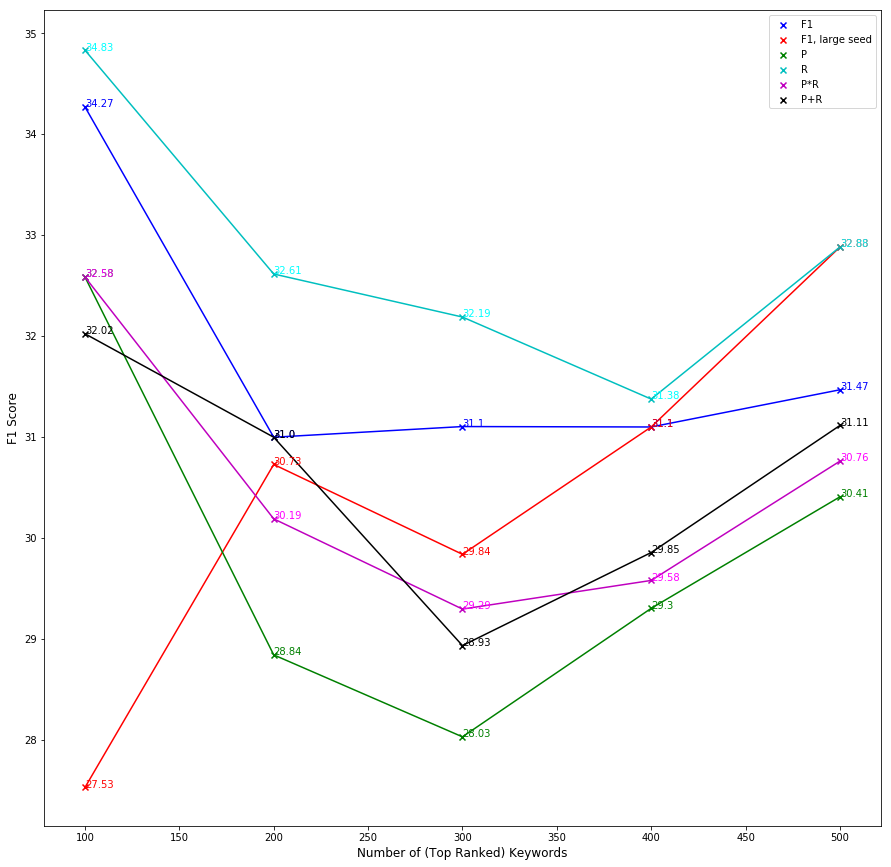

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

x = num_doc_values
y = [[(2*j*k/(j+k)) for j,k in zip(precision[i], recall[i])] for i in range(6)]

colors = ['b', 'r', 'g', 'c', 'm', 'k']
colors_v2 = ['blue', 'red', 'green', 'cyan', 'magenta', 'black']
labels = ['F1', 'F1, large seed', 'P', 'R', 'P*R', 'P+R']

# old_precision = [86.0, 82.0, 82.0, 81.75, 81.2]
# old_recall = [49.43, 53.07, 51.57, 51.58, 50.69]
# old_f1 = [62.77, 64.44, 63.32, 63.25, 63.25]

plt.figure(figsize=(15,15))
for i in range(6):
    plt.scatter(x, y[i], c=colors[i], marker='x', label=labels[i])
    plt.plot(x, y[i], c=colors[i])
    for i_x, i_y in zip(x, y[i]):
        plt.text(i_x, i_y, '{}'.format(round(i_y,2)), color = colors_v2[i])

plt.legend(loc='upper right')

plt.xlabel('Number of (Top Ranked) Keywords', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)

# plt.show()
plt.savefig('diff_methods_f1_graph.png')

In [ ]:
x = y

prdr_recall = r1
ap_recall = r2
combined_recall = r3

plt.figure(figsize=(10,10))

plt.scatter(x, prdr_recall, c='b', marker='x', label='PRDR')
plt.plot(x, prdr_recall, c='b')
plt.scatter(x, ap_recall, c='r', marker='s', label='AP')
plt.plot(x, ap_recall, c='r')
plt.scatter(x, combined_recall, c='g', marker='v', label='Combined')
plt.plot(x, combined_recall, c='g')

plt.legend(loc='upper right')

plt.xlabel('Number of (Top Ranked) Keywords', fontsize=12)
plt.ylabel('Recall %', fontsize=12)

for i_x, i_y in zip(x, prdr_recall):
    plt.text(i_x, i_y, '{}'.format(round(i_y,2)), color = 'blue')

for i_x, i_y in zip(x, ap_recall):
    plt.text(i_x, i_y, '{}'.format(round(i_y,2)), color = 'red')

for i_x, i_y in zip(x, combined_recall):
    plt.text(i_x, i_y, '{}'.format(round(i_y,2)), color = 'green')
    
# plt.show()
plt.savefig('combined_recall_graph.png')

In [ ]:
prdr_f1 = [(2*x*y/(x+y)) for x,y in zip(prdr_precision, prdr_recall)]
ap_f1 = [(2*x*y/(x+y)) for x,y in zip(ap_precision, ap_recall)]
combined_f1 = [(2*x*y/(x+y)) for x,y in zip(combined_precision, combined_recall)]

plt.figure(figsize=(10,10))

plt.scatter(x, prdr_f1, c='b', marker='x', label='PRDR')
plt.plot(x, prdr_f1, c='b')
plt.scatter(x, ap_f1, c='r', marker='s', label='AP')
plt.plot(x, ap_f1, c='r')
plt.scatter(x, combined_f1, c='g', marker='v', label='Combined')
plt.plot(x, combined_f1, c='g')

plt.legend(loc='upper right')

plt.xlabel('Number of (Top Ranked) Keywords', fontsize=12)
plt.ylabel('F1 %', fontsize=12)

for i_x, i_y in zip(x, prdr_f1):
    plt.text(i_x, i_y, '{}'.format(round(i_y,2)), color = 'blue')

for i_x, i_y in zip(x, ap_f1):
    plt.text(i_x, i_y, '{}'.format(round(i_y,2)), color = 'red')

for i_x, i_y in zip(x, combined_f1):
    plt.text(i_x, i_y, '{}'.format(round(i_y,2)), color = 'green')

# plt.show()
plt.savefig('combined_f1_graph.png')


In [55]:
prdr_0

['neural networks',
 'neural network',
 'net convnet',
 'framelet expansion',
 'neural model',
 'orthogonal networks',
 'deterministic policy',
 'bidirectional lstm',
 'neural architecture',
 'neural nets',
 'neural architectures',
 'neural models',
 'bayesian methods',
 'associative memory',
 'linear networks',
 'compositional models',
 'neural language',
 'deep learning',
 'learning dl',
 'dynamical model',
 'dual stream',
 'residual network',
 'convolutional autoencoders',
 'convolutional autoencoder',
 'residual learning',
 'nonlinear networks',
 'generative models',
 'adversarial networks',
 'neural heart',
 'active learning',
 'linear models',
 'neural operations',
 'hiererchical features',
 'deep networks',
 'predictive coding',
 'natural language',
 'many task',
 'metric learning',
 'linear neural',
 'adversarial nets',
 'dynamical models',
 'linguistic processing',
 'speaker vectors',
 'coral correlation',
 'successor reinforcement',
 'plant plant',
 'recent years',
 'visual q

In [56]:
prdr_0_v2

['networks dnns',
 'network dnn',
 'networks dnn',
 'network architectures',
 'network accelerator',
 'network classifiers',
 'network model',
 'network architecture',
 'network training',
 'network hdnn',
 'networks studies',
 'networks architectures',
 'network arnet',
 'network classifier',
 'networks cd',
 'heart rate',
 'network adaptation',
 'network models',
 'language modeling',
 'networks rnns',
 'network rnn',
 'networks cnns',
 'network language',
 'language model',
 'network approach',
 'machine translation',
 'language models',
 'encoder decoder',
 'network encoder',
 'networks mdrnn',
 'network dbrnn',
 'network frameworks',
 'networks models',
 'network topologies',
 'network predictions',
 'world models',
 'feature extractors',
 'activation policies',
 'network dcnn',
 'networks lenet',
 'architectures cnns',
 'network functions',
 'network technique',
 'training model',
 'transfer function',
 'network conversation',
 'feedback relevance',
 'network classification',
 'n

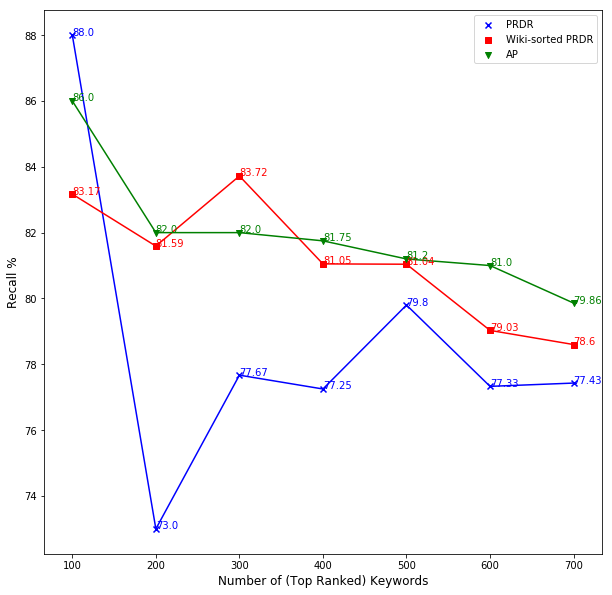

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

prdr =             [88.00, 73.00, 77.67, 77.25, 79.8, 77.33, 77.43]
wiki_sorted_prdr = [83.17, 81.59, 83.72, 81.05, 81.04,79.03, 78.60]
ap =               [86.00, 82.00, 82.00, 81.75, 81.2, 81.0, 79.86]
x =                [100, 200, 300, 400, 500, 600, 700]

plt.figure(figsize=(10,10))

plt.scatter(x, prdr, c='b', marker='x', label='PRDR')
plt.plot(x, prdr, c='b')
plt.scatter(x, wiki_sorted_prdr, c='r', marker='s', label='Wiki-sorted PRDR')
plt.plot(x, wiki_sorted_prdr, c='r')
plt.scatter(x, ap, c='g', marker='v', label='AP')
plt.plot(x, ap, c='g')

plt.legend(loc='upper right')

plt.xlabel('Number of (Top Ranked) Keywords', fontsize=12)
plt.ylabel('Recall %', fontsize=12)

for i_x, i_y in zip(x, prdr):
    plt.text(i_x, i_y, '{}'.format(round(i_y,2)), color = 'blue')

for i_x, i_y in zip(x, wiki_sorted_prdr):
    plt.text(i_x, i_y, '{}'.format(round(i_y,2)), color = 'red')

for i_x, i_y in zip(x, ap):
    plt.text(i_x, i_y, '{}'.format(round(i_y,2)), color = 'green')
    
# plt.show()
plt.savefig('wiki_sorted_precision_graph.png')